# Interview invites prediction (Decision Trees/Random Forest)

First we'll load the data on past cases of invite/no invite for a job interview. We can use pandas to convert a csv file into a DataFrame:

In [1]:
import numpy as np
import pandas as pd
from sklearn import tree #decision trees 
from sklearn.metrics import confusion_matrix #Obv helps implement confusion matrix

In [2]:
input_file = "C:/Users/YsfEss/Desktop/resumes_development.csv"
df = pd.read_csv(input_file, header = 0)

In [3]:
df.head()

,Interview,Adobe Illustrator,Adobe Photoshop,Agile Methodologies,Analytical Skills,Art,Art Direction,Auditing,AutoCAD,Automation,...,Windows,Windows Server,Wireless Technologies,WordPress,Workshops,Writing,Veteran,Female,URM,Disability
0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
len(df)

619

As you can see the data is formed of 223 attributes, where the attribute **'Interview'** is the output,dependant variable or target. All the other features are binary and for most of them they represent the existence (1) or absence (0) of a certain skill in the resume of the candidate, the four last features represent some demographic aspects of the candidates. In real life projects, we should apply NLP to extract these features, by detecting the key concepts from the raw text (of historic interview applications), which will represent the skills used as features. (If you are intrested in this phase of the extraction of features from raw text you can look at the repo called 'Job Postings mining' although that project was done by SPSS Modeler). Other way to extract these skills would be via electronics job interview applications or electronic resumes that have a skills tag which will allow a simpler extraction, compared to text mining. Because we are more intrested in applying this algorithm and seeing the results, I used this already 'feature-ready' dataset. So without further ado let's get right into it: 

We will now establish a k-fold cross validation, the typical value of k chosen is 10, since the data size is 619 i will only use a 5-fold CV to have large folds.  

In [4]:
def foldCreation(data,k):
    folds=[]
    shuffledData=data.sample(frac=1) 
    s=int(len(data)/k)
    for i in range (k-1):
        folds.append(shuffledData[i*s:(i+1)*s])
    folds.append(shuffledData[(i+1)*s:])
    return(folds)

In [5]:
folds=foldCreation(df,5)

In [6]:
def crossValidation(folds,k):
    test=folds[k]
    train=pd.DataFrame()
    for i in range (len(folds)):
        if i!=k:
            train=train.append(folds[i])
    return(train,test)

Next we need to separate the features from the target column that we're trying to bulid a decision tree for.

In [7]:
features = list(df.columns[1:223])
target=df.columns[0]

In addition to the classical accuracy discussion, we will implement a graphical tool to visualize the decision tree for each of the cross validation iterations.

In [8]:
def trainingDT(data,K):
    accuracy=0
    confMatrices=[]
    for k in range (0,K):
        train,test=crossValidation(folds,k)
        y=train[target]
        X=train[features]
        clf = tree.DecisionTreeClassifier()
        clf = clf.fit(X,y)
        predictions=clf.predict(test[features])
        s=100*(predictions==test[target]).tolist().count(True)/len(predictions)
        accuracy=accuracy+s
        confMatrices.append(confusion_matrix(test[target], predictions))
    return(confMatrices,accuracy/K)

In [9]:
c,ac=trainingDT(df,5)
print(ac)

85.29031432046604


In [10]:
for i in range (len(c)):
    print(pd.DataFrame(data=c[i]))
    print('................')

    0   1
0  82   8
1   9  24
................
    0   1
0  69   8
1  13  33
................
    0   1
0  62  14
1   5  42
................
    0   1
0  71   8
1   9  35
................
    0   1
0  67  11
1   6  43
................


The accuracy returned is quite good, the investigation of the confusion matrices doesn't reveal a wierd pattern for both types of erros done by the classifier. If we look at the number of occurences of both classes of the target variable we can notice that the data is somewhat balanced. (36% interviewd and 64% not interviewd). This is to be expected, since companies don't entertain the idea of accepting for interviews any job application.

And now let's display a decision tree from the ones generated through a step of cross validation, to do so we'll intreduce a new function called visualizeTree() which does the same exact thing as trainingDT in addition to saving the generated decision tree. Note that you need to have pydotplus installed for this to work. (!pip install pydotplus)

To read this decision tree, each condition branches left for "true" and right for "false". The value array represents how many samples exist in each target value. So value = [x , y] mean there are x "no interview" and y "interview".

In [11]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
import pydotplus

def visualizeTree(data,K):
    accuracy=0
    trees=[]
    for k in range (0,K):
        train,test=crossValidation(folds,k)
        y=train[target]
        X=train[features]
        clf = tree.DecisionTreeClassifier()
        clf = clf.fit(X,y)
        predictions=clf.predict(test[features])
        s=100*(predictions==test[target]).tolist().count(True)/len(predictions)
        accuracy=accuracy+s
        dot_data = StringIO()  
        tree.export_graphviz(clf, out_file=dot_data,feature_names=features)  
        graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
        trees.append(Image(graph.create_png()))
    return(trees,accuracy/K)

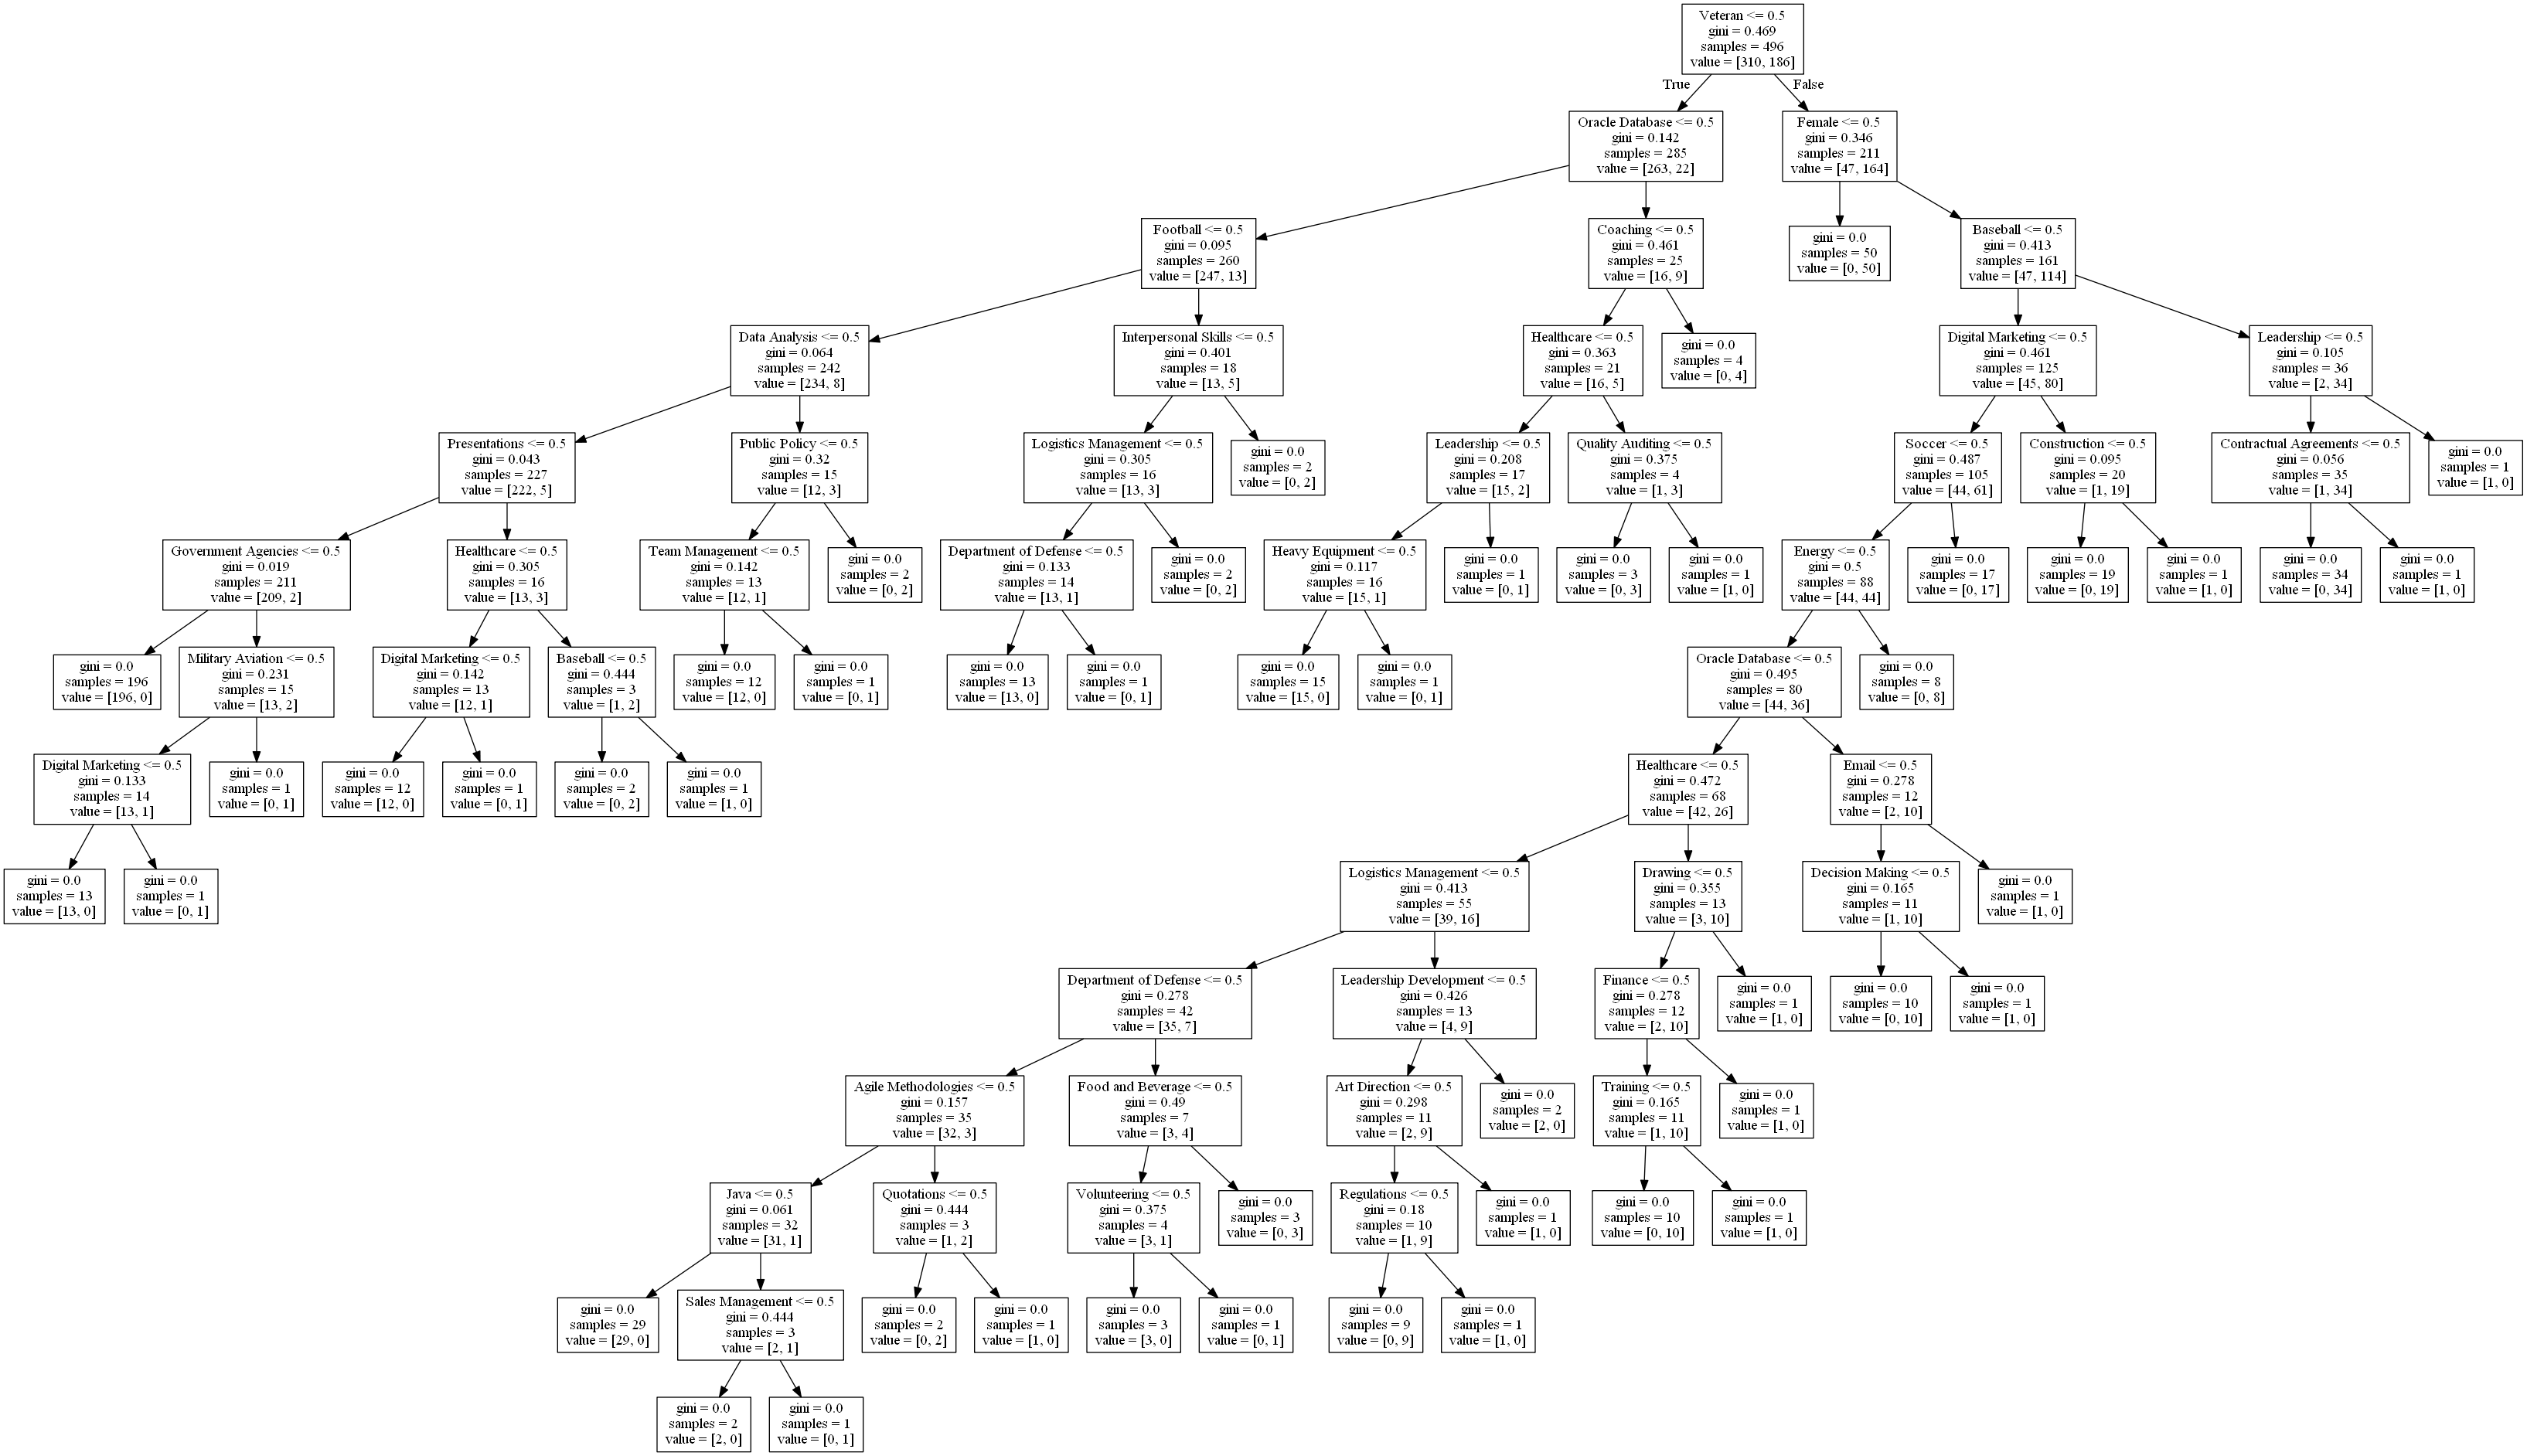

In [12]:
trees,ac=visualizeTree(df,5)
trees[0]

As you can see, we get a flow chart of the decisions taken by the algorithm. Just a simple rule ,for illustration sake, we can conclude that if you are a veteran and a male then you are very likely to get a job interview, if you are a female tho there is other factors to be considered (this is considered bad,).
We can also notice that the algorithm judged the **Disability** and also the **URM(Underrepresented Minority)** as not really significant in the process of chosing the candidates for Job interview, which is ethically a good thing to do.

## Ensemble learning: using a random forest

We'll use a random forest of 10 decision trees to predict employment of specific candidate profiles:

In [7]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X, y)

#Predict employment of an employed 10-year veterandata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAADMUAAAdcCAYAAAAR7N0yAAAABmJLR0QA/wD/AP+gvaeTAAAgAElEQVR4nOzdf3CcZ2En8O/Gjg+460mBYAXMOD3KOMNMGWdgBhx6V4hsSONGyyWDqRWPj7nW8knU7uTGvtak0nlAmks7lYZCUuyzAtRoIu/EObh6D+egiajpjaPkDhodw6X4aAaphMMbCt6j0/wgYe8P3y6WLdmyI3st6/OZeSe7z/u8z/t9Vyv/pW+eQq1WqwUAAAAAAAAAAAAAAAAWjm1XNTsBAAAAAAAAAAAAAAAAnC+lGAAAAAAAAAAAAAAAABYcpRgAAAAAAAAAAAAAAAAWnKXNDgAAAAAAAAAAwIX727/924yPjzc7BovMm970ptx0003NjgEAAMAipxQDAAAAAAAAALCA7d69O5/73OeaHYNFqFarNTsCAAAAi9xVzQ4AAAAAAAAAAMCFe+GFF3LnnXemVqs5HJfkeOCBB5r9tQcAAIAkSjEAAAAAAAAAAAAAAAAsQEoxAAAAAAAAAAAAAAAALDhKMQAAAAAAAAAAAAAAACw4SjEAAAAAAAAAAAAAAAAsOEoxAAAAAAAAAAAAAAAALDhKMQAAAAAAAAAAAAAAACw4SjEAAAAAAAAAAAAAAAAsOEoxAAAAAAAAAADMqFAonHGca85cVKvVOc9dLMrlcorFYorFYsrl8pyvm5iYmPb59/T0XMSUAAAAcHlRigEAAAAAAAAAYEa1Wi2PPfZYkmTfvn2p1Wozznn00Udz4MCBGc/P5Gtf+9q85rzUJiYm0tfXN2/rlUqlDA8PZ2RkJCMjIzl8+HCGh4fndO0TTzwx7f369evnLRcAAABc7pY2OwAAAAAAAAAAAJevNWvWZHBwMN/4xjdmnfNXf/VX2bx585zWq1arcy58XE4qlUrGxsZy5MiRvOc978n27dvnZd2pqal0dnbmscceS0tLS5Kku7s7N954Y975zndm9erVZ73+uuuum3MZCQAAAK40dooBAAAAAAAAAOCsNmzYkL1796ZUKp1xrlqt5sSJE1m+fPm08UqlkqGhoRQKhRSLxYyNjSVJBgcHUy6XkySFQiGFQuGc11QqlZTL5RSLxVSr1fT09DR2aqmXbOpr9fX1pVKpNK4rlUopFotJknK53Fh7ampqTs9e3xXm3nvvzVvf+tbs2bMnGzduPON5L9TRo0eTJG984xsbY294wxuSnLkLzOmmpqZSLBbT19eX8fHxeckDAAAAC4lSDAAAAAAAAAAAZ7Vy5coMDg6ms7Mz1Wp12rmHH344H/zgB6eNVSqVbNmyJStWrEitVstdd92VtWvXZmJiIv39/Y15tVqtscvJ2a7ZsmVLisViyuVynnrqqXR3d+eHP/xhkmTXrl3ZunVrjh8/nsnJyQwMDGT37t1Jki1btqSzszPlcjnj4+Pp6OjI5ORkyuVy7rnnnlmft16m6enpyVNPPZXt27env79/xl1b6mWccx2zOXLkSOMzrqsXburlodlMTEwkSQYGBnLTTTelWCw2CkEAAACwGBRq9k8FAAAAAAAAAFiwNm3alCR54IEHLup9jh07lhtuuCGHDh1KR0dHY7xYLObQoUPT5pZKpXR2dubUP0spFArp7e1Nf39/oyRy6vm5XnPixIm0tLQ05vT19eWHP/xh9uzZ07jm1LVnutdMY6cqFAoZHBzMli1bpt3rYpgty7ky1lWr1Xz3u9/NQw89lIGBgezbty9dXV0XJ+z/Nzo6mk2bNp0zGwAAAFxk2+wUAwAAAAAAAADAOa1atSrd3d0ZHh5ujI2Pj+fOO+88Y+7o6GiSnLFTysDAwKzrz/Wa00sq/f392bNnT6ampjI0NHQBT3am48ePZ8WKFdm1a1dKpdJlvftKS0tLVq9enf7+/uzbt++cu8sAAADAlUQpBgAAAAAAAACAOenu7k65XM7Y2FiSZP/+/Xn3u999xrx6MaNWq51xzOZCrqkbHh7Otm3bpu1g80osX748GzduzJ49e/LWt7419957b/r6+jIxMXHG3FNLPGc7ZnO2zN3d3eeV+0Mf+pBSDAAAAIvK0mYHAAAAAAAAAABgYVi9enW6u7vzx3/8x3nd616XJFm5cuWs848dO5ZVq1ad1z3O95pSqZStW7dmcnLyrFku1OrVq7N69epUKpWMjY1l7969ec973pP29vYsX758TqWds+no6Ei5XE6lUsny5cuTJFNTU0mSt7/97ee1VktLy3kXaQAAAGAhs1MMAAAAAAAAAABzVt8tpq+vLxs2bJhxzr59+5IkIyMjqVarSZJKpZKhoaFZ172Qa5Kks7MzydnLOfNhpt1j5sMtt9ySJHn66acbY9///vennZurarU6688EAAAArkRKMQAAAAAAAAAAzFl9t5hyuZx3vOMdM875wAc+kCQZGBhIa2trCoVC2traGoWNjo6OJNNLL2e7plKpzJqnvtbU1FSOHTvWGK9UKtOuqxdt6v+tz7kQq1evTn9//wVde7qVK1dm37592b9/f6rVaqrVavbv3599+/ZNK/r09fWlr6+v8b5UKmVsbKzxfmpqKl/72tfS3t4+L7kAAABgIVCKAQAAAAAAAADgvHR3d2ffvn1paWmZ8fzy5cszOTmZ3t7exvzJyclGyaNeKLn33nuzefPmc17T1tbWWLtYLE67V32t4eHhtLa2pre3N93d3Xn++eenXdfa2jrtv0mmnW+mrq6urF+/Pq2trdm8eXM2bNiQrq6us17zj//xP87atWtTKBTS19eXH//4x42CEAAAACwWhVqtVmt2CAAAAAAAAAAALsymTZuSJA888ECTk7BYjI6OZtOmTfFnRwAAADTZNjvFAAAAAAAAAAAAAAAAsOAoxQAAAAAAAAAAAAAAALDgKMUAAAAAAAAAAAAAAACw4CjFAAAAAAAAAAAAAAAAsOAoxQAAAAAAAAAAAAAAALDgKMUAAAAAAAAAAAAAAACw4CjFAAAAAAAAAABwSfX19aWvr++iXwMAAABc2ZRiAAAAAAAAAADg/yuXyykWiykWiymXyxe0xvDwcAqFwqznJyYmMjw8nGKxOG1epVJpXFsoFFIqlS7o/gAAALBYLG12AAAAAAAAAAAAFpf+/v5Lcs35KpVKGR0dzcjISJJk165d+cEPfpCurq45rzExMZGtW7fOen5oaChHjhxJV1dX7rvvvhw6dChJUq1Ws2XLlnR0dKRWq6VSqWTLli351re+dUmeHQAAABYipRgAAAAAAAAAABa9qampdHZ25rHHHktLS0uSpLu7OzfeeGPe+c53ZvXq1edco1qt5qGHHpr1fE9PT6699tqMjIw07lH38MMPp1wuNwo5y5cvT39/f2688cbcfPPNaW9vfwVPBwAAAFemq5odAAAAAAAAAACAK8vY2FiKxWIKhUKGhoZSqVQa5yqVSkqlUorF4ozvy+VyCoVCisVipqamZpxzMRw9ejRJ8sY3vrEx9oY3vCFJ8sQTT8xpjfvvvz/bt2+f8VxfX1+SkzvenF6ISZLR0dEkmXbuF3/xF5MkBw8enNP9AQAAYLFRigEAAAAAAAAAYN6Uy+WsXbs2d999d2q1WlasWJG2trYUCoUUCoVs2bIlnZ2dKZfLSTLt/fj4eDo6OjI5OZlyuZx77rnnjDmzqa9/rmM2R44cSZKsXLmyMbZ8+fLGM53L2NhYfuVXfqVxzakmJiYyMDCQ9evXZ3h4uFH6GRsbm/a5na5ekNm7d+857w8AAACLkVIMAAAAAAAAAADzpr6by5o1a5IkGzduTJIMDg6mVqvl0KFD0+af+r5+Tb2YUi+DnH7NTGq12pyO2ZyteHKuUkylUsnf/M3fNPKf7pFHHkly8rm6urpy4sSJrFixImvXrs34+HiSpLu7O0ly7Nixs94LAAAA+DmlGAAAAAAAAAAA5k293HG6nTt3XuIkl86f/dmfpaura9bz9WdfvXp1kpM7wNQ/p/379ydJPvzhDydJPvGJT6RarSY5ucNMcrJQBAAAAJxJKQYAAAAAAAAAgHlTL3uUSqUkl67YUSgU5nTMpqOjY9ZzsxV9kpO7yNxyyy3nnbdekKnvULNmzZo8+uijeeaZZ9La2prh4eH83d/9XZJk3bp1570+AAAALAZKMQAAAAAAAAAAzJvVq1fn0KFDeeaZZ1IoFNLX15cDBw5kx44dF/W+tVptTsds6qWYSqXSGJuamkqSvP3tb5/1umKxmOuvv37G4k39db1UU98BZqb7Jkl7e3sOHTqUWq2Wrq6u/NVf/VV6e3sbBRoAAABgOqUYAAAAAAAAAADmTblczq/+6q9mx44dqdVqOXToUDZu3NjsWOdU3+3l6aefbox9//vfn3ZuJmcr3tRfb9iwIUny3e9+t3GuXpC58847Z1y3VCrlyJEj2blz5wU8DQAAACwOSjEAAAAAAAAAAMybYrGY1tbWaTunFAqF9PT0pFKpTNuJ5fT39aLIqTuqzHTNxbBy5crs27cv+/fvT7VaTbVazf79+7Nv376sXLmyMa+vry99fX3ntXZ7e3t6e3vT19fXyP/ggw+mo6NjWmGoWq1mYmIiPT09eeaZZ3Lo0KG0tLTMzwMCAADAFUgpBgAAAAAAAACAefPkk0+mo6PjjPG9e/dm9+7daWtra4y1tbVNe9/a2jrtvzPNOfX1fOvq6sr69evT2tqazZs3Z8OGDenq6pqXtfv7+9PR0ZG2trYUCoUkycjISON8oVBIa2trnnjiiXR3d2fHjh3zcl8AAAC4khVqp+7ZCgAAAAAAAADAgrJp06YkyQMPPNDkJCcdO3Ysr3rVq6btrlIfv+GGG+JPVRa+0dHRbNq0yc8SAACAZttmpxgAAAAAAAAAAOZFqVTKqlWrzijEJCd3eDlw4EATUgEAAABXqqXNDgAAAAAAAAAAwJVhdHQ0P/nJT3LLLbdMK8YcO3YsR44cSVdXVxPTAQAAAFcaO8UAAAAAAAAAADAvRkZG8gu/8Au55557UigUUigU0tfXl+9973sKMQAAAMC8s1MMAAAAAAAAAADzoqWlJRs3bszGjRuzZ8+eZscBAAAArnB2igEAAAAAAAAAAAAAAGDBUYoBAAAAAAAAAAAAAABgwVGKAQAAAAAAAABgQatUKimVSikWi82OAgAAAFxCSjEAAAAAAAAAACxou3fvTmdnZ8rlcrOjnJfh4eEUCoVpY5VKpTFeKBRSKpXOusbExESGh4dTLBbPWAsAAACudEoxAAAAAAAAAAAsaHv27Gl2hPM2MTGRrVu3ThurVqvZsmVLkqRWq+X48eMZHR1NX1/fjGsMDQ2lr68v1113Xe67777UarWLnhsAAAAuJ0ubHQAAAAAAAAAAABaTarWahx566Izxhx9+OOVyOSMjI0mS5cuXp7+/PzfeeGNuvvnmtLe3N+b29PTk2muvzcjISFpaWi5ZdgAAALic2CkGAAAAAAAAAIA5GRoaSqFQyPDwcCqVSgqFQuNctVrN8PBwCoVCCoVC+vr6UqlUkiSVSiWlUinFYjFJUi6XUygU0tPTk6mpqSRJqVQ6Y6xSqaRcLjeuq6/f09OTY8eOnTNvpVJpZC4WixkbG5vz81xM999/f7Zv337G+OjoaJJMK7n84i/+YpLk4MGDjbH6zjH9/f0KMQAAACxqSjEAAAAAAAAAAJzT0NBQNmzYkFqtlg996EO59957p53ftWtXtm7dmuPHj2dycjIDAwPZvXt3kmTLli3p7OxMuVzOxMREOjo68thjj2Xv3r255557Mj4+no0bN2ZycrIxliRtbW0pFospl8sZHx9PV1dXTpw4kSS54YYbzlqMqVQq2bJlS1asWJFarZa77rora9euzcTExJye53T1ss+5jnMZGxvLr/zKr2T58uVnnCuXy2eM1Usve/fuTZJMTExkYGAg69evb5SEZir8AAAAwGKgFAMAAAAAAAAAwDnt3Lkzr3rVq5KcLGqcvtPJtddem+7u7ixfvjwrV65M8vMix6FDhxrzVq9enSRZs2ZNY0799enX1Wq1xnX1OS0tLenu7k4yc4mkbmxsLOVyORs3bkyStLe3J0keeuihOT3P6Wq12pyOs6lUKvmbv/mbxrOcrv5cZyv7PPLII0lOflb1ktCKFSuydu3ajI+Pn/X+AAAAcKVRigEAAAAAAAAA4Jy6u7vT1taWUqmUarWa5cuXTyuB9Pf3Z8+ePZmamsrQ0NBFzVIv1uzcuXPWOaOjo0lyxi4uAwMDSc79PBfDn/3Zn6Wrq2vW8x/+8IeTJJ/4xCdSrVaTpLGzzeDgYJKfP3P9Mzi1JLR///6LExwAAAAuU0oxAAAAAAAAAACc07/9t/82HR0d6ezsTGtr64zFl+Hh4Wzbti0dHR1NSDhdfReZ2XZzmcvznOrUcs3ZjrPlueWWW856jzVr1uTRRx/NM888k9bW1gwPD+fv/u7vkiTr1q2b9bp6Qaa+ww4AAAAsFkubHQAAAAAAAAAAgMvfqlWrcujQoUxMTGTv3r2NHUt27NiRJCmVStm6dWsmJyezcuXKS5KpvkPK2Rw7diyrVq06Y/xcz3O6V7qLTLFYnPVcoVBorN/e3p729vbGuaGhofT29jaKL93d3dm7d2+q1WpaWlqmrXM5lJEAAADgUrJTDAAAAAAAAAAA51QoFFKtVrN69ers2bMnTz75ZKNIkiSdnZ1JckkKMceOHUuSrF+/ftY5+/btS5KMjIykWq0mSSqVSmNHmHM9z3ybbcea+rmZlEqlHDlyZFquDRs2JEm++93vNsbqz3fnnXdehOQAAABw+VKKAQAAAAAAAABgTgYHBzM1NZUkueaaazI4ONg4V9+lZGpqqlFaSU4WUSqVSuP9qQWVU+fMNlZXKpUa14+MjKSjo6Nxz5mu+8AHPpAkGRgYSGtrawqFQtra2hqlknM9T7NUq9VMTEykp6cnzzzzTA4dOjRtR5j29vb09vamr6+v8awPPvhgOjo6snHjxmbFBgAAgKZQigEAAAAAAAAAYE62b9+egwcPplAo5ODBg9mxY0fjXH9/f5JkeHg4ra2t6e3tTXd3d55//vm0tbU15rW2tibJtLH665nG6t761remWCymtbU1K1euzMjIyIxz66+XL1+eycnJ9Pb2Jkm6u7szOTk5bSebsz1PMxQKhbS2tuaJJ55Id3f3rHn6+/vT0dGRtra2FAqFJJn2eQAAAMBiUajNtv8qAAAAAAAAAACXvU2bNiVJHnjggSYnuTjqpQ9/4nL5GB0dzaZNm/xMAAAAaLZtdooBAAAAAAAAAAAAAABgwVGKAQAAAAAAAADgslSpVGZ8DQAAAJAoxQAAAAAAAAAAcJlqa2ub8TUAAABAkixtdgAAAAAAAAAAAJhJrVZrdgQAAADgMmanGAAAAAAAAAAAAAAAABYcpRgAAAAAAAAAAAAAAAAWHKUYAAAAAAAAAADOS6VSSalUSrFYbHaUcyoUCtMOTvK5AAAAcCVQigEAAAAAAAAA4Lzs3r07nZ2dKZfLzY4yZ7VaLbVarfG+Uqmkr6+vUQoplUpnXFOtVjM+Pp7h4eGzFoDK5XKKxWKKxeIr+kzO936FQiHFYnHG7HUTExON9U4tv5z+eQAAAMBCtLTZAQAAAAAAAAAAWFj27NmTvXv3NjvGBatUKnn66afT39+f/v7+lEqldHZ25plnnsmOHTsa8wYHB5MkAwMDs65VKpUyOjqakZGRJMmuXbvygx/8IF1dXeeday73Gxoays6dO/Pkk0/m0KFDmZiYyI033nhG9vrcI0eOpKurK/fdd18OHTp03pkAAADgclao+V8+AAAAAAAAAAAsWJs2bUqSPPDAA5f0vvVdRy73Pz2ZKef4+HjWrFlzznnnOjc1NZXrr78+jz32WGO9eknlySefzOrVq+ct89nOFQqFdHR0TCu99PT05Nprr83OnTvT0tJyQfeazejoaDZt2nTZ/+wBAAC44m27qtkJAAAAAAAAAAC4NMbHx1MoFKYddUNDQ42xqampVKvVDA8PN8b6+vpSqVRmXHem9WYaS07u0lK/V7FYzNjY2MV52LM4vRBTrVaTJL29vee1ztGjR5Mkb3zjGxtjb3jDG5IkTzzxxCuJOKv6bjLj4+NJThZzkqS/v78xp6+vrzF2tkIMAAAALHRKMQAAAAAAAAAAi8SaNWvy6KOPJjlZADl1p48dO3akt7c3Tz75ZFauXJldu3Zl69atOX78eCYnJzMwMJDdu3fPuO7x48fPGJucnDxjrFKpZMuWLVmxYkVqtVruuuuurF27NhMTEzOue3qBZ7bjlZiammoUTTZv3nxe1x45ciRJsnLlysbY8uXLkyTlcvkV5ZpN/ed00003ZXx8PEePHs3x48cbu9JMTExkYGAg69evb5SamlU+AgAAgItNKQYAAAAAAAAAYBFpb29Pb29vBgYGGjukJD/fLaVerrj22mvT3d2d5cuXN0ofe/funXHNehHkVKcWRerGxsZSLpezcePGRpYkeeihh2Zct1arzem4UFNTU7n++uszMDCQ5PyLLLN9Hhey1vno7+9Pd3d3brrppnzrW9/KP/pH/6hx7pFHHkly8vPv6urKiRMnsmLFiqxdu7axuwwAAABcKZRiAAAAAAAAAAAWmQ9+8INJkocffrgx9vWvf70xnpwsXuzZsydTU1MZGhqal/uOjo4myRm7vNRLKZfaypUrU6vV8uSTT6a3tzc7d+7M8PBwU7Kcj6GhobznPe/JiRMnkpzc4aZeatq5c2eSn5ebWlpa0t3dnSTZv39/E9ICAADAxaMUAwAAAAAAAACwyKxevTodHR2NkkqSfPWrX20UKeqGh4ezbdu2dHR0zMt967unzHW3l1PLM2c7XqnVq1dn8+bNSZKtW7fO+bqzfS71Isp8K5VK2blzZ2699da0tLRk8+bNKZfLefDBB2e9pv5zPdvONgAAALAQKcUAAAAAAAAAACxCd955Z8rlcsbHxzM1NZV3vvOd086XSqVs3bo19913X1atWjWv9z527Nic5s1UnplroeZ8Xcgz1ksxlUqlMTY1NZUkefvb3z4vuU7X2dmZ5OQOMEnS1taW5OdlnnoZp75zzEx5AQAA4EqhFAMAAAAAAAAAsAi1t7cnSfbv35+jR4/mV3/1V6edr5cvVq5cOW/33LdvX5JkZGSkUdqoVCoZGhqat3tcqHqeAwcOzPmaW265JUny9NNPN8a+//3vTzs3304vttTLMfXxDRs2JEm++93vNubUn+3OO++8KJkAAACgWZRiAAAAAAAAAAAWoeXLl6e3tzd79+7NM8880yhX1NVLFlNTU9N2dqlUKtN2Rqm/ru9QUp87Pj7emNPT05Mk+cAHPpAkGRgYSGtrawqFQtra2hpFjkulWCxmaGiosatLtVrN4OBgent7s3HjxmlzT91x5fTdV1auXJl9+/Zl//79qVarqVar2b9/f/bt2zetTDQ0NJRCoZCJiYlzZjvb/ZLkrrvuSnJyJ5/k559zfby9vT29vb3p6+tr/GwefPDBdHR0nPFsAAAAsNApxQAAAAAAAAAALFIf/OAHk5y5+0iS9Pf3J0mGh4fT2tqa3t7edHd35/nnn09bW1tjXv31Rz/60XR0dOSGG25IuVzOmjVr0tHRkQMHDuRjH/tYkpNFnMnJyfT29iY5WaSZnJyc191o5qKrqys7d+7M9ddfn0KhkPvvvz+//uu/3njmukKhkNbW1sb7epHn9LXWr1+f1tbWbN68ORs2bEhXV9e0OSdOnEh3d3f6+vrOmmsu92tvb8+jjz6aI0eOpFAoZP/+/Xn00UcbO/8kJ392HR0daWtra1w/MjIyh08GAAAAFpZCrVarNTsEAAAAAAAAAAAXZtOmTUmSBx54oMlJLk/1Usjl8CcyxWIxhw4danaMaS7k8xkdHc2mTZsui88UAACARW2bnWIAAAAAAAAAAOAiGx8fz913393sGAAAAHBFWdrsAAAAAAAAAAAAcCUbGxvLm970pqxatarZUQAAAOCKohQDAAAAAAAAAMAVr1AoJElqtdolv3d7e/slv+e51D8PAAAAWMiUYgAAAAAAAAAAuGI1owSzEPhcAAAAuBJc1ewAAAAAAAAAAAAAAAAAcL6UYgAAAAAAAAAAAAAAAFhwlGIAAAAAAAAAAAAAAABYcJRiAAAAAAAAAAAAAAAAWHCWNjsAAAAAAAAAAACvzOjoaH760582O8Y0zz//fF71qlc1O8aC98ILL2TZsmUpFArNjtJw8ODBZkcAAACAJEoxAAAAAAAAAAAL2saNGy+7Qszx48dz9OjRvPe9780111zT7DgLVq1Wy1e/+tUsX748b3/725sdp2HDhg15y1ve0uwYAAAAkEKtVqs1OwQAAAAAAAAAAFeGxx9/PO3t7bn99tszMjJyWe1wshB98YtfzIYNG3L33Xfn4x//eLPjAAAAwOVk21XNTgAAAAAAAAAAwJXhm9/8Zn79138969aty2c/+1mFmHlw++2359Of/nQGBgZy3333NTsOAAAAXFaWNjsAAAAAAAAAAAAL3+TkZNavX5+3vvWtOXDgQJYtW9bsSFeMrVu35kc/+lF+53d+J9dcc002bdrU7EgAAABwWVCKAQAAAAAAAADgFXn22Wezbt26XHPNNfkv/+W/5DWveU2zI11xdu3alR/96Ef5zd/8zbS0tOS2225rdiQAAABouquaHQAAAAAAAAAAgIWrWq3mlltuSZJ85StfSUtLS5MTXbn+8A//MJ2dnfmN3/iNHD16tNlxAAAAoOmUYgAAAAAAAAAAuCDPPfdc7rjjjhw/fjwPP/xwrrvuumZHuqIVCoV85jOfybp167J+/fp885vfbHakM1QqlZRKpRSLxWZHAQAAYBEo1Gq1WrNDAAAAAAAAAABcqQqFwnnNXyh/yvHyyy/njjvuyJEjR/KXf/mXedvb3tbsSIvGc889l9tuuy1//dd/nSNHjuQtb3nLK1pvrt/RuXw3e3p6snfv3jnPBwAAgFdgm51iAAAAAAAAAAAusgMHDqRWqy0+kkUAACAASURBVDWOulPHDhw40MSE56dWq+W3fuu38sgjj+Tw4cMKMZfYq1/96nzhC19IW1tbbr311vzgBz94RevVarWcOHFi2vtTj0cffXTOa+3Zs+cVZQEAAIDzYacYAAAAAAAAAICLqFAonLFjRn1njlPHq9VqWltbF8TuGr/7u7+bT37yk/lP/+k/5bbbbmt2nEXr2Wefzbvf/e68+tWvzl/+5V+mpaXlFa030/fy1HNz/W6ebR0AAACYR3aKAQAAAAAAAAC4mCYnJ+c0r6WlJZOTk6lUKimXyykWi6lWq+np6UlfX18KhULjqJtpLEkqlUqGhoZSKBRSLBYzNjY2b8/zB3/wBxkcHMxnP/tZhZgme/3rX59HHnkkP/7xj3PbbbflH/7hH+b9HrMVuIaHhxvfvb6+vlQqlbOuU/8+Dg8Pp1KpXNLvLAAAAFcupRgAAAAAAAAAgIto5cqV5zV3y5YtKRaLKZfLeeqpp9Ld3Z0f/vCHOX78+BnzZyrcVCqVbNmyJStWrEitVstdd92VtWvXZmJi4hU9R5Ls27cvd999dz71qU9l06ZNr3g9Xrnrr78+hw8fzlNPPZXOzs68+OKL87b21NTUjOO7du3K1q1bc/z48UxOTmZgYCC7d++edZ2hoaFs2LAhtVotH/rQh3LvvfdOO38xv7MAAABc2Qo1+5QCAAAAAAAAAFxSM+2+MdP5EydOpKWl5azXnT5WKpXS2dl5xpze3t709/dfcOYvfvGL2bBhQ+6+++58/OMfv+B1uDgef/zxtLe35/bbb8/IyMgZO7HMxWzXnP497evryw9/+MPs2bNn2nX1eTO9P378eJYvX57kZAmmra3ton9nAQAAuOJtU4oBAAAAAAAAALjE5lqKOf38XEox9V1mZnKhfyYyNjaWW2+9Nb/1W7+VT3/60xe0Bhffn//5n+e2225Ld3d3PvnJT5739ad/l6ampnL99dfP+r2ZmprKwYMHs3PnzmnXnb5OT09P9u7dmwMHDuTWW2+dVvRKLs53FgAAgEVBKQYAAAAAAAAA4FK7mKWYc619vh5//PG8//3vz2233ZbPf/7zWbJkybysy8Vx4MCBbN68OR/72Mfy+7//++d17Wzfr5m+S8PDwymXyxkcHMwNN9ww7brT1zl27Fh27tzZKL4MDg5mx44dZ70vAAAAzMG2pc1OAAAAAAAAAADA/Dt27FhWrVr1itb49re/nY6Ojtx000353Oc+pxCzAHR2dubEiRP5yEc+kte+9rXp6el5RevNVFQplUrZunVrJicns3LlynOusWrVqhw6dCgTExPZu3dvY2eZU4sxyfx8ZwEAAFhcrmp2AAAAAAAAAAAA5s++ffuSJCMjI6lWq0mSSqWSoaGh81rne9/7XtatW5c3v/nN+cIXvpBly5bNe1Yujp6engwMDGT79u0plUrzvn5nZ2eSzKkQk5zcCaZarWb16tXZs2dPnnzyyUYxJpm/7ywAAACLj1IMAAAAAAAAAMAlVKlUZnx9trG67u7uJCd31EiS8fHxxrn6jiAf+MAHkiQDAwNpbW1NoVBIW1tbNmzYMOeMzz77bN73vvflmmuuyeHDh/Oa17xmztdyefj93//9fOQjH8mHP/zh/Pmf//k559fLKKe/nklHR0eSZGpqqvFdTE5+d2f7fg8ODmZqaipJcs0112RwcLBxbj6+swAAACxOSjEAAAAAAAAAAJdI/Y/969ra2lIoFKbNOfV8sVicdu6jH/1oOjo6csMNN6RcLmfNmjXp6OjIgQMH8rGPfSxJsnz58kxOTqa3tzfJySLN5OTknHf1+MlPfpKOjo688MILOXz4cF772tde0LPSfJ/85CezYcOG/Mt/+S/z+OOPzzqvUCiktbW18b5eTJlNf39/kmR4eDitra3p7e1Nd3d3nn/++TO+33Xbt2/PwYMHUygUcvDgwezYsaNx7pV+ZwEAAFi8CrVardbsEAAAAAAAAAAANN+LL76YW2+9Nd/85jdz9OjRvOUtb2l2JF6hF198MRs2bMjRo0czNjaWt73tbc2OBAAAAPNlm51iAAAAAAAAAADIyy+/nM7Oznz961/PV77yFYWYK8SyZcty4MCB3HDDDVm/fn0mJyebHQkAAADmjVIMAAAAAAAAAMAiV6vV8tu//dv5r//1v+aLX/xibrzxxmZHYh695jWvyZe+9KVcc801WbduXZ599tlmRwIAAIB5oRQDAAAAAAAAALDI3X333bn//vtz4MCB3Hzzzc2Ow0XQ0tKSr3zlK0mSX/u1X0u1Wm1yIgAAAHjllGIAAAAAAAAAABaxwcHB/OEf/mE++9nPplgsNjsOF9F1112Xhx9+OP/n//yf3HHHHXnuueeaHQkAAABeEaUYAAAAAAAAAIBF6vOf/3x+93d/N3/0R3+Uf/Wv/lWz43AJvOUtb8mXv/zlfP3rX8/GjRvz8ssvNzsSAAAAXDClGAAAAAAAAACARejQoUP5zd/8zfze7/1eduzY0ew4XEJve9vbcvjw4TzyyCPZsmVLarVasyMBAADABVGKAQAAAAAAAABYZMbGxtLZ2ZktW7bkP/yH/9DsODTBu9/97pRKpYyOjub3fu/3mh0HAAAALsjSZgcAAAAAAAAAAODSefLJJ3PHHXfk1ltvzZ/8yZ+kUCg0OxJN0tHRkc9+9rPZvHlzXvva12bXrl3NjgQAAADnRSkGAAAAAAAAAGCR+M53vpP3v//9ecc73pHR0dEsWbKk2ZFosk2bNuXHP/5xfud3fieve93r0tXV1exIAAAAMGdKMQAAAAAAAAAAi8D3vve9vO9978ub3/zm/Of//J+zbNmyZkfiMrFt27YcP348PT09ufbaa3P77bc3OxIAAADMSaFWq9WaHQIAAAAAAAAAgIvnRz/6Ud773vfmpZdeypEjR/L617++2ZG4DH3kIx/JZz7zmTz88MNpb29vdhwAAAA4l212igEAAAAAAAAAuIL9wz/8Q9avX58f//jHeeyxxxRimNW9996barWaO+64I1/+8pfzrne9q9mRAAAA4KyuanYAAAAAAAAAAAAujhdffDG33357nn766TzyyCN505ve1OxIXMaWLFmSz33uc3nXu96Vjo6OfPvb3252JAAAADgrpRgAAAAAAAAAgCvQyy+/nH/9r/91Hn/88ZTL5dxwww3NjsQCsGzZsnzxi1/Mm9/85qxbty7f+973mh0JAAAAZqUUAwAAAAAAAACwgL3qVa/K2rVr8+KLL04b3759ex566KF84QtfyLve9a4mpWMhes1rXpPDhw/nmmuuyfvf//48++yz087ff//9KRQKeeqpp5qUEAAAAE5SigEAAAAAAAAAWKD+4i/+Ii+88ELGxsZyyy235O///u+TJH19fdm3b19KpVLa29ubnJKF6LWvfW0OHz6c5557Lh0dHfnJT36SJBkaGkpXV1eSZM+ePc2MCAAAACnUarVas0MAAAAAAAAAAHD+isViHn744bz00ku5+uqr88u//Mv5jd/4jXz0ox/Nf/yP/7FRXoAL9Z3vfCfvfve787a3vS3veMc78kd/9EeNc69+9avz/e9/P62trU1MCAAAwCK2TSkGAAAAAAAAAGABmpqayj/7Z/8sP/vZzxpjV199dZJkx44dueeee5oVjSvMN77xjfzzf/7P8/zzz+fUPzVasmRJ/uAP/iA7d+5sYjoAAAAWsW1XNTsBAAAAAAAAAADn7957782SJUumjf30pz9Nkuzfvz9//dd/3YxYXGFeeOGFfPzjH8+LL76Y0//fuy+//HI+9alPTStmAQAAwKWkFAMAAAAAAAAAsMD8/d//ffbu3dsowZzqpz/9aZ599tncdNNN+e///b83IR1Xip/85Ce55ZZb8qUvfSkvv/zyjHP+9m//NuVy+RInAwAAgJOUYgAAAAAAAAAAFpjR0dE899xzs55/6aWXUq1W8853vjP/83/+z0uYjCtFrVbLm9/85hw5ciQvvfTSrPOWLFmSwcHBS5gMAAAAfk4pBgAAAAAAAABgAanVahkcHEytVpt1zlVXXdU4/7rXve5SReMKUigUcvPNNydJrr766lnnvfzyy/lv/+2/5Vvf+taligYAAAANSjEAAAAAAAAAAAvIV77ylfzv//2/87Of/WzG80uWLMkb3/jGfP7zn8/LL7+cFStWXOKEXCkefPDBfOMb38h73/veJMnSpUtnnLds2bL88R//8SVMBgAAACcVamf734YAAAAAAAAAAHBZufXWW/PII4/kpZdemja+dOnS/MIv/EI+9rGP5d/8m3+TZcuWNSkhV6K/+Iu/yL/7d/8u/+N//I9cddVVZ5Syli1blmeeeSbXXnttkxICAACwCG2zUwwAAAAAAAAAwALxne98J1/+8penFWKuvvrqvPrVr05fX1+mpqayfft2hRjm3Xvf+9488cQT+cIXvpBf+qVfSqFQSKFQaJz/2c9+lvvvv7+JCQEAAFiMlGIAAAAAAAAAABaIT33qU1m6dGmSk2WYpUuX5rd/+7czNTWVf//v/33+yT/5J01OyJWsUCjk9ttvz//6X/8rn/nMZ3LddddlyZIlSZKXXnopn/rUp87YwQgAAAAupkKtVqs1OwQAAAAAAAAAAGf3f//v/01LS0uSk+WEzZs3p7+/PytXrmxyMhar559/Pp/+9KfT39+fEydOJEn+9E//NB/+8IebnAwAAIBFYptSDAAAAAAAAAA0SblczsjISLNjsEAcP348X/va13LttdfmHe94R/7pP/2nzY500SxZsiSf+MQnct111zU7yoLRzH9PfvrTn+bb3/52nnrqqbS2tuZ973tfU3IwvzZv3pyOjo5mxwAAADibbVc1OwEAAAAAAAAALFalUikHDx5sdgwWiNe//vX5tV/7tdx8881XdCEmOfm7MTY21uwYC0oz/z25+uqr88u//MspFov5F//iXzQlA/Pr4MGDKZVKzY4BAABwTkubHQAAAAAAAAAAFrM777wzDzzwQLNjwGWlUCg0O8KC5N8T5sumTZuaHQEAAGBO7BQDAAAAAAAAAAAAAADAgqMUAwAAAAAAAAAAAAAAwIKjFAMAAAAAAAAAAAAAAMCCoxQDAAAAAAAAAAAAAADAgqMUAwAAAAAAAAAAAAAAwIKjFAMAAAAAAAAAXLBKpZJSqZRisdjsKK/YlfQssBj4nQUAAEApBgAAAAAAAAAWqPHx8fT19aVQKKRQKKSvry9jY2OXNMPu3bvT2dmZcrl8wWvU8890DA0NpVwup1qtnve61Wo1hUJhzvPn41muJOVyOcViMcVi8bw+k4mJiWk/w56enouYkovlbL+Xpx7NtFB/Z/1uAQAAzB+lGAAAAAAAAABYYKrVavr6+vKlL30pXV1dqdVqqdVq2bx5c7761a+mp6cnlUrlkmTZs2fPK16jVqvl+PHjjfcnTpxoPNO6desyPDyczZs3n/czfe1rXzuv+fPxLM0yMTGRvr6+eVuvVCpleHg4IyMjGRkZyeHDhzM8PDyna5944olp79evXz9vubh0arVaTpw4Me39qcejjz7axHQnXYrfWb9bAAAAl7elzQ4AAAAAAAAAwP9j7/6jo6rv/I+/LqDWopvgYgJiw3bXBpDaoIIbMgkcw1qV7ozVBZofzbHaJDvTBoVm3CKdacRJ17omNYLbZAntStPAHOS0NXNa+gfGJTMTUn60mbZIxUrJtFgZPchUrVqR+f7Bd0ZCfk1CkkuS5+OcOZ2593Pvfd1hPtdfn3ffwODU1NQoFAqppaWl2/bMzEx5PB45HA5VVVWNqSKPtLS0xPuUlJTE+6ysLG3ZskWlpaUqLS1VU1NTt/19iUajSS80H6sikYhaW1u1Z88eLV26VKtXrx6W84bDYRUWFmrv3r2J79put2vBggW65ZZblJWV1e/xM2bMUCwWG5YsMFd/cy0/P38Uk4wu5hYAAAAAjB10igEAAAAAAAAAAAAAYAwJhUKqrq5WWVlZn2PsdrsaGhrU2toq6ewCb5/PJ5vNpmg0KofDkeh8EC8eMQxDhmHI7Xb36MgSjUbl9XoTY5IpNolEIqqtrZVhGLLZbIksQ5GWlqY1a9bI5/N16/7SX/aamhr5fD5JSuxP9n7Pz+9wOBQOh3t8JwOdJ358Y2OjIpFIIsOFfkfxzhWbNm3SvHnzVF9fr4KCgm6FRReivb1dknTNNdckts2cOVNSz04V5wuHw7LZbHK73ero6BiWPLj4xH/L5xdo9PWbjkQi8nq9stlskiSfz9djbsWfMefPt2TnbDI5BsLcAgAAAICxh6IYAAAAAAAAAAAAAADGkN27d0tSvx0F/uEf/kGS9MILL0iSSktLZbPZ5PP5dPjwYdntdr3xxhuSpHXr1qm8vFwnTpxQV1eXqqurVVVV1e18JSUlOnTokGKxmGKxmH75y18mimp6E4lEVFpaqlmzZikWi2nNmjVatmyZQqHQkO/75ptvliT97Gc/S2zrL7vH40mMi+dO9n4l6ejRo6qsrNSJEyd0/PhxzZ49u9tC/IHOU1tbq5UrVyoWi2nVqlXatGnTBX1H8aICh8Ohw4cPa/Xq1fJ4PL3+DuLFAwO9+rJnzx5JUkZGRmJbvCggXmjUl3j+6upqLV68WDabbcACBowt5xeIxfX3my4tLVVhYaF8Pp9CoZCsVqv27t2rhoYGPfbYY+ro6FBBQYG6uroS2+KSnbPJ5OhrPHMLAAAAAMYuI0ZPTQAAAAAAAAAAAAAATFFcXCxJam5uTvqYvjo0DDQu/vnUqVNKSUlJjHO73XrjjTdUX1/f63Fer1eFhYU6ceJEYvF2R0eH/vM//1MtLS39HnNuRsMw5HK5uhWrDPbezt8/UPbezjeUY44cOaI5c+Zo8+bNiQ49yZzn3O8sEokoPT19yN+RYRiqqalRaWlptz+/kdDXn0Oyv71oNKpjx45p586dqq6u7va9DSZDc3OzioqKBnXcRDaU50ky+iryOP93MNBvurffTzLbBjtnmVvDY6R+TwAAAAAwzCooigEAAAAAAAAAAAAAwCRmFMX0dVw4HNazzz4rp9PZbVy8w0x/1zv/3PFjejOY8yS7v6/s/Z1vsMcM9toOh0MNDQ3avn277rzzzh6L7Qf7HUUiEbW2tmrPnj1aunSp8vPzEwU3w+1CF+6fq7GxUT6fL1FANZgMFMUMzkgXxcT/3MPhsGbPnt3jdzDQb3qoRTFxyc5Z5tbwoCgGAAAAwBhRMcnsBAAAAAAAAAAAAAAAIHkul0vS2Y4ByY4dSGNjoyoqKmS1Wnvs62txeX/ix8RisR6voYrf7/n31F/2vgzlmMGeZ+3atbJarSosLFRqaqpqa2u77R/sd5SWlqaCggLV19dr3rx52rRpk9xut0KhUI+xhmEk9epLf9+L3W7vc19vVq1aNaTfEC5eGRkZvW4fiXkfN5g5y9wCAAAAgImFohgAAAAAAAAAAAAAAMaQW2+9VZJ0+PDhPsfEF3PHx/bH6/WqvLxcTz/9tDIzM3vsjy/i7m2B+ECOHDky6GP6cvDgQUnd72mg7L0ZyjFx5y5aH+g8mZmZamlpUWdnp+x2u5xOZ4/CGGlo31FWVpY8Ho9Wr16tw4cPy+FwyOv1KhKJSOq9GGAwhQrxP/P4+aSzXTok6aabbhpU1pSUlEEv9sfFr7/fz3DOe2noc5a5BQAAAAATA0UxAAAAAAAAAAAAAACMIfn5+bLb7dq6dWufYxoaGuRyuZSfnz/g+QoLCyX13f0hvoi7oaEh0a0lHA7L4XD0ec7NmzdLkpqamhLHRCKRXotCkhGJRFRXVyer1drtngbK3puhHBMvCFq6dGnS5zEMQ9FoVFlZWaqvr1dnZ6ecTmdi/3B8R711uBgOt99+uyTp6NGjiW2vvvpqt33JikajWrly5bDkwsVtuOd93GDnLHMLAAAAACYWimIAAAAAAAAAAAAAABhjNmzYoOnTp8vtdnfrhnDkyBG53W5Nnz5dq1evTmw/tyvB+eJFL+FwuNu54sfcddddslqtamhoUGpqqgzD0GOPPaa1a9f2OPe5x0hSdXV14pj09PR+F3DHF6+f/z4UCqm0tFSStGXLlkFlP7crQ3xBfLLHtLa2Jra73W7V1NSooKAg6WtLUk1NTaILxLRp01RTU5PYN5TvqD/xDhfDISMjQ5s3b9bWrVsVjUYVjUa1detWbd68uVthgtvtltvtTnz2er2J7006+920tbUlVZyFi1Nf87I3/f2mz50X5xaqxMXf97atv7k2XM+f/jC3AAAAAODiRlEMAAAAAAAAAAAAAABjTFpamjwej2699VY1NTXJMAwZhqGmpibdeuut8ng8SktLS4xPT09PvLfZbN3OFV/s3djYqNTUVLlcLtntdr333nuJa23ZskUul0uS5HK5tHbtWmVmZvY4d/x9Wlqaurq6EsfY7XZ1dXX121UlNTU18Tm+kN0wDO3evVvr169XS0tLt3tKJnt8/6ZNm1RSUpLUMS0tLXr++edVV1cnwzBUVVWlNWvWqLKyclDXlqTVq1fr2WeflWEYevbZZ7udY7Df0WgrKyvT8uXLlZqaqpKSEq1cuVJlZWX9HjN16lQtW7ZMhmHI7XbrzTffTBQ0YOzpa172pb/f9LnPifg5e3t29Latv7k2HM+f0cbcAgAAAIDhZcRisZjZIQAAAAAAAAAAAAAAmIiKi4slSc3NzSYnAS4uhmGoublZRUVFZkcZM3ieYDjxewIAAAAwRlTQKQYAAAAAAAAAAAAAAAAAAAAAAABjDkUxAAAAAAAAAAAAAAAAAAAAAAAAGHMoigEAAAAAAAAAAAAAAAAAAAAAAMCYQ1EMAAAAAAAAAAAAAAAAAAAAAAAAxhyKYgAAAAAAAAAAAAAAAAAAAAAAADDmUBQDAAAAAAAAAAAAAAAAAAAAAACAMYeiGAAAAAAAAAAAAAAAYCq32y232z3ixwAwD/McAAAAADASKIoBAAAAAAAAAAAAAADog8/nk81mk81mk8/nS+qYaDSqjo4ONTY2ymazJXVMY2OjDMPoti0cDsvhcMgwDDkcDrW2tg46P4CBDWWeRyIRud1uGYYhwzDk9XoHPKa3eX6uUCiUeG70Nw4AAAAA8BEjFovFzA4BAAAAAAAAAAAAAMBEVFxcLElqbm42OQl64/V6tW3bNjU1NUmS1q1bp5tuukllZWX9HhfvbFFdXS1JGmhpRigU0oIFC7qNjUajamtrk9VqVTQa1a5du1RYWKiWlhZZrdYLuq+xwDAMNTc3q6ioyOwoYwbPk6EZyjyPRCI6evSosrOzE+coLCxUTU2NKisrez2mt3l+rtraWu3Zs0dlZWXKyspSRkbGhd7aBeH3BAAAAGCMqKBTDAAAAAAAAAAAAAAAwHnC4bAKCwu1fv16paSkKCUlRXa7XeXl5QqFQv0e6/F45PF4krpONBrVzp07e2yPF8RIUkpKigoKCiQp6c4zAAY21Hl+bkGMpMT8dDqdvY7va57HORwOnTp1Sk1NTbJaraYXxAAAAADAWEJRDAAAAAAAAAAAAAAAGFGtra2y2WwyDEO1tbWKRCKJfZFIRF6vN1Hscf5nn88nwzBks9kUDod7HTMS2tvbJUnXXHNNYtvMmTMlSfv27Ru262zZskWrV6/usb2vbjB2u33Yrg0Mp4k0z88tiJHOFr1Iksvl6nV8X/Nc+qizlMfjUUpKSpLJAQAAAABxU8wOAAAAAAAAAAAAAAAAxi+fzyebzaa9e/eqpaVFXq9X6enpif1Wq1U+ny/xubS0NPG5o6NDVqtVXV1dmj17tmbNmqX6+vpuY/piGEZS+WKxWK/b9+zZI0ndOjakpaUl7qmsrCyp8/entbVVFoslcd7+xBfdL1++/IKvCwy3iTzPw+GwGhsbJUklJSU99vc3z0OhkKqrq9XS0qLGxkaVl5fLarVqzZo1ys/PH/jGAAAAAAAyYn39Ux8AAAAAAAAAAAAAABhRxcXFkqTm5maTk4yc+KL1c5cnGIahmpoaVVZW9jqmr2MGGjPSuQd73f7GRiIRPffcc4lF9wOdt7W1VXV1dWpqapoQ3SQMw1Bzc7OKiorMjjJmmPk8majzPBwOa/bs2YnP596vNPA8r62tldPpVGdnp7KyshSNRrVu3To1NDRo7969PTrSjKaJ8NcnAAAAAONCxSSzEwAAAAAAAAAAAAAAgPHLbrf3ut3pdI5ykovLuQvlk1FXV6f169dPiIIYjD0TdZ5nZGQoFoups7NTLpdLTqcz0TVGGniex7+frKwsSVJKSkriu9y6desIJgcAAACA8YOiGAAAAAAAAAAAAAAAMGLiC7y9Xq8kKRQKSTrbUWEkGYaR1KsvVqu1z319FQAky+fz6fbbb096vNfrldVqNbVrBNCfiT7Ps7KyVFJSIkkqLy+XNPh5fu65JKmhoWHQxwIAAADARERRDAAAAAAAAAAAAAAAGDFZWVlqaWnR8ePHZRiG3G63tm/frsrKyhG9biwWS+rVl/hi+UgkktgWDoclSTfddNMFZbPZbJo9e3avi/bPX8AfCoV06NChQXWVAUYb81zKzMzs9jmZeR4vvIlGo31mAwAAAAD0j6IYAAAAAAAAAAAAAAAwYnw+n5YsWaLKykrFYjG1tLSooKDA7FgDind4OHr0aGLbq6++2m3fUPW3aP/c95FIRLt375bH40lsC4VCcjgcF3R9YLgxzz8qbNm+fbuk5Ob5ypUrJUnHjh3rcZ6ioqJBXR8AAAAAJiqKYgAAAAAAAAAAAAAAwIix2WxKTU3t1i3BMAw5HA5FIpFuHRrO/xxfHH5uF4XejhkJGRkZ2rx5s7Zu3apoNKpoNKqtW7dq8+bNysjISIxzu91yu909jj83c29dIAYSiURUWloqp9PZ7XtbsGCBli9fPrSbAkbIRJvnNptNtbW1ia4y0WhUNTU1crlcgyoGys/Pl8vlktvtTtzjjh07ZLVax9xwjwAAIABJREFUx0RREQAAAABcDCiKAQAAAAAAAAAAAAAAI6azs1NWq7XH9oaGBlVVVSk9PT2xLT09vdvn1NTUbv/b25hz3w+3srIyLV++XKmpqSopKdHKlStVVlY24HGGYXTLHC8WGIyqqir5fL5e982ZM2dQ5wJG2kSb52VlZXI6nZo9e7YMw9CWLVv0uc99rltXp2R5PB5ZrValp6cnnhNNTU1DuhcAAAAAmIiM2Lm9OQEAAAAAAAAAAAAAwKgpLi6WJDU3N5ucZOQcOXJEH/vYx7p1XYhvnzNnjli2gN4YhqHm5mYVFRWZHWXMMPN5wjwffybCX58AAAAAjAsVdIoBAAAAAAAAAAAAAAAjwuv1KjMzs8dCeels54ft27ebkArAcGKeAwAAAADMNMXsAAAAAAAAAAAAAAAAYHzatm2b3nrrLd1+++3dFswfOXJEe/bsUVlZmYnpAAwH5jkAAAAAwEx0igEAAAAAAAAAAAAAACOiqalJV155pR577DEZhiHDMOR2u/WnP/2JhfLAOME8BwAAAACYiU4xAAAAAAAAAAAAAABgRKSkpKigoEAFBQWqr683Ow6AEcA8BwAAAACYiU4xAAAAAAAAAAAAAAAAAAAAAAAAGHMoigEAAAAAAAAAAAAAAAAAAAAAAMCYQ1EMAAAAAAAAAAAAAAAYVyKRiLxer2w2m9lRAIwQ5jkAAAAAQKIoBgAAAAAAAAAAAAAAjDNVVVUqLCyUz+czO0q/wuGwHA6HDMOQw+FQa2trr+N8Pp9sNpsMw5DNZpPX6+0xJhQKyTCMxMvhcIx0fMBU42meR6NRdXR0qLGxsc8in2TGAAAAAMBERFEMAAAAAAAAAAAAAAAYV+rr682OMKBoNKpQKKT6+nqdOnVKS5cu1bJly3os8K+trZXNZpPH41EsFpPH41FhYaFqa2u7jdu3b1+3z8uXLx/xewDMNJ7meU1NjX7605+qvLy8zyKfZMYAAAAAwERkxGKxmNkhAAAAAAAAAAAAAACYiIqLiyVJzc3NJicZfwzDkCRdrMsifD6frFZrt229Ze5rm9VqVUtLS7/nG8sMw1Bzc7OKiorMjjJmTMTnyXiZ58nsG8yY4TARf08AAAAAxqQKOsUAAAAAAAAAAAAAAIAhqa2tlWEYamxsVCQSSSzWls52SGhsbJRhGDIMQ263W5FIRJIUiUTk9Xpls9kknV04bhiGHA6HwuGwJMnr9fbYFolE5PP5EsfFz+9wOHTkyJEB80YikURmm82m1tbWpO9nuPVVwGK327t9rqmpkSR1dHRIUuK78Hg8iTHhcFg2m01utzsxDhguzPOhS3aeAwAAAACGborZAQAAAAAAAAAAAAAAwNhTW1urlStXqrKyUtFoNFG8Ebdu3To1NDToxIkTeu+99zR79my98cYbqq+vV2lpqXw+nyQpFArJarVq7969Wrx4sSTp3nvvVUFBgXJycjR79mxJUn19vdLT0xPn7+joUFlZmVatWqV169Zpzpw5eumll5SZmdlr3kgkotLSUhUVFSkWi6m1tVXLli1TZ2ensrKyBryf8yW7kD7Zbg7RaFSStHz58m7bKysrderUKS1evFh79+7VsWPHdOLECaWlpSXGhEIhSVJ1dbWqq6tltVq1ZcuWbmOAoWCej848BwAAAAAMnRG7WPuHAgAAAAAAAAAAAAAwzhUXF0uSmpubTU4yeIZhdCvOiEQiSk9PTywOd7vdicXx8fHSR4vHz/+c7LbexoRCIS1YsEA1NTWqrKzsdZzX61VhYWGPc7tcLnk8ngHvZ6S1traqrq5OTU1NSklJ6bHf4XCooaFBLpdLTqezx5hoNKpjx45p586dqq6u1ubNm1VWVjYq2UeCYRhqbm5WUVGR2VHGjJF4njDPh9dA87y3+x7KmOEwlv/6BAAAAGBCqZhkdgIAAAAAAAAAAAAAADD22O12paeny+v1KhqNKi0trdsibY/Ho/r6eoXDYdXW1o5olqysLEmS0+nsc8y2bdsknV1QHn9JZ7urSAPfz0irq6vT+vXre10oX1tbq6VLl+rUqVOSpJKSkkTHibiUlBRlZWXJ4/Fo8+bNiQ4dwIVgng+v/uY5AAAAAGBoKIoBAAAAAAAAAAAAAACDtnbtWlmtVhUWFio1NbXXBfGNjY2qqKiQ1Wo1IWF38SKRWCzW4yUldz/nOnfRfX+vZHi9XlmtVmVnZ/e6z+l06s4771RKSopKSkrk8/m0Y8eOPs+3atUqimIwLJjnozPPAQAAAABDR1EMAAAAAAAAAAAAAAAYtMzMTLW0tKizs1N2u11Op7PbAnOv16vy8nI9/fTTyszMHJVMdrt9wDFHjhzpdftA93O+3hbd97UQvz+hUEiHDh1SWVlZr/sLCwslKdFZIj09XZJUXl7e5zlTUlKS+i6AgTDPR2eeAwAAAACGjqIYAAAAAAAAAAAAAAAwaIZhKBqNKisrS/X19ers7JTT6UzsjxdzZGRkjHiW+AL45cuX9zlm8+bNkqSmpiZFo1FJUiQSSSyIH+h+RkIkEtHu3bvl8XgS20KhkBwOR+Lz+d034sUx/XXliEajWrly5TCnxUTEPL9wycxzAAAAAMDQURQDAAAAAAAAAAAAAACGpKamRuFwWJI0bdo01dTUJPbFizbC4XC3rg2RSESRSCTx+dyF6+eO6WtbnNfrTRzf1NQkq9WauGZvx911112SpOrqaqWmpsowDKWnp3crHunvfoZbJBJRaWmpnE6nDMNIvBYsWNBt0f+aNWu63W9HR0eP7a2trYnx4XBYbW1tys/PH7HsmFiY50OX7DyP32Nv7wc7BgAAAAAmGopiAAAAAAAAAAAAAADAkKxevVrPPvusDMPQs88+q8rKysS+eFeExsZGpaamyuVyyW6367333lN6enpiXGpqqiR12xZ/39u2uHnz5slmsyk1NVUZGRlqamrqdWz8fVpamrq6uuRyuSRJdrtdXV1d3Tpc9Hc/w62qqko+n6/XfXPmzEm8z8/P1/PPP689e/bIMAxt3bpVzz//fKLoZerUqVq2bJkMw5Db7dabb77ZbxcZYLCY50OX7Dw3DCPxHUlKFPScK5kxAAAAADARGbFYLGZ2CAAAAAAAAAAAAAAAJqLi4mJJUnNzs8lJxo74InCWO4xvhmGoublZRUVFZkcZM8bT84R5br7x9HsCAAAAMK5V0CkGAAAAAAAAAAAAAAAAAAAAAAAAYw5FMQAAAAAAAAAAAAAAYEyIRCK9vgcwfjDPAQAAAACDQVEMAAAAAAAAAAAAAAAYE9LT03t9D2D8YJ4DAAAAAAZjitkBAAAAAAAAAAAAAAAAkhGLxcyOAGCEMc8BAAAAAINBpxgAAAAAAAAAAAAAAAAAAAAAAACMORTFAAAAAAAAAAAAAAAAAAAAAAAAYMyhKAYAAAAAAAAAAAAAAAyrSCQir9crm81mdpQBGYbR7TURTMR7xshgrl/cJuI9AwAAAJh4KIoBAAAAAAAAAAAAAADDqqqqSoWFhfL5fGZHSVosFlMsFkt8DofDcjgcMgxDDodDra2t/R4fCoXU2Ngom83WbfF5JBKR2+1OLEr3er1DzphMpmTGnH+vwFCNh7l+vsbGxm5zOBqN9iguuZD5HI1G1dHRkXheDKSvZ8tAuSXmOgAAAICJgaIYAAAAAAAAAAAAAABGWSQS0Y9//GO9/PLLZkcZEfX19WZHuCDRaFShUEj19fU6deqUli5dqmXLlvW58L+2tlZut1szZszQ008/nViEHolEdPToUXk8HsViMW3fvl2FhYWqra0dkUyDzQ1cqLE+188XCoVUXl7ebdvhw4f7HJ+fnz/oa9TU1OinP/2pysvLB5ybfT1bkskNAAAAABMFRTEAAAAAAAAAAAAAAIywl19+Wc8884y+/OUva+7cuUpPT9eKFSt07Ngxs6OhF21tbbJarZKklJQUFRQUSFKvXR0cDodOnTqlpqYmWa1WZWRkJPYdPXpU2dnZic/x8zidzhHJNJjcALqLRqPauXNnj+3Hjh1TV1dXoutKLBbTiRMn5HK5lJaWNujreDweeTyeAcf192xJJjcAAAAATBQUxQAAAAAAAAAAAAAAMIxOnz6tAwcOqK6uTitWrNDMmTOVmZmpr3zlK/r973+vFStW6Gc/+5lOnjyp2267zey43XR0dMgwjG6vuNra2sS2cDisaDSqxsbGxDa3261IJNLreXs7X2/bpLPdVeLXstlsam1tHZmb7Ue8sOR8dru922e32y3p7CL3lJSUHuPPLYiRzi5elySXyzUimZLNDTDXe9qyZYtWr17dY3t+fn6PgpTW1latWLFixLIM9Gw5V1+5AQAAAGCioCgGAAAAAAAAAAAAAIAL8M4772j37t3asGGDbrvtNk2bNk2LFi1SdXW1PvjgA33ta19TMBjUqVOntGfPHlVXV+vOO+8ccKGzGbKzs/X8889LOlu4EYvFEvsqKyvlcrnU2dmpjIwMrVu3TuXl5Tpx4oS6urpUXV2tqqqqXs974sSJHtu6urp6bItEIiotLdWsWbMUi8W0Zs0aLVu2TKFQqNfznr+ov6/XhYoXsyxfvjyxLRQKqbq6WsuXL08UDPS3sD8cDqumpkaSVFJSMiKZhjIGExNzvbvW1lZZLJZeO7/0tm3Pnj3Kysoa8vX6M5hnS3+5AQAAAGCioCgGAAAAAAAAAAAAAIBBOHHihH70ox9p7dq1uuWWW5SamqrbbrtNW7du1cyZM1VbW6tDhw7p9ddf13PPPaeHHnpIOTk5uvTSS82OnpT8/Hy5XC5VV1cniiqkjwos4gvBp0+fLrvdrrS0tEQXhYaGhl7P2duC7fM7L0hnF3j7fD4VFBQkskjSzp07ez1vLBZL6nWhDh48KKvVqiVLliS27d69O3EfZWVlOnXqlGbNmqVly5apo6Oj2/HhcFizZ89WdXW1JMnn841IpqGMwcTFXD8rEonolVde6dHZqS+hUEhLly4d0rWSkeyzZbC5AQAAAGC8oigGAAAAAAAAAAAAAIB+HDlyRN///vd1//33a86cOZoxY4ZWrVql//u//1N2drZ++MMf6k9/+pOOHj2qH/zgByovL9f1118/LB1KzLJixQpJ0q5duxLbDh48mNguSR6PR/X19QqHw6qtrR2W627btk2SenR+iBeTmKWurk7r16/v1t3H6XRK+qhwICUlRXa7XZK0devWbsdnZGQoFoups7NTLpdLTqdTjY2Nw55pKGMwsTHXpeeee05lZWVJj9+5c2eiiGckJPtsGWxuAAAAABivKIoBAAAAAAAAAAAAAOD/O336tPbt26e6ujrdc889mjFjhubMmaOKigr94Q9/0KpVq7Rr1y6dPHlSv/rVr7Rx40Z94Qtf0KxZs8yOPqyysrJktVoTC9cl6YUXXkgs0o5rbGxURUWFrFbrsFw33kEl2Q4Q5y6o7+91Ibxer6xWa1LdGOLfT19dNLKyslRSUiJJKi8vH9FMg8mNiWuiz3Wfz6fbb7896fGRSERS7x1xRtL5z5bB5gYAAACA8WyK2QEAAAAAAAAAAAAAADDL22+/rY6ODvn9fgWDQXV0dOidd97R9OnTlZOTo4ceekg5OTlauHChLrnkErPjjqqioiIVFhaqo6ND11xzjW655ZZu+71er8rLy9XV1aWMjIxhvfaRI0eUmZk54Li+FtAPl1AopEOHDsnj8fTYZ7fb1dDQoGg02qMTS3+FA8nc11AzDWYMEDeR57rNZutzn2EYPa7b2trarYvOSEjm2TLY3AAAAAAwntEpBgAAAAAAAAAAAAAwYbz22mvauXOn1q5dq4ULF2ratGm67bbb9MMf/lDXXnutnnzySb344ouKRCJ67rnnVFlZqcWLF0+4ghhJys/PlyRt3bpV7e3tWrJkSbf9hYWFkjSsi+Q3b94sSWpqalI0GpV0tjNDbW3tsF0jWZFIRLt37+5WWBIKheRwOCRJK1eulCQdO3YssT+euaioqM/zxsds37592DMlOwY410Se6/11qumtsGTPnj09uugMt2SeLYPNDQAAAADjGUUxAAAAAAAAAAAAAIBx66WXXtL3v/99felLX1JmZqZmzpypgoICtbW1KScnR9u2bdPx48f1yiuv6JlnnlFZWZnmzZsnwzDMjm66tLQ0uVwuNTQ06Pjx4312LAiHwzpy5EhieyQSUSQS6fZZOtv9QFJibEdHR2JMvGDjrrvukiRVV1crNTVVhmEoPT09sUh8tEQiEZWWlsrpdMowjMRrwYIFWr58uaSzhQQul0tutztxjzt27JDValVBQYGks90camtrFQ6HJZ1d2F5TUyOXy5UYI0m1tbUyDEOhUOiCMiUzBjjfRJ7rgxEKhbR06dI+9yczj+PiRS7nv5eSe7YAAAAAAD5CUQwAAAAAAAAAAAAAYFw4ffq0fvGLX+g73/mO7rnnHqWlpWnu3LlavXq1urq6VFhYqJ///Od68803dfDgQW3cuFErV67UNddcY3b0i9aKFSskfbQo/lzxTiSNjY1KTU2Vy+WS3W7Xe++9p/T09MS4+PuHH35YVqtVc+bMkc/nU3Z2tqxWq7Zv364NGzZIOrs4v6urSy6XS9LZxfVdXV3D2qEiGVVVVfL5fL3umzNnTuK9x+OR1WpVenp6opCqqakpsb+srExOp1OzZ8+WYRjasmWLPve5z3Xr4iJJp06dkt1ul9vtvqBMyeYGzjdR5/pg7Ny5M9FVpzfJzGNJMgxDqampic/xoqBzDfRsAQAAAAB8xIjRMxMAAAAAAAAAAAAAMAa99dZb2rt3r4LBoPx+v/bt26d33nlHV199tSwWi3Jzc5Wbm6ubbrpJl1xyidlxe1VcXCxJam5uNjnJxBVfcH4xLJ+w2WxqaWkZtetdTPd+PsMw1NzcrKKiIrOjjBk8T/o3Wr/30Z7HyRjKvfN7AgAAADBGVEwxOwEAAAAAAAAAAAAAAMl47bXX5Pf7FQgEFAwG1dnZqQ8//FDXXXedLBaLiouLlZOTo3nz5pkdFRi0jo4OrV+/3uwYAC4A8xgAAAAARh9FMQAAAAAAAAAAAACAi9Lhw4cVDAYVCAQUCAT0yiuvaPLkyVqwYIFyc3P19a9/XXl5eZoxY4bZUYEL0traqmuvvVaZmZlmRwEwRMxjAAAAADAHRTEAAAAAAAAAAAAAANN98MEHOnjwoILBoPx+v9rb2/X6669r6tSp+ud//mcVFxcrNzdX2dnZuvLKK82Oi3HIMAxJUiwWG/Vr5+fnj+r14vcKTEQjNddHex4ng7kOAAAAYCKgKAYAAAAAAAAAAAAAMOreeusttbe3J4pg9u3bp7/+9a9KS0uTxWLRww8/rJycHN18882aMoX/tI2RY0YRjNkm4j0DE/F3PxHvGQAAAMDEw785BAAAAAAAAAAAAACMuFdffVWBQCDx+vWvf60PP/xQn/rUp2SxWFRSUiKLxaI5c+aYHRUAAAAAAADAGEFRDAAAAAAAAAAAAABgWMViMf3ud7+T3+9XMBhUIBDQ0aNHNWXKFC1YsEBLly7VN77xDVksFs2YMcPsuAAAAAAAAADGKIpiAAAAAAAAAAAAAAAX5IMPPtCBAwcUDAbl9/vV3t6uN954Q1OnTtXixYtVUlKi3NxcZWdn64orrjA7LgAAAAAAAIBxgqIYAAAAAAAAAAAAAMCg/OUvf1F7e7sCgYACgYD27dund999V+np6bJYLIkuMDfeeKOmTOE/SwMAAAAAAAAYGfzbRwAAAAAAAAAAAABAv44fP57oANPW1qbf/va3+vDDD5WZmanc3Fzde++9slgsyszMNDsqAAAYJmfOnDE7AgAAAAAMiKIYAAAAAAAAAAAAAEBCLBbT4cOHFQgE5Pf7FQwG9Yc//EFTpkzRTTfdpFtvvVVVVVXKyclRenq62XHHvMsuu0z/+7//q23btpkdBbjofPzjHzc7wpjC8wTDLS0tTQ6HQx6PR9OnTzc7DgAAAAD0yojFYjGzQwAAAAAAAAAAAAAAzPG3v/1NBw4cUCAQUDAYVCAQ0MmTJ3XFFVcoOztbeXl5slgsys7O1tSpU82OO+788Y9/VEdHh9kxICkQCGjjxo3asWOH2VEgafLkybLZbJoyhf+/12TxPEnOxo0bJUkPPPCAyUkubrFYTH/+85/1+OOP6/3335fH41F5eTlzEgAAAMDFpoKiGAAAAAAAAAAAAACYQKLRqILBoNrb29XW1qYDBw7o3Xff1YwZM5SbmyuLxaK8vDxlZWWx8BUTyrZt21RcXCyWUQDjW3FxsSSpubnZ5CRjw9tvv61HHnlEmzZt0vz58/XUU08pLy/P7FgAAAAAEFfBv8EEAAAAAAAAAAAAgHHs+PHjamtrS3SB+c1vfqMzZ85o7ty5ysnJ0Ze//GXl5OToU5/6lNlRAQDAReaKK65QTU2NSktLtXbtWi1dulQFBQWqra3VzJkzzY4HAAAAAKIoBgAAAAAAAAAAAADGiVgspkOHDikQCCgYDMrv96urq0tTpkzRzTffrGXLlqmqqkq5ubm6+uqrzY4LAADGiLlz52rXrl368Y9/rMrKSmVmZsrlcmnt2rW69NJLzY4HAAAAYAKjKAYAAAAAAAAAAAAAxqj3339fBw4cUCAQUCAQUHt7u06ePKkrr7xSixcv1v3336+8vDzdcsstmjp1qtlxAQDAGHf33XfrjjvuUE1NjTZs2KAtW7Zo06ZNuuOOO8yOBgAAAGCCoigGAAAAAAAAAAAAAMaIaDSa6AITCAS0f/9+vffee5o5c6Zyc3NVVVUli8WiBQsWaPLkyWbHBQAA49Dll18ut9ute++9V1/72td05513ymq16jvf+Y6uu+46s+MBAAAAmGAoigEAAAAAAAAAAACAi9Qf//hH+f1+BYNB+f1+HTp0SGfOnNG8efNksVj05S9/Wbm5ufqnf/ons6MCAIAJJiMjQzt37lRra6tWr16tT3/603I6nXr44YfpUAcAAABg1FAUAwAAAAAAAAAAAAAXgTNnzujFF19UW1ub2tvb5ff7FQ6Hdckll+jmm2/WZz/7WXk8HuXk5Ojqq682Oy4AAIAkKT8/X6FQSJs2bdKjjz6qpqYm/dd//Ze+8IUvmB0NAAAAwARAUQwAAAAAAAAAAAAAmOD999/X/v37FQgEFAgE1N7erjfffFNXXnmlLBaLSktLlZeXp1tuuUUf//jHzY4LAADQpylTpmjt2rUqKirS+vXrVVhYqIaGBm3atEmf/vSnzY4HAAAAYByjKAYAAAAAAAAAAAAARsGbb76Z6AATDAa1f/9+vf/++7rmmmuUm5urDRs2KDc3V5/5zGc0efJks+MCAAAMWnp6ur73ve+prKxMDzzwgG688UY5HA49+uijSk1NNTseAAAAgHGIohgAAAAAAAAAAAAAGAHhcFhtbW2JQpgXX3xRsVhMc+fOVV5ensrKypSbm6t//Md/NDsqAADAsMrOzlZHR4eeeeYZff3rX9f27dv17W9/W/fdd58mTZpkdjwAAAAA4whFMQAAAAAAAAAAAABwgc6cOaNDhw7J7/crEAgoEAjoj3/8oy655BItWrRId9xxh771rW8pJydH06dPNzsuAADAiJs0aZLuv/9+3XPPPaqqqpLdbldDQ4M2bdqk7Oxss+MBAAAAGCcoigEAAAAAAAAAAACAQXrvvfe0f/9++f1+tbe3KxAIKBqN6u/+7u+Uk5Ojf//3f1dubq5uueUWXX755WbHBQAAME1qaqqeeuoplZeXq6KiQjk5Obrvvvv0rW99SzNmzDA7HgAAAIAxjqIYAAAAAAAAAAAAABjAyZMnFQwGFQwG5ff7dfDgQb3//vuaNWuW8vLy5PF4tGTJEn3605/W5MmTzY4LAABw0Zk/f75eeOEF7dixQw899JB+9KMfye1264EHHtCUKSxjAwAAADA0/NMEAAAAAAAAAAAAAJynq6tLfr9fgUBAwWBQhw4dkiRdf/31slgscjgcslgs+uQnP2lyUgAAgLFl1apV+tznPqfHHntM3/jGN/S9731PGzdu1LJly8yOBgAAAGAMoigGAAAAAAAAAAAAwIR25swZ/eY3v5Hf71d7e7va2tp0/PhxXXrppVq4cKGWL1+ub33rW8rNzdVVV11ldlwAAIAxb+rUqaqurtaXvvQlVVZW6l/+5V90zz336Mknn1RGRobZ8QAAAACMIRTFAAAAAAAAAAAAAJhQ3n33Xe3fv19+v1/BYFDt7e2KRqNKSUlJdIFZsmSJFi5cqMsvv9zsuAAAAOPWddddp+eee04///nP9cADD2ju3Llat26dHnroIf4+DAAAAEBSKIoBAAAAAAAAAAAAMK6dPHlSgUBAgUBAwWBQBw4c0N/+9jdde+21ysvLS3SBueGGGzRp0iSz4wIAAEw4d9xxh37729+qrq5OHo9HzzzzjGpra3X33XebHQ0AAADARY6iGAAAAAAAAAAAAADjyh/+8IdEEUwgENDhw4clSfPnz1dubq4cDofy8vI0e/Zsk5MCAAAg7tJLL9V//Md/qKSkRE6nU//2b/+mz372s3ryySc1b948s+MBAAAAuEhRFAMAAAAAAAAAAABgzPrwww/1m9/8Rn6/X8FgUIFAQMePH9dll12mhQsXymq16vHHH1dOTo6uuuoqs+MCAABgADNnzlRzc7PsdrsefPBBLViwQKtXr1ZVVZWuvPJKs+MBAAAAuMhQFAMAAAAAAAAAAABgzHj33Xe1b9++RBFMe3u7/vKXvyg1NVUWi0Vf/epXlZubq0WLFuljH/uY2XEBAAAwRHl5edq/f7/+53/+R9/85je1bds2ffvb31ZJSYkMwzA7HgAAAICLBEUxAAAAAAAAAAAAAC5ab7zxhtrb29XW1qb29nYdOHBAH3zwgT7xiU8oLy9Pjz32mPLy8jR//nxNmjTJ7LgAAAAYRpMnT9ZXvvIVrVq1St/85jd13333qb6hlapmAAAgAElEQVS+Xt/97nd14403mh0PAAAAwEWAohgAAAAAAAAAAAAAF42jR48musAEAgH97ne/k2EYuv7667VkyRJ99atfVV5enjIyMsyOCgAAgFEyffp0ffe731VZWZlWr16thQsXqqysTNXV1Zo+fbrZ8QAAAACYiKIYAAAAAAAAAAAAAKb48MMP9etf/1qBQCBRCPPqq6/qsssu06JFi3TXXXfpiSeeUE5OjqZNm2Z2XAAAAJjsxhtvlN/v17Zt2/TQQw9px44dqq6uVnl5uaZMYSkcAAAAMBHxTwIAAAAAAAAAAAAARsVf//pX7du3T21tbWpvb1d7e7veeustTZs2TTk5OXrggQdksVi0aNEiXXbZZWbHBQAAwEXIMAwVFxfrrrvu0oYNG7R27Vo1Njaqrq5OS5cuNTseAAAAgFFGUQwAAAAAAAAAAACAEfH6668rGAwqEAgoEAjol7/8pT744ANlZGRoyZIlevzxx5WXl6frr79ekyZNMjsuAAAAxpArrrhCTzzxhEpLS7VmzRrdeuutKigo0BNPPKFZs2aZHQ8AAADAKKEoBgAAAAAAAAAAAMCweOWVVxQIBOT3+9Xe3q7Dhw9r0qRJmj9/vvLy8vTggw8qNzdXn/jEJ8yOCgAAgHFizpw52rVrl37yk5/I6XRq7ty5Wr9+vSorK3XppZeaHQ8AAADACKMoBgAAAAAAAAAAAMCgffjhh+rs7FQgEFAwGJTf79drr72mj33sY1q0aJHuvvtuPfHEE8rNzVVKSorZcQEAADDOff7zn9ftt9+u73znO/J4PPr+97+vjRs36s477zQ7GgAAAIARRFEMAAAAAAAAAAAAgAG98847+sUvfqFAIKBAIKCOjg699dZbuuqqq2SxWLRmzRrl5eXp5ptv1mWXXWZ2XAAAAExAl19+ub7xjW+opKRETqdTy5cv17/+67/qySef1HXXXWd2PAAAAAAjgKIYAAAAAAAAAAAAAD28/vrrCgQC8vv9am9v18GDB3X69GnNnj1beXl5euKJJ2SxWDR//nwZhmF2XAAAACAhIyNDO3bs0AsvvKCKigrNnz9fDz30kNatW6crrrjC7HgAAAAAhhFFMQAAAAAAAAAAAAD08ssvKxgMyu/3KxgM6qWXXtKkSZN0ww03KC8vTw8++KCWLFmiWbNmmR0VAAAASMqtt96qUCikp59+Whs2bNAPfvADPf744yosLDQ7GgAAAIBhQlEMAAAAAAAAAAAAMMGcPn1anZ2dCgQCCgQCCgaDeu2113T55Zdr0aJFWrFihSwWi3JycpSSkmJ2XAAAAGDIpkyZojVr1qioqEgPP/ywvvjFL2rz5s166qmn9JnPfMbseAAAAAAuEEUxAAAAAAAAAAAAwDj3zjvvqKOjI1EE09HRobfffltXXXWVcnNz9bWvfU0Wi0ULFy7UpZdeanZcAAAAYNilpaXpe9/7nsrLy/Xggw/q5ptvlt1ul8fjUWpqqtnxAAAAAAyREYvFYmaHAAAAAAAAAAAAADB8Tpw4oWAwKL/fr2AwqF/96lc6ffq0PvnJTyo3NzfxmjdvngzDMDsuAJjii1/8okKhkP7+7/9eknTq1CmFw+FuXQP+9Kc/qba2VnfddZdZMQEMs+LiYklSc3OzyUlgpjNnzuiZZ57Rww8/rDNnzuixxx7T/fffr0mTJpkdDQAAAMDgVFAUAwAAAAAAAAAAAIxxR44cSXSBCQaDOnLkiCZPnqwbbrhBeXl5slgsys3N1axZs8yOCgAXjWSLAh955BFVVVWNcBoAo4WiGJzr1KlTeuSRR/Tf//3fysrK0tNPP63s7GyzYwEAAABIXgWl7QAAAAAAAAAAAMAYcvr0ae3fv191dXW65557NGPGDM2ZM0cVFRU6evSoVq1apV27dunkyZP61a9+pY0bN+oLX/gCBTEAcJ4NGzbokksuGXBcQUHBKKQBAJghNTVVdXV1CoVCuvLKK5WTk6P77rtPf/7zn82OBgAAACBJdIoBAAAAAAAAAAAALmJvv/22Ojo65Pf7FQwG1dHRoXfeeUfTp09XTk6OlixZopycHC1cuDCpxd0AgLN+//vf61Of+lSf+w3D0PXXX6/f/va3o5gKwEijUwz68+yzz8rpdCoajcrtduuBBx7o8++x//rXv2rXrl36/Oc/r8mTJ49yUgAAAAD/H51iAAAAAAAAAAAAgIvJa6+9pp07d2rt2rVauHChpk2bpttuu00//OEPde211+rJJ5/Uiy++qEgkoueee06VlZVavHgxBTEAMEjXXXedbrzxRhmG0ev+yZMn69577x3lVAAAM61cuVK/+93vVFFRIbfbrQULFmj37t29jn300Ue1YsUKVVRUjHJKAAAAAOeiUwwAAAAAAAAAAABgopdeeknBYFBtbW1qb2/Xyy+/rMmTJ+szn/mMcnNzlZeXJ4vFomuuucbsqAAw7jz11FNyOp06ffp0j32GYairq0uf+MQnTEgGYKTQKQbJeuWVV+R0OvWTn/xEd999t+rq6pSRkSFJevnllzV//nx98MEHkqSnn35aX/3qV82MCwAAAExUFRTFAAAAAAAAAAAAAKPk9OnTOnjwoILBoAKBgAKBgF5//XX9P/buPzrOss7//+supfyomAHbTEv5pKy7pnIEpgIH09+QuBYjM+BZ0pMEorgmcbK0Wk6jFnbGiBOtHpMVT3tMzOBxs9mmY1tXyAjIOTS7bdMkFgoZsaBRKxnbam6QdmAXSks73z/6ndtMM0kmyUwmP56Pc+Yw93Vf932/72Gm19W71/u6Lr/8ct16661avXq1li9fruXLl+uKK67IdLgAMO0dP35c11xzjS4cOjFr1iwtW7ZMHR0dGYoMQLqQFIPR+sUvfqEvfelL+tOf/qSvfvWr+spXvqJPf/rTam9vt5JiZs2apZ///Of65Cc/meFoAQAAgBln/exMRwAAAAAAAAAAAABMV2+99Za6urp04MAB7d+/XwcPHtT//d//af78+VqxYoW++tWvauXKlbrpppt08cUXZzpcAJhxrr76aq1atUodHR06d+6cVW4Yhu67774MRgYAmCzuuOMOvfTSS/r+97+vb3zjG/rZz36mUCg0qF5RUZG6urp0ww03ZCBKAAAAYOZipRgAAAAAAAAAAAAgRf7yl79o//796ujo0IEDB9TT06OzZ8/q7//+77Vy5UqtWrVKy5cv13XXXZfpUAEA/78f/ehH+sIXvqCzZ89aZRdddJH+8pe/aN68eRmMDEA6sFIMxqOvr0/Lli1Tf39/XDKlJM2ePVsLFizQCy+8oPnz52coQgAAAGDGYaUYAAAAAAAAAAAAYKxeeeUVHThwQB0dHero6NAf/vAHXXTRRVq6dKlWrlypr371q1q1apUWLFiQ6VABAEP4p3/6J7ndbmv7oosu0j/+4z+SEAMAGGTHjh0yTXNQQowkvffee+rv79cdd9yhrq4uzZkzJwMRAgAAADMPSTEAAAAAAAAAAABAEs6cOaNDhw7pwIED2r9/vzo7O/Xaa69p7ty5+tjHPqZ7771XK1euVF5enq644opMhwsASJLNZtPatWv1zDPP6L333lM0GlVZWVmmwwKQAmfOnFFbW1tcAkMkEpEk7dq1yyqbNWuW7r77bl100UUTHiOmjmPHjumRRx6JW1nsQmfOnNGvfvUr3X///dq+fbsMw5jACAEAAICZyYhGo9FMBwEAAAAAAAAAAABMNm+99ZY6OzutJJiDBw/q7bff1vz587Vy5UqtWrVKy5cv180336zZs5mLDgCmsp/85CcqKSlRNBrVJZdcor/+9a+aO3dupsMCME579+7VbbfdllTd5557Trfcckt6A8KU9vGPf1x79uxJqu6sWbP09a9/XV6vN81RAQAAADPeepJiAAAAAAAAAAAAAEnHjx9XR0eH9frVr36ls2fP6kMf+pBWrFihVatWacWKFVqyZEmmQwUApNjbb7+tefPm6Z133lFRUZF27tyZ6ZAApMDp06c1f/58vfnmm8PWe//736/XXntNc+bMmaDIMBVdf/31Onz4sCRpzpw5Onv27LCrxhiGoe3bt6ukpGSiQgQAAABmovVMWQUAAAAAAAAAAIAZJxqN6je/+U1cEsyRI0c0e/ZsLV26VGvWrNG//uu/asWKFVqwYEGmwwUApNnll1+uW265Rfv379d9992X6XAApMicOXNUVFSk//iP/9CZM2cS1rn44otVVFREQgxG9Otf/1qRSEQvvPCCDh06pEOHDqmrq0vhcFjRaFQXX3yxzp07ZyXKRKNRfe5zn9MHP/hBfexjH8tw9AAAAMD0xUoxAAAAAAAAAIAZ4ZJLLtHp06czHQamkV/+8pe69dZbMx0GknTmzBk9//zzOnDggPbv36/Ozk69/vrrmjt3rvLy8rRy5UqtXLlSeXl5et/73pfpcAEgpQ4ePMhgXKTUnDlz9O6772Y6DCAp7e3tKigoGLbOnj17lJ+fP0ERYbp588039eKLL8Ylyrz66qtiWB7ShecRAAAAcVgpBgAAAAAAAAAwM5w+fVp33323SktLMx0KpoF169bp97//PYNQJrE333xTnZ2d1iowBw8e1DvvvCO73a4VK1ZYq8B89KMf1ezZ/JMZgOnt97//vSRp586dGY4E00Fra6sef/zxTIcBJO22227T/Pnz9dprryXcP3/+fN12220TGxSmlfe///1as2aN1qxZY5X97//+r1588UW1t7fr61//upxOp8rKyjIYJaYLnkcAAAAMxhN+AAAAAAAAAMCMUVRUpKKiokyHASANjh07po6ODh04cED79u3Tr3/9a509e1a5ublauXKlPvvZz2rFihXKzc3NdKgAkDH0g5AKZ86cISkGU8qsWbNUVlambdu2DVo9dM6cOSorK9OsWbMyFB2mq/e9731atWqVVq1apa9//esqLi6mHQYAAADShKQYAAAAAAAAAAAATCnRaFSvvPKKOjo6tH//fh04cEB//OMfNXv2bH30ox/V7bffrpqaGi1fvlx2uz3T4QIAACDDSkpK9G//9m+Dyk+fPq2SkpIMRAQAAAAASBWSYgAAAAAAAAAAADCpnT59Ws8//7y1EkxHR4feeOMNve9971NeXp7uv/9+rVixQnl5eZo7d26mwwUAAMAkc8sttygnJ0fhcDiuPCcnR7fcckuGogIAAAAApAJJMQAAAAAAAAAAAJhUIpGIOjs7deDAAe3bt0/PP/+83nnnHS1YsEArV66U1+vVqlWr5HA4NHs2/9wFAACAkd1///3asmWLzpw5I0m6+OKLdf/992c2KAAAAADAuPGvBAAAAAAAAAAAAMioY8eOad++fdYqMC+99JLOnTunJUuWaMWKFfr85z+v5cuX60Mf+lCmQwUAAMAUVVpaqm984xvW9pkzZ1RaWprBiAAAAAAAqUBSDAAAAAAAAAAAACZMNBrV4cOH1dHRoQMHDmj//v3q6+vT7NmzdfPNN6ugoEA1NTVauXKl5s+fn+lwAQAAME0sWbJEN954o1566SVJ0g033KAlS5ZkOCoAAAAAwHjNynQAAAAAAAAAAABg9EzTVCAQkMvlSul5UnVeIObdd99VZ2envvOd78jpdGrevHm64YYb9JWvfEWmaeqf//mf1d7erpMnT6q7u1v19fX69Kc/TUIMAGBIyfZXvF6vvF7vBEUFYCq47777NGvWLM2aNUv33XdfpsMBpiSeRwAAAGCyISkGAAAAAAAAAIAkGIaR1CtdIpFI3PlrampUUlKiYDA4rvNeeJ5UnTfVgsGgXC6XXC7XqGILhUJx/3+qqqrSGCWk89/VJ598Ug8//LBWr14tm82mFStW6NFHH9Vll12mmpoaPf/88zpx4oSeeeYZfe1rX9Ptt9+uuXPnZjp0AMAQuru75fV6rfbU6/UqFArJNM209n+GMln7KxOJvhEwNsXFxTp79qzOnj2r4uLiTIcDJGW4ZxD19fXy+/0TGg/PI5JDmwsAADBxSIoBAAAAAAAAACAJ0WhUJ0+ejNse+NqzZ09ar79v37647YaGhpSc98LzpOK8oVAopbOyBwIB+f1+tbS0qKWlRU899VTSg34OHjwYt11YWJiyuHDen/70J7W2tuqBBx7QjTfeqKuuukp33nmnHn/8cS1ZskSNjY36/e9/rz//+c/auXOnvvjFL+rmm2/WRRddlOnQAQBJ8Hq9am5uVllZmdXv2bBhg8LhsOx2e0ZiSra/4vP55PP50hzNyOgbYTK55JJLkk74n46vnJwc67PIycnJeDyZfF1yySUZ/CZiNKLRqPr7++O2Y6+PfvSjqqysVCAQmLB4eB5BmwsAADDZzM50AAAAAAAAAAAATBVZWVlD7svPz0/bdSORyITP/Dpapmmqvb1de/fu1Zo1a7Rhw4aUnDccDqukpERdXV3W5+92u7V06VLdeuutcjgcwx6/YMECRaPRlMQC6dy5c3r55Ze1f/9+HThwQPv371c4HNbFF1+sm2++WZ/4xCfk8/m0fPlyzZ8/P9PhAgDGKbYiTFtbW1x5dna2nE6nurq6tGzZsgxFN7nRN8Jkdfr0ad19990qLS3NdCgZ8+abb8owDF1xxRWZDiVjWltb9fjjj2c6DIxCdnZ2wvLYs4jW1tYZu/oRbS4AAABIigEAAAAAAAAAYJwMw7BmaR0oEono6aefVklJiSSpqalJd91116DBLCPVq6urUzAYtK4lKe5apmmqpaVF1dXVcrvdeuihh+JmQI5EItq5c6cqKyslSR6PRxs2bBhyUM1ohEIh7d69W5J0zz33pHwQTmdnpyTp6quvtsoWLlwo6fysq8MNQgmHw3K5XPJ4PPrUpz6lvLy8lMY2E7z77rt67rnn1NHRoY6ODnV2durEiRO64oortHz5cpWXl2vVqlW69dZbdfnll2c6XABACnV3d6u2tlZdXV1D1knUtibT/0mmb5LoPBUVFQnjCAaDcrlccrvdeuSRR5SdnW0NkG1tbVVbW9ug7dgxTqdT27Zti+s7tbe369FHH1UwGFRdXZ3KysqS7jfRN8JUUFRUpKKiokyHgQw6c+YMSTHTTOyZQUwybW19fb2qq6utttputw/5rMHpdGrjxo2DJgTheURitLkAAAATa1amAwAAAAAAAAAAYCoLh8ND7isrK9Nbb72laDSq/v5+BYNBlZeXKxKJjKqez+ez6iZKvjly5Ig2bdqk/v5+HTt2TIsXL5Zpmtb+zZs3q7KyUv39/err61Ntba1qamrGfM+maSoQCKiqqkqvvPKKNmzYIJ/Pl3BAiGEYSb2GsnfvXkmKG1QTGzxz4aCfC4VCIUlSbW2tli1bJpfLFfe5YLATJ07oySef1ObNm7Vq1SplZWVp1apV2rp1q+bOnatHHnlEL7zwgk6cOKFf/OIX8nq9uu2220iIAYBp6Mknn5QkffCDHxy23oX9kmT6P8n0TcrKynT48GGr7/PCCy/I6/UOun53d7ecTqd++9vfqrGx0TpPeXm5SkpKrP7CwO3YMX19fQoGg9qyZYt1vmAwqIKCAj388MOKRqNatGiR7Hb7sH0W+kYAgEzbsWNH3PZIbW19fb2KiooUjUa1bt06bd26Ne540zRVXl6uRYsWKRqNauPGjSooKLDakhieRyRGmwsAADCxjChr9AEAAAAAAAAAZgDDMLR9+3aVlpaO+zyJXPi4vb29XQUFBerv77cGTXR3d2vZsmXasWOHNYNpsvUSrRCTqKy3t1dLliyJm03d6/Xq9ddfV0NDQ8LjRtpO9BnU1dWpvLxcWVlZw31c4zZULCPFGBOJRPTqq69q9+7dqq2tHXaW+dHGlYrvU6aFw2Ht379fBw4c0P79+/Xyyy8rGo3qwx/+sFatWqUVK1Zo5cqVIw6IBgBMbq2trbr33ntHbDcHSratHSjZfs1IfZNAIKCSkpJB5/nWt76ltra2IeMbSx8n2Tp1dXXatGlTwvueaX2jsXyfMHlMl34sxoff8cRK9/MIj8ej6urquDYomecAA9tZ0zTjVoqJtcUXtocej0c+n4/nEcPEGMPzCAAAgAmznpViAAAAAAAAAAAYg9is5X19fQn379q1S9LfZhGVpOuuu07S+QFIo62XrNzcXElSZWWlVebz+dTQ0KBwOKz6+vpRn/NC/f39WrRokTZv3qxAIDCpZzvNysqSw+GQz+dTU1PTiLO5Tmfnzp3TSy+9pB/84AcqLS1VTk6OFi9erM997nPq6enRHXfcoZ/97GcyTVMvv/yyfvjDH+ozn/kMCTEAgKQl268ZqW8SqzvwPHl5eVZCTDq53e6E5dXV1UMeQ98IADCRYs8jYquySedXWBvY/ozU1rrdbtntdgUCAUUiEWVnZ8clecTa4gtXVKmtrR0yLp5HxKPNBQAAmDgkxQAAAAAAAAAAMA45OTkJyxsbGweVxWYxHTgQItl64+X3+7V+/Xo5nc5xnys7O1vFxcVqaGjQddddp61bt8rr9SoUCg2qO3AAzXCvoQwX71CDVoeybt26GTUI5dSpU9q/f7++9a1v6c4779RVV12lG2+8UQ899JBOnDihL3zhC/qf//kfRSIRdXZ26rvf/a5cLpfmzZuX6dABAJNArJ2NRCJJHzOafs1wfZNMttex+w4EApJk9W/q6uqGPIa+EQAgU7Kzs7VhwwYFg0Ft3bo1bt9wbe2DDz4op9OpkpIS2Wy2QQkrsfZhYAJO7DVaPI+gzQUAAEi32ZkOAAAAAAAAAACAqS7RoBCn06lgMCjTNONmOZfiB08kW2+0Bh4bCARUWVmpvr6+IZN4xsrhcMjhcMg0TbW3t6uxsVFr1qxRfn7+oJlmxyLR5xMOhyVJN91006jOlZWVNa7PdLJ744031NnZqY6ODu3fv1+HDh3Su+++q0WLFmnVqlXy+XxavXq1rr/+el100UWZDhcAMMkVFhaqsbFRr776qhwOR1LHJNuvGalvEjtPKBRK+tqp4nA41NbWpt7eXhmGIafTqR07dqi4uDjp4+kbAQAmUqw9qK2tlc/nkzRyW5ubm6u2tjaFQiE1NjZaK6Jt2rQprl5vb6+1AkyyeB4xGG0uAABAerFSDAAAAAAAAAAAaVBaWipJOnLkiFUWm2m9qKho1PWSFZsddc2aNVZZSUmJpKFXtUmFRLO1psLatWslxX8+x48fj9uXrEgkMqbPdLLq6+vTf/7nf8rtduuGG27QvHnz5HK5FAwGdf311+uxxx7TkSNHdPToUe3YsUMbNmyQw+EgIQYAkBSn0ymn05lw9ZeYcDgcN7N8sv2akfomsZnZGxsbrePD4bCqqqrGciujEgwGtXr1am3atEnRaFRtbW1JJ8QMRN8IGDuv1yuv15v2Y4DpIpaoMTDpYqS21jAMRSIRORwONTQ0qKenx0qMkaSmpiZJUktLi9UWm6Y5aEWZgXgeMTTaXAAAgPQiKQYAAAAAAAAAgCTFBoJc+D6RT37yk3I6nfrWt74l0zQlSU8//bTcbrfy8/NHXS82OHTgIJRYWXt7u7XP6/Wqrq4ubvBmrF44HFZvb69Vbpqmdc2htsfC4XBYs9OOV05OjpqamtTc3KxIJKJIJKLm5mY1NTXFDaq5cBBcIBCwPhfp/L3v27cv7jOdKD//+c9lGIa+9rWvjfkc586dUygU0rZt21RaWqprrrlG1157rT7/+c/rpZdeUmFhoR5//HG9/vrrOnz4sH74wx/qvvvu09/93d+l8E4AADPNY489pmPHjqmqqiquDyGdb1vXr1+vsrIyq2y0/ZpEfRNJuuuuu6yEHJvNJsMwtGXLFj344INx9Qa+H9g3G6mPE6t74TGS5HK5rGsOfFVVVdE3AqBgMCiXy2Ulo6f7OCAmUTsmnV/Jxe/3S5LVTkojt7WSVFdXZyXUXHnllaqrq7P23XXXXZLOrz4TaxftdruV2MHzCNpcAACAyYSkGAAAAAAAAAAAkmAYhmw2m7UdGxQylKysLD322GNyOp2y2+1W3W9/+9tjqhcb1LF161Zr8GlbW5v27NmjRx99VIZhqKamRhs3btSmTZsSHuv3+2Wz2eTxeOR2u3Xq1CnZ7Xarnt1uH7Q9GVRUVKiwsFA2m01lZWUqKipSRUXFsMfMnTtXBQUFMgxDXq9XJ06csAbjTJT+/n6tW7fOuu5PfvKTpI995513tH//fn3zm99UYWGhrrrqKi1dulQej0eRSERVVVXat2+fTp48qQMHDug73/mOXC6XrrrqqnTdDgBgBsrOzlZLS4sKCwv1ve99z0oQcblceuaZZ7Rt2zZlZ2db9Ufbr0nUN4ld97HHHpPH45EkeTwePfjgg8rNzZWkhP2Vgf20RH2agduxuhceI0k9PT0J+wyNjY2qqalJ7oNLs6naNwKS5fP5Rj2ofSzHjFYgEJDf71dLS4taWlr01FNPWckI6TgOiIklpMQMTN6srq5WTk6O+vr6rHZSGrmtlaQNGzZo165dMgxDu3btinuWkJ2drb6+Pqstdrvd6uvrs5JBeB4xNNpcAACAiWdEo9FopoMAAAAAAAAAACDdDMPQ9u3bVVpamulQMA0M932KRqP68Y9/rI0bN+rUqVM6c+aMJGn27NmKRCK6/PLLBx3zxhtvqKOjQx0dHTpw4ICef/55nT59WosWLdLq1au1YsUKrVy5UjfccINmzWLOMwDA6LS2turee+8VwwNG1tvbq0svvTRuBvhY+ZIlS/gMxfdpquPvRWMTDoe1ePFidXV1KS8vT5IUCoW0dOlS9fT0yOFwpPS4dON3PLH43SGV+D4BAAAMsp5/NQEAAAAAAAAAAEiR3/3ud1qzZo3Ky8v11ltvWQkxkvTee+/p4MGDkqQ//vGPamlp0Re+8AV95CMf0bx583T33Xfr6aef1o033qgf/ehHevXVV3X06FG1trbqgQcekMPhICEGAIA0CgQCys3NHZQQI52fsX7Hjh0ZiAqYftrb2+VyuQQ0tOcAACAASURBVGQYhurr62WaprXPNE0FAgG5XK6E28Fg0FqxKhwOJ6yTDp2dnZKkq6++2ipbuHChJFl9/FQeBwAAAABI3uxMBwAAAAAAAAAAADDVvffee/rud7+rr3/964pGowlnXJ4zZ46++MUv6o033tCxY8d0ySWX6JZbbpHT6dR3vvMdLV++XFdddVUGogcAANL5lRPeeustrV27Ni4xpre3V3v37lVFRUUGowOmh2AwKJfLpa6uLrW1tSkQCMhut1v7nU6ngsGgtV1eXm5td3d3y+l0qq+vT4sXL9aiRYvU0NAQV2cohmEkFd9QK6fs3btXkuL+bMjOzrbuaag/H8Z6HAAAAAAgeUwnBgAAAAAAAAAAMA7PPfecbrzxRnm9Xp0+fTpudZiBzpw5ozfeeEMPPPCA9u3bp5MnT6qjo0Pf/va3deedd5IQAwBAhrW0tOiKK67Qli1bZBiGDMOQ1+vV0aNHGbgOpEhsNZe8vDxJUnFxsSSprq5O0WhUbW1tcfUHbseOiSWYNDY2DqozlFji+kivocSulchwCTljPQ4AAAAAkDySYgAAAAAAAAAAAMbg1KlTevDBB5WXl6ff/e53Onv27LD1o9GoTpw4oa985StatWqVLr300gmKFAAAJCMrK0vFxcVqaGiwBsj7fD7l5+dnOjRg2nC73QnLq6urJzgSAAAAAMB0QVIMAAAAAAAAAADAGHz+85/Xo48+qnPnzum9995L6pi3335bv/rVr9IcGQAAADA5xZJiAoGAJCkUCkk6v1JMOsVWfxrpNRSn0znkvqESfcZzHAAAAAAgeSTFAAAAAAAAAAAApMCsWbM0Z84czZkzZ8gBdbNmzVJHR8cERwYAAABMDg6HQ21tbTp27JgMw5DX69WOHTu0adOmtF43tvrTSK+hxJJbTNO0ysLhsCTppptuSvlxAAAAAIDkzc50AAAAAAAAAAAAQPJ6vZIkn8+X1mOQOtu3b9enP/1pHT16VH/+858VDof15z//WUePHtXRo0fV19enP/3pT/rrX/+qs2fPSpLOnTunAwcOaMOGDRmOHgCAyYW+EDAzBINBrV69Wk6nM+2JMKm0du1aSdKRI0eUnZ0tSTp+/HjcvlQeB0wk2mAAAABMdawUAwAAAAAAAAAAhhUMBuVyueRyuRQMBlN2nGma8vv9MgxDhmEoEAgkPE8oFLLqGIahqqqqMd9Lql122WX60Ic+pNWrV+u+++7Tl7/8ZX3/+9/XT3/6Uz3//PPq7+/X6dOndfz4cR08eFBPPPGEtmzZkumwAQDAKIy1LzRQrM8zlFAoJL/fL5fLFVcvEomou7vb2gdMdS6XSzabLa5/H+vjm6YZt6LKhduRSCTuv4nqDHyfSjk5OWpqalJzc7MikYgikYiam5vV1NSknJwcq57X67WSBUZzHIDE0tUGJ9O+mqYpr9c74jMLAAAAZB4rxQAAAAAAAAAAMAmMZXbViZiRNRAIqLW1VS0tLZKkzZs36y9/+YsqKirGdVwkElF5ebmcTqei0ahM01R5ebkOHz486L4OHjwYt11YWJiq25sQs2bN0sKFC7Vw4cJMhwIAwKQ13fpCA4VCIVVWVg65v76+Xnv37lVFRYW2bdumtrY2a19dXZ0kqba2dox3AEwuPT098nq9gwa3NzY2xv1Xkux2e1wdm82maDQqm802ZB273a5oNJrqsCVJFRUVCgaDstlscjqd2rhxo/Lz89N2HDBRZmIbPFL7apqmjhw5Ip/PJ5/Pp0AgoJKSEh07dmxKrXIFAAAwU5AUAwAAAAAAAAAAEgqHwyopKVFXV5eysrIkSW63W0uXLtWtt94qh8Mx5uOefvppBYNBa3BLdna2fD6fli5dqttvvz1ukNiCBQvSNrANAABgKGPtCw0UiUS0e/fuIfdXVVVp3rx5amlpsa4xUGzQMUkxmC4uu+yyQclfktTb26slS5Yk1e/P5N8NYkn9QxkqUWCk4wDES3cbPFL7euTIEeXl5VnbxcXFKikpUXV1NUkxAAAAk9CsTAcAAAAAAAAAAMBM0N7eLpfLJcMwVF9fL9M0rX2maSoQCMjlciXcDgaDMgxDLpdL4XA4YZ106OzslCRdffXVVllstZMLV28Z7XGtra2SFDf489prr5Uk7dq1yyoLh8NyuVzyer3q7u4e870AAIDMmkl9oYEee+wxbdiwIeE+r9cr6fzA3EQJMcB0EwgElJubq5ycnEH77Ha7duzYkYGogOmPNnj0BibESOcTbCTJ4/GM6XwAAABIL5JiAAAAAAAAAABIs2AwqIKCAj388MOKRqNatGiR7Ha7DMOQYRgqLy9XSUmJgsGgJMVtd3d3y+l0qq+vT8FgUFu2bBlUZyix84/0GsrevXslKW7QWnZ2tnVP4zku0fGxwaCNjY1WWSgUknR+9tZly5bJ5XLFDeABAACT30zrC8W0t7drxYoV1jEDhUIh1dbWqrCwUH6/3xpw3N7ePuJ5gamqtbVVfr/fGlgf09vbq507d6q4uDhDkQHTF23w4DZ4tMLhsOrq6iRJZWVl4z4fAAAAUs+IsjYnAAAAAAAAAGAGMAxD27dvV2lpaUauLUkDH8kbhqG6ujpt2rQpYZ2hjhmpTrrjTua6yRxXVVWlxsZG/fa3v1Vubu6wx0YiEb366qvavXu3amtr1dTUpIqKivHc2rhl8vsEAMBotba26t57701bn2EkM60vJJ2fRf+JJ56w+iwXHlNfX6/q6mr19PTI4XAoEolo8+bNamxsVFdX16AZ6tN9r6OR6e8TxieT/dhIJKKnn35ae/futRLhPR6Pbr/9duXn5094PDMZv+OJxfOI1MSd7HVHaoNHc75wOKzFixdb2wM/t0zheQQAAMAg61kpBgAAAAAAAACANHO73QnLq6urJziSyeOzn/2sJOl73/ueIpGIpL+tChObgTUmKytLDodDPp9PTU1NSc0KCwAAJo+Z2BcaOBg3kdi9OxwOSef7O7HPqbm5Of0BAhmQlZWl4uJiNTQ0KBqNKhqNyufzkRADpBFt8Pjk5OQoGo2qp6dHHo9H1dXV8vv9KTk3AAAAUoekGAAAAAAAAAAA0iw2CCUQCEgaOvkj1QzDSOo1FKfTOeS+oQbWJHtcXl6e9uzZo2PHjslms8nv9+uvf/2rJOnjH//4kMevW7eOpBgAAKaYmdYXCgaDWrt27ajjjSXIxFbQAABgvGiDU8PhcKisrEySVFlZmfLzAwAAYHxIigEAAAAAAAAAIM0cDofa2tp07NgxGYYhr9erHTt2aNOmTWm9bmz25ZFeQ4kNQjFN0yoLh8OSpJtuumncx+Xn56utrU3RaFQVFRV68cUX5fF4rAGhiQycRR0AAEwNM60v5HK5tHjx4oSDfmPvY/2Z2Ip5ia4LAMB40QYPboPHKjc3d1zHAwAAIH1IigEAAAAAAAAAIM2CwaBWr16tTZs2KRqNqq2tTcXFxZkOa0Sx2VWPHDlilR0/fjxuX6qOCwQC2rt3r6qrq4eNKRKJqKioKInoAQDAZDHT+kLDDfqNvY/1Z1599VVrXyxBprS0NDU3AMxApmkqEAjI5XJlOhRgUqANHtwGj1Wsnd6xY8e4zgMAAIDUIykGAAAAAAAAAIA0c7lcstlscTOVGoahqqoqmaYZN/PphduxQRcDZxFPdEw65OTkqKmpSc3NzYpEIopEImpublZTU5NycnKsel6vV16vd9THRSIRhUIhVVVV6dixY2pra1NWVpa1PxAIqL293doOh8Pat2+f8vPz03K/AAAgPWZaXygZ+fn58ng88nq9Vvw7d+6U0+kcNFh54L0nWlkGwN/U1NSopKREwWAw06GMKBQKDfoz8ULBYFAul0sul2tK3BMmH9rgoQ3XvrpcLtXX11ur00QiEdXV1cnj8UyJpCIAAICZhqQYAAAAAAAAAADSrKenR06nc1B5Y2OjampqZLfbrTK73R63bbPZ4v6bqM7A96lWUVGhwsJC2Ww2lZWVqaioSBUVFeM+zjAM2Ww2HTx4UG63W5s2bRp0jrlz56qgoECGYcjr9erEiRMJP0cAADC5zcS+UDJ8Pp+cTqfsdrsMw5AktbS0xNWJ9ZliYgObASTW0NCQ6RCSdvDgwbjtwsLCuO1AICC/36+Wlha1tLToqaeekt/vn8gQMQ3QBic2UvtaUVGh6upqLV68WIZh6LHHHtOnPvUp+Xy+lFwfAAAAqTU70wEAAAAAAAAAADDdXXbZZdq2bZva2triynt7e7VkyRJFo9ERz5FMnXRxOp3DXn+oQSHDHZfM/Yx0XQAAMDXM1L7QQEMdX1FRMewAX/pCwPS1YMGCIX/j4XBYJSUl6urqslbTdLvdWrp0qW699VY5HI6JDBVTGG1w4vhHuieeRwAAAEwtrBQDAAAAAAAAAEAaBQIB5ebmKicnZ9A+u92uHTt2ZCAqAACAiUFfCJie6uvrZRiG/H6/TNOMW2EhEonI7/fLMAxr1UfTNCVJpmkqEAjI5XJJkoLBoAzDUFVVlcLhsKTzf25cWGaapoLBoHVc7PxVVVXq7e0dMV7TNK2YXS6X2tvbk76fdAiHw3K5XPJ6veru7h60v7OzU5J09dVXW2ULFy6UNHiFGWAotMEAAACYKUiKAQAAAAAAAAAgjVpbW+X3+63BXDG9vb3auXOniouLMxQZAABA+tEXAqaf+vp6FRUVKRqNat26ddq6dWvc/s2bN6uyslL9/f3q6+tTbW2tampqJEnl5eUqKSlRMBhUKBSS0+lUV1eXGhsbtWXLFnV3d6u4uFh9fX1WmXR+AL/L5VIwGFR3d7cqKip08uRJSdKSJUuGTYwxTVPl5eVatGiRotGoNm7cqIKCAoVCoaTu50KxZJ+RXsOJXbu2tlbLli2Ty+WyEockae/evZIUl8yQnZ0t6XwiEZAM2mAAAADMFCTFAAAAAAAAAACQRi0tLbriiiu0ZcuWuJmSjx49qoqKikyHBwAAkFb0hYDpp7q6WpdeeqkkKSsrSxs2bIjbP2/ePLndbmVnZ1tJHY2NjZKktrY2q57D4ZAk5eXlWXVi7y88LhqNWsfF6mRlZcntdksaPlGkvb1dwWDQSgDIz8+XJO3evTup+7lQNBpN6jUcp9OpkydPqqenRx6PR8FgUE888YS1P3bfiZAUg2TRBgMAAGCmmJ3pAAAAAAAAAAAAmM6ysrJUXFys4uJiNTQ0ZDocAACACUVfCJh+3G637Ha7duzYoU9+8pPKzs6OSwLx+XySpHA4rF27dqU1llhiTXV1tTZt2pSwTmtrqyQNWr2ltrZWPp9vxPtJl6ysLDkcDjkcDuXk5CgYDJKogJSiDQYAAMBMwUoxAAAAAAAAAAAAAAAAAJLy4IMPyul0qqSkRDabTfX19YPq+P1+rV+/Xk6nMwMRxoutrDLUai7J3M9AsRU3RnqNxrp16+JWgBnuc4utjgMAAAAAOI+kGAAAAAAAAAAAAAAAAABJyc3NVVtbm3p6euR2u1VdXR2XSBIIBFRZWalt27YpNzd3QmJKJlGkt7c3YflI93OhRMk1QyXcJCsrKyvuHmJJMaZpWmXhcFiSdNNNN43q3AAAAAAw3ZEUAwAAAAAAAADANGSapgKBgFwuV6ZDAQAAyDj6RkDqGIahSCQih8OhhoYG9fT0qLq62tpfUlIiScrJyUl7LLFEl8LCwiHrNDU1SZJaWloUiUQknf8zIZb4MtL9TIRIJKKioiJre+3atZKkI0eOWGXHjx+P2wdMVrS5AAAAmGgkxQAAAAAAAAAAMA3V1NSopKREwWAw06EMKxwOq6qqSoZhqKqqSu3t7cPWD4VC8vv9crlcMgwjbl8wGJTL5ZLL5Zr09w0AACbWdOsbhUIhGYZhvaqqqiY4Usx0dXV11solV155perq6qx9sVVOwuFw3OospmnGrXwyMEFlYJ2hymICgYB1fEtLi5xOZ8KVVWLv77rrLklSbW2tbDabDMOQ3W6PS0IZ7n5SLRAIxP22w+Gw9u3bp/z8fKssJydHTU1Nam5uViQSUSQSUXNzs5qamiYk2QgYj6nS5kYiEXV3d1vPGEYy1POI0Z4HAAAAqUdSDAAAAAAAAAAA01BDQ0OmQxhRJBJRKBRSQ0ODTp48qTVr1qigoGDIgTP19fXyer1asGCBtm3bpmg0au0LBALy+/1qaWlRS0uLnnrqKfn9/om6FQAAMMlNt77RwYMH47aHWyUDSIcNGzZo165dMgxDu3bt0qZNm6x9Pp9PkuT3+2Wz2eTxeOR2u3Xq1CnZ7Xarns1mk6S4stj7RGUx1113nVwul2w2m3JyctTS0pKwbux9dna2+vr65PF4JElut1t9fX1xySXD3U+qzZ07VwUFBTIMQ16vVydOnLCSegaqqKhQYWGhbDabysrKVFRUpIqKirTFBaTKVGhzpfPJcE8++aQqKytHTOAZ7nnEaM4DAACA9DCiA3toAAAAAAAAAABMU4ZhaPv27SotLc10KBMmNnPpZP2ngGAwOGjw11AxV1VVad68eaqurlZWVlbcvnA4rMWLF6urq0t5eXmSzs/gunTpUvX09MjhcKQ89pn4fQIATF2tra269957J22fYKJMp75RoroThe/T1DaV+7GT/Tc8lfA7nlhT+Xc3VlPp9zpSrMM9jxjNeVJlJn6fAAAARrCelWIAAAAAAAAAABiH+vp6GYYhv98v0zStQRDS+dm+/X6/DMOwZgE2TVOSZJqmAoGAXC6XpPMDGw3DUFVVlcLhsKTzq59cWGaapoLBoHVc7PxVVVXq7e0dMV7TNK2YXS6X2tvbk76fVBtqIKfb7Y7b9nq9ks7POJ1oAEpnZ6ck6eqrr7bKFi5cKGnwLOoAACC96BuNXbJ9o3A4LJfLJa/Xq+7u7rTFAwCY3Ghz02+k5xEAAACYHEiKAQAAAAAAAABgjOrr61VUVKRoNKp169Zp69atcfs3b96syspK9ff3q6+vT7W1taqpqZEklZeXq6SkRMFgUKFQSE6nU11dXWpsbNSWLVvU3d2t4uJi9fX1WWWSZLfb5XK5FAwG1d3drYqKCp08eVKStGTJkmEHopimqfLyci1atEjRaFQbN25UQUGBQqFQUvdzodjgmpFeyYpEIpKkwsJCqywUCqm2tlaFhYXWgJsLB8/s3btXkpSTk2OVZWdnSzo/uAcAAEwM+kbp7xtJsuKrra3VsmXL5HK5rIHOwHQ18DvO9x2gzU11m5tIMs8jAAAAMDmQFAMAAAAAAAAAwBhVV1fr0ksvlSRlZWVpw4YNcfvnzZsnt9ut7OxsK2GjsbFRktTW1mbVczgckqS8vDyrTuz9hcdFo1HruFidrKwsawbx4ZJA2tvbFQwGVVxcLEnKz8+XJO3evTup+7lQNBpN6pWsQ4cOyel0avXq1VbZs88+K+n85xAbcLNo0SIVFBRYM6PHPptESIoBAGDi0DdKf99IOr+izMmTJ9XT0yOPx6NgMKgnnngi6fMCU5Hdbk/4HpipaHNT2+YmkszzCAAAAEwOJMUAAAAAAAAAADBGbrdbdrtdgUBAkUhE2dnZcYMufD6fGhoaFA6HVV9fn9ZYYgNZqqurh6zT2toqSYNmTa2trZU08v2k26OPPqqHH35YWVlZVlnsfmL3N3DATXNz84TFBgAARkbfKLUS9Y1isrKy5HA45PP51NTURCIwpr1UDnQHpgPa3PTjeQQAAMDUQVIMAAAAAAAAAABj9OCDD8rpdKqkpEQ2my3hQBO/36/169fL6XRmIMJ4scGSQ82emsz9DDRwMMtwr2QEAgE5nU5rttnhxAakxGarHe6zjQ1YAQAA6UffKDN9o3Xr1pEUAwAzDG1u6trc0bjweQQAAAAmB5JiAAAAAAAAAAAYo9zcXLW1tamnp0dut1vV1dVxAzcCgYAqKyu1bds25ebmTkhMySSB9Pb2Jiwf6X4ulGgwy1ADXIYTCoV0+PBhVVRUDHk/kUhk0L7YwJ7Yf03TtPaFw2FJ0k033TTi9QEAQGrQN0p/3yiRgTPXAwBmBtrc1LS5w0nmeQQAAAAmB5JiAAAAAAAAAAAYI8MwFIlE5HA41NDQoJ6eHlVXV1v7S0pKJEk5OTlpjyU2sKSwsHDIOk1NTZKklpYWa1CHaZrWQJOR7icdTNPUs88+K5/PZ5WFQiFVVVVJkoqKiiRJr776qrU/Fntpaakkae3atZKkI0eOWHWOHz8etw8AAKQffaPxG6lvlEgkErH6TMBkY5qmAoGAXC5XpkMZUbpXmEilqRQr0oM2N/2SeR4BAACAyYGkGAAAAAAAAAAAxqGurs5aleTKK69UXV2dtS82c2g4HI6bDdU0zbhVTQYOCBlYZ6iymEAgYB3f0tIip9OZcNWU2Pu77rpLklRbWyubzSbDMGS32+MGUQ53P6lmmqbKy8tVXV0dN6Br6dKl1mCa/Px8eTweeb1e6z527twpp9Op4uJiSecH+TQ1Nam5uVmRSESRSETNzc1qamqakAFAAADgb+gbjV0yfaNAIKD29nbrmHA4rH379ik/Pz9tcQHjUVNTo5KSEgWDwUyHkrREK0wEg0G5XC65XK5x30soFIr7jSdKehvpeqlYBQNTH23u+A1cBebCFWGSeR6RzHkAAACQfiTFAAAAAAAAAAAwDhs2bNCuXbtkGIZ27dqlTZs2WftiM3z7/X7ZbDZ5PB653W6dOnVKdrvdqmez2SQpriz2PlFZzHXXXSeXyyWbzaacnBy1tLQkrBt7n52drb6+Pnk8HkmS2+1WX19fXOLIcPeTajU1NUMOKFuyZIn13ufzyel0ym63W7MgD7xXSaqoqFBhYaFsNpvKyspUVFSkioqKtMUOAAASo280dsn0jebOnauCggIZhiGv16sTJ05Yg5CByaihoSHTIYxbIBCQ3+9XS0uLWlpa9NRTT8nv94/5fAcPHozbvnB1jVRfD9MXbe74GIZh3b8kK1lnoGSeRyRzHgAAAKSXEWXaAAAAAAAAAADADGAYhrZv367S0tJMhzJuscEVPOLPnOn0fQIATH+tra269957p23fgb7RxJru36fpLhP92KnyG00UZzgc1uLFi9XV1aW8vDxJ51d6Wbp0qXp6euRwOEZ9nWAwOGQy22ivN9bPlt/xxJpOf3+cKr/n6Ww6fZ8AAABSZD0rxQAAAAAAAAAAAAAAAACwdHd3yzCMuFdMfX29VRYOhxWJROT3+60yr9cr0zQTnjfR+RKVSZJpmta1XC6X2tvb03Ozw+js7JQkXX311VbZwoULJQ1e8SUZ4XBYLpdLXq9X3d3dab8eAAAAAMwEJMUAAAAAAAAAADCFDBxcNtRAMwAAgJmCvhGQHnl5edqzZ48kyePxxK0KsWnTJnk8HvX09CgnJ0ebN29WZWWl+vv71dfXp9raWtXU1CQ8b39//6Cyvr6+QWWmaaq8vFyLFi1SNBrVxo0bVVBQoFAolPC8FybwDPUarb1790qScnJyrLLs7GxJ51d8Ga1Y/LW1tVq2bJlcLlfcn12pvh6QSrS5AAAAmKxIigEAAAAAAAAAYAqx2+0J3wMAAMxE9I2A9MnPz5fH41Ftba0ikYhVHnvvcDgkSfPmzZPb7VZ2draVzNHY2JjwnLEEj4EGJoDEtLe3KxgMqri42IpFknbv3p3wvNFoNKnXaA11H9LYklScTqdOnjypnp4eeTweBYNBPfHEE2m7HpBKtLkAAACYrEiKAQAAAAAAAABgChnvoC4AAIDphL4RkF733HOPJOnpp5+2yg4dOmSVS5LP51NDQ4PC4bDq6+tTct3W1lZJGrTKS21tbUrOn0lZWVlyOBzy+Xxqamoi2QVTBm0uAAAAJiuSYgAAAAAAAAAA09bbb7+tZ555Rl/+8pczHQoAAAAATDkOh0NOp9NKUpGk//7v/7ZWiYnx+/1av369nE5nSq4bSxRJdrWXgckzw71Ga7j7cbvdoz7fhdatWxeXFJPu6wEAAADAdERSDAAAAAAAAABg2njvvffU2dmp2tpa3Xbbbbryyit1xx136Kmnnsp0aAAAAAAwJZWWlioYDKq7u1vhcFi33npr3P5AIKDKykpt27ZNubm5Kb12b29vUvUSJc8km1AznFiSimmaVlk4HJYk3XTTTaM+34WysrLikl3SfT0AAAAAmI5IigEAAAAAAAAATGmHDx/W97//fblcLn3gAx/QihUr1NTUpGuvvVY/+tGPdPz4cR0+fHjC4zJNU4FAQC6Xa8KvPVrjnT15KpqJ9wwAwGRDfyk9plKsmBry8/MlSc3Nzers7NTq1avj9peUlEiScnJyUnbNpqYmSVJLS4sikYik839m1NfXp+wayVi7dq0k6ciRI1bZ8ePH4/aNRyQSUVFR0YRdDzMD7evkNhPvGQAAIN1IigEAAAAAAAAATCnhcFg//vGPdd9992nhwoW6/vrr9cgjj+jiiy/Wli1b9Jvf/EbhcFj//u//btXJhJqaGpWUlCgYDGbk+mNx4ezJ4XBYVVVVMgxDVVVVam9vH/Ecfr8/blBHJBIZNOAj9goEAqOOMRKJqLu7W36/f8gBPqZpyuv1Dnudsc4UDQAAUmc69JeS6ZsMFAqFrLpjGQhrmqbV36Kfg4mSnZ0tj8ejxsZGHTt2TFlZWXH7Y6ubhMPhuJVdTNOMW/Ek9j62Mkqsbnd3t1WnqqpKknTXXXdJkmpra2Wz2WQYhux2e1wCyUTIyclRU1OTmpubFYlEFIlE1NzcrKamprgkoPr6ehmGoVAoNOS5AoFA3N+pwuGw9u3bZyUdjeZ6wHCmQ/t6ocnwrGG0bX6iuCXaaQAAgHQgKQYAAAAAAAAAMKm98cYb+ulPf6p/+Zd/0ZIlS7R48WI98MAD6u/v15e+9CU999xzeu211+LqTAYNDQ2ZDmFcIpGIQqGQGhoadPLkSa1Zs0YFBQXDDqoJhUKqrKyMK3vllVeGrD9w8Fey6urq9OSTT6qysjJhLKZp6siRI/L53d51lgAAIABJREFUfIpGo9qxY4dKSkomfEZpAAAwsqneX5JG7psMVF9fL6/XqwULFmjbtm2jHhAbiURUXl4u6fyA2v7+frW2tsrr9Y45fiBZ99xzj6S/JcAM5PP5JJ0f/G2z2eTxeOR2u3Xq1CnZ7XarXuz9Qw89JKfTqSVLligYDCovL09Op1M7duzQI488Iul8Ik5fX588Ho+k84k0fX19GUkMqaioUGFhoWw2m8rKylRUVKSKioq4OidPnpTb7R729zh37lwVFBTIMAx5vV6dOHEi4eeZzPWA4UyH9nWgyfCsIdk6AyWKGwAAAOlhREk7BgAAAAAAAABMIm+//bYOHDigPXv26Nlnn9WLL74owzB088036+Mf/7jy8/O1YsUKXXrppaM6r2EY2r59u0pLS9MUeeJrSpr0M4AmijMYDA4aoDXc/UQiEdXV1am2tjauTiAQ0PLly+MGr5mmqa1bt1qD51IVs3R+lum8vLyk4x7r/6NMfJ8AABir1tZW3XvvvZOyTzKV+0uj2V9VVaV58+apurp60CobyQoEAiopKdHJkyetc4RCIS1dulR79uwZNAg4XZ/tZP4+YWT0Y4eWit+My+VSW1tbqkIa0Vhj5nc8sXgeMbSR4pwszxpGW2eouEd7nqGuz5/jAAAAcdazUgwAAAAAAAAAIKPOnj2rX/7yl/rmN7+p/Px8feADH9AnPvEJtbW1KS8vTz/96U/1+uuvW3UKCgpGnRAzGt3d3TIMI+4VU19fb5WFw2FFIhH5/X6rzOv1yjTNhOdNdL5EZdL5gRyxa7lcLrW3t6fnZoeRaMZi6fwMzYk89thj2rBhw6Dy/Pz8QbM5t7e3WzNNp9qFCTGRSESSrBmmAQDA+NFfGp3YyhE+n2/MCTHS+UHskuLOce2110qSdu3aNfYAAaREd3e3Hn744UyHgSmM9nWwyfKsYbSGihsAAADpQVIMAAAAAAAAAGDCvfzyy9q6davuvvtufeADH1BeXp5+8IMf6P/9v/+nH/7whzp69Khefvllbdu2TXfffbdsNtuExZaXl6c9e/ZIOp9IMXDGzk2bNsnj8ainp0c5OTnavHmzKisr1d/fr76+PtXW1qqmpibhefv7+weV9fX1DSozTVPl5eVatGiRotGoNm7cqIKCAoVCoYTnvXDAzFCv8YollxQWFg7a197erhUrVig7O3vQvkRle/fulcPhGHdMIwmHw6qrq5MklZWVpf16AADMFPSXkhcKhVRbW6vCwkJr8PJYBxkHg8FBZbEEmcbGxnHHCmDs2tvbddVVVw1K0gdGg/Y13mR91jCS4eJOlT179uh3v/td2s4PAAAw1ZAUAwAAAAAAAABIu2PHjqm5uVmf+cxntGjRIn3kIx/R1772NRmGodraWr388suD6mRSfn6+PB6PamtrrWQQ6W+JIbFBFvPmzZPb7VZ2drY1Q+lQAxITDYa4cFZT6fzgiWAwqOLiYisWSdq9e3fC80aj0aRe43Xo0CE5nU6tXr06rtw0Tf3hD39IevBXKBTSmjVrxh3PSMLhsBYvXqza2lpJiQeRAgCAsaO/lJxnn33Wuo+KigqdPHlSixYtUkFBgbq7u0d1rtiKfb29vSmPE8DfjGUgf35+vnJzc9MU0WDpTOZDZtG+njdZnzWMZLRxj9V//dd/KTc3V8uWLdO2bduGXCUIAABgpiApBgAAAAAAAACQcidOnNDPfvYzrV+/Xh/+8Id1zTXXyO1269ixY3rggQfU3d2t119/3apz3XXXZTrkQe655x5J0tNPP22VHTp0yCqXJJ/Pp4aGBoXDYdXX16fkuq2trZI0aFbVWHJHpjz66KN6+OGHrdnIY5544glVVFQkfZ7du3dbA2vSKScnR9FoVD09PfJ4PKqurpbf70/7dQEAmEnoL42surpa0t8GMWdlZVnJLc3NzaM612c/+1lJ0ve+9z1rcHRs9v7Y6ngAxm4iEuVSZSrFitGjfZ28zxpGMtq4x2rr1q36xS9+oX/4h3/QQw89pGuuuUZ33nmnduzYoXfeeSft1wcAAJhsSIoBAAAAAAAAAIzbqVOntGfPHj300EP/H3t3Hh5Vef///zVJIKwSBIKsFpVd9iVEZElmXEASEEFCJhT8FG2gWPUjUqWJSuGjrUJbFAVBrTQZAqKCoFJ1ZhAQElCWgCDEIhIMhYA06RcRyHJ+f/ibaQhZJiHJyfJ8XFeuy5w5y2smMvf73Ofc91FISIhatWqliRMnaufOnRo3bpw+/fRTnTt3Ti6XS3PnzlVISIj8/f3Njl2iPn36KCIiwntTiCRt3rzZe0Ojx4oVKzRr1ixFRERUyHE9TzTxdXbVgjerlPRzLVavXq2IiIirZjrduHGj7rrrLp/345m5tKhZaitLnz59NGXKFEnSQw89VGXHBQCgLqBeKh/P51PcjP7FGTJkiFwulzIyMhQUFKQVK1bohx9+kCTZbLYKzwkAMEddb19rQl9DUcqa+1r4+fnprrvuUkJCgk6dOqW//e1vys/P15QpU9S6dWtNmzZNTqdTeXl5VZIHAADAbAFmBwAAAAAAAAAA1Dx5eXnavXu33G63nE6ntm/frosXL6pLly6y2Wz63e9+p5EjR+r66683O+o1iY6O1uTJk5WSkqK2bdtq8ODBV7y+evVqPfTQQzp+/Lg6duxYocdOS0tTly5dSl2vsmcFTk1N1cGDBzV//vyrXouMjCx2O4vFclU2t9t9xcy2VcWXzxEAAJQP9VLJYmNjtWzZMmVnZ1/1xL3y3MQcHh5+xUz4ixYtUlxc3FU3SgMAara63L7WlL6Gwsqau6I0btxYdrtddrtdmZmZWr16tRITE3XHHXeobdu2ioqKUkxMjPr161cpxwcAAKgOeFIMAAAAAAAAAMAnR44c0SuvvKLx48erVatWCgkJ0UsvvaQ2bdpo6dKlSk9Pv2Kdmj4gRpL3hsOVK1dqx44dGj58+BWvT548WZIq9AaU5cuXS5ISEhKUnZ0t6edZTxctWlRhx/BVZmamnE7nFQNiUlNTNWPGDEklzx5b1M0eW7ZsMeWGTc/nmJSUVOXHBgCgtqvr9VJpJk6cKEn67rvvvMs8maOjo69p36tXr9aWLVs0e/bsa9oPAKD6qcvta03payisrLkrQ3BwsH77299q165dOnz4sH71q19p/fr16t+/v2699VY9//zzSk9Pr5IsAAAAVYlBMQAAAAAAAACAIp08eVIJCQmaNm2a2rdvr27dumnu3LnKy8vTs88+q6+++uqKdTp06GB25AoXHBysuLg4LVu2TBkZGcXO7p2enq60tDTv8szMTGVmZl7xu/TzTOGSvOumpKR41/EMNBk7dqwkacGCBQoKCpLFYlHr1q29N1RWlczMTE2fPl2zZ8+WxWLx/vTt21ejR48u8/5SU1M1YsSIYl9ftGiRLBaLUlNTS92X5+acwv8t/Twz66JFi7w3eWRnZ2vhwoWKi4tTVFRUmXMDAICS1eV6yaOk2iQ8PFxxcXGKj4/3vse3335bERERV9QmvtZC2dnZ3kHKGRkZ2rBhw1WfOQCg5qN99U1V9TWUZZ3qomvXrvrDH/6gf/7zn9q+fbuGDx+uhQsXqlOnThoxYoRWrFihrKwss2MCAABUiACzAwAAAAAAAAAAqofs7Gx99tlncrlccrlcOnTokAIDAxUaGqrY2FjZbDYNHDhQAQF1q2t5woQJWrBggfeGk4Lmz5+vjRs3asWKFXr44YcVFxens2fP6uLFi7rxxhu967Vu3VqGYeipp55SRkaGunbtqg0bNigiIkIRERGKjo72zgIbHBys48ePa8WKFVqwYIFiY2P11FNPVejsr7545plntHHjxiJf69q1a5n398477+jhhx8u9vWsrCzFxsYqPj5eGzZsKHY9i8Vyxe9BQUGS/jvr6oMPPqjIyEjvjOkLFy7UPffcoyFDhpQ5MwAA8E1drZek0msT6efPYMWKFWrdurWkn2fiT0hIuGI7X2ohz7GWL1+u2NjYajErPmqmtWvXql69embHgInWrl1rdgT4oC63r76qqr4GX9epjiwWi2677TbddtttWrx4sT766CM5HA498sgjevjhh3XPPfcoJiZGo0ePVmBgoNlxAQAAysViVPeqDAAAAAAAAABQKS5evKjk5GS5XC45nU59+eWXMgxDffv2lc1mU3h4uIYNG6ZGjRqZHbVCWCwWORwORUdHmx2l2vHc2FEdLhlERkaWeKNKRSvve+f/JwBATbJq1SrZ7fZq0dbXVFVVL1VkLVRZmfn/qWYLDAzU5cuXzY6BaqB+/fq6dOmS2THqBM4fi1cT29eKYnZ/RHZ2tt577z0lJCRoy5YtCgoK0oQJE2S32zVs2LCrBgEBAABUY7Pq1nR+AAAAAAAAAFCH5efna+/evXI6nXK5XNq+fbsuXLigzp07Kzw8XLNnz1ZYWJhatGhhdlTUUSkpKZo7d67ZMQAAAExBLYSqwCAIAHUN7WvRmjVrpgceeEAPPPCAvv/+e61atUqJiYlavny5brzxRtntdsXExKh79+5mRwUAACgVg2IAAAAAAAAAoBZLS0uTy+WSy+XS5s2bde7cObVu3VpWq1Uvv/yyrFarbrzxRrNjAnK73Wrfvr26dOlidhQAAIAqRy0EAEDFo331Tfv27TVnzhzNmTNHBw4cUEJCgv7+97/rueeeU//+/RUTE6NJkyapbdu2ZkcFAAAoEoNiAAAAAAAAAKAWOXXqlHcQjMvlUnp6upo2baoRI0YoPj5eNptNPXv2lMViMTsqqiHP/xeGYVT5scPDw6v0ePwbAAAA5VFZ9VJF1kLUOQCAmqYmtK8Vpbq307169dILL7ygP/7xj9qyZYsSEhI0b948PfHEE7JarbLb7Ro/fryaNGlidlQAAAAvBsUAAAAAAAAAQA32n//8R1u2bJHL5ZLT6dTBgwdVv359DRkyRL/61a9ktVoVEhKigAC6g1E8MwbBmK0uvmcAAFB+Nal2qElZAQB1W11ss2rKe/bz81NYWJjCwsL0yiuv6IMPPlBiYqKmT5+uGTNmaNy4cbLb7brzzjvpdwQAAKajGgEAAAAAAACAGuTy5ctKTk6W0+mU2+3Wrl27lJ+fr969e+vuu+/WwoULNWzYMDVu3NjsqAAAAAAAAABquIYNG2rixImaOHGizp07p9WrV8vhcGjMmDFq1aqVJk2apJiYGA0ePNjsqAAAoI5iUAwAAAAAAAAAVGP5+fnat2+f3G63nE6ntm3bpgsXLuimm26SzWbTI488orCwMLVq1crsqAAAAAAAAABqseuvv14zZ87UzJkz9e2338rhcMjhcOjll19Wly5dZLfbZbfbdfPNN5sdFQAA1CEMigEAAAAAAACAaubo0aNyOp1yuVzavHmzzp49q+DgYIWHh2vx4sWyWq3q1KmT2TEBAAAAAAAA1FE33XST4uPjFR8fry+++EKJiYl65ZVX9Oyzz2rIkCGy2+2KiopSixYtzI4KAABqOQbFAAAAAAAAAIDJTp8+LbfbLZfLJafTqePHj6tJkyYaPny4nnrqKVmtVvXu3VsWi8XsqAAAAAAAAABwhUGDBmnQoEH685//rI8//lirVq3S7373Oz322GO6++67FRMTo4iICDVs2NDsqAAAoBZiUAwAAAAAAAAAVLHz589ry5YtcjqdcrvdOnDggAICAhQSEqJp06bJZrMpJCRE9erVMztqrbN27Vo+VwAAUGetXbvW7AioBfj/CADKjv4I1BX+/v4aPXq0Ro8erfPnz2vdunVyOByKjo5WkyZNdO+99yomJkZhYWHy8/MzOy4AAKglLIZhGGaHAAAAAAAAAIDa7PLly9q5c6f3STA7d+5UXl6eevXqJZvNpvDwcI0YMUJNmjQxO2qtFhgYqMuXL5sdA7XIzp07NXjwYLNjAABQql27dikkJMTsGKhF6tevr0uXLpkdAwBqBPojUNFqYn/EqVOnlJSUJIfDod27d6tdu3aaPHmypkyZot69e5sdDwAA1GyzGBQDAAAAAAAAABXMMAzt379fTqdTLpdL27Zt0/nz59WpUyeFh4d7B8IEBwebHRW4isVi8c7gCQAAYLZFixYpLi5Ohw4dUqdOncyOU2FeeuklzZkzRwcOHFDnzp3NjgMAgOnoj6g7Dh8+rMTERDkcDn333Xfq1auX7Ha7oqOj1aFDB7PjAQCAmodBMQAAAAAAAABQEb799lu5XC65XC653W6dOXNGLVu2VHh4uKxWq6xWq26++WazYwKl4iYUAABQXWRkZKhbt26aPXu2nnnmGbPjVKjc3FwNGDBAbdu21aZNm8yOAwCA6eiPqHsMw9Dnn38uh8OhtWvXKisrS8OHD1dMTIwmTJigZs2amR0RAADUDAyKAQAAAAAAAIDyOHPmjNxut3cgzLfffqvGjRtr2LBhslqtstls6t27t/z8/MyOCpQJN6EAAIDqwm63Kzk5WYcOHVKDBg3MjlPhtm3bphEjRui9997TuHHjzI4DAICp6I+o2y5duqR//OMfSkhI0AcffCCLxaIxY8YoJiZGo0aNUv369c2OCAAAqq9ZAWYnAAAAAAAAAICa4Pz589q2bZtcLpecTqf2798vf39/DR48WDExMQoPD1doaCgXaAEAAIAKsHnzZiUlJen999+vlQNiJGnYsGGy2+167LHHdOedd6pRo0ZmRwIAADBFYGCgxo4dq7Fjxyo7O1tr165VYmKixo8fr6CgIN1///2KiYnRbbfdJovFYnZcAABQzfCkGAAAAAAAAAAoQm5urnbu3Cmn0ymXy6WdO3cqJydHPXv29D4JZsSIEWratKnZUYEKxcysAADAbLm5uerXr59uvPFGffDBB2bHqVSnTp1S165d9cgjj+gPf/iD2XEAADAN/REoSnp6ulatWiWHw6GvvvpKnTp1UkxMjKKjo9WtWzez4wEAgOphlp/ZCQAAAAAAAACgOjAMQ/v379df//pXjRkzRs2bN9ftt9+uN998U507d9bf/vY3nTx5UgcOHPCuw4AYAAAAoOItXrxY//znP7V48WKzo1S6G264Qc8++6xefPFFffPNN2bHAQAAqFY6duyoJ598UgcOHNC+ffs0fvx4vfHGG+revbsGDRqkv/71rzp9+rTZMQEAgMl4UgwAAAAAAACAOuv48ePeJ8G43W6dPn1aLVq0UFhYmKxWq6xWqzp37mx2TKBKMTMrAAAwU118ckpdejIOAADFoT8CvsrPz5fb7ZbD4dB7772nH3/8UXfccYdiYmI0duxYNWnSxOyIAACgas1iUAwAAAAAAACAOuPs2bPavHmzXC6XnE6njh49qkaNGun222/3DoLp16+f/Px4yDbqLm5CAQAAZrLb7UpOTtZXX32lRo0amR2nymzZskVhYWFav369IiMjzY4DAECVoz8C5fHTTz/p/fffl8Ph0Mcff6zAwECNHTtWMTExuuOOO+Tv7292RAAAUPlmBZidAAAAAAAAAAAqy4ULF7Rt2zY5nU653W7t27dPfn5+GjhwoKKiomSz2RQaGqrAwECzowIAAAB13rZt25SUlKT33nuvTg2IkaQRI0Zo8uTJevTRR3XnnXeqQYMGZkcCAACo9ho2bKioqChFRUXpzJkzWrNmjVatWqVRo0apdevWioqKUkxMjAYOHGh2VAAAUIl4UgwAAAAAAACAWiM3N1e7du2S2+2W0+lUcnKyLl++rB49eshms8lqtWrEiBFq1qyZ2VGBaouZWQEAgBlyc3PVv39/tW/fXh999JHZcUyRkZGhHj166NFHH9W8efPMjgMAQJWiPwIV6ejRo0pMTJTD4dA333yjbt26KTo6WjExMerUqZPZ8QAAQMWa5Wd2AgAAAAAAAAC4FgcPHtTixYsVGRmpFi1aaOjQoVq+fLl+8Ytf6I033tDJkyevWIcBMQAAAED18+qrryotLU2LFy82O4pp2rVrp6efflovvPCCjh07ZnYcAACAGuvmm2/WM888o7S0NCUnJ8tms2nJkiW6+eabdfvtt2vZsmU6d+6c2TEBAEAF4UkxAAAAAAAAAGqU9PR0uVwu78+pU6fUvHlzhYWFyWq1ymq1qmvXrmbHBGosZmYFAABV7dSpU+rWrZtmzZqlBQsWmB3HVDk5Oerbt69uuukmbdy40ew4AABUGfojUNlycnL0ySefyOFwaP369crLy9OoUaNkt9sVERGhBg0amB0RAACUz6wAsxMAAAAAAAAAQEnOnTunzZs3ewfBpKWlqWHDhho6dKgeeeQR2Ww29evXT/7+/mZHBQAAAFAOTz75pJo1a6a5c+eaHcV09erV05IlSxQeHq4PP/xQ99xzj9mRAAAAaoV69erpnnvu0T333KPz58/r3XfflcPh0OTJk9WkSRPdd999mjJlioYPHy4/Pz+z4wIAgDJgUAwAAAAAAACAauXChQvavn27XC6XnE6n9u7dK4vFogEDBmjChAkKDw/X0KFDmbkPAAAAqAW2bdumv//973rnnXfUqFEjs+NUC2FhYYqKitIjjzwiq9XKuQ8AAEAFa9KkiaZOnaqpU6fq5MmTWr16tRITE/Xmm2+qQ4cOio6Olt1uV69evcyOCgAAfGAxDMMwOwQAAAAAAACAuisvL09ffvmlnE6nXC6XkpOTdfHiRXXv3l3h4eGy2WwaOXKkgoKCzI4K1AkWi0UOh0PR0dFmRwEAALVcXl6eBg4cqODgYH388cdmx6lWMjIy1K1bN82ZM0fx8fFmxwEAoNLRH4Hq4ODBg3I4HHI4HEpPT1fv3r01ZcoUTZ48We3atTM7HgAAKNosnvEGAAAAAAAAoModOnRIL7/8ssaNG6cWLVpoyJAhevXVV9WhQwe99tpr+v7773Xo0CEtWbJE48aNY0AMAAAAUAu9+uqr+vrrr/XSSy+ZHaXaadeuneLj4/X888/r2LFjZscBAACoE3r27KnnnntO3333nbZs2aKQkBA999xz6tixo6xWq9566y1lZ2ebHRMAABTCk2IAAAAAAAAAVLqMjAzvk2BcLpdOnjypoKAgjRw5UlarVVarVd27dzc7JgAxMysAAKgaZ86cUZcuXRQbG6vnn3/e7DjVUk5Ojnr37q1u3bpp3bp1ZscBAKBS0R+B6urSpUv68MMPlZiYqI8++kh+fn6KiIhQTEyM7r77btWrV8/siAAA1HWzAsxOAAAAAAAAAKD2+fe//63PPvtMLpdLTqdTR44cUYMGDXTbbbfpN7/5jaxWqwYOHCh/f3+zowIAAAAwwZw5c3Tdddfp97//vdlRqq169eppyZIlstls+uijjzR69GizIwEAANQ5gYGBGj9+vMaPH69z587pnXfekcPh0NixY3X99dcrKipKdrtdQ4YMkcViMTsuAAB1Ek+KAQAAAAAAAHDNLl68qO3bt8vpdMrtdmv37t2SpH79+slqtcpms2no0KFq2LChyUkBlIaZWQEAQGVLSUnRbbfdpjVr1mjixIlmx6n27r//fu3bt08HDhxQYGCg2XEAAKgU9Eegpjl+/LgcDoccDocOHTqkm2++WdHR0YqJiVGXLl3MjgcAQF0yi0ExAAAAAAAAAMosLy9Pu3fvltvtltPp1Pbt23Xx4kV16dJFNptNVqtVI0eO1PXXX292VABlxE0oAACgMuXl5WngwIFq2bKlPv30U7Pj1AgnTpxQjx499Lvf/U5xcXFmxwEAoFLQH4GabM+ePUpMTNSaNWt08uRJDR48WDExMZo0aZKCg4PNjgcAQG03K8DsBAAAAAAAAABqhiNHjsjpdMrlcmnz5s3KyspSmzZtZLVatXTpUlmtVnXo0MHsmAAAAACqseXLl+vgwYPav3+/2VFqjA4dOuj3v/+95s+fr1/+8pfq2LGj2ZEAAABQQP/+/dW/f3+9+OKLcrlccjgcmjt3rv73f/9Xd955p+x2u8aNG6dGjRqZHRUAgFqJJ8UAAAAAAAAAKNLJkyflcrm8A2EyMjJ03XXXaeTIkbJarbJarerZs6fZMQFUMGZmBQAAleXMmTPq2rWrHnzwQf3pT38yO06NcunSJfXp00c9evTQe++9Z3YcAAAqHP0RqG0uXLig9evXy+Fw6NNPP1VgYKDuvfdexcTEyGq1yt/f3+yIAADUFjwpBgAAAAAAAMDPsrOztXnzZrndbjmdTn399dcKDAxUaGioYmNjZbPZNHDgQAUE0K0IAAAAoOzmzp2rRo0aKT4+3uwoNU5gYKBeeukl3XXXXfrkk0905513mh0JAAAAJWjUqJGio6MVHR2tzMxMrVmzRg6HQ3fddZfatGmjqKgoxcTEqH///mZHBQCgxuNJMQAAAAAAAEAddfHiRSUnJ3ufBPPll1/KMAz17dtXNptN4eHhGjZsmBo1amR2VABViJlZAQBAZUhJSdHQoUO1atUqTZo0yew4NdaECRN04MAB7d+/X4GBgWbHAQCgwtAfgboiLS1NDodDDodDR48eVffu3RUTEyO73a4bb7zR7HgAANREsxgUAwAAAAAAANQR+fn52rNnj1wul1wulz7//HP99NNP6ty5s8LDw2Wz2RQWFqYWLVqYHRWAibgJBQAAVLT8/HyFhISoadOmcrvdZsep0dLT09W9e3fFx8frySefNDsOAAAVhv4I1DWGYSglJUUOh0Nr1qzRDz/8oGHDhslut2vChAm6/vrrzY4IAEBNMcvP7AQAAAAAAAAAKk9aWpqWLl2q++67T61atdKgQYP0l7/8Ra1atdKSJUv03XffKS0tTcuWLdOECRMYEAMAAACgwr322mtKTU3VkiVLzI5S43Xs2FG///3vtWDBAqWnp5sdBwAAAOVksVgUGhqqJUuW6OTJk3r//ffVpk0bPfroo2rbtq3uvfdevffee7p06ZLZUQEAqPZ4UgwAAAAAAABQi5w6dUpOp1Nut1tOp1MnTpxQ06ZNNWLECFmtVtlsNvXs2VMWi8XsqABltvdrAAAgAElEQVSqKWZmBQAAFemHH35Q165dNW3aNC1cuNDsOLXCpUuX1KtXL/Xt21dvv/222XEAAKgQ9EcAP8vOzta6deuUmJiozZs367rrrtPEiRMVExOj22+/XX5+zIUPAEAhswLMTgAAAAAAAACg/P7zn/9oy5YtcjqdcrlcOnjwoOrXr68hQ4Zo+vTpslqtCgkJUUAAXYEAAAAAqt5TTz2lBg0a6OmnnzY7Sq0RGBiol156SaNGjdKnn36qO+64w+xIAAAAqCDNmjXTtGnTNG3aNGVkZCgpKUkJCQlasWKFOnbsKLvdLrvdrp49e5odFQCAaoMnxQAAAAAAAAA1yOXLl7Vjxw65XC65XC598cUXys/PV+/evb1Pghk2bJgaN25sdlQANRQzswIAgIry5ZdfKiQkRAkJCdQWleDee+/V4cOHtX//ftWrV8/sOAAAXBP6I4CSHThwQA6HQ0lJSUpPT1ffvn01ZcoURUVFqW3btmbHAwDATLMYFAMAAAAAAABUY/n5+dq3b593EMy2bdt04cIF3XTTTbLZbLJarQoLC1OrVq3MjgqgluAmFAAAUBHy8/M1ZMgQNWrUSJs3b5bFYjE7Uq3z3XffqWfPnoqPj9eTTz5pdhwAAK4J/RGAb/Lz87V161YlJibqnXfe0fnz5xUWFqaYmBiNHz9eTZs2NTsiAABVbZaf2QkAAAAAAAAAXOmf//ynXnvtNd1///0KDg7WgAEDtHDhQjVv3lyLFy/Wt99+q6NHj3rXYUAMAAAAgOrmzTff1N69e7VkyRIGxFSSX/ziF3ryySf1f//3f8rIyDA7DgAAAKqAn5+fRo4cqddff12nTp3S6tWr1bhxYz300ENq3bq1oqOj9eGHHyonJ8fsqAAAVBmeFAMAAAAAAACY7PTp03K73XI6nXK5XDp+/LiaNGmi4cOHy2q1ymq1qnfv3txIBqBKMDMrAAC4Vj/88IO6du2qX/7yl/rzn/9sdpxa7eLFi+rVq5f69++vNWvWmB0HAIByoz8CuDbnzp3T22+/LYfDoe3bt6tly5aaNGmS7Ha7hgwZYnY8AAAq0ywGxQAAAAAAAABV7Pz58/rss8/kcrnkcrn01VdfKSAgQCEhIbJarbLZbAoJCVG9evXMjgqglsvPz1d2dvYVy66//notX75cEyZM8C5r2LChGjRoUNXxAABANXfhwgW99tprmjJlilq2bOldPnPmTK1bt05HjhzRddddZ2LCuuHDDz/UmDFj5Ha7FRYWZnYcAABKRX8EULmOHTsmh8Mhh8Ohw4cP65ZbblFMTIzsdrtuueUWs+MBAFDRGBQDAAAAAAAAVLbLly9r586d3ifB7Ny5U3l5eerVq5dsNpvCw8M1YsQINWnSxOyoAOqYJ554QgsXLix1PX9/f+Xm5lZBIgAAUJMsW7ZMM2bMUOPGjfXCCy/o17/+tfbu3ashQ4borbfeUkxMjNkR64yxY8cqLS1N+/fvZ4IFAEC1R38EUHW+/PJLORwOJSUl6fTp0woNDVV0dLQmTZqkVq1amR0PAICKwKAYAAAAAAAAoKIZhqHU1FTvk2C2bt2qH3/8UZ06dVJ4eLh3IExwcLDZUQHUcW+88YamT59e6nq33nqrDhw4UAWJAABATfLwww9r2bJlys3NlZ+fn3r06CGLxaKgoCBt2bJFFovF7Ih1xrFjx9SjRw8tWLBAjz/+uNlxAAAoEf0RQNXLy8vTp59+KofDofXr1+vSpUu66667ZLfbNXbsWDVs2NDsiAAAlBeDYgAAAAAAAICK8O2338rlcsnpdGrz5s06c+aMWrZsqfDwcFmtVlmtVt18881mxwSAK2RlZalVq1Ylzrrq5+enN954Q9OmTau6YAAAoEbo37+/9u7d6/09ICBAubm5Gjt2rF577TW1bt3axHR1z7x587Rw4UIdPnxY7dq1MzsOAADFoj8CMNf58+f1/vvvy+Fw6JNPPlGjRo103333yW63KywsTP7+/mZHBACgLBgUAwAAAAAAAJTHmTNn5HK55Ha75XQ6dezYMTVu3FjDhg2T1WqVzWZT79695efnZ3ZUACjRmDFj9PHHHxd7I0q9evV09uxZXXfddVWcDAAAVGe5ublq3LixLl++fNVr9erVU2BgoJ577jnNmDFDAQEBJiSsey5evKgePXooNDRUDofD7DgAAJSI/gigejh9+rRWr16txMREffnll2rbtq0mT56smJgY9e3b1+x4AAD4gkExAAAAAAAAgC/Onz+vbdu2yel0yuVyaf/+/fL399fgwYNls9kUHh6u0NBQ1a9f3+yoAFAma9as0eTJk1XU5YKAgABFRkbq3XffNSEZAACozvbs2aMBAwaUul6rVq30r3/9i9mmq8gHH3ygyMhIuVwuhYWFmR0HAIBi0R8BVD+HDx/WqlWrlJiYqGPHjunWW2+V3W5XdHS0OnbsaHY8AACKw6AYAAAAAAAAoCi5ublKSUmRy+WSy+VSSkqKcnNz1bNnT++TYEaMGKGmTZuaHRUArsmFCxfUsmVL/fTTT1e9ZrFYtHbtWt13330mJAMAANXZihUrNGPGDOXl5ZW4Xnh4uFwuVxWlgvTzzPvHjx/X3r17eUoPAKDaoj8CqL4Mw9COHTvkcDi0Zs0aZWVl6fbbb9eUKVM0YcIEBQUFmR0RAICCGBQDAAAAAAAASD9f5Dlw4IB3EMyWLVt0/vx5dezYUTabTVarVeHh4brhhhvMjgoAFS4mJkZvv/22cnJyrljeqFEj/fDDD2rQoIFJyQAAQHX10EMP6a233rqqfpB+vpFVkuLj4/Xss896f0fVOHr0qG699VYtWLBAjz/+uNlxAAAoFv0RQPV3+fJlbdq0SQ6HQxs3bpRhGBozZoxiYmI0atQoBQYGmh0RAAAGxQAAAAAAAKDu+u6777yDYFwulzIzM9WiRQuFhYXJarXKarWqc+fOZscEgEr34YcfasyYMVcsq1evnqKjo/XWW2+ZEwoAAFRrt956qw4ePHjVcn9/f/n7+2vlypWKiooyIRkk6emnn9bixYt15MgRJncAAFRb9EcANUt2drbeffddJSQkaOvWrQoKCtLEiRNlt9t1++23MxgeAGAWBsUAAAAAAACg7jh79qw2b94sp9Mpl8ulo0ePqlGjRrr99tu9g2D69esnPz8/s6MCQJXKyclRq1atlJ2dfcXyTz75RHfccYdJqQAAQHV18eJFNWnSRHl5eVcsr1evnoKCgvThhx9q0KBBJqWDJF24cEG33nqrQkND5XA4zI4DAECR6I8Aaq4TJ04oKSlJiYmJOnDggG688UbFxMTIbrere/fuZscDANQtDIoBAAAAAABA7XXhwgVt3brV+ySY1NRU+fn5aeDAgbJarbLZbAoNDVVgYKDZUQHAdDNnztTrr7+unJwcSVLz5s115swZ+fv7m5wMAABUNzt37tSQIUOuWBYQEKAePXroww8/VPv27U1KhoLWr1+v8ePHa8uWLRo2bNgVr2VkZKhdu3YmJQMA4L/ojwBqvv379ysxMVGrVq1SRkaGBgwYILvdrqioKLVp08bseACA2m8WU14CAAAAAACg1sjNzdWOHTs0f/58jRw5Us2bN9eoUaP00UcfadiwYVq3bp3Onj2r5ORkLViwQCNHjmRADAD8/6Kjo703oNSvX192u50bUAAAQJF27dqlgIAA7+9+fn6KiIhQcnIyA2KqkXHjxmnUqFGaOXOmcnNzJUnffPONQkJC1L59e33zzTcmJwQAgP4IoDbo3bu3XnjhBaWnp8vlcqlXr16aN2+eOnTooLvvvlsJCQk6f/682TEBALUYT4oBAAAAAABAjfbVV195nwTz2Wef6f/9v/+nDh06KDw8XDabTVarlZnIAMAH+fn5ateunU6dOiVJ2rFjh0JDQ01OBQAAqqOpU6dq1apVysvLkyTFxcVp3rx5slgsJidDYd9884169eqlBQsW6Ny5c3rxxRcl/TypxFtvvaWpU6eanBAAUNfRHwHUTj/99JM2btyoxMRE/eMf/1D9+vU1btw4RUdH684777xikD0AANdoFoNiAAAAAAAAUKN4ZhpzOp1yu906deqUmjdvrrCwMFmtVlmtVnXt2tXsmABQI82ZM0cvvvii2rVrpxMnTnBjKwAAKNINN9yg06dPq379+lq5cqWioqLMjoQS3Hfffdq0aZNycnK8T4ypX7++fv3rX+ull14yOR0AAPRHALXdDz/8oDVr1igxMVEpKSlq1aqVoqKiZLfbNXjwYLPjAQBqvlkMtQQAAAAA1Ai5ubnasGGDdwZSoCYbMmSIOnToYHaMGuPcuXNyu91yu91yOp365ptv1LBhQw0dOlSPPPKIbDab+vXrJ39/f7OjAiiE9rvmadWqlSQpODhY77zzjslpUBbUFwBqm+TkZH3//fdmx0ARcnJydPr0aUnSs88+K39/f61du9bkVOXXvn37Wjsb/eHDhzVjxgx99tln8vPzU35+vve1y5cva/v27SamAwDz0F9R/dAfUX3R34CK0KJFC82cOVMzZ87U0aNHtWrVKiUmJuqll15S165dZbfbFR0drZtvvtnsqKU6ceKEUlJSzI6BOsjf31+RkZE8ZQkoBk+KAQAAAADUCOvXr9e9995rdgygQjzwwAN68803zY5RbV24cEHbt2+X0+mUy+XS3r17ZbFYNGDAANlsNoWHh2vo0KFq0KCB2VEBlIL2G6g61BcAahtmB0dVqm23TRiGoYcfflivvvqqAgIClJOTU+R69evX148//shNVQDqHPorAN/R34DKtGvXLiUmJmrNmjU6c+aMQkNDZbfbNWnSJLVo0cLseEX6n//5H/3tb38zOwbqqHXr1mncuHFmxwCqI54UAwAAAACoGS5cuCCp9t2kgLrHbrfr0qVLZseoVvLy8vTFF1/I5XLJ5XJpx44dunTpkrp3767w8HDFxcVp5MiRCgoKMjsqgDKi/QaqBvUFgNrK4XAoOjra7BioxVatWiW73W52jAqXlZWlV155RZKKHRAj/fy0mAMHDqhfv35VFQ0AqgX6KwDf0N+AyjZ48GANHjxYf/7zn/XJJ59o1apVeuKJJ/Too49q1KhRstvtioiIUMOGDc2O6nXp0iVFR0fL4XCYHQV1jMVi8dYwAK7GoBgAAAAAAABUuUOHDsnlcsnpdGrLli3Kzs5W27ZtZbPZtHz5clmtVrVr187smAAAAAAA1DjNmzfXnj17NGrUKJ07d67YgTH+/v7avXs3g2IAAABgqoCAAI0ePVqjR4/W+fPntW7dOiUmJio6OlpNmjTR+PHjFRMTo5EjR8rPz8/suACAaojWAQAAAAAAAJXu+++/18qVK/XLX/5Sbdu2Vc+ePfX000/Lz89PCxYs0KFDh5SRkeFdhwExAAAAAACUX79+/bR371716tVLAQFFz5fq5+enXbt2VXEyAAAAoHhNmjTRlClT9PHHH+vEiRN65plnlJqaKqvVqhtvvFFz5szRgQMHzI4JAKhmGBQDAAAAAACACvfvf/9b69at029+8xt169ZNHTp0UGxsrDIyMjRr1iylpKTo7NmzWrdunWbNmqXu3bubHRkAAAAAgFqlTZs22r59u+67774iZ9TOyclRcnKyCckAAACA0rVp00aPPfaYdu/erUOHDmnq1Kl6++231bt3b/Xu3VsvvPCCTpw4YXZMAEA1wKAYAAAAAAAAXLOLFy/K6XTqqaee0uDBg9WqVStNnDhRu3bt0rhx4/Tpp5/q3Llzcrlcmjt3rkJCQuTv7292bAAAAAAAarUGDRooKSlJ8+bNk8VikcViueL1r7/+WhcvXjQpHQAAAOCb7t27a8GCBTp27Ji2bt2q0NBQ/elPf9IvfvELhYeH680331R2drbZMQEAJmFQDAAAAAAAAMosLy9Pu3bt0vPPPy+bzabmzZvrjjvu0HvvvadBgwbp7bffVmZmpr744gv98Y9/lM1mU8OGDc2ODQAAAABAnWOxWBQXF6e3335bgYGBCggI8L6Wl5en1NRUE9MBAAAAvrNYLBo2bJhee+01nTx5Uu+++66aN2+umTNnqk2bNrr//vv1/vvvKycnx+d9zpw5Uy+++KIMw6jE5ACAyhRQ+ioAAAAAAACAdPjwYblcLrlcLm3evFlZWVlq06aNrFarli5dKqvVqg4dOpgdEwAAAAAAFGHChAnq1KmT7rnnHp07d045OTkKCAjQF198oZCQELPjAQAAAGUSGBiocePGady4ccrKytLatWuVmJio8ePHKygoSJMmTZLdbtdtt9121RMTPS5evKilS5dKkrZt26ZVq1apSZMmVfk2AAAVgCfFAAAAAABQR2RmZmr16tWKjIys0P3Gx8crPj6+QveJ6uHkyZNKSEjQ1KlT1b59e3Xv3l1z585VXl6e5s2bp6+++sq7zrRp0xgQAwA1UEXXB77ur2D9UHibyqpZAACoSL60V7RpqI4GDBigPXv26NZbb1VAQIByc3O1e/dus2MBQK1Unr7za+1vr871R2Vm4zoFgKCgID344IPasmWLjh07pieeeEJbt27V7bffrltuuUVPP/20Dh8+fNV2GzZs8A6Y2bRpkwYOHKijR49WdfxKVVVtQ3n6hgGgovCkGAAAAABArVTcbD+StHDhQnXp0kXDhw9Xs2bNyrTf7OxsBQUFVcrjs2fMmKFly5ZV2qO5n3nmGS1btqxS9l3TbNy4UStWrJAkPfjgg4qIiPBpu9TUVPXt29f7e2xsrHf2qNogOztbmzdvltvtltPp1Ndff63AwECFhoYqNjZWNptNAwcOVEAAXUoAKkdx7bevbWNlttO1VVnqg5SUFK1cuVLLli1TbGysJk6cqAEDBlzxmU+fPl0bN268pgw1tWahvgAA85RUQ1xrfVGcotqrwrVITW3Tqlptb0NPnDihlJQUs2Nc5fHHH9crr7yi5ORkvfXWWxo9erTZkWq09u3bKzQ01OwYACpJZV1v8EVZ+zp8qT8Kv5/k5GQNGTKkyHVTUlKu+n4rbx1Vnj6DotS1/p/aXisBlaFjx4568skn9eSTT2rfvn1KSEjQG2+8ofnz52vQoEGy2+2aPHmygoOD9fe//13+/v7Kzc1Vbm6ujh49qv79++udd97RHXfccc1ZKuuctCyq6ty0LpwD850MVGMGAAAAAAA1gMPhMMp6Gnv69GlDkiHJyMrK8i7ft2+fERERYURERBinT58u0z43bNhQ5hy+OH78uDfrvn37Knz/Hp5j1CT79u0z4uLiKmx/SUlJRkREhJGVlWVkZWUZsbGxxvLly33advny5d7PUJKxYcOGMh8/OjraiI6OLvN2leGnn34y3G63MXfuXCMkJMTw9/c3/Pz8jP79+xtz5swx/vGPfxg//vij2TEB1GDlab+zsrKKbL99UVntdG3nS32QnJxsSDKSkpK8yzw1VeFty1NvFN6msmsW6gsAqP4kGQ6Hw+f1S6ohrqW+KC1jwfaqqFqkJp6Hl6S2taHlqVfL6oEHHrgiJz+19wdAzVFdrjf4ojx9Hb58LxW8JhEbG1vserGxsd71KuL9VcR3ZnXu/6lttRL9DahNcnNzjU8//dSYOnWq0bRpU8Pf39+w2WyGv7//VXWdn5+f4efnZyxatOiq/ZTn30VxbUhVqqqatTrVxrXtO1kqWz8JUMf8hmk9AQAAAAC1VnBwsPe/C87Q1qdPH73++uuaPn26pk+froSEBJ9mcMvOzvbO/FLR1q5dqw0bNigyMlK7du1Snz59KuU4NUVmZqbcbre2bNmiESNG6OGHH66Q/aanp2vy5MlKTk72/s1jY2PVt29fDR48uNTP/YYbbqjRs8/l5+drz549crlccrlc+vzzz/XTTz+pc+fOCg8P1+zZsxUWFqYWLVqYHRVAHVawTS7LDKuV2U5DWrlypSQpKirKu6xPnz6aP39+hczyWhWoLwCgdiuphihvfVEWtbkWoQ29NpcuXVJ0dLQcDofZUVBJVq1aJbvdbnYMAJWsoq83+KIy64uOHTtK+vlJN7Nnz9ZTTz3lXeaRnp6uW265xft7wc/ALNWx5qJWAmoGf39/2Ww22Ww2LV26VO+//76ee+65ItfNz8+XJM2ePVt79uzR66+/rgYNGpT72MW1Iah4fCcDdZef2QEAAAAAADBDcHCwHn30UW3cuFFbt271LvdcULFYLLJYLIqPj1dmZqakny8OeW769Lxe2ja+yM7OVlZWlvfxyg899NBV62RmZmr16tWKjIyU9POjmS0WiyIjI5Wenu5T/oIWLVrkXcdisWjRokVFvubZt2fZihUrlJmZ6X3vhXMV3kfh9UuTmpqq+Ph4vfzyy+revbuWLl2qqKioCrvYtmPHDklS27ZtvcvatGkjSdq1a1eJ26anpysyMlLx8fFKSUmpkDylOXv2rO6++27Nnz+/3PtIS0vT0qVLdd9996lVq1YaNGiQ/vKXv6hVq1ZasmSJvvvuO6WlpWnZsmWaMGECA2IAVEu+tIPFtdOe7T1tU2RkpNxut3f5xo0bFRkZqezsbM2YMcPbdnqWS/K2rTNmzFBaWlqR+cqyf4/S2svs7GytXr3a+34865Xlc/Hs51pqFUnKyMiQ9HNbXZAvA3ndbvcVdUdx9UNpqC8AAJWhuHZcKlsbWlIt4uFpq2fMmHHVfopq9wu/XlyW0mqOkt5jSWhDAQDwTVHXG4o793W73YqMjPT2y5d0nl9Z1yQKstlskv7bLhe0Y8cO7+uFXUttUvjzKNhnUPCzKKp+KeozKfy5+dpf4jl+cX+P0lArATVXw4YNFRUVpQYNGpQ4UMEwDK1Zs0ZDhw719o9WhWs9Ty14fhkZGVlkn3ZJx7nWfm2Pos6Bi/rOLktffHH4TgZQPZ5RBQAAAABAKRwOR7ketawSHtGclZVlSDJiY2O9y2JjYw1JxunTp43jx49f9XpR+yttm9IkJSUZ+/btMwzjv49O9vzuERER4T12cnKyYRhGkccqS/7k5ORis0ZERBinT582DMMwFi5caBw/ftz7mcXFxXn3UTCXR0nrF+X06dNGUlKSERsbayQlJXmPWxRJPv0Ux/P5FLXfiIiIYrczDMPYsGHDFcco+BmVha+PVV+/fr1x/fXXl/kx4//617+MhIQE44EHHjA6dOhgSDKaNm1qjBkzxvjLX/5iHDhwwMjPzy9zbgAoj4pqv31tB4v6zjx9+rQRERFhJCUlGYZhGC6Xy9vWFt7vvn37vG1F4eNlZWV5Xzty5Mg17d8wfGsvIyIijOXLl19xnIiICCMrK6tMn0t56pvC9u3b511v+fLl3gxFKby/48ePG8uXL/e2m0XVD6X9Tn1RMl/rCwCoSSQZDoejzNsU951d1jrBMMrehhZ1jMJt9ZEjR4o8F4+IiDDi4uK8v8fGxl71e3FZSqo5SnuPhdW1NrS89WpZ0E7XflXx/xGAilUV1xuKOvf1tF+euiApKemq9syX+qIizvM96xXcX2GefZY1Q0m1SWl9BoZRev1SUr9RUcf3HKfw51Ta36Moda1Woo5BbXb06FHDYrH49O+0Xr16RsuWLY3t27eX+9+Fr9/N13qeahg/fw/GxsZ6+3ALfr/5cpxr6dcu7Ry48Hd2wc+5tL74oj6ruvSdLJW9nwSoQ37DWTkAAAAAoEaojItURb0eFxdX5htcStumJJ5OPQ/PDaeeG2BLey/Xmn/hwoWGJG/npSeDpwPUs03hC1Il7bO09Yt6XwsXLizx5tqKUtzfxte/WVZWlrFv3z5vB29Rf6fSlNZZfu7cOSM6OtqQZPj5+XmzpaWlFbl+dna2sWHDBuO3v/2t0bNnT0OSUb9+fWP48OHGvHnzjM8//9zIyckpc04AqAgV2X77sqyodTwX/Apv57nJ1LNN4XaoqH152umFCxdWyP5Lai89FyELruMZ0Fq4na7o+qA4R44cuWLQUFJSUpHtd8H9Fa4rfM1AfVE23KQCoDYqz80eZb3BpbR2vKxtaHlrGE+Owu1+wRtrfM1SuO0r7T0WVtfaUAbFoCIwKAaoearqeoOvtULBfgZftqmo83zPOp4+CM/NyIbx8/m8y+W65gwl9bcU12fga19Lcfu91nUK/j0Kq2u1EnUMarP58+cb9erV8+k8UpLh7+9v1KtXzwgJCanUQTHXep7qGYBRcDCJZ+BmUeehxR2npO/xslw3LmqZL9/HRfXFF1bXvpPL008C1CEMigEAAAAA1AxVdZHK4/jx494BI75eTCpum5K4XC7vhaWCxyhqRhlfb64pS/6iBuEUnOHHMP47840vN776sn5hZZnF51pda4dlQcuXLy915p+ilHQRadOmTUZwcPBVnfABAQHG0qVLDcMwjEuXLhmbN2824uLijNDQUCMgIMDw8/Mz+vbtazz++OPGpk2bjPPnz5c5FwBUhuowKKbgzHOFf4rbpizLy7v/0trLomae81y8LNj+VEZ9UJrk5OQrBsds2LChyON71itKWS+EUl+UjJtUANRG5bnZo6Tv3vLUCR6+tqHlrWE8OXxR1vbc1/foUdfaUAbFoCIwKAaoecwaFFPUuX556guPaz3PL7xNwXP4ggNoKzKDL30G5elrKU9d5svfo7C6VitRx6A2a9eunSH9/BSY4n7q169vBAYGGoGBgUb9+vW9//769+9f5uP5+m/3Ws9TS3qiSVHnoWX5ri24f1+vGxe1rKxtRnHq2ndyefpJgDqEQTEAAAAAgJqhMi5SeW4sLTw7qqcjyvM4Z1865UrapiQldTgWfhy0rzfXlDW/p/MyKyvrqifXGMbPs8IXzFl4Rp7C+yxt/ZJ4ZsiJi4vzPga8qGOV9lOc4m40KnzBzxee/3/KqqiLSNnZ2cYDDzxgSFc+Hcbz4+/vbwwePNi46667jEaNGhmSjJtuusl46KGHjDVr1hiZmZllzgEAVaE6DIoprW0o68UsX2uD0l4va/taluNXRH3gCx05OL8AACAASURBVM8M9tKVA2M8+/PMNlhwpllf3wf1RdlwkwqA2qg8N3uU9J1dnjrBMMrWhlZkDXOtWcq676LUhTaUQTGoCAyKAWqeqrreUHh9zyRVnqejFDULvq9tfEWc5xdcx3MOf/z4ce9NxpWRoTx9Br68Xp66zJe/R0nqQq1EHYPabO/evcbrr79uvPbaa8X+LFy40PjjH/94xU/nzp3LPaDB1+/mijxPLW55eb5rDaN8/drlOZf2JWNBdeE7WWJQDFCC3wQIAAAAAIA6avfu3ZKksLAw77LVq1froYce0vHjx9WxY0ef9lOebSQpJSVF0dHR2rBhwxXLU1NT1bdvX+3Zs0ddunTxeX/lzRIbG6tly5Zp06ZNaty4saZOnXrF6126dNGGDRuUmpqqZcuWafbs2ZKkxx9/vMj9lXX9gvr06aM+ffooMzNTbrdby5Yt04gRIxQeHq7g4GAZhuHTeypORESENm7cqMzMTAUHB0uS0tPTJUn9+/cv076aNWum2NjYa8ojSW63W1OmTNGZM2ckSfn5+Vetk5eXp/3792vs2LFavHixrFarOnXqdM3HBoC6JC0trcztanGK+v4v6/5Lay+LarNKOn5JylurFGSxWJSVlaVmzZp5lw0ZMkRLlizRxo0bFRkZeVU7HRUVpYMHDyo0NFSnT5++6n2UBfUFAKAyFdeOV0Qb6gtPW5Kamqo+ffoUuc61ZilPLUQbCgCA74q63lBYnz59tGHDBqWlpclisSgiIkJJSUmKiooq07Eqo0a57bbbJEk7duy44vfKyuBLn0FF9uUU5Vr/HtRKQM3Wt29f9e3bt8zb7d+/vxLSSDNmzNDSpUu9v1fVeWpF92tXNF+/u/hOBuBndgAAAAAAAMyQmZmpv/71r4qIiFB4eLh3+eTJkyWpTJ2I5dlGklauXKlRo0ZdtbxPnz6KiIjQqlWryrS/8mbp06ePYmNjNXnyZK1YsUJDhgy54nWLxaLs7Gz16dNHS5cu1b59+7wdnEUp6/pFCQ4OVlRUlJYuXaru3bvr5ZdfLtP2xbnrrrskSd9++6132cmTJ694zVfZ2dmaOHFiubP8+OOPmjFjhmw2m06fPq2cnJwS17948aLmzJmj6dOnMyAGAMpg+fLlkqSEhARlZ2dL+rkOWLRoUZn3lZaWJkkaPXr0Ne+/tPYyOjpa0pVtlmf/ZW1/ylurFOa5wacgzz4jIiKK3Gb27NmKiIjQM888c03Hpr4AAFSG0trximpDS+NpR5ctW+bNkZ6erhkzZnjXKW+WiqiFaENrl/j4eMXHx1f6NgBQlxR3vaGwjRs3avjw4Xr88cdlGIY2bNhQ5gExUuXUKB07dlRcXJwmT56sjIyMUvddERmK6zOoyL6cklTU34NaCcC1SklJ0YgRIyRd+3mqZ/vU1NQSj1lZ/doVpai+eF/wnQzUXQyKAQAAAADUWp4OvML/nZqaqunTp0uSXn/99Su28dyIkp6e7u1sk37uBCz4esFOwdK2Kcrq1avVsmXLK2ZbL6hPnz7auHGjVq9efdW+PO+l4HsqnK+oLAX3UTib5+kwxd3QunDhQu9sN82bN9fChQuv2k/B/y5u/fLo06eP5s+fX+7tC+rYsaOWL1+ulStXKjs7W9nZ2Vq5cqWWL19+Redx4Zs9Vq9eLbfb7f09PT1dW7duLfECZ0nOnDmjHj166PXXX5dhGMrLyyt1m3r16snpdJbreABQkxTVfpe1HSzYTo8dO1aStGDBAgUFBclisah169aaOHFiiW21h6ctzs7OVkJCgiIiIq5oL69l/yW1l6NGjVJERISee+457342bdqk2NhYb/tT2fVBYVarVW63+4pjeT4fT1tdOFOzZs20ZMkSLVu2TCtWrLhqnaIyUF+Ur74AgLquuD6Akl4rqR2Xyt6GFq5FilqnqLZ67NixioiI0LJly7w5nn/+eT322GPedX3NUlhp77GsaENRmTxPIIyMjNTGjRsrfTsAKIuyXm8oqg6IjIz0tscFf2bMmOFzfVFw2bWc53teK7jOhAkTJEk2m63E91GWDEUdUyq+z0DyvUYrrubytb+ktL9HeVArAShKSd8pKSkpCg0NVffu3SVd23mq9N8BGvHx8d6+1ILfCZ7JFyqjX9uXc+CS2qnS+uLLiu9koI4xAPx/7N1/dFx1nf/x120QisBJhJK0dDdZUFuxyFQQtrQrLKnSpTADy2lrftCza23iRFoEG6TUmYaSCCtODojsSTbTLcYwydhWsJkDKNJgUduAohkgiwTpkpFWMuCSEQ8/CuF+/8h3hvzOJJmZO5N5Ps6Z0+TOvZ/7vklzP+/5fO7n8wEAAACQAXw+nzmVj7GSxn15PB7z0KFDYx7X1dVlSjJdLpfZ19dnulwu0+l0mr29vWO+H88xk8U2cr+JYo++xtpvsljG2n8ou91uvvDCC2PG29fXZ3o8ntjPb7xYJ9s/XbS3t5uSTLvdbu7fv3/U+y6Xy3S5XKP2j/5su7q6pn3uVatWxcrKyckxc3Jy4vqdG4ZhFhcXT/u8AGCFRNbf06kHo3p7e02Xy2VKGlZHDz3ebrePGUtXV5dpt9tNSWZTU5PZ398/Ku7plj9ZfdnX12c2NTXFymhraxt2/lTkB0PPZZqm+cILLwyLyeVyDcsfxipv//79cf9uJ/p9k1+Mr6yszCwrK5v28QCQjiSZPp8v7n3jzRlG1nnj1eOmOfU6dOT+8dbVpmnGyh+rfp1KLCNzjsmuMR1YWYdONV+dDurp+LS1tZl2u93s7+83+/v7TafTaTY1NSXtuERKxf8jAImViv6G8XKFaBvDyJfT6Yy7rWOmn/Mnyo2cTuek1z2VGIbmJvG0GURNJUeLt11hqr+PdEF7A5Bepvp3EW8b6NB23+l+Th16fLRecTqdZl9fn2m32822traEtJtPtd843nt0PG3xVrPynizF304CZKHrDNM0TQEAAAAAkOZaW1tVXl4uPsYmRyQS0datW9XQ0GB1KLNeSUmJenp6tG7dOr322mt6/fXXFQ6H1dfXp3A4rP/7v//T22+/PewYwzBi//fff/995eTkWBE6AExZJtffhmFIUkbGjuxTXl4uSfL5fBZHAgCJYxiGfD6fysrKrA4Fs1gq8lXq6cmFQiEVFRXp0KFDWrZsmaTBlReWLl2qrq4u2Wy2hB6XaJn8uQfIVlb93fb09Gju3LnDZpSPbl+8eDH3kRTj9zE58hhgNP4uEo+2+PjQTgJMaNMcqyMAAAAAAADW2717d2zZbSRXTk6Ozj77bG3dulX19fVqbm7WI488ot/97nd65ZVX9NZbb+mdd97RK6+8omAwqMcee0ytra36/ve/r/vuu48BMQAAAAAAYFwdHR1yOBwyDEP19fUKh8Ox98LhsPx+vxwOx5jfBwIBGYYhh8OhUCg05j7JcPDgQUnSGWecEdu2YMECSdJTTz2V8OMAwAp+v1+LFi0aNQBDkgoKCtTW1mZBVNmL3wcAAMDscpzVAQAAAAAAAGu43W7V1dVJklwulyoqKiyOCFEnnHCCFi5cqIULF1odCgBkpZEPDubn51sYDQAAABCfQCAgh8OhQ4cOqb29XX6/XwUFBbH37Xa7AoFA7PuNGzfGvu/s7JTdbldvb6+Kioq0cOFCNTQ0DNtnPNGZnScz3szPBw4ckKRhDyZHc/BAIDBum9V0jwMAK7S2turNN9/UqlWrht23enp6dODAAe5ZKcbvAwDSA23xABKFlWIAAAAAAMhS0Y6epqYm1dbWWhwNAADpY+iDg0O/BgAAANJZdDWXZcuWSZJKSkokSR6PR6Zpqr29fdj+Q7+PHhNtL2psbBy1z3hM04zrNZ7oucYy0YCc6R4HAFZoaWnRKaecojvuuEOGYcgwDLndbr3yyisMwLAAvw8ASA+0xQNIFAbFAAAAAACQpSoqKmSaJh08AACMEO/DewAAAEA6cTqdY26vrq5OcSQAgJFyc3NVUlKihoaGWHtDbW2tiouLrQ4tK/H7AID0QFs8gERhUAwAAAAAAAAAAAAAAECGiw6K8fv9kqRgMChpcKWYZIrOsD/Zazx2u33c98Yb6DOT4wAAAAAAwOzCoBgAAAAAAAAAAAAAAIAMZ7PZ1N7eriNHjsgwDLndbrW1tWnLli1JPe/I2Z3He40nOrglHA7HtoVCIUnSeeedl/DjAAAAAADA7HKc1QEAAAAAAADJ7XZLkmpra5N6DAAASF/kAwAAZCbqcKSLQCCgiy++WHa7PekDYRJp1apVkqTDhw8rPz9fknT06NFh7yXyOADAcOQyADD7ca8HMNuxUgwAAAAAAJhQIBCQw+GQw+FQIBBIynHBYFBer1cOh0OGYYy7n9frnfB9AACQHNPNB4Yarx6frOxIJKLOzs5YrgAAAOI3nTo8HA7L7XbLMAwZhiG/3z/h/uN9pp9qOZg5h8OhvLy82M88+qqqqlI4HB62osrI7yORyLB/x9pn6NeJVFhYqKamJjU3NysSiSgSiai5uVlNTU0qLCyM7ed2u2MP5k3lOABA5kpme0TUeLkM7REAkBrTudfHe4+Op+xgMDjq8xOAzMNKMQAAAAAApIHpzLCTill5/H6/Wltb1dLSIknaunWrXn31VVVUVCTsuPr6eh04cEAVFRW699571d7ePmaZwWBQlZWVM7wiAADS12zLB4Yarx6Pp2yPxyNJqqurm8llAACQNLOpDg+Hwzp8+LBqa2tVW1srv9+v0tJSHTlyZMyVR8b7TD/VcpAYXV1dcrvdox72amxsHPavJBUUFAzbJy8vT6ZpKi8vb9x9CgoKZJpmosOWJFVUVCgQCCgvL092u1033HCDiouLk3YcAOBDsymXGWmyfoWJ+idojwAwm8y2e3089+h4y37qqaeGfb969eopXwcA6zEoBgAAAAAAjCkUCqm0tFSHDh1Sbm6uJMnpdGrp0qW68MILZbPZZnxcVVWV5s2bp5aWlti+Y4lEItq7d28Crw4AAMRjuvnAUOPV4/GWHe185SEUAADiN906/PDhw1q2bFns+5KSEpWWlqq6unrUYJaJPtNPpRwkzoknnjjmhCM9PT1avHhxXANakjXoJR52u33C84/3UN5kxwEAMk8y2yOiJuufoD0CAJJrJvf6ye7RUyl7/vz5fJ4AZoE5VgcAAAAAAEA26OjokMPhkGEYqq+vVzgcjr0XDofl9/tjSzuP/D4QCMgwDDkcDoVCoTH3SYaDBw9Kks4444zYtgULFkgaPWPOdI5zu92SBhstJxoQI0k7d+7U5s2bpxI+AABpJ5vygaHGq8cTUTYAAKmQTXX40IEs0uDDpJLkcrmGbZ/sM3285SBx/H6/Fi1apMLCwlHvFRQUqK2tzYKoAADpIJtymaEm6leYSv8EAGSCbL3Xz7TsUCgkh8Mht9utzs7OGZ0TgLUYFAMAAAAAQJIFAgGtXLlS27Ztk2maWrhwoQoKCmQYhgzD0MaNG1VaWqpAICBJw77v7OyU3W5Xb2+vAoGA7rjjjlH7jCda/mSv8Rw4cECShj1MkZ+fH7ummRwXDAZVV1en1atXy+v1xhpaOzo6RpXX0dGhFStWxMoAACATZVs+EDVRPT7TsgEASIVsrcOlwYeDPB6PJGn9+vWx7VP5TD9ROUis1tZWeb3e2ENsUT09Pdq9e7dKSkosigwAYKVszWUmao+Yai4DAOkuW+/1E4m37GAwKGlwxZmLLrpIDodj2IAiAJnDMFnzCQAAAACQAVpbW1VeXp6RSxdHG/uGxm4Yhjwej7Zs2TLmPuMdM9k+yY47nvPGc1x9fb2qq6vV1dUlm82mSCSirVu3qrGxUYcOHYrNKBsOh7Vv3z5VVFTEde5MUF5eLkny+XwWRwIAyZfJ9XeiZVs+IE1ej0+17NmQByQL+QWA2cgwDPl8PpWVlVkeh5Rddbg0OJClqKgo9v3Q6433M/1k5aSDVOSrqaqnI5GIHnnkER04cECNjY2SBlfmufTSS1VcXJzUc2c7PvcAmSeb/m6zMZeZrD1iKrlMvOecrWhvAEZLx7+LbLzXT7eMsbZHIhG9/PLL2rt3r+rq6tTU1BSrQ9JJurSTAGlqEyvFAAAAAACQZE6nc8zt1dXVKY4kfUSv3WazSZJyc3NjP6fm5ubYfkM7rgAAyGTZmA9QjwMAZoNsrMOlwdl0TdNUV1eXXC6Xqqur5fV6JcX/mX6ycpBYubm5KikpUUNDg0zTlGmaqq2tZUAMAGS5bMxlJmuPmEouAwCZIBvv9YmUm5srm82m2tpaNTU1sYo5kKEYFAMAAAAAQJJFGyL9fr+kD5dh9ng8ST3vTJesttvt4743XuPqTI6LdkBFZzMNBAJatWrVuPsDAJBJsi0fiKcen27ZAACkUrbV4SPZbDatX79eklRZWTnhftKHn+mnWw4AAEisbMtlptuvMFkuAwDpLNvu9fGYbtnr1q1jUAyQoRgUAwAAAABAktlsNrW3t+vIkSMyDENut1ttbW2x5aqTJTor6GSv8UQbC8PhcGxbKBSSJJ133nkzOi7a2BiJRMY93uFwqKioaMxG04kaUAEASEfZlg/EU49Pt2wAAFIp2+rwsSxatGjY9/F8po+nHAAAkHzZlsvE0x4x3VwGANJVtt3r4zHdsoeuHgYgszAoBgAAAACAJAsEArr44ou1ZcsWmaap9vZ2lZSUWB3WpKKzqR0+fDi27ejRo8Pem+5xa9eulSS9/PLLsX2iHVBlZWWSxm5IjZqoARUAgHSUbflAPPX4dMsGACCVsq0OH0v083pbW5uk+D7Tx1MOZodwOCy/3y+Hw2F1KACAMWRbLhNPe8R0cxkASFfZdq9PZtmRSCRWTwDILAyKAQAAAAAgyRwOh/Ly8kYtFV1VVaVwODxshpqR30c7YobOWDbWMclQWFiopqYmNTc3KxKJKBKJqLm5WU1NTSosLIzt53a75Xa7p3RccXGxXC6X3G53LP7du3fLbrdnRCMtAABTlW35QCLLloZf+1gzuQIAkCzZVoc7HA7V19fHZtCNRCLyeDxyuVyxz+vxfKaPpxzMDjU1NSotLVUgELA6lCnxer2sRAwgK2RbLhOPqfRP0B4BIBNk671+ont0PGX7/X51dHTEjgmFQnriiSdUXFyc6EsFkAIMigEAAAAAIMm6urpiSzQP1djYqJqaGhUUFMS2FRQUDPs+Ly9v2L9j7TP060SrqKjQ6tWrlZeXp/Xr12vt2rWqqKhIyHG1tbWy2+0qKCiIPYTQ0tKSlOsAAMBq2ZgPJKpswzCGXXu0gxcAgFTItjq8oqJC1dXVKioqkmEY2rlzp6644grV1tYO22+yz/TxloPM19DQYHUIUxYMBlVZWWl1GACQEtmWy8Qrnv4J2iMAZIpsvNfHc4+erOyTTjpJK1eulGEYcrvdeuONN8b8OQLIDIY5dI1AAAAAAADSVGtrq8rLy5WJH2N7eno0d+7cUTOe9/T0aPHixRl5TZi+8vJySZLP57M4EgBIvkyuvxONfADJRH4BYDYyDEM+n09lZWWWxkEdPrulIl/Nhno6+vBZJvw9RFctqqurk5SYmPncA2SebPq7JZfBTGRDHgNMVTr+XXCvzw7p0k4CpKlNrBQDAAAAAEAS+f1+LVq0aFQjpDQ4q05bW5sFUQEAgFQiHwAAIDNRhyOd1NfXyzAMeb1ehcPhYbMgRyIReb1eGYYRm+U4HA5LksLhsPx+vxwOhyQpEAjIMAxVVVUpFApJGvy/PnJbOBxWIBCIHRctv6qqSj09PZPGGw6HYzE7HA51dHTEfT3JtHPnTm3evDkl5wIAq5HLAMDsx70eAAYdZ3UAAAAAAADMZq2trXrzzTe1atWqYY2RPT09OnDgQFzLPwMAgMxGPgAAQGaiDke6qK+v19q1a7Vly5bYSidDbd26VY2Njerr69M777yjoqIivf7662poaNDGjRsVCAQkScFgUHa7XYcOHdJFF10kSfq3f/s3lZSUaPny5SoqKpIkNTQ0qKCgIFZ+Z2enKioqtG7dOm3dulWLFy/WCy+8oEWLFo0Zbzgc1saNG1VWVibTNNXR0aGVK1eqq6tLNptt0usZKd4BM5PNgN3R0aEVK1YoPz8/rvIAINORywDA7Me9HgAGsVIMAAAAAABJ1NLSolNOOUV33HHHsNk6X3nlFRohAQDIEuQDAABkJupwpIvq6mrNnTtXkpSbmztqpZN58+bJ6XQqPz8/9iBcY2OjJKm9vT22n81mkyQtW7Ystk/065HHDR1gEt0nNzdXTqdTkmIDbcbS0dGhQCCgkpISSVJxcbEkae/evXFdz0imacb1mkg4HNZLL70UuxYAyAbkMgAw+3GvB4BBrBQDAAAAAEAS5ebmqqSkRCUlJWpoaLA6HAAAYAHyAQAAMhN1ONKF0+lUQUGB2tradPnllys/P3/YIJDa2lpJUigU0p49e5IaS3RgTXV1tbZs2TLmPq2trZJGr/BSV1en2traSa8nGfbt28dDgQCyDrkMAMx+3OsBYBArxQAAAAAAAAAAAAAAAKSpG2+8UXa7XaWlpcrLy1N9ff2ofbxerzZt2iS73W5BhMNFV5EZbzWXeK5nqOiM15O9Jopn1apVibtAAAAAAACQVlgpBgAAAAAAAAAAAAAAIE0tWrRI7e3tCgaDamxsVHV1tSTFVmrx+/2qrKxUb2+vCgsLUxKT0+mcdJ+enh4tWrRo1PbJrmekma4i43A4xn3PMIykr1IDAAAAAACSi5ViAAAAAACYhcLhsPx+/4Sd/gAAIPuQIwAAkJmow7ObYRiKRCKy2WxqaGhQV1dXbCCJJJWWlkpSSgbE9PT0SJJWr1497j5NTU2SpJaWFkUiEUmD/4ejK8JMdj2JNt6KNdH3AACJRd4CANmHez8AqzEoBgAAAACAWaimpkalpaUKBAJWhzKhUCikqqoqGYahqqoqdXR0THqM1+uVYRgzLgcAgGyUKTlCJBJRZ2envF7vhB2pgUBADodDhmHI4XDI7/enMEoAAFInU+rweD6fx1vPYziPx6NQKCRJ+tjHPiaPxxN7z263Sxr8+UcHrUiDD6aFw+HY90MHqAzdZ7xtUdEcKxKJqKWlRXa7PXbOsY676qqrJEl1dXXKy8uTYRgqKCjQ2rVr47oeAEBmy5S8JZ6cJN6+h2AwKMMwYq+qqqpkhg4AaSdT7v3hcFhutzt2v56sPTkYDMbqiZH90wDSC4NiAAAAAACYhRoaGqwOYVKRSETBYFANDQ3q7+/XJZdcopUrV07YWBoMBlVZWTnjcgAAyFaZkCNIgw9JPvTQQ6qsrBy3Tq+vr5fD4VBtba1M01Rtba1KS0tjM5ADADCbZEIdHu/n83jqeYy2efNm7dmzR4ZhaM+ePdqyZUvsvdraWkmDE4nk5eXJ5XLJ6XTqnXfeUUFBQWy/vLw8SRq2Lfr1WNuizj77bDkcDuXl5amwsFAtLS1j7hv9Oj8/X729vXK5XJIkp9Op3t7eYSvZTHQ9AIDMlgl5izR5TjKVvoennnpq2PcTragGALNRJtz7w+GwDh8+HGtPbmtrm7A9ub6+Xm63W/Pnz9e9997LKpNAmjNM/koBAAAAABmgtbVV5eXlNDZNQXS2mnT9mQUCgdisolETxRyJROTxeFRXVzdsn6mWY7Xy8nJJks/nszgSAEg+6u/0lM715EgTxTrWe4ZhyG63q729PTUBpgnyCwCzkWEY8vl8KisrszqUtJHudfhUP5+nw/WkIl/N5Ho6HX5HmYDPPUDm4e82+TKpDhkv1qnkNmPtOxtkch4DJAt/F+NL93t/Z2enli1bNmzbeDFXVVVp3rx5qq6uVm5ubspinAjtJMCENrFSDAAAAAAAM1BfXy/DMOT1ehUOh4ctmxyJROT1emPLL7vdboXDYUmDM9H4/X45HA5Jgx0mhmGoqqpKoVBIkuT3+0dtC4fDCgQCseOi5VdVVamnp2fSeMPhcCxmh8Ohjo6OuK8n0cbrIHI6nWNu37lzpzZv3jzjcgAASAVyhOTzeDySBjszJcV+FtGZ0gEAmA7q8Onj8zkAAKlF3pJc8eY2oVBIDodDbrc71kYBAMnCvX/6Rg6IiUQikhRb4TLK7XZLGmxnTpcBMQDiYAIAAAAAkAF8Pp+Zbh9jPR6P2dvba5qmafb395sul2tYjE6n05Rk9vX1mb29vaYk0+l0mqZpmna73ZRkSjK7urpM0zTNQ4cOxfY5dOiQaZrmqOOix0iK7dPf3x871wsvvBA7f3S/qL6+PtNut5ttbW2maZrm/v37h51/susZaWgsE73i1d/fb0oy29vbR723f//+2PVOVu5E5aSDsrIys6yszOowACAl0rH+TgVyhMTlCJPtG43l0KFDZltbm9nX1xdXubMN+QWA2UiS6fP5UnpO6vDUfc4f63qskIp8NVPr6b6+vtjvKFtzrHhl6+ceIJPNhr9b8pbUtT1EjZfbtLe3Dzun3W6fNXVnpuYxQDJZ+XfBvT9x9/7e3t7Y+YZeQ1dXV+xe39TUFLuv79+/P65yk8mKdhIgg1yX2dk9AAAAACBrpGMn1ciHAqIPC0S5XK5Yg2F0/6Hvj9UwF8+2sfaJNtB5PJ5x92traxuzbJfLFdf1JNv+/ftNu91u9vf3D9ve19dnNjU1xb6frEFzvHLSBZ1IALJJOtbfqUCOkDjxdGRGO2BdLlfa1v/JRn4BYDay4mEP6vDEmuzz+VQeWEoWBsWMbzoPlmWrbP3cA2Sy2fB3S96SOPHWdRPlNv39/WZXV1fsAeuhfRqZLFPzGCCZrPy74N6fGNGBP9HX0GvweDym9OHAnaEDgKKDgqzCoBhgQtfNEQAAAAAAmBan06mCggL5/X5FIhHl5+fLNM3Y+7W1tWpoaFAoFFJ9fX1SY7HZbJKk6urqcfdpbW2VpNiS2dHlp+vq6iRNfj3Jdvfdd2vbtm2jlqHet2+fKioqZlwOAACpQo6QOvX19brkkkvUR/lGOAAAIABJREFU398vSVq/fr0ikYjFUQEAMhV1eGLx+TyzmaY57AUASC/kLak3UW6Tm5srm82m2tpaNTU1KRAIWBAhgNmOe39iFBYWyjRNdXV1yeVyqbq6Wl6vV9KH1xO9vtzcXDmdTklSc3Nz0mMDMH0MigEAAAAAYJpuvPFG2e12lZaWKi8vb8zGRa/Xq02bNslut1sQ4XDRTpiRDzVEGxfjuZ6hhjZgTvSKh9/vl91u17Jly0bFvGrVqrivcbxyAABIJXKExOUIE/H7/aqurtbll1+u3NxcrV+/XoFAQLt3755x2QCA7EQdnvzP+QAAIDHIW1LT9hA1ldxm3bp1DIoBkBTc+xN777fZbFq/fr0kqbKycsL9JKmxsTHusgGk3nFWBwAAAAAAQKZatGiR2tvbFQwG1djYGJs5ZsuWLZIGO0kqKyvV29urwsLClMQUnalmIj09PVq0aNGo7ZNdz0iJmqknGAyqu7tbtbW1o95zOBzjHmcYxrAYJioHAIBUIkdIzUyupaWlkhSbobWgoEDSYAfmVFaZAwAgijo8+Z/zAQBAYpC3pG4VmanmNkNXFQCAROLen/h7/8i4nE6nGhsbFYlERq0Mlg4DjQCMj5ViAAAAAACYJsMwFIlEZLPZ1NDQoK6urmFLREcf1ExFo2NPT48kafXq1ePu09TUJElqaWlRJBKRJIXD4disO5NdTzKEw2E99thjwzqTgsGgqqqqJI0/c1D0vXjLAQAglcgRUmNkJ2S0k5LOSQDAdFGHzxyfz9NDOByW3++fcLKRdJGsGf0zNQ4AiBd5S2pMJ7eJRCJau3ZtKsIDkGW49ydeNK62tjZJit2/X3755VH7lJWVpTQ2AFPDoBgAAAAAAGbA4/EoFApJkj72sY/J4/HE3os+kBkKhWINg9JgY184HI59P7QRcOg+422L8vv9seNbWlpkt9tj5xzruKuuukqSVFdXp7y8PBmGoYKCgmGdMxNdT6KFw2Ft3LhR1dXVwx46WLp06YQNqMkqBwCARCJHmLno9Y/8OuqGG26Q9OH1dnZ2DtsOAMB0UIdP31Q+n09Wz2NmampqVFpaqkAgYHUocRs5GYokBQIBORwOORyOhF6L1+sdNfBlrPMDQLojb5m5iXKSeHIbv9+vjo6O2DGhUEhPPPGEiouLkx47gOzEvX/6HA6H6uvrY+eLRCLyeDxyuVwqKSmRJBUXF8vlcsntdseuY/fu3bLb7bF9AKQnBsUAAAAAADADmzdv1p49e2QYhvbs2TNsOefozGFer1d5eXlyuVxyOp165513VFBQENsvLy9PkoZti3491raos88+Ww6HQ3l5eSosLFRLS8uY+0a/zs/PV29vr1wul6TB5Z9HLp890fUkWk1NzbgPNCxevDjl5QAAkEjkCDNjGEbs+iXFOk2HKi4u1v79+3XgwAEZhqHm5mbt37+fB08AADNCHT598X4+j6eex8w0NDRYHcKM+f1+eb1etbS0qKWlRQ8//LC8Xu+Myw0Gg6qsrExAhABgPfKWmZksJ4kntznppJO0cuVKGYYht9utN954gxVsASQV9/7pq6ioUHV1tYqKimQYhnbu3Kkrrrhi2Gpg0uDP0W63q6CgIFYvDL1WAOnJMJnqAgAAAACQAVpbW1VeXs6MjVKs8Y2fRWYqLy+XJPl8PosjAYDko/5OLXKE7EV+AWA2MgxDPp9PZWVlVoeSdNTh1klFvmpVPZ0p/6/GijMUCqmoqEiHDh3SsmXLJA0OZlm6dKm6urpks9mmda7oTNB1dXWjzjlRPJPhcw+Qefi7nb5MqV+QGLQ3AKNl498F9/70kE3tJMA0bGKlGAAAAAAAAAAAAAAAAIt1dnbKMIxhr6j6+vrYtlAopEgkIq/XG9vmdrsVDofHLHes8sbaJknhcDh2LofDoY6OjuRc7AQOHjwoSTrjjDNi2xYsWCBJeuqpp6Zd7s6dO7V58+aZBQcAAAAAANIOg2IAAAAAAMggQx9uGO9BBwAAkH3IEQAAyEzU4Rhq2bJl2r9/vyTJ5XINm4l5y5Ytcrlc6urqUmFhobZu3arKykr19fWpt7dXdXV1qqmpGbPcvr6+Udt6e3tHbQuHw9q4caMWLlwo0zR1ww03aOXKlQoGg2OWO3IAz3ivqTpw4IAkqbCwMLYtPz9fkhQIBKZcniR1dHRoxYoVsXIAAFNH3gIA2Yd7P4BMwaAYAAAAAAAySEFBwZhfAwCA7EaOAABAZqIOx0jFxcVyuVyqq6tTJBKJbY9+bbPZJEnz5s2T0+lUfn5+bPBIY2PjmGWONRBk6ICTqI6ODgUCAZWUlMRikaS9e/eOWa5pmnG9pmq865CmNygmHA7rpZde0rJly6Z8LADgQ+QtAJB9uPcDyBQMigEAAAAAIIPM9KECAAAwO5EjAACQmajDMZY1a9ZIkh555JHYtqeffjq2XZJqa2vV0NCgUCik+vr6hJy3tbVVkkat8lJXV5eQ8q2yb98+VVRUWB0GAGQ88hYAyD7c+wFkCgbFAAAAAAAAAAAAAAAApAmbzSa73R4bpCJJjz/+eGyVmCiv16tNmzbJbrcn5LzRVVjiXe1l6OCZiV5TNdH1OJ3OKZUVCAS0atWqKccAAAAAAAAyB4NiAAAAAAAAAAAAAAAA0khZWZkCgYA6OzsVCoV04YUXDnvf7/ersrJS9957rxYtWpTQc/f09MS131iDZ+IdUDOR6KCYcDgc2xYKhSRJ55133pTKcjgcKioqGnOQznQG7AAAAAAAgPTDoBgAAAAAAFIkHA7L7/fL4XBYHcqkZjqjZ7qZbdcDAJg9yA+SI5NiBQBkJurw5MikWJOtuLhYktTc3KyDBw/q4osvHvZ+aWmpJKmwsDBh52xqapIktbS0KBKJSBr8v15fX5+wc8QjurLL4cOHY9uOHj067L14TTRIZzoDdgAgU5G7WGe2XQ+AzMG9PzkyKVYgmzAoBgAAAACAFKmpqVFpaakCgYDVocRt5MMCoVBIVVVVMgxDVVVV6ujoGHVMOByW2+2ONQT6/f5Jz+P1emfUaBgIBORwOGQYhhwOx6hzTndmUgAAkm025AeRSESdnZ3yer3jdrBOJz+YSDAYHNbxWFVVNWGMAAAkWrbU4UMFg8HYvtP9DE8dHr/8/Hy5XC41NjbqyJEjys3NHfZ+dDWVUCg0bGWXcDg8bIWV6NdOp1PSh6vAdHZ2xvaJ/h6uuuoqSVJdXZ3y8vJkGIYKCgq0du3aRF/ehAoLC9XU1KTm5mZFIhFFIhE1Nzerqalp2CCg+vp6GYahYDCY0vgAIBPNhtxlpPH6FSbLN6Zisr6Hofs4HI4xf77kNwCsMhvu/fH0TccrUX3Y3NeB9MSgGAAAAAAAUqShocHqEGYkEokoGAyqoaFB/f39uuSSS7Ry5cphDanhcFiHDx9WbW2tTNNUW1ubSktLJ5xRNBgMqrKyctpx1dfXy+FwxM5ZW1s76TkBAEgXmZ4fSJLH49FDDz2kysrKMTtYp5MfTOapp54a9v3q1aunXRYAANORDXX4UPX19XK73Zo/f77uvffeaT8ARB0+NWvWrJH04QCYoWprayUNPqSVl5cnl8slp9Opd955RwUFBbH9ol/fcsststvtWrx4sQKBgJYtWya73a62tjbt2LFD0uBAnN7eXrlcLkmDA2l6e3sTuhpNvCoqKrR69Wrl5eVp/fr1Wrt2rSoqKobt09/fL6fTKbfbnfL4ACDTzIbcZaiJ+hUSlW/E0/fg9/vl9XrV0tKilpYWPfzww/J6vdM6HwAkWqbf++Ppm46XFX3YAFLLMBmuBgAAAADIAK2trSovL8/4WVeiM8mk+3WMFWcgEBj1EMbI/To7O7Vs2bJJy4qKRCLyeDyqq6sbd5/pxGoYhux2u9rb2+OOJVXKy8slST6fz7IYACBVZkv9nWzpUD/FY7I4x3t/qvlBPMbKS6YS02xDfgFgNjIMQz6fT2VlZVaHMq5MqWemW4dHVVVVad68eaqurh61WslUpVsdnop8lXp6Yon4XTscjlFtQKmMh889QObJ1r/b2ZK7TNavEG++MZ04hvY9hEIhFRUV6dChQ7F2j2AwqKVLl6qrq0s2m21K15WOyGOA0TLt7yJT7j3T7ZuOVzL6sFP9s82EdhLAQptYKQYAAAAAgEl0dnbGllGOvqLq6+tj20KhkCKRSGwZZcMw5Ha7FQ6Hxyx3rPLG2iYNzl4TPZfD4ZjR0tDTNV4nktPpjH09sjExEolIUmyG0ZF27typzZs3zyguj8cjafD3JA0uoy19OGMqAADJQH4Qv6nmB5MJhUJyOBxyu92x+h8AgHhRh09NdAWO2traGQ+IoQ5HMnR2dmrbtm1WhwEASUPuMtpE/QqJzDcm63s4ePCgJOmMM86IHbNgwQJJo1erAYCp4N4/KJ6+6XhZ0YcNILUYFAMAAAAAwCSWLVum/fv3SxpsGBs628uWLVvkcrnU1dWlwsJCbd26VZWVlerr61Nvb6/q6upUU1MzZrl9fX2jtvX29o7aFg6HtXHjRi1cuFCmaeqGG27QypUrFQwGxyx3ZCPpeK+ZijYWrl69esz3Q6FQrNNo/fr1o97v6OjQihUrlJ+fP6M4or+Diy66SJ2dnTp48KD6+vpGzcIGAEAikR9Mz2T5QTyi11hXV6eLLrpIDodj3I5eAABGog6PXzAYVF1dnVavXh17yGomD0NRhyPROjo6dOqpp456wA0AZhNyl+Em61dIZL4xWd/DgQMHJEmFhYWxY6JxBQKBaZ0TACTu/eOZrG86XqnqwwaQWgyKAQAAAAAgDsXFxXK5XKqrq4s1uEkfNr5FO0HmzZsnp9Op/Pz8WEdIY2PjmGWO1ZA2tPMkqqOjQ4FAQCUlJbFYJGnv3r1jlmuaZlyvmXr66adlt9t18cUXj3ovFAqpqKgotqT0yA6gcDisl156KWEPLdTW1srpdOqiiy5Sd3e3TjjhhISUCwDARMgPpmay/CBedrtd/f396urqksvlUiAQ0L59+xIZKgBglqMOj89jjz0Wu46Kigr19/dr4cKFWrly5bRmXqcOx0Sm86BccXGxFi1aZNn5ASBVyF0GxdOvkOh8Y6K+h/F+thKDYgDMHPf+0Sbqm45XqvuwAaQOg2IAAAAAAIjTmjVrJEmPPPJIbNvTTz8d2y4NdpA0NDQoFAqpvr4+IedtbW2VNHr56mhjnVXuvvtubdu2Tbm5uaPeKywslGmasY6n6upqeb3e2Pv79u1TRUVFwmKpr6/XJZdcov7+fkmDs/oMbSAGACBZyA/iN1l+MBW5ubmy2Wyqra1VU1MTD5sAAKaMOnxy1dXVkj582Co3N1dOp1OS1NzcPK0yqcMxUioHaWdCHAAwHnKX+PsVEplv0PcAwErc+4ebqG86XqnuwwaQOgyKAQAAAAAgTjabTXa7PdYQKEmPP/547OGQKK/Xq02bNslutyfkvNEOm3hn1EnFEtV+v192u33SWXJsNlts2enKysrY9axatWpG5x8ZS3V1tS6//HLl5uZq/fr1CgQC2r17d8LOAQDAeMgPpm6s/GAm1q1bxwO1AIApow6fnujPZ6KZ0eNFHQ4AQPyyPXeZbr/CTPKNyfoeJvoZRwcSA8BMZPu9f6h4+6bjlYo+bACpxaAYAAAAAACmoKysTIFAQJ2dnQqFQrrwwguHve/3+1VZWal7771XixYtSui5e3p64tov2UtUB4NBdXd3xz1Lzsifg8PhUFFR0ZiNoNNpEC0tLZWk2KxABQUFkhLzkC0AAPEgP5i6RP4chs5aDwDAVFCHTyxav441G3oiHraiDgcAYGqyOXeZbr/CTPKNyfoeovlQOByOHRMKhSRJ55133rTOCQAjZfO9P2qqfdPxSnYfNoDUYlAMAAAAACDtvfvuu3rxxRetDkOSVFxcLElqbm7WwYMHdfHFFw97P9pJUlhYmLBzNjU1SZJaWlpiD6KEw+GELYE9FeFwWI899phqa2tj24LBoKqqqsY9JhpzW1ubpIlnFZpOg+jIB3GiHVSJmg0JAIDJZHt+MB0j84OZlrV27doZlwMAyD7U4ROL1q8vv/xybFs05rKyshmXTx0OAMDUZHPuMt1+hZnkG5P1PURXEzh8+HBsn6NHjw57DwBmKpvv/dHzTrVvOl7J7sMGkFoMigEAAAAApKUPPvhABw4cUEVFhebPn6/bb7/d6pAkSfn5+XK5XGpsbNSRI0dinSBR0c6QUCg0bPaccDg8bLaw6NfRGcqi+3Z2dsb2iTbmXXXVVZKkuro65eXlyTAMFRQUpPzBkXA4rI0bN6q6unrYDDlLly7V6tWrJQ3OoFNfXx+bDS0Sicjj8cjlcqmkpGRK56uvr5dhGAoGgxPud8MNN0ganAlJ+vBnGN0OAECyZXN+EDV0BvmRs8nHmx/EU/f7/X51dHTEvg+FQnriiSdincMAAEwFdfjEdXhxcbFcLpfcbnfsGnfv3i273U4dDgCABchdJhZvvpGovofCwkI1NTWpublZkUhEkUhEzc3NampqSujD6QCyWzbf++Ppm5biu68nsg8bQHo6zuoAAAAAAAAY6rnnnpPP51Nra6tCoZBsNptcLpfmzp2rTZs2WR2eJGnNmjWqq6sbcyWS2tpaBQIBeb1ebd68WS6XS6+//rreeecdFRUVxfYrKCiQaZq65ZZbdOTIES1evFjt7e2y2+2y2+0qKyuLddTk5+ert7dXXq9XdXV1cjqduuWWW1LeqVJTU6NAIDDme4sXL5YkVVRUyOFwqLq6WpLk8Xh0xRVXaNmyZVM+X39/v5xOp9xut9rb28fdr7i4WPv379eePXtUWloqp9Op/fv382ANACClsjU/kCTDMIZ9n5eXJ+nD2fPizQ/iqftPOukkrVy5UpLkcrm0Zs0aVocDAMwIdfiHRtbh0uDPwOv1qqCgQNLgjMEtLS3DjqMOn1xra6vee+89q8NAkuzZs8fqEABkkWzOXSYTb76RyL6HiooKBQIB5eXlyW6364YbbqBvAkDCZeu9P56+aSm++3oi+7ABpCfDZE0nAAAAAIDFjh49qra2Nt1///3q6upSYWGhSktLde211+qcc86RNPjwQHl5OUsTp0j0wZh0+Hk7HI4JO6amIh2uq7y8XJLk8/ksiwEAUoX6e3ZJVT062+r+VCC/ADAbGYYhn8+nsrIyq0PJeNTh40tFvhoIBEYNJMLs84lPfCJtVroGMDnaK9JbJuYu8cjENgraG4DR+LtIjkTcI2f7fZ12EmBCm1gpBgAAAABgib/+9a964IEH5PP59Pjjj+vkk0/WmjVrdPfdd+vzn/+85syZY3WISAOdnZ3atm2b1WEAAIAUoe4HACAzUYePLzrzMgAASB/kLgAwu3BfB8CgGAAAAABAyrz33nv62c9+Jp/Pp3379umDDz7Qv/zLv+hHP/qRrrzySp1wwglWh4g00tHRob/7u7/TokWLrA4FAACkAHU/AACZiTocAABkEnIXAJhduK8DkBgUAwAAAABIgUOHDqm1tVU/+tGP9Prrr2vFihW66667tHbtWp166qlWh4cJpHrZ56GKi4sTVlb0OgAAwMwlKz+g7gcAILmowwEAQCbJhNwlHuQ3ABC/6dz7ua8DkBgUAwAAAABIkhdffFE+n08+n09//OMf9alPfUrXX3+9rr32Wv3DP/yD1eFhElYMgkmm2XY9AABYIZPq00yKFQCAZMukejGTYgUAAMkx2/KB2XY9AJAMmXSvzKRYgWzCoBgAAAAAQMKEw2Ht3r1bPp9PnZ2dmj9/vkpLS1VeXq7zzz/f6vAAAAAAAAAAAAAAAAAAzCIMigEAAAAAzMjbb7+tn/zkJ/L5fHr00Ud1wgkn6Oqrr9att96qL3zhC8rJybE6RAAAAAAAAAAAAAAAAACzEINiAAAAAABTNjAwoI6ODvl8Pj3wwAN66623dNlll+m+++7T1VdfrZNOOsnqEAEAAAAAAAAAAAAAAADMcgyKAQAAAADE7fe//73uv/9++f1+HT16VBdccIHq6upUUlKi/Px8q8MDAAAAAAAAAAAAAAAAkEUYFAMAAAAAmFAoFJLP55PP51N3d7fOOussfeUrX1F5ebkWL16c8njWrVuX8nMCibRnzx6VlZVZHQYApBT1d3yOHTum448/3uow0sZ7772nj3zkI1aHkRHILwDMVuXl5frJT35idRgx7777rk444QSrw0gLAwMDysnJsTqMGduzZ4/VIQAALER7xdjef/99HXdc9jxWmG3XOxW0NwBja21t1XvvvWd1GJgljh07poGBAZ144olWhwJktJxbb731VquDAAAAAACkl/7+frW0tOgb3/iGtmzZot/97ne64oor9L3vfU/f/e53VVxcrHnz5qU0ptNPP11HjhyRaZopPW+2efjhh3XSSSfplFNOsTqUWWvJkiWWDSoDgFSj/o7fX/7yF+3fv1/z58/X3LlzrQ7Hcn19fXr88ce1cOFCHj6OA/kFgNno2LFjWrBggdVhxPztb3/T/v379ZGPfEQf+9jHrA7HUn/605/061//WmeddZbmzJljdTgzsmTJEl111VVauXKl1aEAAFKI9orxmaapX/ziF3r77beVn59vdThJ98Ybb+ixxx7TGWecQfvDGGhvAEY7/vjj9f7771sdRkY6evSofvnLX+qTn/yk1aGkle7ubv3mN7+JtTcYhjHmfueee66qqqp08sknpzhCICM8bJhk9wAAAAAADc52+vDDD+v+++/XQw89pDlz5ujKK6/Utddeq8svv5xZurOEYRjy+XzM/AUAQAq99tprOv/883XOOefooYceGrfTK5scO3ZMy5cv18DAgA4ePMgseQAAS7322mtavny5TjnlFD3++OPKzc21OiRLvfbaa1q0aJGcTqfuuOMOq8MBAAAJdOedd2r79u16+umntWTJEqvDSbqBgQEtX75cknTw4MFZsRIeAKSr1tZWlZeXMyh1hLffflt1dXX67ne/q8997nNqamrSOeecY3VYQKbZlNnTtgAAAAAAZsQ0TT3xxBP66le/qjPOOENr1qzRG2+8oYaGBv35z3/W7t275XA4GBADAACQJAMDA1q/fr3mzJmjlpYWBsT8f8cff7z27Nmjl19+WV//+tetDgcAkMXeeust2e12SdLPfvazrB8QIw3Orr9jxw7dddddevHFF60OBwAAJEh3d7e2b9+uW2+9NSsGxEhSTk6Odu3apWAwKI/HY3U4AIAsdOKJJ+rb3/62fvvb32pgYEDnn3++tm/frnfffdfq0ICMwqAYAAAAAMhCzz//vL71rW/pzDPP1CWXXKJDhw7p5ptvVm9vrzo6OvTlL3+ZhzwAAABSoK6uTo8//rh2796t0047zepw0sqZZ56p++67Tzt37tT9999vdTgAgCx07NgxXX311Tp8+LAeeeQRnX766VaHlDa+9rWv6ZOf/KRuvPFGq0MBAAAJMDAwoA0bNshms+mmm26yOpyUWrJkiW677TbV1NSou7vb6nAAAFnq3HPP1aFDh3TnnXfqrrvuks1m0y9/+UurwwIyBoNiAAAAACBLHD16VHfddZfOP/98ffrTn9YPf/hDfelLX9IzzzyjZ555Rt/85jf1d3/3d1aHCQAAkDUeffRR1dbWqr6+XhdeeKHV4aSlq6++WjfeeKOcTqeef/55q8MBAGQR0zS1YcMGPfnkkwoEAvrEJz5hdUhp5bjjjtM999yjhx56SA899JDV4QAAgBmqr69XMBjUrl27lJOTY3U4KbdlyxbZbDZt2LBBAwMDVocDAMhSc+bM0de//nU999xz+vjHP65LLrlETqdT/f39VocGpD0GxQAAAADALPa3v/1NP/zhD7Vq1SoVFhZqx44dstls6ujoUG9vr77zne/oM5/5jNVhAgAAZJ1XXnlF1157rdasWaNNmzZZHU5au+OOO3Tuuedq3bp1euutt6wOBwCQJbZt26Y9e/bowQcf1D/+4z9aHU5auvTSS7V27VrdeOONevfdd60OBwAATFN3d7e2b9+uHTt2aMmSJVaHY4mcnBzt2rVLwWBQHo/H6nAAAFmuqKhIDz30kHw+nx588EEtWbJEDzzwgNVhAWmNQTEAAAAAMMu8//77evjhh1VeXq6CggJt3LhRc+fOVVtbm/785z9r165duvTSSzVnDh8JAQAArHDs2DGVlJTotNNOk9frtTqctHf88cfL7/fr6NGjuu6666wOBwCQBb773e/qO9/5jnbt2qXi4mKrw0lrHo9HR44c0V133WV1KAAAYBoGBga0YcMG2Ww2VVdXWx2OpZYsWaLbbrtNNTU16u7utjocAABUWlqq559/XpdddpnWrFmjf/3Xf9WRI0esDgtISzwBBQAAAACzxJNPPqnrr79eCxcu1JVXXqmXX35ZHo9Hr776qvbt26e1a9fqxBNPtDpMAACArLd161b9/ve/1969e3XKKadYHU5GKCwsVHNzs5qbm/WDH/zA6nAAALOYz+fTzTffrDvvvFPl5eVWh5P2CgsLtXXrVn3729/mwRwAADJQfX29gsGgdu3apZycHKvDsdyWLVtks9m0YcMGDQwMWB0OAAA69dRTdd999+nnP/+5nn32WS1ZskQNDQ364IMPrA4NSCsMigEAAACADPbSSy/ptttu0+LFi7Vs2TI9+uij2rRpk/74xz/q17/+taqqqnTqqadaHSYAAAD+vx//+Me6++671djYqCVLllgdTka58sorddNNN+m6667Tc889Z3U4AIBZqKOjQxs2bNDNN9+c9TOlT8VNN92k008/Xd/85jetDgUAAExBd3e3tm/frh07dtBG8f/l5ORo165dCgaD8ng8VocDAEDMypUr9eyzz+qrX/2qrr/+el1yySV6/vnnrQ4LSBuGaZqm1UEAAAAAAOL3l7/8RX6/Xz6fT52dnTr99NNVUlKia6+9VhdccIHV4SHDGYYhn8+nsrIyq0MmpyB3AAAgAElEQVQBAGDWefHFF3XBBRfoS1/6kv7rv/7L6nAy0vvvv69LL71Ur7/+un7zm9/o5JNPtjokAMAs8eSTT+qLX/yiHA6HWlpaZBiG1SFllJ/85Ce65pprdODAAX3+85+3OhwAADCJgYEBLV++XJJ08OBBVokZ4c4779T27dv19NNPM2AIABKktbVV5eXl4rH1mevq6lJFRYWeeeYZbdu2TbfccouOP/54q8MCrLSJQTEAAAAAkAHefvtttbe3y+fz6ac//amOP/54XX311SovL9dll11GZwUShkExAAAkx1tvvaUVK1Zozpw5+vWvf625c+daHVLGOnLkiD772c/qi1/8onw+n9XhAABmgT/+8Y9avny5PvvZzyoQCPAgyTStWrVK4XBYv/3tb2mrAgAgzTHoY2IMGgKAxGNQTGK9//77uueee7R9+3YVFRWpqalJK1assDoswCqb5lgdAQAAAABgbB988IH279+vL3/5y1qwYIHKy8t17Ngx7dq1S6+++qruv/9+XX755TTEAwAAZIDNmzfr5Zdf1p49exgQM0MLFy5US0uL/H6/mpqarA4HAJDhXnvtNV1++eU666yz9OCDDzIgZgbuvfdePf/889TPAACkue7ubm3fvl07duxgQMw4cnJytGvXLgWDQXk8HqvDAQBglOOOO07f+MY39Oyzz+rv//7vdfHFF+u6667TX//6V6tDAyzBoBgAAAAASDPPPPOMbrrpJhUWFuoLX/iCnn32WdXU1OiVV17RT3/6U1177bU6+eSTrQ4TAAAAcbrvvvt033336Qc/+IHOOussq8OZFVatWqVt27bphhtuUFdXl9XhAAAyVCQS0WWXXSZJCgQC+uhHP2pxRJntk5/8pG688Ua53W795S9/sTocAAAwhoGBAW3YsEE2m03V1dVWh5PWlixZottuu001NTXq7u62OhwAAMZ05pln6qc//amam5u1Z88effrTn9a+ffusDgtIOQbFAAAAAEAaCIVC+s53vqNzzz1XNptNe/fu1b//+7/r+eef129/+1vdeOONmj9/vtVhAgAAYIqCwaA2bdqk6upqXXXVVVaHM6vceuutuvDCC/WlL32J2e8AAFN27NgxXXPNNXr11Vf1yCOP6PTTT7c6pFnhW9/6lubOnSu32211KAAAYAz19fUKBoPatWuXcnJyrA4n7W3ZskU2m00bNmzQwMCA1eEAADCua6+9Vv/zP/+j4uJiXX311VqzZo3+/Oc/Wx0WkDIMigEAAAAAi0QiEf33f/+3Lr30Up155pm68847tXz5cv3yl7/U4cOHVVdXp0996lNWhwkAAIBpikQiWrdunc4//3zdfvvtVocz6+Tk5KitrU2RSEQVFRVWhwMAyCCmaWrDhg16+umn9eijj+oTn/iE1SHNGieffLLuvPNONTU1sZobAABppru7W9u3b9eOHTu0ZMkSq8PJCDk5Odq1a5eCwaA8Ho/V4QAAMKF58+bphz/8oX72s5/pd7/7nT796U/L6/XKNE2rQwOSjkExAAAAAJBCx44d0759+7R27VrNnz9f1113nU477TQ98MADOnr0qBobG/VP//RPMgzD6lABAAAwA6ZpauPGjYpEIvL7/TruuOOsDmlWWrBggXw+n3784x/rP//zP60OBwCQIa6//nrt2bNHDzzwgD7zmc9YHc6sU1paquXLl+v666/nwRsAANLEwMCANmzYIJvNpurqaqvDyShLlizRbbfdppqaGnV3d1sdDgAAk7rsssv03HPP6Stf+Yq+9rWv6Z//+Z/1wgsvWB0WkFQMigEAAACAJDNNU7/61a9UVVWlBQsW6JprrtFrr72m73//++rr69PevXt11VVX6YQTTrA6VAAAACTI9773PT344INqbW3VGWecYXU4s9rKlSu1fft2feMb39DTTz9tdTgAgDT3H//xH2poaNB9992n4uJiq8OZlQzD0D333KODBw+qra3N6nAAAICk+vp6BYNB7dq1Szk5OVaHk3G2bNkim82mDRs2aGBgwOpwAACY1Ec/+lF5PB51dnbqzTff1NKlS1VXV6djx45ZHRqQFAyKAQAAAIAk+cMf/iC3262Pf/zj+vznP69f/epX+uY3v6n//d//1S9+8Qtt3LhRubm5VocJAACABDt48KBuvvlm7dixg4dtU+Rb3/qWLrnkEq1du1aRSMTqcAAAacrn82nbtm36/ve/r7KyMqvDmdWWLl2qyspKbdmyRX/961+tDgcAgKzW3d2t7du3a8eOHVqyZInV4WSknJwc7dq1S8FgUB6Px+pwAACI2/nnn6+nnnpKt912m26//XZ97nOfU2dnp9VhAQnHoBgAAAAASKC+vj7dfffduuCCC3T22Wdr165duuaaa9TV1aVnn31WN998swoLC60OEwAAAEny2muvqaSkRCtXrtS2bdusDidr5OTk6P7779e7776rDRs2yDRNq0MCAKSZ9vZ2bdiwQTfffLOqqqqsDicr1NbW6r333tNtt91mdSgAAGStgYEBbdiwQTabTdXV1VaHk9GWLFmiHTt2qKamRt3d3VaHAwBA3I477jjddNNNeu6551RQUKAVK1bo+uuv15tvvml1aEDCMCgGAAAAAGbob3/7m+6//35dfvnlWrhwoWpqanTOOefo5z//uf70pz/J4/HIZrNZHSYAAACSbGBgQOvXr9ecOXPU0tIiwzCsDimr5Ofnq7W1Vfv27dM999xjdTgAgDTy5JNPqrS0VCUlJbr99tutDidrnHbaaaqtrdU999yjP/zhD1aHAwDA/2PvzuOjKO8/gH82B6BgA3IEUIMniIChUjRglRrwQjeKFUwCaRCBbixoKaloSKAYBIuJeNVAgqGRJrsFRNwgKJJw2JJIObJCpIlUSApIVsRNVdBc8/uD36ybzR6zm9199vi8X699aXbn+M4w85zzPBOScnNzYTAYUFhYiPDwcNHhBLz09HTExsZixowZaG1tFR0OERGRS6699lps374dhYWFKCkpwbBhw7BlyxbRYRF5BAfFEBERERERuaG1tRXbtm3DtGnTMGDAAMyYMQMREREoLi7GmTNnsHbtWkyYMAFhYax2EREREYWKpUuXYufOnVi/fj169+4tOpyQNG7cODz//PN45pln8Mknn4gOh4iI/MCxY8egVqsxYcIEFBYWctCqj82ePRvDhg3D008/LToUIiKikFNdXY1FixZhyZIlGDZsmOhwgkJ4eDgKCwthMBiQm5srOhwiIiKXqVQqpKam4rPPPsMdd9wBtVqNxMRENDQ0iA6NqFP4dBYREREREZEL9u/fj9///ve44oorMHHiRHzxxRdYvnw5Tp8+jdLSUjz22GO45JJLRIdJRERERD62fft2ZGdnIzc3F7feeqvocELac889h/j4eDz22GM4d+6c6HCIiEigkydPYsKECbj22muh1Wo5O7oA4eHheO211/DRRx9h8+bNosMhIiIKGa2trZgxYwZiY2ORnp4uOpygMmzYMCxZsgSLFi1CdXW16HCIiIjc0q9fPxQXF2Pr1q345JNPMHToUBQWFkKSJNGhEbmFg2KIiIiIiIic+OKLL5CdnY2hQ4di9OjR2Lp1K9LS0nDs2DHs3bsXc+bMQZ8+fUSHSURERESCnDx5EtOmTcOjjz6KOXPmiA4n5KlUKqxbtw5tbW1ITU1lJx4RUYhqbGzExIkT0a1bN5SWluLSSy8VHVLIuuOOO5CUlIQ//OEP+OGHH0SHQ0REFBJyc3NhMBhQWFjIgcFekJ6ejtjYWMyYMQOtra2iwyEiInLb/fffj8OHDyM1NRWzZ8/G+PHj8fnnn4sOi8hlHBRDRERERERkw7lz55CXl4df/vKXuP766/HGG29gwoQJqKysRG1tLRYvXozrrrtOdJhEREREJFhTUxMSExPRu3dvFBQUiA6H/l+fPn2g1Wrx4YcfIicnR3Q4RETkY01NTXjkkUfwzTffYMeOHejbt6/okELeihUr8NVXX+Gll14SHQoREVHQq66uxqJFi7BkyRIMGzZMdDhBKTw8HIWFhTAYDMjNzRUdDhERUaf06NEDK1euREVFBb7++mvExsZi+fLlaGlpER0akWIcFENERERERPT/fvjhB2zYsAEPP/wwBgwYgPnz5yMmJgZbtmzByZMn8frrr+O2224THSYRERER+ZFnn30Whw4dwsaNG3HZZZeJDocs3H777Vi2bBkWLlyIf/7zn6LDISIiH2ltbUViYiIOHDiArVu34sorrxQdEgG44oorsHDhQrz44ouor68XHQ4REVHQam1txYwZMxAbG4v09HTR4QS1YcOGYcmSJVi0aBGqq6tFh0NERNRpo0ePxoEDB5CVlYXs7GyMGjUK//rXv0SHRaQIB8UQEREREVFIa2trw86dO/HEE0+gf//+SEpKwvnz55Gfnw+j0YiSkhJMnDgRkZGRokMlIiIiIj/zzjvv4JVXXsGqVas486qfmj9/Pu69914kJSXh7NmzosMhIiIfmDt3Lj744ANs2rQJI0aMEB0OWZg3bx6uuOIKPqBLRETkRbm5uTAYDCgsLER4eLjocIJeeno6YmNjMWPGDLS2tooOh4iIqNMiIiLw3HPPwWAwoHfv3hgzZgzmzZuH7777TnRoRA5xUAwREREREYWkw4cPY8GCBbj66qsRHx+PQ4cOYfHixaivr8f27duRmpqKHj16iA6TiIiIiPzU559/jieeeAKzZs1CSkqK6HDIDpVKhaKiIoSFhSElJQWSJIkOiYiIvOjFF19Efn4+dDod4uPjRYdDVrp27YqVK1diw4YN2Llzp+hwiIiIgk51dTUWLVqEJUuWcPIOHwkPD0dhYSEMBgNyc3NFh0NEROQxN9xwA8rKypCfn4+ioiKMGDEC27ZtEx0WkV0cFENERERERCHj1KlTeOmllxAbG4ubb74ZOp0O06ZNQ3V1NQ4ePIh58+Zh4MCBosMkIiIiIj93/vx5TJkyBddddx1effVV0eGQE5dffjn+/ve/o7y8HMuXLxcdDhEReUl+fj4yMjLw+uuvIyEhQXQ4ZMcDDzyABx54AE899RRaWlpEh0NERBQ0WltbMWPGDMTGxvKtbD42bNgwLFmyBIsWLUJ1dbXocIiIiDxGpVJhxowZOHr0KG677TZMnDgRU6dOhdFoFB0aUQccFENEREREREGtsbERa9euxfjx4xETE4Ply5fjtttuw+7du3HixAksW7YMN910k+gwiYiIiCiAzJ07FydOnMCGDRvQrVs30eGQArfddhtWrFiBRYsWYffu3aLDISIiD9Pr9XjyySeRkZGBtLQ00eGQEytXrsTnn3+ON998U3QoREREQSM3NxcGgwGFhYUIDw8XHU7ISU9PR2xsLGbMmIHW1lbR4RAREXlUdHQ0dDodSktL8fHHH+Omm25CUVER38xOfoWDYoiIiIiIKOg0NzdDr9fjsccew4ABA5CWloaoqChs3LgRX375JfLz83HnnXdCpVKJDpWIiIiIAszatWuxdu1a/PWvf8W1114rOhxywVNPPYWHHnoISUlJnMmOiCiIfPLJJ0hKSsLs2bOxdOlS0eGQAjfccAPmzZuHxYsX46uvvhIdDhERUcCrrq7GokWLsGTJEgwbNkx0OCEpPDwchYWFMBgMyM3NFR0OERGRVzz44IOorq5GcnIyZsyYgXvuuQdffPGF6LCIAHBQDBERERERBQlJklBRUYHf/e53GDBgAB5++GGcOXMGr7zyCr788kts2rQJkyZNQteuXUWHSkREREQBymAwYM6cOUhPT8dDDz0kOhxykUqlQmFhIS655BJMmzaNM7cSEQWBw4cP44EHHsCECRPw+uuviw6HXLBw4UJ0794dGRkZokMhIiIKaK2trZgxYwZiY2ORnp4uOpyQNmzYMCxZsgSLFi1CdXW16HCIiIi84rLLLsNrr72Gf/7zn2hoaMDw4cPx0ksvoaWlRXRoFOI4KIaIiIiIiAJaTU0NFi1ahBtuuAFjx47Frl278Ic//AEnTpzA7t27MXv2bPTq1Ut0mEREREQU4BobGzFlyhSMGjUKy5YtEx0OuSkqKgrr16/H7t278cILL4gOh4iIOuHkyZOYOHEihgwZAq1Wi/DwcNEhkQt69OiBFStWoLCwEPv37xcdDhERUcDKzc2FwWBAYWEhy0N+ID09HbGxsZgxYwYn4yAioqAWFxeH/fv3IyMjA4sWLcKtt96KAwcOiA6LQhgHxRARERERUcAxGo147bXXcNttt+HGG2/EW2+9hYSEBBw8eBDV1dXIyMhATEyM6DCJiIiIKEhIkoSZM2eisbEROp0OERERokOiThg1ahRefvllPP/88ygrKxMdDhERuaGxsRETJ05Er169sHXrVlx66aWiQyI3JCUl4fbbb8fcuXMhSZLocIiIiAJOdXU1Fi1ahCVLlmDYsGGiwyEA4eHhKCwshMFgQG5uruhwiIiIvKpLly7IzMxEVVUVLrvsMsTFxSE9PR3nz58XHRqFIJXE1iUiIiIiIgoA58+fx7vvvouSkhJs374d3bp1wyOPPIJp06YhPj6es18RueHzzz/Hzp07233329/+Fk888QRuvfVW83fXXHMN7r77bl+HR0RE5HNHjhyByWTCL3/5y3bfv/LKK0hPT8f27dsRHx8vKDrytMceewy7d+/GoUOHMGDAANHhEBGRQufPn8c999yDuro6VFRU4MorrxQdEnVCVVUVfvGLX+Ctt95CamoqgItvAUpNTUX37t2h1+sFR0hERCReQUEBqqqqsHTpUvTq1QsA0NrairFjxwIA9u7dy34yP/PnP/8ZixcvxoEDB8wDliRJQkFBAY4fP47ly5cLjpCIyPs+/PBD1NXVmf/et28f3nrrLaxevbrdcuPHj8d1113n6/DIwyRJwpo1a/DMM8+gV69eWLVqFe655x7RYVHomMNBMURERERE5LdaW1uxY8cOFBcX491338WPP/6Iu+++G1OnTsWkSZNwySWXiA6RKKDNnTsXb7zxBiIjI83fyc0EKpUKANDc3NzueyIiomAm538LFizA0qVLERERgb179+Kuu+7CokWLsHDhQsERkif973//w+jRozFgwACUlZXxASIiIj8iSRLCwsJw8803Y+/evejevTuAi21FjzzyCP7xj39g165dGDFihOBIyROefPJJvPvuuzh8+DBWr16NF154ARcuXAAAtLS0MI8mIqKQN2rUKBw8eBD9+vVDYWEhHnjgAZuDLsh/WA9aOnnyJKZPn45du3YBAM6dO2ce4EREFKzk9na5L9q6Hxq42Bf9xz/+EStWrPB9gOQVX375JebOnYt33nkHKSkpePnll9GnTx/RYVHw46AYIiIiIiLyPwcOHEBxcTF0Oh2+/PJL3HbbbZg2bRqmTJmCfv36iQ6PKGh89NFHTmdniYyMxG9+8xusWbPGR1ERERGJceLECVx77bWQJAnh4eEYO3Ys8vLycP/992P48OF4//3323XWUXCoqqrC2LFjMW/ePLzwwguiwyEiov+3Y8cO8xtLb7nlFnz44Yfo06cPnnzySRQVFaG8vBy33Xab4CjJU77++mtcd911iIyMxDfffIPW1lbzb0eOHOGDvkREFNKampoQFRWFH374AWFhYWhra8NDDz2EDz74AEuWLMGCBQtEh0h2VFdXY9SoUXjwwQexdetWtLS0oLm5GSqVCps2bcLDDz8sOkQiIq+aOXMm3n77bfMkjPZs377d3AZAweO9997D7373OzQ1NeHll1/GtGnTRIdEwW1OmOgIiIiIiIiIAKCurg4vvPACbrrpJvziF7+AXq/HrFmzUFtbi8rKSsyZM4cDYog8LD4+HpdffrnDZZqbm5GcnOyjiIiIiMTZtGmTeRby1tZWVFZW4vbbb8ell16KdevWcUBMkBo5ciReffVVvPjii/jwww9Fh0NERP/v1VdfNc8ke/jwYdx666146qmnkJ+fD61WywExQeTYsWNISkpCY2Mjzp07125ATHh4OA4cOCAwOiIiIvH27duHH374AQDQ1tYGANi6dSu6dOmCm266SWRo5ESPHj1w/fXXY9OmTbhw4YL5ofDIyEiUl5cLjo6IyPuSk5OdDoi5/PLLER8f76OIyJceeughfPbZZ5g8eTJSU1Nx33334fjx46LDoiDGQTFERERERCTMuXPnsHr1atx555245ppr8MorryA+Ph579+7FsWPHsGTJEtxwww2iwyQKWuHh4UhOTkaXLl3sLtO3b1/86le/8l1QREREgmi12nYPYTY3N+O7777D559/jjVr1oAvXQ9es2bNQlJSElJSUnDq1CnR4RARhbz6+nps3brV/OBMc3MzTp48iaKiImRkZCAhIUFwhOQJ33//PRYsWIChQ4di165dAH560FcWHh6OQ4cOCYiOiIjIf5SXl3dow29ubsb333+PhIQEpKam4ptvvhEUHdkiSRJWr16NoUOHora2tkObUlNTEz744ANB0RER+c6vfvUr9O3b1+7vXbp0QXJysnmyKgo+P/vZz/CXv/wFe/bswX//+1+MGDECL7/8MlpaWkSHRkGIg2KIiIiIiMinfvzxR7zzzjuYNGkSBg4ciHnz5mHgwIHQ6/U4ffo03njjDYwZM0Z0mEQhIzk5GU1NTTZ/69KlC1JSUhAWxuYDIiIKbidPnsSBAwc6PKTQ2tqKtrY2ZGRkYOLEiXzIJIitWrUKvXv3RmJiIjvkiIgEW716dYcHYpqbm3H+/HmsXLkSO3fuFBQZeVJOTg5WrFiBlpYWuzMHNzU1oaKiwseRERER+ZcPP/zQZl4pDyYtKSnB5Zdfjk8++cTXoZENTU1NuO6666DRaNq9HcbasWPHYDQafRwdEZFvhYWFISUlxe4EjU1NTUhOTvZxVCTC7bffjkOHDuGPf/wjnnvuOYwZMwZVVVWiw6Igw6daiIiIiIjI69ra2rBnzx7MmjUL/fv3x5QpU/Dtt99i1apVOHPmDHQ6HR588EFERkaKDpUo5MTFxeHKK6+0+VtTUxMSExN9HBEREZHvbdq0yeFsdG1tbfjggw9w+eWXt3ubDAWPHj16YMOGDTh48CAWLlwoOhwiopDV1NSEN9980+bDgy0tLTh//jzuvfdebNy4UUB05Enp6el4+OGHnU7E8emnn3Z4gwwREVGouHDhAv71r385fHutnE9ygIV/uHDhAo4fP+50OZVKhfLych9EREQkVmJiot0JGq+88krExcX5OCISpUuXLli8eDGqqqrQrVs3jB49GgsWLMCFCxdEh0ZBgoNiiIiIiIjIa44cOYLnnnsO11xzDcaNG4d//etfWLhwIf773/9ix44dmD59On72s5+JDpMopKlUKvzmN7+xOSgtJiYGo0ePFhAVERGRb+l0OoeDXeQBMykpKQ4Hz1BgGz58OP7yl7/gpZdewpYtW0SHQ0QUknQ6Hf73v//Z/b2trQ0tLS2YPHkytm7d6sPIyNO6d++OTZs2YcGCBQ6Xu3DhAmpra30UFRERkX/Zu3ev3TeNAEBkZCT69OmDPXv2QK1W+zAysicqKgpnz57Fvffe63Dwb3h4OHbt2uW7wIiIBBk9ejRiYmI6fB8ZGYnf/OY3UKlUAqIikYYOHYrdu3fjtddew+rVqzFixAiUlZWJDouCAAfFEBERERGRR50+fRq5ubn4+c9/jhEjRqCkpARJSUk4fPgwqqqqkJ6ejoEDB4oOk4gsJCYmduhYi4yMxPTp08UERERE5ENnzpxBZWWl3VlXIyIiMHDgQJSXl+Ptt9/2cXTka9OnT0dqaipSU1NRV1cnOhwiopDz2muvOfw9PDwckiRh8ODBGDVqlI+iIm9RqVRYtmwZ1q5di4iICJuDj8PCwnDw4EEB0REREYlXXl6OLl262PwtLCwM48aNw5EjR3DHHXf4ODJypHfv3ti2bRuWLVuGsLAwm2Wc5uZmbNu2TUB0RES+N3369A4TNDY3NyMxMVFQRCRaWFgY0tLSUF1djREjRuDuu+/G448/jnPnzokOjQIYB8UQEREREVGnffvtt/jrX/+Ku+++GzExMcjOzsaoUaOwa9cuHD9+HC+++CKGDx8uOkwismPEiBG48cYb233X3NyM5ORkQRERERH5zqZNm2zO3BkeHg6VSoUnn3wSR48exV133SUgOhLhL3/5CwYOHIikpCQ0NTWJDoeIKGQcOHAABw4cQFtbW4ffVCoVwsLCMGTIEGzbtg01NTWIjo4WECV5w/Tp07Fjxw507969w4NSERER2L9/v6DIiIiIxNq+fXuHeml4eDjCwsKwbNkybN++HX379hUUHTmiUqmwYMEC7Nq1C7179+5QxgGA+vp6nDx5UkB0RES+lZyc3GGCxhtvvBEjRowQFBH5iyuuuALvvvsuNm7ciO3bt2Po0KHQarWiw6IAxUExRERERETklubmZmzZsgVJSUmIjo6GRqNB9+7dodPp0NDQgDVr1mDcuHEOXw1ORP4jNTXV3CmjUqkwbNgwDBkyRHBURERE3rd+/foOb4mJiIjAoEGD8I9//AOvvvoqunfvLig6EuHSSy/Fhg0b8Omnn+K5557r8LskSfjuu+8EREZEFNxee+01mw8LhoeHo3///lizZg0OHz6M++67T0B05G3jxo3D/v37cdVVV7W7DpqamrBv3z6BkREREYnx7bff4tChQ+2+i4yMRO/evbFr1y4sWLAAKpVKUHSk1B133IEjR47gzjvv7NBnGhYWhvLyckGRERH5zpAhQzBs2DBzvhUZGYnU1FTBUZE/eeSRR1BdXY1JkyZh6tSpeOCBB/gmd3IZn04jIiIiIiKXVFRUYO7cubjiiiuQkJCAkydPYuXKlTh9+jQ2b96MRx99FF27dhUdJhG5KDExES0tLQAuPnDEhkgiIgoFX331FT7++GPzjPQREREICwvDH/7wBxw5cgRjx44VHCGJclgtKlUAACAASURBVOONN2LVqlVYuXIlNm/ebP7eZDJh7NixuOyyy9DY2CgwQiKi4HL27FnodLp2M8dGRkaiR48eWLp0Kf7zn//g8ccf5+QrQe6GG27A/v37MXbsWISHh5u/P3ToUIdBzERERMFuz549aG1tNf8dFhZmHmBxxx13CIyMXNW3b19s374df/rTnxAWFmYu54SHh3NQDBGFjNTUVHP619LSgsTERMERkb/p2bMnVq1ahd27d+M///kPhg8fjldffdXmG4WJbGGrIREREREROXXs2DH86U9/wg033ICxY8dix44deOqpp/DFF1/g448/xm9/+1tcfvnlosMkok64+uqrMWrUKABAa2srGyKJiCgkvPfee+b/Dw8Px/XXX4/Kykr8+c9/xiWXXCIwMvIH06ZNw8yZM/H444/j+PHj2L9/P0aMGGGerf79998XHCERUfBYu3at+SGHyMhIRERE4He/+x2OHz+OZ599lvlyCOnVqxc++ugjpKammmcRPn/+PI4dOyY4MiIiIt/atWuXefKOsLAw/OlPf8JHH32Evn37ig6N3BAWFoasrCzs2LEDPXv2RGRkJJqbm/Hhhx+KDo2IyCcSExPNgz1HjRqFq6++WmxA5LfuuOMOGAwGzJs3D8888wzGjBmDTz/9VHRYFAA4KIaIiIiIiGwyGo144403MGbMGNxwww1YvXo1HnzwQezfvx9Hjx5FZmYmGyqIgoz8dpibb74ZV111leBoiIiIvO/5559HW1sbwsPDkZGRAYPBgNGjR4sOi/zIq6++iquvvhrjxo3D2LFjcebMGbS1tSEiIgIbN24UHR4RUVBoa2vDM888g5aWFqhUKjzyyCP497//jZUrV6JPnz6iwyMBIiMj8dZbb+HPf/6z+Tt5UCoREVGoyM3NRUtLC3r16oUdO3YgKyuLb80LAnfddReOHDmCuLg4AMCZM2fwn//8R3BURETed9VVV+Hmm28G8FOfNJE9Xbt2xfPPP48DBw4gPDwcv/jFL7Bw4UJcuHDB5vJnz57F1KlTcfToUR9HSv5EJfE9w0RERBRESktLsW7dOtFhELktJSUFarVa2P4vXLiAzZs3o7i4GNu3b0fXrl3x8MMPY9q0aZgwYYL5dbZEImVkZHB2UC/58ccfodfrce2115rfGkOeFR4ejpUrV6J///6iQyHyW0znyZc2bNgAALj77rvRs2dPwdEEn2DI9/73v/9h8uTJ+Oijj2DdndKtWzecO3eOby8g8hG2+wWv7777Dtu2bUO3bt1w++23+93biL2dn7H869ipU6ewd+9eDB48GLGxsaLDIR+6/vrrsWzZMtFhEIUc5kv+Q26zUKvV6Natm+BoOvJ2Oh3s5X9JknDkyBH8+9//RlxcHCcqCyLB0B7mTWfOnMG8efPMbwyh0FJdXY3PPvsMCQkJ6Nq1q+hwSAB3yg9tbW148803kZGRgQEDBmD16tX41a9+1W6ZadOmobi4GIMGDYLBYEBUVJQHo6YAMYeDYoiIiCioTJ06FSUlJZg8ebLoUIhctmHDBiQnJ6O4uNin+21tbcXOnTvxt7/9DZs2bcL58+dxzz33YOrUqXj44YfRvXt3n8ZD5IxKpQIApvVe8t1336F79+7m80yetWHDBhQXFyM5OVl0KER+i+k8+dK3336LHj16MN/zkkDP96qqqjBp0iScOnUKzc3NHX5XqVR45513MGnSJAHREYUetvsFt8bGRr99YMHb+RnLv879+OOPCA8PR0REhOhQyEfkB8H5OAuR7zFf8h/+3Gbhi3Q6VMr/Fy5cQNeuXfkWoCAS6O1h3lZSUoKpU6cG/b1NtkmShO+//x49evQQHQoJ0Nnyw8mTJ/Hkk09iy5YtmDFjBl566SX06tUL27dvx7333gvg4ptn77//fmzevNkvy1DkVXPYakRERERBR8SgAiJPmDp1qk/3d+jQIfztb3+DTqfD6dOnMXr0aGRnZyMpKQn9+vXzaSxErmJjMgUqNr4RKcN0nig4BHK+9/e//x2JiYmIiIhAS0uLzWUiIiKwadMmDooh8iG2+5EIvsjPWP4lak9+WJKIxGC+RM74Kp1m+Z8CUSC3h/nS+vXrRYdARD7W2fLDlVdeCb1ej/Xr1+Ppp5/G+++/jxUrVmDhwoUIDw9Ha2srmpubsWXLFixfvhwZGRkejJ4CAYcYExEREREFoKamJlRUVLi8Xn19PZYvX47hw4fjlltuwebNm/HEE0/g3//+N/bt24enn36aA2KIiIiIiCjkffzxxwAuvlnTnubmZmzevNnmW2SIiIiIiIiIiIiIiMizpkyZgs8++wwPPPAAUlNTcfr06Xbt+G1tbcjKysL27dsFRkkicFAMEREREVGAaWhowIgRIzB27FgcPnzY6fImkwkFBQUYN24crrnmGuTk5ODOO+/EP//5Txw7dgzPP/88hgwZ4oPIiYiIiIiIAsMbb7yB4uJiXHbZZYiMjLS73HfffYedO3f6MDIiIiIiIiIiIiIiotDVq1cvPPnkk1CpVHYntpoyZQpOnDjh28BIKA6KISIiIiIKIAcPHsTIkSNx/PhxAMC6detsLvfjjz9i8+bN+PWvf43+/fvj6aefRnR0NDZt2oQzZ87gzTffxNixY/n6ZiIiIiIiIjuSk5NRW1uL++67DwBs1p8iIyOxadMmX4dGRERERERERERERBSSWlpakJqairAw28Mg2tracP78eSQkJODChQs+jo5E4aAYIiIiIqIAUVJSgjFjxuDs2bNobm4GcHFQTFtbGwBAkiTs2bMHv/3tbzFw4ED8+te/xjfffIO8vDx8+eWXWL9+PR566CGHsxwTERERERHRT6Kjo6HX61FcXIyf/exnHepTzc3N2Lhxo7leRkRERERERERERERE3rNy5UocPXoULS0tdpdpbm7G0aNHkZaW5sPISCQOiiEiIiIi8nOtra145plnMHXqVDQ1NbWr1J05cwZvv/02Fi5ciGuuuQbjxo1DRUUFFixYgLq6OpSXl+Pxxx9HVFSUwCMgIiIiIiIKbMnJyaipqcH9998PoP1bY77++mvs3btXVGhERERERERERERERCHh+++/xzPPPIPW1lany7a0tKCoqAh5eXk+iIxE46AYIiIiImonKysLWVlZosOg//fNN9/gvvvuw8svv2zz98jISMyaNQtvv/02pkyZgk8//RSffvopnnnmGVx55ZU+jpYo+BmNRuh0OiQkJLi8nL+mr4EUKxGRP/FEWsn0liiwREdH47333kNJSUm7t8Z06dIFmzZtEhwdEfkjpXVIX+2HZQ/qjGBuP3D32ILl+ImIiCi0sAxDFHp81T5B5Avdu3fH2rVrMWXKFPTr1w8AEBYW1uEt75aeeuopVFRU+CpEEoSDYoiIiCikqVQqm5+EhAQUFBTAaDSKDlGxxsbGdjPVemudYFdaWoqEhAQkJCSgtLRU8XoGg6HdNeSJ128ePXoUP//5z7F79267Mxw0NzcjMjISNTU1WLFiBUaMGNHp/RIFE0+n84sXL0ZSUpLT9EHpcq7yRr7lrVj9lT+l80TUefbSRX8kquxtfW4qKyvtLltZWRkQ59If+WvdivmedyQlJaGmpgYTJ04EADQ1NWHt2rWCoyIia/5QTvBVfSsU6nXM02yrrKxEVlaW+fiysrJQXl7ulX0puc68XSZKS0vzyvb94dj8De85IuqMyspKc5qdlpaG8vLykEtHPY3psutslZMMBgOMRqOwa1HEfRCK9x7vl+Am4t729X3kjf11pt3AW/WwQBeo6WuwpJHTp0/H3//+dzQ0NKCurg5FRUWYOXMmBg8ebP536dKli3n5trY2TJo0CQ0NDaJCJh+IEB0AERERkUiSJMFoNCI6Otr8NwDU19ejoKAA0dHRqKmpweDBg0WGqciePXs8sk52drYnwvEJg8GAjRs3eixmnU6HkpISrFu3DgDw7LPP4syZM5g1a5bTdfft29fub/nhKHeVlpYiMTERTU1NaGlpcbjsDz/8gC1btmDKlCmd2idRMPJ0Op+Xl4dVq1a5tZwn0ipv5FveitUTgjmdJyLPsE4XTSYToqKifLJvV9MmUWVvSZJQX1+PQYMGAQCKiooQFxdnc9mioiLz/zc0NJhn2CLn3KmPWWO+57qMjAwcO3ZM2P67dOmCuLg4VFZWwmQy4Z577kHPnj2FxROsUlJSoFarRYdBAUhkOUGmtA7pq/34qq7HPM37GhsbkZOTA+BiOimf69raWqxbtw47d+7E3LlzPVqeU9J+4IkykT319fXm/RsMBsTGxnps2+4eG9tPOgrWe46IlKusrMSYMWOg1WqRl5cH4GI6lZKSIjgy32G6LF5WVhbOnj2LefPmmf8djEYjPvnkE4wcOVJYXN4sK7myT38pwwC8X8g1ou5tX9+73tifu+0T3qyHBTpfXBdMI5WJiYnBtGnTMG3aNJSWluKtt97C119/jbNnz8JoNMJkMqGtrQ0NDQ3o378/Jk+eLDpk6qTrr78ey5Yt6/A9B8UQERFRyLPVMRgTE4O5c+di6dKlWLlypbnR1l81NjaioKDA6+v4A6PRiPLycuzevRvjxo3D3LlzPbLd+vp6JCUloaKiwvyAhEajwciRI3Hrrbc6rdz379/f/HB6Zy1duhSLFi2CSqVCW1ub0+XDw8Px9ttvc1AMkR3BkM5bCrbjsRYK6TwReZZluujrB12VEl32jomJAQDk5OQgPT0dzz33nPk7WX19Pa6//nrz3xwQo1xn/n2Z73XO8uXLAUBoJ9ZVV12Fvn37oqamBpdeeqmwOILVhg0bEBkZyUEx5LZAKCcEC+ZpvpWTk4OzZ892qP8PHjwY2dnZSEtLw+uvv+7TBx69XebdsGED9Ho9EhISsG/fPp8+jCW6PG8L7zki8lfyhBuJiYnm72JjY5GdnR3Ub7Vjuuw/5LdG6PX6dt/369cParUaFRUVGDNmjM/jElGe8McyDMD7hdwj6t729X3kb/etyHqYP/PmvxPTyM7R6XR47733MHnyZAwYMADAxbfEnDt3DnV1dWzDDwIbNmwAAJuDYiARERERBZHk5GQpOTnZ5fUASLaKRpbfNzQ0SHq9XlKr1ZLJZJI0Go2UmZlpXrahoUHKycmRAEhqtVoqKytrty35t/z8fKmhoaHD/uyt39DQIGm1WkmtVkuSJEl6vd68TF1dnSRJkpSZmWmO1TJmk8kk5efnm7/LzMyUGhoa7K5jvS+ZyWSStFqteTn5GCxjdxaj0vNgT1VVlZSZmSllZmZKVVVVitZxhXx8lvHK8eXn5ztct66uznx+Kyoq3I4hKSlJioyM7PDvovTz1Vdfub1vokACQCouLnZ5HWfpvHUa6uw7y3Rbo9F0SO+s8xCl6aunjsfRPizT8M7GKp8D+ZOTk2Nex/I36/NjLRTSeUly7/olCjWeTOdtUZIuSpIklZWVSWq12py2OSr/yuyVdTtb9rbmTpkagFRVVSUBkLRabYfftVqt+XdbeYm9eoXSuoCjbSg55zJX602WebR8Xm3l296ojznCfM8zmK8GP3fbeSg4ebrdzxZH7XtK8jLLfFytVks1NTU29+8o33HU/uioDGC5H8t80F6ebbkvSZLMx6bRaKSamhpF50uSQiNP87f8rKyszFy2s6eiokICYL62lLZ5OLvOHbUf2CoTeaK9QI5LvhectYk4O0Z5e47uVSXHZuueUtpGrqTca08o3HOSJEnFxcWK024i8qzO5nty+mYrjbJ1Xyttp1HSXqJkGXfLYfaESrpszRfptDvlf7kM5Ox4HZUNbF2HnugLt1eesHXduVuusb4uRD0PYE+o3C9sr3LMnfRD5L3tyr0r79OVtgMl96036nNKKKmHyZz1p3TmWatA6xPgM1H2+Wv5gQKLg+vod2xFICIioqDiyc5xk8lkrhxJ0k+NuHJlu6qqyvxbQ0ODpFarzQ+XWXdM5uTkmCsWcsXRcn+O1rferyT9VOGQ92/vGDQajblSrmQdy31ZUqvV5kqQHKtcYbV1buzF6Ow8WJMrmxqNRtJqtQ47Bx01DNhrJLR1rmxt17pR0JpcCZY/arXapY5M2SOPPGLexhVXXGH3M2zYMGn48OHmz3XXXScNHTpUamxsdHmfRIHIncZkJem83OhjuZycltlqZJTTOzldlNNbW/t0lL5aNvop7WhTcjyW+3CUhnsiVrkx2nrf8nr20sRQS+fl/bEzhMgxT6Xz9ihJF+X7Xk7rLTuo5HTAVkeHo7KuK2VvR3mDq2Vqy/3L27O1vJyGu1qvUFoXcFY3cXbOJUl5vUmuh1nmT45i81Z9zBrzPc9jvhr82IlJlrw9KMZZ+56zvEySLuaLGo3GXK6wzM+U7MdR+6PSsoacX8kP+dvKsy2Xt1xHfjgFgMOBMaGWp/lbfib/21uWX63JbRxyOVJpm4cr7cm2yrPWf7vbXmBNHsAtST8N4LJ+SEjpMcr7dnSvKjk262WUlhuVlHuthdo9J0kcFEMkUmfzPcsJN/Lz8x3mV5KkrJ1GXs5ZW7qzZdwth1kLxXTZmr8+1CqXk1w9Tl/1hTsqT1hed66Waxxd987KMJ4+B9ZC8X7xdv0h0LmTfoi+t5Xeu5KkvO3AlfvWG/U5JZTUwyTJtf4UV5+1CrQ+AT4T5Zi/lh8osHBQDBEREYWMznaOyxUly8qJ5Sh3eTnrhli5Ume9TctZE6xnQrBcXsn6tn531IgmSRcbBxxVypRsV678WcYvVyQtZ5hWGqOj82ANuDiLhLMGc0+wV0FU2jBgMpnMMzcAyt/2YImVMyJl3GlMdjWdt7Wuo2Xkh40s731n68lpv3X66qzRyZXjcTcNdydWedYby9llqqqqbL6NwHI/oZTOy/tjZwiRY51J553pbNnWcnZrV8u6SvIYJemtq2Vqy/Usz4FlflFVVdVhFnFLnqhXuLsNy3PuiXqTre+8VR+zxnzP85ivBj/Wk8mStwfFOMsPnOVl8gMCloNJ5MkL3Ml3rPMLT5Q1lORf8oOslnmwtVDL0/wtP1N67L4osynZhzvtBZbkwVqW69r7t1RyjErvVXfOX2eW4T3XHgfFEInjiXyvpqbG/OAlcLHNxVYaprSdRkl7iSvLWB+vs3KYtVBMl63560OtSs+LJV/2hTvahq3yv7P9KW1LdLYdT54Da6F4v3i7/hDo3Ek//OHeVnrvOqtTeeq+tfWdO23w9niiHmarP8XVZ60CrU/AWT5gLdTSSH8tP1Bg4aAYIiIiChmd7Ry3/Nh6JaW9yoDlTAHWH0n6acS9vUZfZ+u7W+GS1dXVmTsflVbeZbZmC5A7CV2tmDs7D9ZcmRWhszpbAbSUn5+v6KF2a6ycESnjTmNyZ9J5pemts+Ws/5bTfncoPR5303B3YrXVGGo5G44toZbOy/tjZwiRY51J551Rmi7aWs5ZWumsrKskj1GS3rpaprbcl+X/W3ZoOZqFzlJn6hXOtqHknHui3uSt7Sq5BpnveR7z1eDHejJZ8vagGGf5gcyVvMzW/t3Jdyy335myhrv1W2uhlqf5W36m9Ni9UWZz55pyp73AUllZmXkAt+V+bP1bKjlGpfeqO+fP3f3znuuIg2KIxPFkvldRUdFucIxer2/3u9J2GiXtJa4s42o5zFoopsvW/PWhVnfOiy/7wl0pjylZVsl17275xN1zYC0U7xdv1x8Cna8GxXjyunbn2rdXp/LUfesoBlfa8e1xpR7mTn+KzFneHGh9AnwmyjF/LT9QYOGgGCIiIgoZ3u4cd7eSUFNT065SZT3rm7P13a1wSdJPlRH5LQauVt6VHrOSbTk7D47IMw7Yeujbcl/OPvbYa3wAHL/y2Ra5McVVrJwRKeNOY3Jn0nlPpYudaXhUEqcry3krVrmhz2QydZhByJlQSOfl/bEzhMgxX6fztr6XH9yTZ4yzNWO6q2XdzuQxltwtU1tuV54Fra6uztzp4iyGztYrnG3DnXNu6xiVxOHqeffUv50l5nuewXw1+LGeTJZEtftZcjU/tPW9O/mOJHmnrKE0ZkdCIU/zt/zMsu7tbLvOBj+7WmZz95rqTHuBo4eVLN/2ovQY3b1X3d22O+VeR0LhnpMkDoohEskb+Z48Az7QfmCMp8pPnlrG1bq9JIVOumzNXx9qVVpOstSZ69D6O0+U2V1Z1t3r3lPlI6UxyELlfvFGOhpM3Ek/RN/brl777rQdONu20u86u2+ZK/WwzrTtdzZvdvdceWK7tpbhM1GO+Wv5gQKLo0ExYSAiIiIij6mtrbX5/eDBg6HX61FVVQWNRoP09HTk5uYqXt9dOp0Os2fPxhtvvIHBgwe7tQ21Wg0AMBqNHX7TaDQubUvpebAlNjYW2dnZmDt3Lo4ePYq0tDTodDpzXJIkKfq4cpz19fUAgFtuucWl44yKinL53BBRcHDl3pfTHYPB4K1wPJaGK41V3ua2bduwZ88epKamKt4H03ki8qa0tDQAytPF2NhY6PV6nDp1CiqVCllZWdBqtZg/f77dfXSmrCtTkt56Yj9jx44FAOzduxfl5eXmv+3xRL3C2TZcOeeerjd5e7u2MN8jIvIfcjlBZi8/8ER+qGQ/9niiDOAKpWk/8zTfGzduHADgxIkTdpeRy5N33XWXS9v29HUuc7e9oLKyEsnJyR2ul6qqKgDAwYMHPRajr7hT17Ben/ccEfkzlUqFxsbGdt/FxcXhjTfeAAAkJCSYv1faTqOkvcSV9nZP1v+ZLvuXiRMnAnBcTrLmL33h7vBUP5Mnz4EjvF/IXaLvbVc4q1N5s3/YU/U5V+thna3jAM7z5kDpE+AzUUSC2RtJQ0RERBSIRM0YmZ+fLwEXZ96TZ6doaGgwj/qH1awV8swIrqxvvV/r79xZRsk68izSFRUV5u/kUf+Wr0tVun9H58FV8kwJnlBXV9fhOCsqKiTg4gzarjCZTB1eJasEZywgUgZuzLDUmXReSdppPQOOkvXktF+j0ZjTxrq6OkUzsSg9HnfT8M7EKs/W5O5r5S0FWzovSe5dv0ShxtPpfEVFhTl9Vpou6vV6RTNvu1LWVZLHKElv3S1TWy+TmZlpc6Yyb9UrnP2t5Jx7ot5k6ztv1cdcxXzP/7bvKnkmP2+vE0pYTyZL3mj3sywnuJof2MtPrGfz9ES+I3/f2bKGkvxLnk3WchZ3VwVbnuZv+ZlcfnXUfqDRaDr8G3jiGnHnmrKMydX2AstysTW1Wt1hW66U/Zzdq54o89r6Tkm511XBds9JEt8UQyRSZ/M96zYW698s026l7TRK2ktcWcbVcpirgjFdtubPM72r1WqH5aS6urp27WG+7AtX2naldFmlbYnOtuPJc+CqYLxf/K29yt+4m36IvrfdvXe9dd8q2Zcr9TVLrtbD3OlPkTnLmwOtT8BZPuCqYEsj/bn84C3sM/A8R2+KYSsCERERBRV3CrdyxReA1NDQYHe5hoYGuxU1y98sP3LFQa5MyX9bV8gdrW/5m1x5shWz/KpLy4qa/F1dXV2716PaW8dyX/IyJpPJXLGVv9Nqte0q5UpjdHYeRMvPzzdX8E0mk6TRaKT8/Px2y1hXPrRabbvKXl1dndsPDfhb5YzIX7namKw0nZeknx7QkF/7LDcEyY2TkvRT2inf+w0NDZJarbabrjc0NNhMX+X1LNN9jUbT4ZXTnTkeV9NwT8QqnzPr9NMfiE7nJYmdIURKuHqfOCqny2mS/MCbknRRjsHWR6PR2E0rnZV1lZS9laS37pSp5X1Z5htyZ4zlw4C2YrKM3Va9wtX6ir26ibNzbh2fknqTvXPs6DtP1sdEC4V8z9/yVX/u4NLr9eb0z5V/U3fX8xTWk8mSO9eDK+UEZ+17zvIy+eECtVptXqesrKxDnVJpvmPNURnAXpues7qe/Lc8MMhkMkmZmZkemeTAk0Tnaf6Yn8lluczMzHZlxZqaGrt5iyttHs7KffauKUdlIlfbC7RarcM8Uh7kbTlBiZJjVHKvKjk2R+fDWRu5s3KvaKLvOUnioBgikTqb78npWllZWbv0UH442bIdQmk7jZL2EqXLuFMOE80f0mVr/vxQq3wt2OrDqKura3e9SZJv+8IdlSesKSnXKLnuff08gGj+cL/4W3uVv3E3/RB5b7ty7zprO3DnvpUkz9fn7HGnHuasjtOZZ60CrU/AWT4gmug00p/LD97CPgPP46AYIiIiChmuFm7tVc6cLWurY7iurs5cAdRoNO1G0ltWhICOszE7Wt9WbLa+s+wIlSth1t9lZma227b17/bOQ0NDg3mmBLmCazm7gdIYlZwH0fR6vfnf2NbMBtaVD3l5+TxazzDoCn+rnBH5K1cak11J5yXpp0ZT4KdZcdVqtaTVats1EJaVlZmX02g0HdILe/u1lb7Kab/1gyyeOB55H66k4Z6IVa1WOz0WUUSm85LEzhAiJTyRzlt/LNM9Z+miJF0sJ1t3TMkfufPJ1bKuK2VvR+mtq2VqR2m7rdnnlNQ1LOsV7tZXbNVNHJ1zWWfrTfbOhTfqY/4g2PM95qvKaLVaSa1WO+zs9OR6nsR6MlnyVLufo3KCo/Y9Z3mZvL5cVpAf/rBVp1SS79h6A4a9MoCS/MrRMpb5cH5+vsffYuEJIvM0f83P5IdrrMtNlrO+Wi/vrM3DlXKfO2Uipe0F1tu2nrXW1v7r6uoUt+s4u1eVHJsr95j1dpSUe0UTXY7koBgicTqb78n3bk1NTbv2F3ttykraaeTlnLVPK1nGnXKYPxCdLlvz94daTSaTpNfr27XjqdVqKT8/3+Zs+L7qC3dUnrC+7pSWa5xd975+HsAfiL5fvF1/CHSdST9E3duu3LtK2g5cvW8lyfP1OVvcrYe50p/i6rNWjn53JW22deze6BNwlg/4A5FppL+XH0JJIPcZOBoUo5IkSQIRERFRkJg6dSoAoLi4WHAkRK7j9UukjEqlQnFxMZKTk0WHQjY0Njbi2WefRV5eLpt8eAAAIABJREFUnuhQ/BKvXyLn/OE+qa2tRbdu3RATE9Ph+yFDhoBNqp7Hcx6cvH0/+0N64e/q6+sxaNAgVFRUIC4uDgBgMBgwcuRIVFVVITY21qPreRrryWSJ14PnqVQqAGA+64S/52fl5eUYP348APg0jXYV2wsuYrlXmZKSEkydOpXng0gA1rNICV+k0yz/U6BiOuoYy3nBh3UcUorlB/8Q6H0GDq6jOWE+iYCIiIiIiIiIQsL69esxefJk0WEQEblNp9Nh8ODBHTpwACA6OhparVZAVMGN55wCRXl5ORISEqBSqZCbmwuj0Wj+zWg0QqfTISEhwebfpaWlUKlUSEhIQH19vc1lvGHv3r0AgIEDB5q/GzBgAABg3759Hl+PiIh8Lz4+HlVVVVCr1Rg5ciQMBoPokGxiewHLvUREREREFFxYx6FQxz4D/+oz4KAYIiIiIiIiIuqUrKwsqFQqqFQq1NfXIz4+XnRIRERuKykpQUFBgbkBWlZbW4v169cjMTFRUGTBi+ecAkFpaSnGjx+PjIwMSJKEK664AtHR0eYy0MyZM5GUlITS0lIAaPd3ZWUl1Go16urqUFpaiuXLl3dYxh55+84+9uzevRsA2nVM9+vXz3xMnl6PiAKHdSc9BbbY2FisW7cOOTk5GDlyJAoKClBbWys6LLYXWGG5l4iIiIiIggnrOBTK2Gfgf30GHBRDRERERERERJ0iN3zk5+cjOztbcDRERJ2zbt06XHbZZVi+fLm54TgrKwsnT57ErFmzRIcXlHjOKRDIM7PFxcUBgLlDNycnB5IkQa/Xt1ve8m95HbnMtGrVqg7L2CNJkqKPPfK+bHHUUeXuekQUOKKjo23+PwWuqKgozJ8/HyaTCf3798e6descPgThC2wvaI/lXiIiIiIiCias41AoY5+BsvV8iYNiiIiIiIiIiKhTZs2aBUmS2LhJREEhKioKiYmJyMvLMzccZ2dnh/ys1t7Ec06BQKPR2Pw+PT3dx5EQEXmG0o5yCjxRUVFQq9XIzs4W/m/L9oL2WO4lIiIiIqJgwjoOhTL2GfgfDoohIiIiIiIiIiIiIiJyQO7g0ul0AACDwQDg4qxv3iTPsOjsY49arbb7m71Ou86sR0REREREREREREQU7NhnoGw9X+KgGCIiIiIiIiIiIiIiIgdiY2Oh1+tx6tQpqFQqZGVlQavVYv78+V7dr/WbHOx97JE7qoxGo/m7+vp6AMAtt9zi8fWIiIiIiIiIiIiIiIId+wz8r88gQnQARERERORcVlYWACA7O9ur6xARkX9h+k9ERJ7GvIXIPaWlpbjzzjuhVqu93qnlSffeey8A4IsvvkC/fv0AAKdPn273myfXI6KOmPcSOcf7hIiIbGH+QMGI1zURicL0h8iz2Gfgf30GfFMMEREREXVKaWkpEhISkJCQgNLSUq+tV1BQ0OH1jkajEVlZWeZXP8qvpCQiIu9zJ/1Xkm7X19cjLS0NKpUKaWlpKC8v93ToRETkp7yVtyjdtsFgaPdq+bS0NLePhYJPQkICevbs2e4aka8To9HYbnY0678bGxvb/dfWMpb/70kxMTHIz89HUVERGhsb0djYiKKiIuTn5yMmJsa8XFZWlrmT25X1iCiwuZP3Kq2zKdm2vIxKpUJCQgLb9sgveaOM2tjY2KFMYW9ZllGJiPyTu/2jlmz1fVpu21YZyZU8hMhV3ur3NxqN5uvd0bXKcg9R6PLmc0eupC0GgwEFBQXmfJjIEfYZ+GGfgUREREQURJKTk6Xk5GTRYYQMrVYrqdVqyWQySSaTSdJoNFJ+fr7H16uqqpIASJbF14aGBqmioqLdNgFIOTk5nTsogXj9EikDQCouLhYdRkhzJ/1Xkm6bTCZJr9eb/19eRv4uGPD6JXKO90lo8lbe4sq28/PzzfWOYMt/RPH2/ezL9KKqqkpSq9XtrhH5o9FobH5v+ZHjdbaMt+j1egmApFarpbKysg6/Z2ZmSpmZmS6v522sJ5MlXg+e5U7eq7TOpmTbOTk5EgCpqqpKkqSf2v/8sW0vmPIzco23yqgVFRV2ywMNDQ3ttheqZdTi4mKvl4+IyDbmS8652z9qyVbfpyQ5LyO5kod4ky/SaZb/fctb/f4mk0lSq9Xm7xoaGiS1Wm2zDSJYyj1MRx1jOY+sefu5I6VpS05OjqRWqyW9Xi/V1dV1+rioo2ArP7DPQEyfgYPr6HfMXYiIiCiosHHMd+rq6iQA7Tr45IZZuaHWE+uZTCYpMzOzQ4Hfcn2ZLyoF3sTrl0gZNiaL5W76ryTdttUIGehpuzVev0TO8T4JPd7MW1zZdqB2tPuzYHqIuKamxmZnaE1NTVCVVfwN68lkideD57ib9yqpsyndtq26ntyh7m+CKT8j5bxZRtVqtR3KFQ0NDXYfNglFfFiSSBzmS465mz9Ystf3KUnOy0iu5CHeFGwPtYY6b/b7ywOETSZTh2WsH6QNlnIP01HHWM4jS7547khJ2qLRaKTMzMx2aRV5XrCVH9hnIIajQTFhICIiIiLhysvLza/fzM3N7fA6RJ1Oh4SEBJt/l5aWml+fXV9fb3MZb9i7dy8AYODAgebvBgwYAADYt2+fx9Zbs2YN5s6d2+H7uLi4dn/Lr5TMzMxUFD8RkT8IpfRfSbqtVqttrqvRaNwLlogoBDFvaZ+3KN12fX09EhISkJWVhcrKSreOg4KXTqfD4MGDERMT0+G36OhoaLVaAVERkb8IpbxXSZ1N6bZzcnIAwJzvysefnZ2t8CgokITSfaKkjBofH9+hXFFeXo5HH3203XcsoxJRsAul/MGSvb5PwHkZSWkeQuKE0nWtZL2SkhIAQFRUlHmZq6++GgCwYcMG83cs9xB1HtMf99r9s7KyAFzMay3TKiJH2Gfgp3w9QoeIiIjImwJxxhj5tYLyDAbybCnyx/JVi5IktftbXkeeBUGj0XRYxh7LfTj62CO/6tHWdh3N6OjKemVlZeZjdBRPXV2deUalmpoau/v2d4F4/RKJgCCZYSnU0n9LStNtk8kkAfZfYx2IguX6JfIm3ifuY97SMW9Rum353Fmeq4aGBkX7Jvu8fT/7Kr1Qq9VSfn5+h1nfampqpPz8fK/vP5SxnkyW/PF6COW8V5Js19lc2bacd1dUVEhardZv895gyc9ECeX7xJV2a/nYLIVyGZUziBOJ46t8KVTzByV9n66WkWzlId4WbDO9e0qoXddK1rO3b+vvg6ncE+zl+85iOc87mP7YXs9Z2iK/XUav10v5+fnmZazfZEWeEUzlB/YZiOPoTTHMXYiIiCioBGLjmK1KIAApJyfH7jL21nG2jCcpbcByd72GhoZ2FQV768kVc/ljed4CTSBev0QiBEtjcqil/zJX0u2ysjJJrVYH1auqg+X6JfIm3ifuY97SMW9xZdsmk0mqqqoyP3zCjovO8/b97Kv0wmQySVqt1tzZCkDKzMxk56gPsJ5MlvzxegjVvFdmq87m6rbltDUzM9Nv637Bkp+JEqr3iSvtH1VVVZJWq7X5W6iWUfmwJJE4vsqXQjF/UNr3KUnKy0iO8hBvCqaHWj0p1K5rJevJ17L1AOFgbpsL9vJ9Z7Gc5x1Mf+x/7yhtycnJkQBIVVVV5mXldEseLESeE0zlB/YZiONoUEwYiIiIiEgojUZj8/v09HQfR+Jf3nvvPcyaNcvpcjExMZAkCVVVVcjMzER6ejoKCgp8ECERUeeEavrvSrr9yiuvICMjg6+qJiJSiHlL5+oEUVFRiI2NRXZ2NvLz81FaWuqFaCkQRUVFITExEXl5eZAkCZIkITs7G/Hx8aJDIyLBQjXvlXW2zpabm4tx48bBZDIBAFJSUtDY2OjJEMkPhOp94koZdePGjXbLFSyjElGwCsX8QWnfpytlJEd5CPleKF7XzqSmpgIAVq5cab6ODQYDACAnJ6fdsiz3ELmP6Y99jtIW+fzExsaal5XPZVFRke+DpYDBPgP/xEExRERERILJFSqdTgfAfiOQp6lUKkUfe9Rqtd3f7FW4la5XWlqKe++9V8FR/CQ2NhYpKSkAgNmzZ7u0LhGRCKGW/ltzlm7rdDqo1WrExcUp3iYRUahj3tIxb3F321OmTGHHOxERORXKea+9OpvSbet0OqSnp+P+++9HVFQUUlJSUFpaivXr1yvaPwWOUL5PAOftH0ajEQDQr18/p9tiGZWIgkmo5Q9K+z5dKSO5koeQb4Tada1kvbi4OJSVleHUqVPo2bMnCgoK8PXXXwMAJkyYYHd9lnuIXMP0R9l6StIWeYDMqlWrHC5HRP6Hg2KIiIiIBIuNjYVer8epU6egUqmQlZUFrVaL+fPne3W/8kh1Zx975Eqm3OAKAPX19QCAW265pVPrJSQkYNCgQTYryY4qzIMHD7b7GxGRvwm19N8We+m2wWBAdXW1olnziIjoJ8xbOuYt7m7bckY4IiIie0I173VUZ1O67aSkJAAwv2UmOjoaACe7CUahep9YctRuXV5ejkcffVTRdlhGJaJgEmr5g9K+T1fKSK7kIeQboXZdK10vPj4eer0ekiRh1qxZOHToEDIzM80PntvCcg+Ra5j+uNfuL/+/rTeyORp4Q0T+iYNiiIiIiAQrLS3FnXfeifnz50OSJOj1eiQmJooOyyl5NqMvvvjC/N3p06fb/ebueo4qyY4qzHJFVavVunQsREQihFr6b4utdNtoNGLHjh3Izs42f2cwGJCWluZ2zEREoYJ5S8e8xd1tNzY2YvLkyS7tm8jTjEYjdDodEhISRIdCRHaEYt7rrM6mdNvWD5fID37yoZPgE4r3iTVH7da7d+92+ECo9XZYRiWiYBFq+YPSvk9Xykiu5CHkG6F2Xbuznk6nw+7du5Genu4wJpZ7iFzD9Me9dn/5/0+cONFuGQBITk5WdAxEvsQ+A8c4KIaIiIhIsISEBPTs2bPD60PT0tJgNBrbzWxg/bdcGbOctcDWOt4QExOD/Px8FBUVobGxEY2NjSgqKkJ+fj5iYmLMy2VlZSErK8vl9ZxJSEhAbm6uebaHxsZG5OTkIDMzMyAq90REoZb+K0m3jUYjZs6cifT09HbnZOTIkZg4caJXjoeIKJgwb+mYtyjZtk6nQ3l5uXm79fX12LNnD+Lj471yvERKLV68GElJSSgtLRUdikP19fVIS0szpzeW9xNRsAu1vFdJnU3ptn//+98DuJgPA0BlZWW77yl4hNp94kq7tcFgwLhx42zun2VUIgp2oZY/KKW0jOQoDyFxQu26VrpeY2OjeSD9qVOnoNfrzQO+AJZ7iDyB6Y977f7x8fHIzMxEVlaW+RjXr18PtVrN547ILwVKn0FjYyMqKytRUFDg0wE8HBRDREREJFhVVZXN2X1WrVqFxYsXm1+LDVx8Rbbl3z179mz3X1vLWP6/p82aNQsTJ05Ez549kZKSgsmTJ2PWrFleW896G+np6eZXja9ZswYPPPBAu1kqiYj8Wail/0rS7cWLF9ttwBkyZIhHj4GIKBgxb7FdJ3C27e7du2P8+PFQqVTIysrCN998w1nqyS/k5eWJDsEp+cGWvLw8mEwmjBs3DuPHj/f7TjkiTwm1vFdpnU3JtuPj41FWVobdu3dDpVKhqKgIZWVlfPAtCIXafeJKu/XGjRvtXvMsoxJRsAu1/EEppWUkR3kIiROK17Wz9VQqFXr27Il9+/ZBo9Fg/vz5HbbBcg9R5zH9cb/dPzs7G2q1GtHR0VCpVACAdevWee4AiTwoEPoMACAnJwfvv/8+Zs+e7dO+ApVk+Q5GIiIiogA3depUAEBxcbHgSJSrra1Ft27dOrwlpba2FkOGDAGLa6EjEK9fIhFUKhWKi4sD/pXFTP9DU7Bcv0TexPvEfcxbyN94+34OhfRC7oj11/u3tLS0Q2eyJ2NmPZks+eP1wLw3NDA/6xzeJ+SOkpISTJ06ldcHkQC+ypeYPwQ2X6TT/lj+d4bXNQHBX77vLJbzvIPpDwUClh88w9/7DCx5I1YH19EcvimGiIiISCCdTofBgwd3qJgCF2da0Gq1AqIiIiJvY/pPRESexryFyH25ublQqVQoKCiA0Wg0d9QAF9+EUlBQAJVKZZ5V0Gg0AgCMRiN0Oh0SEhIAXBwgolKpkJaWhvr6egAX703r74xGI0pLS83rydtPS0tDbW2t03iNRqM55oSEBJSXlys+Hk+zN3OrRqPx2j6J/AXzXiLneJ8QEZEtzB8oGPG6JiJRmP4QeR77DAJThOgAiIiIiEJZSUkJvv32W9x7773tKqi1tbXYvXu3x161TURE/oXpPxEReRrzFiL35ObmYvLkyZg/fz4aGxuRk5PT7vdnn30Wq1atQkNDA3744QcMGjQIZ8+eRV5eHmbOnInS0lIAgMFggFqtRkVFBcaMGQMASE1NRWJiIsaOHYtBgwYBAPLy8hAdHW3efmVlJWbNmoUpU6bg2WefxZAhQ1BTU4PBgwfbjNdoNGLmzJlITk6GJEkoLy/H+PHjUVVVhdjYWKfHY01p55fSmdwaGxsBABMnTlS0PFEgY95L5BzvEyIisoX5AwUjXtdEJArTHyLPYp+BZ/sMfIlviiEiIiISaN26dbjsssuwfPnydiPIT548yYopEVEQY/pPRESexryFyD3p6eno1q0bACAqKgpz585t93ufPn2g0WjQr18/c6fyqlWrAAB6vd68XGxsLAAgLi7OvIz8/9brWXYWyctERUWZ364id5rZUl5ejtLSUiQmJgIA4uPjAQAbN25UdDzWJElS9FHqwIEDUKvVuPPOOxWvQxSomPcSOcf7hIiIbGH+QMGI1zURicL0h8iz2Gfg2T4DX+KbYoiIiIgEioqKQmJiIhITE5GXlyc6HCIi8hGm/0RE5GnMW4jco9FoEB0dDa1Wi/vvvx/9+vVr16GTnZ0NAKivr8eGDRu8GovcSZaeno758+fbXKakpARAx9nali5diuzsbKfH422vvPIKMjIyEBUV5bN9EonCvJfIOd4nRERkC/MHCka8rolIFKY/RJ7FPoPAxTfFEBERERERERERERFRSJo3bx7UajWSkpLQs2dP5ObmdlimoKAAc+bMgVr9f+zde1xUdeL/8fdk2Wa10EWlMOyyq21bi5W5VKaFVmYNVl4BqTWQ0LStpFZdiDWo3e83SC1dELyELELeStnKdRFWLbXtBvWzLdss0BDGtZjuWTq/P/zOrCiXAWb4zOX1fDx4PGTmcOZ9xnM+n3M+n/M5H6uBhE05nwjX0pPZ3NmeozmfHtnWjztKS0tltVpdT7IDAAAAAAAAAMCf0GfguT6DrsZMMQAAAAAAAAAAICj169dP69evV3V1tfLy8pSamipJrqeulZaWKjk5WTU1NYqIiOiSTCkpKW0us2vXLvXr1++419vanmN56olw1dXV2rlzp+speQAAAAAAAAAA+Bv6DPx3FhlmigEAAAhCNptNpaWliomJMR0FANCFKP8BAF2B+gb+xGKxyG63KzIyUrm5uaqqqnJ1CklSbGysJHVJ59auXbskSSNHjmxxmfz8fElSUVGR7Ha7pCPHnPPpbm1tjzfYbDaVl5c3GRBTXV2tKVOmePVzARxBvQt0HMcPAAQXyn0EA/ZzAKZQ/iBQ0GfgvxgUAwAAEIQyMjIUGxvrmkLRV9XW1mrKlCmyWCyaMmWKKioq2r2M3W5vcSrH0tLSrtoUAPAJ/lL+2+127dixQwUFBa02nFZXVzcp17nxEgB8Q6DVN07V1dWuZX11anh0THZ2tmprayVJZ5xxhrKzs13vWa1WSUeuPZ0dUNKRTiWbzeb6/ejOpqOXaek1J+d1qd1uV1FRkaxWq+szm/u7UaNGSZKysrIUGhoqi8Wi3r17a+zYsW5tj6fZbDYlJSUpNTW1yXnZgAEDWu2oA+A5gVLv0oYHE/zl+DlWQUEB56MA0AH+Uu67215RVlammJgYxcTEtLhNtKEHH3/Zz925D0Bybz8H4Bv8pfyx2WxKT09vs82BOjS40WfQec7tP/bf3sSgGAAAgCCUm5trOkKb7Ha7qqurlZubq8bGRg0dOlTDhg1rcgHtzjL/+te/WvyM6Ohor24DAPgafyj/pSONMi+++KKSk5NbbTj95z//2eR3brwEAN8QaPWNJOXk5Cg9PV1hYWFasGCBX08fj+NNnz5dq1atksVi0apVqzRjxgzXe87ZTwoKChQaGqq0tDSlpKTou+++U+/evV3LhYaGSlKT15z/bu41p1/84heKiYlRaGioIiIiVFRU1Oyyzn/36tVLNTU1SktLkySlpKSopqamyVPpWtseT8vIyGjx+Onfv7/XPhfAfwVKvUsbHkzwl+PnaNXV1UpOTjYdAwD8kr+U++60V5SWlqqgoEBFRUUqKirSSy+9pIKCguOWow09+PjDfu5OH7/k/n4OwDf4Q/ljs9m0e/duZWZmyuFwqKSkRLGxsa4ZNY5GHRrc6DPoHIvF4tp+Sa7BOt52otc/AQAAAOiALVu2uEa6h4SEaMKECYqNjVVMTIzrBjR3lvnkk0+OO9m32Wx65pln1KtXry7eKgCAO5wNSVlZWa0uFxYWxk3JAIAOc7e+mTJlis4++2wVFRUpJCSkK6KhCznPJWbMmNFsR1BkZGST8w3nfnP03za3vrZeO3r969evbzXbsSIiIpSZmdkky7F/09L2eFpubq5fdHgDMK+tepc2PKBtdrtdq1evNh0DAOBlbZ031dbWKjY2Vtu3b3e1U6SkpGjAgAEaNGiQIiMjXcvShg5f5E4ff3v2cwBw1+7duxUVFeX63Vn+pKamHteWSh0avOgz6DxTxw4zxQAAAHhRTk6OLBaLCgoKZLPZmox6ttvtKigocE21mZ6e3mSaxNLSUteU2GVlZa7pOJ3TGZaWlh73ms1mc00hLMm1/ilTpjSZsrElNpvNlTkmJua4aYpb2x5PczaEHSslJaVdy0RHRzfpTJekiooKjRkzxgMpAaB5lP/eV1tbq5iYGKWnp2vHjh2m4wCAEdQ33peeni7pSKcGA2IAILhR73oXbXiBjePHMxYvXqzp06d3yWcBQGdQ7nvXtm3bJEnnnnuu67VzzjlHUtOn2tOG7l3s5x3nTh+/u/s5EIwofzru6AEx0pHvS5Jrhg0n6lDATzkAAAACSFxcnCMuLs50DIfD4XBkZ2c7ampqHA6Hw9HY2OhIS0tzHH36lZKS4pDkaGhocNTU1DgkOVJSUhwOh8NhtVodkhySHFVVVQ6Hw+HYvn27a5nt27c7HA7HcX/n/BtJrmUaGxtdn/XBBx+4Pt+5nFNDQ4PDarU6SkpKHA6Hw7Fp06Ymn9/W9hzr6Cyt/birsbHRIcmxfv36Ti3jcDhc35ev8aX9F/BlkhzFxcWmY7SI8t9z5X9ry65fv77J+qxWq6OhocGt9Zrk6/sv4As4TtxDfeP9+qaqqsp1fZGfn++qbzZt2uTWeuH949lfy4uGhgbXfucP5y8mcZ2Mo5ncH6h3u+Y671i+0oZHfdY5HD+eOX42bdrk2pb2tq37o+Li4oDfRsBXdbZeotz3/nmTc7uaW95qtbp+92YbeleU0758Pch+7v37ANzdz31RoJ/fdxbneZ1D+eO58qempsb1eUdvg8Phv/3Qvi7Yzx9aQ5+B+1rZj+6jdgEAAAHFl05ujz1RdZ7AOqWlpTXp2D324qy5izV3XmtuGefNXNnZ2S0uV1JS0uy609LS3Noeb9u0aZPDarU6GhsbO7VMVVWV64Lb1/jS/gv4Ml9vTKb895y2Gi4bGxsdVVVVrgbL/Pz8LsnVGb6+/wK+gOPEPdQ3ntNSfZOdnd2kg+7ojj5n5x9a5+3j2V/Li47eJBKMuE7G0UzuD9S7nuNu2edLbXjUZ53D8dN5DQ0NTdo8guEcgpslAXM6Wy9R7ntOS+V9e173Vht6sN/Uyn7uWc318bd3//clgX5+31mc53UO5Y9nOAf+OH+O3gYnf+yH9nXBfv7QGvoM3NfaoJgTBAAAAK9ISUlR7969VVpaKrvdrl69esnhcLjez8zMVG5urmpra5WTk+PVLJGRkZKk1NTUFpdZsWKFJLmmUXVOSZqVlSWp7e3xtnnz5mn27NkKCQnp1DKrV69WdHS0NyICgCTK/64UEhKiyMhIZWZmKj8/X2VlZaYjAUCXob7xPuf2OLcvJCREKSkpkqTCwkJjueD/HA5Hkx8Avo96t+vRhhc4OH46b926dZo8ebJXPwMAPIVy37fQhu4d7Oee5U4fP4AjKH88IyIiQg6HQ1VVVUpLS1NqaqoKCgqaLEMdiq5En4FnMCgGAADASx588EFZrVbFxsYqNDS02QvOgoICTZs2TVar1UDCppwXcMeeaDtPtt3ZnqMdfVHb2o87SktLZbVaFRUV1allbDabJKlXr15ufS4AdATlv+fK//YYN24cjZEAggr1jZn6xtnRl5eX5/F1AwB8F/Vu19a7tOEFFo6fzh0/ZWVluvnmmz23gQDgZZT73j9vau17cz7Mozm0oXsO+7n37wPo6H4OBDrKH8/Ws5GRkUpISJAkJScnt7gcdSjgH040HQAAACBQ9evXT+vXr1d1dbXy8vJcT0eYMWOGpCMNPMnJyaqpqVFERESXZHKngWjXrl3q16/fca+3tT3H8tTI9erqau3cuVOZmZmdWkaSKioqNGbMGI/kAoCWUP6beXLJ0U/vB4BgQH3j/fomJSVFeXl5stvtxz2p0hc6FAEAXYd6t2uv82jDCywcP507fmJiYlp8z2Kx8ARZAD6Hct/75bLValVZWZlsNptrEHFtba0k6Yorrmjx72hD9xz2c+/fB9DR/RwIdJQ/nq9nm8t1LOpQwD8wUwwAAICXWCwW2e12RUZGKjc3V1VVVU2mDY2NjZWkLrkQ3bVrlyRp5MiRLS6Tn58vSSoqKpLdbpd05KmMzicxtLU93mCz2VReXt6kIay6ulpTpkxp1zJOmzdvdj3ZGQC8hfLfDLt63sO2AAAgAElEQVTdrrFjx5qOAQBdhvrG+5z1yieffOJ6zZk9Li7ORCQYZrPZVFpa2urNqb7C27Mm+VsOoLOod7sWbXiBheOnc1p6orLzPQDwNZT73uecQWz37t2u1+rq6pq81xza0D2H/bzz2urj7+h+DgQ6yh/Pc+YqKSlpdRnqULSEfgPfycGgGAAAAC/Kzs52PbHkjDPOUHZ2tus955OFa2trXReL0pGTZZvN5vr96AvDo5dp6TWn0tJS198XFRXJarW6PrO5vxs1apQkKSsrS6GhobJYLOrdu3eTC7vWtsfTbDabkpKSlJqa2uREeMCAAa6LaneWcaqurtbQoUO9lhcAjkb533nO7T/239KRbayoqHD9Xltbqy1btig6OtrruQDAl1DfdF5r9U10dLTS0tKUnp7u2o6VK1fKarVqwoQJXs8G35ORkaHY2FiVlZWZjuK2Y2+elaSysjLFxMQoJiamU9tSW1urKVOmyGKxaMqUKU3Oz1r7fMBfUe92Xmv1rhNteIGJ4wcAggvlfue1dt4UERGh/Px8FRYWym63y263q7CwUPn5+a6boGlD9z72845zp4/fnf0cCFaUPx0XExOjnJwc1+fZ7XZlZ2crLS3N1eZPHYr2CoR+A7vdrh07dqigoMAjg3va6oPwWr+BAwAAIIDExcU54uLiTMdwOBwOhyRHQ0ODIzs72yHJkZ2d3eT9qqoqhyRHWlqao6GhwZGWluZISUlx1NTUOCQ1+XGurz2vVVVVOaxWq0OSIz8/39HY2Ngk27F/53A4HDU1NY60tDSHJFcWd7fH01JSUo7L6fz54IMP3F7Gyfk9+zJf2n8BXybJUVxcbDpGiyj/O6+lst1p/fr1rtfS0tIcVVVVXs/kKb6+/wK+gOPEPdQ3nddWfeOUn5/veu/YbUXrvH08mygvWtpPfE1LOUtKShxWq9XR2NjoaGxsdKSkpDjy8/Pbvf7GxkbH+vXrXf8uKSlxSHK95m6etnCdjKOZ3B+odzvP3XrXF9vwArE+60ocP57nL+cjnVFcXBzw2wj4qs7WS5T7nefueZOzndxqtTo2bdrU7HvO79rTbehdUU778vUg+3nntKePv7X93FcF+vl9Z3Ge1zmUP51zdP3o/Lzt27e3uIy/9UP7ukA+f/CX6/SWcqalpbmO085uR3v6IDryea3sR/dZ/m+lAAAAASE+Pl6SVFxcbDiJOc5pBTnN8z/sv4B7LBaLiouLFRcXZzqKT6H89w/sv0DbOE58G/UN2sPbx7OJ8sJfjoHmctbW1qpv377avn27oqKiJB2ZkWHAgAGqqqpSZGSk2+svKytzPQWytc90573WcJ2MowXj/uAvZU6gC8T6LBhw/Pi3FStWKD4+nv8/wAB/rZco97tWV5TTwXj+3xb2c//gr+VoV+E8zz9R/sATAvn8wV+OkbZydnY72tsH0ZHPa2U/mnZCh1IDAAAAAAAAAAD4gR07dshisTT5ccrJyXG9VltbK7vdroKCAtdr6enpstlsza63ufU195ok2Ww212fFxMSooqLCOxvbim3btkmSzj33XNdr55xzjiTpn//8Z7vWdeyAGKeUlJQOpgMAAAAAAAAAoGvQb+B5nuyD6AgGxQAAAASQo0+4Wzr5BgAEHsp/AEBXoL6Bv4qKitKmTZskSWlpaU2eIDZjxgylpaWpqqpKERERmjlzppKTk9XQ0KCamhplZWUpIyOj2fU2NDQc91pNTc1xr9lsNiUlJSk8PFwOh0MPPPCAhg0bpurq6mbXe2xHXEs/7bV582ZJUkREhOu1Xr16SToy80tn2O12SdLIkSM7tR4A/0W9C3Qcxw8ABBfKfQQD9nMAplD+IFDRb+B53uyDcAeDYgAAAAJI7969m/03ACCwUf4DALoC9Q38WXR0tNLS0pSVleUawCH9dzBHZGSkJOnss89WSkqKevXq5eq4ycvLa3adzs6cox3d2eNUUVGhsrIyTZgwwZVFklavXt3seh0Oh1s/7dXSdkid75B68803ZbVaNWTIkE6tB8B/Ue8CHcfxAwDBhXIfwYD9HIAplD8IZPQbeJY3+yDcwaAYAACAAOJLJ7oAgK5D+Q8A6ArUN/B3Y8aMkSS9/PLLrtfefPNN1+uSlJmZqdzcXNXW1ionJ8cjn7tixQpJOu5pbVlZWR5Zvy+YN2+eZs+erZCQENNRgIBBvQt0HMcPAAQXyn0EA/ZzAKZQ/iDQ0W8QOBgUAwAAAAAAAAAAAl5kZKSsVqurs0mSKisrXU97cyooKNC0adNktVo98rnOJ6C5+9S2ozvBWvtpr9a2JyUlpd3rcyotLZXValVUVFSH1wEAAAAAAAAAQFcL9n4DT/JWH4S7GBQDAAAAAAAAAACCQlxcnMrKyrRjxw7V1tZq0KBBTd4vLS1VcnKyFixYoH79+nn0s3ft2uXWcs11grnbMdYaZ4eUzWZzvVZbWytJuuKKK9q9Pkmqrq7Wzp07NXny5A79PQAAAAAAAAAAJgVzv4EneaMPoj0YFAMAAOAjbDabSktLFRMTYzpKm3xplLknBNr2APAflP3e4U9ZAaArUN94hz9lxX9FR0dLkgoLC7Vt2zYNGTKkyfuxsbGSpIiICI99Zn5+viSpqKhIdrtd0pHjMicnx2Of4Y6bb75ZkrR7927Xa3V1dU3eaw+bzaby8nJlZma6XquurtaUKVM6mRTwf9S93uFPWdExHDv+mwMAOoqy35xA2x5fxn7uHf6UFTCF8sc7/Ckr3BPM/Qae5Ok+iPZiUAwAAICPyMjIUGxsrGt6RH9w7Cjz2tpaTZkyRRaLRVOmTFFFRcVxf+OpZdqjurq6yQXpsTfo+MJoeQDBKRDKfrvdrh07dqigoKDFBlVPlus2m03p6emuMr20tLTNjAAQ7IKlvnGnjnAX9U3g6tWrl9LS0pSXl6dPP/1UISEhTd53Psmstra2yRPabDZbk6ebOf+dkpIi6b9Pc9uxY4drGee156hRoyRJWVlZCg0NlcViUe/evTV27FhPb16rIiIilJ+fr8LCQtntdtntdhUWFio/P79JZ15OTo4sFouqq6tbXJfNZlNSUpJSU1ObXG8PGDBAI0eO7IrNAXxasNS9Utvtbu5y57qRujfwBdOx4w7OSQEEg0Ao+49VUFDQ5g2y7izjjurqaledc/T63KmPqEO6TiDs5548x3G3nc95nHAeBHQc5U9THelDaK7OpvwJPMHcb+DkHJhz7L+d3Ok3cLcPwlsYFAMAAOAjcnNzTUfoFLvdrurqauXm5qqxsVFDhw7VsGHDmlxce2qZ9vrnP//Z5Hdu0AHgK/y97Jek7Oxsvfjii0pOTm62rPZkuW6z2bR7925lZmbK4XCopKREsbGxfv20FADoCsFQ33iyjqC+CXxjxoyR9N+OrKM5Zz0pKChQaGio0tLSlJKSou+++069e/d2Lef896xZs2S1WtW/f3+VlZUpKipKVqtVJSUlmjNnjqQjHWo1NTVKS0uTdKRDrKampks6gY41efJkjRw5UqGhoUpISNDYsWM1efLkJss0NjYqJSVF6enpLa4nIyOjxfO5/v37ezQz4I+Coe518kS7mzfaA+GfgunYaQvnpACCRSCU/Uerrq5WcnJyp5dxR05OjtLT0xUWFqYFCxY0uTnXU/URPCMQ9nNP7lPu9CslJSVJOnLjeUNDg1asWNFqOwWA5lH+/FdHrrE8VWfDPwRzv4HFYlFoaKjrd+cgnaO5028gudcH4S0WB8PVAABAAImPj5ckFRcXG07SMc4TSl8/RWsuZ1lZ2XEXBscu56ll2qu5dTbH9Pfv7/sv0FUsFouKi4sVFxdnOopHmC573NVWzpbe92S5vmPHDkVFRbm9Ll/8bgNt/wW8gePEO3yxTGxOR+ub9tYRrQmE+sZXePt4prxomSf2y5iYGK1fv95oHq6TcTR/2x/8pX7oaN3r5G67W2vae93Y1d8t9VnXCpZjpy3Bfk66YsUKxcfHB8z2AP7ERL3kL2VYWzntdruys7OVlZXV4nLuLOOOKVOm6Oyzz1ZqaupxTzJvT2Z3lzlWV5TT/nb+35ZA2c89uR0trau0tFSxsbFqbGx07d/V1dUaMGCANm3apOjoaK9l8gTO71vHeV7X87VjpCW+do3lTp3tL9+tr+D8wbxA6DdoZT+axkwxAAAAnbRjxw7X1JrOHyfn1IEWi0W1tbWy2+1NpvlNT09vMo3i0ZpbX3OvSUeeaOD8rJiYGFVUVHhnY1vRUue3c0pITy7THrW1tYqJiVF6enqT6SgBoDMo+93nyXL92IZK57S9zqenAECgob5xnyfrCOob4Ej5M3v2bNMxgC5H3ds+nmp383R7ILoex47ncU4KwNdR9h9v8eLFmj59eqeXaYvz6dyZmZmtDohB57Gfm7FixQpJarJ/n3/++ZKkVatWmYgEdDnKH89r7zWWJ+psIND4er8Bg2IAAAA6KSoqSps2bZJ05GLp6JHIM2bMUFpamqqqqhQREaGZM2cqOTlZDQ0NqqmpUVZWljIyMppdb0NDw3Gv1dTUHPeazWZTUlKSwsPD5XA49MADD2jYsGGqrq5udr3HXji39NNZzgvIkSNHen2Z1ji/h6ysLF199dWKiYlpsQEAANxF2d9xnS3XnWpra5WdnS1JSkhI6HQuAPBF1Dcd48k6gvoGwaiiokJnnnnmcR3FQDCg7m0fb7W7eeq6EV2HY8e7OCcF4Iso+5uqqKjQtddeq169enVqmbZUV1crKytLI0eOdN0AHQg3Kvsq9nMzysrKjnvNOUAmLy+vq+MARlD+eFdb11ieqLOBQOMP/QYMigEAAPCA6OhopaWlKSsry9VpK/23AzcyMlKSdPbZZyslJUW9evVSRESEpJYbbpq7uHL+zdEqKipUVlamCRMmuLJI0urVq5tdr8PhcOuns958801ZrVYNGTLE68u0xmq1qrGxUVVVVUpLS1NZWZnWrVvXoXUBwNEo+zums+W6dKShsm/fvq7pqpvrIAGAQEF90z6erCOobxAIOtLhHB0drX79+hn7fMA06l73eavdzRPXjeh6HDvewTkpAF9G2X+EzWbTRx991OoNgu4s447y8nJJR76TyZMnq7GxUeHh4Ro2bFinZu5Dy9jPu55zxshdu3YZTgKYRfnjHW1dY3mqzgZ8WaD2GzAoBgAAwEPGjBkjSXr55Zddr7355puu16Uj01jn5uaqtrZWOTk5Hvlc5/TBxz5dwXkBZ8q8efM0e/bsVqft9tQybQkJCVFkZKQyMzOVn59PxyEAj6Hsbz9PlOsRERFyOByuG69SU1NVUFDgwZQA4Fuob9znyTqC+gb+zFc6nH0lB9Be1L3u80a7myeuG2EGx47ncU4KwNdR9kvr1q3T5MmTO72MO1JTUyX990bokJAQ1wCCwsLCTq8fzWM/71p33323JGnu3Lmum/+ds1M4Z3YAggXlj+e1dY3lqTob8EW+0l7vrRwMigEAAPCQyMhIWa1W18WhJFVWVroaJZ0KCgo0bdo0Wa1Wj3yus6PZ3acsdMW0paWlpbJara0+OcFTy7TXuHHjGBQDwGMo+9vH0+V6ZGSka0rr5ORkj6wTAHwR9U37ebKOoL4BgOBD3dsxnmh380Z7ILoOx473cE4KwFcFe9lfVlamm2++udPLdIbzu25pVgB0XrDv510tKipKmzZt0qeffqrQ0FAVFBTowIEDkqThw4cbTgd0Lcof72nuGsvbdTYA7zrRdAAAAIBAEhcXp9jYWO3YsUPnnnuuBg0a1OT90tJSJScnq6amptkpSDtj165dbk1T6O2R3tXV1dq5c6cyMzO9vkxHHP3EJADwBMp+93irXPfUFL0A4Ouob9rPk3UE9Q0ABB/q3vbrbLubt64b0bU4dryHc1IAviqYy/6YmJgW37NYLHI4HG4t466UlBTl5eXJbrcfN6uep26ERvOCeT83ITo6WtHR0a7fc3JylJaWdtxAACAYUP54z7Hb5sk6G0DXY6YYAAAAD3I2zBQWFmrbtm0aMmRIk/djY2MlyaMXovn5+ZKkoqIi1/TBNpvNY9OitofNZlN5eXmTjuvq6mpNmTLF48t0lN1u19ixYzu9HgBwCvay3x3eLtclqaSkpNPrAgBfRn3Tfp6sI6hvACD4UPe2X2fa3bx53YiuxbHjPZyTAvBVwVz2t/YEfee/3VnGXc5zrU8++cT1mnP74+LiOroZcEMw7+emlZaWavPmzUpNTTUdBTCC8sd7jr3G8mSdDaDrMSgGAADAg3r16qW0tDTl5eXp008/bfEJPbW1tdq1a5frdZvNJpvN1uR3Sa4nKzqX3bFjh2sZZ4fwqFGjJElZWVkKDQ2VxWJR7969u3zgh81mU1JSklJTU5tMfzpgwACNHDnSo8tIR54GY7FYVF1d3WKm0tJSVVRUuH6vra3Vli1bmjxVBgA6K5jLfidng+Gx/5Y8W67HxMQoJydHtbW1rs/Kzs5WWlqaJkyY4OGtAgDfQn3Ten3jbh1BfQMAcBd1b+t1r7vtbu7Uve5eN8I/cOy0fuxInJMCCDyU/Z7hTv0QHR2ttLQ0paenu76vlStXymq1Hlc/tFUfoX3Yzz1zjuPuuux2u2uQ/Keffqr169cf950DwYLyh2ssAO5hUAwAAICHjRkzRlLzU1Q7n3RYUFCg0NBQpaWlKSUlRd9995169+7tWs7571mzZslqtap///4qKytTVFSUrFarSkpKNGfOHElHLoBramqUlpYm6cgFrDemRW1LRkaGysrKmn2vf//+Hl1GkhobG5WSkqL09PQWM5166qkaNmyYLBaL0tPT9fnnnzN1OACvCNayXzoyVXRoaKjrd2fDqJMny/XJkycrNTVVffv2lcVi0eLFi3Xrrbc2eZIwAAQy6puW6xt36wjqGwBAe1D3tlz3utvu5k7d6+51I/wHx07Lx47EOSmAwBTMZb+nuFM/SEe+T6vVqt69e7vqmKKioibLuFMfof2CeT/31DmOO+tyvv/Pf/5TKSkpmjFjhoe2AvBflD9cYwFom8XBnE4AACCAxMfHS5KKi4sNJwlszgtMXziVjImJ0fr16z2yLtPbxf4LuMdisai4uFhxcXGmowSVriojA6lcbw77L9A2jpPgRn0TWLx9PHNDT3CYNGmSli5dajoGfADtJt5B3eve53m7PuP81/94Yj/05+PC21asWKH4+PiA2R7An1Avtcwfz5vc0ZHt6opymvN/M3ztHMcdvnYeRDnaOs7z0BLKn8DXFcf/Pffco2XLlnlt/fAdzexH0040EQQAAADwhB07dmj27NmmYwAAPIRyHQDQFahvAse2bdu0d+9e0zHgZVFRUaYjAOgk6l7geBwXAIDmUD/A37EPAzCF8geSNGfOHN1yyy2mY8DL+vTp0+zrDIoBAACAX6qoqFCfPn3Ur18/01EAAB5AuQ4A6ArUN4Hl6quvNh0BANAG6l7geBwXAIDmUD/A37EPAzCF8gdO5513ns477zzTMWAIg2IAAEBAqK+v1+LFi1VRUaHo6GjTcYKGyalAPfn/7NwOAEDbvFX2U64DAI5GfQMAQNei7gU6piPHDscFAPg3fzhvcgd1CFpj+hzHHezDQGCi/AHQUQyKAQAAfm3btm1asGCB1qxZo5/+9Kfq1auXDh8+bDpWwDMxCMabAm17AMAb/Kms9KesAICm/KkM96esAAC0xJ/qM3/KisDnK/ujr+QAgGAQaGVuoG0PPMOf9gt/ygqgbf50TPtTViCYnGA6AAAAQHt98803WrJkiS6//HJde+21+vDDD7Vo0SLt2bNHAwYM0AkncIoDAAAAAAAAAAAAAAAAAAAQ6JgpBgAA+I2PPvpIubm5Wrp0qb755huNGzdOixYt0qBBg0xHAwAAAAAAAAAAAAAAAAAAQBdjUAwAAPBphw8f1oYNG7RgwQL97W9/U58+ffTwww8rKSlJPXv2NB0PAAAAAAAAAAAAAAAAAAAAhjAoBgAA+KTPP/9cS5YsUV5ennbv3q1hw4ZpzZo1slqt6tatm+l4AAAAAAAAAAAAAAAAAAAAMIxBMQAAwKe8/fbbWrhwoVasWKGTTjpJd999t6ZOnaqLL77YdDQAAAAAAAAAAAAAAAAAAAD4EAbFAAAA4w4ePKjVq1dr4cKF2rZtm375y18qJydHCQkJOu2009q1rpNPPlnLli3TihUrvJQW8K5JkyaZjgD4hfj4eMXHx5uOAXRIjx49TEcAfB7lPBA4qPcAeArtfjDJ2/UZ578AAF9CvQRfwPk//BntYS1zfjcWi8VwEgBAoLE4HA6H6RAAACA47d27V4sWLVJBQYEOHDig22+/XVOnTtUNN9zQ4XXu2bNHO3bs8GBKHO3pp5+WJN1///2GkwSuqKgonXfeeaZjAD5t+/bt2rt3r+kYXrFz505lZmZq2rRpGjx4sOk4Xe6LL77Qb3/7W1133XW65557TMfxim7duikmJkYnnshzSoCWBHI5b9K3336rWbNm6ayzzlJ6errpOD7h8OHDevjhh9WjRw9lZGRQNnsB9R4AT/JEu99//vMfzZ8/X5988okeeeQRXXbZZR5K5/scDofGjx+v1NRUDRo0yHQcv+Lt+ozz385788039b//+7965pln1KtXL9Nx2u2ll15ScXGx/vSnP9E2fJQ+ffro6quvNh0DCDqerpfsdrueeOIJNTY26qmnntKpp57qsXWb8s477ygrK0vLli0LiO3pKG+X0/T7e05mZqZ69uyplJQU01E67N1339Xjjz+ukSNH6q677jIdp1W0h7Xuxx9/1Pr163Xo0CHTUWDAK6+8oqefflorV640HaXDDh48qIcfflgOh0O///3v1bt3b9OR/ArXefCiaQyKAQAAXa6yslILFy7UunXrdPbZZyspKUkpKSkKDw83HQ1tcD4Vqri42HASAAg8n3/+uSIjIzVw4ECtXbvWdBxjSkpKFB8fr/Xr1+u2224zHQcAAoLD4dC4ceO0detWvfXWWzr33HNNR/IZ7733nq666iolJydr7ty5puMAALxo7dq1SkxMVJ8+fVRSUqJLL73UdKQuZ7FYVFxcrLi4ONNRAI8aNWqUvv76a5WXl5uO0iGHDh3Stddeq0OHDmn79u3cQAkgYNTW1urmm2/WwYMHVV5ergsuuMB0JI9499139atf/UrvvfeefvGLX5iOA7Tp0ksv1ejRozVnzhzTUTrlueeeU3x8vKZPn66nnnqKmUYAP7RixQrFx8fL329bb2ho0G233aY9e/boxRdf1JVXXmk6EgBp2gmmEwAAgODw5ZdfKjc3V7/85S8VHR2tffv2afny5aqpqVFmZiYDYgAAQS85OVmHDx9WQUGB6ShGxcbGauLEiUpKSlJ9fb3pOAAQEObOnavnn39ezz33HANijnHJJZdo0aJFmj9/vlavXm06DgDAC7777jtNnTpVo0eP1rhx4/Taa68F5YAYSfrpT3+qgwcPmo4BeFRdXZ1eeuklJSYmmo7SYd26ddOzzz6rnTt36o9//KPpOADgER988IGGDBmibt266ZVXXgmYATGSFBYWJulIHQT4g/r6etd+68/Gjx+vkpISLViwQA888IDf31QPwH/17t1blZWVioyM1A033KBNmzaZjgRAEoNiAACAV73//vuaPn26+vTpo9TUVF199dV6++239eqrryo2Nlbdu3c3HREAAOOWLFmitWvXavny5TrrrLNMxzFu4cKFOvXUUzVp0iQ6NQCgk7Zu3arf/e53+uMf/6ihQ4eajuOTJk6cqOTkZCUlJWnXrl2m4wAAPOhf//qXBg0apBUrVmjlypVatGiRevToYTqWMRaLRd9++63pGIBHFRYWKiQkRHfeeafpKJ1y8cUX6/HHH1dWVpaqq6tNxwGATqmqqtLQoUPVu3dvbdmyReecc47pSB7Vs2dPde/eXfv27TMdBWjT999/rwMHDgTEoBhJGjt2rEpKSpSbm6v777+fPiQAxpx22mkqKyuT1WrVyJEj9dxzz5mOBAQ9BsUAAACPO3TokJ5//nkNHz5cl1xyiV5++WU9+uij2rt3rxYvXqwBAwaYjggAgM/YtWuXHnjgAaWmpio6Otp0HJ9w+umna8WKFSovL9f8+fNNxwEAv1VfX6/x48fLarUqNTXVdByfNn/+fF100UUaN26cvvnmG9NxAAAesGTJEg0cOFA9evTQ22+/rbFjx5qOZBwzxSDQOBwOLV68WAkJCTr55JNNx+m03/72t/r1r3+tu+66i2MVgN/atm2bbrjhBv3yl79UeXm5zjzzTNORvCIsLIyZzuEXnIO3wsPDDSfxnDFjxqikpET5+fmaOnUqA2MAGNO9e3f95S9/0dSpUxUbG6t58+aZjgQENQbFAAAAj9m/f7+eeOIJXXjhhRozZoxOPvlkvfjii9q1a5dmzJihM844w3REAAB8ysGDBxUfH6/+/fsrMzPTdByf8utf/1oZGRmaOXOm3nnnHdNxAMDv/Pjjjxo/frxOP/10LVu2TBaLxXQkn3byySdr9erVqqmp0bRp00zHAQB0whdffKG4uDhNnjxZ06ZN09atW3XBBReYjuUTmCkGgaaiokK7d+9WYmKi6SgeccIJJ2jZsmXavXs37UQA/NLGjRt14403aujQoXrxxRd1+umnm47kNWFhYaqrqzMdA2iTc/BWoMwU4zR69GitXLlSS5cuVUpKCgNjABhjsVg0d+5cPfnkk3rooYc0c+ZMyiTAkBNNBwAAAP7vtdde04IFC7Rq1Sr16NFDiYmJSklJ0UUXXWQ6GgAAPu3RRx/Vv/71L7311lvq3r276Tg+Z9asWfr73/+u2NhYvfHGGzrllFNMRwIAvzFz5ky98cYb2rFjh0JCQkzH8QsXXHCBCgsLdfvtt2vw4MG65557TEcCALTTG2+8oQkTJuirr77Shg0bdNNNN5mO5FOYKQaBZsmSJbr66qt16aWXmo7iMe7Ve1wAACAASURBVBdddJH+53/+R7/97W9ltVo1aNAg05EAwC2rV69WfHy8xo0bp2XLlunEEwP7lrTw8HDXDByAL3MO3gq0QTGSNGrUKK1evVpjxozR4cOHlZ+fz4OBABgzY8YM9erVS4mJiWpoaFBBQUHAnw8BvoaZYgAAQId89913WrZsma666ipFRUVp586dWrhwoT799FM9+eSTDIgBAKANlZWVevLJJzVv3jz169fPdByf1K1bNy1fvlz79u3TjBkzTMcBAL+xZs0aPfXUU8rLy9Nll11mOo5fiYmJ0cMPP6zp06erqqrKdBwAgJscDodycnJ0zTXX6MILL1RVVRUDYprBTDEIJAcOHNDatWuVlJRkOorHTZkyRddff70mTZqk7777znQcAGjT0qVLNWHCBE2ePFnLly8PihtAw8LCXDNwAL5s37596tmzZ8A+mM1qtWrt2rVavny5kpKSdPjwYdORAASxhIQErVu3TqtWrVJMTIy+/vpr05GAoMKgGAAA0C4ff/yxfve736lPnz5KSUlRv3799Oqrr+qtt95SYmIiT3AHAMANn332mRISEnTHHXcE5M0bntS3b1/l5uYqLy9PZWVlpuMAgM/74IMPXLN3JiQkmI7jl5544gldeeWVGjdunOx2u+k4AIA27N+/X7feeqtmzpypxx57TBs2bAjIpyB7AjPFIJAUFRWpe/fuGjdunOkoHmexWLRkyRLt3btXaWlppuMAQKvmzp2rpKQkzZw5UwsWLAiaWRrCwsJcM3AAvqy+vj7gr49uvfVWvfDCCyouLlZSUpIOHTpkOhKAIHbLLbeosrJSb7zxhoYNG6YDBw6YjgQEDQbFAACANjkcDv3tb39TTEyMfvazn2nFihV64IEHVFtbq+LiYl1zzTWmIwIA4FeSkpJ0wgknKD8/33QUvzB+/HjdfffdSkxM1L59+0zHAQCf9c0332j06NHq37+/5s2bZzqO3+rWrZuee+45ffHFF0pMTJTD4TAdCQDQgoqKCkVGRuq9997T1q1bNXPmTJ1wAt2fLWGmGASSJUuWKDY2VqeddprpKF4RERGhuXPnat68eXr11VdNxwGAZmVkZGjGjBl68sknlZWVZTpOlwoPD6etGn6hrq4u4AfFSEduQn/hhRdUUlKixMREBsYAMOqqq67SK6+8ooaGBg0ePFg1NTWmIwFBgVZhAADQosbGRs2bN0/9+/fXiBEj9NVXX2nlypX6+OOPlZaWpt69e5uOCACA3ykoKND69etVWFioM88803Qcv/HMM88oJCREv/nNb7g5GQBakJycrIaGBq1atUrdu3c3HcevnXPOOSopKdELL7zAACMA8EE//vij0tPTdeONN+qaa65RVVWVoqKiTMfyecwUg0Cxfft2/b//9/8Cfvbde+65RzfffLN+85vf6OuvvzYdBwBcHA6H7r//fj3++OPKz8/XjBkzTEfqcmFhYfryyy8pn+Hz9u3bp/DwcNMxusSIESP0wgsvaOXKlbr77rsZGAPAqH79+mnbtm3q3r27rrnmGr3zzjumIwEBj0ExAADgOO+8847uvfde9enTR48++qiGDx+unTt3qqKiQqNHj9aJJ55oOiIAAH7p/fff14MPPqiHH35YN9xwg+k4fuW0005TcXGxKisrNXfuXNNxAMDnLFy4UKWlpSouLlZERITpOAHhhhtu0GOPPaaZM2fydG4A8CG1tbW64YYblJ2drYULF2r16tUKDQ01HcsvMFMMAsXixYv1q1/9SldddZXpKF5XUFCgzz77TLNmzTIdBQAkSYcOHdLdd9+tRYsWacWKFQE/QLElzpk36urqDCcBWldfXx8UM8U43XzzzVq/fr2ef/55JSQkMDAGgFHnnHOOtmzZov79+2vo0KHavHmz6UhAQGNQDAAAkCT98MMPeu655zRkyBBFRkZqy5Yt+tOf/qS9e/fqz3/+sy655BLTEQEA8GsHDx7UxIkTdckll+ixxx4zHccvDRo0SHPmzNGsWbNUVVVlOg4A+IwdO3booYceUkZGhm666SbTcQLKrFmzNHz4cE2YMEH79+83HQcAgt4LL7ygyy+/XJ999plef/11paSkmI7kV5gpBoHgyy+/1MqVKzV58mTTUbrEueeeq6effloLFixQRUWF6TgAgtz333+v0aNHa82aNVq3bp3GjRtnOpIxzpk39u3bZzgJ0Lq6urqgGhQjScOHD1dZWZnWrVun+Ph4BsYAMCokJEQvv/yyhg8frhEjRuj55583HQkIWAyKAQAgyO3bt09/+MMf1LdvX8XHx+vss89WeXm53nvvPU2bNk0//elPTUcEACAgpKWl6YMPPlBxcbFOOukk03H81iOPPKKrr75acXFx+uabb0zHAQDj9u/fr3HjxmnYsGFKS0szHSfgWCwWFRUVqVu3bpo4cSKd6ABgyHfffadp06bpjjvu0J133qnXX39dl156qelYfoeZYhAISkpKdOjQIcXHx5uO0mXi4+N1xx13KDExUV9++aXpOACC1FdffaVbb71Vmzdv1t/+9jeNGDHCdCSjevbsqW7duqm+vt50FKBFP/74o/bv3+8axBVMoqOj9eKLL6qsrEyxsbH68ccfTUcCEMROPvlklZaW6p577tHYsWOVm5trOhIQkBgUAwBAkNqyZYvGjx+vvn376s9//rMmTZqk3bt3a+3atRo2bJgsFovpiAAABIxNmzYpOztbTz/9tH7+85+bjuPXunXrpqKiItXX12vGjBmm4wCAUc6bAU888UT95S9/4TrOS84880ytWrVK//jHP5SZmWk6DgAEnffff19RUVEqKipSaWmpCgoK1KNHD9Ox/BIzxSAQLF68WHfccYfOOOMM01G6VG5urr7++ms99NBDpqMACEKfffaZbrzxRr377ruqqKjQ4MGDTUcyrlu3burZs6fq6upMRwFaZLPZdPjw4aCbKcbp+uuv18svv6yXXnpJsbGx+uGHH0xHAhDEunXrpoULF2rOnDm67777lJGRYToSEHAYFAMAQBD5+uuvtWjRIkVGRmro0KGqqanR0qVLtWfPHj3++OOKiIgwHREAgIBz4MABJSQkaMyYMZo0aZLpOAHhvPPOU35+vvLy8rRu3TrTcQDAmIyMDG3dulWrV6/WmWeeaTpOQLvqqqv01FNPKSsrS3/7299MxwGAoPHss89q4MCB6t69u95++22NHz/edCS/xkwx8HfvvPOOXn/9dSUlJZmO0uV69eql3NxcLVmyRBs2bDAdB0AQqa+v1/XXX6+6ujpt2bJFl19+uelIPiM8PFz79u0zHQNokXPQVrAOipGkIUOG6OWXX9aGDRsUGxvLQwIAGPf73/9eBQUFevzxx3XvvfcyOz3gQQyKAQAgCOzatUsPPvigwsPD9cADD+jKK6/U66+/rh07dmjixIk6+eSTTUcEACBgJSYm6qSTTtKiRYtMRwkoY8aMUWJiohITE+l4BBCUXnzxRT3xxBN65plndMUVV5iOExTuu+8+jR07VgkJCdqzZ4/pOAAQ0L744gtNnDhR99xzj6ZMmaJXX31VF154oelYfi8kJISbwODXCgoK9LOf/UzXX3+96ShGjB49WhMmTFBSUpI+//xz03EABIFPPvlEgwcP1sGDB7Vlyxb179/fdCSfEhYWpvr6etMxgBY5+07Cw8MNJzHruuuu08svv6yNGzdq/PjxXBMBMC4xMVFr165VUVGRRo8ezQNMAA9hUAwAAAHq8OHDWr9+vUaMGKGLL75Y69at0+zZs7V3714tXbpUAwcONB0RAICAl5eXp7/+9a9avny5zjjjDNNxAs68efN01llnKSEhQQ6Hw3QcAOgyu3fvVkJCgiZNmhSUT8k2qaCgQGeddZYmTJhABzoAeMkbb7yhgQMHauPGjXrppZf05JNP6qSTTjIdK2BwowX81bfffqvi4mIlJibKYrGYjmPMggULdPjwYT3wwAOmowAIcP/61780ePBgnX766dq8ebP69u1rOpLPCQsLc83EAfii+vp6hYSE6JRTTjEdxbjBgwdrw4YNqqys1JgxY2jXA2BcTEyMysvLtXXrVt100008+ADwAAbFAAAQYP7zn//of//3f3XRRRfp9ttvlyStW7dO//73v/XII4/orLPOMpwQAIDg8P7772vGjBmaOXOmhg4dajpOQDrttNNUXFysrVu3Kjs723QcAOgS3377rcaMGaPzzz9fCxYsMB0n6Jx22mlas2aNqqqqNHPmTNNxACCgOBwOzZ07V4MHD1ZERITeeecdjRgxwnSsgMJMMfBna9eu1Zdffqnf/OY3pqMYdeaZZyo/P1/Lly/XCy+8YDoOgAD1xhtvaMiQIerbt68qKyvVu3dv05F8Unh4OLOYw6fV1dUpLCzMdAyfcc0112jDhg3asmWL7rzzTq6NABh3zTXXaOvWraqpqdGQIUP06aefmo4E+DUGxQAAECDeeOMNTZo0Seedd57++Mc/6vbbb9cHH3ygDRs2yGq16oQTqPYBAOgqBw8eVGxsrC677DJlZGSYjhPQBg4cqDlz5igtLU1vvfWW6TgA4HXTpk3Txx9/rNWrV/OUR0MuueQSLVq0SPPmzdOaNWtMxwGAgLB//35ZrVY98sgjevTRR7Vx40Zu3vISZoqBvyooKNBtt91G2SDptttu06RJkzRlyhT95z//MR0HQID5xz/+oWHDhumKK67Q3//+d4WGhpqO5LPCwsJUX19vOgbQon379ik8PNx0DJ8SFRWljRs36pVXXtHtt9+u77//3nQkAEHukksu0auvvqrDhw/rmmuu0XvvvWc6EuC3uDsWAAA/9v3336uoqEi//vWvddVVV+mtt97S/PnztXfvXs2dO1c///nPTUcEACAozZo1Sx999JGKi4t10kknmY4T8B555BFde+21io+P19dff206DgB4zZIlS7Rs2TIVFRXpwgsvNB0nqE2cOFHJyclKTEzUhx9+aDoOAPi1yspKXX755Xr33Xf1j3/8Q7Nnz+YBP17CTDHwV7t27dKWLVuUlJRkOorPmDt3rk466SRNnTrVdBQAAeSvf/2rRo4cqZtuukllZWXq0aOH6Ug+LSwsTAcOHOCmevis+vp6BhQ3Y9CgQSovL9f27dt1++2367vvvjMdCUCQO++887R161ZFRETouuuu0/bt201HAvwSLcoAAPih2tpazZ49W+edd54SExN1wQUXaMuWLaqurlZycrJOPfVU0xEBAAhaf//73zV37lw988wzuuiii0zHCQonnHCCioqKZLPZ9NBDD5mOAwBe8dZbb2natGmaPXu2brvtNtNxIGn+/Pm66KKLNG7cOH3zzTem4wCA3zl06JAeffRR3XjjjRo0aJCqqqp07bXXmo4V8JgpBv5o6dKlCg8P14gRI0xH8RkhISFasmSJVq9erZUrV5qOAyAAlJSU6M4771RcXJxKS0vVvXt305F8nnMGjn379hlOAjSvrq6OQTEtGDhwoMrLy/Xaa6/p9ttv5zoJgHFnnnmmNm7cqMGDB2v48OH661//ajoS4HcYFAMAgJ9wOBwqLy/XHXfcoQsvvFDPPvus7rvvPtXU1Ki0tFTXXXed6YgAAAS9/fv36+6779b48eN19913m44TVMLDw1VQUKD8/Hw9//zzpuMAgEd9/vnnGjNmjAYPHqw5c+aYjoP/c/LJJ2v16tX65JNPNH36dNNxAMCv7NmzRzfccIOefPJJPf3001q7dq3OOOMM07ECHjPFwB/98MMPevbZZzVp0iR169bNdByfcuONN+ree+/V1KlTVV9fbzoOAD+Wl5eniRMnavr06SooKKC8dZNzsAFlMHzVvn37XIO3cLwrr7xS5eXlev311zVq1CgeegPAuFNOOUVr165VbGys7rjjDi1dutR0JMCvMCgGAAAf98UXX+iZZ57RJZdcohtvvFGfffaZVqxYoZqaGmVkZOicc84xHREAAOjIANbExER1795dubm5puMEpTvvvFOTJ09WUlKSPv30U9NxAMAjHA6H4uPj9eOPP2rFihXcmOJjLrjgAhUWFmrZsmVatmyZ6TgA4BfWrVunyy+/XPv379drr72mqVOnmo4UVHgCMvxNWVmZ9u/fr3vuucd0FJ/05JNPKiQkRCkpKaajAPBTf/rTnzR16lT94Q9/UE5OjiwWi+lIfsM5KKaurs5wEuB4DodDDQ0NzBTThiuuuELl5eV6++23ZbVaGRgDwLhu3bqpoKBAs2bNUlJSkh5//HHTkQC/waAYAAB81M6dOzV16lSFh4dr1qxZGjp0qKqrq7V582aNGzdOJ510kumIAADgKHl5eXrppZdUVFSk0NBQ03GC1ty5c9WzZ08lJCTo8OHDpuMAQKdlZWVp06ZNWrlypXr27Gk6DpoRExOjhx9+WNOmTVN1dbXpOADgs77//nvdf//9uuOOOzRq1Ci9+eab+tWvfmU6VlAJCQmRJGaLgV9ZsmSJhg8frvPPP990FJ902mmnaenSpSorK1NhYaHpOAD8iMPh0MyZMzV79mzNnz9f6enppiP5ne7du6tnz57at2+f6SjAcfbv368ffviBQTFuuPzyy1VeXq53331Xt956KwNjABhnsVj02GOPacGCBcrIyND9999PvzfgBgbFAADgQ3788UetXr1a0dHRuvTSS7Vp0yZlZmbq008/VV5eHp3EAAD4qPfee08zZszQ7Nmzdd1115mOE9ROPfVUFRcX69VXX9WTTz5pOg4AdMrGjRs1Z84c5eTkKCoqynQctOKJJ57QlVdeqXHjxslut5uOAwA+54MPPlBUVJQKCwv1l7/8RUuWLFGPHj1MxwpazBYDf7Fnzx5t2LBBSUlJpqP4tKFDh+r+++/Xgw8+qL1795qOA8APHDp0SFOnTlV2drYKCws1ffp005H8VlhYmOrr603HAI7jHKwVHh5uOIl/iIyM1KZNm7Rz507dcsst+vrrr01HAgBNnTpVpaWlys/PV2xsrL7//nvTkQCfxqAYAAB8QH19vbKysnT++edr/PjxOv3007Vhwwa9//77euCBB1xP8AMAAL7n+++/V2xsrAYMGKBHH33UdBxIuvLKK5WVlaVHH31Ub7zxhuk4ANAhtbW1mjhxosaPH69p06aZjoM2dOvWTc8995zsdruSkpLkcDhMRwIAn1FYWKiBAwfqxBNP1Jtvvqm4uDjTkYIWM8XA3yxdulRnnXWWRo0aZTqKz3viiSfUs2dPzkUBtOngwYNKSEjQsmXLtGbNGiUkJJiO5NfCwsJUV1dnOgZwHOdgLWaKcd9ll12myspKvf/++7rlllv01VdfmY4EABozZow2bNigjRs36pZbbtEXX3xhOhLgsxgUAwCAQdu2bVNcXJz69u2r+fPnKz4+Xh999JHWrVunm2++WRaLxXREAADQhpkzZ+qTTz7RX/7yF5144omm4+D/pKam6rrrrlN8fDxP9ALgdw4ePKixY8eqV69eKigoMB0HbjrnnHNUUlKi559/XvPnzzcdBwCM++qrr3TXXXdp0qRJSk5O1quvvqqf/exnpmNBzBQD/3D48GE9++yzuuuuu9S9e3fTcXzeKaecosLCQpWXl2vx4sWm4wDwUd9++63uvPNOlZWV6cUXX2TQoQeEh4e7ZuQAfEldXZ1OOeUUHsDaTr/85S9VWVmpXbt26ZZbbtGXX35pOhIA6Prrr9fmzZv1/vvva+jQocxSB7SAQTEAAHSxb775RkuWLNHll1+ua6+9Vh9++KEWLVqkPXv26H/+5390/vnnm44IAADctGHDBs2fP18LFy7UhRdeaDoOjmKxWLR8+XIdOHBAv/3tb03HAYB2efDBB/X+++9rzZo16tGjh+k4aIcbbrhBjz32mH73u99p27ZtpuMAgDFvvfWWrrjiCm3YsEF//etflZOTw03tPoCZYuBPysvL9cknnygpKcl0FL8RFRWl1NRUzZgxQx9//LHpOAB8zBdffKERI0Zo+/bt+vvf/65hw4aZjhQQwsLCuDEVPmnfvn0KDw83HcMvXXLJJaqsrNS///1v3XLLLbLb7aYjAYB+9atfadu2bfrmm2907bXXateuXaYjAT6HQTEAAHSRjz76SKmpqerTp4/uu+8+XXbZZXrttdf0+uuv6ze/+Y1+8pOfmI4IAADawWazadKkSYqNjdXEiRNNx0Ezzj33XC1ZskRLlizR6tWrTccBALcUFRUpNzdXS5cuVf/+/U3HQQfMmjVLw4cP14QJE7R//37TcQCgSzkcDs2fP1/XXHON+vTpo6qqKo0cOdJ0LByDmWLgDxYvXqzBgwfr4osvNh3Fr8yZM0d9+/ZVYmKiHA6H6TgAfMR//vMfRUdH68MPP9Q//vEPRUVFmY4UMMLCwlRXV2c6BnCc+vp6hYWFmY7ht37xi1+osrJSH3/8sUaMGMHAGAA+4fzzz9crr7yinj17avDgwXr99ddNRwJ8CoNiAADwosOHD+ull17SyJEj1a9fP61atUoPP/yw9uzZo+XLl2vQoEGmIwIAgA5wOBxKTEzUT37yE/35z382HQetGDVqlO69917de++92rNnj+k4ANCqd999VykpKXrooYc0evRo03HQQRaLRUVFRTrhhBOUkJCgQ4cOmY4EAF3iwIEDGjVqlFJTU/X73/9e5eXlOvfcc03HwlGYKQb+Yv/+/Vq3bh2zxHTAySefrGeffVavvPKKnnnmGdNxAPiAvXv3asiQITpw4IC2bt2qyy67zHSkgBIeHq79+/frxx9/NB0FaKKuro5BMZ108cUXq7KyUnv27NFNN93EwBgAPqFnz57atGmTBg4cqOjoaG3cuNF0JMBnMCgGAAAv+Pzzz5Wdna1+/frptttu0w8//KA1a9Zo9+7dmjVrlnr27Gk6IgAA6ISFCxfq5ZdfVnFxseumIviup556Sr169dJdd93FjckAfJbdbteYMWN05ZVX6k9/+pPpOOikM888U6tWrVJlZaWysrJMxwEAr9u8ebMiIyNVXV2tiooKpaen64QT6Ib0VcwUA1+3fPlynXLKKRo7dqzpKH7pyiuv1OzZszV79mx9+OGHpuMAMOjf//63rrvuOknSq6++qosuushwosATFhamw4cPy2azmY4CNLFv3z6Fh4ebjuH3+vXrp8rKStXV1Wn48OFqbGw0HQkAdOqpp2rdunW64447ZLVa/z979x4eRXn+Dfw7OYBYNPFVExAJeCjS2hrEVlFbAgG0oLuoBUoiEg8QNxU8EW3VjbQNKmpSsKKJCYqIkAhqZSNSKwmHIgl4AUmtChTBRALsIrArcsqBef/Ib6a7yW52dncOe/h+rmsvyOzM7L3Js/dzz7Mzz+Dtt982OiSisMDRaCIiIhVt374d06ZNQ79+/VBYWIhx48bhyy+/xCeffILbbrsN8fHxRodIREREIfrPf/6Dxx57DFarFTfccIPR4ZACZ599NioqKrBp0ya8+OKLRodDRNSFKIq49957cezYMbzzzjtISEgwOiRSwS9/+Uv89a9/RWFhIWdrI6Ko1d7ejj//+c8YNWoUfvnLX2Lbtm3yiZcUfninGIoUCxcuRHZ2Ns4++2yjQ4lYTz31FAYNGoS7776bE4QQxajPP/8cv/71r3HBBRfgX//6F+/gpxHpThz79+83OBIiTwcPHuSdYlTy4x//GOvWrYPdbsfo0aNx9OhRo0MiIkJiYiIWL16Mhx56CFOnTkVxcbHRIREZjhfFEBERhailpQXLli3DjTfeiKFDh6Kurg7FxcVobm7G3/72NwwePNjoEImC0tTUhMGDB2PEiBHyo7a2FrW1tR7LBg8ejMOHDxsdLhGR6qZNm4a+ffti9+7d8rJTp04hOzsbQ4cORUFBgYHRUaCGDBmCZ599Fk8//TQ+++wzo8Mhohi1aNEiZGVl4dChQx7Li4qKYLPZ8M4776Bv374GRUdaeOCBBzBx4kRMmTIF+/btMzocIiJVNTc3Y9SoUZg7dy7mz5+P999/H+eff77RYZECvFMMhbONGzdix44dmDZtmtGhRDTpBKmtW7di3rx5RodDRDqrq6tDRkYGBg8ejOrqatZoGpLuxHHgwAGDIyHytH//fl4Uo6LLLrsM69atw6FDhzB69GgcOXLE6JCIiCAIAl544QX89a9/xWOPPYb8/HyIomh0WESG4UUxREREQdq3bx8KCgqQlpaGnJwcXHTRRaipqcF//vMf5OXloXfv3kaHSBSS77//Hjt37sT69evlx969e7F3716PZTt37sTBgweNDpeISHXvvPMODh48iKuuugpvvvkmAODxxx9HU1MTli5dyjvARaBHH30UI0aMQHZ2Nn744QejwyGiGFReXo7KykpcddVVqKurAwBs2LABTzzxBObOncuZ9aNUeXk5zj//fEyePJkz8xNR1KiqqkJ6ejrsdjtqa2sxY8YMCIJgdFjkB+8UQ5Fg4cKFGDp0KIYOHWp0KBHv5z//OWbPno2CggJ88cUXRodDRCr64Ycf0LNnT1RUVHR5bs2aNRgzZgxuvPFGfPTRRzj33HMNiDB29OrVC0lJSfyulMLK0aNHcerUKfmiLVLHpZdeinXr1uHw4cMYPXo0Jw4lorDx8MMP4+2338bLL7+MnJwcjvtQzOJFMURERAFau3YtJkyYgEsuuQQLFy7E9OnT8c0332DFihUYOXKk0eERqeZnP/uZojsdDR48GFdeeaUOERER6efrr7+WL5o4efIk7rnnHgwfPhwLFizAq6++ioEDBxobIAVFEAQsXrwYLpcLM2fONDocIooxhw8fxpYtWwAAhw4dwvDhw/Hss89i0qRJuP322/Hoo48aHCFppXfv3njvvfewfft2/PGPfzQ6HCIivzZs2ABBELBhw4Yuz50+fRoPP/wwxo8fD5PJhM8++wxDhgwxIEoKBe8UQ+HK5XJhxYoVvEuMih5//HGkp6fjnnvuQVtbm9HhzWhV0QAAIABJREFUEJFKXnrpJbS0tCA7OxtVVVXy8r///e+49dZbYTKZ8P7776NXr14GRhk7+vTpg/379xsdBpFMukiLd4pR3yWXXIJ169bh6NGjGDVqVJc7ghMRGSU7OxsffvghPvjgA5hMJk4QSTGJF8UQEREpcOzYMZSUlODKK69EZmYmDhw4gLfeeguNjY0oLCzkDBsUtXJycpCYmOjz+cTEROTk5OgYERGRPlatWoWEhASPZbW1tTjnnHPQv39/g6IiNfTt2xcLFy7E4sWLsXz5cqPDIaIYsnLlSvn/7e3taG1thdVqRUtLC15++WXOrh/lfvrTn+K1117D/Pnz8d577xkdDhGRT8eOHUN2djYAYNKkSR4z3/73v//FDTfcgDfeeANvvfUWFi1axLtlR6CkpCTOGEpha9myZQAg5yEKXXx8PN5880385z//wXPPPWd0OESkgqNHj8qfZ0EQMHHiRKxbtw6LFy/GxIkTcc899+Dtt9/u9vs9Ule/fv1w4MABo8MgkkkXafGiGG0MHDgQ69evx7Fjx3hhDBGFlTFjxmDt2rVoaGhAZmYm8xPFHF4UQ0REMaW9vR1z5sxBTU2NovV37NiBmTNn4uKLL0Z+fj6uv/56bN++HZ9++imysrLQo0cPjSMmMtakSZO6nT2ura0NkyZN0jEiIiJ9rFy5EmfOnPFY1tbWhuPHj2PEiBEoKCjg7JoRzGw2w2KxwGKxoLGx0ehwiChGSCf4uRNFEceOHcOIESOwa9cuA6IiPU2ZMgW5ubm477778N///tfocIiIvHrkkUdgt9sBAEeOHMHUqVMhiiLefvttDB06FIIgYOvWrZgyZYrBkVIoeKcYClcLFy7ExIkTkZSUZHQoUWXw4MF45plnMGfOHDQ0NBgdDhGF6IUXXsDp06cBdIwrtLa24tZbb8Wjjz6Kxx57DCUlJYiL4+lgeurTp498Zw6icHDgwAH06NEDF154odGhRK20tDSsW7cOJ06cwMiRI+FwOIwOiYgIAHDNNddg48aNOHz4MH71q19h7969RodEpBseBRERUcw4efIkxo8fj4KCgm5nGWtvb8ff//53jB49Gj/96U+xevVqPP3009i3bx8WLlyIIUOG6Bg1kbEuvfRSXHPNNV5nrRYEAddccw0uvfRSAyIjItLODz/8gH/9619dLooBOuqEM2fO4JlnnkFycjK+//57AyIkNRQXF6Nv377IyclBe3u70eEQUZQ7fPgw1q1b5zXftLW14euvv8bVV1+N999/34DoSE8vvfQSLrvsMkyaNAknTpwwOhwiIg+rVq3C66+/Lk8A0NraitWrV+PGG2/E1KlTMW3aNHz66af48Y9/bHCkFAreKYbC1bZt27Bt2zZMmzbN6FCi0kMPPYTrrrsOU6dOZQ4gimB2ux3z5s3zmLDpzJkzOHXqFNrb23HXXXcZGF3s6tOnj3xnDqJwcPDgQd4lRgf9+/fHunXr0NLSgpEjR8oTTBARGe3yyy/Hp59+it69e+OGG25AfX290SER6YIXxRARUUw4evQoMjMz8fHHHwPoGDCsq6vzWOfQoUN49tlncemll2LChAno2bMnVq1ahV27dmHWrFk477zzjAidyHA5OTmIj4/vsjw+Ph45OTkGREREpK01a9b4vQuMKIo4fvw4Z36KYL169cKyZctQV1eHuXPnGh0OEUW5lStXdvt8W1sbTpw4gd/+9rdobm7WKSoyQs+ePfHuu+/im2++wcyZM40Oh4hIdvjwYeTk5HSZVVwURWzevBnz5s3DvHnz0LNnT4MiJDXxTjEUjhYuXIjBgwfjV7/6ldGhRKW4uDgsWrQIe/bsQWFhodHhEFGQCgsLfU7mdPz4cWRmZuKbb77RP7AY169fPxw4cMDoMIhk+/fv50UxOrn44ouxdu1atLW1YeTIkbxrFBGFjT59+mDdunW48sorkZGRgbVr1xodEpHmeFEMERFFvebmZlx//fXYunWrfIJrYmIiXnnlFQDA5s2bcdddd6F///4oKirCpEmTsGvXLqxatQpjx47l7aUp5k2aNAmiKHZZLooiJk2aZEBERETaWrVqFRISEnw+HxcXh2HDhmHv3r24/PLLdYyM1Jaeno65c+fiT3/6EzZv3mx0OEQUxZYuXdrt84mJiejVqxfmz5+Pfv366RQVGeWSSy7B4sWLsWjRIixatMjocIiIAAD3338/vv/+e68nWcbFxWH+/Pk4duyYAZGR2ninGApHJ06cwLJly3iXGI1ddtlleP755zF37lxs2bLF6HCIKECNjY147bXX0Nra6vX5trY2HDlyBCNGjOBJ2Trr06cP7Ha71+9TiYxw4MABjjHqqF+/fli7di3OnDmDkSNH8iI5Igob55xzDj766COMHTsWY8eOxYoVK4wOiUhTPMuXiIii2pdffolf/OIX2LNnj8cAYWtrKyoqKnD11Vdj2LBh+OKLL/DKK6+gubkZL774Ii677DIDoyYKLykpKRg+fLjH3WLi4+MxfPhwpKSkGBgZEZH6RFHEypUrvX6xmJCQgPj4eBQWFmLjxo0YOHCg/gGS6h566CGMGjUKd955J0/yIyJNHD58GOvXr0d7e3uX5wRBgCAIyMjIwJdffomHHnrIgAjJCGazGY899hhmzJiBhoYGo8Mhohi3bNkyvPfee92eYNnc3Iz7779f58hIK7xTDIWbFStW4OTJk5g6darRoUS9vLw8jBgxAvfccw9OnTpldDhEFICnn34agiB0u05raysaGxvx+9//XqeoCOi4KKa1tRWHDh0yOhQiAMDBgwd5pxidXXTRRfJdGEaMGMG7gRNR2OjRoweWLVuG+++/H5MnT8bLL79sdEhEmuFFMUREFLVqa2tx/fXX47vvvvP6ha4gCIiLi8Onn36Kbdu24b777kOvXr0MiJQo/E2dOtVjdiNRFPkFJRFFpe3bt3v94iohIQFpaWnYvHkznnzySY8LBSmyCYKAN998E8eOHcOMGTOMDoeIotAHH3zgdXliYiLOOeccLFq0CJ988gkvtoxBzz77LK655hpMmjQJLpfL6HCIKEY1NzfDYrEoOsGyoqICf/nLX3SKjLTCO8WQ0bxNSLFw4UKMHz8eF154oQERxRZBEPD6669j3759sFqtRodDRArt2LEDb7/9ts+LmAVBQHx8PM4991z84Q9/wGuvvaZzhLFNuiMH7w5B4WL//v28KMYAffv2xbp165CQkICRI0di3759RodERASg4y7QL730Ep599lk89NBDsFqtvMMdRaUEowMgIiLSwocffogJEyagra3N62y8QMcMhwcOHMC1116rc3REkeeOO+5Abm4uzpw5A6DjTjF33HGHwVEREalv1apV6NGjh3yCUFxcHERRxLRp01BcXIyzzz7b4AhJC3369MHrr78Os9mM3/zmN8jKypKfO378OBYuXIgJEybIX24SEQVi2bJlHj8LggBRFGEymfDqq68iNTXVoMjIaPHx8XjnnXdw9dVXY9q0aVi+fLnHSenffvstdu/ejZEjRxoYJRFFM1EUcffdd+PUqVPdfhGemJgon4DZt29fvcIjldTX1+O7774DADidTnz33XfYvn07ysrKcPr0aZw4cQK7d+9GaWkpJ4AgzX333Xe48MILkZqaCqvViilTpuDgwYPYuHEjPv74Y6PDixlpaWmYN28ecnNzcfvtt+PGG2+Un9u4cSNsNhvmzp2LuDjOsUoULqSJmqTv6SQJCQloa2vDJZdcgvz8fEydOhU/+tGPDIoy9oiiCIfDgcOHDwMAlixZgg8//BB2ux3//ve/ceLECWzZssXgKCnavf3223jhhRdw7bXXol+/fkhJScG3336LU6dO4dtvv0Vqaip69OhhdJgxIzU1FWvXrkVmZiZGjBiBtWvXon///kaHRWSYjRs3elw02tDQgNTUVKxYscJjveuuuw5paWl6hxdz/vCHPyA1NRXTp0/HwYMHUVpaioQEXkZA0UMQebkXERFFmddffx25ubkQRdHvVc2CIOD999/HbbfdplN0RJHrt7/9LWw2GwDAbDbjvffeMzgiIiL1XXPNNdi+fTtEUZRn8H/rrbdwyy23GB0a6WDGjBlYunQp6uvrMWDAAGzduhWTJk3Cnj17YLVaUVhYaHSIRBRhDh8+jNTUVHmyhsTERCQnJ6OsrIzHoSRbu3YtxowZg6KiIjz88MMAOi7UvfXWWwEAR44cwXnnnWdkiEQUpUpKSvDAAw94HUOVJgu44IILcNttt2H8+PEYNWoU77QdYdavX48RI0Z0WR4XFydfACNd8LRjxw5cccUVeoZHMejzzz/HVVddBUEQ5HZ42WWX4ejRo9i3bx8vzNLZLbfcgl27dqG+vh5xcXF48sknMX/+fADAZ599hl/84hcGR0hEQMfdza+55hqPmk26aHnEiBHIz8/H2LFjeSGbjlauXInbbrsN8fHxHhN0xsfHIyEhAaIoyhNv8bQ80trMmTOxYMECJCQkyBfPebur1Pjx433e0ZrUd+jQIYwaNQrHjx/H2rVru5zsv2TJEjQ3N+OPf/yjQRES6cPfnYkljz/+OJ5//nmNoyHJhx9+iMmTJ2PkyJF45513ukwM2t7ejlWrVmHs2LFITEw0KEqigM3gEREREUWVZ555BtOnT8eZM2cUDTDFxcWxqCZSKDs7G21tbWhra0N2drbR4RARqc7hcGDbtm0QRRGCIOCmm27CV199xQtiYsiLL76Iiy++GFOmTMHzzz+PYcOGoampCUDH4CARUaD+/ve/o729HXFxcRAEAVOmTMGuXbt4QQx5GDlyJP7yl7/gD3/4AzZu3Air1QqTySSf0LRy5UqDIySiaLR79248+uij8hiqIAjyzJCDBg1Cfn4+6urqYLfbUV5ejltvvZUXxESgq666yuty6UQ56WS5Pn36YNCgQXqGRjHq1KlTADpOEG5vb0dLSwt2796NgwcP4sc//jGef/55OBwOg6OMHeXl5Thy5Ajuuece/PznP8eCBQsAdJxsX11dbXB0RCR5/PHH5ePDxMREJCYmYsqUKfj3v/+NtWvX4pZbbuEFMTpzuVwA4HFBjPTz6dOn0dLSgoSEBH6fSroYPXo0BEFAW1sbTp8+7fWCGAD45ptv9A0sxl144YWorq7GOeecgxEjRqCxsVF+btGiRZg6dSqeeOIJ/Pe//zUwSiLt5eTkKLqoIiMjQ4doSHLrrbeiuroatbW1GD16NI4cOeLx/AMPPIDx48fjlVdeMShCouDwTjFERBQVRFHE6NGjUVNT43MdaWYMaf22tjb5FtM//PADbyVN5MepU6fkkx9OnjyJs846y+CIiIjU9fLLL+PBBx8EALz22mvIzc01OCIyQk1NDbKysvDdd9/JtSLQcZLgwYMHkZKSYmB0RBRppFnQ+vfvjzfffBOZmZkGR0ThShRFjBkzBp999hmOHz8un1gTHx+Pm266CR999JHBERJRNDlz5ozH3Rji4+Nx44034o477oDJZMKll15qYHSktqysLLz33ns+T47r0aMHLBYLXnrpJZ0jo1i0ceNG/PrXv/b5fEJCAtra2pCbm4vXXntNx8hi0+nTp/G73/0ONpsN8fHxaGtrA9BxHJORkYG1a9caHCERrVmzBmPGjAEAnHfeeXjwwQfx+9//nmOUBmtpacHAgQNx4MABn+vEx8ejpKQE06dP1zEyikVHjhzBBRdc4HfS2A0bNnRbh5E2vvvuO4wZMwZOpxNr167FunXrcN999+HMmTNITEzEnXfeiUWLFhkdJpFmPvnkE9x0003drpOUlIRDhw7xjiQG2LFjB37zm9/gRz/6Ef7xj3+gf//++Mtf/oI//elPEEURycnJ+Oabb5CUlGR0qERKzOBFMUQq6Nmzp3zrUyKKXD169MDp06eNDoN0xPxNemF+MYbVasUzzzxjdBhEMWHz5s249tprjQ4jZB988AHuvvtunDhxossJY3FxcXjjjTeQk5NjUHQUCtZ9RNHvqaeewpw5c4wOI2j/+te/cPvtt8PlcsknI0oSExPx3Xff4dxzzzUoOgrVli1bcN111xkdBlHEi5bjDr25n0zry9q1azFixAh9AqKY9tFHHym6I+8999yDN954Q4eIYtf27duRlZWFr7/+ukv9CXSMaX///ffo2bOnAdFRsFh3UiAi/TjaaPPmzcNjjz3W5W4x7nbs2IErrrhCx6goVg0ePBg7d+70+lx8fDyuvvpqfPbZZzpHRZLDhw9jzJgx6N27Nz799FOPCdni4+Oxe/duDBw40LgAiTTU3t6O1NRUHD582OvziYmJmDZtGl599VWdIyNJc3Mzxo4diyNHjsBisaCgoEB+LiEhAfn5+XjuuecMjJBIsRkJRkdAFA1aWlpw22238danRAY7efIk4uPj0aNHj4C3XbZsGT744AMNoqJwxvxNemB+Mc7evXuRmJiIpUuXGh0KUVSbNGkSdu/eHdEnp504cQIPP/wwysvLERcX5/GFhEQQBFRVVfGimAjFuo8out15553Yu3ev0WEERRRFvPDCC3jyySchCILXk2na29tRVVWFO++804AISQ27d+8GACxfvtzgSIgiVzQcdxglMzMTF110Efbv3+/1+aSkJM4YTbrxN1lBYmIirr/+epSWluoUUWx65plnYLVa5TvzeNPS0oJNmzZh5MiROkdHoWDdSUpF8nF0uJg+fTqefvpp/PDDD16f/3//7//xghjSzZgxY7B3716vtVZ7ezusVqsBUZHk/PPPh8ViQV5eXpfvn+Li4jB37lzWvxS14uPjkZ2djdLSUq93sG1tbeV3dwbr168fNmzYgPvuuw+zZ8/2eK6trQ1//etf8fvf/x79+/c3KEIi5XhRDJFKJk6ciIkTJxodBhEFqbW1lSetxyjmb9Ia84ux+BknIiUWLFiA8vJyAPB6QQzQ8cXRP/7xD7S2tvL23RGKfQJR9Irkevvee+/Fm2++2e06cXFxWLFiBS+KiQLsh4jICHFxccjNzcUzzzzT5QSUxMRE3HHHHYiPjzcoOoo1J06cgCAIEEWxy3OJiYm47LLLYLPZgpr8jJSTToz1dUEM0HGnmDVr1vCimAjFupP8ieTj6HDRu3dvPPzww5g7d26XfBofH4/MzEyDIqNYNHz4cLzyyitdlsfFxeHSSy+FyWQyICqSVFZWer0gBug4l+CNN95AQUEB+vXrZ0B0RNrLysrCyy+/7PW5vn374sYbb9Q5Iurs3//+N1atWuX1WF0URRQUFPj9HoMoHMQZHQARERERERERkZFyc3Nx9913A+j4ksiX48ePY+PGjTpFRUREseC6664DgG4vuGxra8Pq1at9zj5LRETkT05OjteT31tbW3H77bcbEBHFqh9++MHrRVjx8fHo3bs3PvnkEyQlJRkQWWw5evQoxo8fD0EQfK7T0tKCf/zjHzpGRUQUeWbOnOl1PFkQBGRkZBgQEcWq4cOHez2RGQCeeOKJbr/3IG0tX74cd955p88J2SQvvviiThER6W/YsGG4+OKLuyzv0aMHpkyZ0u1xCWnv888/x7hx49DW1ua1L2ltbcVbb72Fzz//3IDoiALDioeIiIiIiIiIYlpycjIWLVqE999/H+eee67PE5N79OiBVatW6RwdERFFM4vFgp07d2Lo0KHdnqDQ2tqKjz76SMfIiIgomgwcOBAZGRldLkbo1asXbrrpJoOioljU0tLSpeYRBAEJCQlYvXq11xOlSH3Jycn44IMP8Le//Q2JiYlISEjwul59fT2cTqfO0RERRY6UlBTce++9XcaT29raeFEM6So1NRWXXnppl+Xnn38+pkyZYkBEBACnTp3C7373O78XxLS2tqKkpAR2u12nyIj0JQgCcnJyuvSXLS0tyM7ONigqAoCDBw/iqquuwqlTp9De3u5zvYSEBDz22GM6RkYUHF4UQ0REREREREQE4Pbbb8eXX36JjIwMrycmt7S04IMPPjAgMiIiimaDBg3Cpk2bMG/ePJx11lleL86Mj4/H8uXLDYiOiIiixfTp0z1OxkpISMC4cePQs2dPA6OiWOPtzneCIGD58uXyHfRIPzNmzMDmzZtx8cUXe70wRhRFrFu3Tv/AiIgiyKxZs7qcRHruuefiyiuvNCgiilWjRo3yGFOKj4/H448/jh49ehgYVWw766yz8PHHH2PYsGEA4PNCZKCj7iouLtYrNCLd/e53v0Nra6vHsssvvxxDhgwxKCICOi6KAYD29vZu79jT2tqKjz/+GDU1NXqFRhQUXhRDRERERERERPR/+vbti3/+85+YP38+evTo0eVLiq+//hpff/21QdEREVG0iouLw4MPPogvv/wS119/fZeLM9va2vDRRx/h5MmTBkVIRESR7o477kDv3r3ln8+cOYMJEyYYGBHFopMnT3rUOYIg4LnnnoPZbDYwqth29dVXo6GhAb/97W+7nASVmJiINWvWGBQZEVFkuPzyy3HHHXfIFyPExcX5nHSJSEsZGRkeF2j16tULubm5BkZEAHDTTTehtrYW69evx8iRIwHA64Q4ra2tWLBgAQ4fPqx3iES6+PnPf47BgwfLPycmJiInJ8fAiAgAhgwZgmPHjqG0tBRXXHEFAO85Cui42PKRRx6BKIp6hkgUEFbgRERERERERERuBEHAzJkzsX37dlxxxRWIj4+Xn0tISMCqVasMjI6IiKLZJZdcgnXr1uHVV1/F2Wef7fEF1KlTp7B69WoDoyMiokh21lln4a677pL7lvj4eIwdO9bgqCjWtLS0yHcsio+Px/3334/HH3/c4Kjo3HPPRWVlJUpLSz0mCGlpaWH9SUSkwJNPPinPfh8fH4+MjAyDI6JY9Otf/1qusxITEzFjxgyce+65BkdFkuHDh+Of//wntm3bBrPZDEEQupx43tbWhnnz5hkUIZH2cnJy5Hbf2tqKyZMnGxwRAUDv3r1x//3346uvvsK6deswfvx4xMfHd8lR7e3t+Pzzz1FZWWlQpET+8aIYIqIIVFBQgIKCAqPDICKNORwOVFZWdjtLnpJ1iIiIKDg//elPsW3bNsyaNQuCICA+Ph5nzpyBzWYzOjSimFVXV4e8vDwIgoC8vDw0NDTE1OtTbBAEAffffz927NiBkSNHQhAEuR969913jQ6PKKJwHJXI07333ovW1lYIgoCRI0ciKSnJ6JAoxrhcLrS3tyMxMRGjR4/GggULjA6J3OTm5mLr1q0YMGCAfGHMnj170NzcbHBkRETh7eqrr8aIESMgCAJaW1t5UQwZIi0tDf369ZN/fvDBBw2Mhny5+uqr8e6772LHjh3Izs5GQkKCx0UCL730EpxOp8FREmkjKysLbW1tADo+C5dffrnBEVFnGRkZWLFiBZqamvDEE0/gggsukL+bkDz++OM4ffq0gVES+caLYogM1tDQgIKCAvnL7YKCAtTV1cHlcnW5RTX5F8rvTTqphYxRVVUFs9kMs9mMqqoqxds1NDTInx/ppCQiLbi3M/eHv+dCMXv2bGRlZXl8JjrnOW/rUFfMMaSEr8+yVp9xNXWOra6uzue6dXV1Yf1ewlm41ujMcdrq0aMHnn/+edTU1CAlJQVnzpxBdXU1jh8/bnRopJHucn9xcTGqqqrgcrmMDrOLcMtRWsRTU1OD66+/Hk888QREUURGRkaXE521/Pspef1Yxb5IG/3798fHH3+MN954A71790ZbWxsqKir4hVMMMGIMQkuReIxlpHDr0yXM9dHhmmuuwYABAyCKIiZMmGB0OBSDDh06hPb2dlx22WV45513PE6sofDws5/9DPX19cjOzpaXffzxxwZGRHpj7aYN1lLR78knn4QoigA6TvQlMsKIESMAdNyNoW/fvsYGQ90aNGgQ3nzzTezZswd5eXno2bMn4uLi8MMPP2DOnDlGh0ekiQEDBuBnP/sZgI48ReHroosuwp///Gfs378fy5Ytwy9/+UsAHccK+/btw/PPP29whEQ+iEQUMgDi0qVLA97OarWKFotFrK+vl5c5nU6xtrZWtFgsIj+igbPZbEH93hobG0UAIgCPvwd5V19fL1qtVtX2V1FRIZpMJtHpdIpOp1O0WCxiWVmZom3Lysrkvx0A0WazBRXD0qVL+ZmLQYHmb6fTKbc1p9Op+LlQY3Rvm97yXOd1Il205RjmF+NkZ2eL2dnZitcHIFZUVHRZ1vnvV1FREZZ/U/d6xmKx+FxPqjMBiHa7XccII1+wtaa7aMtxohj88ZBSmzdv9oiTj+h9bN68WbN2FGg7tdvtclzutV19fb1oMplEk8kUdjlUjRylJi3iUTpWotXfL1rGaqKxLwq07gvUU089ZXiO5EP7R48ePTRrQ8EcFxoxBqEl95g727lzZ8C/n2jG4w7vAG2PO3r06GF4HuJD+8dTTz2lWRtivRAbDy3rBY5/xM5Dy/EPtb6PiPXaLRprqc54HM2Hng8t8x7reD6kh5Z1migyr8XKg+2IDz0fWvaPPL6MnYeW7SgCPdBxz1si0l1xcTEaGhpgs9k8liclJWHYsGHo1asXSktLDYouMrlcLpSXlwe17YoVK2Cz2WA2m7Flyxakp6erHF3kczgcqKmpwfr165GRkYGZM2eqst+mpiZkZWWhtrYWSUlJAACLxYIhQ4bg2muv9fu36NOnjzzjCpHWpDba+f/+nlNLKHku3DHHULiYPHmy33XGjh2rQySBS0tLAwAUFRUhPz8fTzzxhLxM0tTU5HEb4pSUFF1jjGSh5GDmuNDs3r0bALB8+XKDI/mfb7/9FhdffDFnxVTRpEmTsHv3blx77bVGhwLAMz+613bp6elYuHAhpk2bhmnTpmHJkiWa1X6BCLc6Uat4lI6TaPX3i+RxGvZFodm7dy8SExOxdOlSo0NBU1MT+vfvzz5IZcuWLcMHH3xgdBgejB6DUFt3cQ4aNEjHSMIbjzuM09LSgttuu83jzgjRqq2KcB01AAAgAElEQVStDYcOHYq5maPvvPNO7N27V7P9h1O9EM6OHTuG9vZ2JCcnGx1KwLSuF8Jx/AMAjh49ioSEBJxzzjlGhxIVwm38w5dYrN1YS6krVvtFp9OJ+Ph45kw3Wue9WKrjlWhvb4fD4Yi5Wl+PcR298trJkydx5MgR9OvXT9PXoa6iqR2Fs1gdk+hM6/5Ry+PL48eP48iRI+jfv7/q+6bARMrxpa6MvCSHKFoAgc1QVl9fLwIQq6urfa4jzb7ibbk0OzkAsaysTJ7dtLa2tsuVgJKioiJ5WWNjoyiKHTOnSstNJpMcj91uF202mzxbicViEa1Wq2i32+VZTETxfzPWmUwmj316W8discjrSPG7L5N0F5O/17ZarT7ff3ecTqc804u/7aqrq0WTySQCEIuKirzOLBvKe3CPqfPf2X3/7vvx97oS6TmpzSj9/Ugz4VitVk3uoiO9T/ffgRSfvxlypBnxrVarWFtbG1IcvJNDbAo0f0vb+Gorvp7r7vPpdDo9ZnmS8q23ffrKc+7/d8+7nXNUd7nFXyy++gYl77E7sZBjmF+ME+hMZ537Y1H0/bnu3KaC+YyHWjd5A0CuNTvf9Uban/R85/cVTKyd6xh/OU0UtamnwrXWjIUcJ4raz9jMPBobtG5Hatd91dXVItB1dk4lx9mi+L9ZPi0Wi7hz506PfQRTk3nLUZGUM7sb63D/WwSyTzX/fv5eX41xAH/H7Ky3u6f1DLda75+Mp3W9Eez+9RqDUDqu7P4oKiryuk53xy3eYu7u9yLlUJPJJNbW1nrcQcVbrJ2Xdc7DSvvjSOpDRTF2cn041osUWVgvUKjCtV6gyBJJ42hKardAjnsDPTdB4ms8uXOdGkx9KoqxU0t1xn6R9MI6nvSgRx3FvBb92I5IT5F0XEDhi3VQFw+w1ROpINDkIg3COJ3OgF/LZDLJgyN2u13+UlDal3Rih7fb+boP5EjbSidLStvV19fLg0oAxNraWrG+vl60WCxdlovi/wZiLBaLHJ+0jvRa0peqFovF53aBxuRrH0q/KHQnnRwqiv/7ItTbgJc0iCe9vvsJO+5ftIb6HqTfo/vf0H3wz30/Sn53otjR5qSBNukioO5+T9IApsViESsqKryerCrxdXKQ0i9vLRaL1+elAdHuSH8T6WEymbqNtTssBmNTMMVhoCek+Pt8Sp8Bu92uKK/5+hLCPbdIt64PJLf4i8VX36DkPXYWazmG+cU4agwq+WtjoXzGQ6mbuovX/XU7k/bh7X0FkgN8xeUvp6lZT4VrrRlrOU56PQ7aUai0bkdq133SRBZK84z7503KM9KJHgA8TsQNtibrHG8k5Ez3WLsb6whmn2r+/brbpxq/K3/H7Ky3/ePJPBSqcD3JtbvPYKA5SRS772OUjCu79yOdKfkMd45ZisEbq9XqsU8pPvfjBl/7k5Z1HkdV2h9HQh8ai7k+HOtFiiysFyhU4VovUGSJpHE0JbWb0vommHMTRNH/eHKw9Wks1lKdsV8kvbCOJz3wYgZSA9sR6SmSjgsofLEO6oIXxRCpIdDkouTLTG+DKNLgkPtAhzTQ4z4TuHTyhPvJI+53QxHF/w0YdX7tzndMUXICSudlStbxtkxpTIG+dnekLz0l0slK3mZl8fX67rPOqPEepH10/ju7D4oF87tz35+/O8VI7yuYC7cC5etvpvRv6XQ65Rl8fP3tlGAxGJuCKQ4DHfj29/m0Wq0BXQQTao7tLrcojaVzbvD3HjuLtRzD/GIcPS6KUfszHsgyX/GK4v/qRvfZ4+rr67vMeO9OjViD3Yfa9ZS3ZXrVmrGW46TX46AdhUrrdhRK3af0+WDyjHQM6p4Hg63JQulTjMqZoqh8rCOQfSpZN9D37Gufav2uujtmZ73tH0/moVCF60mu0mepu4e7UI9PlIwrSxM+uc90XV9f7/VOlUrfT2e+Lv4L5hhFyTbe+uNw70NjMdeHY71IkYX1AoUqXOsFiiyRNI6mtHZTs0ZSOtbh7a4wgdSnsVhLdcZ+kfTCOp70wIsZSA1sR6SnSDouoPDFOqiLB+JARGFFFEXY7Xb5Z7vdDlEUAQArVqwAAKSkpMjP/+QnPwEALFu2TF42YcIEAMDq1avlZVu3bpWXu68vCIL8AIA5c+Z4xJOUlBT6m1JIaUxq2rp1KyZOnCj/nJ6eDgCoqqrqsq7FYvG6j/z8fPn/arwHaR/uf+dhw4bBZrP53cbX61osFqSmpqKyshIulwspKSlyu/LGbrejX79++OMf/4jKyko4HA7F8estKSkJ6enpKCwsRFlZmde/HZEWRFHs8vDG3+ezsLAQJSUlaGpqQnFxsWbxKsktSmPp3DcEmvuYYyiahMtnvLPMzEwAwOLFi+Vl7777rrzcGzVi9bcPveopb/SqNZnjiGJXMHlGOgZ1z4PB1mRq0vP4XOlYh9aCfc9q/K78HbOz3iYivcYglIwrjx49GgDw8ccfy8vWrFmDG264IeD309jY6PV5qW+Q+kmteeuPg8Xjjq6Y64mIiCKbv9pNiWDPTVAynhxMfcpaioiIiIiIKPrwohgiA0iDN01NTV6fdz8RxP3/paWlXdaVBobcBz/S09NhMpk8Th5Zu3atx5eI0vpKv1DVgxExzZ8/H6NGjeoyAFdVVYVdu3Z5rCv93SorKwEADQ0NAICioiJV30MwA1n+XveRRx6ByWRCVlYWkpOT/Z7ompKSgsmTJ6OkpAQ/+clP8PLLL6OgoEB+z+7cf3fdPXwxmUw+n/M10OnLpEmTOBBIYUdJXigvL8eMGTO6/TyoFYc/wcQSaO5jjqFoEi6fcW8qKipQWlqKpqYmOBwOXHnllX63USPW7vahVz3ljV61JnMcUWxwuVwAAKvVKi9TM88Y1XdI9Dw+VzrWoSY1/35q/K78HbOz3iYipUI9PlEyrpyeng6LxYLc3Fy4XC64XC7s3r0baWlpAcfraxtvfUOk4HFH95jriYiIIlcw9Z4k2BpJyXhyMPUpaykiIiIiIqLow4tiiAwg3Zlk06ZNAW0nDZh4m6mk84BJdnY2qqqqUFdXh6amJlx77bVe99n5wo9woFdMdXV1yM7O7jLwVl9fDwDYtm2bx/rp6emw2Wxobm6GIAgoKChARUUFZs2apep7kP7O3gbd/PH1uoMGDYLNZkN9fT0sFgvy8/MVzwAvzTwzc+ZMfPXVV8jLy/OYMcfb4GUgA5re2rV0wdjQoUMVxShJSkoKePCQSC++Pp+VlZXIzc3FggULMGjQIM1eX0luCTWWYHIfcwxFC6M/495IM+Ft2rQJNTU1fmduViNWf/vQq57qjp71L3McUfTaunUrAGDkyJFdngsmz7h//ozsOzrTI2cGMtahFrX/fqFsByg/Zme9TURKhXJ8omRcWfqsrl69Ghs2bEBOTk7QsRo5SVNnauYgHnd4x1xPREQU2UKt3QKtkZSOJ4dSn7KWIiIiIiIiig68KIbIAJmZmbBYLMjKygrowofs7GwAwJ49e+Rl0uym0oU27q8BAIsXL8amTZswfPhwj+fLysoAAEuWLJH34XA4FF8ooQW9Y1q8eDHGjh3bZbm3GRGBjhlshg8fjlmzZkEURdhsNkyePFn19yANjJWWlsr7aGpqQl5ens9t/L2uIAhwuVxIT09HSUkJ6uvrPW4rrYS3GXPUcPPNNwPwbNf79+/3eE4pl8vV5bNAZDR/n8+srCwAoc2wpYSS3BJsLGrkPuYYilTh8hn3Ji0tDVarFVlZWWhubvYbgxqx+tuHXvWUN0bWv8xx0aegoAAFBQWab0PhyeFwYP78+TCZTPKxNxBcnpFOBhk3bpy8zMi+Q6JnzgxkrEMNav79QtnOnb9jdtbb1Bn7IfJFjeMTf+PKwP9m487KykJ5eTmGDRsWcuxNTU1yG5Vm/g5m0qBgeOuPg8Xjju4x1yvHXE+hYhsiNbAdkS/utZsSwdZISsaTAXXqU9ZSsYc5jvTCtkZaYLsirbBtkVbYtkgPvCiGyCB//vOfYbVaMWTIENTU1MiDP4DvL/vGjh0Lk8mEZ599Vp5JZPXq1bBYLB4ncgAdgzZWqxWlpaVobm5GUlKSx/Pjx48HAMyZMwfJyckQBAGpqamYOHGi19lZAc/ZS6R43eN2OBxe13FfJv3f2zKlMfl6bcBzppXuBtEqKytxwQUXdPm9SNLT01FVVSXfihkAzGazHJf7Iy8vT9X3MH78eJhMJpSWlsr7eO655/DII48E9buTFBUVybPOnHfeeR63lQ6UNGOOGtLS0lBWVobFixfLt7RevHgxysrKPL6g71zkVFZWoqamRv65qakJGzZs6PJZIFKT+2fW/f/dPefv8ynlraamJo8ZsjrnVF95zts6weSWQGLpTEkOCgRzDIULb5+vztT6jAdaN3UXr/s6EyZMAACMHj3a7/sKNNbuajFv+wC0qafCsdbsDnMcaa2qqgpmsxlmsxlVVVWabxetfNV2DQ0NmDZtGgBg4cKFHtsorYmk40yXy4UlS5bAZDLJ+QUIvibrrk4M55ypdKzDfazE38yyWvz9fL2+Gr8roPtjdtbbFEnYD6lH7zEIib9xZYk0+7Z7H6b0/XTW1NSE5557DrfccovHPgsKCuTc6K1dSLNkS++lrq5Ofs79GAPoeizVXX8cKX1od5jrSUvM9RQqtiFSA9uRtpTWboF8/w0Edm4CoGw8WRJofdod1lJkNOY40gvbGmmB7Yq0wrZFWmHbiiIiEYUMgLh06dKgtq2vrxeLiopEAPLDarWKNptNdDqdXda32+1iWVmZvG5FRYXX9aR9AxB37tzp9fnGxkbRarWKAESLxSI2NjbK70d6mEwmj/fp/vC2TMk6vpYpjam7fUjv2Wq1ina73ev77ryd9Bq+npfWqa+vF00mk9fnLRaLau9B+jtL+7BarR5/w0B/d9I2drtdbmtFRUVefzdGstlscpurrq7u8rzVahWtVmuX9aXfUX19fUivv3TpUo/fJ8WGQPJ3IHkukM9n57xltVrldZTkObVySyCxuPcNSt5jODAyxzC/GCc7O1vMzs4Oalt/n2t3an7GA/lM+4tX4l6ndPe+1Ii1u31Iz+tRTwWaj4N9f+HC6DoqkP40GMyjylVUVIgmk0l0Op2i0+kULRaLWFZWptl2atK6HalR90nHUrW1tT639XdcBsAjF5aVlXU5pg+2Jgu2TgyHnOlvrCOQflmLv5+/11ej3/J3zM56u3uh1H3hsP9oEcn9kNb1RqD77y7vBJuTRNF/vd55PV/jyhKTyeR3ne5i7vxwz/319fWixWLx6C+9vVepT7XZbHJMFRUVfvvC7vrjSOpD9WR0rgfCp16MZZGc61kvhIdIbkPhVi/EskhuR1r3N2q0o0BqN7VrJG9jHUrGkyVK61MjGF1LdcZ+MXxFco7zhnV8+IqmtqZHHcW8pkwktyu2o/AWyW3Lm0g4LogVkdy2WAd18QBbPZEKmFxiw86dO72edLJz504WEVGAxWBsYv4mPTC/GIeDSuGH9VR04qBdeJAumHA/4V86obK7L82D3U5tsfDlaOeTQYhIPTyZx3iR3g/xJNfASV/06UmNvpT9ceSKhXox3EV6rme9YLxIb0OsF8JDpLcjjqMFJpDxZCPq00jGfjE8RXqO84Z1fHiKtrbGixnCQ6S3K7aj8BXpbcsbHheEh0hvW6yDunggDkRE5FdlZSUGDRrkcQtjSWpqKioqKgyIioiIiChysJ6iSFJTUwOz2QxBEFBcXAyHwyE/53A4UFlZCbPZ7PXnqqoqCIIAs9mMpqYmr+toYdOmTQCAiy66SF7Wt29fAMCWLVtU346IiLTDfoj9UCRYvnw5Jk6caHQYRBGLuZ65PlRsQ2xDamA7YjsKZ4GOJ7M+pc6Y45jj9MK2xramBbYrtiutsG2xbWmFbYttKywYfVkOUTQAr7iLeiaTSSwrK+syE83OnTvD4pZ6FDpeIR2bmL9JD8wvxuFMK+GF9VT00ro/1TuP2mw2j5ldKioq5BnFAYgmk8ljhnH3n6VtpNlhpNkpO2/jjftrdPfwxWKxeH1eilnt7dSmdTsyuu6z2+3y39ButxsWB1G0iqYZbtkPKdtObZz5XRmr1Sq3BavVqutrq9GXsj+ObNFULzLXK9tObawX2IZCFW31AtuRsu3UpnV/Ey11pygqG082sj6NdNHUL3rDHKdsOz1EUx3vDduasu20Fm13+GC7Urad2qKtHXnDtqVsOz1E23EB25ay7dRmdB0Uhh6IjqNhIoMxuUQ/p9MpVlRUyB0a0DGwVl1dbXRopJJoGiQm5Zi/SQ/ML8YxelCJPLGeil7RNmjnbXAMgFhUVORzHV/b+FtHTb72r3SwMNDt1KZ1OzK67lM6+EpEwYmmk3nYDynbTm3RdpKrVsrKykQAhlzUrkZfyv44skVTvchcr2w7tbFeYBsKVbTVC2xHyrZTW7SNo2lJyXiykfVppIumftEb5jhl2+khmup4X6/PtmZ8W4u2ixnYrpRtp7Zoa0fesG0p204P0XZcwLalbDu1GV0HhaEH4kBERH4lJSVh8uTJKCkpgSiKEEURhYWFyMzMNDo0IiIioojAeooihcVi8bo8Pz9f50gomkh5T3oQEfnCfojC2fTp0yGKIqZPn677a6vRl7I/pnDBXE+hYhsiNbAdUbhTMp5sZH1K4Y05jvTCtkZaYLsirbBtkVbYtihc8KIYIiIiIiIiIqL/Iw3aVVZWAgAaGhoAAEVFRZq+riAIih6+mEwmn8/5GogMZTsiItIG+yFl2xERRTLmemXbkW9sQ8q2o+6xHSnbjogiE3Ocsu0odGxryrajwLBdKduOAse2pWw7ChzblrLtSHu8KIaIiIiIiIiI6P+kp6fDZrOhubkZgiCgoKAAFRUVmDVrlqav23nmcl8PX6TBN4fDIS9ramoCAAwdOlT17YiISBvsh9gPEVH0Y65nrg8V2xDbkBrYjtiOiKIZcxxznF7Y1tjWtMB2xXalFbYtti2tsG2xbYWLBKMDICLqTkFBAQCgsLBQ022IiMId8yERaY15hqhDVVUVhg8fDpPJpPlAnZpuvvlmAMCePXuQkpICANi/f7/Hc2puR+QL+xOi0LAfYj8Ua9hvUCxirmeuDxXbENuQGtiO2I7CBetB0gJzHHOcXtjW2Na0wHbFdqUVti22La2wbbFthQveKYaIKEhVVVUwm80wm82oqqpSbTuXy4W6ujqUl5fDbDZ73YfD4UB5ebl8izfp1nNEREYIJh86HA4UFBT4zWNK9t3Q0OBx28u8vLyg3wsRhadg8oySmqozqb5y19TUhLy8PDm/1NTUBBw/RRaz2Yzk5OQut1XOy8uDw+HwmPGl888ul8vjX2/ruP9fTWlpaSgrK8PixYvhcrngcrmwePFilJWVIS0tTV6voKBAPnEgkO2IooFW/YmS2lZp/UvEfoj9EIUPrfoNf+u4XK4uOYD9R3RhrmeuDxXbENuQGtiO2I7Iv2DPB+D3VsZjjmOO0wvbGtuaFtiu2K60wrbFtqUVti22rbAhElHIAIhLly41OgzSUUVFhWgymUSn0yk6nU7RYrGIZWVlqmxntVpFq9UqAhC9pWmn0ymaTCZ5O7vdLppMJtFqtarz5mLU0qVLvf6+Kboxf4cumHxot9vF2tpaj30AEIuKioLad1lZmZwzAYg2m02dN6cS5hfjZGdni9nZ2UaHQSEKtu7yV1N1Vl9f32Vdp9Mp5xSn0ynnq3DLM0bTuj/VO4/W19eLJpPJo2+RHhaLxety94coiorW0YrNZhMBiCaTSayuru7yvPTZCHQ7rWndjlj3kVb9iZLaVmn9S8HTuu7Ts65kP2RMP6R1vcHjwsij5XGIv3Vqa2t9fn7tdnvI7y1SRVO9yFxvTK5nvcA2FKpoqxfYjqJz/IN1p3qCrQdFMfy/txLF6OoXvWGOMybHeRNNdbw3bGvh0db06P9Y7ysXqe0q2tqRN2xb4ZGzRDH6jgvYtqLz+DICPcCjYSIVMLnElsbGRhGAxwkt0kmU9fX1qm3nq0OXTp5xOp1d9hMuhVsk4iBxbGL+Dk2w+dB9fUnnnBfIvsPxywR3zC/GMXpQiUIXbJ5xp2SQxOl0ej0pzVt+0WPQJdJE26Ddzp07xcbGRq/L+bfXTrR/OUrG0rI/UVLbKlmHQhNNJ/OwHzJGtJ3kSqHR6ziku/HfznnAbrfH/KRI0VQvMtcbg/UChSra6gW2I2NE2zhatAq1Hgz3761EMbr6RW+Y48JHNNXx3rCthYdou5iB7coY0daOvGHbCh/RdlzAtmUMo+ugMPRAHIiIDFRTUwOz2QxBEFBcXNzltmeVlZUwm81ef66qqoIgCDCbzWhqavK6jhY2bdoEALjooovkZX379gUAbNmyRfXtOlu2bBkAICkpSV42cOBAAMCKFSsU74eIwkss5cNhw4Z5/CzdAtNqtQa876amJpjNZhQUFKCuri6o90EUK2IpzwRq4cKFmDlzZpflJpPJ6/oWi0W116bwUllZiUGDBnm9rXFqaioqKioMiIoovLA/8aSktlWyDhHAfoiiE/uNwGVmZnbJAzU1NZgwYYLmr03aY66nULENkRrYjkhPsVYP8nsr4zHHkV7Y1kgLbFekFbYt0grbFoWTBKMDIKLYVVVVBbPZjNraWthsNlRWViI1NVV+3mQyoaqqSv552rRp8s91dXUwmUxobGzEgAED0K9fP5SUlHis44sgCIriE0XR6/L169cDgEdHnpKSIr+n6dOnq7pdZ97en3SBTGlpKUpKShTth4jCR6zlQ3dNTU0oLy8HANx1110B77uhoQEAMGfOHMyZMwcmkwkLFy6U1yWiDrGcZ/ypqanBjTfeqChvSCcxjxs3LuTXpfC0bNkyHDt2DDfffLNHu9u1axfWr1+vSpsjimTsT7rnq7YNdB2KXeyHKNqw3wiOt2OT9evXY/LkyZq+LumDuZ5CxTZEamA7Ir3EYj3I762MxxxHemFbIy2wXZFW2LZIK2xbFE54pxgiMow0e4s0Y6r0pV5RURFEUYTNZvNY3/1naRupIy0tLe2yji+iKCp6+CK9ljfdDcAFu11n0szku3btUrwNEYW3WMuHkqamJgwYMABz5szpso3SfZtMJjidTtTX18NqtaKqqgorV670+9pEsSZW84w/DocDX3/9dZcZ/H3ZunUrTCYThg8fHvJrU3hasmQJzjnnHDz33HMQBAGCIKCgoAD79u3jgB0R2J90p7vaNpB1KLaxH6Jow35DHQ0NDcjIyND9dUkbzPUUKrYhUgPbEeklFutBfm9lPOY40gvbGmmB7Yq0wrZFWmHbonDCi2KIyDDSxR2d5efn6xxJZMnJyQEAzJs3T56tXJpxpqioyLC4iCh4sZoP09LSIIqi/MVAfn6+PGt2IJKSkpCeno7CwkKUlZXx5EIiL2I1z/izcuXKgAZi5s+fjyeffFK+Sx9Fn6SkJEyePBklJSXyl+OFhYXIzMw0OjSisMD+xDclta1a9S9FL/ZDFG3Yb6jj3XffZR6IIsz1FCq2IVID2xHpJVbrQX5vZSzmONIL2xppge2KtMK2RVph26JwwotiiMgw0iBYZWUlAP0u7JCuSPX38MVkMvl8ztfAXijbdTZs2DBUV1ejubkZycnJKC8vx+HDhwEAo0ePVrwfIgofsZYPO0tPT8ddd90FAMjNzQ1p35MmTeKXC0RexHqe8aaqqgo333yz4vUrKythMpkU31WGiCgasT/xz1ttG8w6RETRgP1G6BwOBwAgJSVF19clIiIiUgPrQX5vRUREREREpBdeFENEhklPT4fNZkNzc7N827SKigrMmjVL09cN9XbJ0iCY9IUkADQ1NQEAhg4dqvp23mRmZsJms0EURUyfPh3bt2+H1WpFenp6QPshovAQa/nQm0GDBqmy76SkJN1PUCGKBMwzXZnNZgwYMMDrl6CdvxBtaGjAF198wdv7ElHMY3+iTOfaNth1iIgiHfuN0NXU1GDChAm6viYRERGRWlgP8nsrIiIiIiIivfCiGCIyTFVVFYYPH45Zs2ZBFEXYbDZMnjzZ6LD8kmYU37Nnj7xs//79Hs+puZ0/lZWVWL9+fdTfZpoomsVaPvTG5XIBACoqKkLat8vlwsSJEwN6baJYwDzTVXdfgrr/3+FwYM2aNSgsLJSXNTQ0IC8vL6TXJ3LncDhQWVkJs9lsdChE3WJ/okzn2jbYdYj0wn6ItMJ+I3Tr16/nREikCuZ6ChXbEKmB7Sj2sB7k91bRivmM9MK2RnphWyM1sB2RntjeyBteFENEhjGbzUhOTu5ym+K8vDw4HA6PmVc6/yydPCL9620d9/+rKS0tDWVlZVi8eDFcLhdcLhcWL16MsrIypKWlyesVFBSgoKAg4O06vy/3/7svk07GbG5uhs1mQ1JSkgbvloj0EGv50Gw2o7i4WJ5Vy+VyoaioCFarVf4yRMm+KysrUVNTI++3qakJGzZsQGZmpibvlyiSxVqe6Rx75/8r5XA4MG3aNOTn53v83oYMGYJx48YF96aIvJg9ezaysrJQVVVldCjdampqQl5enpw/3Pthig3sT7r2J0pqWyXrEBmJ/RBphf2G7+MQJes0NDQgIyMj2LdB5CFScr3L5UJdXR3Ky8t5UkOYiZQ25HA4UFBQIPc5lZWVRodEbiKlHTEXqSfW6kF+bxU7oiWfuVyuLp9P9qHhJVraGtCRs8vLy9nGwlQ0tTUyTqS0o2COG6X8ReEjUtob85a+eFEMERmmvr5evvWwu9LSUsyePRupqanystTUVI+fk5OTPf71to77/9U2ffp0jBs3DsnJybjrrrswceJETJ8+XZXtBEHweF/SQGHn57ds2QKLxaL57aWJSHuxlg+nT5+O/Px8DBgwAIIgYOHChbjllls87sKgZN8/+tGPMGrUKAiCgIKCAhw9etTr75GIYi/PAP5rKiVmz57tcxDlihsyZhQAACAASURBVCuuCGhfRN0pKSkxOgS/pAvzS0pK4HQ6kZGRgVGjRoX9QCOpi/1J1/5ESW2rtP4lMgr7IdIK+w3vxyFKj1XeffddnkBJqomEXA8ARUVFWLVqFXJzc5njw0wktCGHw4E9e/agsLAQoiiioqICWVlZKC4uNjo0+j+R0I4A5iI1xVo9yO+tYke05LOvvvrK57Y8FgkP0dLWXC4Xpk2bBgAQRRF2ux3Lli3zOtEEGSNa2hoZKxLaUTDHjQ0NDcjNzdUxSlIiEtobwLyltwSjAyCi2NWrVy8sWLAANpvNY/muXbtwxRVXQBRFv/tQso5WTCZTt6/v6+QWf9v5e09Gvmci0kas5UN/6ytdN5D9EMW6WMszQHDxdt6mpKQkYgZTiLS2YcMG+Uv8pKQkTJ48GVlZWTCbzeyPYwj7k8D3qXQdIuoe+6HIxH7DO6XviRdPUiyS2v2cOXMMjoQi0Z49ezBs2DD5Z6leyM/P5wRzFBDmIvXEWj3I438KN/7y2TfffIPGxkaPOyA5HA68/PLLSElJ0SVGig7+2trq1atRVVWFJUuWAABSUlJQWFiIIUOGYOTIkbwIixRjnUahCvS40eVy4d1339UzRIoyzFv64p1iiMgQlZWVGDRokMfBtSQ1NRUVFRUGREVEpD/mQyLSGvMM0f8UFxdDEASUl5fD4XB4zMjtcrnkW19Lszk6HA4AHV8EVlZWyrc0rqqqgiAIyMvLQ1NTE4COz1rnZQ6HA1VVVfJ20v7z8vKwa9cuv/E6HA45ZrPZjJqaGsXvR22+ZrW0WCyavSaFF/YnRKFjPxQ89kORh/0GxSrmegoV21Dw3E9sAjp+XwBgtVo1e81wxXZE4YD1IKmB+UxbmZmZXT6jNTU1mDBhgkERGYdtTVvLli0D0DHRiWTgwIEAgBUrVhgRkmHY1kgNbEfBC/S4ceHChZg5c6Zm8UQCtjeKKCIRhQyAuHTpUqPDiCgmk0ksKysTGxsbPZbv3LlTLCsrMygqimVLly4V2S3GnnDI38yH0Y/5xTjZ2dlidna20WEYjnmGtKZ1f6pWHi0qKpI/B06nU7RarR77tVgsIgDRbreLjY2NIgDRYrGIotjxOQIgAhDr6+tFURTF2tpaeZ3a2lpRFMUu20nbAJDXcTqd8mvt3LlTfn1pPYndbhdNJpNYUVEhiqIoVldXe7y+v/fTmXss3T2UcjqdIgDRZrMp3qY7WrejcKj7Ih37EwpnWtd9auyf/VB490NaH7fF4nEh+w1SWyTUi8z16uX6QPsFJVgvxFYbamxslF/P/T2EIlLqBbaj8M5FWvdn4VR3sh4Mb+wXmc98kX4XamEdz7YWzPJA6dH/Ma9FRlsLBdtR7LUjf8eN1dXV8vtVu81FynEB21t45y2t21EEeiA8joaJIhyTS+CcTqdYUVEhd1YARKvVKlZXVxsdGsWocBokJv2EQ/5mPox+zC/G4UUxHZhnSGuRMmgnDchJ7Ha7x36tVqvHF36dB6a8DVQpWeZtnfr6ehGAWFRU5HO9iooKr/u2Wq2K3o/WqqurRZPJJDqdTlX2p3U7Coe6L9KxP6FwFgkn87AfUpfa/VCknOQaSdhvkNoioV5krlePFicKsF7wvSza2pB0Qo30cH8PoYiUeoHtSD2ReNJSONWdrAfDG/tF38tiOZ/V19fLJ5Gq+dqs45VvF61tzduJzN2tH6hIuZiBbU09WtRpbEex1Y78HTfa7XaPC7nVbnORclzA9qaeSDy+jEC8KIZIDUwuRJEvnAaJST/M36QH5hfj8KIYIn1EyqCd9KVLRUVFtyfQNjY2ikVFRZoO2ilZz332nM6PQN6PVkwmkzw7jxoi4ctRIgpfkXAyD/shdandD0XKSa5EsSwS6kXmevVocaIA6wXfy6KxDYlixwkz0qyvatyVIlLqBbYj9WiRiyJlHI2iH/tF38tiOZ9ZrVaPE0XVem3W8d6XxVJbc78zgBSTt5ObgxUpFzOwralHizqN7Sj22pEo+j5u7HwMqXabi5TjArY39WiRt7RuRxHogTgQEREREREREUW5Rx55BCaTCVlZWUhOTkZxcXGXdcrLyzFjxgyYTCYDIvRUVVUFABBFscsDUPZ+3AmCoOihRGVlJUwmE4YNGxbamyQiiiHsh9gPEVH0Y65XL9fHKrYhddtQeno67rrrLgBAbm5ukO8y8rAdMRcRRQvmM33zmcPhAACkpKSots9IwbamfVsbNmwYqqur0dzcjOTkZJSXl+Pw4cMAgNGjR4e070jCtsY6TQ1sR9ofN1ZVVeHmm28O5u1GHbY35q1Ik2B0AEREREREREREWhs0aBBsNhsaGhpQWlqK/Px8AMCsWbMAdJxgm5ubi8bGRqSlpekSk8Vi8bvOrl27MGjQoC7L/b2fzqTBvlA1NDTgiy++QGFhoSr7IyKKFeyH2A8RUfRjrlcn18cytiH125C3uKId2xFzEVG0YD7TN5/V1NRgwoQJur5muGBb06etZWZmIjMzU/65uLgYVqsV6enpurx+OGBbY52mBrYj7Y8bzWazz3UFQYiptsz2Fjt/62jBO8UQUUxxOByorKzstnghIopVzJFEpCXmGDKaIAhwuVxIT09HSUkJ6uvr5YEuAMjKygIAXQbsdu3aBQAYN26cz3XKysoAAEuWLIHL5QLQ8TmSZqzx93604HA4sGbNGo8TkRsaGpCXl6fp6xK5Y39CkYr9UOjYD1Gw2HeQXpjrKVRsQ+qT4qqoqND1dY3EdkSxhrVe9GI+09f69etj6uIEd2xr+qusrMT69evDLi6tsa2RGtiO1Nf5uNHXXUak52IJ2xtFGl4UQ0QxZfbs2cjKypJvlRaumpqakJeXB0EQkJeXh5qami7ruFwu1NXVoby83Ocgn5J1iIgkkZIjA81tDQ0N8rq8bSWRcaIpxzgcDhQUFMi3w62srNQ5SgpWUVERmpqaAADnnXceioqK5OekWzo3NTXJg2pAx9/b4XDIP7sPoLmv42uZRGonLpcLS5Ysgclkkl/T23bjx48HAMyZMwfJyckQBAGpqamYOHGiovejNofDgWnTpiE/P9/jdtBDhgzpdvCRSG3R1J90Vl5ezno1yrEfCh77IQpFtPYdHO8IT8z1oZPef+f/xwq2oeCZzWYUFxfLr+dyuVBUVASr1YrJkydr9rrhiO0odLGeiyJJpNR6AFBVVSXXbmaz2eu4spJ1YgnzWeiU5LOGhgZkZGRoHks4Y1sLnb+25nK55MlNmpubYbPZkJSUpHlc4YZtLXSs09iOQsHjxsCxvYWOeUtHIhGFDIC4dOlSo8MghQD8f/buPT6K+t7/+Hu5iVQFKUK9gVoPxVZErQ8EvHCM1CK6ERSUhEsEIQYQBUkVwgaQBBBMwCoKTRQIGJIaFUiseJRE8QIRtCYetYoXJIqarZZE0IPc5vcHv10JJGGT7O53Zvf1fDzyAHYnM+8J33y+35md74xl5/JXVVVlFRYW+v+el5dnSfK/5uPxeCyPx1Pv/gSyDA7Lzc3lZxSFqN/HckK9aEhty8jIsNxut1VYWGjt2LEjTAlror6YEx8fb8XHx5uOgSNEQo2prKy0Nm/e7P+3b6yWkZERzpi2Eur+NFh1VJJVWVlpZWRk1Pp/VlZWZkmyPB6PVVlZaXk8HispKcnasWOHvz0c2S4a+lpZWZnldrstSVZWVpZVVVVVI9vR32dZlrVjxw5/e/RlCXR/gi0pKemYnL6vjz/+uMnrD3U7YtwXWSKhPzmarwbZfb/sKtTjvmCsn36oaULdD4X6uI3jQvOcUGOddr4j3JwwXqTWN11dtT4YGC9EfhsqLCyskTEjI6PGOZymcsp4gXbUdKGsRaHuz6J13OmEsZ6vDZeVlVmW9cvv4pFtOpBlgoV+kXp2JN/PMFQZGMfT1nz/zsrK8te4YApH/0ddc0ZbawraUXS0o8YeNwazrfnW54TjAtpb04WyboW6HTnQBJdlRdnznIAQcLlcys3NVXx8vOkoCIDvrnl2LX9FRUX+Ga0+9WUOZH/svs92sHr1ag0bNoyfUZShfh/LSfXieFnHjRunDh06KDk52ehdZqgv5gwbNkySlJubazgJfCKhxpSWlqpXr14BLRstQt2fOr2ORnv7CFSo2xHjvsjipN+rQLL67kSWnp5+3GVRu1CP+5w8rnTS74tJoR5vOH08Ewmc9LvglPMd4cZ4sW5Oat8mMV6oG20oMIwX6kc7Cgzn0ULDCe2vtowul0tut1uFhYUBLxMs9It1c0J7chLG8XWjrQVPOPo/6lrkox3Vj3YUXBwX1I/2Fhgnj4NC5K5mphMAiEyZmZlyuVzKzs6W1+v1d1TS4Ys9srOz5XK55HK5lJqaWuNxaPn5+YqNjZV0eIKIy+XSuHHj/I8ty8/PP+Y1r9frf5SwJP/6x40bV+PRbHXxer3+zLGxsSopKQl4f4Lt6AkxPklJSSHbJoDwokaGXmpqqiQpLS0tqi4QASRqTKgdPSHG93hbj8djIg4AhAz9Sfg88cQTmjhxoukYANBk9B2hx/kOAABgCmO9psnIyJB0+KZLkvz7mZaW1qBlAAAAAAB1CN1TaIDoIR5DVUNGRob/sWNVVVX+x5H5JCUl+R9F5ntUWlJSkmVZlv9xZ9IvjwXevHmzfxnf4+qO/j7f90jyL1NVVeXf1scff+zfvm85n8rKSsvtdlt5eXmWZVlWcXFxje0fb3+OdmSW+r4CVVVVZUmyCgsL691efRq6zWgUrY8Tj3Ym6jc1Mng1sq5lfY/nLCwstLKysixJltvttoqLiwNab7BRX8wJxuOHnYYaE/oac6QjH7175H5Gm1D3p06uo5WVlf62VFlZaTqOrYW6HXHc3jD0J+HrT4qLi/37y7F744V63OfUcSX9UOBCPd5w8ngmUPQd0Xe+I9wYL9aOWh84xgu1ow0FjvFC3WhHgXPqeTTGesEZ6/m2s3nzZisvL6/W35dAlgkG+sXaUc+Cj3F87WhrwRWOcRR1LfLRjupGOwo+px4XhAPtLXBOHQeF0ARntnrAZiguNR3dIfk6Kh+Px+M/meVb/sj3aztpFMhrtS3j+6AwIyOjzuXy8vJqXbfH4wlof0KtuLjYcrvdVlVVVa3vB3KSjQtrjs/Jg0E0non6TY0MnrpqW0ZGRo0PN478kMT3wUk4UV/McepJpaagxgTP8cZPvg9pfV9H7me04aRd3Rr6wXg048NRe6E/CZ76fv8rKyutrKysgJZF/biYp3b0Q4HjItemo+8IHqec7wg3xou1o9YHjvFC7WhDgWO8UDfaUeCceh6NsV7w+MZvHo+nzs//A1mmqegXa0c9Cz7G8bWjrQUXkxnqRlsLHO2obrSj4HPqcUE40N4C59RxUAhNaCYACLKkpCR16tRJ+fn5qq6uVseOHWVZlv/9tLQ0LVmyRBUVFcrMzAxplh49ekiSkpOT61xm9erVkuR/nLPv0cjp6emSjr8/ofbwww8rJSVFbdu2Dds2AYQONTL0fPvj27+2bdsqKSlJkpSTk2MsFxAO1Jjw6dy5syzLUllZmTwej5KTk5WdnW06FmzGsqwaX4BT0J+Ex7p16zR27FjTMRDB6IcQTvQdocf5DtSGWo+mog0hGGhHkY+xXnBkZmaqb9++qqqqkiSNGDFC1dXVDV4GoUM9Q7jQ1hAutDUEA+0I4UR7Q1MwKQZA0E2ePFlut1txcXFq165drSe+srOzddddd8ntdhtIWFNRUZGkYztUX6cayP4c6ciTa/V9BSI/P19ut1u9evVq2k4CsA1qZPBqZEP4PiRZunRp0NcN2Ak1Jvw1pkePHhoxYoQkKTExMajrBgBT6E9C358UFRXpz3/+c5PWAQB2Qt/B+Q4AABC5GOs1fayXn5+v5ORkXX/99Wrbtq1GjBihoqIiPf300w1aBgAAAABQOybFAAi6rl27qrCwUGVlZUpKSlJycnKNE0n5+flKTEzU4sWL1bVr17Bk8t0xrz7btm2r9fXj7c/Raju5VtcJt/qUl5frgw8+4K6xQIShRganRtbHtz+13TnLDh/GAKFEjQl9jakrJwBEEvqT0PcnsbGx6tKlS60Xz4TiomkACDX6Ds53AACAyMVYr+ljvbi4OEmHn/YnSZ06dZJU80ZLgSwDAAAAAKgdk2IABJ3L5VJ1dbV69OihJUuWqKysrMbji30nczp37hzyLL4TXQMGDKhzmaysLEnSqlWr/B8oer1e/4mv4+1PKHi9Xm3YsEFpaWn+18rLyzVu3LiQbhdA6FEjQ2/IkCGSpC+++ML/mi97fHy8iUhA2FBjzPBlz8vLM5wEweL1epWfn6/Y2FjTUY4r1Hcfd1oOBAf9SejVd/EMj4OHRF/k5BzRir4j9DjfEVmo887NYSe0I+fmsAvakHNzhBtjvaY7ehKzb+LLka8HsgzqRk0LDSdlDQfaWWg4KWs40d6cm8NOaEeh4aSs4UJbc26OSMKkGAAhkZGRoYqKCknSqaeeqoyMDP97vpM2FRUVNe7O4vV65fV6/f8+8gTVkcvU9ZpPfn6+//tXrVolt9vt32Zt33fTTTdJktLT09WuXTu5XC516tTJ/yHj8fYn2Lxer8aMGaPk5OQand7FF198zMm9I+8KWNsdAgNdBkB4USObrr7aFhMTI4/Ho9TUVP9+PP3003K73Ro6dGjIswGmUWOarr4aExsbq8zMTH+m6upqZWRkyOPxUGMiyMyZMxUXF6eioiLTUQJW2x0pi4qKFBsbq9jY2CbtS0VFhcaNGyeXy6Vx48appKQkoO3D2ehPmo7jcTQFfVFN9EXOQN/RdJzviB7U+Zqqq6tVWlqq7OzsOi+eoM4fi3ZUk9frVWpqqv9zNV/fcLztR7NIaEOB1I+GOF57jOY2xFivaSZNmlRjX0pLS2u8HugyqFsk1DQpfOOr6urqYy7ErK0Pjea6VxvaWU2B9MNer1fZ2dmM0RohEtobYzXzIqEdSeE9bjyar4YdL2O0i4S2Rs2KABaAJpNk5ebmmo5hG5KsyspKKyMjw5JkZWRk1Hi/rKzMkmR5PB6rsrLS8ng8VlJSkrVjxw5LUo0v3/oa8lpZWZnldrstSVZWVpZVVVVVI9vR32dZlrVjxw7L4/FYkvxZAt2fYEtKSjomp+/r448/rnNfjt6nQJfBYbm5ufxsopCJ+k2NbLpAa1tWVpb/vaP3NZyoL+bEx8db8fHxpmOEFTWm6Y5XYwoLC2u8npGRYW3evDnkuews1P2pqTrqlLFzXTnz8vIst9ttVVVVWVVVVVZSUpKVlZXV4PVXVVVZhYWF/r/n5eVZkvyvBZrneELdjjhubxj6k6ZrzPG4U+qOHYV63GdqXOmUNhEJfVGoxxvRcFxI39F0TjvfEW6ROF6kzv/C4/H4fx9DNWZivGBWqNtRZWVljfMzvvFCXfWb8cIvnN6GGlI/jqch7dGu5z9C1Y4Y6wVHcXGx/1qApKQkq7i4uFHLBAP9oll2GF9t3ry5zmOQysrKgDMfD+N4c+zQzqqqqiy32+1ff2VlpeV2uy2Px9OgzMcTjnEUda1+kTBWox2ZZ7fjRsv6ZZxb18/Prv0jx5f1i4Sa5fs+Pv+uYYL9Wx/gABQXe3BKpwp7ioaLE3CsaKrf1EhzqC/mROOkGFOoMdGNk3Zm1ZbTd8HBkSd2fSdty8rKGrT+2i44duLJ32ga9zmZU37vYD9czGNWJPRFkXqRazRwyu8Jmi4Sx4tOab+hrvPH21ZjlqkN4wWzQt2OarthCeOFwDi5DTXk/eNpaHu06/mPSBt3OqV9OhH9oll2GF/l5eXVmCxmWZZ/UltD1hPI9hnHm2GXdiapxmRG3/Zqm/TX2J8tkxnMi4SxGu3IPLsdN1ZVVR13goRd+0eOL+sXCTXL9318/l3DhGYCAAAAAACIAKWlpf7HXfu+fDIzM/2vVVRUqLq62v+4a5fLpdTUVHm93lrXW9v6antNOvzYbd+2YmNjVVJSEpqdrcemTZskSWeccYb/tdNPP12StGXLlgaty+121/p6UlJSI9MBQGSjLzqMvghApKLOHxbMOh+NaEeHBbMd9erVq8a/q6urJUkej6cpEW2LNhR81DXAHGraYeGuQzExMercuXON10pKSjR48OCgb8sOaGeHhbudrV69WpLUtm1b/2vnnHOOJKmgoCDo27ML2lvwReNYjXZ0mMnjxieeeEITJ05s0DaciLYWfNFYs+yCSTEAIsKRnWtdHS0ARCtqJIBQosbATnr16qXi4mJJh09gWpblf2/KlCnyeDwqKytT586dNXXqVCUmJqqyslI7duxQenq6Zs6cWet6Kysrj3ltx44dx7zm9Xo1ZswYnXnmmbIsS5MmTdK1116r8vLyWtd79AnGur4aauPGjZJU40PNjh07SpKKiooavL4j+U4QDxgwoEnrAY5Gf4JIQV90GH0RwoG+AyZQ5w8LZZ2PBrSjw0LVjioqKpSRkSFJGjFiRKPXY2e0oeCjrtkPY73oQU07LNx1yLfuozP06NEj6NuyA9rZYeFuZ7Wt0zdBZunSpUHfnl3Q3oIvGsdqtKPDTB03lpSU6Iorrqi1v4w0tLXgi8aaZRdMigEQETp16lTr3wEA1EgAoUWNgd3ExMTI4/EoPT3df9Gs9MsFtL4P9Tp06KCkpCR17NjRf0Kqrg9hajvhefRd9KTDJ0iLioo0dOhQfxZJeuaZZ2pdr2VZAX01VH0fJjX1RNs777wjt9utq6++uknrAY5Gf4JIQl9EX4TwoO+AKdT50Nb5aEE7Ck07qqioUJcuXZSent6k9TgBbSi4qGv2w1gvulDTzNeh8vJy9e3bN+TbMYl2Fv525nvK77Zt24K+brujvQWX6RppCu3IzHGj1+vVZ599dsyTZSIZbS24orVm2QGTYgBEBDt1agBgN9RIAKFEjYEdDR48WJK0fv16/2vvvPOO/3VJSktL05IlS1RRUaHMzMygbHf16tWSjn30s++kaiR4+OGHlZKS4r+bGxAs9CeINPRFoUNfBB/6DphEnUcw0I6Cr3PnzrIsS2VlZfJ4PEpOTlZ2drbpWCFDG0IkY6wXfahpZj3zzDP+i1AjGe0svBISEiRJixYt8l9Y7bvzv+8JDZGM9oZgoB0F3/GOG9etW6exY8caTGgGbQ2RgEkxAAAAAAAgovTo0UNut9t/Ek2SXnnlFf9dbHyys7N11113ye12B2W7vju7BHo3mlA93rm+/fHdma0x8vPz5Xa7o+rOSADQWPRF9EUAIht1PjR1PtrQjkLXjnr06KERI0ZIkhITE5u0LjuL9jYUTNQ1wLxor2km65DX65VU+x3dIw3tLLztrFevXiouLtbOnTvVrl07ZWdn6/vvv5ck9evXL+jbs5tob2/BFM1jtWhvR+E+biwqKtKf//znJq3XqaK9rQVTNNcs05gUAwAAAAAAIk58fLyKiopUWlqqiooK9ezZs8b7+fn5SkxM1OLFi9W1a9egbnvbtm0BLReqxzv7TrT5PsyUDj8KXJIuvfTSBq9POnz3tg8++CAq74wEAI1FX0RfBCCyUeeDW+ejFe0odO0o2D8vu4rmNhRM1DXAHqK5ppmsQyUlJTXuAh/paGfhbWcxMTEqLCyUZVkaO3as3n33XXk8nmMuso5U0dzeginax2rR3I7CfdwYGxurLl261Dq5wvREi3CI5rYWTNFes0xiUgwA47xer/Lz8xUbG2s6ynHZaUZpMETa/gCRhvoYGk7KCoQadSY0nJQ1ksXExEiScnJytGnTJl199dU13o+Li5N0+BHZwZKVlSVJWrVqlaqrqyUd/j0L1uOjA+W7g9Hnn3/uf+3rr7+u8V5DeL1ebdiwQWlpaf7XysvLNW7cuCYmRaSgPwkNJ2VF7eiL6ItQO/qN0HBS1khBnQ9enY9mtKPQtSPfvuXl5TV5XXYWzW0omKhrjcfYzpxI2x8pumuayTq0cePGqJmgINHOJHP9XX5+vjZu3Kjk5OSQb8suorm9BZPptmtaNLejcB831je5wvREi3CI5rYWTNFes0xiUgwA42bOnKm4uDj/o9Cc4OhBT0VFhcaNGyeXy6Vx48appKSk1u8rKipSbGysYmNja91fr9er7Oxs/4mr/Pz8RmcMJJMdZsYCqFsk1Mfq6mqVlpYqOzu7zg9EvF6vUlNTg1L7AlkXtQ/4RbTUmUDHaoEIZHvUGXvo2LGjPB6Pli5dqp07d6pt27Y13vfdoaWioqLGnWe8Xm+Nu7b4/u57lLFv2dLSUv8yvgtyb7rpJklSenq62rVrJ5fLpU6dOmnIkCHB3r16de7cWVlZWcrJyVF1dbWqq6uVk5OjrKysGicpMzMz5XK5VF5eXue6vF6vxowZo+Tk5Bofsl988cUaMGBAOHYHDhAt/Ukwx630J9GBvoi+CLWLln5DOjx568h229iJXPQb9kSdD06d9/Fd+HD03yMd7Sg47Sg2NlaZmZn+O69WV1crIyNDHo9HQ4cODfm+mBTNbcjnePUjkDYUaHvEsSJhbHc03+f19QlkmUA1dnuROP6L5ppmanxVXl6uvn37Nn0HHIR2Ft52Vl1d7b+xyc6dO1VYWHjMzzySRXN782Gs1nTR3I44bgyvaG5rPtQsh7MANJkkKzc313QMR5NkOaEk1ZazqqrKKiws9P89Ly/PkuR/zScvL89yu91WVVWVVVVVZSUlJVlZWVk11uN2u/2vVVZWWm632/J4PA3OGWim+vYr2uTm5kb9zyAaOaF+O+X3s66cHo/H8ng8db5fWVlpbd682f9vX73KyMhocIaGritcP1vqiznx8fFWfHy86Ri2F+l1pqHjouM53vYCyRxpQt2fNqWOlpWVWZKsjz/+uM73PB6PVVlZaXk8HispKcnasWOH///uyP/DHTt2WG63u0b7cbvdVl5enlVZWelf744dO/xtxLe+UKqvnRUWFlqSLLfbbRUXFx/zvm+f3W53netPSko6igG/kQAAIABJREFU5ufh+6rt59rYdh/qduSEcZ/TOaXm2WHcGsj2AsmMX4R63NeU9dMXOaMvCvVxG8eFx3JKbWtsv+GTlZVVo81yHNJ4dh0vUuebXueP3EZtP5eG5KkP44XIbke+dfi+MjIyaozfG5KnLnYeL0RzGwqkfgRaiyzr+O3xeHkC2Q+7nkdrCqeMPwLJ6fudqW+5QJYJVDC215gs9Iv2rGmWFf7xle9n2ZTMx/s+xvGWf7loa2e+f2dlZVllZWVNylyfcPR/1LX6RcJYjXZk33ZkWWaOGwPJZdf+kePL+kVCzfJ9H59/1zDB/kelgANQXJrOySfKavsg8+jlfB3/kQMp3yDBd+Dnu6CmqqrqmGXq6xRrE0imQN+LFlycEJ2cUL+d8vt5vJx1vV/bAWZj97mh6wrXz5b6Yg6TYgIT6XWmoeOiYOUJ1nacwM4n7aJBMNpZICftAmXXk3ZOGPc5nVNqnh3GrQ1dh1N+tibZ+WKeaBAJfZGdL3KNVE6pbY3tN3waOwmmsdsLdBknYrxoTiTUectivGBaJLQjxgtmRUIb8n1fJJ5Hc8r443g5q6qqjjsROZBlAhWs7TUmC/2iWXaraYGwa91jHF+3aGpndp/MEA3s1t7sON63LNrR8ditHQXCrv0jx5f1s1tbs2s7cqAJzQQAjVRaWiqXy1Xjy8f3mDCXy6WKigpVV1f7H+nrcrmUmppa45FpR6ptfbW9Jh1+1JpvW7GxsSopKQnNztbD91i4o/ke/yZJmzZtkiSdccYZ/tdOP/10SdKWLVskSatXr5akGo+dO+eccyRJBQUFQc8EIHSoj4Hr1atXjX/7Hj3p8XiMrguwO+pM4BgXAfUrLS1VSkqK6RgwhP4kcIw1gdChL3IO+o2GqaioUGxsrFJTU1VaWmo6DmAMdR7BQDtCU9GGjsXY7lhPPPGEJk6c2ORl7Lo9RA5qGsKBdoZwor0hGGhHCBfamn0xKQZAo/Xq1UvFxcWSDl8EYlmW/70pU6bI4/GorKxMnTt31tSpU5WYmKjKykrt2LFD6enpmjlzZq3rraysPOa1HTt2HPOa1+vVmDFjdOaZZ8qyLE2aNEnXXnutysvLa13v0Sf16vpqKt+FMQMGDPC/tnHjRklS586d/a917NhRklRUVFTjzyP5JsgsXbo06JkAhA71sXEqKiqUkZEhSRoxYoRt1gXYEXWm8RgXAb8oKSlR+/btj7nYH9GD/qRxGGsCwUNf5Cz0Gw3jy5Wenq7evXsrNja2zotHgUhFnUcw0I7QVLSh2jG2q6mkpERXXHGF/zP8xi5j1+0hclDTEA60M4QT7Q3BQDtCuNDW7I1JMQCaJCYmRh6PR+np6f4LDKVfLjbs0aOHJKlDhw5KSkpSx44d/RND6proUdtJnSMnk/iUlJSoqKhIQ4cO9WeRpGeeeabW9VqWFdBXU73zzjtyu926+uqr/a/VN6nFNxnGd7fybdu2NTlDIJkAhBb1sWEqKirUpUsXpaenS6p9oqCJdQF2Rp1pHMZFiFSN+eA/JiZGXbt2NbZ92AP9ScMw1gTqRl8UHeg3Aud2u1VVVaWysjJ5PB4VFRVp3bp1IdseEGrUeQQD7QhNRRsKLsZ2h3m9Xn322Wf1XtgWyDJ23R7sy3RNC0Sk1b1oRDtDOJlub7SlyGC6HQWCthYZTLc12lHwMSkGQJMNHjxYkrR+/Xr/a++8847/dUlKS0vTkiVLVFFRoczMzKBsd/Xq1ZKOfdyy78IUUx5++GGlpKT4n/ISqISEBEnSokWL/CcafXfC8d2BNtyZADQN9TFwnTt3lmVZ/gtFkpOTlZ2dbXxdgN1RZxqOcREijYnJZXbOgcahPwkcY03gWHbpA+ySIxrQbwSubdu26tGjh9LS0pSVlcVkSjiSXeqrXXKgcezy/2eXHGg4u/zf2SVHMDG2k9atW6exY8c2eRm7bg/246Ra4qSsqMlJ/3dOyora2eX/0C450DhO+v9zUlYcyy7/f3bJEUmYFAOgyXr06CG32+0/cSVJr7zyiv/OMT7Z2dm666675Ha7g7Jd3weIgd4BJtSPVJak/Px8ud3uY+7YUt8++54Q43tE9c6dO9WuXTtlZ2fr+++/lyT169cv6JkAhB71seF69OihESNGSJISExNtsy7ArqgzDcO4CABqR3/ScIw1AUQz+o3GufXWW5kUAwAAbCfax3ZFRUX685//3ORl7Lo9AAAAAIgWLUwHABAZ4uPjFRcXp9LSUp1xxhnq2bNnjffz8/OVmJioHTt21Pp45KbYtm1bQI8kC/VsyvLycn3wwQdKS0s75j23262ioiJ5vV7/I6MrKiokSZdeeql/uZiYGP+joSUpMzNTHo/nmJOOwcgEIDyojw0XzEeahvPxqIAp1JnAMC4CgPrRnzQcY00A0Yx+o+Hatm3rv0ESAACAnUTz2C42NrbO91wulyzLCmgZu24PAAAAAKIFT4oBEBS+iRw5OTnatGmTrr766hrvx8XFSVJQT5JlZWVJklatWqXq6mpJktfrDdojmxvC6/Vqw4YNNS6yLC8v17hx4yTJfyeXzz//3P/+119/XeO9o+Xn52vjxo1KTk4OSSYA4RHt9bExfJnz8vJstS7Arqgzx8e4CACOj/6k4RhrAohm9BsNV11drSFDhpiOAQAAcIxoHtvV96Qa398DWcau2wMAAACAaMGkGABB0bFjR3k8Hi1dulQ7d+5U27Zta7zve4xyRUWFtm3b5n/d6/XK6/XW+Lck/x3zfMuWlpb6l/FdvHjTTTdJktLT09WuXTu5XC516tQp7B8ser1ejRkzRsnJyTUezXzxxRdrwIABkg6fIMzKylJOTo6qq6tVXV2tnJwcZWVl1Th5WF1d7b9Ac+fOnSosLDzmZ5mZmSmXy6Xy8vImZQIQHtFcH318H2Yc/Xfp8B2xMjMz/U/Pqq6uVkZGhjwej4YOHepfLpDaF+i6gEhDnam/zgQ6LgqkzgSyPQBwKvqT8I1bA9keANgd/Ub9dTw/P18lJSX+f1dUVOi1116r8ZRwiX4DAADYA2O74GjI2A4AAAAAEFwtTAcAEDkGDx6s9PR0/0mxI6WlpamoqEjZ2dmaOHGiPB6PvvvuO+3du1ddunTxL9epUydZlqVp06Zp586d+t3vfqfCwkK53W653W7Fx8f7Pzjs2LGjduzYoezsbKWnpyspKUnTpk0L+iObj2fmzJkqKiqq9b3f/e53/r+PHTtWRUVFateundxutyZNmlTjQ1CXyyXp8F1xkpKS1KNHj1rXWVVVpaSkJKWmpqqwsLBJmQCER7TWR+mX2ubTrl07Sb/cyWrs2LGKjY31PxUrIyNDN9xwg3r16lXj+wKpfYGuC4hE1JlfHF1nAh0XBVJnAtkeQqegoMB0BCDi0Z/8IpTj1kC2B/spKCjQwIEDTcdAiDDOaBz6jV8cXcd/9atf6dprr5UkeTweDR48uNafE/2GvRQUFKhly5amYyBECgoKQn6hNeOFyBau8QLjEpgSzWO7YAl0bBct6BcRLozjEc5xGnUtctGOEIk4vkS0cVmcMQeazOVyKTc3V/Hx8aajIMR8Hz7aoXTGxsYG7WSanfbLlNWrV2vYsGFR/TOIRtTv4AlXHXFi7aO+mDNs2DBJUm5uruEkCAbqjH2Fuj/dsmWLLr/88pCsG/by1ltvqWfPniFZN+M++NCfRKZQj/s8Ho/mzJkTknXDPlq1aqWff/45JOvmuNC56DfsI9TjuRNOOEH79u0LybphH9OnT1d6enpI1s14ITqEcrzA+Y/oEcrzH4w76+fEsV0gGrNfHEcjnEJZ9xjHwyeU4zSJuhYtaEcIp1D2jxxfRo9QtiMHuosnxQCAA5WWliolJcV0DAAIK2ofgFCjzthTz549+SAfgKPQn0Se9PT0kF1ACwD0G/YQyoteEB0YL6CpOP8BRAbGdofRLyJcGMcjXKhrCAbaEcKF40tEKybFAIDDlJSU6KyzzlLXrl1NRwGAsKH2AQg16gwAIBjoTwAADUG/AQAAEDkY2wEAAACAOUyKAYBGCNejlWsTExMTtHX59gMAgiVU9ZHaB8CHOgMACAb6EwBAQ9BvAAAARA4njO0CwfgPAAAAAH7BpBgAaIBIe6xcpO0PAHOcVE+clBXAL5z0u+ukrAAQbZxUo52UFQAilZNqsZOyAgAAmBBp46VI2x8AAAAAaIpmpgMAAAAAAAAAAAAAAAAAAAAAAAAADcWkGAAAAAAAAAAAAAAAAAAAAAAAADgOk2IAAAAAAAAAAAAAAAAAAAAAAADgOEyKAQAAAAAAAAAAAAAAAAAAAAAAgOO0MB0AiBQFBQVq2bKl6RghZVmWXC6X6RhASBQUFJiOAEOioX7DLOqLWQUFBRo4cKDpGAAAG2DcB0SugoICDRkyxHQM4Lg4PgQAAEA4MO7E8XAcDQAAACDSMCkGCIJWrVpp7dq1Wrt2rekoAJqgVatWpiMgzKjfCBfqixnnnnuu9u/fr1tvvdV0FCDinX/++aYjAPVi3AdEvnPPPdd0BKBOvrESxyZA03DcAQBA/Rh3oiE4jgYAAAAQSVyWZVmmQwCwL8uylJWVpXvvvVcXXHCBcnNz9bvf/c50rLAbNmyYJCk3N9dwEgCo35AhQ/Thhx/qvffeU/PmzU3HCbu33npLMTExGjRokFatWsUTzgCHWb16tYYNGyYnH6YePHhQd955p3JycpSdna3bb7/ddCQAcJStW7eqZ8+e2rx5s3r16mU6TqP94x//kNvt1rJly+gLAKCJPv/8c11wwQV65JFHdOedd5qO02gVFRW64IILNHv2bE2ZMsV0HAAAgLAaOHCg3nvvPb333ns66aSTTMcJiwkTJig/P18ffPCBfvOb35iOAwAAAACR7K5mphMAsC+v16vY2FhNmDBBkyZN0ubNm6NyQgwAOMXbb7+tZ599Vunp6VE5IUaSLr/8chUVFamgoEApKSmm4wCIQs2bN1d2dramTp2q0aNHa86cOaYjAYCj5OTkqFu3bo6eECNJN9xwgyZPnqy77rpLH330kek4AOBoqampOvfcc3XHHXeYjtIknTt31pQpU5Senq5///vfpuMAAACEzcqVK1VUVKTly5dHzYQYSZo/f75OPfVUjR071nQUAAAAAIh4TIoBUKvnn39e3bt31/vvv69XX31Vc+bMUcuWLU3HAgDUIyUlRT179tTAgQNNRzEqJiZGy5Yt0/z587Vo0SLTcQBEIZfLpbS0NC1evFgzZ87U3XffrUOHDpmOBQC2t2/fPuXn52vkyJGmowTFvHnzdMEFF2jo0KHau3ev6TgA4Ejvvvuu8vLyNGfOHLVo0cJ0nCa777771KZNG82aNct0FAAAgLD46quvNGnSJE2cOFF9+/Y1HSesTjrpJC1fvlwvvPCCVqxYYToOAAAAAEQ0JsUAqOGnn35SUlKSYmNj1b9/f5WXl+vKK680HQsAcBwlJSV6+eWXNXfuXLlcLtNxjBs2bJjmzp2rKVOmKDc313QcAFFq/Pjxys/PV1ZWluLj4/Xzzz+bjgQAtlZUVKRdu3ZpxIgRpqMERatWrZSfn6/t27drypQppuMAgCPdf//96tmzp26++WbTUYLipJNO0ty5c5WVlaX333/fdBwAAICQsixLY8eO1WmnnaZ58+aZjmPEVVddpXvuuUeTJk3Sl19+aToOAAAAAEQsJsUA8Nu6dasuvfRSFRQUKD8/Xzk5OTrllFNMxwIAHIdlWUpJSdGf/vQnxcTEmI5jG1OnTtX999+v0aNHq6SkxHQcAFFq8ODBWr9+vV588UVdf/31+uGHH0xHAgDbysnJUb9+/XTWWWeZjhI0v/3tb7V06VI9/vjjWrNmjek4AOAoGzZs0Msvv6z58+dH1A1ARowYoYsvvpgJkwAAIOI98cQTevnll7VixQqdeOKJpuMYM2fOHJ1++ukaM2aMLMsyHQcAAAAAIhKTYgDo4MGDmjNnjq644gqdddZZKi8v16233mo6FgAgQGvXrtWWLVs0d+5c01FsZ+7cuRoyZIhuvvlmbd261XQcAFHqmmuu0WuvvaaPPvpIffv21bfffms6EgDYjtfr1YsvvqiRI0eajhJ0cXFxuuOOO3THHXdox44dpuMAgCNYlqWpU6fqhhtuUN++fU3HCapmzZpp4cKFeumll/TCCy+YjgMAABASX3zxhaZMmaLk5GT17t3bdByjTjzxRK1YsULFxcX629/+ZjoOAAAAAEQkJsUAUW779u3q27ev0tLS9OCDD+rll1+OqDuyAkCkO3jwoDwej2655RZddtllpuPYjsvl0rJly/THP/5RN9xwgz799FPTkQBEqYsuukibNm3STz/9pCuuuIJ6BABHyc3N1YknnqhBgwaZjhISjzzyiH7zm98oPj5eBw4cMB0HAGzv73//u959913NmzfPdJSQuOqqqzRkyBBNmTKFfgEAAEQcy7I0evRode7cWQ888IDpOLZw+eWX67777tNf/vIXbd++3XQcAAAAAIg4TIoBolhOTo4uvvhi/fDDD9q6davuvfdeuVwu07EAAA2watUqbdu2TWlpaaaj2FarVq1UVFSk8847T9dff73+/e9/m44EIEqdc845euONN9ShQwf16dOHJ1gBwBFycnJ06623qk2bNqajhESbNm38F3jPmDHDdBwAsLX9+/fL4/FoxIgR6t69u+k4ITN//nx98cUXevzxx01HAQAACKrFixfrjTfeUE5Ojk444QTTcWxj5syZOvfcczVq1CgdOnTIdBwAAAAAiChMigGi0H/+8x8NGTJEo0aN0pgxY7Rly5aI/nARACLVzz//rFmzZikhIUHdunUzHcfW2rRpo6KiIknSgAEDVF1dbTgRgGh12mmnqaSkRJdddpliYmL00ksvmY4EAMaVl5ervLxcI0eONB0lpLp3766FCxdq/vz52rBhg+k4AGBbf/vb37Rz586Iv6v4ueeeq3vuuUezZ8/Wf/7zH9NxAAAAguKTTz7RtGnTNG3aNP3xj380HcdWTjjhBOXk5GjTpk169NFHTccBAAAAgIjCpBggymzYsEEXXXSRSktL9dJLLykzM1OtW7c2HQsA0AhLly5VZWWlZs6caTqKI5x22mlav369duzYoZtvvln79u0zHQlAlPrVr36ldevWadCgQXK73crNzTUdCQCMWrFihX7729/qyiuvNB0l5JKSknTzzTdrxIgRqqysNB0HAGxn9+7dSktL0/jx49WlSxfTcUIuJSVFLVq00OzZs01HAQAAaLKDBw9q1KhR6tq1qzwej+k4tnTJJZdo+vTpmjZtmrZt22Y6DgAAAABEDCbFAFFi7969uvfee3XdddepT58+Ki8vV79+/UzHAgA00u7duzV37lyNHz9eZ599tuk4jnH++edrw4YNeueddzR69GhZlmU6EoAo1bJlS+Xk5Ojuu+/WiBEjlJmZaToSABixf/9+rV69WgkJCXK5XKbjhEV2drZat26tkSNHMh4FgKNkZmbq559/1vTp001HCYtTTjlF6enpevzxx/XRRx+ZjgMAANAkixYt0tatW5WTk6OWLVuajmNbKSkp+v3vf6/bb79dBw8eNB0HAAAAACICk2KAKPDee++pZ8+eevLJJ7V8+XI9/fTTat++velYAIAmWLRokfbu3atp06aZjuI4F110kZ577jkVFBTo3nvvNR0HQBRzuVx66KGHtHDhQv3lL39RcnIyF0cDiDovvvii/v3vf2vEiBGmo4RNu3btlJeXp1deeUULFiwwHQcAbKOyslILFy7U1KlTo+r89ahRo/T73/9ef/nLX0xHAQAAaLQPP/xQqampmjVrlrp37246jq21bNlSK1as0D//+U9lZGSYjgMAAAAAEYFJMUAEO3TokBYuXKiePXvqlFNOUXl5uRISEkzHAgA00XfffafMzExNmTJFHTp0MB3HkWJiYrRs2TL99a9/1YMPPmg6DoAoN2nSJD311FN69NFHlZCQoP3795uOBABhs2LFCvXt21fnnHOO6Shh1atXL6WlpSk1NVWlpaWm4wCALaSlpemUU07R3XffbTpKWDVv3lwLFy7U888/r5dfftl0HAAAgAY7cOCAbr/9dl100UW67777TMdxhAsvvFAPPPCAZs6cqQ8++MB0HAAAAABwPCbFABHqq6++0nXXXaepU6dqxowZ2rhxY9RdYAIAkWrevHlq3bq1Jk+ebDqKow0bNkyLFy9WSkqKcnNzTccBEOXi4+NVVFSkNWvW6MYbb9SePXtMRwKAkPv+++/1/PPP6/bbbzcdxYj77rtP11xzjeLi4lRVVWU6DgAY9dlnnykrK0uzZs1SmzZtTMcJu5iYGA0cOFD33nuvDhw4YDoOAABAgzz44IN6//33lZOTo+bNm5uO4xjJycm65JJLuFESAAAAAAQBk2KACPT000/roosu0ldffaVNmzYpJSWFk08AECG+/PJLPf7440pJSdHJJ59sOo7jjR8/Xvfff79Gjx6tF154wXQcAFHuuuuu06uvvqry8nLFxMTo3//+t+lIABBS+fn5atmypW655RbTUYxwuVxauXKl9u7dq7Fjx5qOAwBGTZ8+Xeeff37UTpSUpAULFmjbtm164oknTEcBAAAIWHl5udLS0pSenq5u3bqZjuMozZs3V05Ojj788EPNmzfPdBwAAAAAcDQmxQAR5IcfftDIkSM1dOhQ3XbbbfrnP/+pyy67zHQsAEAQPfDAA+rUqZOSkpJMR4kYc+fO1ZAhQzRkyBC99dZbpuMAiHJ//OMf9cYbb+j777/XlVdeqe3bt5uOBAAhk5OTo1tuuUUnnXSS6SjGdOrUSatWrdJzzz2npUuXmo4DAEa8/fbbevrppzVnzhy1aNHCdBxj/uu//kt33XWXZsyYoerqatNxAAAAjmvfvn1KSEjQ5ZdfrkmTJpmO40hdu3bV3LlzlZ6ernfffdd0HAAAAABwLCbFABHi9ddfV48ePfTSSy+psLBQS5YsUZs2bUzHAgAE0UcffaScnBzNmjVLJ5xwguk4EcPlcmnFihXq16+f3G63Pv30U9ORAES5888/X2+++aZ+9atfqU+fPiorKzMdCQCC7oMPPtDWrVuj+okAPv369dP999+ve++9V//7v/9rOg4AhN3UqVPVq1cvDRo0yHQU41JTUyVJaWlphpMAAAAcX1pamj799FMtX75czZpx+VFj3X333erTp48SEhK0b98+03EAAAAAwJE4KgUcbv/+/Zo2bZquueYaXXjhhXrvvfd04403mo4FAAiB1NRUde3aVSNGjDAdJeK0aNFCeXl5Ou+889S/f3999dVXpiMBiHK/+c1vtHHjRv3hD39Q37599corr5iOBABBtXLlSnXp0kV9+/Y1HcUWZs+erUsuuUS33XabfvrpJ9NxACBsXnrpJRUXF2vBggWmo9hCu3btNGvWLC1evJibdgAAAFvbunWrHnzwQS1YsEC//e1vTcdxtGbNmmnZsmXavn27Zs2aZToOAAAAADgSk2IAB/vXv/6l3r1765FHHtFjjz2moqIidezY0XQsAEAIvP3223r22WeVnp6u5s2bm44Tkdq0aaOioiK5XC4NGDBA1dXVpiMBiHInn3yyXnjhBV1//fW6/vrr9cwzz5iOBABBcfDgQT311FMaMWIEd5L9/1q0aKHVq1fr22+/1d133206DgCExaFDhzR16lS53W5deeWVpuPYRmJios4//3zdd999pqMAAADUau/evbr99tvVt29fjRs3znSciHDeeefpoYce0oIFC7RlyxbTcQAAAADAcfjUGXAgy7L0+OOP67LLLlOzZs307rvv6s477zQdCwAQQikpKerZs6cGDhxoOkpEO+2001RSUqJdu3bp5ptv5jH1AIxr1aqVVq9ercTERN1222169NFHTUcCgCZ76aWX9M033yghIcF0FFvp0qWLnnzyST355JPKy8szHQcAQi4/P1/vvfee5s2bZzqKrbRo0UILFy7UmjVreGIkAACwpdTUVH355ZdatmyZXC6X6TgR484771RMTIwSEhL0f//3f6bjAAAAAICjMCkGcJjKykrdeOONuvvuu3Xvvfdq06ZN6tq1q+lYAIAQKikp0csvv6y5c+fy4UIYnH322XrhhRf0zjvvaPjw4Tp48KDpSACiXLNmzfTII49o7ty5uueee+TxeGRZlulYANBoK1euVJ8+fXT++eebjmI7gwYN0vjx45WUlKTPPvvMdBwACJl9+/bJ4/Fo5MiR+sMf/mA6ju1cd911GjBggO69914dOnTIdBwAAAC/N998U4sWLdKiRYvUuXNn03Eiisvl0pNPPqlvvvlGHo/HdBwAAAAAcBQmxQAOUlhYqO7du+ujjz7Sa6+9prS0NLVo0cJ0LABACFmWpZSUFP3pT39STEyM6ThRo3v37nruuee0bt06TZw40XQcAJAk3X///Vq2bJnmz5+vsWPH6sCBA6YjAUCDVVdXa+3atTwlph6ZmZk699xzNXToUJ5cCCBiLVmyRN98840eeOAB01FsKzMzU++//76WL19uOgoAAIAk6ccff9SoUaN03XXX6Y477jAdJyKdffbZWrRokR5++GG9/vrrpuMAAAAAgGMwKQZwgB9//FGJiYm66aabdOONN+rdd99Vnz59TMcCAITB2rVrtWXLFs2dO9d0lKgTExOjp59+WllZWXrwwQdNxwEASdLtt9+uNWvWKD8/X4MGDdJPP/1kOhIANEh+fr5cLpduvfVW01Fsq3Xr1srPz9e//vUvTZs2zXQcAAi6H374QXPmzNHEiRN19tlnm45jW926ddP48ePl8Xj0ww8/mI4DAACgadOm6bvvvtMTTzxhOkpEGzVqlAYMGKBRo0bpxx9/NB0HAAAAAByBSTGAzW3ZskWXXHKJnnvuORUUFGjZsmU65ZRTTMcCAITBwYMH5fF4dMstt+iyyy4Rd3IjAAAgAElEQVQzHScq3XTTTXr00UeVkpKiZcuWmY4DAJKkG2+8UcXFxdq8ebP69eun//znP6YjAUDAVq5cqYEDB6pt27amo9hat27dtHjxYi1atEgvvPCC6TgAEFQZGRk6cOAAE/8CMGPGDO3bt4+bdQAAAONeeeUVLV68WI888ojOOOMM03EiXlZWlnbt2qX77rvPdBQAAAAAcAQmxQA2deDAAaWlpemKK67QOeeco/fee0+DBw82HQsAEEarVq3Stm3blJaWZjpKVBs3bpzuv/9+JSYmqrCw0HQcAJAkXX755XrjjTf09ddf66qrrtKXX35pOhIAHNcnn3yiTZs2KSEhwXQUR7j99tsVHx+vUaNG6ZtvvjEdBwCC4ttvv9XChQs1depUnXrqqabj2N6vf/1rzZgxQ4sWLdIXX3xhOg4AAIhSu3fv1ujRozVw4EANHz7cdJyocPrpp2vx4sVasmSJiouLTccBAAAAANtjUgxgQ5999pn69u2ruXPn6qGHHtL//M//cLcVAIgyP//8s2bNmqWEhAR169bNdJyoN3fuXCUmJiouLk5vvfWW6TgAIOnwUwTefPNNNWvWTL1799b7779vOhIA1GvFihU688wz1a9fP9NRHGPJkiVq27athg8froMHD5qOAwBNNnv2bLVv314TJ040HcUxxo8fr3POOYe7hAMAAGOmTJmiPXv2aOnSpaajRJW4uDjdfPPNGj16tHbv3m06DgAAAADYGpNiAJtZvny5LrnkEu3Zs0dvv/22Jk2aJJfLZToWACDMli5dqsrKSs2cOdN0FEhyuVx69NFH1a9fP7ndbn3wwQemIwGAJOnMM8/U66+/rvPPP19XX3213njjDdORAKBWhw4d0lNPPaXhw4erefPmpuM4xsknn6z8/Hy98cYbevDBB03HAYAm+eSTT5Sdna1Zs2bpxBNPNB3HMVq2bKmHHnpIzzzzDON9AAAQdi+++KKeeOIJLVmyRB07djQdJ+osWbJEe/fu1eTJk01HAQAAAABbY1IMYBPff/+9brnlFo0ZM0Z33nmntmzZoj/84Q+mYwEADNi9e7fmzp2r8ePH6+yzzzYdB/9f8+bNlZeXp/POO0/9+/fXV199ZToSAEiS2rVrpxdffFH//d//reuuu07r1q0zHQkAjvHKK6+ooqJCCQkJpqM4zqWXXqoFCxZo5syZXAwNwNFSUlLUtWtX+oJGuPHGG9WvXz9NnjxZlmWZjgMAAKLErl27NHbsWN12220aPHiw6ThR6bTTTtOSJUv05JNPav369abjAAAAAIBtMSkGsIGXXnpJ3bt319atW/Xyyy/roYce0gknnGA6FgDAkEWLFmnv3r2aNm2a6Sg4Sps2bfTiiy/q1FNP1YABA1RdXW06EgBIklq3bq2CggKNHDlSt9xyi7KyskxHAoAaVqxYoZ49e+qCCy4wHcWR7r77bg0YMEDDhg3Tf/7zH9NxAKDBtmzZomeffVbz5s3jiWGNtHDhQpWVlWnlypWmowAAgCgxadIkHThwQI899pjpKFHt5ptv1rBhwzRmzBjt2rXLdBwAAAAAsCUmxQAG7d27V/fcc4/69++vq6++WuXl5YqJiTEdCwBg0HfffafMzExNmTJFHTp0MB0HtWjXrp1eeOEF7dq1SzfddJN++ukn05EAQNLhJ1otXbpUM2bM0J133qnZs2ebjgQAkg4/CXHNmjU8GaAJXC6Xli9frkOHDmn06NE8JQCA40ydOlVXXHGFYmNjTUdxrAsvvFBjxozR9OnT9eOPP5qOAwAAIty6deu0cuVKZWVlqX379qbjRL1HHnlE0uGbZgAAAAAAjsWkGMCQsrIyXXbZZcrJydHKlSuVn5+vU0891XQsAIBh8+bNU+vWrTV58mTTUVCPs846Sy+88ILKysoUFxengwcPmo4EAH4zZszQ3/72N82ePVsTJkygRgEw7plnntGBAwc0dOhQ01Ec7de//rVyc3P1/PPPc5deAI6yfv16vfLKK5o/f77pKI43e/Zs7dmzRwsWLDAdBQAARLDvvvtOSUlJuv322+V2u03HgaT27dsrOztbTz31lNasWWM6DgAAAADYDpNigDA7dOiQHnroIfXq1Uvt27dXeXm5hg8fbjoWAMAGvvzySz3++ONKSUnRySefbDoOjqN79+568cUXtWHDBk2cONF0HACoITExUQUFBVq2bJmGDBmivXv3mo4EIIqtWLFCbrebO8sGwdVXX60ZM2YoOTlZ7777ruk4AHBchw4d0rRp0zRw4ED16dPHdBzHO+2005SamqqMjAxVVFSYjgMAACLUhAkT1KJFCz388MOmo+AIAwYM0OjRo5WUlKTvvvvOdBwAAAAAsBUmxQBh9OWXX6pfv36aPn26Zs2apVdffVVdunQxHQu12L17t3bt2uX/2rdvn/bt21fjtd27d5uOCcCh9u/fr4SEBD333HOyLMv/+gMPPKBOnTopKSnJYDo0RK9evZSXl6esrCw98MADpuMAQA2DBg3Syy+/rFdffVX9+/dXVVWV6UgAotD27dv1+uuvKyEhwXSUiDF9+nT17t1bcXFx2rNnj+k4AFCv3NxcffDBB5ozZ47pKBHjrrvu0hlnnKGUlBTTUQAAgIPt3btXb7zxRo3PqSTp6aefVkFBgZ588km1bdvWUDrUZdGiRWrdurXGjRtnOgoAAAAA2AqTYoAwyc/P10UXXaRvv/1WpaWlmjp1qpo141fQjrZs2aJTTjlF7du3938988wzeuaZZ2q8dsopp+jDDz80HReAA3311VdauXKlbrnlFl122WUqLi7WRx99pJycHM2aNUsnnHCC6YhogNjYWD366KOaNWuWlixZcsz7y5cv14wZMwwkAwDpyiuv1GuvvaZPP/1Uffv21ddff206EoAos3LlSnXs2FH9+/c3HSViNG/eXLm5ufr+++81fvx403EAoE4///yzUlNTlZCQoN///vem40SME044QQsWLNDq1av11ltvmY4DAAAcat68ebrqqqt03XXXaefOnZKkb7/9VhMmTFBiYqKuu+46wwlRm1NOOUVPPvmknn32WeXn55uOAwAAAAC2wRX5QIhVV1dr2LBhio+P17Bhw/T222/r0ksvNR0L9TjvvPMCXrZjx44hTAIgUv3rX//y/728vFz9+vVTbGysunTpohEjRhhMhsYaN26c5syZo4kTJ6qwsND/+uzZszV69GilpaXps88+M5gQQDS78MIL9eabb2r//v3q06ePPvroI9ORAEQJy7KUk5OjYcOGqUWLFqbjRJQzzjhDK1as0FNPPaVVq1aZjgMAtXr88cfl9Xp5smoIDBo0SH379tXkyZOPubs7AABAILZu3SqXy6WNGzeqW7duysnJUVJSkk4++WRlZGSYjod69OvXT+PGjdOECRP07bffmo4DAAAAALbApBgghDZu3KgePXqopKREzz//vBYvXqw2bdqYjoXj6NChg/r376/mzZvXuUzz5s3Vv39/dejQIYzJAESKTz75RC1btpQkHTx4UJK0fft2ff755xo8eHCNSTNwjpSUFCUmJiouLk6vvvqq7rzzTs2aNUuS1LJlSy1dutRsQABRrUuXLnrjjTd0xhln6Morr+SO0gDC4vXXX9f27duVkJBgOkpEuuGGGzR58mSNHz9eH3/8sek4AFBDdXW15s6dq3vuuUdnnnmm6TgRadGiRXrrrbe4QzgAAGiw/fv369VXX5VlWdq/f79+/PFHjRo1Sps3b9bChQt10kknmY6I45g/f75OPfVUJSYmmo4CAAAAALbApBggBPbt26epU6cqJiZGF198sd577z0NGDDAdCw0wPDhw+u9w55lWRo+fHgYEwGIJLXdof/AgQOyLEv/+Mc/dOGFF2rYsGH67rvvDKRDUzz66KOKiYnR6NGj9eSTT/r7kv379ysrK0v/93//ZzghgGjWvn17bdiwQb1799a1116r9evXm44EIMLl5OTokksu0UUXXWQ6SsSaN2+eunXrpri4OP3888+m4wCA34IFC3To0CHdf//9pqNErIsvvlijRo3S1KlTOd8AAAAaZMuWLTXGD5ZlybIs7dq1S6NGjWLSrQOcdNJJWr58uf7xj39oxYoVpuMAAAAAgHFMigGC7MMPP1Tv3r21ePFiLV26VGvXrtVpp51mOhYaKDY21v8Uh9q0bNlSsbGxYUwEIJJ8+OGH2r9/f63v7d+/X4cOHdLq1au1du3aMCdDU+3evVvff/+9vvzyS/9TgHz27NmjvLw8Q8kA4LA2bdpozZo1GjJkiGJjY/nAFEDI/PjjjyooKOApMSHWqlUr5efn67PPPlNycrLpOAAgSfrmm2/08MMPKyUlRe3atTMdJ6Klp6dr165dyszMNB0FAAA4yIYNG2r9LHz//v2qrq5WXFycBg8eLK/XayAdAnXVVVfpnnvu0aRJk/TVV1+ZjgMAAAAARjEpBggSy7L02GOP6bLLLlOLFi1UVlamsWPHmo6FRjr55JMVGxurFi1aHPNeixYtFBsbq5NPPtlAMgCRoLYnxRzJ5XJp/PjxGj16dJgSIRh27typXr166e2339aBAweOed+yLC1atMhAMgCoqUWLFlq2bJnuv/9+jR49WvPnzzcdCUAEWrNmjfbu3av4+HjTUSLeb3/7Wy1dulSPPfaY1q1bZzoOAGjWrFnq0KGDJkyYYDpKxPvNb36jadOmaf78+fr6669NxwEAAA7x4osv1vo5hnT4swxJevbZZzVjxoxwxkIjzJkzR6effrruuOMO//8dAAAAAEQjJsUAQfDtt99qwIABmjRpkv7yl7/ozTff1Pnnn286Fppo+PDhx9zlX5IOHjyo4cOHG0gEIBLs2bPnuHfW8ng8euyxx9SsGUM1p/jiiy901lln6bPPPqvzKUCWZen9999XaWlpmNMBwLFcLpfS09P117/+VSkpKZo8eTIfmgIIqpycHA0YMICn54ZJXFycRo8erdGjR6uiosJ0HABR7KOPPtKyZcv0wAMPqHXr1qbjRIXJkyerQ4cOmj59uukoAADAAfbs2aOtW7fWey6wWbNmuuaaazR79uwwJkNjnHjiiVqxYoWKi4uVlZVlOg4AAAAAGMOVlkATrV27Vt27d9cnn3yi1157TQ888ECtTxeB8/Tv318nnXTSMa+fdNJJ6t+/v4FEACLBtm3b6nzP5XLp4Ycf5kMGB/rmm28kSYcOHap3uZYtW+qRRx4JRyQACMjEiRO1evVqLVmyRHFxcdq3b5/pSAAiQEVFhUpKSpSQkGA6SlR55JFH1KlTJw0bNqzWm3wAQDhMnz5d3bp108iRI01HiRqtW7fW/PnztXLlSr3zzjum4wAAAJt7/fXX6zxmbN68uZo1a6bZs2drw4YN6tixY5jToTEuv/xy3XfffUpOTtb27dtNxwEAAAAAI5gUAzTSnj17NHbsWA0aNEixsbF699131bt3b9OxEEStWrXSkCFD1LJlS/9rLVu21JAhQ9SqVSuDyQA42ccffyyXy1XjNZfLpWbNmmnlypW65557DCVDU/Tu3VtffvmlRo4cKZfLVaPvONL+/ftVUFCgysrKMCcEgLrddtttWr9+vdavX68BAwZo9+7dpiMBcLinnnpK7du31w033GA6SlRp06aN/v73v+udd97RzJkzTccBEIVKS0u1Zs0aPfjggzz9NsyGDBmiPn36aPLkyaajAAAAmysuLq71s+6WLVvq17/+tV599VVNnz6d8ZzDzJw5U+eee65GjRrFE8EBAAAARCWOYoFGKC0t1SWXXKK1a/8fe3cf3cZV5g/8O4ndtIRiwwY7L+CUpes2QFfZsstxukuyccIJTc+ohW1Sv+CTbdc2MiRLu1FpoVIDyFDaI7dZKFgrhQWv15ZIAm0k0lCIXRxKbAzhSKRpG0NDrTRhrban0nYpSZ1kfn/4N1PJen+ZGb18P+foJBrNjO5Iz3N97x3N3Mfxgx/8AN/5zndw5ZVX6l0sUkF7eztmZ2eV57Ozs2hvb9exRERU6qampmJONixYsADV1dV4/PHH8alPfUrHklG+3vOe9+C73/0ujh8/jn/8x38EMHdXtfkEQYDL5dK4dEREqa1fvx5jY2M4ceIE1q9fz4v3iChje/fujbsr/cDAAFpbW3lDCR1cd911ePjhh/H1r38do6OjeheHiMrUn//8Zzz//PNxy++55x589KMf5UWROhAEAY888giefvpp7N+/P+a1S5cuJfy+iIiIqDI98cQTcbNFL1iwABs2bMCzzz6Lj370ozqVjPKxaNEiDAwM4OjRo/jGN76hd3GIiIiIiIg0J0i8RQBRxi5cuICvfvWr6O3tRXNzM773ve9h2bJleheLVHTp0iUsXboUL7/8MgDg3e9+N/7nf/6Hd8Yhopy1trZi7969uHTpEqqqqnDZZZfhiSeewLp16/QuGhXYz372M3zuc5/D8ePHIQgCLl26pLy2bNkyBINBVFVV6VhCIv3967/+K5599lm8613vAgCEw2GcPn0a1113nbLOH//4R9x33334+Mc/rlcxK8qpU6ewadMmXLp0CU8++SSuvvpqvYtEREXs9ddfxzve8Q4AwLXXXovbb78d1157LW6++Wb8+te/xoc//GGdS1i5tmzZgl/84hfw+/2oq6sDMDeudffdd+Ps2bP4/ve/r3MJiaiU9fb2wmq14mMf+xgeeughrF69GgcPHoQoijh69Ciampr0LmLF2rZtG37+85/jueeew6JFi/Czn/0M7e3tOHv2LP7whz/gqquu0ruIREREpKOXX34Z9fX1ykwi8o29vv71r2Pnzp0QBEHP4lEBfPnLX8aDDz6IQCCAv/qrvwIA/O53v8OaNWuwdu1a/PCHP9S5hERERERERKrYzotiiDL0wgsv4FOf+hT8fj8eeughbN++nYNCFWLnzp149NFHAQDbt29HX1+fziUiolJ23XXX4ZlnnkFVVRWuvPJKHD58GNdff73exSKVSJIEj8eDz3/+8/jjH/+IixcvApi7g+v+/fvxyU9+UucSEukr0/b0/fffjy9/+csql4ZkL7/8Mm666SYEg0EcPHgw7kftL730Eu6++27Y7XasWLFCp1ISUTGIRCKora0FMFenL1y4EJcuXcL73/9+fPWrX4Uoirj88st1LmVlCofD+Ju/+RusWrUKBw8exPT0NLZs2YJf//rXAOYuOl26dKnOpSSiUvXP//zPGBgYQHV1NS5cuIDbbrsNv/nNb/ChD30IP/jBD/QuXkU7c+YMrrnmGnzmM5/ByZMn4fV6sXDhQly8eBH79u3DrbfeqncRiYiISEcejwdtbW2QJAnV1dWoq6vD/v37eVFzGZmdncWaNWtw2WWXYWxsDN/61rdwzz33KLMDXbhwQbkYioiIiIiIqIxs51QHRAAOHDiAlpYWnD9/PuHr3/nOd7B69WqcO3cOx44dw44dO3hBTAW57bbb8Oabb+LNN9/EbbfdpndxiKjEPfPMMwCAuro6jI+P84KYMicIAlpbW/HCCy/goYceQm1tLaqqqiBJEh566CG9i0eku/vvvx/V1dVp19uyZYsGpSHZu9/9boyOjsJgMGD9+vUYGRlRXotEIti4cSM8Hg/uu+8+HUtJRMXg3Llzyv8lScKFCxdw6dIlnDp1CrfddhuWLFmC7u5uHDt2TMdSVqba2lq43W4cPnwYn/70p3HdddchEAgAmLsT8I9+9COdS0hEpey3v/0tgLkf3EmShB/84Ad44YUXcOWVV+KVV17RuXSVbfHixWhubsbDDz+MQ4cOAQAuXryIRYsW4fjx4zqXjoiIiPT205/+FJIkQRAEfPzjH8czzzzDC2LKTHV1Nb73ve/h2LFjuPbaa7Fz507lghgAmJyc1LF0RERERERE6uFMMVTxTp8+jYaGBgDAv/3bv8XMAvLKK6+gq6sLXq8XZrMZX/nKV7Bo0SLNyjUxMaHJe1F6W7duBQDs3btX55KQrKmpCe9973v1LkbexsfH8dJLL+ldDNLIa6+9hk9/+tMAgP7+fvzFX/yFziUqHe95z3uwZs0aVfZ94cIFeL1eZRYXNf3pT3/C448/jgMHDgAAdu/ejeXLl6v+vlQ45fL3p1icPHkS1157bcp1rr32Wjz33HMalYiivfnmm7jjjjuwb98+fPe738Utt9yCDRs24NixY5idncWCBQvg9/tx3XXX6V1UItJJMBjEypUrM1r30qVLvMGIxs6dO4dbbrkFTz75JARBgDwMvHDhQmzatAkHDx7UuYREVKre/va3409/+lPc8urqalx22WX4whe+gDvvvBOLFy/WoXSV6cKFC3A6nbjvvvvwf//3f7hw4ULM64Ig4KabboLP59OphEREpDctx8GpeMnnvO+44w5s2rSJ/fT/r5zG/SVJgtPpxOc+9zlcvHgxpl142WWX4f777+fNjoiIiIiIqBxt50UxVNEuXryIdevWYXJyErOzsxAEAT/96U+xYcMG/PjHP8Ydd9yh3Elj/fr1mpbtjjvuwHe/+11N35OolNx+++34z//8T72LkTcONhNlTq1m6+OPP45PfOITquybyk+5/P0pJgaDAcePH0+Y49XV1fjKV76Ce++9V4eSETBX995999145JFHsHbtWjz99NPKidTq6mo0Nzfjxz/+sc6lJCK9ZHJRjCAIGBgYQEdHh0alIgB47rnn8MlPfhK///3v434YDcz9EOa1117D2972Nh1KR0Sl7OzZs1ixYkVG6547d06zm0xVspdffhl1dXVp11uxYgVvzkNEVME4Dk6UXLmM+58+fRrbtm3D2NgYLl26FPe6IAi44YYb8PTTT+tQOiIiIiIiIlVtr9K7BER6evDBBzE+Pq4MCCxYsABtbW1oa2vDv//7v6OlpQXf/va3UVtbq3nZzp8/j7a2NgwNDWn+3kTFrr29HefPn9e7GAUzNDSEtrY2vYtBVLSGh4fR3t6u2v7feOMNAOpddEPlo9z+/hSLjo4OfOELX0j4g90LFy6gtbVVh1KRTBAE2O12/OEPf8CBAwdi7iY6OzuLJ598Ek899ZTmNxEgouLw5z//OeXrCxYswOc//3leEKOx733ve7j99ttRVVWV8O8rMFeH/+QnP8Ett9yicemIqNRlOovjpk2beEGMRuRxjehZwRI5c+YMIpEIampqtCoaEREVEY6DEyVWLuP+8qzsqdqEkiRhcnISb7zxBm+SQUREREREZWeB3gUg0svk5CTuv//+mDtkXLx4Ea+99hrGx8fx3//93xgeHtblghgiIiIiokpx2223xVxoIRMEAX/3d3+XdgYCUt99992Hxx57LOH3VFVVhbvuuos/qCCqUG+++WbS16qqqnDjjTfia1/7moYlImDuDrcAkl4QA8x9PwcOHNCqSERURk6ePImqquT3WxMEAXfddRcOHTqkYakq28qVK/H73/8eV111Faqrq1Oue/z4cY1KRURERERakn/XIghCyvVmZ2dx5MgRLYpERERERESkKV4UQxXp9ddfx9atWxMOCMzOzuKXv/xlwh98ERERERFRYb33ve/FDTfcgAULYrunCxcu5MwCRaC/vx9f+9rXkl70cuHCBfz2t7+Fx+PRuGREVMyqq6tx9dVX4/vf/37aH2NQ4Z09exabNm1K+dnPzs7iwIEDMTeLISLKxLPPPhvXdpcJgoAHHngADz/8MOt/jb3//e/Hr3/9a3z4wx9OetFSVVUV/H6/xiUjIiIiIi3U19fjz3/+Mzo7OwEkvzjmsssuw+joqJZFIyIiIiIi0gQviqGKtH37dpw5cyblHTNNJhNefPFF7QpFRERERFShOjo64k7SSZKErVu36lQiAuZm1/zMZz6T0br33HMPzp8/r3KJiKjYvPHGG3HLFi5ciLe//e148sknsXjxYh1KRcuWLcOhQ4fgcDhwxRVXJJ01QJ4tmYgoG88880zcTGGCIGDBggX4zne+g3vuuUenktG73vUuPPXUU7jlllsSXrgkCAJniiEiIiIqY5dffjn+4z/+A3v37k06HvDmm29yVkciIiIiIipLvCiGKs73v/99/Nd//VfKC2KAuTtmbty4Me16RERERESUn3/6p3+Keb5w4UKsX78edXV1OpWIAODqq6/Ghg0bUFVVlfQH1cDcBUxnz55Ff3+/hqUjomIwOzsbt0wQBPzoRz9CQ0ODDiUimSAI6O7uxokTJ/C3f/u3CX8cfdlll8Hr9epQOiIqZSdOnIh5vnDhQlRXV+Oxxx7D7bffrlOpSHb55Zdj7969MJvNca/Nzs5icnJSh1IRERERkZa2bNmC3/72t/jABz6QcBbBEydO4NVXX9WhZEREREREROrhRTFUUaanp9HZ2Zl0qliZIAiYnZ3FCy+8gGeffVaj0hERERERVaYlS5bgYx/7GBYuXAhg7iKLT33qUzqXit71rnfh8OHDOH36NO6//37U1dVBEATle4p28eJFfOlLX0IkEtGhpERUTPbs2YMbbrhB72LQ//e+970PTz/9NB588EFUV1fH/BjmzTffxP79+3UsHRGVmv/93//FK6+8ojyvqqrCFVdcgcOHD8NoNOpYMoomCAIefPBBfPvb38aCBQtiLox8/vnncenSJR1LR0RERERaeP/7349f/vKX6OnpUWZ2jDY6OqpTyYiIiIiIiNTBi2KoYly8eBFtbW04f/48JEmKe726ulr5gdc//MM/4KGHHsIzzzyDv/7rv9ahtERERERElaWjo0Nppy9cuBCf+MQndC4RyZYuXQqLxYKXXnoJe/fuxZo1awAgbvaYP/3pT3jggQf0KCIR6eSNN95Q/r9w4ULcfffd2LZtm44lokQWLFgAs9kMv9+PVatWxVzceOrUKUxNTelYOiIqJc8995zy/+rqatTW1uIXv/gFPvrRj+pYKkqmp6cHXq8XixYtUur+c+fO4Xe/+53OJSMiIiIiLSxatAjf+Kp9YEgAACAASURBVMY38MMf/hBve9vblPHcqqoqjIyM6Fw6IiIiIiKiwuJFMVQxHnjgAUxMTGB2dhbA3N3S5E5/fX09tm3bhn379uHVV1/FkSNHcPfdd+ODH/ygnkXWnNVqhdVqBQCEQiF4PJ6YO/xFv17uCnGslfR5UXHLJRbzjd9EdUixULNszHvSQ6Fiev5+ijmPqTzdfPPNSvtcFEW84x3v0LlENF91dTVuvfVW/PznP8fx48fxL//yL7jiiiuwcOFCCIKACxcu4JFHHsHp06f1LioRaUQeY1mwYAE2bdrEC+OK3Ac+8AEcO3YM9913HxYsWKDMGuPz+XQuGRGViueffx7AXLtw+fLl+NWvfsWbShW5m266CT//+c9RW1ur1PvHjx/XuVRERES5Kacx63I6Fip+t9xyC06cOAGDwYCFCxdidnYWTzzxhN7FIiIiIiIiKqgqvQtQbC5cuACv14uLFy/qXRQqoGeffRZf+tKXAECZGraxsREf/vCHsXr1ajQ0NAAALl26hJ/85CcZ77epqQnvfe971Shy1gRBiHk+Pj6OpqamhOtOTEwod3eWzZ89Z9euXXA4HCnfMxKJoLa2NuHMO3rq6emBw+HQtFzF+lmoyefzweVyAQC6urogimJG2wUCAaxevVp5bjKZ0N/fr0oZy838PI9mt9vR2NiItWvXoqampuDvnW2MZ1KHFLreylRnZ2dBfvRVaXnPnH9Lulx8xzvega6uLs3Kk0m+5bKfQu230Mo5Fk+fPo2JiQm9i6Gr973vfXj++efxl3/5l9i3b5/exdHNwoULYTQalR+tFVqh+r3Nzc1oamrC2NgYDh48iFAohDfffBNNTU3YvXt3gUpLuVI7jsoNx4Ny88tf/hIA8O53vxtbt27FD3/4Q51LVBhqj/eMj4/jpZdeUm3/6XzoQx/CV7/6VezevRszMzMwm83K2BgVTjGNG1Yy1u+FJfehli9fDovFgl/96lf41a9+pXOpMlfu9XsqX/nKV9Db24s//vGPePjhhytmPEsNrN+JqFJNTEzg4MGD6O3tBQBYLBasX78ezc3NmpWhEGPWap1rU+M8WiXhuL82du7cCbfbDa/Xi9OnT+Nb3/oW6urq9C5WWXjPe94Tdy6biIiIiIg0JlGMxx57TALABx8ZPW6//XbVYrGtrU1qa2vLapvp6WmlbCaTKel6JpNJWW9mZibpevI6yXi93pSv6yH6M/D7/Zq9bzF+FtH8fr9ksVgKtj+32y2JoiiFw2EpHA5LJpNJcjqdGW3rdDpj8sjr9Wb9/rnkR7ECIA0NDWW8/szMjPLZhcNhZbnf75dEUZREUUyZ17nKJcbT1SGSVPh6q5BlS6eY877ccn5oaEjVzzqX/UfnYrSRkREJgOR2uwtZxLQKEdOJ9pPvfsstFtX++3P77bfr3r7lo3gejz32mGqxxn5v5TzUjKNyw7zgI/qh5niPJEm6Hx8f5RFHlBnW73xEP1i/81EKcUREpJZcx9nD4bBksVgki8UiTU9PK8tPnjwpWSwWyWQyqXJeKhm5Ps6HGufa1DqPVow47p8djvtXzoOIiIiIiHT1Wd4udJ433ngDAHiXLEqrvb0d58+f17sYMeS7etrtdpjNZnzhC1+Iu9NnMBjE1VdfrTzP9c4fkUhEuVtLMdm3bx+8Xi+MRiMmJydhMBhUf89i/SxCoRBGR0cxNjaGdevWYceOHQXZbzAYRGtrK8bHx5W7JJlMJqxevRof+chH0n7mS5cuZR2bh+icjb5LlcFgwJ49e9DZ2YnOzk4MDg4WbMYYNWNcy3qrkIox75nz2koWh/Jd8YaHh9HS0qJlkYoGYzF358+fR1tbG4aGhvQuCulMEASlb6oG9nsrg9pxVG6YFyTTarxnaGgIbW1tqr8P6aMYxw0rFet3krF+p0Jg/U5ElchutyMQCMDr9cYsb2xshM1mQ09PD3bt2lV0s3OkUuhzbcV4zqjQOO6fO477l7/h4WG0t7frXQwiIiIiooq3QO8CEFHhbdy4EQBw9OjRuNeOHj2qvB4tFArB4/HAaDQm3Of81+12O3w+H4C5H1vJU03Lg37yMqvVilAopOzD5/PBaDQiEomgp6dHWU9+9PX1Ke/Z19enLA8Gg2mPOxKJIBwOK9Mpd3d3x7w+MTER937J3mv+Z5HquBJ9Fsk+z0gkAo/Ho6zncrmU/ST6nH0+HwRBgNFozOgzAOamibZarfjmN7+JVatWob+/Hy0tLQW7kECOq+XLlyvLli1bBgCYnJxMuW0wGITRaITVai2aaaLLSV1dHe688074fD4cOXIEQPLcHh0dhdFoVPIuVRzmku/ZyqXeSleGRHWO1WpNuJ/R0dGEdUMoFFLqB6PRiNHR0aSfyfzPLZt8TvV9pMOcL05yfMgyyRc51uS/DdGxCCSPx2Tr9PT0xMVaIfN2PsYiERERERERERERUfkIBALo7e1FV1dX0nVMJhMcDocyXp3q3Ewm49OJzqWmk8nYeaYSnWtLV/Z8z6MVYly/EOcXEuG4PxEREREREZUM/WapKU65ThtMlUftaXRz3b8cvyaTKWEsm0wmZb3o10VRjFsW/Tzd69H7ByDNzMxI09PTEgDlPaP3MT4+Lvn9fslkMknj4+Mx60XLZnpqt9st+f1+SZLemipZfi4bGRmRACSc0tlisSjTYs8/tlTHleizSLQPebk83fPMzIwyBbc8Nff8z0iSpITvN9/MzIzkdrslk8kkud3ulJ+ZvP90j2SSxRYASRTFpNtJ0ltTh8uPXKYflyT1809LAKShoaGst0n2HYXD4aR5J5O/BznG3G533PeSb76nK+f844ne33zJ6q10ZUhW5yTa1/T0tOR0OmPiUc5Rt9stSdJb9Ydcr6TL+0zzOd33kUil5bza7bNc95/sswOgxI0sXb7Y7XZpenpakqS5PLZYLDH7zjQe5TiS15ffM9NyZJL70SotFou1/UflJ5f2QTbY760MasdRuWFekEyLv8fMz/LHdl3xYP1OMtbvVAis34molOXSLrLb7RIAZew6Efm8lHzuNdW5mXTj0/L20edxTSZTzPP548jpxs6TyeZcWyZlz+c8Wr7j+vmeX5iP4/6FxfZD+WO/k4iIiIioKHyWrfJ52FmhTBXr4Igcv/JgljyIJkmS5Pf7pZGREWW9+bGe7oewmfxQ1mKxZPTjWvkiEFmiQVW/3x/3o+JkwuFwzPv6/X4JgHIByvwyzi+DPECYrNyZHle0+cvk7yR6ME6+ICj6ODPZ13wAJLvdHve5qiHVj8AzqT/D4bDk9/uV7yHRd5ROOQ0e5nKyPJN4yDZ35RjKZptc8iJZeSUpt3or1zoner1kdY18ccr87eS6Ipd6NJt1or+P+Sot54v9opj5D4vFEvfdZBKr8y/Kin49l3g8efJk3Geebd7y70+sYm3/UfnJpX2QDfZ7K4PacVRumBck44+mqRDYriserN9JxvqdCoH1OxGVslzaRdmc58nk3Ey68Wl5HHz+udToiyOSbTO/PIlukJjNsRXiXHEu2+Q6rp/P+YVEx85x/8Jh+6H8sd9JRERERFQUPrsARFSWmpubAQADAwPKsv379yvL1WKz2dDf349gMIi+vr6k69XU1MQ837hxIwDgySefVJYdPnwYN9xwQ0bve+zYMWzZskV5bjAYAECZqjrarbfeCgA4dOhQzPby8kQyPa5U9u3bBwAx00mvWrUKADA8PJzTPmUzMzNYsWIF7r33Xng8noRTbxeLmpoaGAwG2Gw2OJ3OhN8RqctkMiVcbjabs9pPIfIiWi71Vq51jmxiYgIOhwMtLS1xr8l5KU9HL08139vbm/5gspDL98GcLy6SJCmPmZkZAEBHR0fM95IuVk0mE+rr6+HxeBCJRFBXVwdJkpTXc4nHxsZGAEB3d3fG5cgWY5GIiIiIiIiIiIiIEpl/bibd+LQ8Dh59LrWpqQlerzfpe2h1LieXsfVctsllXL/Q5xc47k9ERERERESliBfFEJUxt9sNh8OBYDCIUCiED37wg5q8r8vlwvbt2yGKYsbbGAwGmEwmdHd3IxKJIBKJ4Pe//z0aGhoy2n737t3YsGFD3GCez+fD1NRU3HuJohhzIcpTTz2lXEhTyOOK5nA44pbJg8H5DtDV1dWhpaUF/f39WLVqFb75zW/CarUiEAjErRv9GaV6JJPq+JP9uD+ZrVu3cnCywCKRCADAYrEkXUf+njweDwAocWK327N+v3zzYr5c6q18yvDiiy/C4XBgYmIi7jU5NqMveJAfhZTL98GcL151dXXYsWMHfD4fvvnNb8a8lipW77rrLoiiiNbWVtTW1sad2CpkPBYybxmLREREREREREREROVJPtckn3vKZN10Uo1P5zJmq8a5nGTn2nIZWy/UeLyW5xc47k9ERERERESlqErvAhCReuRZVo4ePRrzXE0ejwfd3d2Ynp7O+IIWmclkgsPhwKFDh7B48WJs27Yto+0mJibQ1tYWd5egQCCA1atX4ze/+Y1yVx1ZW1sbWltbMTExgeXLl+MjH/mIasclE0URPp8PoVAo5g5HQPaDeqkYDAYYDAaEQiGMjo7C4XBg3bp1aG5ujrszUC4SHUcwGAQAXH/99Vntq6ampqDHTnOzHgHA+vXrk65jMBjg9XoxNTUFQRAgiiLcbnfC2VJSKURezJdtvZVvGVpaWnDixAmsWbMGMzMzcbkJAFNTU3F1SCHl+30w54uP/Dn19vbCZrMBSB+rjY2N8Hq9CAQCcDgcykxBO3fujFkvl3iM/szVyFsZY5GIiIiIiIiIiIiofKxfvx69vb147rnn0NTUlHAd+UKJVOelZOnGp+Ux4EAgkPZmhvMV8lxOonNtuYyt53vePNP9qHl+geP+REREREREVCo4U0wZsFqtsFqtqm9DpaehoQEWiwWtra04c+ZMwX/8mkhra6vy3tmSZ4tpbW2Fy+VKOrg638DAAG688caE+5s/I4ysublZ2fbo0aNYu3ZtyvfI57hkbW1tAIBTp04py+Q7DW3ZsiXn/SaT6C4+hbBp0yYAscdx9uzZmNcyFYlEVDn2ShUKhbB7926IoqjEeCI+nw9r167Fzp07IUkSvF5v1hfEAIXJi/myrbcKUQaz2QxRFLFr166Y5U6nEwAwODio5GooFMp4ivtMFer7YM4XD/mETfTJl3SxKggCIpEIDAYD+vv74ff7lRNXQG7xKJ+MXLduXcblKATGYnlj34PUwtgiSo95QmphbBHpizlIamFsERFRvpqbm2EymTAwMJB0HYfDAYvFkvK8lCzd+LQ8a4jD4VDGwYPBIHp6epLus9DncpKda8tlbD2XbXIZ11fj/MJ8HPcvH2wjEhERERFRueJFMaQqn88Ho9EIo9GY1VS1uW5X6UKhUMy/AHDrrbcCADZu3Bi3XrJtQqFQ2ufAWwOT0YNm8rJgMIipqamk+0hGnh0m0ymkPR4PlixZgpqamoSvGwwG+Hw+eDyemOV1dXWwWCxwOBw4c+ZMzPapjjXRcUW/Ln8WifZx4403QhRFfO1rX1OWHTp0CCaTSRlUjd5OHpSMnpI8k88w2ecgz1aQr4aGBjidTgwMDCASiSASiWBgYABOpzNmMHb+4JjH48Ho6KjyPBgM4siRIxkNktNbouMh+v+BQACdnZ0AgD179ijLE8Wi0WhEbW1t3NTlPT09quR7qrjNp97KpgyJ3hOY+wxramrw6KOPwuFwwOVyKa/dfPPNAOZm+5A/r/r6emVAPV3eZ5rP6b6PXDDn1Zfo+wXm7rQmx9Fdd92lLE/3dwQA7Ha7ckHNO9/5TtjtduW1TONR/sxDoRCsVivsdnvMRVbZ5G2meZwKY5G0xL4HqYWxRZQe84TUwtgi0hdzkNTC2CIiKh1f/vKXsWTJElit1pgx5ampKVitVixZsgQ7duxQlqcaS043Tn7zzTdDFEU4HA5lHPyBBx5QxtoTjVmnGztPJNtzbZmUPdvzaNGv5zOuL8vn/EK2OO5PamEbkYiIiIiI8iJRjKGhIYkfS2G43W5JFEUpHA5L4XBYMplMktPpVG07rbW1tUltbW1Fs38AcQ+ZyWRKuV4uD0mSJL/fLwGQLBaLNDMzk3CZxWKRTCaTND09HbO9KIpJj0UURenkyZNZH/P09HTazyR6Hbms898rk2ONPq5Eryf7LmZmZiSn06ksd7vdUjgcTvneyfalN6/Xq3yXIyMjca9bLBbJYrHErS9/Tn6/P+f3Vjv/tARAGhoaynjdZA+73S6Nj4+n3UaS5uJVFMWE+zGZTAXP92Rxm2+9lU0ZouucRPsZGRlJWI7p6WnJYrEon02iOiRZ3meaz+m+j2KhZ86r3T7Ldv+pvmdRFCWn0xn3Nynd3xEA0szMjGS325Wcni9VPErSXBzLsWQymRJ+T9nkLf/+xCu29h+9pdz6Htm0D3LBfm/mSjm21I6jcsO8yF0p50kiWvw9Zn5mppRji+264sH6PXelnIOJsH4vHqUcW6zfiaiU5dsuGhkZUcan5bHWROOzyc7NSFL6cXJJkpTl8nrR53GTjVmnGztPVr5Mz7VlUvZsz6NFf675jOvLx5Tv+QW9cdyfSrmNyH4nEREREVFR+Cxb5fOws1IY8g8roweN5MGaVAMSuW6nBw6OqEMeqCBKpZzyQ4+T5SdPnkw42H3y5En+DdQBv4/0iu2iGKpcbP8Vp3Lse/CimOJQ6rHFH2Vmh3mRm1LPk0T4o+niUOqxxXZd8WD9nptSz8FEWL8Xh1KPLdbvRFTK2C4iSozj/vor9TYi61ciIiIioqLw2QWgojc6Ogqj0QhBENDX1xc3LbDH44HRaEz43OfzQRAEGI1GZbrc+euo4ejRowCA5cuXK8uWLVsGAJicnCz4dlQ+9u7dm/NUzUSUnsfjQWNjY8yU47L6+nq43W4dSlW5+H0QUbFh34N9D7UwthhblB7zhHmiFsYWY4v0xRxkDqqFscXYIiIiIpqPbUS2EYmIiIiIKlWV3gWg1Hw+H4xGI8bHx+H1euHxeFBfX6+8LooifD6f8ryzs1N5PjExAVEUMT09jZUrV2LFihXo7++PWScZQRAyKp8kSQmXj42NAUDMj3zr6uqUY+rq6irodlTarFYrent7AQAWi4XfM5GKhoeH8frrr2PTpk0xde3U1BTGxsaYfxrj90FExYR9D/Y91MLYYmxReswT5olaGFuMLdIXc5A5qBbGFmOLiIiIaD62EdlGJCIiIiKqZIKUrNdRoYaHh9He3p60M6Y1ufMYXR5BEGC327Fz586E6yTbJt06apc7k/fNdTs9tLe3AwCGhoZKcv/FxOVyobu7G06nkwMTlJFyyg9BEDA0NIS2tjZN3i8SieDQoUMYGxuDw+EAMHcx2vr169Hc3KxJGegt/D4yo3b7rNjaf1S8yr39x75HZttpQe32gdb1HmMrs+0KTet2ZqnTuz3APMlsOy1o8fdYy/xkbGW2XaHp3a6jt7B+L1y5M3nfYsnBRFi/M7YKgfU7EZUyvdtFRMWqnMb92UbMbLtCY/1KRERERFQUti/QuwSUmslkSrjcbDZrXBIi9XR1dUGSJF4QQ6SBmpoatLS0oL+/H5IkQZIk2Gw2XoChE34fRFRM2PcgtTC2iNJjnpBaGFtE+mIOkloYW0REREQ0H9uIRERERERUyXhRTJGTO60ejwcAEAgEAAB2u13V9xUEIaNHMqIoJn0tWUc8n+2IiIiIiCg/7Htkth1lj7GV2XZU2ZgnmW1H2WNsZbYdkVqYg5ltR9ljbGW2HREREVElYRsxs+2IiIiIiKg88aKYImcwGOD1enHmzBkIggCr1Qq3261MbaoW+W716R7JyJ3PUCikLAsGgwCA66+/vuDbERERERFRftj3YN9DLYwtxhalxzxhnqiFscXYIn0xB5mDamFsMbaIiIiI5mMbkW1EIiIiIqJKVqV3ASg1n8+HtWvXQhRF1TuqhbRp0yYAwKlTp1BXVwcAOHv2bMxrhdyOypfVagUA2Gw2VbchIv0x34nmMBdIL+x7sO+hFsYWY4vSY54wT9TC2GJskb6Yg8xBtTC2GFtERJQbjr9TOWMbkW1EIiIiIqJKxpliipzRaERtbW3ctKI9PT0IhUIxdzyY/zwSicT8m2id6P8XUkNDA5xOJwYGBhCJRBCJRDAwMACn04mGhgZlPavVqgwiZbMdUTHw+XwwGo0wGo3w+XwZbRMMBtHT06Pk8ejoaNw6oVAIVqtVyXd5euNokUgEExMTcLlcMBqNeR8LEaWWS77nkqculytu+vBM6g0ireSSC/MlinO11qHssO/BvodaGFuMLUqPecI8UQtji7FF+mIOMgfVwthibBERUflRa/w9FAopy5OdewaAQCAQ166g0sI2ItuIREREREQVTaIYQ0NDUjF9LH6/XxJFUQIQ9zCZTAmXRz8kScpoHbV4vV4JgCSKojQyMhL3usVikSwWS9bbFYO2tjapra2tZPdP+XG73ZIoilI4HJbC4bBkMpkkp9OZcptwOCx5vV7l/263WwKgLJMkSZqZmZHGx8dj3geAZLfbY/Yl544WeVyMyik/AEhDQ0N6F4NSyCXfJSn7PPX7/XHrZlJvVAK122fF1v4rVrnmQrREca7WOmoo9/Yf+x7F0/dQu32gdb3H2NInttjOzI7e7QHmSfHUwVr8PdYyPxlb+sSW3u06egvr9/yUag4mwvqdsVUIrN+JqJTp3S6i1NQafw+Hw5Ioisq+ZmZmJFEUE/6ddTqdMW2BSjkXVU7j/mwj6tNGZP1KRERERFQUPlsFKmpXXHEFHn30UXi93pjlU1NTuOaaayBJUtp9ZLKOWkRRTPn+yaYYTrcdkZ6CwSBaW1sxPj6OmpoaAIDJZMLq1avxkY98BAaDIeF2R44cgSiKAICamhq0tLSgtbUVRqNRifdTp06hqalJ2UZex2w2x0xxLOdOb2+vKsdIRHNyzXcguzyNRCLYv39/3PJM6g0iLeSTC7Jkca7GOpQb9j1ILYwtovSYJ6QWxhaRvpiDpBbGFhERUflQc/z90KFD8Pl8GBwcBADU1dXBZrNh9erVWL9+PZqbm5V1ly5dyr+zJY5tRCIiIiIiqmQL9C4AJefxeNDY2JhwWs/6+nq43W4dSkVUWKOjozAajRAEAX19fXHT73o8HhiNxoTPfT4fBEGA0WhEMBhMuI4ajh49CgBYvny5smzZsmUAgMnJyaTbyT9sn89kMin/j74gBnhremKLxZJbYYmKSCXle7b27NmDHTt2xC3PpN6g0lOpuZAsztVYh7LHvgephbFFlB7zhNTC2CLSF3OQ1MLYIiIiSo7j77GGh4cBQLnYBgCuuuoqAMC+ffuUZcFgEEajEVarFRMTE9kdABUFthGJiIiIiKjScaaYIjY8PIzXX38dmzZtium4Tk1NYWxsDF1dXTqWjih/Pp8PRqMR4+Pj8Hq98Hg8qK+vV14XRRE+n0953tnZqTyfmJiAKIqYnp7GypUrsWLFCvT398esk4wgCBmVL9ndRMbGxgAgJi/r6uqUY8o0N+ULXjZv3pzw9WAwCJfLBQDo6OjIaJ9ExarS8z2V0dFR/P3f/72y31TS1RtU/Co1FzKJ80KtQ7lh34PUwtgiSo95QmphbBHpizlIamFsERERJcbx9/hx80Rlly+QcTgc6O/vBwAEAgEAQG9vL3p7eyGKIvbs2cOx+BLCNiIREREREVU6zhRTxAYHB3HllVfigQcegCAIEAQBVqsVL730EjusVBbkO+rIs6O0tLQAAOx2OyRJipvWN/q5vI08oONwOOLWSUaSpIweycjvlUi6QdFox44dgyiKWLt2bdxrwWAQK1euRG9vb9b7JSpGlZ7vyYRCIbzwwgtxs0Qlk6reoNJQibmQSZwXah3KHfsepBbGFlF6zBNSC2OLSF/MQVILY4uIiCgxjr/HM5lMAOYujEhFFEWEw2H4/X5YLBb4fD4cOHAg5TZUXNhGJCIiIiKiSseLYopYTU0NWlpa0N/frwyU2Gw2NDc36100ooKQB+HmM5vNGpdEH7t378YXv/jFmOmqZQ0NDZAkSRl4NJvNyqwxRKWo0vM9mQMHDmQ1EJ2q3qDSUIm5kEmcF2odyh37HqQWxhZReswTUgtji0hfzEFSC2OLiIgoMY6/x9u2bRsA4JFHHkEkEgHw1qwwdrs9Zt2amhoYDAbYbDY4nU7etLHEsI1IRERERESVjhfFEJFu5IFJj8cDIPkAXKHJd0ZJ90hGFMWkryUbbJ3P4/FAFMW0d7s3GAzo6OgAAHR3d2e0b6JiVMn5nozP58OmTZsyXj/TeoOKW6XlQiZxXqh1iIiIiIiIiIiIiKhycfw9XlNTE0ZGRnDmzBnU1tbC5XLh1VdfBQBs3Lgx6XZbt27lRTFERERERERUUqr0LgARVS6DwQCv14upqSkIggBRFOF2u5WprNWSanrqTIiiCJ/Ph1AohLq6OgBAMBgEAFx//fVptw8EAjhx4gRsNltG79fY2Jh7YYmKRKXmeypGozHpa4IgxJQ923qDilel5UImcV6odYiIiIiIiIiIiIiocnH8/S3R4+bNzc0xs4X09fXBYrHAYDAk3b6mpibvm8MRERERERERaYkzxVSYUCgEj8eTcoCESCs+nw9r167Fzp07IUkSvF6v6oOShSDfcefUqVPKsrNnz8a8lkwoFMLhw4djftgeCATQ09OTdBt5Kmu3251zmYn0Von5no48dXn0I/o1WS71BhWvSsuFTOK8UOtQ8WNfhLTEeCOKx7wgrTDWiLTFnCOtMNaIiKjYcfw9/bi5x+PB2NgYzGZzyjJFIhFs2bIl42OgysU2IhERERERFQteFFNhdu3ahdbW1qKf6jYSiWBiYgIulytp5zkUCsHlcinTDcvTICcTCASU/aWanpi0YzQaUVtbGzd1dE9PD0KhEEKhkLLu/OfyhSLyv4nWif5/ITU0NMDpdGJgYtWECwAAIABJREFUYACRSASRSAQDAwNwOp1oaGhQ1rNarbBarTHl6ezshNlsjjne1atXY/PmzQDmPpO+vj7l7j+RSAR2ux0WiyVu0Db62KP/T1SMKi3f55d9/v8zlUm9QaWlUnOBCCivvkgwGERPT4+Sv6OjoxqXktIpp3gjKpRyyotQKASr1ZrxmBBpq5xijagUlFvOBQKBuP4yFYdyizUiIio/HH9PLBKJKDdbO3PmDLxeL2pqapTXPR5PzPhmMBjEkSNHYmaXIUqmVNqIwNyFc/LvhYxGI8eTiIiIiIjKDC+KqTD9/f16FyEjdrsdBw8eRHd3d8LOcyQSQWdnJ4C5u5zMzMxgeHg46SBQX18frFYrli5dikcffZR3FC8Sfr8foijGLXc4HNi1axfq6+uVZfX19THPa2trY/5NtE70/wutq6sLmzdvRm1tLTo6OrBlyxZ0dXWl3GbXrl1JB4OuueYaZb9msxkrV66EIAjYs2cPbrrpppgZIoC5Ka+jj10e4CUqVpWW70Bh8jSTeoNKSyXmApGsnPoigUAA/f39CIfDWLduHTZs2FASJ/0qSbnEG1EhlUtehEIhnDp1CjabDZIkwe12o7W1FX19fTqUlhIpl1gjKhXllnOTk5Mxz3lTkOJRbrFGRETlh+Pv8eRzVZOTkzCZTNi5c2fcOosXL8aGDRsgCAKsVitee+21hJ8jUSKl0kbs6+uD0WhUxpNsNhvHk4iIiIiIyowg8eqAGMPDw2hvby/riybkH+SWwjEmK6vH40FrayvC4bByF5NAIIDVq1djZGQk5q4lPT09WLJkCcxmc8wdT/LV3t4OABgaGirYPrXcfzGYmprC5ZdfHnOHG3n5NddcUxIxSvoop/wQBAFDQ0Noa2vTuyiqYr5TPtRun2nZ/mMulDa2//JXDn0Rn88Xd1K40MeldvugEvq9QHnEW777rIR2ZqEwL4pPsrJOTEygqakpo3VzocXf40rIz3KItXxUQruuVLB+Lz7pypqovV0IrN8Lo5xiLRes34molFVCu4jj75QLjvvnrxTaiInKKAgCRFGE1+vNa9+VUL8SEREREZWA7ZwpRiV9fX0QBAEulwuhUCjmzvCRSAQul0uZrtdqtSpT7YZCIXg8HmVKd5/Pp0zpGwwGAcxdEDJ/WSgUUqb6BKDsv6enB1NTU2nLGwqFlDIbjcaY6XHTHY8ehoeHASDmIperrroKALBv3z5lmTxzjM1mK+gFMZQ/j8eDxsbGuEFJYO4uO263W4dSEZEamO9Ec5gLpBX2RdSV7Ad6JpNJ45IUB8YbUTzmhbrmXxATiUQAABaLRY/i6IqxRqQt5pz6gsEgjEYjrFYrJiYm9C6ObhhrRERE2eP4O5U7thHzY7fbAUDpZ8jHabPZVH1fIiIiIiLSkEQxhoaGpHw/FrvdLk1PT0uSJEnhcFiyWCwx+zSZTBIAaWZmRpqenpYASCaTSZIkSRJFUQIgAZD8fr8kSZI0Pj6urDM+Pi5JkhS3nbwNAGWdcDisvNfJkyeV95fXk83MzEiiKEput1uSJEkaGRmJef90xzNfdFlSPTKRbN1Mlvv9fgmA5PV6JafTKQGQRFGURkZGMnrvdNra2qS2traC7EuP/etNFEXJ6XQqsSU7efKk5HQ6dSoVlYpyyg8A0tDQkN7FUBXznfJViPaZnvuXMRdKXym0/9gXUb8vMl84HFb6HYWidvugUPUe4037eMtGJbQzC4l5UZp5MT09rZQp+jjzoUV/sxD5yVgr7jq4nMYtSh3r99LKOa/XG7M/URSlmZmZjPabDut3xlohsH4nolKm1Ti4Xjj+TrniuH/ltBHl9xkfH5fcbnfB+hrlXr8SEREREZWIz7JVPk8hOityZ1M2MzMTs0+LxaJ0JOX1o19P1GHLZFmideQLQ+x2e9L13G53wn1bLJaMjkdNyTqviTra89e32+0xHevoDrrcac9HKQyOFLNwOCy53W7lO5FjrlAXLVF5K6f8KMTJ8mLHfKd8lctFMcyF0lcK7T/2RQon0xNpIyMjkiiKUjgcLuh7l8JFMYy3wlHjB3uV0M4sJOZF7L5LIS/kH2vIj+jjzEep/GiasVY4atTB5TRuUepYv8fuuxRyLhwOS36/X/nBWqF+xMr6nbFWCKzfiaiUlfuPtjn+TrniuH/yZeXYRpTrCIvFUrAx/XKvX4mIiIiISsRnF4AKzmQyob6+Hh6PB5FIBHV1dZAkSXndZrOhv78fwWAQfX19qpbFYDAAAMxmc9J1hoeHAUCZSlWelrS3txdA+uPRw7Zt2wAAjzzyCCKRCAAgEAgAeGvaU/mY5c+gpqYGJpMJADAwMKBpeSleTU0NWlpa0N/fD0mSIEkSbDYbmpub9S4aERUY851oDnOBtMC+iPZ2796NL37xi6ipqdG7KJpjvBHFY15op6GhAZIkwe/3w2KxwGw2w+Vy6V0szTDWiLTFnNNOTU0NDAYDbDYbnE4nfD6f3kXSFGONiIgoNxx/p3LGNmJh9PX1Yd26dQiHwwCAjo4O5fdGRERERERU+nhRjAruuusuiKKI1tZW1NbWJux0ulwubN++HaIo6lDCWPJJJXlwKPoBZHY80aI7tqke+WhqasLIyAjOnDmD2tpauFwuvPrqqwCAjRs3Jt1O7qA7HI683p+IiIiIqBixL6J+XySax+OBKIpoamoq2D5LCeNN23ij0sC80D4vDAYDOjo6AADd3d0F3XcxY6yxDiZtMef0ybmtW7dW3EUxjDXW70RERETzsY2YfxvR4/HAbDbjxhtvRE1NDTo6OuDz+bB3797CHDQREREREemuSu8ClKPGxkZ4vV4EAgE4HA7lDgk7d+4EMNfZ6u7uxvT0NBoaGjQpkzxDSipTU1NobGyMW57ueObT6i5fzc3NMXd26evrg8ViUS58MZlMcDgciEQicXdtLoaBACIiIiKiQmNfRLs7DgcCAZw4cQI2m02z9yw2jDfe4ZriMS/0yYtEZS93jDXWwaQt5pw+ORc9+3ulYKyxficiIiKaj23E/NuIra2tAKD8dqi+vh7A3A1Wurq68t4/ERERERHpjzPFqEAQBEQiERgMBvT398Pv98dMHSp3trTojE5NTQEANm/enHQdp9MJABgcHFSmBg2FQsrdGNIdTzHweDwYGxuLKdeWLVsAAC+++KKyTD6+trY2TctHxS0UCsHj8cBoNOpdFCJSGfOdKDHmRvlgX0QboVAIhw8fjrkgJhAIoKenR8dSaY/xRhSPeaEPuexut1vnkmiHsUakLeacPiKRiDLOXykYa0RERKWP4+1UaGwj5m/+jXPli2N4Q10iIiIiovLBi2JUYrfbEQwGAQDvfOc7YbfbldfkTlUwGFQ6jMBcJzAUCinPozuH0eskWybzeDzK9oODgxBFUXnPRNvdfPPNAIDe3l7U1tZCEATU19fHnGxKdTxqkY9//v+jl8k/PDtz5gy8Xm/MjDDNzc2wWCywWq3Kse7duxeiKKKlpUX18lPp2LVrF1pbW5VpfItVJBLBxMQEXC5XykHUQCAQM01wpf04kyiVcsr3UCgEq9Wq5Lr8958oF6WSG4z7zLAvkr9UfZFQKITOzk6YzeaYNtfq1atTnggsV4y3/KXr+1LpYV7kL1VeGI1G9PX1KWWKRCKw2+2wWCwVN97DWMsf62DKBnMuf6lyzuPxYHR0VHkeDAZx5MiRmNniKwVjLX+s34mISE+lMt4OAD6fD0ajEYIgwGg0Jhxzl9cxGo0lcUzlim3E/Nx5550xxzIxMRGznIiIiIiISh8vilHJjh07sG/fPgiCgH379sVM8ynfTdjlcqG2thYWiwUmkwnnzp1TpugEgNraWgCIWSb/P9Ey2apVq2A0GlFbW4uGhgYMDg4mXFf+f11dHaanp2GxWADMTXM6f1rVVMejBkEQlOMHoHSU578+OTkJk8mUtDw2mw2iKKK+vl7ZPvrzIAKA/v5+vYuQEbvdjoMHD6K7uzvlgOPk5GTM80r8cSZRMuWS76FQCKdOnYLNZoMkSXC73WhtbVXusESUrVLIDcZ95tgXyU+6vsiuXbuStsWuueYaVctWjBhv+UkXb1SamBf5SZcXXV1dMJvNWLlyJQRBwJ49e3DTTTfFzN5VKRhr+WEdTNlizuUnXc4tXrwYGzZsgCAIsFqteO211yr2rs2MtfywficiIr2Vwng7APT19cFoNCpj7jabLW7M3ePxwOVyYXBwEIODg3jiiSfgcrl0LHXlYhsxP83NzRgZGcHY2BgEQcDAwABGRkYq8iJ8IiIiIqJyJUiSJOldiGIyPDyM9vZ2lOLHIg/ql2LZS1F7ezsAYGhoqCT3T7FKKX/SldXn85X9CeNyyg9BEDA0NIS2tja9i1IxyiHfJyYm0NTUlNG65UDt9lkpt/8KqdhjqBjinu2/5Io9fkqN2u2DUq/3GG+ZYTszO8wLkmnx97iU85OxlplSbteVG9bvJGP9nhpjLTOs34molJV6u6jUlMLf1kRlFAQBoijC6/UiGAxi5cqVGB8fV8bmA4EAVq9eDb/fD4PBoEu5C43j/smVQhwXA9avRERERERFYTtniiEizfT19UEQBLhcLoRCoZi7s0UiEbhcLgiCoNwNMHqqXo/HA6PRCGDuog9BENDT06NMqevxeOKWhUIhZTpnAMr+e3p6YqYNTiYUCillNhqNGB0dzfh49BIMBmE0GmG1WpUpf4n0wHxX1/wLA+TpzuU7LlHxYm7kjnFPRERERERERERERDKOt+fHbrcDgHJOWT5OedaRo0ePAgCWL1+ubLNs2TIAwOTkpKplIyIiIiIiIspWld4FoMKQB3Dk/9fV1elYGqJ4fX192LJlC3bu3IlIJKIMssnuvfdeOBwOzMzM4Ny5c1i5ciVeeeUV9Pf3o7OzEz6fD8Dc3WdEUcT4+DjWrFkDANi2bRtaWlpwww03YOXKlQDmpqWOnqp3YmICXV1d2Lp1K+69915cc801OHnyJBobGxOWNxQKobOzE21tbZAkCaOjo9iwYYNy15t0xzNfpoOW+d49JBAIAAB6e3vR29sLURSxZ88e1gmkKea7NvkuCwaDylT1HR0dBdknqYO5UbjcYNwXF/ZFSEuMN6J4zAvSCmONSFvMOdIKY42IiEoRx9vzH2/fuXMnwuEw1qxZg/Hxcbz44ouYmZlR2gJjY2MAgIaGBmUb+TWfz4eurq6MykCliW1EIiIiIiIqNZwppkxED8BE/5+oWJjNZlx++eUAgJqaGuzYsSPm9SVLlsBkMqGurk4ZWHM4HAAAr9errCdPwyzfLd7hcCj/n79d9CCfvE5NTQ1MJhMAKIOdiYyOjsLn86GlpQUA0NzcDADYv39/RscznyRJGT3yJYoiwuEw/H4/LBYLfD4fDhw4kPd+ibLBfNcm3wEoU9f39vYCSH2cpD/mRmFyg3FffNgXIS0x3ojiMS9IK4w1Im0x50grjDUiIipFHG8vzHi7zWaDyWTCmjVrcOLECSxatEh5TT7uRDguX/7YRiQiIiIiolLDi2LKhBo/tCUqJJPJhPr6eng8HkQiEdTV1cXEqs1mQ39/P4LBIPr6+lQtizy4aTabk64zPDwMAMqU2vLdduQf4KY7Hj3V1NTAYDDAZrPB6XRyUJI0x3zXTkNDAyRJUi6EM5vNyuwZVHyYG4XBuC8+7IuQlhhvRPGYF6QVxhqRtphzpBXGGhERlSKOtxdGX18f1q1bh3A4DGBuZvZIJKL6+1LxYxuRiIiIiIhKDS+KISJN3HXXXRBFEa2traitrU04+OhyubB9+3aIoqhDCWPJF5Iku6NOJscTLXqAM9Wj0LZu3cqLYkhzzHft891gMKCjowMA0N3dXdB9U+EwNwqbG4x7IiIiIiIiIiIiosrE8fb8x9s9Hg/MZjNuvPFG1NTUoKOjAz6fD3v37gWAlJ+bPDsOERERERERUbGo0rsARFQZGhsb4fV6EQgE4HA4lDvl7Ny5E8DcoFt3dzemp6eVqajVlslg3dTUFBobG+OWpzue+fS6e0r0lN1EWmG+65PvicpOxYW5UfjcYNwTERERERERERERVR6Ot+c/3t7a2gpg7nwyANTX1wOYuwlVV1cXRFGEz+dDKBRCXV0dACAYDAIArr/++rzfn4iIiIiIiKiQOFNMEQiFQvB4PDAajXoXJS21Z7XQWrkdTzETBAGRSAQGgwH9/f3w+/0xU0jLg25aDEpOTU0BADZv3px0HafTCQAYHBxUpogOhULKXXnSHU+xiEQi2LJli97FoArDfNeHXHa3261zSSgZ5kbhMe7zx76IOkqprFphrJVuOUg9zAt1lFJZtcJYK91yUGlizqmjlMqqFcZa6ZaDiIjyx/H2/M2fCUa+OEZevmnTJgDAqVOnlHXOnj0b8xoVJ7YTS7ccRERERESUO14UUwR27dqF1tZWZcrcUhA9lS8w94PEiYkJuFyupB3rUCgEl8uldCI9Hk/K9wgEAsr+cu10+nw+GI1GGI3GhJ/v/OMgddntduXuMe985ztht9uV1+TBtWAwqAwcAnNxEwqFlOfRg4TR6yRbJpPjLRKJYHBwEKIoKu+ZaLubb74ZANDb24va2loIgoD6+vqYC0xSHY9a5OOf/39g7hhHR0eV58FgEEeOHEFzc7Pq5SKaj/mev1T5bjQa0dfXp5QpEonAbrfDYrGgpaVF9bJR7pgbuWPcq6NS+iLBYBA9PT0QBAE9PT0xbaZcsJ+RvXKINSD9d5+pTOKWcVT+yiEvMh0PslqtGY8HpcM6OHvlEGsA62AqHeWQc5nkCTA3hh/9w7Genp6cy8D6PXvlEGsA63ciIsodx9vzc+edd8Ycy8TERMzyhoYGOJ1ODAwMIBKJIBKJYGBgAE6nU7PZdyg3bCfGk/clCAKMRmPc+BTbiUREREREpY8XxRSB/v5+vYuQN7vdjoMHD6K7uzthZzQSiaCzsxPAXGdyZmYGw8PDsFqtCffX19cHq9WKpUuX4tFHH82p8+nxeOByuTA4OIjBwUE88cQTcLlcWe+HCmfHjh3Yt28fBEHAvn37YqZ7ttlsAACXy4Xa2lpYLBaYTCacO3dOmaoZAGprawEgZpn8/0TLZKtWrYLRaERtbS0aGhowODiYcF35/3V1dZienobFYgEwN931/Om1Ux2PGgRBUI4fgDJgKlu8eDE2bNgAQRBgtVrx2muvxd3hh0grzPf8pMv3rq4umM1mrFy5EoIgYM+ePbjpppuUz5aKF3Mjd4x7dVRKXyQQCKC/vx/hcBjr1q3Dhg0bcj6Jxn5Gbsoh1gr53aeLW6oM5ZAX6WI5FArh1KlTsNlskCQJbrcbra2typ1ws8U6ODflEGusg6mUlEPOZZonk5OTMc9T3R09FdbvuSmHWGP9TkRE+eB4e36am5sxMjKCsbExCIKAgYEBjIyMxNxwsaurC5s3b0ZtbS06OjqwZcsWdHV1qVouyh/bibH6+vpgNBqV8SmbzZbX+BQRERERERUnQeKl7jGGh4fR3t6u+R0A5B+6FvvXka6cyV73eDxobW1FOBxWpt0NBAJYvXp13MBKT08PlixZArPZrKybrWAwiJUrV2J8fBxNTU0x7+f3+2EwGLI6rkTa29sBAENDQzmVUe/9V4pSyS3KTjnlhyAIGBoaQltbm95FKXnM9/KldvtMr/afVpgbhVOu7b9SiZFc+yI+ny/uQuFcj1mLfoa8nZrtA/Z7U0tUzmy/+3zeK5d1km3HdmbmmBep5VoHT0xMKDmT6b6S0aoO1uLvsR75WcqxVop1cDmNW5Q61u+p5Vq/yxK1tbPF+j3/9wRKM9ZYvxMRaavcx8G1Uip/eylzHPfXlxbtxETvIQgCRFGE1+tNu246rF+JiIiIiIrCds4Uk4eJiQkIghDzkPX19SnLgsEgIpEIXC6XssxqtcZNsStLtL9Ey4C5O27K72U0GjE6OqrOweZpeHgYAGIucrnqqqsAAPv27VOWyTPH2Gy2nC+IAYCjR48CAJYvX64sW7ZsGYD4u9cREREREZUa9kUyl+xHeiaTKet9VWI/g7E2pxK/e0qOeZG5+RfERCIRAFDujJuNSsxDxtqcSvzuSR/MuewEg0EYjUZYrVZMTEzkvJ9KzHHG2pxK/O6JiIiIUmE7cU6h24l2ux0AlH5LMBgE8NaMUkREREREVB54UUwempqaMDIyAmDuZH70Vf87d+6ExWKB3+9HQ0MD7r33XnR3d2NmZgbT09Po7e3Frl27Eu53ZmYmbtn09HTcslAohM7OTqxYsQKSJOHOO+/Ehg0bEAgEEu53fuc52UMNiaaqly96cTgcAObu7NDb24vNmzcrnfdcO9ljY2MAEDPdcF1dXdKyUHmKHvRJNgBEROWB+U6UGHOjfLEvkjv5B9mbN2/OettK7Gcw1uZU4ndPyTEvchMMBpUfIXR0dGS9fSXmIWNtTiV+96QP5lx25HL19vZizZo1MBqNOfU7KzHHGWtzKvG7JyKi0sbxdlIb24lzCt1OlD+7NWvWYGJiAkePHsXMzEzOMxMSEREREVFx4kUxeWpubobFYkFvb6/y4yrgrR9ayZ2oJUuWwGQyoa6uTum4yReDzCd35qJFd/Zko6Oj8Pl8aGlpUcoCAPv370+4X0mSMnqoQb4L89TUVNJ1Dh8+DGDuWLu6uhAOh7FixQps2LAh6zvNJftsAZ5MqST19fUJ/09E5Yf5TpQYc6O8sS+Sm2PHjkEURaxduzbrbSu1n8FYq9zvnpJjXmQnGAxi5cqV6O3tBZBb3lRqHjLWKve7J30w5zIniiLC4TD8fj8sFgt8Ph8OHDiQ9X4qNccZa5X73RMRUenieDtpge1EddqJNpsNJpMJa9aswYkTJ7Bo0aKc9kNERERERMWLF8UUwK233goAOHTokLLs2LFjynJgroPV39+PYDCIvr6+grzv8PAwgPhpTeUfGBSTbdu2AQAeeeQRpbMu301Cvkuo2WwG8FYnvqamRrmYZmBgQNPyUnnQ40eWRKQP5jtRYsyN8se+SPZ2796NL37xi8rMlZQZxhpRPOZF5hoaGiBJkvLDabPZDJfLpXexSgZjjUhbzLnM1dTUwGAwwGazwel08kKGLDHWiIiISgvH20krbCcWXl9fH9atW4dwOAxgbhbj6IuOiIiIiIio9PGimAIwGAwQRVHpIALAU089FTfVpsvlwvbt2yGKYkHeVz7BlOmdFtSaujQT8jSvZ86cQW1tLVwuF1599VUAwMaNG5NuJ3+Gqe4EkUiqz1i+0IaIiIiIqNSxL5Idj8cDURTR1NSU0/aV3M+o9Fir5O+ekqv0vMiFwWBAR0cHAKC7uzurbSs5Dys91ir5uyd9VHrO5Wrr1q05XRRTyTle6bH2/9i78/CoyoP94/ckJICoICCLVNBKwaW+wY2yiRqksk2oSoBsVRAw+IKCprJ0IiqpyttQwArEBMUYsrAImKBQhMgqUUGILSoI1qQ/EAICQVkkCfP7g2umBLJnJs9M5vu5Li7NmTNn7jlznjNznuU8vvzZAwAAVITfia79nZiRkaGYmBj1799fTZs2VVRUlLKysrRkyZJqbwsAAACA52JQjIuEh4crKytLOTk5ys/PV9euXUs9npGRoTFjxuiNN95Qp06dXPrae/furdJ67pq6tKqCg4OVmZkpu92u0aNHa+fOnbLZbM4Ld8fFa1l3Y6juRbxj/YKCAuey/Px8SdKdd95Zo/wAAACAJ+JapGpyc3O1e/dujR49usbb8PXrDF8+1nz9s0f5fLlc1FRN94Ovl0NfPtZ8/bOHGb5c5mrq4pnfq8PXy7gvH2u+/tkDAABUhN+JrvudGBYWJknO2eNbt24tqfo3bAEAAADg2RgU4yLBwcGSpOTkZH3yySfq3bt3qccdF1nt27d32WsmJiZKklJSUpwDSQoKClw2Nao7ZWRkaOPGjYqJiXEuCw0NlSR9//33zmWO9xUeHl6t7T/00EOSpO+++8657ODBg6Ueg+cqKChQRkaGQkJCTEeplKk7L9aEN2WF76C8u4c3ZUX5KB/em6OucS1SuYKCAq1bt07Tp093LsvNzdXYsWOrtR1fv87w5WPN1z97lM+Xy0VNOTKnp6dX63m+Xg59+Vjz9c8eZvhymaupwsJCZx1/dfh6GfflY83XP3sAgPtQt25OfXs/JvE70XW/Ey+9Ca9jcIyrZtgBAAAA4BkYFOMirVq1ks1mU0JCgg4cOOC8iHJwXEzl5+eXuqtCQUFBqbsbOP7fcUc1x7o5OTnOdRwdtwYPHixJiouLU7NmzWSxWNS6desaNTy5wsUzvJQ120thYaGz49mBAweUmZlZaj8FBwfLZrMpNjbWuR+WLFkiq9Wq4cOHO9ebOXOmLBaLcnNzy83Svn17JSYmKjk5WYWFhSosLFRycrISExNdWikA95g2bZrCwsKc0/N6g0vvclJYWKicnBwlJSWVW+FaUFCg2NhYZ6VgRkZGjV8/Pz9fY8eOlcVi0dixY5WdnV1pRsAT+Ep5r0oZraqqvB7lvX7wlfJRVXzXlY9rkYqvRQoKCjRq1CjFxMSUapDt0qWLBgwY4FyP64zK+fKxVtXPvirHkUNl19DwDr5cLhwqOpZDQkI0c+ZM5908CwsLFR8fL5vNRl1PNfnyscY5GCb4cplzqKicZGRklLomy8/P16ZNm5wd9xw4v1fOl481zu8AAHepD3Xrl0pKSqp0kElV1ilPddutc3NznfX+F7+mr9bRuwO/E133O3HChAmS5DyuHe/dsRwAAABAPWFHKampqfaa7pZdu3bZJdn37NlT7mM2m81++PBhu81ms0dHR9vz8vLskkr9s9vt9ry8PLvVarVLsmdmZtrtdrvdarXa09PT7YcPH3ZuNy8vz26z2eySnNtzp4szlrW8rPdy8eOJiYn2Xbt2VfgaiYmJpdY/ceJEqccd+85qtVaaNzMz0y7JbrVa7evXr6/2+6pIeHi4PTxik84JAAAgAElEQVQ8vFrP8aTte7qafCYmlJfTZrM5y2ZZjx8+fNi+bds259/p6el2Sfb4+PhqZzhx4oTzPHHixAnnthzLqprZm9Sn8iHJnpqaajqGUd5yTNa0vFe3jFamsterSmZvU5vfZ56w/drwls+wpuWjqjzlu86Tf/9xLVL+tUh0dHS561y8vzzlOsPxPHf+PuC6t2IVfW6VffZVPY4qO26rmqey1/D135nVQbmoWE3PwY4y4/gXHx9f6lrYwZPOwXVxvVnT8unLx5rd7l3n4PpUb+HtOL9XzBXnd5vNVm6dP+f3qvHlY81u5/wOAHXFk+vB3aGm5/q6VpWcjt8DFa1XlXXKU9126/j4eLvVarVnZmaW+xvCW/a/3U69vy/8TrTb7fb169c72wqio6PLveaoybHra+dXAAAAwEP9r8Vu5zYNF0tLS1NERAR3ryiH4y4fnrB/QkJClJmZ6ZJt1eR9RURESJJSU1NdkqGut+/pPOlYq0hlOct7PCcnR926davWtsqTlZV12dS+FW3LW/ZtRepT+bBYLEpNTVV4eLjpKMZ4yzFZ0/Je3TLqqjyueh1P4O7fZ578+89bPsOalo+q8pTvOn7/mVVX5cH0dYbjee78feDJ5z1P4IpjzReOo/qGclExXzoH18X3MeWzfPXlHMzvOs/B+b1inN9di/N7+Ti/A4B5vva7qL7UrTtmXI2Liyt3vaqsU5HqtFuPHTtWLVu2VExMzGUzl1Tl+Z6Ien+z6sPvRF87vwIAAAAeapyf6QRATeTk5Gjq1KmmY+ASOTk5zimVHf8cHFPXWiwW5efnq7Cw0DmFs8ViUWxsbKlpfC9W1vbKWiZdmP7X8VohISHKzs52z5utpUsrFgsLCyVJNput2tu6tJOwg2MKZMAdKO9VRxn1PZQP16Mcoa5wnQFX4DgCaoayA1fgOAI8D+USrsBxBAC+gbr1yy1YsEDjx4+v9ToVqWq7dWxsrCRp+vTpFQ6IAeoSvxMBAAAAODAoBl4nOztbzZs3v6xyBuZ169ZN69evl3ShkuziO2E899xzstls2rVrl9q3b6/JkydrzJgxOnz4sPLy8hQXF6dp06aVud3Dhw9ftiwvL++yZQUFBRo1apTatWsnu92uCRMmqE+fPsrNzS1zu5dWqpb3z93y8/MVHx8vSYqKiqr19hwVlQMGDKj1toDyUN5rjjJa/1E+3I9yBHfgOgOuwHEE1AxlB67AcQR4HsolXIHjCAB8B3XrpWVnZ6tnz55q1apVrdapjvLarXNzcxUXF6cBAwY4ByN5wqAh+DZ+JwIAAAC4GINiUCMmO0cGBwerU6dOLtmWJ3by9HbBwcGy2WyKi4tzdliV/tt5NSgoSJLUsmVLRUdHq1WrVmrfvr0kKSEhocxtllWJ53jOxbKzs5WVlaXhw4c7s0jSsmXLytyu3W6v0j93ys/PV4cOHZzTWWdlZdV6mzt27JDValXv3r1rvS2gIpT3mqGM+gbKh3tRjnybu37Dc52BS9Xkc+Q4Qn3HORh1hXMwULc4v6OucH4HAFSGuvULCgoKtH///go7+1dlneqoqN163bp1ki7st9GjR+vEiRNq166d+vTpo5ycHJe8PnwbvxMBAAAA1BaDYlAtntw5sibq2/vxFEOGDJEkrV692rlsx44dzuXShWmV58+fr/z8fM2cOdMlr5uWlibp8umuHRV3nqh9+/ay2+3atWuXbDabYmJilJSUVKttzp49W1OnTmXaatQJynv1UUZ9B+XDfShHvsmbfrt7U1ZczlM+P0/JAUjedTx6U1ZczlM+P0/JAbibNx3r3pQVl/OUz89TcgAAKkbduvT+++9r9OjRtV6nOipqt46JiZH030FJTZs2VXR0tCQpOTnZZRngezzl95mn5AAAAABQcwyKAeByQUFBslqtzopDSfr444+dlWQOSUlJGjdunKxWq0te13G3mqregcfdU1pXR1BQkHMK6jFjxtR4OxkZGbJarUwRjDpDea8eyqhvoXy4B+UIAAAAAAAAAOovX69bz8rK0kMPPVTrdWqqqu3Wjs+jvBl6AAAAAACoSw1MBwBQP4WHhyssLEw5OTm67rrr1LVr11KPZ2RkaMyYMcrLyytzeura2Lt3b5WmyfW0O3zUdmrf3Nxc7d69W9OnT3dRIqBqKO9VQxn1TZQP16IcAQAAAAAAAED958t16yEhIeU+ZrFYZLfbq7RObVz6/qOjo5WQkKDCwsLLZnB31aAkAAAAAABqg5liALhFcHCwpAvTJX/yySfq3bt3qcfDwsIkyaWVlImJiZKklJQUFRYWSpIKCgpcNmW2uzkyp6enV/u5BQUFWrduXalOwrm5uRo7dqzL8gHlobxXjjLquygfrkM5AgAAAAAAAADf4Mt16xXNVOP4/6qsUxuXtluHhoZKkr7//vvL1gkPD6/16wEAAAAAUFsMigHgFq1atZLNZlNCQoIOHDhQ7h1j8vPztXfvXufygoICFRQUlPpbunD3GUnOdXNycpzrODrDDh48WJIUFxenZs2ayWKxqHXr1s5KurrmqAi89P+lC3f4mTlzpvLz852Px8fHy2azafjw4c71Zs6cKYvFotzc3HJfp6CgQKNGjVJMTEypqbi7dOmiAQMGuPhdAZejvFdc3qtaRqtS3qvyevAslI/Kj1e+6wAAAAAAAAAAF6Nu3TWqUv9elXbr4OBg2Ww2xcbGOvfpkiVLZLVaS7VtAwAAAABgSgPTATzV0KFDTUeAh1u6dCl3PanEkCFDFBcXV+aUydOnT1dWVpaSkpI0fvx42Ww2HT16VGfPnlWHDh2c67Vu3Vp2u11TpkzRgQMH1LlzZ2VmZspqtcpqtSo8PNx5p6BWrVopLy9PSUlJiouLU3R0tKZMmeLyKbOrwmKxlPq7WbNmkv57Z57Ro0crJCREMTExkqT4+HgNHDhQ3bp1K/W8EydOKDo6WrGxscrMzCzztaZNm6asrKwyH+vcuXOt3gdQVZT3/7q0vFe1jFalvFfl9eB5KB//VdbxynddaWlpaSoqKjIdAz6C617gcpQL1FV9T0REhFauXOn214EZ1Bt6Hs7v4PwOV+D8DgB1y5fr1l2lKvXvVW23nj59upKSktS6dWtJF2bWSUlJce8bqCeo96/fli5dajoCAAAAAEkWOz0oSzl06JAmTpyokpIS01HgBaKiosqshHOFiIgISVJqaqpbtg/XcHT2dfepNCQkpMJO8tVRV5ndqT6VD4vFotTUVBpTvQDl3Zy0tDRFRES47X24e/u+wBXHmjcc++7+/snKyqIREZIkf39/zZo1S23atHHL9rnu9Q3uPo7qG8oFLubO+h5Jmjp1qvbt2+e27cMzuPs4QtVwfsfFOL/DFTi/A/BW1IN7Jm9se6oKb2qfot4frtCxY0e98sorpmMAAAAAvmwcM8Vcok2bNkpPTzcdAwCccnJyNHXqVNMxANQByjt8Fcf+BY67EwLuxnUvcDnKBeoSnSSAusP5HXWJ8zsAAPBE1L+bRb0/AAAAANQNBsUAgAfLzs7Wr371K3Xq1Ml0FABuRnmHr+LYBwAAAAAAAADA9ah/BwAAAAD4CgbFAIALuGsK6ODgYJdty5ERQO1Q3oHy1aR8cOwDAAAAAAAAAHyZN7Q9VQV19AAAAAAAUxgUAwC14OqKSXfypqyAJ/KmMuRNWVE/eMox5yk5AAAAAAAAAACoTH2r065v7wcAAAAA4D38TAcAAAAAAAAAAAAAAAAAAAAAAAAAqotBMQAAAAAAAAAAAAAAAAAAAAAAAPA6DIoBAAAAAAAAAAAAAAAAAAAAAACA12FQDAAAAAAAAAAAAAAAAAAAAAAAALxOA9MBAJQvLS1NRUVFpmNc5uzZs/L391dAQIDpKPBRS5cuVXh4uOkYLhMREaGVK1eajuERioqK6sW5xW63y2KxmI5RbyxdurROXmfo0KF18jqoG2fOnFHjxo1dus369v0DAAAAAAAAwLdQD35BcXGxGjSgu0xtlJSUqKSkRIGBgaaj1Ar1/gAAAABQP/i/+OKLL5oOAeBygYGBKi4uNh3jMj/88IM2b96soqIitWnTxnScOrNr1y4dOnTIp96zJ7vtttsUERGhzp07m45Sa+fOnVPbtm1Nx/AIv/zyi9auXauGDRuqWbNmpuPU2Pfff6/t27frpptuMh2l3rjttts0ePBg9enTxy3bv/baa3XgwAHZ7Xa3bN9bffjhh2rSpImuuuoq01GqLT8/X5s3b1bLli3VpEkTl223Pn3/AAAAAAAAAPAd1IP/17fffqvt27fr17/+tfz8/EzH8Vo7d+7UV199peuuu86rb3hHvT8AAAAA1AsfWuzUegCogl9++UWTJ0/WnDlzFBkZqblz53plJ9maioiIkCSlpqYaTgLUT+fPn1f//v317bff6osvvvDqQTHbt2/XPffco08//VRdu3Y1HQeoMYvFotTUVK+8Q9q5c+cUGRmpVatWafHixbJaraYjAQAAAAAAAAAM27lzp7p166Zp06Zp6tSppuN4tR9++EH9+vXTjz/+qDVr1ui3v/2t6UgAAAAAAN81jtteAKjU3r171aNHD7311ltKTk7Wu+++61MDYgC434wZM7RhwwYtXrzYqwfESNLdd9+tW265RSkpKaajAD4rMDBQ6enpCg8P16OPPqq0tDTTkQAAAAAAAAAABp06dUrh4eHq2bOnJk2aZDqO12vbtq02btyojh07qnfv3tqyZYvpSAAAAAAAH8agGAAVSk5O1l133SU/Pz/t2LFDUVFRpiMBqGe2bNmi2NhYvfbaa7rnnntMx3GJyMhILVmyREVFRaajAD7L399fSUlJevrppxUVFaWEhATTkQAAAAAAAAAAhjz99NM6cuSIFi1aJH9/f9Nx6oVmzZppzZo1uv/++9W3b1+tWLHCdCQAAAAAgI9iUAyAMp08eVIREREaMWKEnnzySW3dulW/+c1vTMcCUM8cPXpUYWFhGjhwoCZMmGA6jstEREToyJEj+sc//mE6CuDTLBaL4uPj9dJLL2ns2LF69dVXTUcCAAAAAAAAANSxjIwMLVy4UG+//bauu+4603HqlUaNGmnp0qUaOXKkQkNDlZiYaDoSAAAAAMAHNTAdAIDn+eyzzxQeHq6ffvpJH374ofr162c6EoB6yG636/HHH5e/v78WLlwoi8ViOpLLdOjQQb1799aiRYs0aNAg03EAn2ez2dSsWTM9/fTTOnHihF577bV6dc4BAAAAAAAAAJTt+++/19ixY/XUU08pJCTEdJx6yd/fX3PnzlXr1q315JNP6tChQ3rhhRdMxwIAAAAA+BAGxQBwOn/+vOLj42Wz2XT//ffr3XffVZs2bUzHAlBPxcfHa+3atdqwYYOaN29uOo7LRUZGavz48Tp58qSuvvpq03EAnzdu3Dg1a9ZMI0aM0IkTJzRv3jz5+/ubjgUAAAAAAAAAcJPi4mKFh4erffv2io+PNx2n3nvhhRfUpk0bPfXUUzp48KDmzp1LPTwAAAAAoE74mQ4AwDMcOnRI/fr1k81mU1xcnNasWcOAGABus23bNv35z39WXFycevToYTqOW4SGhkqSli5dajgJAIfIyEgtW7ZM7777riIjI3Xu3DnTkQAAAAAAAAAAbjJt2jTl5uYqPT1djRo1Mh3HJ4wZM0bLly/Xu+++q9DQUJ09e9Z0JAAAAACAD2BQDACtWbNGQUFB2r9/v7Zs2aLnn39efn6cHgC4x/HjxxUWFqa+ffvqT3/6k+k4btO0aVOFhIQoJSXFdBQAFxk8eLA++OADrVq1So888ohOnz5tOhIAAAAAAAAAwMU2bNigGTNm6G9/+5tuvfVW03F8SkhIiNauXasNGzaoX79+OnHihOlIAAAAAIB6jl7vgA87d+6cYmJiNGDAAPXp00c7d+5U165dTccCUI/Z7XaNGDFCxcXFSk5OlsViMR3JrSIjI7V582bl5eWZjgLgIsHBwVq/fr22bdum/v37q7Cw0HQkAAAAAAAAAICL/Pjjj4qMjNQf/vAHPfnkk6bj+KRevXpp06ZN2rdvn+69914dOHDAdCQAAAAAQD3GoBjAR3377bfq2bOn3nzzTb311ltKS0vT1VdfbToWgHpuzpw5WrVqldLT09WyZUvTcdyuX79+atGihdLS0kxHAXCJrl27auPGjfr2228VHBysI0eOmI4EAAAAAAAAAKglu92ukSNHyt/fX0lJSabj+LTf/va32rZtm86fP6+ePXvqm2++MR0JAAAAAFBPMSgG8EEpKSm66667VFJSou3bt2vEiBGmIwHwAdu3b9ekSZP08ssv69577zUdp04EBARo2LBhWrRokekoAMrw29/+Vps3b9bx48fVu3dv/b//9/9MRwIAAAAAAAAA1ML8+fP1wQcfaNGiRbrmmmtMx/F5119/vTZv3qzrrrtOvXr10qeffmo6EgAAAACgHmJQDOBDfvrpJ/3xj3/UY489ppEjR2rbtm3q3Lmz6VgAfEBhYaGGDh2q++67T5MnTzYdp05FRkbqq6++0o4dO0xHAVCGm266SVu2bJG/v7969eqlb7/91nQkAAAAAAAAAEAN/POf/9Rzzz2n2NhYn7lBmzdo3ry51q1bp+7du6tPnz5atWqV6UgAAAAAgHqGQTGAj9i+fbvuuusurVmzRllZWZo9e7YaNmxoOhYAH/HEE0/o7NmzSklJkZ+fb/38+N3vfqdOnTopJSXFdBQA5bjuuuu0ceNGtWrVSr1791Zubq7pSAAAAAAAAACAajh9+rSGDx+ue+65RzabzXQcXOKKK67QypUrNXz4cD388MN65513TEcCAAAAANQjvtUrFfBBdrtdM2fOVM+ePdW+fXvl5uZq4MCBpmMB8CFz587VypUrlZqaqtatW5uOY0RUVJTS09NVXFxsOgqAcrRo0ULr16/XzTffrAceeEDbtm0zHQkAAAAAAAAAUEXPPfecfvjhBy1atEj+/v6m46AM/v7+SkpK0qRJkzRy5EjNmDHDdCQAAAAAQD3BoBigHisoKNCAAQM0efJkvfjii1q7dq3atm1rOhYAH7Jz507nNPUPPPCA6TjGRERE6MiRI1q7dq3pKAAqcNVVV2n16tXq1auX+vbtq48++sh0JAAAAAAAAABAJZYvX66EhAQtWLBA7du3Nx0HFbBYLIqLi9OcOXM0depUPf300zp//rzpWAAAAAAAL8egGKCe+uijjxQUFKQ9e/Zo8+bNmjJlivz8KPIA6s7Jkyc1bNgw9ejRw+enqb/xxhvVq1cvLVq0yHQUAJVo1KiR3nvvPf3hD3/QoEGDtHz5ctORAAAAAAAAAADlyM/P16hRo/Tkk0/qkUceMR0HVTR+/HgtXrxYiYmJCg8P17lz50xHAgAAAAB4MXrIA/VMUVGRJk2apH79+um+++7Tzp071a1bN9OxAPigJ598UidPnlRqairT1EuKjIzU+++/r59++sl0FACVCAgI0LvvvqtRo0Zp6NCheuedd0xHAgAAAAAAAABcoqSkRJGRkWrbtq3+9re/mY6DahoyZIhWr16t1atXa8CAAbShAQAAAABqjEExQD3y3XffqVevXnrjjTeUmJiojIwMNW3a1HQsAD4oMTFRS5YsUUpKitq2bWs6jkcIDQ1VSUmJ3nvvPdNRAFSBn5+f5s6dq0mTJmnkyJGaPXu26UgAAAAAAAAAgIvExcXp888/V0ZGhq644grTcVADDzzwgDZu3Kjdu3erd+/eOnTokOlIAAAAAAAvxKAYoJ5IT0/XHXfcoV9++UU7duzQE088YToSAB/15ZdfasKECZo8ebL69u1rOo7HuOaaazRo0CClpKSYjgKgGv7yl79oxowZevbZZ/Xiiy+ajgMAAAAAAAAAkLR582ZNnz5d8fHxuv32203HQS106dJF27Zt0+nTp9WzZ0/t27fPdCQAAAAAgJdhUAzg5X7++WeNHDlSEREReuyxx5STk6Obb77ZdCwAPurnn3/WsGHDdPfdd+vll182HcfjREVFacOGDfrPf/5jOgqAavjTn/6khIQExcXFacKECbLb7aYjAQAAAAAAAIDPOn78uCIjIzVw4EA99dRTpuPABW644QZt2bJFLVq0UK9evbRjxw7TkQAAAAAAXoRBMYAX27lzp+6++25lZmZq5cqVev3119WoUSPTsQD4sKeeekpHjx5Venq6/P39TcfxOP3799c111yjtLQ001EAVNOYMWOUmpqq+fPna8SIESopKTEdCQAAAAAAAAB80ujRo1VSUqK3335bFovFdBy4yLXXXqvs7GwFBQXp/vvv19q1a01HAgAAAAB4CQbFAF7Ibrdrzpw56t69u9q2bavc3FyFhISYjgXAxy1cuFCLFi1ScnKy2rVrZzqORwoMDNSwYcO0aNEi01EA1MCwYcO0YsUKLV26VKGhofrll19MRwIAAAAAAAAAn/Lmm29q5cqVSklJUYsWLUzHgYtdeeWVWrVqlR5++GFZrVZuNAcAAAAAqBIGxQBe5siRIwoJCVFMTIxsNpvWrVtH53MAxn311VcaN26c/vSnP2nAgAGm43i0yMhI/etf/9KuXbtMRwFQAwMGDNCaNWuUnZ2tQYMG6dSpU6YjAQAAAAAAAIBP+Oqrr/Tss89q0qRJeuCBB0zHgZsEBAQoOTlZ48ePV2RkpGbPnm06EgAAAADAwzEoBvAi2dnZ6tKli7788ktt2LBBNptN/v7+pmMB8HGnT5/W0KFD1aVLF8XFxZmO4/G6deumjh07KiUlxXQUADV07733Kjs7W19++aUefPBBHT9+3HQkAAAAAAAAAKjXzp49q7CwMAUFBemll14yHQduZrFYFB8fr7/+9a969tlnFRMTI7vdbjoWAAAAAMBDMSgG8ALFxcX685//rL59+6p79+7Kzc1Vz549TccCAEnS+PHj9cMPPygtLU0BAQGm43g8i8WiyMhIpaWlqaSkxHQcADV05513auPGjTpw4IDuv/9+HTp0yHQkAAAAAAAAAKi3YmJilJeXp7S0NDVo0MB0HNSR5557TosWLdLf//53PfbYYyoqKjIdCQAAAADggRgUA3i477//Xr1799bs2bM1b948LVu2TM2aNTMdCwAkSYsWLdLChQu1cOFCdejQwXQcrxEZGanDhw/ro48+Mh0FQC3cfPPN2rx5s86cOaN7771X33//velIAAAAAAAAAFDvZGZmat68eUpISNANN9xgOg7qWHh4uLKysrRixQoNHjxYp06dMh0JAAAAAOBhGBQDeLAlS5bojjvu0E8//aTPPvtMTz75pOlIAOC0Z88ejR07VhMmTFBISIjpOF7lpptuUvfu3bVo0SLTUQDUUocOHbR582Y1adJE9957r77++mvTkQAAAAAAAACg3jh48KBGjhypESNGaPjw4abjwJDf//73ys7O1o4dO/TAAw/oyJEjpiMBAAAAADwIg2IAD3T69GmNHj1aw4YNU1hYmD7//HPddtttpmMBgNOZM2c0bNgw3XLLLXrttddMx/FKUVFRWrlypX7++WfTUQDUUuvWrfXxxx+rffv26t27t3bs2GE6EgAAAAAAAAB4vZKSEkVGRuraa6/V66+/bjoODLvnnnu0detW/fjjj+rVqxeztwMAAAAAnBgUA3iYL7/8UnfffbeWL1+u5cuXa968eWrUqJHpWABQysSJE5WXl6fFixcrMDDQdByvNHToUBUVFWnFihWmowBwgWuuuUZr167VnXfeqeDgYG3atMl0JAAAAAAAAADwajNmzNDWrVuVlpamJk2amI4DD9CxY0dt3bpVV1xxhXr06KEvv/zSdCQAAAAAgAdgUAzgIex2u+bOnavf/e53atmypXbu3KmHH37YdCwAuMzixYv15ptv6q233tKNN95oOo7Xat68uQYOHKiUlBTTUQC4SJMmTZSVlaW+ffuqX79++uCDD0xHAgAAAAAAAACvlJOTo2nTpmnGjBm64447TMeBB2nTpo02btyom2++Wffee68+/vhj05EAAAAAAIYxKAbwAD/++KMefvhhPfPMM5o0aZI+/vhjtW/f3nQsALjMvn37NGbMGP3v//6vHnnkEdNxvF5kZKTWr1+vgwcPmo4CwEUCAwO1ePFiDR8+XI888ojS09NNRwIAAAAAAAAAr1JYWKiwsDA99NBDeuaZZ0zHgQe6+uqrtWbNGvXv31/9+/fXsmXLTEcCAAAAABjEoBjAsI0bN6pLly764osvlJ2drRdffFH+/v6mYwHAZX755RcNGzZMHTt21MyZM03HqRcGDhyoZs2aKTU11XQUAC7k7++vt956S0899ZSioqKUkJBgOhIAAAAAAAAAeI3o6GidPXtWb7/9tiwWi+k48FCBgYFKS0vTmDFjNHz4cM2bN890JAAAAACAIQyKAQwpLi7WtGnT1KdPH919993auXOnevfubToWAJTrueee0759+7R48WI1bNjQdJx6oWHDhgoNDdWiRYtMRwHgYhaLRbNmzdILL7ygp556SjNmzDAdCQAAAAAAAAA8xj//+U/NmTNHZ8+eLbV84cKFWrx4sVJSUtSqVStD6eAt/Pz89Prrr+vll1/WuHHjZLPZZLfbTccCAAAAANQxBsUABuTn5+uBBx7Q//3f/+n111/XihUr1KJFC9OxAKBcy5cv19y5c5WYmKiOHTuajlOvREVF6csvv1Rubq7pKADc4IUXXtCcOXM0ZcoUTZkyhcY4AAAAAAAAAJA0Y8YMTZgwQV26dNHu3bslSXv27NH48eP1/PPP68EHHzScEN5k6tSpevvttzVjxgyNHj1aJSUll61TWFioxYsXG0gHAAAAAHC3BqYDAPVNbm6uPvjgA02aNEn+/v6XPb58+XKNGjVKbdu21Weffabbb7/dQEoAqLp///vfeuKJJ/Tkk09q2LBhpuPUOz169NCvf/1rpaamKigoyHQcAG4wfvx4NW3aVP8DsgcAACAASURBVCNHjtSJEyc0d+5c+flxfwIAAAAAAAAAvmvTpk2SpP379+uuu+5SfHy83n77bd166616+eWXDaeDN3r88cfVsmVLDRs2TEeOHFFGRoYaN24sSTp9+rTuv/9+7dq1S02aNNGgQYMMpwUAAAAAuBI9sQAXOnv2rPr166c///nPeumll0o9dubMGY0dO1aPPvqohgwZos8//5wBMQA83rlz5zRs2DB16NBBs2bNMh2nXrJYLIqMjFRqaqrOnz9vOg4AN/njH/+oZcuWaeHChYqMjFRRUZHpSAAAAAAAAABgxDfffKP//Oc/kqTi4mL98ssvevrpp/Xvf/9b8+fPV2BgoOGE8FaDBg3SunXrtGXLFvXp00fHjh1TSUmJhg4dqn/961+yWCx67rnnypxJBgAAAADgvRgUA7jQlClTdPToUUnSX/7yF23YsEGS9K9//Utdu3ZVRkaGli5dqsTERF1xxRUGkwJA1UyePFlff/21Fi9e7LyTElwvMjJSBw8e1Pr1601HAeBGf/jDH7Rq1SplZWXpkUce0ZkzZ0xHAgAAAAAAAIA6t3LlSgUEBJRaZrfbderUKVmtVm3evNlQMtQH3bt319atW3Xw4EHde++9evzxx7VmzRoVFxfLbrfr22+/1TvvvGM6JgAAAADAhRgUA7jIxx9/rDlz5qi4uFjShTv/Dx8+XDNnzlTXrl119dVXa9euXRoyZIjhpABQNZmZmZo9e7bmz5+vzp07m45Tr/3mN79Rt27dlJKSYjoKADd78MEH9dFHH2nr1q3q37+/Tp48aToSAAAAAAAAANSp999/39mufrGioiIVFBTo/vvv14svvshsHqixm2++WVu3btWZM2eUmpp62bE0ZcoUnT592lA6AAAAAICrMSgGcIHCwkJFRETIz++/RaqkpETHjh3T9OnT9eyzz2rjxo3q0KGDwZQAUHV5eXkaMWKERowYocjISNNxfEJkZKRWrFihU6dOmY4CwM26deumjRs3as+ePerTp49zpkEAAAAAAAAAqO+OHTumzz77THa7vczHS0pKdP78eb300ktKTU2t43SoTzIzM/Xvf//7smPNbrfr+PHjmjVrlqFkAAAAAABXY1AM4ALjxo3T0aNHL7u7SFFRkU6ePKm2bduqQYMGhtIBQPUUFRUpPDxcbdu21d///nfTcXzGsGHDdO7cOa1YscJ0FAB14Pbbb9eWLVt09OhR9e7dWwcOHDAdCQAAAAAAAADc7sMPP6zwcT8/P1ksFkVHRys0NLSOUqG+yczM1Lhx48p9vLi4WK+88oqOHDlSh6kAAAAAAO7CoBiglpYvX65FixapqKiozMftdrsmTpyo3NzcOk4GADVjs9m0a9cuLVmyRFdccYXpOD6jZcuW6tevH3c9A3zITTfdpC1btkiSevXqpf379xtOBAAAAAAAAADutXLlSvn5ld1VJSAgQC1atNCaNWs0f/58NW7cuI7ToT74/PPPNXjw4HJnI3IoKirSyy+/XEepAAAAAADuxKAYoBYOHTqkJ554QhaLpcL17Ha7Bg8erFOnTtVRMgComQ8//FB//etf9cYbb+jWW281HcfnREVF6aOPPtKhQ4dMRwFQR9q1a6dNmzapZcuW6tWrl/75z3+ajgQAAAAAAAAAblFUVKQ1a9aouLi41HJHe/vgwYP1zTff6Pe//72JeKgnDh8+LOm/sw6Vp6ioSPPnz9e+ffvqKhoAAAAAwE0YFAPUwsiRI3Xq1KlK7zBy/vx55eXlacGCBXWUDADKd/78+TIH6R04cECPPfaYIiMjNWLECAPJMGjQIF111VVKS0uTJP30009655131LFjR3300UeG0wFwl5YtW2r9+vXq3Lmz7rvvPuXk5JiOBAAAAAAAAAAut2XLlsvaqAICAtSkSROlpqZq6dKlat68uaF0qC8GDRqkEydOaObMmbrhhhskSQ0aNChzXT8/P02ePLkO0wEAAAAA3IFBMUANLViwQGvWrFFRUVGZjwcGBkq60Mlx5MiRyszM1Pjx4+syImpo+/btslgspf6lpaUpLS3tsuXffPON6bhAtb3wwgu68sorlZiY6FxWUlKisLAwtWzZUvPmzTOYzrc1atRIQ4YMUVJSkvPzeOKJJ7R//36tX7/edDzUY1OmTLnsO06SIiIiSi1r0qSJ4aT119VXX63Vq1erR48e6tu3r9atW1fmeqdOndLx48frOB0AAAAAAAAA1F5WVpYCAgKcf/v5+alHjx766quvFB4ebjAZ6pumTZvqmWee0f79+/WPf/xDDz30kPz8/Eodf9KF2WKWL1+uTz/91FBSAAAAAIArMCgGqIHvvvtOTz/9dKkZYvz8/Jx3F7n11lv1/PPP67PPPlNBQYGSkpJktVrl50eR8wbt27ev8rrcqQjeaM2aNZKk6OhohYaG6uTJk3rhhRe0fft2LV68WFdeeaXhhL5px44dmjhxopYuXapvvvlG7733ns6dO6fz58+rYcOGFU7vDtTWjTfeWKX12rRp4+Ykvq1x48ZasWKFrFarBg0apJUrV5Z6vLCwUM2bN1fz5s1VXFxsKCUAAAAAAAAA1Mx7772noqIiNWjQQIGBgfrb3/6mjz/+WNdff73paKinLBaLfv/732vVqlXav3+/nn32WTVt2lR+fn7O/hv+/v6aOHGi4aQAAAAAgNqghz5QTSUlJbrnnnt05swZNWjQQBaLRQEBAQoODtacOXOUl5en3bt3a/r06brnnnvoxOyFWrVqpT59+sjf37/cdfz9/dWnTx+1atWqDpMBtXf48GF98cUXkiS73a73339ft99+uxISEjR79mz9z//8j+GEvmfr1q2yWCy6++67NW/ePBUWFkpSqZnIzp8/byoefMQjjzxS4feedOG7b+rUqXWUyHcFBARo0aJFGjFihIYMGaJ3331XknT69Gn169dP586dkyQlJyebjAkAAAAAAAAA1fL1118rPz9fknTLLbdo586deuaZZ2hPR5254YYb9Nprr+nQoUN6++23ne2ixcXF2rZtmxYvXmw4IQAAAACgphqYDlAdWVlZSklJMR0DPu7QoUM6duyYJOlXv/qV2rZtqzZt2qhBgwbasGGDNmzYYDagLnRanTVrFndzr4XIyEh9/PHH5T5ut9sVGRlZh4kA18jMzJSfn59KSkokXRh4cfDgQUlydrRG3Vq3bp3z/8v7DGgQgru1bNlSffv21UcffeQ8P1zKz89Pjz76aB0n801+fn6aN2+emjVrpscff1zHjh3T6tWrtWPHDkkXzgmxsbGKjIxUw4YNDacFAAAAAAAA6t7UqVO1b98+0zFQDXl5eZKkm2++WZ06ddKLL75oNlAVdezYUa+88orpGKhETfoT/eY3v1GLFi20b98+5eXlaeTIkXrvvffclBB1hf4yAAAAgG+y2O12u+kQVRUREaG0tDSFhoaajgIfdv78eR07dkwtWrTw2E7KS5cuVWpqqsLDw01H8VonT55Uy5YtS83UcLGAgAAdPXpUV199dR0nA2qnX79+WrduXZmd3i0WiwYPHqyFCxeqWbNmBtL5rlGjRik5OVnFxcVlPt6wYUNNnDhRr776ah0ngy9JS0tTVFRUmTMTNWjQQAMGDND7779vIJlve/XVVzV79mwdO3as1DnC399fM2fO1DPPPGMwHQAAAAAAAGCGo52WvgPeo6SkRGfPnlWTJk1MR6mypUuXSrpww0R4ttr2J/rll190/vx5NW7c2MXJUNfoLwMAAAD4pHFeNVOMJIWHhys1NdV0DMCjeepgHW9y9dVXy2q1KjMz87JO6g0aNJDVamVADLzOTz/9pOzs7HJngbDb7crMzNQ111yj7777TjfeeGMdJ/Rd8+bN0+7du7Vjx45yB+MVFhbWcSr4msGDByswMFBnz5697LGSkhIaDwyw2+367rvv9OOPP1527i4pKdHLL7+sUaNGeVUjMgAAAAAAAOAqdHqGu6WlpSkiIsJ0DFQR/Ykg0V8GAAAA8FV+pgMAgKeKjIwsc/BASUmJIiMjDSQCamf16tXlzkRyqbI6xcN9AgMDlZmZqebNm6tBA68bs4x6okmTJgoJCSnzGGzUqJGsVquBVL7t+eef11tvvVXuYMaTJ09q9uzZdZwKAAAAAAAAAAAAAAAAADwHg2IAoBz9+/cvc3rkxo0bq3///gYSAbWzfPly+fv7l/u4xWJRv379dPDgQd1yyy11mAySdO2112r16tXy9/e/7A5G5XWIB1wtIiLisuMtICBAjz76qK644gpDqXzTiy++qPj4eNnt9nLXKS4u1owZM3T8+PE6TAYAAAAAAAAAAAAAAAAAnoNBMQBQjkaNGik0NFQBAQHOZQEBAQoNDVWjRo0MJgOq79y5c1q1alWZM8UEBASoSZMmWrhwoT744AO1bdvWQEJI0h133KHk5GTTMeDD+vXrp6uuuqrUsqKiIoWHhxtK5LsWLlwoSfLzq/iS7cyZM/rrX/9aF5EAAAAAAAAAAAAAAAAAwOMwKAYAKhAREaGioiLn30VFRYqIiDCYCKiZDRs26NSpU5ct9/Pz03333aevv/5ajz32mIFkuNSwYcM0derUSjvCA+4QGBioYcOGlRoQ2rRpUz344IMGU/mm/fv3Kz09XUFBQZJU6jO5WHFxsWbNmqXDhw/XZTwAAAAAAAAAAAAAAAAA8Aj0tgSACgQHB6tFixbOv1u0aKHg4GCDiYCaWbFixWWzHjVu3Fjz58/X2rVrdf311xtMh0u9/PLL6t+/f6nP7OeffzaYCL4kLCzMOSA0ICBA4eHh5Q7IgPs0aNBAw4cP1xdffKGtW7cqJCREfn5+ZX4WJSUliouLM5ASAAAAAAAAAAAAAAAAAMxiUEwZYmNjFRsb6/bnXKygoEAZGRkKCQmp8TbcxZ3ZarvfAHfz9/dXeHi4AgMDFRgYqPDwcPn7+5uOBVTL+fPn9d577zk7uVssFnXv3l27d+/WmDFjZLFYDCfEpfz8/JSamqobb7xRDRo0kHSh0ztQF+677z5de+21ki7MkBYeHm44EXr06KFly5bpu+++09NPP60mTZrI39/fef4uKirSm2++qby8PMNJAQAAAAAAAEhVa2P35D4CAMy6uC8N5woAAAAAqFy9HhRjsVjK/Tdz5kxlZWWpsLDQLa9dWFhYrU7G06ZNU1hYmLKysspd59L3kJOTU+66OTk5l61fU6NGjao0W1VUd594u6ysLIWEhCgkJKRa+y43N7fU5zZ27Fg3pkRVhIWF6dy5czp37pzCwsJMxwGq7fPPP9eRI0ckSQ0bNtScOXO0YcMG3XjjjYaToSJNmzbVBx98oMaNG6u4uFh2u910JPgIPz8/RUVFSZLatGmjnj17Gk4Ehw4dOig+Pl4//PCDZs6cqV/96leyWCzy9/dXUVGRpk2bZjoiAAAAAAAA4HHK6zNQ2WO1UVb7/6Xt5VXpIwDa3VG3Kupn5MpzRHV46rmCsgkAAADAkzQwHcCd7Ha7CgoK1Lp1a0nSiRMn1LRpU0kXLrJiY2OVlJSkBQsWqFWrVs7nTZ8+vdqvdelzNm3aVK3nz58/XwkJCRWuY7fblZ+frw4dOkiSkpOT1a1btzLXTU5Odv7/4cOHS72/6srMzHTJRX1Z+6Qm+9odcnNztWzZMpflycjIUFpamlJSUiRJkydP1qFDhzR69OhKn/vZZ5+V+nvAgAEuyeRKhw4d0sSJE31y1oJZs2Zp1qxZpmPUCX9/f82aNUtt2rRxy/Z9+Tiqa59++qkkqUWLFuratas2b96szZs3G05VWlRUlKxWq9u2P3XqVO3bt89t23enO+64Q5s2bdKKFSs0dOhQ03E8mjuPo6ysLOf3ui84fvy4pAvfBcOGDTOcpu507NhRr7zyilu27Y7vvd/97ne6/vrrtWfPHv34449KTk5WQUGBrrzySpe9BqrH3b+fAAAAAAAAUH12u12FhYVq1qyZpNL9Bip6rDbKav+/tL28Kn0EvA3t7vB2l54TLr1p3d69e9W5c2e357i4DLniXEHZBAAAAFDf1etBMZJKDQa5uPIqKChICxYs0KhRozRq1CilpKS4pHJLunCHl6SkJJds61Lt27eXJMXHxysmJkZTpkxxLnPIz89Xx44dnX/XZkCMq7hzn9RUQUGBsrOztXHjRt13330aP368S7abn5+vsLAwbdu2zXlMRUdHq0uXLuratauCgoIqfH6bNm08fjaA7OxsZWRkKDQ01HSUOtOrVy+dPXvWdIw6lZGRIavVqvDwcLds3xePI1M6duyoZs2aqVOnTh45Y9fSpUsVEBDg1kExr776qiR55fHWunVr9erVS/7+/qajeDR3H0cZGRlaunSpVx5DNXHNNdfotttuU7t27UxHqTNLly6VJLcNinHH957FYlG7du3Url07HTt2TPv371dgYKDLto/qc/fvJwAAAAAAANTMxX0BLu0XUNFjruKJ7eWuQrs76puKzgOdOnWqwyS1Q9kEAAAA4Evq/aCYirRq1UoTJkxQnz59tGnTJlmtVudFYVpamjIzM53rZmdna/bs2crKylJ8fLyioqKcg00ufU58fLxzalBH52PH3SSWLFmiMWPGSJJsNpvGjx9fo0ErDz74oCTpk08+uWxQzCeffOJ8/FIVZSgoKNCnn36qpKQkpaSkaPLkyWrZsmWZd4rIzs5Wnz59nH87LlgLCgqUkpKimJgYWa1WTZgwQcHBwWXuk8OHD5fab5fuR8dUq1arVW+88Uap91nR51EZxx0wJGnIkCEaPnx4lZ5XVZ988okk6brrrnMua9u2raQLd7yoqAIgPz9fISEhstlsGjhwYLkzAXmKJUuWmI4AN6qrwRMcR4iIiKiT10lNTaWTcj1WF8dReHi4UlNT3f46MCMtLa1OjiO+9+o3Txx8CgAAAAAAgJorr/1bqrjt/VLl9SG4mKN9PDo6Wi+99FKp7RQWFmr16tUKCwuTJCUmJpaakaE2/QAqeo8Vod0dvsZischut5fqH1NWH5fo6GjnDW4zMjIUFhZWaplUeZktq99SVVE2AQAAAPginx4UI0l33XWXJOnDDz+U1WrVqFGjnJVRDo4L123btikzM1MZGRlq3bq183Gr1VrqOdOnT1dcXJyk0hVZkydPVkJCgg4fPqyzZ8+qQ4cOOnr0qObPn1/t3EFBQYqOjlZYWNhlF7AbN24s96K2ogwXv/evv/5a0dHR5U7B2rFjRyUmJmrw4MGlBgeNGjVK4eHhstvtzoEzu3btKnOfhISElNpvF79+Tk6OrFar8vLy1KFDB7Vr1865nyr7PMq6o0RZd8AobxBNVTuylXfnio0bN0pSqUE8jtfKysqqcLrY3NxcSVJcXJzi4uJktVq1YMECj5jtBwAAAAAAAAAAAAB8RUXt30FBQdVq/y+vD4GDo318z5496ty5sySV2k5UVJSCgoKczx07dqxiY2OdA1tq2g+gsvdY1j6h3R2+KD8//7JlF5et3NxcWa1Wbdu2Td27d5ckPfbYYxo+fLh69OihDh06SPpvua5qma0qyiYAAAAAX+dnOoBpjqk8HZU+Zd1lISQkRJKcdyhwDDiJj4+X3W6v8p0ZWrZsqejoaLVq1cp5cVjeoJOqCA0NlXShgswhNzfXuby6GS5+H7fccouCgoLKrLDLzc3VJ598otGjR5e6MM3OzlZWVpZz/zjuHuO4A8WlLt1vF//t2Ndl7afKPo+ytG7dWgcOHNBrr72m4cOHV3hB7bizR2X/ylPRZ1pZxYXVatWJEye0a9cu2Ww2ZWVl6f3336/wOQAAAAAAAAAAAACAqrFYLJf9K0tl7d+ubP93tH136tTpsu1kZGQoKytL48ePdy577LHHnJ3LK8tSUT+A6rbx0+4OX+M4RzgGtVzs4rLlGETmKMsJCQkV9nupapmtKsomAAAAAF/n84NiqiI6OrrM5TExMdXazvTp0zV//nzl5+dr5syZtc7lqJBKTk52Llu2bFmFUxlXNYNjsNClcnJylJCQUOZMNGlpaZJ0WeWh4443rlKTz+Pw4cNq166dJk+erIyMDBUUFLg0kys1bdpUQUFBmj59uhITE6t9BxAAAAAAAAAAAAAAQNmq2vm7svZvV7f/l8eR4+JO7t26dSvVcb6m/QCq28ZPuzt8jeMckZeX59Ltuvr8QdkEAAAA4Ot8flBMYWGhJMlms5W7jmMQRkZGhqT/TucZHx9f7ddLSkrSuHHjZLVaq/3csqSnpyshIUH5+fkqKCjQbbfd5tYM33//vRISEkrNTuPguFCtzh0kaqImn0erVq00fPhwzZ8/X7fccov+/ve/KzY2ttTdcxzKujNQVe8WJKnC/VregJ7yDB06lAoAAAAAAAAAAAAAAKhjVWn/dnX7f0U5KlOTLNVt46fdHb7KMZuLK7ny/EHZBAAAAODrGpgOYNqOHTskSQ888EC56wQFBSkzM1N79+6VxWKR1WpVenp6mbOlVCQjI0NjxoxRXl6eyy6Ye/ToIUn65JNPSv3trgzDhw/X7t271b17dx0+fLjMKVf37t3rnNbZHWr7eQQFBSkoKEgFBQXKzs5WQkKC7rvvPgUHB6tVq1a1HsRjtVqVlZWlgoIC5/7Jz8+XJN15553V2lbTpk2rXWkAAAAAAAAAAAAAAHCN8tq/3dH+XxZH+3Nubq6CgoLKXKe2WWrSxk+7O3yNK28I687zB2UTAAAAgC/y6ZliCgoKNHv2bFmtVgUHB5e7XlZWlnr37q3nnntOdrtdmZmZ1R4QI0lhYWGSXHsHifbt28tmsyksLEwHDhyodNuuyBATEyOr1app06aVWp6YmChJSklJcc7AU1BQ4PKpol31eZR1pwxXeOihhyRJ3333nXPZwYMHSz1WVYWFhQoNDXVJrvouNjZWsbGxbn8OfAvHFdyFYwu1xTEEV+A4AgAAAAAAAMpXWfu3O9r/y+KYlSEhIcGZIz8/X2PHjnWuU9Msrmjjp90dviY/P7/W9eR1cf6gbAIAAADwJfV+UIyj4ubS/8/NzdWoUaMkSQsWLHAuLygouOz/Q0JC1KxZs8umCh07dqwKCgrKfI6jYuriCiPHsvz8fO3du7fUc8raRlkcj128zpAhQyRJDz74YIXvozoZynpN6cI+bNq0qd544w0lJCQoKSnJ+djgwYMlSXFxcc791bp1a+cF7KX75NKMl77Oxf+9OEdln0dNBAUFafr06TV67qXat2+vxMREJScnq7CwUIWFhUpOTlZiYmKpCo1LOxRmZGQoOzvb+Xd+fr42bdpU4YAteIesrCyFhIQoJCSkWlP/1vR58A0cV3AXji3UFscQXIHjCAAAAAAAAK5UXr+Bih6ravt3Vdv/K2svv/T1HcsGDx4sq9WqhIQEZ45XX31VEydOdK5bk34AVXmP1UW7O+qDS88RF8vPz9err76qgQMHltnHpaxyXdH5oCrnj6r2J6oIZRMAAABAvWf3IuHh4fbw8PAqry+p3H/x8fH2bdu2Vfocu91u37Vrl91qtZa5nejo6HKfI8lus9nshw8fLnOZzWazR0dH2/Py8srcRlXej0N0dHSl77s6GaxWa4X7ZP369WXmyMvLs9tsNue+ycvLcz526WtX9Pk4tlmTz8NTZGZmOvfl+vXrL3vcZrPZbTbbZes79tGuXbtq/NqS7KmpqTV+fmVSU1PLPU5RWnp6ut1qtdpPnDhhP3HihD06OtqemJjotue5EseR5/Lm46os1f1+rwl3H8/1hTcfW+4+juriOK0PvPkYcvf3Et97VefNxxHfNwAAAAAAAHWjOvUw1WmPrk37d2Xt/5W1l5eVx8Gxfcfz9+zZU+o91qQfQFXeoycw2e5Ova73cFU7TmX9WBz/Tpw4UeUyXJu+OxWdn0wzWTYrQj09/j97dx8e1V3n//91WvqlumhirUmBNtHVJoteV5PWoqGsUIIuNnUGbUFJItZ2SZxQUGymFnBixKQttslKKyVpBotpTJgW7JZMW1BhXK5SkmVFM9deVEmFkhF6NbPqlfGuVC3z+yO/GRNyN0lm5szN83FduZicOfM575N5f87hnPO5AQAAQFq62wgGg0ElifLycklSe3t7XLfb29uryy+/fMS0pb29vcrPz1cS/QlTAt/HxAzDUHt7u8rKymJSfkdHh8rLy/lbT8Dn8yk3N1ddXV0qKiqSNDhLVWFhoXp6elRQUBDVz0UbeZSYkj2vRhOP83us8zkVJHtuxTqPzPp/aDJJ9hyK9XmJ815kkj2PON8AAAAAAADEB/dhEA/c100ePMdBCOcHAAAAIC2tu8TsCBKdy+VSXl7eiA4YkpSdna3du3ebEFX64vtIXx6PR1arVYZhjDqduMvlktVqHfV3t9stwzBktVrl8/lGXScWjh49KkmaM2dOeNns2bMlSceOHYv65zB55BV5FSvkFrk1XeQQORQN5BF5BAAAAAAAAAAAAAAAAKS6GWYHkOg6Ojr0xz/+UcuWLRvWEaO3t1eHDx9WRUWFidGlH76P9OR2u2W1WtXV1aXOzk65XC5lZ2eH37dYLHK73eHf16xZE/69u7tbFotFfX19ys3N1dy5c9XU1DRsnbEYhhFRfGONDHT48GFJGparWVlZ4X0aK1+n+jlMDnlFXsUKuUVuTRc5RA5FA3lEHgEAAAAAAAAAAAAAAADpwAgm0TyvZkx3GggEtH//fh0+fFjNzc2SJIfDoSVLlqi4uDhucWAQ30dkYj0dbLyniQ41rhy6PcMw1NDQoOrq6lHXGeszE60T67gj2e5UPxdtqZZHFyOvIvtcPMTj/B7PabLJrcg+F22xzqN4/j+UHIrsc9EW6/MS/3+aetyRbDdR8iie5xsAAAAAAIB0xn0YxIPZzzMROTPaEyExcX4AAAAA0tK6S8yOINFlZGRo1apVampqUjAYVDAYVF1dHR0wTML3kZ5sNtuoy+12e5wjQSohrxAr5BamPiLk9wAAIABJREFUixxCNJBHAAAAAAAAAAAAAAAAANIBnWIAJLxQo06XyyVJ8nq9kqSGhoaYbtcwjIh+xmKxWMZ8b6yGqtP5HCaHvIrsc5g8ciuyz2Fs5FBkn8P4yKPIPgcAAAAAAAAAAAAAAAAgudEpBkDCKygoUGdnp86dOyfDMFRTU6Pdu3eruro6ptsNzUY00c9YQo0z/X5/eJnP55Mk3XDDDVH/HCaHvCKvYoXcIremixwih6KBPCKPAAAAAAAAAAAAAAAAgHQww+wAMHU1NTWSpLq6uph+BjCb2+3WokWLZLFYYt6QM5qWLVsmSTp9+rSysrIkSa+99tqw96L5OUwOeUVexQq5RW5NFzlEDkUDeUQeAQAAAAAAIDHwXB9IfdRzAAAAADAXM8UgJtxut6xWq6xWq9xud0SfCQQC6u7ultPplNVqHXUdv9+vmpoaGYYhwzDkcrmmtA6Si9VqVWZmZvg7Df1UVVXJ7/cPGxH84t8DgcCwf0dbZ+jraMrJyVFLS4taW1sVCAQUCATU2tqqlpYW5eTkhNerqakJ3/CazOcwPeQVeRUr5Ba5NV3kEDkUDeQReQQAAAAAAABMZCrP9S/mdDplGEb490AgMOK+5GjP7n0+n6qqqsL3LT0ez7T3B8BIU6nnE9XPSOv50O0bhiGr1UobHgAAAAAxwUwxSWwqo0XEY4QJl8uljo4OtbW1SZI2btyo119/XRUVFeN+rqGhQZJUX18/6vt+v1+nT59WXV2d6urq5HK5VFpaqnPnzoVHv45kHSSfnp4e1dTUjLhB09zcPOxfScrOzh62TmZmpoLBoDIzM8dcJzs7W8FgMNphS5IqKirkdruVmZkpi8WiDRs2qLi4OGafQ+TIK/IqVsgtcmu6yCFyKBrII/IIAAAAAAAAiSHVnusP5fV6VVlZOWzZL3/5yzHXD92vCwQC8nq9ampq0tatW7V//34tXbpUnZ2dslgsU9gbwFypVM8jqZ+R1HNJamxslN1uV09Pjzo7O+X1elVYWEgbHgAAAABRZwRj1ZIpBsrLyyVJ7e3tJkeCsfh8PuXm5qqrq0tFRUWSFL6o7enpUUFBwYRlhEaRuTg1u7u7w2WOtW4k66QDwzDU3t6usrKymJTf0dGh8vLyuP1Ne3t7dfnll48Y5bu3t1f5+flp9d3GU6rl0cXIq8QRj/N7rPN5KHLLHLHOo3j+P5QcMkesz0v8/yk9xPN8AwAAAAAAkM64DzM90XiuHwgE1NDQEB70MnTP0eVy6aabbhp2b9Lv9+u73/1uuBOA2+0e0fklEZ/rm/08E5GjPdFIU63nkdTPSOr5aJ8LLbNYLOrs7IzCXo7E+QEAAABIS+suMTsCjM3j8YSnEG1sbJTf7w+/5/f75XK5ZLVaR/3d7XaHpx71+XyjrhMLR48elSTNmTMnvGz27NmSpGPHjk2r7Is7uwQCAUmSw+GY1DpILi6XS3l5eSMadEqDI5Tv3r3bhKiQ7MgrxAq5hekihxAN5BEAAAAAAAAQP+n6XH/nzp1av379iOXFxcUj7k16PB6tWLEi/PtYs8HYbLaItg3EWzrV80jqZyT1XJIaGhokDQ5wKym8//GYJQcAAABAeplhdgAYndvtltVqVVdXlzo7O+VyuZSdnR1+32KxyO12h39fs2ZN+Pfu7m5ZLBb19fUpNzdXc+fOVVNT07B1xhIapWEiY42EcvjwYUkadvGblZUV3qfJTLU8Hp/PJ6fTKUlavXr1lNdB4uvo6NAf//hHLVu2bFhe9fb26vDhw1HLKaQX8gqxQm5husghRAN5BAAAAAAAAMRHuj7X93g8WrhwYfgzQ4227PDhw1q1atWY5YUGuywpKRl3u4AZ0rWeh4xWPyOt59XV1RoYGNCCBQvU1dWlM2fOqL+/f9TPAwAAAMB0MFNMggqNBhGa+SR04djQ0KBgMDhiGtGhv4c+E7qwbW5uHrHOWILBYEQ/YwltazQTXdBHKjTFa2ga5tHKjWQdJIe2tja94x3v0IMPPijDMGQYhmpqanT27FkadGLKyCvECrmF6SKHEA3kEQAAAAAAABAf6fhc3+/369SpU+H4J+L1erV48eJx1zl+/LgsFosWLVoUUZlAPKVjPR8qkvo5Xj2vq6uTzWbTggULdOLECc2cOTPibQMAAABApOgUk6DGmhbYbrfHOZLEk5OTo2AwqJ6eHjkcDtnt9vCMMJNZB8khIyNDq1atUlNTU/imTl1dnYqLi80ODUmMvEKskFuYLnII0UAeAQAAAAAAAPGRjs/19+3bN6nBd/bu3Tvhvclt27Zp8+bNysjImG54QNSlYz0fKpL6OV49b2xs1OLFizUwMCBJWr16dXj2GQAAAACIFjrFJKjQRbXL5ZI0OKqCNDjSRCyFRpKe6GcsFotlzPfGulEwVQUFBVq9erUkqbKycsrrAAAAAAAAAAAAAAAwWen2XN/tdmvZsmURx+n3+yVJWVlZY67jcrlksVginnkGiLd0q+dDRVI/x6vnLpdLdrtdt9xyizIyMrR69Wq53W49/fTTEW0fAAAAACJFp5gEVVBQoM7OTp07d06GYaimpka7d+9WdXV1TLc73elXQxfVoYteSfL5fJKkG264Ierx5uXlRWUdAAAAAAAAAAAAAAAmI92e61utVuXm5o7aIH+0xvkej0crVqwYszyv16sTJ05MauYZIN7SrZ6HRFo/x6vnpaWlkhSeZSY7O1sSg9oCAAAAiD46xSQot9utRYsWqbq6WsFgUJ2dnVq1apXZYU0oNCrM6dOnw8tee+21Ye9FU2hK1d27d09rHeBifr9fLpdLVqvV7FCQxMgjxAu5hukihxAN5BEAAAAAAADSTbo91x+vQf5ojfMPHz6sgoKCUcvy+/06ePCg6urqwsu8Xq+qqqomtzNAjKVbPZcmVz/Hq+cXz1YT6hwz3iw2AAAAADAVdIpJUFarVZmZmSOmPa2qqpLf7x82ksPFv4c6gYT+HW2doa+jKScnRy0tLWptbVUgEFAgEFBra6taWlqUk5MTXq+mpkY1NTUjPj805qGvpcG/SWNjY3jkikAgoIaGBjkcjvANh0jWASJRW1ur0tJSud1us0MZVyAQUHd3t5xOJw1QE1Aq5ZHP51NVVVX4XOTxeOIcJcaTSrkGcyRLDnEsSmzJkkcciwAAAAAAABAt6fpcPxJer1eLFy8e9T2/3681a9bIbrcP+7sVFhaqpKRkStsDYiXd6vlk6ud49VySNmzYIElyuVySpO7u7mHLAQAAACBa6BSToHp6ekYdGaG5uVm1tbXhKUWlwelFh/6emZk57N/R1hn6OtoqKipUUlKizMxMrV69WitXroxoumPDMIbFHLqpMLRcu90eno55586duvXWW4eNTBHJOkAkmpqazA4hIg0NDXr++edVWVmZ8A1Q01Gq5FEgEJDX61VTU5MGBga0ePFiLV26lJxLIKmSazBPMuQQx6LElwx5JHEsAgAAAAAAQPSk43P9SO3du1fFxcWjvldbWzvmvbn8/PyoxQBEQ7rV88nUz/HquSQVFxfr0KFDOnz4sAzDUGtrqw4dOjTuZwAAAABgKozgaHPYJqjy8nJJUnt7u8mRxF5vb68uv/zyYaMzhJbn5+ePOvUwEGIYhtrb21VWVhaT8js6OlReXp7yeRjqlJUM+xmLWMmj6EiFPHK73SNu9EZzv+Jxfo91PieCVMi16Yh1HqXD/0MTPYdifSyK9XmJ817iScb/PwEAAAAAAGBQotyH4bl+akuX+7qpIJbPcajnySVRzg8AAAAA4modM8UkIJfLpby8vBEX1NLgCBG7d+82ISogNhobG2UYhpxOp/x+/7DZgQKBgJxOZ3g63pqamvDUwX6/Xy6XS1arVdJgQ9nQFMU+n0/SYF26eJnf75fb7Q5/LlR+VVWVent7J4zX7/eHY7ZarfJ4PBHvD2KHPIqt0UY+kiSbzRbnSMxHrmG6yKGp41j0D+QRAAAAAAAAYD6e6wOpj3oOAAAAAEkimETKysqCZWVlZocRcxaLJdjS0hLs6+sbtvzkyZPBlpYWk6JCMpEUbG9vj1n57e3twWgcPhoaGsJ5PjAwEHQ4HMPKtdlsQUnB/v7+YF9fX1BS0GazBYPBwXoiKSgp2NPTEwwGg8Gurq7wOl1dXcFgMDjic6HPSAqvMzAwEN7WyZMnw9sPrRfS398ftFgswd27dweDwWDw0KFDw7Y/0f5cbGgs4/1EYjLrRoo8Io/GMjAwEJQU7OzsjKjcicTj/B6NfCbXEvuYFes8ikb55FD0cii0zWgei6J1Xop1+eRRYh+LYv3/JwAAAAAAAAxKhPswPNdPfbG+b4zoidVzIup58kmE8wMAAACAuLvbCAaTZx7PWE53mkgCgYD279+vw4cPq7m5WZLkcDi0ZMkSFRcXmxwdkkGsp4ON1jTRhmGov79fWVlZkgZHEc/Ozg6XW1NTo9/+9rdqamoKry8p/P7Fv0e6bLR1vF6vCgsL1dDQoOrq6lHXc7lcKi0tHVG2w+FQXV3dhPsTS6PtUzTKJI/Io9F4PB5t27ZNbW1tysjImPZ243F+j0Y+k2vRE4tjVqzzKBrlk0PRFe1jUbTOS7EunzyKnmT8/xMAAAAAAAAGJcJ9GJ7rp75Y3zdG9MTqORH1PPkkwvkBAAAAQNytu8TsCDBSRkaGVq1apaamJgWDQQWDQdXV1XFBjZRjs9mUnZ0tl8ulQCCgrKysYTcU6+rq1NTUJJ/Pp8bGxpjGUlBQIEmy2+1jrtPR0SFp8CZK6EeS6uvrJU28P4gN8ij+tm3bps2bN0elEXoyIdcwXeRQdHEsIo8AAAAAAAAAM/FcH0h91HMAAAAASA50igFgmq9+9auyWCwqLS1VZmbmqA03nU6n1q1bJ4vFYkKEw7ndbkkK3+wa+iNFtj9DDW0cOt4PxkcexTePXC6XLBaLioqKolZmsiDXOGZNFzkUvRziWEQecSwCAAAAAAAAAAAAAAAAIEkzzA4AQPrKy8tTZ2envF6vmpubw6OMV1dXSxps8FpZWam+vj7l5OTEJSabzTbhOr29vcrLyxuxfKL9uRijoEcHeRS/PPJ6vTpx4oTq6urits1EQq5xzJoucig6OcSxiDwCAAAAAAAAAAAAAAAAgBBmisGY/H6/XC6XrFar2aEgRRmGoUAgoIKCAjU1NamnpyfcEFKSSktLJSkuDTp7e3slSSUlJWOu09LSIklqa2tTIBCQNFhPQiOaT7Q/iA3yKD78fr8OHjw4rBG61+tVVVWViVHFF7mG6SKHpo9jEXkEAAAAAAAAYCSe7QOpjToOAAAAAOOjUwzGVFtbq9LSUrndbrNDGVcgEFB3d7ecTmfENwCcTqcMw4hxZIhEQ0ODfD6fJOld73qXGhoawu9ZLBZJks/nCze6lAZv+Pj9/vDvQxtYDl1nrGUhLpcr/Pm2tjZZLJbwNkf73PLlyyVJ9fX1yszMlGEYys7O1sqVKyPan1gJ7f/Fr9MJeTR94+WR3+/XmjVrZLfbZRhG+KewsHDchtCpiFybvnQ/ZpFDU8ex6B/Io+lL92MRAAAAAAAAUkuyPNsfyuv1hp/xX/zs3u12h5dbrdbwfUkgXSVLHY+k/Y7P51NVVZUMw1BVVZU8Hk+cowQAAACQiugUgzE1NTWZHUJEGhoa9Pzzz6uysjKiGwBer1eVlZVxiAyRWL9+vfbs2SPDMLRnzx5VV1eH3wuNAu90OpWZmSmHwyGbzabz588rOzs7vF5mZqYkDVsWej3aspB58+bJarUqMzNTOTk5amtrG3Xd0OusrCz19fXJ4XBIkmw2m/r6+oaNxD7e/sSCYRjh/ZcUbmyabsij6Zkoj2pra8c8vubn58c0tkRDrk0PxyxyaDo4Fv0DeTQ9HIsAAAAAAACQapLl2X5IY2OjampqdNVVV2n79u0KBoPD3rNaraqrq1MwGFRdXZ1KS0vDs08D6ShZ6vhE7XcCgYC8Xq+ampo0MDCgxYsXa+nSpQnf2QcAAABA4jOCQ+8uJLjy8nJJUnt7u8mRpI9Q47BkSJNIYg0EAmpoaFB9ff2E6yYzwzDU3t6usrKymJTf0dGh8vLypP37JVNem4k8Gh95FD3xOL/HOp9jiVyLTKzzKJn/H0oORSbW5yXOe+khmc83AAAAAAAAyYT7MCMlyz28qqoqXXnllbLb7crIyBjx/mj7YRiGLBaLOjs74xanlPz3ddNJMj/HiVSy1HFp7Fjdbnd49vmJ1p3Otjk/AAAAAGlnHTPFJIDGxkYZhiGn0ym/3z9slOJAICCn0ynDMGQYhmpqauT3+yVJfr9fLpcrPOWo2+0OTy/q8/kkSS6Xa8Qyv98fnm5YUrj8qqoq9fb2Thiv3+8Px2y1WkdMZTre/pht586dWr9+vdlhAAAAAAAAAAAAAACSDM/2p6empkbS4IzXo3WIkQZnmpCk7u5uSQr/LUKzZAOxRB2PrYs7xITYbLY4RwIAAAAg1cwwO4B019jYqJUrV6q6ujo8i8lQGzduVHNzs/r7+3X+/Hnl5ubqt7/9rZqamrRmzZrwFKJer1cWi0VdXV1asGCBJOmOO+7QqlWrdNNNNyk3N1fS4JSq2dnZ4fK7u7tVUVGhz372s9q4caPy8/N18uRJ5eXljRqv3+/XmjVrVFZWpmAwKI/Ho6VLl6qnp0cFBQUT7s/FIr3gjsaIEB6PRwsXLlRWVta0y0LyCt2UCr0mHzAV5BHihVzDdJFDiAbyCAAAAAAAAODZ/nSf7Xu9XtXX16uzs1NOp1OVlZWyWCzasGGDiouLw+tVV1drYGBACxYsUFdXl86cOaP+/n7uSyLmqOPxa78TEggEJEklJSVRKxMAAABAemKmGJPZ7XZdfvnlkqSMjIwRs5hceeWVstlsysrKUk5OjiSpublZkoZNDVxQUCBJKioqCq8Ten3x54ZeoIbWycjICI+8ELpQH43H45Hb7daqVaskKXxzau/evRHtz8WCwWBEP9Pl9/t16tSp8P4ifQ29qTT0NTAZ5BHihVzDdJFDiAbyCAAAAAAAAODZ/nSf7R88eDC8jxUVFRoYGNDcuXO1dOnS8KwwIXV1dbLZbFqwYIFOnDihmTNnjhsbEA3U8fi03xnq+PHjslgsWrRoUVTLBQAAAJB+6BRjMpvNpuzsbLlcLgUCAWVlZQ27iKyrq1NTU5N8Pp8aGxtjGkvowtxut4+5TkdHhySFp4MNjRRRX18vaeL9Mcu+fftUUVFhdhhIALG8YYP0QR4hXsg1TBc5hGggjwAAAAAAAACe7U9XKNZQ7EMb/re2tg5bt7GxUYsXL9bAwIAkafXq1eEZJYBYoY7H37Zt27R582ZlZGSYHQoAAACAJEenGJN99atflcViUWlpqTIzM0e9cHY6nVq3bp0sFosJEQ4XGoVirNEgItmfoYZenI/3M92Yly1bNq0yAAAAAAAAAAAAAADpi2f70X+2H2r4H5o1Q5JcLpfsdrtuueUWZWRkaPXq1XK73Xr66acnVTYwWdTx2LffGcrlcslisYRnyAEAAACA6aBTjMny8vLU2dmpnp4e2Ww22e32YReiLpdLlZWV2r59u/Ly8uISU2g0lvH09vaOunyi/blYPKZftVqtys3NHfUiPZoX7AAAAAAAAAAAAACA1MSz/ek92w/FOtqML0M7GJSWlkpSeOaI7OxsSVJlZeUEewpMD3U89u13Qrxer06cOKGKioqolAcAAAAAdIoxmWEYCgQCKigoUFNTk3p6eoZNfxq64ZOTkxPzWEIXyiUlJWOu09LSIklqa2sL36zy+/3hC+eJ9scM412kJ9rUsBib3++Xy+WS1Wo1O5QJxWqklGSNI5GQR7GRTLHGC7mWvHEkEvIoeeNIFORQ8sYBAAAAAACAxMOz/elZuXKlJOnMmTPhZaG4ysrKwssunoEj1DkmEWbmQGqjjseH3+/XwYMHVVdXF17m9XpVVVVlYlQAAAAAkh2dYhJAQ0ODfD6fJOld73qXGhoawu+Fbuz4fL5hozv4/X75/f7w70MvcIeuM9ayEJfLFf58W1ubLBZLeJujfW758uWSpPr6emVmZsowDGVnZ4dvYE20P7EydDSZ0UaWQfKrra1VaWlpeArgZDDaSClut1tWq1VWq3Va+xIIBNTd3S2n0zlmQ9dojtSSKlIhjyL57n0+n6qqqmQYhqqqquTxeKYVw0R5S66NlAq5JnHMMht5NFwkxzbyaLhUyKFIjh+TwTkNAAAAAAAA08Gz/akrLi6Ww+FQTU1NOMann35aFotFq1atCq+3YcMGSf/Y3+7u7mHLgViijk/feO13/H6/1qxZI7vdPmyAqsLCwnE7AAEAAADAROgUkwDWr1+vPXv2yDAM7dmzR9XV1eH3QiMjOJ1OZWZmyuFwyGaz6fz58+FpgiUpMzNTkoYtC70ebVnIvHnzZLValZmZqZycHLW1tY26buh1VlaW+vr65HA4JA1O1drX1zdsJIzx9icWDMMI77+k8MU+UktTU5PZIUyby+WS0+lUW1ub2tra9MILL8jpdE6prIaGBj3//POqrKxMqoauZkuFPJrouw8EAvJ6vWpqatLAwIAWL16spUuXTjlPopm36SQVco1jlvnIo3+I9rEtXaRCDkXz+ME5DQAAAAAAANPFs/3pqaurk8ViUXZ2dviZ/tD9kAY7zxw6dEiHDx+WYRhqbW3VoUOHVFxcHNPYAIk6Pl0Ttd+pra0d815/fn5+TGMDAAAAkNqMYBINg1teXi5Jam9vNzmS5Be66Eyirx+TYBiG2tvbh00zHU0dHR0qLy+Pe/4kS96OFqfP51Nubq66urpUVFQkaXAK4MLCQvX09KigoCBq25rKOmN9jjwyz0RxjvW+2+0eMX38VPd5snk71e3E4/we63wea5tScuZaMh6zYp1HZv0/lDwaNNlj21T+brE+L3HeG99Uz3uRitc5zYzzDQAAAAAAQDpKp/swyXKPLxWZdV8Xk5fM7Ymo49GVTucHAAAAAGHrmCkGQEx1d3cPm/Z26CggjY2N4WU+n0+BQEBOpzO8bOjU2RcbrbzRlkmDU/CGtmW1WuXxeGKzs+M4evSoJGnOnDnhZbNnz5YkHTt2LO7xJBvyKHIXNxoPsdlsky4rHfOWXBuUjt99NJFHg6KZR9E8tiUDcij6OK4BAAAAAAAAAAAAAAAAqYlOMWloaCO5sRrMAdFSVFSkQ4cOSZIcDsew0U2qq6vlcDjU09OjnJwcbdy4UZWVlerv71dfX5/q6+tVW1s7arn9/f0jlvX19Y1Y5vf7tWbNGs2dO1fBYFAbNmzQ0qVL5fV6Ry334gaoY/1M1uHDhyVp2FTFWVlZkjTm9MD4B/Jo6gKBgCSppKRk0p9Nx7wl1wal43cfTeTRoFjm0XSObcmAHIo+jmsAAAAAAABIRjzbB1IbdRwAAAAAooNOMWkoOzt71NdArBQXF8vhcKi+vj7ciFX6R4PWgoICSdKVV14pm82mrKyscIPF5ubmUcsMNWIcamgjxxCPxyO3261Vq1aFY5GkvXv3jlpuMBiM6GeyxtoPiYaYkSKPpub48eOyWCxatGjRpD+brnlLrqXvdx9N5FFs82g6x7ZkQQ5FF8c1AAAAAAAAJCOe7QOpjToOAAAAANFBp5g0lEiN05A+VqxYIUnav39/eNnx48fDyyWprq5OTU1N8vl8amxsjMp2Ozo6JGnEKOX19fVRKR/xRR5N3rZt27R582ZlZGSYHUpSIdcQDeRR7KTLsY0cAgAAAAAAANIbz/aB1EYdBwAAAIDooFMMgLgoKCiQxWIJN7KUpJ/+9KfhUc5DnE6n1q1bJ4vFEpXthkb+jnS08qGNP8f7mazx9sdms026vHSV7nk0WS6XSxaLRUVFRVP6fDrnbbrnWjp/99FEHsUmj6Z7bEsm6Z5D0cRxDQAAAAAAAAAAAAAAAEhNdIoBEDdlZWVyu93q7u6Wz+fTRz7ykWHvu1wuVVZWavv27crLy4vqtnt7eyNab7TGn5E2CB1PqCGm3+8PL/P5fJKkG264YdLlpbN0zqPJ8Hq9OnHihCoqKqZcRrrnbTrnWrp/99FEHkU3j6JxbEs26ZxD0cRxDQAAAAAAAAAAAAAAAEhNdIpJMn6/Xy6XS1ar1exQJpRII0NPJJliTWbFxcWSpNbWVh09elSLFi0a9n5paakkKScnJ2rbbGlpkSS1tbUpEAhIGqxHjY2NUdtGJJYtWyZJOn36dHjZa6+9Nuw9RCad8yhSfr9fBw8eVF1dXXiZ1+tVVVXVpMpJ97xN51xL9+8+msij6OVRtI5tySadcyiaOK4BAAAAAAAglniOb55U2x8kD+p9bCRTrAAAAAASB51ikkxtba1KS0vldrvNDiViF48MHQgE1N3dLafTOebNAb/fr5qamvBFrsvlmvL2I9leIoxenQ6ysrLkcDjU3Nysc+fOKSMjY9j7oRG8fT7fsJHJ/X7/sFG9Q69tNpukf4xi3t3dHV4n1EB2+fLlkqT6+nplZmbKMAxlZ2dr5cqV0d69ceXk5KilpUWtra0KBAIKBAJqbW1VS0vLsEasjY2NMgxDXq93wjJDjVQvfp3q0jmPQsb77v1+v9asWSO73T7sZmFhYaFKSkrC60WSa5HmbapK51zjmBU95FF08ijSY1sqSuccCpno+ME5DQAAAAAAAGZLhef4F3M6nSMapPt8PlVVVckwDFVVVcnj8Ux5+5Mty+v1hp/5D42LZ/0wSyrU+2jW6Uja5kiS2+2W1WqV1Wod9W9HnQYAAAAwFXSKSTJNTU1mhzBtDQ0Nev7551VZWTnqBa7f79fp06dVV1enYDCo3bt3q7S0dMojU0+0PcTXihUrJP2jAedQoZHfnU6nMjMz5XA4ZLPZdP78eWVnZ4fXC73etGmTLBaL8vPz5Xa7VVRUJIvFot27d2vLli2SBhuS9vX1yeFwSBpsCNrX12dK48eKigqVlJRkOMtkAAAgAElEQVQoMzNTq1ev1sqVK1VRUTFsnYGBAdlsNtXU1IxblmEYyszMDP8earCaLtI5jyb67mtra8c81uXn54dfR5prkeRtKkvnXOOYFT3k0fTzKNJjW6pK5xyK5PjBOQ0AAAAAAABmS4Xn+EN5vV5VVlYOWxYIBOT1etXU1KSBgQEtXrxYS5cundIz+MmW1djYqJqaGl111VXavn07DeaREJK93kezTkuRtc1xuVxyOp1qa2tTW1ubXnjhBTmdzunsBgAAAABIkoxgEt0tKC8vlyS1t7ebHIm5Qo3AEv2rmyjOsd7v7u5WUVHRpMqKRjzR2k4iMAxD7e3tKisri0n5HR0dKi8vT/q/U6xEI4+sVqs6OztNjYc8Mle8jkeJkGvxOL/HOp+TWaocs2KdR/w/dHypkEexPi9x3htfKuRQ6HOcbwAAAAAAAGIvEe/DJMuz5oniDAQCamhoUH19/bD13G73iIF7prrPkymrqqpKV155pex2+4iZtKMRy3i4r5s8zHqOk8z1Ppp1OpIyfD6fcnNz1dXVFW4T5PV6VVhYqJ6eHhUUFEQllkQ8PwAAAACIuXXMFBMn3d3dMgxj2E9IY2NjeJnP51MgEAhPRWwYhmpqauT3+0ctd7TyRlsmDc7AEtqW1Wqd1rSnsXRxh5hAICBJ4ZGqgVTX3d2tzZs3mx0G0gC5hmggjxAN5BGmixwCAAAAAADAVPAcf6SdO3dq/fr1I5aPNpO1NDjT9GRFWlZodui6urpxO8QAk0G9HxTNOh2Jo0ePSpLmzJkTXjZ79mxJ0rFjx2KyTQAAAADpg04xcVJUVKRDhw5JGuzcMXQkg+rqajkcDvX09CgnJ0cbN25UZWWl+vv71dfXp/r6etXW1o5abn9//4hlfX19I5b5/X6tWbNGc+fOVTAY1IYNG7R06VJ5vd5Ry734BsBYP7Hm8/nU0NAgSVq9enXMtweYzePx6IorrhjROQyINnIN0UAeIRrII0wXOQQAAAAAAICp4jn+cB6PRwsXLlRWVtaE64YGtywpKZny9sYry+v1qr6+XiUlJeFOCYnQaQjJj3o/umjW6dEcPnxYkpSTkxNeFjrWuN3umGwTAAAAQPqgU0wcFRcXy+FwqL6+PnwxKf3jwjI0FeiVV14pm82mrKys8MVgc3PzqGWOdjNq6AVkiMfjkdvt1qpVq8KxSNLevXtHLTcYDEb0E0uhqVND0zJzEYxkM5WbT8XFxcrLyzNt+0g8sfoeyTVcjGMWooE8wnSRQwAAAAAAAIg3nuMP8vv9OnXqVMSDzxw/flwWi0WLFi2a0vYmKuvgwYOSBv9uFRUVGhgY0Ny5c7V06VJ1d3dPe5tIb9T7kaJZp0cz1t9Noj0QAAAAgOmjU0ycrVixQpK0f//+8LLjx4+Hl0uDU/82NTXJ5/OpsbExKtvt6OiQNHJq1lCHk0SUk5OjYDConp4eORwO2e12OZ1Os8MCJhTPzmPJEAemJpm+v2SKFSMlyveXKHFgahLl+0uUODB5ifLdJUocAAAAAAAAiC+e40v79u1TRUVFxOtv27ZNmzdvVkZGxrS3PVpZdrtd0j86J2RkZMhms0mSWltbp71NgHo/XDTrNAAAAADEG51i4qygoEAWiyV8kStJP/3pT8M3ckKcTqfWrVsni8USle2GRlWIdLSIeE2/GomCggKtXr1aklRZWRmXbQIAAAAAAAAAAAAA0kO6P8d3u91atmxZxOu7XC5ZLJaIZ5WJVlmh72O8GSeASKV7vR8qmnV6LOP9/UId3gAAAABgqugUY4KysjK53W51d3fL5/PpIx/5yLD3XS6XKisrtX37duXl5UV12729vRGtF6/pVyMV7b8DAAAAAAAAAAAAAAAh6fwc32q1Kjc3d9QG9hc3tvd6vTpx4sSkZpUZy3hlhRrJBwKBEe9Fq3MCkM71PiSadXo8oXrr9/vDy3w+nyTphhtuiOm2AQAAAKQ+OsWYoLi4WNLglL5Hjx7VokWLhr1fWloqScrJyYnaNltaWiRJbW1t4ZtGfr8/atO7xloo5t27d5scCQAAAAAAAAAAAAAg1aTzc/zxGtgPfe33+3Xw4EHV1dWFl3m9XlVVVU16mxOVtXLlSknSmTNnwu+H/kZlZWWT3h4wmnSu96HtRqtOTyQ0G9Xp06fDy1577bVh7wEAAADAVNEpxgRZWVlyOBxqbm7WuXPnlJGRMez90OgIPp9v2MgQfr9/2IgJodehEVJC63Z3d4fXCV2oLl++XJJUX1+vzMxMGYah7Ozs8I2keBs6msvFI7tYrVY1NjaGR4QIBAJqaGiQw+HQqlWrwus1NjbKMAx5vd5pbQ8AAAAAAAAAAAAAkPjOnTun2tramJTNc/zx+f1+rVmzRna7fdiMMoWFhSopKQmvF8lz/EjKKi4ulsPhUE1NTfhv+vTTT8tisQxrNwBMRzrX+2jW6ZDx2ubk5OSopaVFra2tCgQCCgQCam1tVUtLS1Q7HQEAAABIT3SKMcmKFSskjT6tb2gEBqfTqczMTDkcDtlsNp0/f17Z2dnh9UKvN23aJIvFovz8fLndbhUVFclisWj37t3asmWLpMEL+b6+PjkcDkmDF+J9fX2mXFgahqHMzMzw76GL/JCKigrZ7fbw9Mw7d+7UrbfeOmxkCkkaGBiQzWZTTU3NtLYHAAAAAAAAAAAAAEhMwWBQHo9Ht99+u9773vequbk5ZttK5+f4E6mtrZXb7R71vfz8/PDrSJ7jR1pWXV2dLBaLsrOzw8/429raphI+MKZ0rffRrNNSZG1zKioqVFJSoszMTK1evVorV65URUXFNPYCAAAAAAYZwaFz3Sa48vJySVJ7e7vJkSASoYvbWKeY1WpVZ2dnVMqKV8yxZhiG2tvbYzZt9LPPPqvPfOYzMSkbieU///M/9elPfzomZZNHGOrOO+/UE088EbPy6QyZHmKZR3fddZd27doVk7KRWGL1/0DOe+kjlv9/AgAAAAAASCehWQR27NihkydPauHChVq7dq1uv/12XX755TF9HprKkvE5fiRisV8dHR0qLy9P+vYD6YD2ROOLRv1Iljod6/YyAAAAABLSuhlmRwBMR3d3tzZv3mx2GGnnU5/6lH74wx/qrbfeMjsUxNCll16qT33qUzErnzzCUEVFRTEt/+jRozp79mxMtwHzxTKPtmzZoltuuSVm5SMxXH311TErm/Neeoj1/58AAAAAAADSQU9Pj3bs2KGOjg4ZhqGysjI99dRTKigoMDs0RIjn+EBqoU4DAAAASHR0ikHS8ng8uvrqq5WXl2d2KGlnxowZuu2228wOA0mOPEI8LViwwOwQkOSuueYaXXPNNWaHgSTGeQ8AAAAAAAAY25tvvqm9e/fqscceU1dXl+bNm6cHH3xQX/jCF5SRkWF2eJgEnuMDqYU6DQAAACAZ0CkGMRer6ZeLi4ujVlYoRgAAAAAAAAAAAABAfJw5c0aPP/64vve972lgYEBWq1Uej0c333wzz3BjLBme40eCPAEiN5V6T50GAAAAkAzoFIOYifbNs1hKplgBAAAAAAAAAAAAIFlduHBBP/7xj/XYY4/phRde0FVXXaW1a9eqsrJSc+bMMTu8lJdqz8ZTbX+AWEimepJMsQIAAABIHHSKAQAAAAAAAAAAAAAAMfW73/1Ou3btUlNTk1599VXdfPPNeuqpp7R8+XJddtllZocHAAAAAACAJEWnGAAAAAAAAAAAAAAAEBPHjh3Tjh079NRTT2nmzJlavXq11q5dq3nz5pkdGgAAAAAAAFIAnWIAAAAAAAAAAAAAAEDUvPHGG9q9e7d27Nih48ePq6CgQNu2bVN5eblmzZpldngAAAAAAABIIXSKAQAAAAAAAAAAAAAA0/bKK6+oublZu3bt0l/+8hfddttteuSRR7Rw4UKzQwMAAAAAAECKolMMAAAAAAAAAAAAAACYkrfeekvPPfecduzYoZ/85CfKycmR3W7XmjVrlJWVZXZ4AAAAAAAASHFJ1Slm5syZ2rVrlzo6OswOBUh4b3/7280OAQAAAAAAAAAAAECK6u/v1/e+9z01Nzfr3Llz+sQnPqFnn31Wt956qy699NKYb7+8vFzl5eUx3w6AxEd7IgxFexkAAAAg/RjBYDBodhCR+s1vfqPu7m6zw0gagUBA69ev18qVK2WxWMwOZ8peeuklbd++XQ8//LCuvvpqs8NJCpdeeqmsVqtmzEiqfm8AAAAAAAAAAAAAEtyRI0f02GOP6ZlnntGsWbN05513ymaz6QMf+EDcYujq6tLZs2fjtr1U8Oijj0qSvvzlL5scSXK5+uqrtWDBArPDwARoTzR4bH700Uf19NNPmx1K3Lz66qv61re+pSuuuEIbNmzQNddcQ3sZAAAAID2tS6pOMZicqqoqPffcczp58mRSj4Jw4cIF3XjjjZo9e7aef/55s8MBAAAAAAAAAAAAgLTypz/9ST/4wQ+0Y8cO/e///q/mz5+vqqoqrVq1Sm9729vMDg8RCM2q097ebnIkAGKho6ND5eXlSrdmYD6fT2VlZTp+/Lj+4z/+Q1VVVWaHBAAAACD+1l1idgSIjV/+8pfauXOnvvWtbyV1hxhJuuSSS9TQ0KAXXnhBBw8eNDscAAAAAAAAAAAAAEgLL7/8statW6e5c+fqnnvu0Yc//GEdO3ZMx44d05133kmHGACAqXJycvRf//VfstvtWr9+vW677Tb9/ve/NzssAAAAAHFGp5gUtWnTJs2bN0933HGH2aFERXFxsSwWi6qrq3XhwgWzwwEAAAAAAAAAAACAlPS3v/1Ne/bs0ZIlS/ShD31IP/rRj1RTU6OzZ89q165dmj9/vtkhAgAQNmPGDNXV1engwYM6duyYrr/+er344otmhwUAAAAgjugUk4JefPFF7du3Tw899JAuuSR1vuKHHnpIL7/8sr7//e+bHQoAAAAAAAAAAAAApJRz586ptrZWubm5Ki0t1Tve8Q4dOHBAJ0+elN1u1xVXXGF2iAAAjOnmm2+W1+tVYWGhlixZoi1btuitt94yOywAAAAAcZA6PSYgSQoGg7Lb7fr4xz+uT37yk2aHE1X/8i//oi996UtyOBz685//bHY4AAAAAAAAAAAAAJDUgsGgPB6Pbr/9dr33ve9Vc3OzvvjFL+rUqVPq7OzUsmXLUmogRgBAanv3u9+tZ599Vt/5zne0detWFRcX6ze/+Y3ZYQEAAACIMe5epZg9e/boZz/7mR566CGzQ4mJ2tpa/eUvf9HDDz9sdigAAAAAAAAAAAAAkJQCgYAeffRRzZs3T0uXLlV/f79aW1vl8/n0wAMPKDc31+wQAQCYEsMwtH79enV3d8vv9+v666/Xs88+a3ZYAAAAAGKITjEp5K9//as2b96s8vJyXX/99WaHExPvec97tHnzZj388MN67bXXzA4HAAAAAAAAAAAAAJJGT0+PKisrNXfuXH3961/X4sWL1dPToyNHjqisrEwzZ840O0QAAKKioKBAx48f16c//Wl95jOf0d13363z58+bHRYAAACAGKBTTArZsWOHzp07p/r6erNDiakvf/nLysrKksPhMDsUAAAAAAAAAAAAAEhob775ptrb23XTTTfp+uuv15EjR/Tggw/q7Nmzevzxx1VQUGB2iAAAxMTb3/527dy5Uy6XS+3t7frIRz6il19+2eywAAAAAEQZnWJSRCAQUH19vb785S8rJyfH7HBi6vLLL9eDDz6o1tZW9fT0mB0OAAAAAAAAAAAAACScM2fOaNOmTbrmmmt05513as6cOfJ4PDpx4oTWr1+vjIwMs0MEACAuPve5z+kXv/iF/umf/knz58+X0+k0OyQAAAAAUUSnmBTx4IMPSpI2bdpkciTx8bnPfU7z58+X3W43OxQAAAAAAAAAAAAASAgXLlzQgQMHZLFY9P73v19PPvmk1q5dqzNnzmjv3r1asmSJDMMwO0wAAOLufe97n1588UV95Stfkc1m08qVKzUwMGB2WAAAAACigE4xKcDn8+mRRx6Rw+FQZmam2eHEhWEYamxslMfj0XPPPWd2OAAAAAAAAAAAAABgmt/97ndqaGjQtddeq5KSEv35z3/WU089pTNnzuib3/ym5syZY3aIAACYbsaMGXrggQf04x//WC+99JIKCwt19OhRs8MCAAAAME10ikkBNTU1mjNnjtauXWt2KHG1cOFC3X777fra176mv//972aHAwAAAAAAAAAAAABxdezYMX3xi1/U1Vdfrfr6epWUlOjEiRPyeDxasWKFLrvsMrNDBAAg4SxdulRer1cf/OAHtXjxYt1///26cOGC2WEBAAAAmCI6xSS5np4e/eAHP9ADDzyg//f//p/Z4cTd1q1bdfr0abW0tJgdCgAAAAAAAAAAAADE3BtvvKEnnnhCN954oz760Y+qp6dH27Zt09mzZ/Xd735X8+bNMztEAAAS3nve8x49//zz+va3v626ujp9/OMf17lz58wOCwAAAMAU0Ckmyd1777268cYb9dnPftbsUEzx/ve/X3fffbe++c1v6g9/+IPZ4QAAAAAAAAAAAABATLzyyiuqrq7W3LlztXbtWuXl5enIkSPq6enRl770Jc2aNcvsEAEASCqGYeiee+7RSy+9pLNnz6qwsFBut9vssAAAAABMEp1iktiPfvQjHTx4UA899JAMwzA7HNM4HA5duHBBDzzwgNmhAAAAAAAAAAAAAEDUvPXWW9q3b5+WLVum/Px8/fCHP9S9994rn8+njo4OLVy40OwQAQBIeh/+8If185//XCUlJVq+fLm+8pWv6M033zQ7LAAAAAARolNMkrpw4YK+9rWvyWq1avHixWaHY6p3vetdqqmp0SOPPKK+vj6zwwEAAAAAAAAAAACAaenv79cDDzyg973vfbrttttkGIb27dunU6dOadOmTcrKyjI7RAAAUsqsWbPU2tqqJ598Ut///vdVVFSkX/3qV2aHBQAAACACdIpJUq2trXr55Ze1detWs0NJCGvXrtU111yjTZs2mR0KAAAAAAAAAAAAAEzJkSNHVFpaqpycHDU2Nupzn/ucTp48qQMHDshisejSSy81O0QAAFLa5z//eR0/flwzZszQjTfeqCeeeMLskAAAAABMgE4xSeiNN97QN77xDd11112aN2+e2eEkhMsuu0zf/va35XK5dOzYMbPDAQAAAAAAAAAAAICI/OlPf1Jzc7Ouu+46fexjH9OpU6f0+OOP6+zZs3r44Yf1gQ98wOwQAQBIKx/4wAd09OhRVVVVac2aNSotLdUf/vAHs8MCAAAAMAY6xSShbdu2aWBgQFu2bDE7lITymc98Rh/72Md0zz33mB0KAAAAAAAAAAAAAIzr5Zdf1rp16zR37lzdc889uvHGG3Xs2DEdO3ZMX/ziF/W2t73N7BABAEhbl112mR5++GHt379fP/3pT1VYWKj//u//NjssAAAAAKOgU0yS+b//+z9t3bpVdrtdV111ldnhJJyGhgYdPXpUP/zhD80OBQAAAAAAAAAAAACG+dvf/qY9e/ZoyZIl+tCHPqQf/ehH+sY3vqGzZ8/qiSee0Pz5880OEQAADLFs2TL19PTo2muv1cc+9jFt3bpVFy5cMDssAAAAAEPQKSbJ1NXV6e1vf7uqq6vNDiUhzZ8/X+Xl5brvvvv017/+1exwAAAAAAAAAAAAAEDnzp1TbW2tcnNzVVpaqne+8506cOCATp48qerqal1xxRVmhwgAAMZw1VVX6cCBA7r//vv1jW98Q8uWLdPrr79udlgAAAAA/n90ikkiv/71r9Xc3KwtW7Zo1qxZZoeTsO6//36dO3dOjz32mNmhAAAAAAAAAAAAAEhTwWBQHo9Ht99+u9773vequblZd955p06dOqV9+/Zp2bJluuQSHtkDAJAMDMPQvffeq5deekmvvvqqrrvuOu3fv9/ssAAAAACITjFJZePGjbr22mt11113mR1KQsvJydE999yjuro6/f73vzc7HAAAAAAAAAAAAABpJBAI6NFHH9W8efO0dOlS9ff368knn5TP59P999+v3Nxcs0MEAABTNH/+fP385z/XJz7xCd16662qrq7Wm2++aXZYAAAAQFqjU0yS6Orq0jPPPKMHH3xQM2bMMDuchHfffffpsssuU11dndmhAAAAAAAAAAAAAEgDPT09qqys1Ny5c/X1r39dN998s3p6enTkyBGVlpZq5syZZocIAACi4J3vfKfa29u1a9cutbS0aOHChXrllVfMDgsAAABIW3SKSRL33nuvFi1aJKvVanYoSeGd73ynvvWtb+mxxx7Tr3/9a7PDAQAAAAAAAAAAAJCC3nzzTbW3t+umm27S9ddfryNHjmjr1q06e/asmpubVVBQYHaIAAAgRu644w4dP35cwWBQN9xwg9ra2swOCQAAAEhLdIpJAs8884yOHj2qhx9+2OxQksq///u/69prr9V9991ndigAAAAAAAAAAAAAUsiZM2e0adMmXXPNNbrzzjs1d+5ceTwenThxQuvWrVNGRobZIQIAgDjIy8vT0aNHtWbNGt1xxx36whe+oD/+8Y9mhwUAAACkFTrFJLi///3v2rRpkz772c9q/vz5ZoeTVGbMmKGGhgY988wzevHFF80OBwAAAAAAAAAAAEASu3Dhgg4cOCCLxaL3v//9evLJJ3X33XfrzJkz2rNnj5YsWSLDMMwOEwAAxNnMmTP1ne98R88995wOHDigD3/4w/rZz35mdlgAAABA2qBTTIJraWlRX1+fHnjgAbNDSUq33HKLPv7xj6u6ulrBYNDscAAAAAAAAAAAAAAkmd/97ndqaGjQtddeq5KSEv35z3/W008/rTNnzqi2tlZz5swxO0QAAJAASkpK5PV6lZOTo4ULF6qxsZH2SgAAAEAc0Ckmgf3hD3/Qli1btHbtWv3zP/+z2eEkrcbGRv385z9XR0eH2aEAAAAAAAAAAAAASBLHjh3THXfcoauvvlr19fW69dZbdeLECXk8Ht1+++267LLLzA4RAAAkmNmzZ+vHP/6xvvnNb2rjxo0qKSmR3+83OywAAAAgpdEpJoE1NDTor3/9q77+9a+bHUpSu+6663THHXdo8+bNOn/+vNnhAAAAAAAAAAAAAEhQb7zxhr73ve/pxhtv1Ec/+lF5vV498sgjOnv2rB599FHNmzfP7BABAECCu+SSS7Rp0ya9+OKLOnnypAoKCvSTn/zE7LAAAACAlEWnmAT12muvqbGxUZs3b9a73/1us8NJevX19fr973+v73znO2aHAgAAAAAAAAAAACDBvPLKK7rnnns0d+5c3X333crPz9eRI0fU09OjyspKzZo1y+wQAQBAkikqKtIvfvELLV68WJ/85Cd133336W9/+5vZYQEAAAAph04xCaqmpkbvec97tH79erNDSQmzZ8+W3W7X1q1bmZIUAAAAAAAAAAAAgN566y09++yzWrZsmfLz8/XMM8/o3nvvlc/nU3t7uxYuXGh2iAAAIMllZGTI5XKppaVF27dv17/+67/q9OnTZocFAAAApBQjGAwGzQ4Cw504cUIFBQXatWuXVq9ebXY4KeMvf/mL8vLyZLFY1NTUZHY4AAAAAAAAAAAAAEzQ39+vnTt36vHHH9e5c+f0iU98QnfffbdKSkp06aWXmh0eMG0+n0//9m//pquuumrYMknKyckJL3v99df10ksv6d3vfnfcYwQwPZ///Ofl9XrD9XdgYEA+n0/XXXddeJ2zZ8+qsbFRy5cvNytMXORXv/qVVq1apVdffVXNzc0qLS01OyQAAAAgFayjU0wCuvXWW/X666/rf/7nf3TJJUzmE027du1SZWWlvF6vPvjBD5odDgAAAAAAAAAAAIA4efHFF7Vjxw4988wzmjVrlu666y596f9j7/6D47rq+/+/ri0nDimRkhqJxCBlgMr1pMw6IRg7DE6RQ00ddgNJ7EhynBBqiTXYLRmp4CS7GD4SCS2rFkqIVK3bqapK2sYuJdo6YWis4AxjL2ZCdhMIWAQn2okD2vBD2xAw8Y/7/cPfe9FK+0vS/tLu8zGz49W95977vlf3nD3yvs89H/+43vGOdxQ7NCCnfvCDH+id73xn1mWvuuqqPEcEINcMw8iq3Oc+9znt3bs3z9FgLk6dOqVPf/rTevDBB/XRj35U//RP/6Q/+qM/KnZYAAAAwGLGoJhSc+jQId1www16/PHHtXHjxmKHU3bOnTuna6+9VpdffrkOHjxY7HAAAAAAAAAAAAAA5NFvfvMbDQ4Oqre3V88++6ze/e536xOf+IRuu+02XXTRRcUOD8ib1atX68c//nHaMn/6p3+qH/3oRwWKCEAu/b//9//U3d2t06dPpy334x//WKtWrSpQVJiL0dFRfexjH9OKFSs0MjKiq6++utghAQAAAIvVLqYhKSGmaeozn/mMPvjBDzIgJk+WLFmiL33pS3r00Uf1+OOPFzscAAAAAAAAAAAAAHnw3HPP6ZOf/KRWrlypjo4OXXvttTp27JiOHTumj370owyIQdm78847tWzZspTrly1bpjvvvLOAEQHIpdbW1rQDYgzD0FVXXcWAmBLmcrkUiUR0+eWXa/369frKV74inm0NAAAAzA+DYkrI8PCwwuGw/v7v/77YoZS1jRs3yul0qqOjQ+fOnSt2OAAAAAAAAAAAAABSOHjwoI4fP55V2dOnT+vhhx/W+9//fl111VX61re+pc9+9rN66aWX9K//+q9697vfnedogdKxdetWnTlzJuX6M2fOaOvWrQWMCEAuveMd79DVV18twzCSrl+6dCkD3xaBlStX6vHHH5fH41FnZ6dcLpdeeeWVYocFAAAALDoMiikRp06d0n333ac777xT73znO4sdTtn7u7/7Oz333HP6t3/7t2KHAgAAAAAAAAAAAGAG0zTl9Xr1oQ99SLfcckvasidPntRnP/tZNTQ0qLW1VZdcckKROEMAACAASURBVIm++c1v6vjx4+ro6NBll11WoKiB0vG2t71N73rXu5ImzBuGoXe9611629veVoTIAOTKnXfeqaVLlyZdd/bsWTU3Nxc4IszH0qVL5fF49O1vf1vPPPOM1qxZo7GxsWKHBQAAACwqDIopEV/72tf0yiuv6POf/3yxQ6kIq1ev1sc//nF5vV699tprxQ4HAAAAAAAAAAAAwP/vzJkzuuuuu3T//fdLkp577jn95Cc/SShjmqYOHTqkW265RVdeeaX++Z//WXfddZd++tOf6pFHHtGmTZu0ZAlfh6OypUqYZwYJoDxs2bJFZ8+enbV8yZIluu666/TWt761CFFhvt773vcqEolo/fr1+sAHPqD77rsv7YxfAAAAAP6A/wUsAb/61a/0hS98QXfffbfe8pa3FDucirF371795je/0Ze+9KVihwIAAAAAAAAAAABA0muvvaYPfehD+o//+A+dO3dOklRVVaXe3l5JUjwe11e+8hWtXr1aN9xwgyYnJ/Xv//7vikaj+sIXvqCGhoZihg+UlK1bt8o0zVnLTdPU1q1bixARgFy64oor9L73vW/WIFDDMHT77bcXKSosRE1NjQ4cOKCHHnpIX/7yl7Vhwwa9+OKLxQ4LAAAAKHkMiikB3d3dqqqq0qc//elih1JR3vSmN+m+++6Tz+fTyy+/XOxwAAAAAAAAAAAAgIr2yiuvaMOGDTp06FDCk+9Pnz4tv9+vu+66SytXrpTH49Gf//mfKxwO6zvf+Y5aWlp04YUXFjFyoDTV1tZqw4YNCbPFLF26VBs2bFBtbW0RIwOQK3fccYcMw5i1/NZbby1CNMiVj3/84zp27JheffVVXX311Xr44YeLHRIAAABQ0hgUU2QvvviiHnroIX32s5/VJZdcUuxwKs5f//Vfa8WKFfJ4PMUOBQAAAAAAAAAAAKhYJ06c0Nq1a/Xss8/qzJkzs9b/9re/1fHjx/XFL35RL730kvr6+uRwOIoQKbC43HHHHQmzxZimqTvuuKOIEQHIpVtuuSVhUMzSpUv1gQ98QCtWrChiVMiFq666St/73vfU0tKi2267TW1tbfrtb39b7LAAAACAksSgmAI5d+6clixZoltvvVU/+9nP7OX33nuvGhoa9PGPf7yI0VWu5cuX64tf/KIGBgYUiUTs5WNjY7r00kvV19dXxOgAAAAAAAAAAACA8vfUU09p7dq1OnnypE6fPp2y3GuvvaZdu3apurq6gNEBi9vNN988a6aYm2++uYgRAcilmpoabdq0SVVVVZLOD3zbvn17kaNCrixfvlwPPfSQvv71r+vrX/+6rr32Wj3zzDPFDgsAAAAoOQyKKZCJiQmZpqn/+q//0tvf/nbt3btXhw8fViAQ0P33369ly5YVO8SKddttt+naa69VR0eHnnvuOf3FX/yFNm7cqKmpKY2MjBQ7PAAAAAAAAAAAAKBsfetb39L73vc+TU1NpR0Qc+7cOT3zzDP67ne/W8DogMXvkksukdPpVFVVlaqqquR0OnXJJZcUOywAObR9+3adPXtWkrRs2TLddNNNRY4IufaRj3xETz/9tFasWKH3vOc9+trXvpYwCxgAAABQ6RgUUyA//OEP7fe/+93vdP/998vlcmnNmjVyuVxFjAyGYWjv3r36yU9+one+85369re/ba97/vnnixcYAAAAAAAAAAAAUMYGBwe1efNm/f73v7eTedNZtmyZvva1rxUgMqC8tLa26syZMzpz5oxaW1uLHQ6AHHM6nVq+fLkkyeVy6eKLLy5yRMiH+vp6PfHEE/rMZz6jv/mbv9FHPvIR/fKXv0xaNhKJMHAGAAAAFYVBMQXywx/+UBdccIH985kzZ/Tqq68qEonoqquu0je+8Y0iRle5rAFKt912m372s5/p3LlzCU+g+tnPfqZXX321iBECAAAAAAAAAAAA5edv//Zvdccdd+js2bM6d+5c2rJVVVW64IILdPr0aQ0ODurUqVMFihIoDzfeeGPS9wDKwxve8AZde+21kqTbb7+9yNEgn5YuXarPfe5zGhsb0/e//32tWbNGhw8fTijz6quvasOGDdq1a5f6+vqKFCkAAABQWIbJkPCCuOOOOzQ8PJz0CUdLlizRuXPntGrVKn3zm9/UlVdeWfgAK1AwGNTtt9+u1157Le2Tp44cOaL169cXMDIAAAAAAAAAAJBrHo9HX/jCF4odBoAcue+++9Td3V3sMFCiLrzwQr3++uvFDgOLwAUXXKDf//73xQ5j0aFfBWTvu9/9rtauXZvz/f7yl7/Ujh07FAwGdd9998nr9aqqqkqtra06cOCATp8+reXLl+uZZ57Rn/zJn+T8+AAAAEAJ2VVV7AgqRTgcTjnwwnry0fHjxxUKhRgUUyDNzc367W9/m7ZMVVWVnn32WQbFAAAAAAAAAACwyL3wwgtatmyZhoaGih0KUPFM01Q4HNZll12mN7zhDfbLMIystt+2bZteeOGFPEeJxez111/Xhz/8YbW2thY7FJSw4eFhfeMb3yh2GIsS/SogO1u3btXzzz+fl0Exf/zHf6z//u//1kMPPaSOjg6NjY3plltu0cjIiF3m7Nmzam1tVSgU0tKlS3MeAwAAAFAqGBRTAOfOndNPfvKTlOsNw5BhGPrqV7+q5ubmAkZW2U6cOKEPfvCD+sEPfqAzZ84kLbNkyRI9++yzBY4MAAAAAAAAAADkw5YtW7Rly5ZihwFA55NE54skdmSDNh+ZnD59mvZkAahjQGn4xCc+ofe97326+eab9ZnPfCZh3enTp/X000/rgQcekMfjKVKEAAAAQP4tKXYAleDFF1/UqVOnkq5bunSpqqqqtH//fn3iE58ocGSVra6uTt/5zne0cePGlE9DeP311/X0008XODIAAAAAAAAAAAAAAAAAyGzVqlW66KKLZJrmrHVnz57V5z//eX3/+98vQmQAAABAYTAopgCee+65pMurqqr0hje8Qf/7v/+rm2++ucBRQZIuvvhi/c///I8++tGPppyO/Yc//GGBowIAAAAAAAAAAAAAAACAzO655x4999xzOn36dMoyLS0tKR/qDAAAACx2DIopgB/84Ae64IILEpYtW7ZMl112mY4cOaLrr7++SJFBOj84ad++fdq7d2/SgTFTU1P6+c9/XoTIAAAAAAAAAAAAAAAAACC5Rx99VP/wD/+gs2fPpixz5swZnThxQvfee28BIwMAAAAKh0ExBfDcc88l/OGxbNkyXXnllfre976nP/uzPytiZJhu7969+pd/+RctWbJES5YkVo1nn322SFEBAAAAAAAAAAAAAAAAwGxut1uSkj4IeLozZ87oy1/+sp544olChAUAAAAUFINiCiAcDtuDYqqqqnT11VcrFAqpvr6+yJFhprvuuksHDx7UhRdeqKqqKknnBzExKAYAAAAAAAAAAAAAAABAKXniiSf0wAMP6Nprr5VhGFq6dKmWLl2atOySJUt0++236//+7/8KHCUAAACQXwyKybNz585pfHxckrR06VJt2rRJ3/72t3XZZZcVOTKk8sEPflDf+c53VF1drWXLluncuXMMigEAAAAAAAAAAAXj9Xrl9XqLvg8AQGmgTQfmb671p5zqWywWUyAQkMvlSluunM65Er397W/Xnj17dOzYMU1OTsrv9+tDH/qQLrroIknSBRdcYJc9e/asXnnlFe3atatY4QIAAAB5waCYPHvhhRf0+9//XpL0sY99TI888oj9RwdK1zXXXKPvfe97eutb36qzZ8/qP//zP4sdEgAAAAAAAAAAKCDDMJK+SlE8Hi9KbDOvTSgUSlk2FAotimtZior1+80kGAzK5XLJ5XIpGAxmvV0kEkm4D3bu3JnHKIHMUrX3hmGop6dHwWBQ8Xi82GGWLdqSykA9Sy7ffakdO3aopaVlTnWr3FRaG/OmN71Jd911l77xjW/oV7/6lR577DH91V/9lerq6iSdHyBz+vRpDQ4OamRkpMjRAgAAALlTNXPBsWPH9J73vKcYsZQ9v98vv99f7DDm5L777lN3d3fe9n/hhRfq9ddfz9v+c+V3v/tdSX7ZsFjk+z4CAAAAAAAAACDXTNNULBazE8impqZUXV1dkGN3dXXNqfyTTz654H3Mh2maikajamhokCQNDAxo3bp1ScsODAzY7ycnJ1VbW5v3+MpFst/vXEUiER04cCBn90UgENDw8LAGBwclSXv27NHPf/5ztbW1Zdz22LFjCT9v3rw5JzEB85WuvY9EIvJ6vfL7/dq3b1/R2q5CtOnZoC3BfBWzns31fi1kfct3X2p0dDSrXBfamNkWSxsz1zy/6Tlara2tam1tzUdYyIPvfve7Wrt2bbHDAAAAKFmzBsU8//zzkqSHH3644MGUI9M0dfLkSb3lLW8pdihztm3bNr3wwgt5Pcbrr7+uD3/4wyX9R9bp06f1q1/9yv7PGcxNIe4jAAAAAAAAAADyYXqyYaEGxMxVPB4v6kPZ6uvrJUk+n0+dnZ2655577GWWaDSqd7zjHfbPDIjJ3kJ+v7FYTGNjYzp8+LCuv/567d69OycxRaNRtbS06OjRo3a9cLvdWrNmjdauXSuHw5F2+ze/+c0yTTMnsQC5kqq9dzgc2rdvn3bs2KEdO3ZocHCwZD8P8oW2BLlCPUuu0vtStDELM988v1//+tf6zW9+o7e+9a35CAs5tnXrVj3//PMMigEAAEjHnGFoaMhMshgVqLW11Wxtbc3rMSSZQ0NDeT0GiqsQ9xEAAAAAAAAAAJnM9/+rJWX93dnU1JQ5MjJib9Pf329OTk7OKnfo0CHT6XSakkyfz5dQZnJy0hwZGTGdTmfCNj6fL2GfVkwej8c+nvVKtY9k8c2U6jiZrlE4HDYlmSMjI7PWj4yM2Otn7m9qasrs7++313k8Hvt6zDyP0dFRU5LpdDrNiYmJrPaRzTW3TE5O2ufvdDrNQ4cOpY3D7XbbcVjXdfqy+e53+vkl+/1mEg6HTY/HY3o8HjMcDmcsP1fWuU4/T+teSXZPTTcxMWH/jo4ePTrvGPj+CZnM53vodHXs0KFDpiRzdHTUNM3z9/zo6KjpdDrNqakp0+12mx6PxzTN1G2Sdf9bL5/PN2uZdXyrzbDq2vS2Itu20Yo7U9uXSiW0JeTHzF8++lUz65kl1eeoJV3/Zq79qrn0odL139LVy1TXJR99KWvf07exrnOqfiNtTO7aGNPMf14U7VhlIL8OAAAgo08yKAYpMSgGucCXEgAAAAAAAACAUlCIQTFOp9NOspucnDSdTqedMG2xEgutBLvpCZZWwuHMY1qJ06Z5PvHRGiiRKsZk+7CWW0nbpmkmJHFnc5xUrDJutztpebfbnTTO6dtMTxi3yk8/D+t6zSyTaR+mmfmam+Yffl9WIqqVMBoOhxPisJI2jx49ah8nXWzZ7jfdPrK5B60EVrfbbY6MjKRNSp2ZgJ/qlUqq37N1/6Zj/S6m3+9zSaC18P0TMsn1oJipqam07VM4HLbXpWuTpg+Cmc7a38xEdqsNmb5Ntm1HNm3fTJXWlpAfM3/56FfNrGemmf5z1JKufzPXflW6PlS6Pl629TLddbFiz2VfKtk2ExMTCYN6aGNmy1UbYx2PQTFYqHzfRwAAAGWAQTFIjUExyAW+lAAAAAAAAAAAlIJ8D4qxkjSnJ8xZAyemP/E72f6k80/XTlVm5n5nzuCSap/Tl1mJijPjm54UmOk4qVhlrGsw/Yna4XDYfqJ7sjg9Hk/axM1szm2++5h+za3rM7OMlVSbTRzJluViv9ncg9b5TB+AlS+p4sm2rkxNTdlPh5cyP609Gb5/Qibz+R460z2cqm7OrHeZ2iRrRoeZSf3T28/jx49n/FyYT9sxs+1Ldo6V1JaQHzN/+epXzfVzNNv+zUL6VQvt45VSXyocDiediYY2ZrZctDHW8RgUg4Uivw4AACCjTy4RAAAAAAAAAAAAgAXZv3+/JKm2ttZetnr1aknS8PCwvcztdifdvrOzM+W+3W636urqFAgEFI/HVVtbK9M05xSfFcP0+NatW6fR0dGcHaepqUmSNDAwYC87cOCAvTyZrq4u9fb2KhqNqqenJ+tjzWUf2Vxz6/oYhmG/JKm7u3teMeV7vzNNTk5q5cqV2rNnjwKBgGKxWE73n0vV1dVyOBzq6upSf3+/gsFgsUMCFqS6ujrh50xt0vXXXy9JevzxxyVJ4+PjWrlypSTp4MGDkqTjx4/rve9974Lims/nDW0JSk2mz9Fs+jczzbW/k20fLxfy2ZcKhULq6+tTc3NzTmKljQEAAABQShgUAwAAAAAAAAAAACxQX1/frGVWovT0JDorgTAQCEiSIpGIJMnn86Xc99133y2n06mWlhbV1NTMa/BINol8uTjOyMiI+vr6FI1GFYvFdNVVV2Xcxu/3a9euXXI6nXM+Xjb7yOaaW9fHNM1Zr4XI135nqq2tVXNzs3p7e7V69Wp99atfldfrtc91uumJxeleqaT7PaVKkE1l69atJJliUYjH45Ikj8eTVfl0bVJjY6Pcbrc6OzsVj8f1/e9/X263W263W93d3YrH43r00Uf1tre9bUExz+fzhrYExZSsnmX6HJ3P732u/Z1s+3i5kq++1Isvvqi+vj6FQqGcxEkbAwAAAKCUMCgGAAAAAAAAAAAAmKedO3dK+kPiXbInXk9PvHM4HBodHdXJkydlGIa8Xq9GRkbU0dGR8hiNjY0aHR1VOBy2E6nnOmDFii9Z0mEuj3PddddJko4cOaKxsTH751QCgYDa29v14IMPqrGxcU7HynYfc7nm4+Pj84ohk3ztNxnrqea7d+/Wj370I+3cuTPhaezJEovnMmgn2b0ejUYlSddcc82cYq2urp5zYipQDE899ZQk6f3vf3/Gstm0a5s3b7b3Ozw8LIfDYS977LHHJCXOSjEf8/m8mbk9bQkKKV09S/U5mk3/Zqa59ney7ePlSr76Us3NzfJ4PFq/fn1OZmihjQEAAABQShbloBiv1yuv15v3bVB5uLcAAAAAAAAAAEC2QqGQrr/+eklSa2urJOnEiRP2euuJ51u2bLGXBYNBbdiwQR0dHTJNU6Ojo2pubk57HMMwFI/H5XA41Nvbq3A4rM7OzjnFaiUG9vX12XFFo1F7UE+ujlNfXy+Px6OWlhadPHlS9fX1acu3tLTY281Xpn1kc837+/slSYODg/b1icVi85otpxD7zUayp7HnwqZNmyQl3usvv/xywrpsxePxhPoBlKJYLKYvf/nLcjqdampqylg+m3Ztw4YNkqSNGzfa7bO1rKWlxf5sWYj5fN4kQ1uCQkhVzzJ9jmbTv5lprv2dbPt4uZLPvlRnZ6ecTqf27t274DhpY5AKuVcAAAAohkU5KKaUBYNBuVwuuVyuOU2dOd/tUDm4twAAAAAAAAAAKKx0T9EOhUJav369Vq9eLUn6y7/8SzmdTt1///32do899pjcbndCcqfL5VJNTY0Mw0h47dy5U7FYLOGY09/7fD776daXXnqpfD6fvW76k7B7enqS7uOmm26S0+lUX1+fffwHHnhAd999d8J5pTtOums0/Zi33nqrJOmGG25Iei7T31uxR6PRhKfAz7wWVvKp9e/0/aTbh5T5mlvXR5K6u7vtsnV1ddqyZUvSOJKdT6rrPpf9pju/hQymsZ7Gngv19fXq7+/XwMCA4vG44vG4BgYG1N/fn5CQOzO5MRAIaGxszP45Go3qySefzGqQAZBv0+ve9PeRSEQ7duyQJO3bt89enu7zIVObJJ2fdcBqX9euXWsv83g8khJnMZjZtmTbdmTT9s0VbQkWYq71TEr/OWqtT9e/mWu/Kln5bPp42dbLZArZl6qurtaDDz6ovr4++f3+pPuljaGNKWfkXgEAAJQxc4ahoSEzyWJkYWRkxHQ6nebU1JQ5NTVlut1us7+/P2/b5Vtra6vZ2tqa12NIMoeGhvJ6jHKwmO+tQtxHAAAAAAAAAABkMtf/r5aU1WtqasreZnJy0uzv77fXjYyMJKw3TdMMh8Om0+lMui+32z1rmRXL5OSk6fP5TEmmz+ebtU9JpsfjMScnJ5Puw4rP4/HYZY8fPz7rnNMdJ5trZHG73RmvZbLYPR6P6Xa7zYmJiZTXYi77yOaaWyYmJuzrM337bONIdS0Wut+Z51cqRkdHTUmm0+k0Dx06NGu9x+MxPR7PrPLWuYTD4Xkfm++fkMlcvodO18b7fD7z6NGjabdxOp0J6zK1SdPLzdz26NGjs/I1Mn0OJSszff+Z2r5iK2ZbQn7M/OWyX5WqnllSfY5a0vVv5tqvSteHStfHm0u/INN1seSrL3Xo0KGM7QptTG7aGNPMf14U7Vj2FnPuVb7vIwAAgDLwScM0TVPTDA8Pa9u2bZqxGBlEo1E1NDTo6NGjWrdunaTzT7NYs2aNwuGwHA5HTrcrhG3btkmShoaG8nYMwzA0NDRkTzeL2Rb7vVWI+wgAAAAAAAAAgExK5f+rx8fHtXz58oQnVFvLV61axXd0ecA1Lz+lUp9RuvgemrYvG+THzB/tMGhjspPvzyPasews9twr+jUAAAAZ7VpS7AiSGRsbk8vlkmEYSad4DwQCcrlcSX8OBoMyDEMul8ue6nRmmXw4cuSIJOmKK66wl11++eWSpGPHjuV8O8wP9xb3FgAAAAAAAAAAxRIIBNTY2DgreVCS6urqNDIyUoSoyhvXHEAlou0DkE+0MZWN3CtyrwAAAEpRVbEDmCkYDMrlcuno0aMaHR1VIBBQXV2dvd7pdCoYDNo/79ixw/45FArJ6XRqYmJCDQ0NWrlypXp7exPKpGIYRlbxpRpZf/jwYUlK+IOvtrbWPqe2tracboe5497i3gIAAAAAAAAAoJiGh4f16quvatOmTQn/fz8+Pq7Dhw/zf/d5wDUHUIlo+wDkE21M5SL3itwrAACAUmWYM3qDxZ5W0erETj++YRjy+Xzq6OhIWibVNpnK5DvubI473+0KoRDT3RZyekfurey2yzWmTQYAAAAAAAAAlIJS+P/qeDyuxx57TIcPH1ZfX58kyePx6P3vf7+ampqKFlc545qXp1KozyhthfweuhTR9mWn2PkxixntcGWjjclevj+PCt2OkXuV3Xa5Vun9GgAAgCzsWlLsCGZyu91Jl3d2dhY4EpQb7i0AAAAAAAAAAFBM1dXVam5uVm9vr0zTlGma6urqInkwj7jmACoRbR+AfKKNqVzkXgEAAKBUleygmEAgIEmKRCKSJJ/Pl9fjGoaR1SsVp9OZcl2qPwgWsh3mjnsru+0AAAAAAAAAAAAAAAAAYDpyr7LbDgAAAIVXcoNiHA6HRkdHdfLkSRmGIa/Xq5GREXuKxXyxnlyQ6ZWK1QmOxWL2smg0Kkm65pprcr4d5o57i3sLAAAAAAAAAAAAAAAAwNyRe0XuFQAAQKmqKnYAMwWDQW3YsEFOpzPvHeZc2rRpkyTpxIkTqq2tlSS9/PLLCetyuR3mjnuLewsAAAAAAAAAAOSH1+uVJHV1deV1GwBYbGgfgfJHPUelIPeK3CsAAIBSVXIzxbhcLtXU1Mya3nDnzp2KxWIJI69n/hyPxxP+TVZm+vtcqq+vV39/vwYGBhSPxxWPxzUwMKD+/n7V19fb5bxer/2H7Vy2w8Jxb3FvAQAAAAAAAACAyhMMBuVyueRyuRQMBue1D7/fL8MwEpbF43GFQiH5/X65XK6k28ViMXm9Xvt7qUAgMK/jA0A+zKd9zLZdi0Qis76Xn08ZAAszn3qeTR9nukgkYped2V+inpcXcq/IvQIAAChVJTdTTDgcltfrnfWHWF9fX8K/klRXV5dQpqamRqZpqqamJmWZurq6tNMlLkRbW5uCwaBqamrkdDr1qU99Sk1NTXnbDnPDvcW9BQAAAAAAAAAA8mM+TzkvxJPRA4GAhoeHNTg4KEnas2ePfv7zn6utrS3rfUQiEbW3t89a7vP5JEnd3d1Jt4vFYjpx4oS6urrU1dWlQCCglpYWnTx5clE9WRvAwpRT+ziXdu3YsWMJP2/evHnW/rIpAywG5VTPpcx9nOl6enp0+PBhtbW16cEHH9To6GjCeup5eSH3itwrAACAUlVyg2IuuuiipH8kjY+Pa9WqVVl1fPPVOc6G0+lMe/xUf9Rm2g4Lx70FAAAAAAAAAABQOaLRqFpaWnT06FFVV1dLktxut9asWaO1a9fK4XBk3Ec8HteBAweSrrO+m0mVMHrixAmtW7fO/rm5uVktLS3q7OxkUAyAoppv+ziXdu3Nb35zxu+psykDYH4W0g/K1Mex7Ny5UytWrNDg4KB9jJmo5+WF3CsAAACUqiXFDmC6QCCgxsbGpNML1tXVaWRkpAhRoRxwbwEAAAAAAAAAAMzf2NiYXC6XDMNQT0+PYrGYvS4WiykQCMjlciX9ORgMyjAMuVwuRaPRpGXy4ciRI5KkK664wl52+eWXS5r91PJU9u3bp927d8/r+NMTx6XzA2wkyePxzGt/AEpTJbWP2bZr0WhULpdLXq9XoVAo6b6yKQOUikqq59nyer2Szg8iSDUghnpeXsi9AgAAQCkrqUExw8PD8vv99h+BlvHxcT388MNqbm4uUmRY7Li3AAAAAAAAAAAA5icYDGrjxo269957ZZqmVq5cqbq6OhmGIcMwtGPHDrW0tCgYDEpSws+hUEhOp1MTExMKBoN64IEHZpVJxdp/plcqhw8flqSExL3a2lr7nDIZGxvTe9/7XnubhYhGo/L5fJKk7du3L3h/AEpDpbaPUvp2LRKJSDo/y8T69evlcrkSBhFkWwYoBZVcz1OJRCLq7u7W5s2b5ff77UE/Y2Njs8pJ1PNyQe4VAAAASllJDYoZHBzUG9/4Rj3wwAP2H29er1cvvfSS2traih0eFjHuLQAAAAAAAAAAgPmxnmJuzRBgJbz5fD6ZpqnR0dGE8tN/traxEjL7+vpmlUnFNM2sXqlYx0ommcJ0XQAAIABJREFUUzJoLBbTT3/601mzIsxHNBpVQ0ODuru7szo2gMWjEttHKXO75nQ6NTU1pXA4LI/Ho2AwqEceeWTOZYBSUKn1PJ3HH39c0vnzamtr09TUlFauXKmNGzcmzAhDPS8v5F4BAACglJXUoJjq6mo1Nzert7fX/uOtq6tLTU1NxQ4Nixz3FgAAAAAAAAAAwPy43e6kyzs7OwscSeE88sgjOUvuq6+vl2madkJoZ2en/H5/TvYNoLgqsX2UsmvXqqur5XA41NXVpf7+/qRJ+NmUAYqtUut5Ota5OxwOSefrsnWdBgYGEspSz8sHuVcAAAAoZSU1KAYAAAAAAAAAAABAabGSHAOBgCQpEolIOv+E9HyynkCd6ZWK0+lMuS5Vgqt0/unpmzZtWlDsyTgcDm3fvl2S1N7envP9Ayi8SmsfZ8q2Xdu6dWvGRPhsygDFUOn1PFvWAJl0M9RQzwEAAADkC4NiAAAAAAAAAAAAAKTkcDg0OjqqkydPyjAMeb1ejYyMqKOjI6/HtZ5AnemVipUMGovF7GXRaFSSdM0116TczuVyqaGhIWnCabrk02w0NjYuaHsApaXS2sdksmnXps8isZAyQDFQz2ez6mo8Hk953GSo5wAAAADypSIHxcRiMQUCAblcrmKHgjLHvQYAAAAAAAAAABa7YDCoDRs2qKOjQ6ZpanR0VM3NzcUOKyNrtpcTJ07Yy15++eWEdcmkSzhNl3yaDSt5dGRkZEH7AVAaKq19TCabdi0ej2vLli0Z95OpDFAM1PPZrLr64osv2sustqC1tTXldtRzzAe5VwAAAMhGRQ6K2bt3r1paWkp+Ss54PK5QKCS/35+yYx+LxeT1eu2nVFnTtaI0lNO9BgAAAAAAAAAAKpPL5VJNTU3CzCmGYWjnzp2KxWIJTyCf+bOVIDn9SeLJtsmH+vp69ff3a2BgQPF4XPF4XAMDA+rv71d9fb1dzuv1yuv1zusY089r5tPSXS6Xenp67Keyx+Nx+Xw+eTyeRZFMCyCzSmsfs2nXAoGAxsbG7G2i0aiefPJJNTU12cuyKQOUikqr5zNjn/lekpqamuTxeOT1eu34H374YTmdzjm1BUA2yL0CAABANipyUExvb2+xQ8iKz+fTwYMH1d7enrRjH4vFdOLECXV1dck0TY2MjKilpUU9PT1FiBbJlMu9BgAAAAAAAAAAKlc4HJbT6Zy1vK+vT3v37lVdXZ29rK6uLuHnmpqahH+TlZn+Ptfa2tq0efNm1dTUaPv27dqyZYva2tpysm/DMBLOy0qYnX7szs5ONTQ0yDAM7du3TzfeeKO6urpycnwAxVdp7WM27drFF1+sjRs3yjAMeb1e/frXv551jbIpA5SKSqvnUuY+jiR1dXXJ6XSqrq7OXjc4OGivp54jV8i9AgAAQDYMc8Yc38PDw9q2bduCp/4uddYfZIvhPFPFGgqFtG7duqzKzse2bdskSUNDQwveVyqGYWhoaCjt9KmLXTncawtRiPsIAAAAAAAAAIBM+P/q+RsfH9fy5csTnipuLV+1atWi+A4E5YX6jEwK9T007ePiVin5MflQSe0w9RwLke/Po0ppxyo996oS8usAAAAWaFdeZ4rp6emRYRjy+/2KxWIJTw2Ix+Py+/32tKLTp9SMxWIKBAL2VILBYNCeetSahjcQCMxaFovFFAwG7e2s/e/cuVPj4+MZ443FYnbMLpcrYRrPTOdTDDMHxFjTlXo8nmKEU1TcawAAAAAAAAAAALkXCATU2Ng4KxFUOv9k85GRkSJEBQDFR/sIlD/qOSoJuVcAAABYzKryteOenh5t2bJFHR0disfj8vl8Cev37Nmjvr4+TU5O6tSpU2poaNAvfvEL9fb2aseOHfY0gpFIRE6nU0ePHtX69eslSXfeeaeam5t13XXXqaGhQdL5qRKnTykaCoXU1tamrVu3as+ePVq1apWOHz+uxsbGpPHGYjHt2LFDra2tMk1TY2Nj2rhxo8LhsBwOR8bzmSnbjnSuRoVHo1H5/X5J0vbt23Oyz8WCe62w9xoAAAAAAAAAAKgcw8PDevXVV7Vp06aEhNDx8XEdPnxYbW1tRYwOAIqH9hEof9RzVApyr8i9AgAAWOzyNlNMZ2enli9fLkmqrq7W7t27E9avWLFCbrdbtbW19h+OfX19kqTR0VG7nMPhkPSHWVH6+vrs9zO3m97xtMpUV1fL7XZLkt0BT2ZsbEzBYFDNzc2SpKamJknSgQMHsjqfmUzTzOqVC9FoVA0NDeru7paU/jzLEfda4e41AAAAAAAAAABQWQYHB/XGN75RDzzwQMKToV966SUSQQFUNNpHoPxRz1EpyL0i9woAAGCxy9ugGLfbrbq6OgUCAcXjcdXW1iZ0Dru6utTb26toNKqenp58hSHpDx3uzs7OlGWGh4clyf4j1hoBbg00yXQ+xVRfXy/TNBUOh+XxeNTZ2WnPGlMJuNcAAAAAAAAAAADyo7q6Ws3Nzert7bWTwbq6uuzEMwCoVLSPQPmjnqNSkHsFAACAxS5vg2LuvvtuOZ1OtbS0qKamJmmH2O/3a9euXXI6nfkKI2vW6PJUo7yzOZ/ppne6071yyeFwaPv27ZKk9vb2nO67lHGvFf5eAwAAAAAAAAAAAAAAALD4kXtF7hUAAMBiV5WvHTc2Nmp0dFSRSER9fX326O2Ojg5JUiAQUHt7uyYmJuzpEfPNml4xnfHxcTU2Ns5anul8ZirW6PJksZc77jWeZAAAAAAAAAAAAAAAAABg7si9IvcKAABgscvbTDGGYSgej8vhcKi3t1fhcDhhWsOWlhZJKkhHeXx8XJK0efPmlGX6+/slSYODg4rH45KkWCxmjxTPdD6lwop9ZGSkyJEUDvcaAAAAAAAAAABA+YvFYgoEAnK5XMUOBQBKCu0jUN6o48g3cq8AAACw2OVtUIwk+Xw+RaNRSdKll14qn89nr7OmUoxGo3ZnVjrfQY3FYvbP0zuu08ukWmYJBAL29oODg3I6nfYxk2130003SZK6u7tVU1MjwzBUV1enLVu2ZHU++WKd/8z3kuRyudTT02PHFI/H5fP55PF41NzcnPfYSgn32sKlu9cAAAAAAAAAAACKbe/evWppaVEwGCx2KBlFIhEZhmG/du7cOa8yAJCNxdI+xuNxhUIh+f3+lMn9sVhMXq/Xbhut7+OBSlZOdTybMigOcq8WjtwrAACA4snroJjdu3dr//79MgxD+/fvT5iCsKurS5Lk9/tVU1Mjj8cjt9utU6dOqa6uzi5XU1MjSQnLrPfJlllWr14tl8ulmpoa1dfXa3BwMGlZ631tba0mJibk8XgknZ+CceaUj+nOJx8Mw7DPX5Ldibe0tbWps7NTDQ0NMgxD+/bt04033mhf20rCvbYwme41AAAAAAAAAACAYuvt7S12CFk7duxYws/JnnSdTRkAyMZiaR99Pp8OHjyo9vb2pMn9sVhMJ06cUFdXl0zT1MjIiFpaWuwn/wOVqlzqeLZlUBzkXi0MuVcAAADFZZimaU5fMDw8rG3btmnG4kXD6kwu1vhLybZt2yRJQ0NDeTuGYRgaGhpSa2tr3o6RL9xr2SnEfQQAAAAAAAAAQCb8f3V5WCzfzwSDQfvp1gspg+Soz8hkMX8PPV+LpX2UUscaCoW0bt26rMrmwmLPjykm2uHCK4c6Ptcy5SDfn0eLvR2rlPtgoSqxXwMAADBHu/I6UwwAAAAAAAAAAACAxaWnp0eGYcjv9ysWiyU84Tgej8vv98swDBmGIa/Xq1gsJun8E/4DgYBcLpek84M+DMPQzp07FY1GJUmBQGDWslgspmAwaG9n7X/nzp0aHx/PGG8sFrNjdrlcGhsby/p88iEajcrlcsnr9SoUCs27DIDSQ/uYXzMHxMTjcUmyZwIA8o06DgAAAACLU1WxA8gl649N631tbW0Ro0E5414DAAAAAAAAAADlqKenR1u2bFFHR4fi8bh8Pl/C+j179qivr0+Tk5M6deqUGhoa9Itf/EK9vb3asWOHgsGgJCkSicjpdOro0aNav369JOnOO+9Uc3OzrrvuOjU0NEiSent7VVdXZ+8/FAqpra1NW7du1Z49e7Rq1SodP35cjY2NSeONxWLasWOHWltbZZqmxsbGtHHjRoXDYTkcjoznM1O2yaLpnmYdiUQkSd3d3eru7pbT6dS+ffsSvk/KpgyA0kL7uPD2cS6i0aj8fr8kafv27TnZJ5AOdbywdRwg9woAAAC5VFYzxUz/Y3H6eyDXuNcAAAAAAAAAAEA56uzs1PLlyyVJ1dXV2r17d8L6FStWyO12q7a2VvX19ZKkvr4+SdLo6KhdzuFwSPrDU//7+vrs9zO3m55caZWprq6W2+2WJDvJNJmxsTEFg0E1NzdLkpqamiRJBw4cyOp8ZjJNM6tXOk6nU1NTUwqHw/J4PAoGg3rkkUfmXAZAaaF9XHj7mK1oNKqGhgZ1d3dLSn+eQK5QxwtXxwGJ3CsAAADkVlkNiuEPMRQK9xoAAAAAAAAAAChHbrdbdXV1CgQCisfjqq2tTfgupKurS729vYpGo+rp6clrLFZSaWdnZ8oyw8PDks4/3dx6SbITqTOdT75UV1fL4XCoq6tL/f39SZNasykDoHTQPhZOfX29TNO0Bw52dnbas8YA+UIdBwqL3CsAAADkUlkNigEAAAAAAAAAAAAwf3fffbecTqdaWlpUU1OTNOnT7/dr165dcjqdRYgwkTWQJNWTzLM5n+mmJ5ame83F1q1bMw54yaYMgOKifcx9+5iJw+HQ9u3bJUnt7e053TcwE3W88HUcAAAAAHKlqtgBAAAAAAAAAAAAACgNjY2NGh0dVSQSUV9fn/2E8o6ODklSIBBQe3u7JiYmVF9fX5CY3G53xjLj4+NqbGyctTzT+cyUj6dUV1dXZzyHbMoAKC7ax+I8xT9Z7EA+UMeZqQMAAADA4lUSM8XEYjEFAgG5XK5ih5LRYnoCwmKKtVC41xZvHAAAAAAAAAAAIP8Mw1A8HpfD4VBvb6/C4bCdRClJLS0tklSQZNDx8XFJ0ubNm1OW6e/vlyQNDg4qHo9LOv99kPU09EznUwjxeFxbtmxZcBkAxUX7WBxW7CMjI0WOBOWOOg5kh9yrxRsHAABAOSuJQTF79+5VS0vLopoSfPqUo9L5/4gJhULy+/0pO/2xWExer9fu4AYCgQXFEAwG5XK55HK5kl67mTGiPO41KfPvPlvZ3LfcRwAAAAAAAAAAVBafz6doNCpJuvTSS+Xz+ex1TqdTkhSNRu2ETen892CxWMz+eXpy5vQyqZZZrO/P4vG4BgcH5XQ67WMm2+6mm26SJHV3d6umpkaGYaiuri5hgEm688m1QCCgsbEx++doNKonn3xSTU1NcyoDoDTRPi6cdf4z30uSy+VST0+PHVM8HpfP55PH41Fzc3PeYwOo4wuXro7PpQxKVznkXmWTLzUX5PABAAAUX0kMiunt7S12CAvm8/l08OBBtbe3J+3cxmIxnThxQl1dXTJNUyMjI2ppabGf0DBXgUBAfr9fg4ODGhwc1KOPPiq/37/Q0yh75XCv5fJ3n+m+BQAAAAAAAAAAlWf37t3av3+/DMPQ/v371dHRYa/r6uqSJPn9ftXU1Mjj8cjtduvUqVOqq6uzy9XU1EhSwjLrfbJlltWrV8vlcqmmpkb19fUaHBxMWtZ6X1tbq4mJCXk8HkmS2+3WxMREwlPc051Prl188cXauHGjDMOQ1+vVr3/9azuhdS5lAJQm2seFMQzDPn9JdiK/pa2tTZ2dnWpoaJBhGNq3b59uvPFG+9oC+UYdX5hMdTzbMiht5ZB7lct8KXL4AAAASoNhzhiGPDw8rG3bthV8dLL1B06pj4rOFGeq9aFQSOvWrZvTvlKJRqNqaGjQ0aNH7X1GIhGtWbNG4XBYDocjJ8fZtm2bJGloaGhO282FYRgaGhpSa2tr3o6R7JjS4rzX5vq7X8ix5lMmmULcRwAAAAAAAAAAZML/V5e2xfL9DUoD9RmZFON76HyhfcyfYuXHlAPa4dyhjpe3fH8ekeeX3nzz/LJVqBy+curXAAAA5MmuBc0UEwqFZBhGwsvS09NjL4tGo4rH4/L7/fYyr9c7aypQS7L9JVsmnZ+BxTqWy+VKmGq8lMwcEGNN/2k9sWEujhw5Ikm64oor7GWXX365JOnYsWPzDbGkca+dV4m/ewAAAAAAAAAAAAAAAADzR+5V7pHHBQAAUDoWNChm3bp1OnTokKTzgzumj2Lu6OiQx+NROBxWfX299uzZo/b2dk1OTmpiYkLd3d3au3dv0v1OTk7OWjYxMTFrWSwW044dO7Ry5UqZpqlPfepT2rhxoyKRSNL9zuzYp3rlWzQalc/nkyRt3759ztsfPnxYkhKmPK2trZWkBU/pWKq4186rxN89AAAAAAAAAAAob9MT7FIl2wFAJaJ9BMobdRyFRO5V7pHHBQAAUDoWNChGkpqamuTxeNTd3W3PfiL9YSYUaxrAFStWyO12q7a21u4I9vX1Jd2n1Tmcbnrn0TI2NqZgMKjm5mY7Fkk6cOBA0v2appnVK5+saRO7u7slza8DnOq6zXd/iwX3WuX+7gEAAAAAAAAAQPmqq6tL+h4AKh3tI1DeqOMoNHKvcos8LgAAgNKx4EExknTrrbdKkh577DF72VNPPWUvl6Suri719vYqGo2qp6cnF4fV8PCwpNlTLloDTkpRfX29TNNUOByWx+NRZ2en/H5/scNaNLjXAAAAAAAAAAAAykspJbYBQCmhfQTKG3UcxUDuFQAAAMpRTgbFOBwOOZ1Ou/MqSU888YQ9etzi9/u1a9cuOZ3OXBzWHlGd7SjwUppW0eFwaPv27ZKk9vb2OW2b7vq53e4FxVXqKv1eq+TfPQAAAAAAAAAAAAAAAID5q/Tcq1wijwsAAKB05GRQjCS1trYqGAwqFAopGo1q7dq1CesDgYDa29v14IMPqrGxMVeHlSSNj49nVa7UplWc73WwOtSxWMxeFo1GJUnXXHPNwgMrcZV8r1X67x4AAAAAAAAAAAAAAADA/FVy7lUukccFAABQOnI2KKapqUmSNDAwoCNHjmjDhg0J61taWiRJ9fX1uTqk+vv7JUmDg4OKx+OSzncyczVtY75ZMY+MjMxpu02bNkmSTpw4YS97+eWXE9aVs0q+1yr9dw8AAAAAAAAAAIonFospEAjI5XIVO5SMSukJ0rlQbucDlDvay/xYTLGi/FHP82MxxbqYVXLuVS6RxwUAAFA6cjYopra2Vh6PR319fTp58qSqq6sT1lsjo6PRaMKI71gsljBa2npvTSFolQ2FQnaZnTt3SpJuuukmSVJ3d7dqampkGIbq6uq0ZcuWXJ3WnFgd9pnvJcnlcqmnp8ceDR6Px+Xz+eTxeNTc3GyX6+npkWEYikQiKY9TX1+v/v5+DQwMKB6PKx6Pa2BgQP39/Tn9Y6RUVfK9lu3vPpv7yJLuvgUAAAAAAAAAALDs3btXLS0tCgaDxQ4lazOfIB2LxeT1eu1Ey0AgMGubWCwmv9+ftky24vG4QqGQ/H5/VkmzkUjELjs9EbQUnoQNIHuV0l5mK9u2MBgMyuVyyeVyJb12tIUoJeVQz+faT0mHer64VHLulSVTvhQ5fAAAAItLzgbFSNKtt94q6Q8d4+m6urokSX6/XzU1NfJ4PHK73Tp16pTq6ursctb7e+65R06nU6tWrVIwGNS6devkdDo1MjKiz3/+85LOd9AnJibk8Xgkne9gT0xMFKVTaRiGampq7J+tzrulra1NnZ2damhokGEY2rdvn2688Ub7ulimpqbkdrvl9XrTHq+trU2bN29WTU2Ntm/fri1btqitrS23J1XCKvley+Z3n+19lOm+BQAAAAAAAAAAsPT29hY7hAWJxWI6ceKEurq6ZJqmRkZG1NLSkvB06ng8rh07dkg6n5Q5OTmp4eHhjN+5pOLz+XTw4EG1t7dnTJrt6emR1+vVm9/8Zj344IMkhAKLWCW0l3ORTVsYCATk9/s1ODiowcFBPfroo/L7/Qs5DSCvFns9l+bWT8nFvqjnpaWSc6+yyZcihw8AAGBxMcwZ/5s6PDysbdu28Z+sKVgd4HxfH5fLpdHR0Zzsa74xb9u2TZI0NDSUkziSMQxDQ0NDam1tzdsxFqtc3GuVch8BAAAAAAAAAJAJ/1+dG4X6rmyhksUZCoW0bt26tOUCgYBaWlo0NTVlPzE7EolozZo1OnTokJqamnIWz3Q7d+7UihUr1NnZOetJ3XPZT6WgPiOTUvgeerHU1/m2l7k6lnR+JoKGhgYdPXrUPq7V9obDYTkcjpzHIpEfsxC0w+ct5no+l/W5OFax6nmx5fvziHYsvXLJvSqFfg0AAECJ25XTmWKQG6FQSPfee2+xw8Aix30EAAAAAAAAAACk898ZGIaR8LL09PTYy6LRqOLxuPx+v73M6/UqFosl3W+y/SVbJp2fdcA6lsvl0tjYWH5ONo2ZCd7xeFyS7KdVS+cTCyUlDEy58sorJUn79+/PS1zW06e7urrSDogBkH+0l+dl017m0pEjRyRJV1xxhb3s8ssvlyQdO3YsL8dE5aKeFwf1HIsRuVcAAACLB4NiSszY2Jguu+yyWf/JBMwF9xEAAAAAAAAAALCsW7dOhw4dknQ+oXn6k4k7Ojrk8XgUDodVX1+vPXv2qL29XZOTk5qYmFB3d7f27t2bdL+Tk5Ozlk1MTMxaFovFtGPHDq1cuVKmaepTn/qUNm7cqEgkknS/MxNVU70WIhqNyufzSZK2b99uLw8Gg7PKWgNV+vr6FnTMZCKRiLq7u7V582Y76bZSkmOBUkR7OVuq9jKXDh8+LEmqr6+3l9XW1kpK3i4DC0E9Lw7qORYbcq8AAAAWFwbFzFO+/qhsampSY2NjTva1WP7wRXrz+T1yHwEAAAAAAAAAgOmamprk8XjU3d1tP/Ff+sPT/x0OhyRpxYoVcrvdqq2ttZMWUw0GsRIZp5ue6GgZGxtTMBhUc3OzHYskHThwIOl+TdPM6jVf0WhUDQ0N6u7ulpSYiOl2uyVJ4+Pj897/XDz++OOSzl+3trY2TU1NaeXKldq4caNCoVBBYgCQiPbyD9K1l7mUbtAhyfLIB+p54VHPUUzkXgEAAJQ/BsXM0WL6o3IxxYrZSuX3VypxAAAAAAAAAACAhbn11lslSY899pi97KmnnrKXS1JXV5d6e3sVjUbV09OTk+MODw9L0qynmVtJ1oVWX18v0zQVDofl8XjU2dkpv98vSbrzzjslSf/4j/9oJ8ZaT263ZkrIpc7OTkl/SL6trq62B+YMDAzk/HgAskN7eV669hJY7KjnQPkrlZynUokDAACgnDEoBgAAAAAAAAAAAKgADodDTqfTTsaUpCeeeMIekGHx+/3atWuXnE5nTo5rPf0726eaT08STfdaKIfDoe3bt0uS2tvbJUnr1q3ToUOHdPLkSdXU1Mjv9+uXv/ylJOmGG25Y8DGzjUtK/0R1APlFe5koWXuZS+munzVQEMg16nlhUc8BAAAA5BODYgAAAAAAAAAAAIAK0draqmAwqFAopGg0qrVr1yasDwQCam9v14MPPqjGxsacHnt8fDyrcsmSRLNNHJ2rZOfY1NSk0dFRmaaptrY2Pf300/J4PLOSZHPBSgK1ZqWZLlfJtwDmh/YyUa7PcTqrvYvFYvayaDQqSbrmmmvydlyAel441HMAAAAA+cSgGAAAAAAAAAAAAKBCNDU1SZIGBgZ05MgRbdiwIWF9S0uLJKm+vj5nx+zv75ckDQ4O2oM/YrGYenp6cnaM+bLiGRkZSbo+EAjo8OHD6uzszMvxt2zZIkl68cUXZ8XU2tqal2MCyA7tZaJM7eVCbNq0SZJ04sQJe9nLL7+csA7IB+p54VDPAQAAAOQTg2IAAAAAAAAAAACAClFbWyuPx6O+vj6dPHlS1dXVCeutp3hHo9GEJ5jHYrGEJ3tb762ZTqyyoVDILrNz505J0k033SRJ6u7uVk1NjQzDUF1dnT0gpFBcLpd6enrsp5LH43H5fD55PB41Nzfb5eLxuCKRiHbu3KmTJ09qdHR01nXq6emRYRiKRCIZjzt9FpiZM8I0NTXJ4/HI6/Xa1/Thhx+W0+lMiAlA4dFeZm4vc9UW1tfXq7+/XwMDA4rH44rH4xoYGFB/f39OByMAM1VyPbekq5sS9RwAAADA4lCVasX+/fsLGQdK0P79+wvyR/f+/fu1bNmyvB8HxVGo+wgAAAAAAAAAAGTn1ltvVXd3t53oOV1XV5eCwaD8fr92794tj8ejX/ziFzp16pQaGhrscnV1dTJNU/fcc49OnjypVatWaXR0VE6nU06nU62trfbT12trazUxMSG/36/u7m653W7dc889BU+AbGtrk8vlsmd98fl8uvHGG7Vu3Tq7jGEYks4/xd3tdsvhcCTd19TUlNxut7xer0ZHR1Me09qfpaamRpJkmqa9rKurS36/X3V1/x979x8XVZ3vcfx9BDQ3C7Y1CDVdW7PavYWZ18Qt3dDS3J3Jyl+A7qqBQVnX0q02JXezR9aG1c3uwgImxAKz0mYxlbUpLa4JerNAt/XHrpVoKNP+cKotxR9z//DOLCADA8xwZuD1fDx46Jw5P95z5ns+56Df7zkxnm0XFhZ24BMC8Dfqpfd6Kfm3FqampsputysqKkoWi0WLFi3y7BcgkHrqcS75dmxynIcG+vkBAACgpzNcjX/7kLR9+3Zde+21ZuVBkFm6dKkee+yxgK2/T58+amhoCNj6ERwC3Y4AAAAAAAAAAGhLcnKyJKmoqMjkJOgK7o6Zzf4r1O+sVmurHUT9ras+V7DjeEZbDMNQUVGRkpKSzI4S9PxRV0K1FhYXFys5ObnH19SOoA6Hlp58nJst0Ocj+vn1HNu2bdPo0aPNjgEAABCsFp71pJjRo0eH/C8UCB3Hjx83OwIAAACebVvgAAAgAElEQVQAAAAAAADQblVVVXr44YfNjgEApqIWAt0fx3nwop8fAAAAcMZZg2IAAAAAAAAAAAAAAN6Vl5dr0KBBGj58uNlRAMA01EKg++M4BwAAABAKGBQDAAAAAAAAAAAAoFsyDEOS/H4H7YSEBL+ury3uzwEAgdKRekktBEILxzkAAACA7opBMQAAAAAAAAAAAAC6FX8PgjFbd/s8AIJHKNWXUMoKBJNQOnZCKSsAAACA4NHL7AAAAAAAAAAAAAAAAAAAAAAAAABAezEoBgAAAAAAAAAAAAAAAAAAAAAAACGHQTEAAAAAAAAAAAAAAAAAAAAAAAAIOQyKAQAAAAAAAAAAAAAAAAAAAAAAQMgJNzsAAAAAAAAAAAAA0BVKS0s1depUz+sTJ04oIiLCxEQAOqK0tFTTp083OwaCXGlpKTUerSotLTU7Qkhrfl0FAAAAAIBZGBQDAAAAAAAAAACAbm/o0KE6ceKEZsyYYXYUAH4wdOhQsyMgiPXu3VuvvPKKXnnlFbOjIMj17t3b7AghiesqwHfDhg0zOwIAAADQ7Rkul8tldggAAAAAAAAAAAAgUE6fPq3y8nLl5+fr5ZdfliTddtttmj9/vhISEkxOB39KTk6WJBUVFZmcBAD847nnntPSpUt1+PBh9evXz+w4HXbgwAFdffXVmjlzprKyssyOA3Q7xcXFSk5OVih3Azt16pTuvPNOFRQUKDc3V3PnzjU7EgAAAIDQsJAnxQAAAAAAAAAAAKBb2rt3r4qKilRQUKDa2lrFx8fr2Wef1cyZMxUZGWl2PAAA2pSXl6dZs2aF9IAYSRoyZIhycnI0ffp03XTTTbr11lvNjgQgyISFhSk3N1exsbGaP3++Pv30Uy1dutTsWAAAAABCAINiAAAAAAAAAAAA0G04nU799re/VX5+viorKzVgwADNmTNHc+fO1eWXX252PAAAfLZt2zbt2rVLubm5Zkfxi2nTpmnBggVKSUnRqFGjdPHFF5sdCUCQMQxDK1asUGxsrO69917V19fr2WefVa9evcyOBgAAACCIMSgGAAAAAAAAAAAAIe306dMqLy9Xfn6+Xn75ZZ0+fVpWq1Wvv/66Jk2apLCwMLMjAgDQbnl5ebryyit17bXXmh3Fb5555hn98Y9/1OzZs1VeXs45GkCL7rrrLkVHR2v27NlyOBwqKChQnz59zI4FAAAAIEgxjB4AAAAAAAAAAAAhaf/+/XrkkUc0dOhQ3Xjjjfroo4/09NNPq66uTuvWrdOUKVPobAsACElffvmlbDabUlJSzI7iV9/4xjdUUlKi7du36/HHHzc7DoAgNm3aNG3YsEFvvvmmbr75Zn3++edmRwIAAAAQpBgUAwAAAAAAAAAAgJDx5ZdfKj8/X+PHj9ell16qNWvWKDExUbt379bWrVuVlpamCy64wOyYAAB0is1m08mTJzV79myzo/hdXFycnnrqKf3iF7/Qu+++a3YcAEHshhtu0ObNm7Vnzx6NHz9eR44cMTsSAAAAgCDEoBgAAAAAAAAAAAAENZfLpc2bN2vevHmKjY1VWlqaYmJi9Nprr6m2tlZPPPGELr/8crNjAgDgN3l5ebrtttu67UDPu+++W1OmTFFycrL++c9/mh0HQBC76qqrtHXrVn311Vf6/ve/r7/+9a9mRwIAAAAQZBgUAwAAAAAAAAAAgKD00UcfacWKFbr00ks1fvx47dq1SytXrlRdXZ3WrVunKVOmKCwszOyYAAD41a5du7Rt2zalpKSYHSVgDMPQCy+8oBMnTujOO+80Ow6AIPftb39bW7ZsUf/+/TV27Fj97//+r9mRAAAAAAQRBsUAAAAAAAAAAAAgaHz55ZfKz8/X+PHjNWzYMD3//POyWq3auXOn3nvvPS1cuLDb3jUfAADpzFNihg0bph/84AdmRwmo/v37q7CwUC+//LJyc3PNjgMgyF144YUqLy/XqFGjlJCQoN///vdmRwIAAAAQJBgUAwAAAAAAAAAAAFO5XC5t3rxZ8+bNU2xsrBYsWKBvfvObWr9+vQ4dOqSnn35aV155pdkxAQAIuGPHjuk3v/mN7rjjDhmGYXacgEtISNADDzygRYsWaffu3WbHARDkzj33XL366qu69dZbZbFYVFRUZHYkAAAAAEEg3OwAAAAAAAAAAAAA6Jlqa2tVUFCggoIC7d+/X9dcc41WrlypGTNmKDo62ux4AAB0uZdfflmff/655s6da3aULvOLX/xC77zzjhITE7Vt2zb16dPH7EgAglhERIQKCgoUExOjOXPm6MiRI1q8eLHZsQAAAACYiEExAAAAAAAAAAAA6DJff/21Xn75ZeXn56u8vFz9+/dXcnKy5s2bx9NgAAA9Xl5enn70ox/poosuMjtKl4mIiFBxcbGuvvpq/fSnP9Vzzz1ndiQAQc4wDD311FMaOHCg7r//fh0+fFhPPfVUj3jCFgAAAICzMSgGAAAAAAAAAAAAAVdZWan8/Hz99re/1VdffaUpU6bo5Zdf1pQpUxQREWF2PAAATPfXv/5Vf/jDH2S3282O0uWGDh2qrKwsJScn68Ybb5TFYjE7EoAQsGjRIkVHR2vevHlyOBxas2YNv1sAAAAAPRCDYgAAAAAAAAAAABAQtbW1KikpUX5+vvbs2aMrr7xSy5cvV3JysqKjo82OBwBAUFmzZo0GDhyoyZMnmx3FFImJifr973+v+fPna+fOnYqNjTU7EoAQkJSUpP79++v2229XfX29fve736lfv35mxwIAAADQhXqZHQAAAAAAAAAAAADdx9dff62ioiLdeOONGjp0qH75y19q4sSJeu+997Rz507dd999DIgBAKCZkydPKj8/X/PmzVNYWJjZcUyzevVqfetb39Ls2bN1+vRps+MACBE33XST/vCHP6impkYJCQn67LPPzI4EAAAAoAsxKAYAAAAAAAAAAACdVllZqTvvvFOxsbH6yU9+ot69e8tms6murk6rV6/WNddcY3ZEAACC1muvvSaHw6H58+ebHcVU/fr1U3FxsbZs2aInn3zS7DgAQsg111yjLVu26O9//7uuu+46ffzxx2ZHAgAAANBFGBQDAAAAAAAAAACADqmrq9OTTz6pK664QmPHjlVlZaWWL1+u2tpavf7665o+fbr69OljdkwAAIJeXl6eJk6cqG9/+9tmRzHdyJEjtXLlSi1fvlzbtm0zOw6AEDJs2DC9++67OvfcczV27FhVV1ebHQkAAABAF2BQDAAAAAAAAAAAAHx2/PhxlZaW6oc//KEGDx6sX/7yl5o4caLee+897dy5U/fdd58GDBhgdkwAAELGoUOH9OabbyolJcXsKEHjvvvu08SJE5WYmKjPP//c7DgAQshFF12kiooKfe9739P48eP1zjvvmB0JAAAAQIAxKAYAAAAAAAAAAABt2rFjh+655x4NGDBAiYmJkqSSkhLV1dVp9erVuuaaa0xOCABAaFq7dq0uuOAC3XLLLWZHCRqGYWjt2rX6+uuvlZaWZnYcACHmvPPO0xtvvKGbb75ZN998s1566SWzIwEAAAAIIAbFAAAAAAAAAAAAoEV1dXV6+umnddVVV2nUqFHauHGjHnjgAdXW1ur111/X9OnT1adPH7NjAgAQsk6fPq0XXnhBP/7xj9W7d2+z4wSVmJgYFRQUyGazqaCgwOw4AEJM7969VVxcrAULFmjmzJlavXq12ZEAAAAABEi42QEAAAAAAAAAAAAQPI4fP66ysjLl5+frrbfeUr9+/TRz5kz9+te/Vnx8vNnxAADoVjZu3KhPPvlEKSkpZkcJSjfddJOWLFmihQsXKj4+XsOHDzc7EoAQ0qtXLz333HMaOHCg/uu//kv19fVasWKFDMMwOxoAAAAAP2JQDAAAAAAAAAAAALRjxw7l5+eruLhYR48eVUJCggoKCnTbbbepb9++ZscDAKBbysvL03XXXafLL7/c7ChB67HHHtM777yjxMREVVZW8kQdAO324IMPKiYmRqmpqTpy5Iiys7MVHk63OQAAAKC76GV2AAAAAAAAAAAAAJjD4XDomWee0VVXXaVRo0Zp48aNeuCBB/TJJ5/o7bffVnJyMgNiAAAIkM8++0yvvvoqT4lpQ+/evVVcXKy//OUvevjhh82OAyBEzZ07V+vXr5fNZtOtt96qr776yuxIAAAAAPyEQTEAAAAAAAAAAAA9yIkTJ/Tqq69q6tSpGjRokH7xi18oPj5eW7du1e7du/Xggw/q4osvNjsmAADd3osvvqi+fftq+vTpZkcJepdeeqn+53/+R08//bTefPNNs+MACFE/+tGPtGnTJlVWVmrixIn6xz/+YXYkAAAAAH7AoBgAAAAAAAAAAIAeYNeuXbr//vs1aNAg3XbbbfrXv/6ltWvX6vDhw/r1r3+t+Ph4syMCANCj5OXlKSkpSd/4xjfMjhIS5syZo6SkJM2dO1dHjhwxOw6AEHXttddqy5Ytqqur0/XXX6+DBw+aHQkAAABAJzEoBgAAAAAAAAAAoJtyOBxavXq1Ro0apauuukplZWVauHChPv74Y7399ttKTk5W3759zY4JAECPs2XLFu3Zs0cpKSlmRwkpv/rVr9SvXz/NnTtXLpfL7DgAQtTll1+ud999V7169VJ8fLz+9Kc/mR0JAAAAQCcwKAYAAAAAAAAAAKAbOXHihF599VVNnTpVgwYN0sMPP6wrr7xSFRUV+stf/qKMjAwNHjzY7JgAAPRoeXl5GjFihEaOHGl2lJBy/vnnq7i4WO+8845WrVpldhwAIWzgwIH64x//qGHDhmncuHHasmWL2ZEAAAAAdBCDYgAAAAAAAAAAALqBXbt26f7779egQYN066236p///KdycnJ0+PBhrV27VuPGjZNhGGbHBACgx3M6nSotLVVqaqrZUULS6NGj9eijj2rp0qV67733zI4DIIRFRUXpzTff1A9+8APddNNNevXVV82OBAAAAKADGBQDAAAAAAAAAAAQov7xj3/o+eef16hRo3TVVVeprKxMCxcu1P79+1VRUaG5c+eqX79+ZscEAACNFBcXy+VyKSkpyewoIeunP/2pxo0bp6SkJH355ZdmxwEQws455xyVlpbqxz/+sW6//Xbl5OSYHQkAAABAO4WbHQAAAAAAAAAAAAC+O3XqlN566y3l5+errKxMERERmjZtmp5++mldf/31PA0GAIAgl5eXp2nTpikqKsrsKCGrV69eevHFFxUXF6e7775bBQUFZkcCEMLCwsKUnZ2tAQMG6M4779SRI0f0yCOPmB0LAAAAgI8YFAMAAAAAAAAAABAC9uzZo/z8fBUWFurw4cO6/vrrlZ2drWnTpvE0GAAAQsT777+v999/X88++6zZUUJebGys1q5dK4vFoptuuknJyclmRwIQ4h555BFddNFFuuuuu1RfX6/nnntOYWFhZscCAAAA0AYGxQAAAAAAAAAAAASpf/zjH/rtb3+rwsJCVVZWavDgwbrjjjv0k5/8RN/5znfMjgcAANopLy9Pl112ma677jqzo3QLP/zhD3XvvffqrrvuUnx8vC655BKzIwEIcQsWLNCFF16opKQkHT58WMXFxTrnnHPMjgUAAACgFb3MDgAAAAAAAAAAAIB/O3XqlN544w3NmDFDAwYM0OLFi3XJJZfo7bff1scff6xHH32UATHA//viiy/0z3/+0/PT0NCghoaGJtO++OILs2MC6IFOnjypq6++Wunp6dqzZ48k6auvvlJxcbHuuOMOGYZhcsLu48knn9Qll1yixMREnThxwuw4ALqBW2+9VW+//bb+8Ic/aPLkyTp69KjZkQAAAAC0wnC5XC6zQwAAAAAAAAAAAPR0e/bsUX5+vgoLC1VXV6f4+HjNnTtXM2fOVGRkpNnxgKCzfft2XXvttT7N++GHH+q73/1ugBMBwL8dOXJEsbGxntfx8fH63ve+pxdffFEHDx5UdHS0iem6nz179mjUqFFauHChnnjiCbPjAF2uuLhYycnJohuYf/3pT3/S5MmT9a1vfUsbNmzQgAEDzI4EAAAA4GwLeVIMAAAAAAAAAACASZxOp3JycjR27FhdccUVKikp0R133KG9e/dq69atWrBgAQNiAC8uueQSn+el8zmArtbQ0NDk9bZt27RmzRpJ0qOPPqoPPvjAjFjd1uWXX67//u//1lNPPaVNmzaZHQdAN/Ef//Efevfdd3XixAmNHTvW8+QvAAAAAMGFQTEAAAAAAAAAAABd6PTp09q4caNmz56t2NhYLVq0SJdcconefvttffzxx3r00Uc1fPhws2MCQa9///6aPHmywsLCvM4TFhamyZMnq3///l2YDADODHxt7PTp03K5XGpoaFBOTo5Gjhyp4cOHq7S01KSE3c8dd9yhadOmac6cOfrss8/MjgOgmxgyZIi2bNmiAQMG6LrrrtO2bdvMjgQAAACgGQbFAAAAAAAAAAAAdIH9+/frkUce0dChQ3XjjTfqo48+0rPPPqvDhw/rN7/5jSZOnKhevfivG6A9Zs+eLZfL5fV9l8ul2bNnd2EiADjj+PHjXt87ceKEJOkvf/mL7rjjjq6K1CP8+te/Vp8+fTRv3rxWzw8A0B4XXHCBNm7cqPj4eE2YMEEbNmwwOxIAAACARvifFQAAAAAAAAAAAB+4XC69+OKL2rlzp8/LOJ1OrVmzRuPHj9ell16qNWvWKDExUbt379bWrVu1YMECRUZGBjA10L1ZrVZFRER4fT8iIkJWq7ULEwHAGceOHWv1/bCwMEVFRen999/vokQ9Q1RUlIqKivTWW29p9erVZscB0I184xvf0Pr16zV9+nRZrVbl5+ebHQkAAADA/ws3OwAAAAAAAAAAAECwO3bsmObPn6+SkhKNHj1a27Zt8zrv6dOnVV5ervz8fL388ss6ffq0rFarXnvtNU2aNElhYWFdmBzo3s477zxZrVatX79eJ0+ebPJeeHi4rFarzjvvPJPSAejJvvjii1bfNwxDZWVlGjZsWBcl6jnGjh2r5cuX64EHHtC4ceM0YsQIsyMB6CbCw8P1wgsvaODAgZo/f77q6+v14IMPmh0LAAAA6PEYFAMAAAAAAAAAANCK+vp6WSwWffDBB5KkHTt26PDhw4qNjW0y3/79+1VQUKCCggLV1tbqmmuu0S9/+UslJSXpggsuMCM60CPMnj1bL7300lnTT506pdmzZ5uQCACkhoYGr+8ZhqH8/Hxdf/31XZioZ/nZz36mTZs2KTExUe+9957OPfdcsyMB6CYMw9Bjjz2mmJgYLVq0SEeOHNHTTz8twzDMjgYAAAD0WL3MDgAAAAAAAAAAABCsdu7cqauvvlrV1dWep1AYhqHCwkJJ0pdffqn8/HyNHz9el156qdasWaPExER9+OGHeu+997Rw4UIGxAABNnnyZPXr1++s6f369dPkyZNNSAQA0r/+9a8WpxuGoccff1zJycldnKhnCQsLU2FhoT777DMtWrTI7DgAuqF77rlHxcXFysrKUmJiYquDIQEAAAAEFoNiAAAAAAAAAAAAWlBWVqYxY8bos88+04kTJzzTT548qdWrV2vevHmKjY1VWlqaYmJi9Nprr6m2tlZPPPGEvvvd75qYHOhZevfurenTpysiIsIzLSIiQtOnT1fv3r1NTAagJ/vqq68UHh7eZFp4eLhmzZqlBx980KRUPcugQYO0Zs0a5eXlad26dWbHAdANzZw5Uxs2bNCGDRs0ZcoUffHFF2ZHAgAAAHokBsUAAAAAAAAAAAA089RTT2nq1Kk6duyY5wkxjR06dEhVVVVauXKl6urqtG7dOk2ZMkVhYWEmpAWQnJzcZPDaiRMneAoDAFM1NDTIMAzP64iICI0dO1b5+flNpiOwbrnlFt1111268847deDAAbPjAOiGbrjhBlVUVOjDDz/UDTfcoPr6erMjAQAAAD2O4XK5XGaHAAAAAAAAAAAACAYNDQ1KTU1VYWGhWvsvlIiICKWkpOhXv/pVF6YD4M3p06d10UUX6bPPPpMkXXjhhTpy5Ih69eIegQDM8cQTT2j58uVqaGhQeHi4Bg8erPfff1+RkZFmR+txvv76a1177bU677zztHnzZs8g5iNHjmjq1KlKSkrSvffea3JKoH3uvfde/fnPf9YFF1wgSTp69KgOHjyoK6+80jPP4cOHtXTpUk2ePNmsmD3KRx99pEmTJun06dN66623NGzYMLMjAQAAAD3FQv4VGAAAAAAAAAAAQNLf/vY3jR8/XkVFRa0OiJHOPIXiN7/5jY4dO9ZF6QC0plevXpozZ4569+6t3r17a86cOQyIAWCqY8eOyTAMhYWFqV+/fnrrrbcYEGOSvn37qqSkRB988IF+/vOfS5I2bNig7373u9q2bZuWLl1qbkCgA1avXq1NmzaptLRUpaWlevvtt7Vnzx7P69LSUm3ZskWVlZVmR+0xLrnkEm3dulXf+ta3dN1112nHjh1nzXPo0CElJibq008/NSEhAAAA0H3xL8EAAAAAAAAAAKDH+/DDDzVy5Ejt2LFDp06d8mmZL7/8Uq+88kqAkwHw1cyZM9XQ0KCGhgbNnDnT7DgAerjjx4/r+PHjCg8P15tvvskTA0z2ve99T08//bRWrlypxMRE/fCHP5TT6ZR05ppu//79JicE2ueRRx5RREREm/NNnz69C9LA7cILL1R5ebni4uJ0ww03aNOmTZ73nE6nJk6cKJvNxmA8AAAAwM8MV1u3OgMAAAAAAAAAeHXw4EFVVVWZHQNAJ/z5z3/23DXcm169eiksLEySZBiGDMPQ8ePHFR8fr61bt3ZBSrSmsrJShw4dMjsGgsCMGTMkSevWrTM5CYLBoEGDFB8fb3aMkHDy5EmVlZX5PDAUbVu+fLl2796tRYsWaezYsWbH6ZQxY8bo4osvNjtGp+3du1c33nijDh8+rJMnT3qmh4eH64knntDixYtNTAe0z969e3X55Ze3Os/ll1+u3bt3d1EiNNbQ0KD58+ertLRUa9eu1dSpUzVhwgTt2LFDJ06cUK9evVRdXa0rr7zS7KgAAABAd7CQQTEAAAAAAAAA0Anz58/X2rVrzY4BIMCSk5N17rnnSpL69u2rc845R6dPn9aMGTM0atQok9PBMAyzIwAIUvx3uG9eeeUV3XrrrWbHQJCaN2+eXnjhBbNjdMoLL7ygu+++WydPnmwyIEY6M/j5+9//vjZv3mxSOqBj4uLitGvXrhbPdREREXr00Uf10EMPmZAM0plrkJ/+9Kd65plnNG7cOG3ZssVTfyIiIpSQkKA333zT5JQAAABAt8CgGAAAAAAAAADojOTkZElSUVGRyUkABEJxcbGSk5PpVB3kDMNQUVGRkpKSzI4CIEhQv9uH/QVvQv33nYaGBk2ePFnvvPNOq/OFhYXp73//uyIjI7soGdB5mZmZ+tnPfnbWQC/pzPXxxx9/rCFDhpiQDI3dfvvtevXVV1t8Glt5ebluuOEGE1IBAAAA3crCXmYnAAAAAAAAAAAAAAAAAPzt4MGDbQ6IkaTTp0/rrbfe6oJEgP/MnDmzxYEWhmHoP//zPxkQEwSWLl2q9evXt/g9hYeH67777mNAKgAAAOAHDIoBAAAAAAAAAAAAAABAt/Od73xHO3fu1BVXXKHw8HCv84WFhemVV17pwmRA51188cUaO3asevVq2v0rLCxMc+bMMSkV3LKysvT44497HfRy8uRJ7dy5UzabrYuTAQAAAN0Pg2IAAAAAAAAAAAAAAADQLV155ZX64IMPdP/998swDIWFhZ01z8mTJ/X666+3+DQHIJjNmTNHhmE0meZyuTRjxgyTEkGStm/frrvuusuneR988EEdP348wIkAAACA7o1BMQAAAAAAAAAAAAAAAOi2+vTpoyeffFIVFRW66KKLFBERcdY8n3/+uSorK01IB3Tc7bff3uR1WFiYbrjhBkVHR5uUCJI0bNgwTZgwQeHh4S3WGzeXy6W6ujplZWV1YToAAACg+2FQDAAAAAAAAAAAAAAAALq966+/Xn/+85+VlJQkSerV69/dZiIiImS3282KBnRI//79deONN3qegORyuTR79myTU+GCCy7Qxo0bdfDgQT3yyCOKjo72+qSqU6dO6ec//7mcTqcJSQEAAIDugUExAAAAAAAAAAAAAAAA6BHOP/985efna/369Tr//PM9T3E4ceKEfve735mcDmi/OXPmyOVySTrzpJhbb73V5ERwu+iii7Rs2TIdOnRI69atU3x8vCSd9fSYf/3rX1q5cqUZEQEAAIBugUExAAAAAAAAAAD8v6qqKqWnp8swDKWnp6umpqZHbR9A13A4HLLZbLJarUGxnYyMDGVkZAQ0i5m6an8D8K671xmEpqlTp2rPnj2aOHGiDMOQJO3fv1/79+83ORnQPrfccotnkIXFYtH5559vciI0FxERoWnTpumPf/yjdu3apTvuuEN9+/ZVWFiYDMPQyZMn9cwzz+jgwYNmRwUAAABCUrjZAQAAAAAAAACgJ3F3tmpJZmamhg8frnHjxikyMrILU7XN6XQqKirKc/dZswUiT3l5uSZMmKADBw4oKytLNptNGRkZKisr88wTyO/Pl+33VHa7Xbm5uZKk1NRUWSwWn5arqanRiBEjPK/T0tKUlZUVkIwIHd6O466sb8uXL1d2dna32Y5bsJ7juno/dLVgO0e7Ubu7t9aO98aCrV2Gqu58PB08eFBVVVWmZpg3b54uvvhirVmzRqdOndL999+v2bNnm5qpuxk0aJDnCRmBEAztyGxDhw7Vnj17dMkll6i0tNTsOKYJCwuT1WpVeHhgusSdPHlSZWVlOnXqVKfWk5CQoDFjxqiiokKvv/66HA6HGhoaNGbMGD377LN+SouOCnQ7AgAAgP9x5QYAAAAAAAAAXcjlcsnhcCgmJkaSdPToUU/n4JqaGmVkZCg3N1d5eXmKjo42M2oTmzdvNjtCE4HI4zE4Yz4AACAASURBVO44NHjwYEnSrFmzNGvWrCbzBPL782X7oaCmpkYvvfSSVqxY4Zf12Ww2FRcXq7CwUJL00EMP6ciRI0pNTW1z2e3btzd5PWXKFL9kQmhr7TjuKllZWV0ySMPX7fjreA3Wc1xX7W+z+OOcSO1Ge7lcLs+ALPfrxtyDfd381bZCAcdT+yxfvlxr1641O0YTZWVlDEwPgEAOkgvGdmSWzMxMsyOYbv369Zo6dWpA1v3aa6/p9ttvD8i6Jamurk4zZswI2Prhu0C2IwAAAPgfg2IAAAAAAAAAoIs17gjcuCN2XFyc8vLylJKSopSUFBUWFgbFE2OcTqfnztTBIFB5fO0wHajvL5Q7bDscDpWXl6uiokLjx4/XPffc45f11tbWKjExUZWVlZ59mZaWphEjRmj06NGKi4trdfmLLrqIO9SjRd6OY3ReqJ3jQl1nzonUbnRWa8dwQkJCFyYxH8dTxx0/flxJSUkqKioyOwoCpLi4WMnJyQHdBu0IboZh6KuvvgrY+t3rDvbais4JdDsCAACA//UyOwAAAAAAAAAA4N+io6O1aNEi2e32s+787nA4tGrVKhmGIavVqvLycs90u90uq9UqScrNzZVhGEpPT9e+ffuarMPdedYwDBmGoYyMDDkcjrPW43Q6lZ6eroyMDGVmZsput0uSZzmHwyGbzebZpt1u92yztrZW0pm7Wjef5stnaWm9VqvVs46W8rTG6XR6shiGodzcXM9nbmkdvqzTm458f21tvzP7ys29vPuzN/983rbRFveTH1avXq0rrrhCWVlZmjVrlt+eALF161ZJ0oABAzzTYmNjJZ195/PmamtrZbValZGRoaqqKr/kQc/V2jHSWl1tPI+7Dlmt1rNqc1vb8Vaf3do6xt0a1+rGtb9xLWnPOaW92lsjq6qqPPu1eW10z2sYhqfmtbeWtXV+8HVfhNI5UaJ2I/Dc7dDdYbilOuPLNUxb162+Xge1dKw3x7UQAAAAAABACHMBAAAAAAAAADosKSnJlZSU1O7lJLm8/RPt0aNHXZJcaWlpnmn19fUui8XiKikpcblcLtemTZtcklzV1dWedUlyVVZWetaRlpbmkuTau3evZz3uafX19a4DBw402Y7FYmmynurqas97zfM2nre6utrlcrlclZWVnvW5czTfRlufpXkGb+tobf81Z7FYXDk5OU22bbFYXEePHvX5O2nOn99fa+v0x77KzMx0HThwwJNt2bJlTbbjS7bmmUpKSlxpaWmukpISV319fZv7qa0fb9zttaX1WiwWr8u5XC5XWVlZk21YLJZWs3pTVFTkc7uAeSS5ioqK2r2ML99tW8dIa3XVzWKxuNLS0jx1p6Sk5Kztt+d4b1yf2zrGm9eJvXv3eq39jef35ZzSkX3b3hrp/vuyZcvOWteyZcs830Nb31NLmdo6P/i6L0LhnNjTarfLRf1ur47ur+btwd1GG2teZ3xt2+25bvW2Dve8jWtIWlpak9dcC7Wuo7/vBMv6Yb6uqMe0I7h15PeC9uD6omcIdDsCAACA393NVToAAAAAAAAAdEIgBsW09L67A3Xzedwd+lpan3vATGZmpmfasmXLWu1I637ty4CRjk7ryGfxlrMt7k6NjTsAujsquzs+tnedvszb3s/sbZ3+2leNP399fX27szV/LzMz86w2Egje9rOv39XRo0dd1dXVnkEC7s7v7UGnp9DQkU5Lvrajto6Rtuqqu1Ny48Ek7oEhHamNLdXn1o7xjtRUX88p3vi7RrqP4caf3T0AyNd1NN+mr+cHX/dFsJ8Te1rtdrmo3+3V2UExzX+8zeftdUvTfL1ubW0d7mOs+bHeeEAJ10KtY1AMOotBMehKHfm9oD24vugZAt2OAAAA4Hd39xIAAAAAAAAAIOgVFxdLkgzD8PxI0mOPPeZ1mbi4OEnSkiVLPNNWrFihrKws1dbWatWqVV6XjYyM9EfsFnXks3RUaWmpJCk6Otoz7YorrmiSoyt09DP7Y1+lpaUpJiZGNptNTqdT0dHRcrlcHd5GfX29Bg4cqIceekg2m00Oh8PnLF0tMjJScXFxWrFihXJycmS3282OhBDU1jHSVl194403JEnDhw/3TGupxvp6LDZftq1j3F9aOqf4S1uffdq0aZKkDRs2eJbZsWOHZ7ov62iuM+cHf+6LrjonUrsRaC6XSy6XSwcOHPDbOn29bm2N+xhrfKyPGTNGZWVlZ83DtRAAAAAAAEBoYlAMAAAAAAAAAAQZp9MpSVq2bJlnmrsDm7vDYeOf9srNzdXChQtlsVj8E7id/PlZ2pKdnX3WNHeH8kB1CvTn9+ePfXXffffJYrEoMTFRUVFRZ3Uqbe82oqOjNWvWLGVlZemKK67Q6tWrlZGRoZqamrPmbdy5tLUfb1pro2lpab58fI8ZM2bQERQd4ssx0lpdbakOdXQ7LWnrGA82HamRcXFxslgsTQarvPPOO57BKb6sozkzzg8t6apzIrUbXWXw4MF+XV9nr1t9aT9cCwEAAAAAAIQ2BsUAAAAAAAAAQJDZsWOHJOmGG2446719+/a1e32NO8zZbDYtWLBAzz//fJOnFpihI5+lvdwdCVu6g3d7OxL6yt/fX2eWk848naKsrEzV1dVKS0vTkiVLWuw035FtuO88fs8992j37t1KT09vcsf0ljqXtqfjd0vfX21trSRp5MiR7coaGRkZsO8c3VN6enqT196OEX/X1fYei74e4/7S2eOoozUyKSlJdrtdVVVVqq2t1ejRo1ucz9f954/zgz9rSlecE92o3Qg0fw3q8kd9dbfHlgasNMe1EAAAAAAAQGhiUAwAAAAAAAAABBGHw6Fnn31WFotFCQkJnuk5OTmSpMLCQs9d9h0OR6sdn90d+6ZMmeKZlpiYKMn/d/Fuj458lo5KSkqSJH300Ueeae5tTp8+3e/b8+f315nlGjMMQ06nU3FxccrKylJ1dbWWLFni1220dMd0f5g0aZKkpt9fXV1dk/d85XQ6A/Kdo3uqqqrS+PHjJbV9jLRVV93Lt9Uhu6PHYlvHuL+0dE5pr87USPf8BQUF2rp1q8aNG9dk3e3df505P/hjX7h15TmxOWo3gp0/rlvdg0qys7M9x1htbW2TgY9cC6GxjIwMZWRkBHwZ9Dy0LQQKbQsAAABgUAwAAAAAAAAAdDl3Z7vmf6+pqVFKSookKS8vr8kyt9xyiyTpscceU1RUlAzDUExMzFkd22w2m2e9hYWFslgsns6A0r87BtbW1ja5G7bD4WjxbvnNl3N3EGw8b+POg43X521aa5+lpfU23kfu95vn8ebmm2+WxWLR448/7ll2w4YNSktLa9Ihu3Fn9bbuEh6I78/b9v2xryQpMzPTc1fxb37zm8rMzPQ5W3u575juD4MHD1ZOTo4KCgrkdDrldDpVUFCgnJycJh1km3fosdlsKi8v97yura3V5s2bm3zn6Nlaq3dVVVWKj4/XFVdcIantY6S1uir9u9NyRkaG5zhs3D7dHbN9Pd5b4u0Yb6kGN68TLc3j1tY5pSWBOsdFR0dr2bJlys7O1qeffqrIyEif19HSZ/T1/ODLvgiVc2JrqN3oCG/He3PN235723Zb162treOWW26RxWJRdna25xhbuXKl7rvvPs+8XAshVNjtdlmtVlmtVtnt9oAvh56DtoVAoW0BAACgy7gAAAAAAAAAAB2WlJTkSkpK8nl+SV5/MjMzXZWVlV6XPXDggGvZsmUuSa60tDTXgQMHzlpvdXW1y2KxuCS5cnJyXEePHm2yjurqapck17Jly1z19fWuZcuWedbVOIvFYml1uebZW/ps3qa19ll8XUfzPK2pr6935eTkeJYvKSlpsl+8fR9d9f21tf3O7itJrvr6eldmZqYnp6/ZgkVZWZmnXW7atOms95ctW+ZatmzZWfO720h1dXWHt11UVOS1PSB4SHIVFRX5PK8vP43rRGvHSGt1tfHyaWlpnuXr6+tdFovFVVJS0qSG+XK8N6/PrR3jvtSJ1uZp65zSnn3bmXNc8329d+/edq3DW31t6/zg674IpXNiVzKzdrtc1O/2au/+8tf1U3vatrfr1raOMfey7nW1VEO4FvKuvb/vBNv6u4uSkhKXxWJxHT161HX06FFXWlqaKycnJ2DL+VNX1GPaUceFcttqSXt+L+gIri98F8ptK9DtCAAAAH53t+FyuVwCAAAAAAAAAHRIcnKyJKmoqMjUHIZhSJL4J1/Av4qLi5WcnMyxFeQMw1BRUZGSkpLMjtItcE75N/ZF6KJ+tw/7C94E+vedYPl9KpjV1tZqyJAhqqys1JgxYySdeQLbiBEjVF1drbi4OL8u529dUV9oRx0T6m2rJYH+vYDzpW9CvW3x+yUAAEDIWdjL7AQAAAAAAAAAAAAAAABAoJWXl8tqtcowDK1atUoOh8PznsPhkM1mk9VqbfG13W6XYRiyWq2qra1tcZ5A2Lp1qyRpwIABnmmxsbGSpO3bt/t9OXQMbYu2FSi0LdoWAAAA2hZudgAAAAAAAAAAQOc07xARHR1tYhoAQCjjnPJv7AsA6F7sdrusVqsqKytVVlYmm82mmJgYz/sWi0V2u93zOiUlxfO6qqpKFotFBw4c0JAhQzRw4EBlZWU1mccb91PH2uLtyRMVFRWSpMGDB3umuc9Jdrtdqampfl0O7Ufbom0FCm2LtgUAAADfGC6e5wgAAAAAAAAAHZacnCxJKioqMi1D884K/LMv4D/FxcVKTk7muApyhmGoqKhISUlJZkcJeZxT/o19Edqo3+3D/oI3gf59pyt/n3LX9cbt3DAMZWZmavHixS3O422ZtuYJdG5fttvR5fytK+qL2b+X07Z8W64rBPr3gq4+X9K2fFvO3/j9EgAAIOQs7GV2AgAAAAAAAABA57hcriY/AAB0FOeUf2NfAED3kpaW1uL0JUuWdHESdDe0LQQKbQsAAADwDYNiAAAAAAAAAAAAAAAA0K25O5fbbDZJUk1NjSQpMzMzoNs1DMOnH28sFovX97x1mO/Mcmg/2pZvy6H9aFu+LQcAAAAwKAYAAAAAAAAAAAAAAADdWlxcnMrKyvTpp5/KMAxlZGSopKREixcvDuh2mz95zNuPN+5O4g6HwzOttrZWkjRy5Ei/L4f2o23RtgKFtkXbAgAAgG/CzQ4AAAAAAAAAAIAvMjIyJEkrVqwI6DIAgPajRgPwB2oJAslut2vcuHGyWCwB71DuT5MmTZIkffTRR4qOjpYk1dXVNXnPn8uh/WhbtK1AoW3RtgAAAOAbnhQDAAAAAAAAAEAn2e12Wa1WWa1W2e12n5apra1Venq6DMNQenq6ysvLm7zvdDplGEaLPzabrcXtG4Yhq9V61vsA0JN1pEY3l5ubK8Mwmkxrq443V1NTo9zcXE+9BhBauN4LfVarVVFRUWft6/T0dDkcjiZPJmj+2ul0NvmzpXka/92fBg8erJycHBUUFMjpdMrpdKqgoEA5OTkaPHiwZ76MjAzPILH2LIfOo23RtgKFtkXbAgAAgG94UgwAAAAAAAAAICR05O7fXXHHcJvNpuLiYhUWFkqSHnroIR05ckSpqalel3E6naqpqVFWVpaeeOIJbdiwQRMmTFBZWZksFoskaffu3V6XT0hI8Px91apVWrJkiaqrq1VWVqaamhqNGDFCn376aUjdSRZAaOtONbq5mpoaLViwoMk0X+p4Y6tWrVJFRYVSU1P1/PPPq6ysrHMfDOimulMt4Xov+FRXVysjI+OsQU3Z2dlN/pSkmJiYJvNERUXJ5XIpKirK6zwxMTFyuVz+ji1JSk1Nld1uV1RUlCwWixYtWtSkjfh7ObQPbYu2FSi0LdoWAAAAfMOgGAAAAAAAAAAAOqi2tlaJiYmqrKxUZGSkJCktLU0jRozQ6NGjFRcX1+Jymzdv9nSGjIyM1KxZs5SYmCir1erpkPLJJ5/owIEDTe6G6nA4tHr1akVHR3umLVmyRJI823L/WVFRQSdJAD1aR2t0Y06nUy+99NJZ032p427p6enq37+/CgsLPTkAhA6u97qPvn37tjgwcd++fbrssst86hgeqM7jvrBYLK1u39sAsbaWQ+fRthAotC0AAADAN73MDgAAAAAAAAAAgCSVl5fLarXKMAytWrVKDofD857D4ZDNZpPVam3xtd1ul2EYslqtqq2tbXGeQNi6daskacCAAZ5psbGxkqTt27d7Xa6lpwhIZzpYuiUkJDTpICmd2UfTpk1rMi0zM1OSVFVVJUmez98Vd00H0HP0pBrdWF5enu65556zpvtSxyUpIyND0pmazIAYoGfVEq73govNZtPw4cPP2t/SmScllJSUmJAK3QFtC4FC2wIAAAB8x5NiAAAAAAAAAACms9vtslqtqqysVFlZmWw2m2JiYjzvWywW2e12z+uUlBTP66qqKlksFh04cEBDhgzRwIEDlZWV1WQebwzD8CmftzuUVlRUSFKTTiruu3rb7Xalpqb6tH6n0ylJmjJlylnrab69WbNmNZm2ePFiHT16VPHx8aqsrNQnn3yi+vr6FpcHgI7oqTW6vLxc3//+932qpy3V8ZqaGj322GMqKytTbm6uFixYIIvFokWLFikhIaHNdQLdTU+tJW5c75mruLhYX3zxhSZNmtTku9y3b58qKip8/h6B5mhbCBTaFgAAAOA7nhQDAAAAAAAAADCd++7eY8aMkSRPR8DMzEy5XC6VlZU1mb/xa/cy7k4i2dnZZ83jjcvl8unHG/e2WtJWB83GduzYIYvFonHjxnmdp6amRuPHj2/xvRUrVigtLU3x8fH68MMP1adPH5+3DQBt6Yk12uFwaP/+/Z78bWmpjm/cuFHSmc+empqqo0ePauDAgZowYYLnaQ9AT9ITa0ljXO+Zq7CwUOedd55WrlwpwzBkGIYyMjJ06NAhOpajU2hbCBTaFgAAAOA7BsUAAAAAAAAAAEyXlpbW4vQlS5Z0cRJzPPvss3r44YcVGRnpdZ6XXnrJ65MFVq1apfHjx+vo0aOSpDlz5njuRg4AndUTa/Srr77ars6GLdVx9/6Ji4uTJEVGRnr2ZUFBgR/TAqGhJ9aSxrjeM1dkZKRmzZqlrKwsz0CoFStW8OQudBptC4FC2wIAAAB8x6AYAAAAAAAAAIDp3J0kbTabpDN3yZbO3Dk8kNx3W23rxxuLxeL1PW8dP5uz2WyyWCytPo3A4XBIkqKjo1tcfsmSJbr55psVGRmpOXPmyG63a926dT5tHwDa0tNqtN1u16RJk3zO6Usdd3MPkGntyRNAd9XTakljXO8BAAAAAAAEDoNiAAAAAAAAAACmi4uLU1lZmT799FMZhqGMjAyVlJRo8eLFAd2u+26rbf144+4k6e7EKEm1tbWSpJEjR7a5/ZqaGn344YdtPo2gvLxc06ZNa/G9xMRESfLcdTwmJkaStGDBgja3DwC+6Gk12mq1asiQIS12lm/ecb61Ou7uLN/Skxxa62QPdFc9rZa4cb0HAAAAAAAQWAyKAQAAAAAAAACYzm63a9y4cVq8eLFcLpfKyso0a9Yss2O1yf0kgY8++sgzra6ursl73jgcDm3cuFErVqzwTKupqVF6evpZ81ZUVHieLtBc847V7s6SdLgG4C89rUa31lm+8d/bquPTp0+XJH3yySee990DZJKSkjr6sYCQ1dNqicT1Hs60AZvNJqvVanYUhDDaEboS7Q0AAAChiEExAAAAAAAAAADTWa1WRUVFNbkrv2EYSk9Pl8PhaHJn7uav3R2MG9+Jv6VlAmHw4MHKyclRQUGBnE6nnE6nCgoKlJOTo8GDB3vmy8jIUEZGRpM8KSkpWrJkSZPPO2LECE2ZMqXJNmpqajR+/HivGRYtWiRJstlskqSqqqom0wGgs3pajfaFL3U8ISFBy5YtU0ZGhuczrlu3ThaLJSQGAgD+1tNqCdd7kKTly5crMTFRdrvd7CitcjqdqqqqUm5uLh3hg1B3a0d2u11Wq1VWqzXoP1NP1N3aGwAAAHoGBsUAAAAAAAAAAExXXV3d4p2us7OztXz5csXExHimxcTENHkdFRXV5M+W5mn8d39LTU3VlClTFBUVpTlz5mj69OlKTU1tdZnly5d77WBy2WWXNXn90ksvKSEhweu6EhIStGnTJlVUVMgwDBUUFGjTpk2tLgMA7dHTarQvfK3jK1askMViUUxMjAzDkCQVFhZ2evtAKOpptYTrPUhSVlaW2RF8kpmZqddff10LFiwI+o7wPVF3akc2m025ubkqLCxUYWGh3njjDeXm5nZxUrSmO7U3AAAA9ByGq/EzvgEAAAAAAAAA7ZKcnCxJKioqMjlJaNu3b5/OOeecJnfbdk+/7LLLxD9lwyzFxcVKTk6mDQY5wzBUVFSkpKQks6N0S9RohCLqd/t0xf6iloSmQP++0xN+n3IPigyFNh6IrF1RX2hHwcVb1traWg0ZMkSVlZUaM2aMpDNPyhoxYoSqq6sVFxfnl20H8veCnnJ90R3aW2fXye+XAAAAIWUhT4oBAAAAAAAAAJjKZrNp+PDhZ3WQlM7c8bukpMSEVAAAiRoNwD+oJQi0VatWyTAM5ebmyuFweDpJS5LT6VRubq4Mw5BhGMrIyJDD4ZAkORwO2Ww2Wa1WSZLdbpdhGEpPT1dtba2kM+23+TSHwyG73e5Zzr3+9PR07du3r828DofDk9lqtaq8vNznz4PAoR0F1tatWyVJAwYM8EyLjY2VJG3fvt2UTGaivQEAAAD+E252AAAAAAAAAABAz1ZcXKwvvvhCkyZNatJRct++faqoqFBqaqqJ6QCgZ6NGA/AHagkCadWqVZo+fboWL14sp9OpzMzMJu8/9NBDys7OVn19vY4dO6YhQ4bob3/7m7KyspSSkiK73S7pzBMrLBaLKisrFR8fL0n6yU9+olmzZmns2LEaMmSIJCkrK0sxMTGe9VdVVSk1NVUzZszQQw89pMsuu0x79+7V8OHDW8zrcDiUkpKipKQkuVwulZeXa8KECZ4nZbT1eZrzteN5KDzxwUy0o8C3o4qKCklqch6Ijo6WdGZgR086F9DeqFsAAADwL54UAwAAAAAAAAAwVWFhoc477zytXLmyyV1QDx061KM6xQBAMKJGA/AHagkCacmSJTrnnHMkSZGRkbrnnnuavN+/f3+lpaUpOjra0xk/OztbklRWVuaZLy4uTpI0ZswYzzzuvzdfrnFHbfc8kZGRSktLkyRPh/WWlJeXy263a9asWZKkhIQESdJLL73k0+dpzuVy+fSD1tGOAt+O3J+7Ja191u6I9kbdAgAAgH8xKAYAAAAAAAAAYKrIyEjNmjVLWVlZno4PK1as8HSyAACYhxoNwB+oJQiktLQ0xcTEyGazyel0Kjo6ukln6hUrVigrK0u1tbVatWpVQLO4O6gvWbLE6zzFxcWS5Bkg5n5iwmOPPSap7c+DwKAdoSvR3gAAAAD/YlAMAAAAAAAAAAAAAAAAQtJ9990ni8WixMRERUVFtdiBPDc3VwsXLpTFYjEhYVPupzF4eyqCL5+nscad1Fv7QetoR4FvR63tN/fTSnoK2ht1CwAAAP4VbnYAAAAAAAAAAAAAAAAAoCOGDx+usrIy1dTUKDs72/O0g8WLF0uSbDabFixYoAMHDmjw4MFdksmXDv779u3T8OHDz5re1udpjqcx+AftKPDtyGKxyG63y+FwKDo6WpJUW1srSRo5cmTAtx9MaG/ULQAAAPgXT4oBAAAAAAAAAOD/ORwO2Ww2Wa1Ws6MAAJqhRgPwB2pJ92MYhpxO5/+xd/fxTdV3/8ffh5YbUdfKtEXBopOBXoyrunkDOMUVJ1qXoChKWxFFwKBURfA3xDC8Ljpkrh1OmMVWwdq1jSviJA+ReUkV3aC6cdmOMRXxphkijbqReTPuyvn9wZWsN2mbtklO0ryej0cej/Tk5Jx3km8+/VK+3/NVZmamiouLVVdXFxiQLUk5OTmSFJWB5bt27ZIkZWdnt7tPSUmJJKm8vFw+n0/SsXbpX1mhs9eDyKAdRd7EiRMlSR988EFg2969e1s8lihobwAAAEB4MSkGAAAAAAAAAID/s2TJEuXk5MjtdlsdpUtKS0tlGEaLbR6PR3PmzJFhGJozZ45qamosSgcA4REvNdrn86m2tlalpaXtDrr3er1avHixDMOQYRhyuVxRTgkkrt5US+jv/VthYWFgxYmTTjpJhYWFgcdsNpukY++Xf/C3dKwWe73ewM/NB3o336e9bX7+Gu7z+VReXi6bzRY4Z7DnTZo0SZJUUFCg1NRUGYah9PR0TZkyJaTXEyn+19/6fiKhHfVcR+0oIyNDJSUlKisrk8/nk8/nU1lZmUpKSqK2Gkosob31HHULAAAAfkyKAQAAAAAAAADg/xQXF1sdocvq6+s1e/bsFtt8Pp/q6+tVXFys/fv3a/z48ZowYULMD/4EgI7ES40uLCzUCy+8oNmzZwetu16vVx988IGWLl0q0zRVVVWlnJycwJW2AURWb6kl9Pdays/PV3V1tQzDUHV1tebPnx94bOnSpZKOTSRPTU2V0+mUw+HQgQMHlJ6eHtgvNTVVklps898Pts3vnHPOkd1uV2pqqjIyMlReXh50X//9tLQ0NTQ0yOl0SpIcDocaGhpaTAro6PVEgmEYgdcvKTDoPdHQjnomlHY0a9YsZWdnKzU1VdOmTdOUKVM0a9asiOaKVbS3nqFuAQAAoDnDNE3T6hAAAAAAAAAAEK/y8vIkSRUVFRYnQbj4B1HEw5/PfT6fCgsLVVBQIOnfmd1ud+Aqr37x9LpiSWVlpfLy8njfYpxhGKqoqFBubq7VURBh8VTL2staW1urMWPGhLQvuo/63TWJ9n7F03euvazR6u9F+t878fzvqXhqR1aKRn2hHcEv0v8uiPffl7S30PDvSwAAgLgzl5ViAAAAAAAAAABRV1RUJMMwVFpaKq/X2+Jqnj6fT6Wl0sk75gAAIABJREFUpTIMQ4ZhaPHixfJ6vZKOXV3f5XLJbrdLOjYY0DAMzZkzRx6PR5LkcrnabPN6vXK73YHn+Y8/Z84c7dq1q9O8Xq83kNlut6umpibk1xNJTzzxhPLz89tsbz1A0s/hcEQ6EoBegBodWa0nxPh8PkkKXHkb6C2oJZFFfw8AAAAAAOCYZKsDAAAAAAAAAAASS1FRkaZMmaL58+cHVjppbuHChVq9erUaGxt14MABDRs2TJ999pmKi4s1c+ZMud1uSVJ9fb1sNpu2bdumsWPHSpKmT5+uqVOnaty4cRo2bJgkqbi4WOnp6YHj19bWatasWbrhhhu0cOFCjRw5Uu+++65GjBgRNK/X69XMmTOVm5sr0zRVU1OjCRMmqK6uTpmZmZ2+ntZCHUDZ2ZVba2pqdPHFFystLa3TY/kHXGdnZ4d0bgCJixodnhodKo/Ho9LSUknStGnTwnJMIBZQS6JbSyT6e9Hmn8Tlvx9KnxxojXaEaKK9AQAAoDdjpRgAAAAAAAAAQFQtWLBAAwYMkCSlpKS0Wenk5JNPlsPhUFpamjIyMiRJq1evliRt2LAhsF9mZqakf19xf/Xq1YH7rZ/XfMChf5+UlJTAlbT9Ay+Dqampkdvt1tSpUyVJWVlZkqR169aF9HpaM00zpFtHvF6v3n///TarDbRn+/btstlsuvTSS0PaH0Diokb3vEaHyuPxaNiwYSooKJDU8esE4g21JHq1xI/+XnQ1n4TV/D7QFbQjRBPtDQAAAL0Zk2IAAAAAAAAAAFHlcDiUnp4ul8sln8+ntLS0FoMCly5dquLiYnk8HhUVFUU0i3+g5YIFC9rdp7KyUtKxK377b5ICg5g7ez2R8Pzzz2vWrFkh7//II49o0aJFSklJiWAqAL0BNTp6MjIyZJqm6urq5HQ6tWDBgsCqMUC8o5ZEH/296IrkBCckDtoRoon2BgAAgN6MSTEAAAAAAAAAgKiaN2+ebDabcnJylJqaGnQgZGlpqebOnSubzWZBwpb8VxVv7+reobye5poPtuzo1lGeiRMnhpzf5XLJZrOFvKoMgMRGje5Zje6OzMxMTZs2TZI0e/bssB4bsAq1JLq1hP4eAAAAAABIZMlWBwAAAAAAAAAAJJYRI0Zow4YNqq+v1+rVqwNX7Z4/f76kY4P6Zs+erYaGBmVkZEQlk8Ph6HSfXbt2acSIEW22d/Z6WuvpFVntdnu7jxmG0eL49fX12rlzp5YuXdqjcwJIHNRoa66aHSw7EM+oJdGrJfT3AAAAAABAomOlGAAAAAAAAABAVBmGIZ/Pp8zMTBUXF6uuri4wsFCScnJyJCkqAyR37dolScrOzm53n5KSEklSeXm5fD6fJMnr9QauEN7Z6wm39q5g7n/Mz+v16uWXX24xQLK+vl5z5syJWDYA8Y8abQ1/9qqqKouTAOFBLYkO+nvd4/V65XK5OpxsHisiuVJZPOaIJbSjyIinrNFCW4vfHAAAAIgeJsUAAAAAAAAAAKKusLBQHo9HknTSSSepsLAw8JjNZpMkeTyewCBG6dhAEK/XG/i5+YDF5vu0t83P5XIFnl9eXi6bzRY4Z7DnTZo0SZJUUFCg1NRUGYah9PR0TZkyJaTXYwWv16uZM2dqwYIFLQaCnHvuuR0OCAUAiRodDv7X3/q+dGzFr6KiokAmn8+nwsJCOZ1OTZ06NeLZgGihlvRcR7WE/l73LVmyRDk5OXK73VZHCVnryfA+n0+1tbUqLS0Ny0B5t9stu90uu90e9H1pfX70jnYkdf7ZhyrUNklb67re0NaoWQAAAIg0JsUAAAAAAAAAAKIuPz9f1dXVMgxD1dXVmj9/fuAx/5WuS0tLlZqaKqfTKYfDoQMHDig9PT2wX2pqqiS12Oa/H2yb3znnnCO73a7U1FRlZGSovLw86L7++2lpaWpoaJDT6ZQkORwONTQ0tLiyeUevxwpLlixpd8DMyJEjo5wGQLyhRveMYRiB1y8pMMDeb9asWVqwYIGGDRsmwzD0xBNP6Oqrr26x0gPQG1BLeqazWkJ/r/uKi4utjtBjhYWFeuGFFzR79uweD5R3uVwqLS1VeXm5ysvLtXHjRpWWloYpae/VG9pROD/7UNokba17ekNbo2YBAAAg0gyTadEAAAAAAAAA0G15eXmSpIqKCouToDP+QYT8WRxdUVlZqby8PNpNjDMMQxUVFcrNzbU6CrqJGo1wo353TW95v6gl4Rfpf+9Y9e+peGkrneXs6evweDwaNmyYtm3bpjFjxkiS6uvrde6556qurk6ZmZk9Pl806gvtqGPBcnb1s+/Jubpzvu6+t5H+d4FVvy/jua115fHO9JZ2BAAAgLCby0oxAAAAAAAAAAAAAAAAiGm1tbUyDKPFza+oqCiwzePxyOfzqbS0NLBt8eLF8nq9QY8b7HjBtkmS1+sNnMtut6umpiYyLzZKtm7dKkk67bTTAttOPfVUSdKbb75pSaZIox0dE+3PnraWuG0tnBKxHQEAACA0TIoBAAAAAAAAAPR6zQeTtDewBABgDWo0gHCglvR+Y8aM0ebNmyVJTqezxZX/58+fL6fTqbq6OmVkZGjhwoWaPXu2Ghsb1dDQoIKCAi1ZsiTocRsbG9tsa2hoaLPN6/Vq5syZGjJkiEzT1D333KMJEyaovr4+6HFbD4Zv72alLVu2SJIyMjIC29LS0iRJbrfbkkyRRjs6JtqfPW0tcdtaOCViOwIAAEBomBQDAAAAAAAAAOj10tPTg94HAFiPGg0gHKgliSErK0tOp1MFBQXy+XyB7f77mZmZkqSTTz5ZDodDaWlpgcHTq1evDnpM/4Dq5poPuParqamR2+3W1KlTA1kkad26dUGPa5pmSDcrtfeeSL17gDntKPqfPW0tcdtaOCVqOwIAAEDnmBQDAAAAAAAAAOj1YmkQBwCgJWo0gHCgliSO66+/XpL04osvBrZt3749sF2Sli5dquLiYnk8HhUVFYXlvJWVlZLUZsWEgoKCsBwf0UU7QrTQ1gAAAIDIY1IMAAAAAAAAAAAAAAAA4kJmZqZsNltgwLckvfLKK4EVF/xKS0s1d+5c2Wy2sJzXvwpBqCsnNB+I3tHNSh29Nw6HI4pJoi/R21G0P3vaWuK2tXBK5HYEAACAjjEpBgAAAAAAAAAAAAAAAHEjNzdXbrdbtbW18ng8uvDCC1s87nK5NHv2bK1atUojRowI67l37doV0n7BBqKHOjg9WvwDzL1eb2Cbx+ORJH33u9+1JFM0JXI7ivZnT1tL3LYWTonejgAAANA+JsUAAAAAAAAAAGKW1+uVy+WS3W63OkqnYunqqZ2Jp6wA4gt1O35zAFahbkRGPGXtjqysLElSWVmZtm7dqksvvbTF4zk5OZKkjIyMsJ2zpKREklReXi6fzyfpWPstKioK2zmibeLEiZKkDz74ILBt7969LR7rzRK5HUX7s6etJW5bC6dEb0cAAABoH5NiAAAAAAAAAAAxa8mSJcrJyZHb7bY6SshaXz3V6/Vq8eLFgQGJLpcr6PPq6+tbDFycM2dOl8/t8/naDIAMdt5YuMIrgN6pN9Tt1kpLS7s9oNzr9Qae397vAGoyEl1vqBsej0dz5swJ9OFqamq6fWyfz6fa2lqVlpZ2OFHI7XbLbrfLbrcHfe96e21JS0uT0+nU6tWr9fHHHyslJaXF4/7VBDweT4tVErxeb4sVBvz3HQ6HpH+vqFBbWxvYx98vnzRpkiSpoKBAqampMgxD6enpmjJlSrhfXkj8g9xb3/crKiqSYRiqr69v9xgZGRkqKSlRWVmZfD6ffD6fysrKVFJSEtbB+bEqkdtRqJ99KO3Ir6M2SVtL3LbmR80CAABAJDEpBgAAAAAAAAAQs4qLi62O0CNer1cffPCBli5dKtM0VVVVpZycnKBXZn3zzTdb/Jydnd3l87399tvtPua/Mi0ARFK81+3W6uvrNXv27G491+fzaebMmZKODU5vbGxUZWWlFi9eHM6IQNyL97rh8/lUX1+v4uJi7d+/X+PHj9eECRO6PcmnsLBQL7zwgmbPnt3uMVwul0pLS1VeXq7y8nJt3LhRpaWlPXkZcen666+X9O/B5M0tXbpU0rGJjampqXI6nXI4HDpw4IDS09MD+/nv33///bLZbBo5cqTcbrfGjBkjm82mqqoq/dd//ZekY4PaGxoa5HQ6JR0blN7Q0GDJQGzDMJSamhr42T/gvbn9+/fL4XB0+ntn1qxZys7OVmpqqqZNm6YpU6Zo1qxZEckdixK5HYXy2YfajkJpk7S1xG1r1CwAAABEmmH25kuDAAAAAAAAAECE5eXlSZIqKiosTtJ7+QdKxPqfs4PlrK2t1ZgxYzrdTzp2te9gg2O6wuVyady4cS0GuXi9Xq1cuTIwyCaULPi3yspK5eXl8R7FOMMwVFFRodzcXKujQPFTWzrL6fP5VFhYqIKCgg73a4/L5VJOTo72798fuBp4fX29zj33XG3evLnNZMV4ed/iBfW7a6x+v+Kl/QfLGawPF47X094xPB6Phg0bpm3btgX6mf7aUldXp8zMzLBmifS/d/j3VMfC0Zbsdrs2bNhgWZ5o1BfaUcdirR2ForuZI/3vAqt/X8a6WGtrsdqOAAAAEHZzWSkGAAAAAAAAABB2tbW1Mgyjxc2vqKgosM3j8cjn86m0tDSwbfHixfJ6vUGPG+x4wbZJxyaD+M9lt9tVU1MTmRfbgdYTYnw+nyQFrtTq5/F4ZLfbtXjxYtXW1nb7fFlZWW2u+lpTUxO4Ii0AtIe63dYTTzyh/Pz8bj+/srJSkgITYiTpjDPOkCRVV1f3KBsQC6gbx7Q3qdnhcETkfFu3bpUknXbaaYFtp556qqS2Kw8CtbW1WrRokdUxEOdoR4gW2hoAAAC6i0kxAAAAAAAAAICwGzNmjDZv3izp2ASQ5lflnD9/vpxOp+rq6pSRkaGFCxdq9uzZamxsVENDgwoKCrRkyZKgx21sbGyzraGhoc02r9ermTNnasiQITJNU/fcc48mTJig+vr6oMdtPaCzvVtPeDweFRYWSpKmTZvW4jF/roKCAo0dO1Z2u73dgaIdSUtLa7Nty5Ytba4YDgCtUbdbqqmp0cUXXxy0robK7Xa32eafILN69epuHxeIFdSN4PyToLOzs3t8rGC2bNkiSS0mQvtrVbC6g8RVU1OjQYMGtZmoD3QF7QjRQlsDAABATzApBgAAAAAAAAAQEVlZWXI6nSooKAgMDpT+PVDQP1Hj5JNPlsPhUFpaWmBwX3uDhYMNTm69Mop0bDCF2+3W1KlTA1kkad26dUGPa5pmSLfu8ng8GjZsmAoKCiS1HbBos9m0f/9+1dXVyel0yu126/nnn+/2+fzq6+s1fvz4Hh8HQGKgbh/j9Xr1/vvv93hAnn+ViF27dvXoOEAso260tX37dtlsNl166aU9PlYwHU2qY1JM79WdSVtZWVkaMWKEZedH7LG6HYWCttY7WN3WaEcAAACJh0kxAAAAAAAAAICIuf766yVJL774YmDb9u3bA9slaenSpSouLpbH41FRUVFYzltZWSlJba767Z+UEm0ZGRkyTTMw6WXBggUqLS1tsU9KSooyMzO1dOlSlZSUhGVQ47p16wIDRAEgFNRt6fnnn9esWbN6fJzp06dLklasWBGYIOBfwcK/chjQG1A3WnrkkUe0aNGiwMpQQE+Ee9JWvOdA98TT5xdPWdFWrHx+sZIDAAAA0cOkGAAAAAAAAABAxGRmZspmswUGLUrSK6+8ErhquF9paanmzp0rm80WlvP6J5SEevXv5oMpO7r1VGZmpqZNmyZJmj17drv73XDDDT2eFOP1eiUFv9o6ALQn0eu22+3WxIkTe/Ra/MaMGaPNmzfr448/VmpqqkpLS/X5559Lki6//PKwnAOIBYleN5pzuVyy2Ww9XmmqIx29f/4VqgAAAAAAABJJstUBAAAAAAAAAAC9W25urnJyclRbW6vTTjtNF154YYvHXS6XZs+erYaGBmVkZIT13Lt27dKIESM63S+aVw4NJU9KSkqPBzXW1NS0uEI7AIQqkeu23W5v9zHDMLp83qysrBYrdhUVFcnpdLaZLADEu0SuG3719fXauXOnli5dGtHz2Gw2ud1ueb3ewORnj8cjSfrud78b0XMDAAAAAADEIlaKAQAAAAAAAABElH8wcFlZmbZu3apLL720xeM5OTmSFNYBkiUlJZKk8vJy+Xw+ScdWTikqKgrbObrLn6eqqqrDfaZMmdKj82zZsoVB1wC6JZHrdkcrTvR0QL3L5dKWLVu0YMGCnsYEYk4i1w3/eV9++eUWE2Lq6+s1Z86csJ/Lv5rVBx98ENi2d+/eFo8BAAAAAAAkEibFAAAAAAAAAAAiKi0tTU6nU6tXr9bHH3+slJSUFo/bbDZJx65wvWvXrsB2r9crr9fb4mdJgRVU/PvW1tYG9vEPPJw0aZIkqaCgQKmpqTIMQ+np6T2eaNJVdrtdRUVFgat3+3w+FRYWyul0aurUqZKODZKuqakJPMfj8ei1115rsbKAdGx1AcMwVF9f3+l56+vrNX78+DC+EgCJJJHrdqhCrck+ny8wMP7jjz/Whg0b2ryfQG+QyHXD6/Vq5syZWrBggQzDCNzOPfdcZWdnB/brSl/OP8mn9X3p2MSikpISlZWVyefzyefzqaysTCUlJWFfhQcAAAAAACAeJFsdAAAAAAAAAADQ+11//fUqKCgIDIhsbunSpXK73SotLVV+fr6cTqc+++wzHThwQMOGDQvsl56eLtM0df/99+vjjz/WyJEjtWHDBtlsNtlsNuXm5gYmkqSlpamhoUGlpaUqKCiQw+HQ/fffH/WBgrNmzZLdbg+sClBYWKirr75aY8aMCexz/PHHa8KECZIkp9Op66+/Puj7tH//fjkcDi1evFgbNmzo8Lzr1q1Tfn5+GF8JgESTqHU7VKHUZMMwJB1bzcLhcLB6F3q9RK0bS5YskdvtDvrYyJEjA/dD7cv5a4dfamqqpJarVc2aNUtut1upqamy2Wy655572kyojieVlZU6fPiw1TEQIdXV1VE5D+0I0XTDDTdYHQEAAABAM4bZ03W+AQAAAAAAACCB5eXlSZIqKiosTgKr+QcwRvrP7na7vdNJMaGKVuZ4VllZqby8PN6jGGcYhioqKpSbm2t1FMSRcNRAanLson53De9XaGKtboSip5kj/e8dt9ut8vLyiBwbsWP48OFatmxZxI5PO4JfUlKSVqxYocGDB0fk+Pv27dO8efPU1NQUkeMjNkS6HQEAACDs5rJSDAAAAAAAAAAAcaK2tlaLFi2yOgYAQNRkAF1H3WjLvwoQ0BO0I0TL4MGDVVVVZXUMAAAAAK0wKQYAAAAAAAAAgDhQU1OjoUOHasSIEVZHAYCER00G0FXUDQAAAAAAgMhgUgwAAAAAAAAAAGFkGIYkyTTNsB43KysrbMfyZwQAdK9uU5OBxGZ13QgFtQUAAAAAACQKJsUAAAAAAAAAABAG4Z4EE0nxlBUAIiVWamGs5ADQuXj6vsZTVgAAAAAAgJ7oY3UAAAAAAAAAAAAAAAAAAAAAAAAAoKuYFAMAAAAAAAAAAAAAAAAAAAAAAIC4w6QYAAAAAAAAAAAAAAAAAAAAAAAAxB0mxQAAAAAAAAAAAAAAAAAAAAAAACDuJFsdAAAAAAAAAADiXWVlpQ4fPhz185qmqc8++0ynnHJK1M8NJIrq6mqrIyBEeXl5+u1vf2t1DPSAaZoyDMPqGBF18OBB9e/f3+oYCYH63T033HCD1REQZl9//bUGDhzY7edXV1crNzc3jIkAAAAAAADCK+nBBx980OoQAAAAAAAAABCv+vXrpyNHjkT1nEePHlVDQ4PeeOMNvffeexo2bJj69esX1QyJbOPGjTr++ON14oknWh0FUTBq1ChNmjRJEyZMsDoKOnDo0CGdeuqpVsdAD/3+97/Xv/71L5188slWR4mIffv26ZVXXlF6erqOO+44q+P0etTvrjnllFP08ccfyzRNq6PEhN7S3/vkk0/06quv6hvf+Ia+8Y1vdOsYo0aNUl5enkaOHBnmdAAAAAAAAGGx0TD5qxYAAAAAAAAAxIV//etfevLJJ/Xzn/9cn3zyiW666Sb9+Mc/ZoBalBmGoYqKCq6YDQBh5PF4dOaZZ+rZZ5/VNddcY3WciDh06JCuuuoq7dixQ1u3btXw4cOtjgSgHb2lv9fU1KS77rpLjz/+uH7xi1/orrvusjoSAAAAAABAuM1NtjoBAAAAAAAAAKBj//znP/XYY49pxYoV+uKLL3TbbbfpvvvuU0ZGhtXRAAAIi7KyMp188sm6+uqrrY4SMf369dP69et1ySWX6KqrrtLWrVt1yimnWB0LQC+WlJSkX/3qV8rIyNA999wjj8ejhx9+WH369LE6GgAAAAAAQNgwKQYAAAAAAAAAYtSnn36qRx99VKtWrdLRo0d1xx13aN68eUpLS7M6GgAAYWOaptauXatp06apb9++VseJqJSUFG3cuFFjx46VzWZTTU2NBg4caHUsAL3cj3/8Y51++umaMWOGPB6Pnn76aQ0YMMDqWAAAAAAAAGHB5T8AAAAAAAAAIMbs2bNH99xzj8444ww9/vjjWrBggTwejx566CEmxAAAep1XX31VH374oW699Varo0TF0KFDtXHjRr3zzjvKyclRU1OT1ZEAJIDc3Fxt2rRJL7/8sq644gr9/e9/tzoSAAAAAABAWDApBgAAAAAAAABixHvvvaeZM2fqrLPO0rPPPqtly5bpo48+0gMPPKCUlBSr4wEAEBFr1qzRRRddpFGjRlkdJWpGjx6t9evXa9OmTcrPz7c6DoAEcdlll+n1119XQ0ODvv/97+vDDz+0OhIAAAAAAECPMSkGAAAAAAAAACxWX1+vnJwcnXPOOXrttddUXFys999/X3fffbcGDhxodTwAACLG5/Np/fr1CbNKTHNZWVlas2aNVq9ereXLl1sdB0CCGDVqlLZt26b+/ftr3Lhx+tOf/mR1JAAAAAAAgB5hUgwAAAAAAAAAWGTr1q360Y9+pPPOO09vv/22Kioq9M4772jGjBnq16+f1fEAAIg4l8slSZo6darFSayRl5enZcuWadGiRaqoqLA6DoAEcdppp+m1115TZmamfvCDH2jjxo1WRwIAAAAAAOg2JsUAAAAAAAAAQJS99NJLuuyyy3TxxRfrH//4h9xut9566y3deOON6tOHP9sCABLH2rVrNXnyZKWkpFgdxTILFy6Uw+HQjBkzVFNTY3UcAAnixBNPlNvt1pQpUzRp0iSVlpZaHQkAAAAAAKBb+N9VAAAAAAAAAIiCo0eP6rnnntMFF1ygiRMnasCAAXr11Vf1hz/8QVdffbUMw7A6IgAAUbVz50698cYbmjFjhtVRLLdy5UpdeeWVmjx5snbs2GF1HAAJom/fvnryySf1wAMP6Pbbb5fT6ZRpmlbHAgAAAAAA6BImxQAAAAAAAABABB05ckRPP/20vvOd7+j6669XRkaG/vSnP2nTpk0aP3681fEAALDM2rVrdeaZZ+qyyy6zOorlkpKSVFVVpbPPPlvZ2dnas2eP1ZEAJAjDMPTggw/qySef1MMPP6xbbrlFhw4dsjoWAAAAAABAyJgUAwAAAAAAAAARcODAAT322GP69re/rdtuu00XXHCB/vKXv+jZZ5/V9773PavjAQBgqcOHD6u8vFy33norq6X9n4EDB8rtdmvAgAHKzs6Wz+ezOhKABHLrrbfK7XbrueeeowYBAAAAAIC4wqQYAAAAAAAAAAijL774Qg8//LDOPPNMzZ8/X1dffbXee+89lZWV6ZxzzrE6HgAAMeGFF17QZ599punTp1sdJaaccsopevHFF7Vv3z5NnjyZ1RoARNXEiRO1ZcsWvf3227rkkktYtQoAAAAAAMQFJsUAAAAAAAAAQBh8/vnn+slPfqJhw4apoKBAN998sz766COtWrVKZ5xxhtXxAACIKWvWrNHll1+ujIwMq6PEnOHDh8vtdqu2tlYzZsyQaZpWRwKQQM477zxt27ZNR48e1dixY7Vjxw6rIwEAAAAAAHSISTEAAAAAAAAA0AMff/yx5s+fr2HDhumxxx7TvHnz1NDQoJ/97GdKT0+3Oh4AADFn3759evHFF3XrrbdaHSVmXXTRRaqqqpLL5dKiRYusjgMgwWRkZOj111/X8OHDdckll+jll1+2OhIAAAAAAEC7mBQDAAAAAAAAAN3w/vvva/bs2TrrrLP0zDPPaOnSpWpoaNDixYt10kknWR0PAICY9fTTT+sb3/iGrrnmGqujxDS73a6VK1dq+fLlKi4utjoOgARz0kknadOmTcrOztbVV1+tp59+2upIAAAAAAAAQSVbHQAAAAAAAAAA4smOHTu0fPlyPfPMMzrjjDO0cuVKTZ8+Xf369bM6GgAAcWHt2rXKycnRgAEDrI4S8+bMmSOPx6P8/HwNGTJEdrvd6kgAEkj//v1VUVGhjIwM3XLLLfrb3/6mBx54wOpYAAAAAAAALTApBgAAAAAAAABCUFtbq4ceekhut1ujR4/W008/rRtvvFFJSUlWRwMAIG5s3bpV77zzjioqKqyOEjeWLVumv/3tb8rJyVFNTY0uuugiqyMBSCCGYWj58uXKyMjQXXfdpYaGBj322GNKTma4CQAAAAAAiA19rA4AAAAAAAAAALHs5Zdf1oQJEzR27Fh5vV49//zzqqurU25uLhNiAADoorVr1yozM1Pf/e53rY4SNwzD0Jo1azRmzBjZbDbt3r3b6kgAEtAdd9yhZ599VpWVlZo0aZK+/PJLqyMBAAAAAABIYlIMAAAAAAAAALRhmqZ++9vf6qKLLtIPf/hD9enTRzU1Ndq2bZtsNpsMw7A6IgAAceerr77SM888oxkzZlgdJe7069dP69ev1+DBg3XVVVfp008/tToSgAQ0adIk1dQQ7R08AAAgAElEQVTU6E9/+pN+8IMfaN++fVZHAgAAAAAAYFIMAAAAAAAAAPgdOXJEFRUVGj16tK677jqddtppeuONN/Q///M/+sEPfmB1PAAA4tq6det08OBB5eXlWR0lLqWkpGjjxo06cOCAbDabvv76a6sjAUhAF154obZu3Sqfz6dx48bp7bfftjoSAAAAAABIcEyKAQAAAAAAAJDwDh48qNWrV2vkyJG65ZZbdN555+nPf/6znnvuOV144YVWxwMAoFdYs2aNJk2apG9+85tWR4lbQ4cO1caNG/XOO+8oJydHTU1NVkcCkIDOOussbd26VYMHD9b3v/99vf7661ZHAgAAAAAACYxJMQAAAAAAAAAS1pdffqmioiKdeeaZuueee3TFFVdo165dKi8v16hRo6yOBwBAr/Hee+/p9ddf16233mp1lLg3evRorV+/Xps2bVJ+fr7VcQAkqJNPPlmbN2/WZZddpiuuuELV1dVWRwIAAAAAAAkq2eoAAAAAAAAAABBtf//737Vy5Uo9+uijOnz4sGbPnq358+fr1FNPtToaAAC90lNPPaUhQ4boiiuusDpKr5CVlaU1a9Zo2rRpysjI0MKFC62OBCABHXfccfrNb36je++9V1OnTpXH49H8+fOtjgUAAAAAABIMk2IAAAAAAAAAJIxPPvlERUVFevzxx9WvXz/dddddys/P16BBg6yOBgBAr9XU1KSysjJNnz5dSUlJVsfpNfLy8vS3v/1NixYt0umnn668vDyrIwFIQElJSfrlL3+pYcOG6b777pPH49EvfvEL6j0AAAAAAIgaJsUAAAAAAAAA6PU+/PBDPfzww1q7dq0GDRqkBx98ULfffrtOOOEEq6MBANDrvfTSS9q7d69uvfVWq6P0OgsXLpTH49GMGTN06qmnKisry+pIABLUvffeq9NPP10333yz9uzZo1//+tc67rjjrI4FAAAAAAASQB+rAwAAAAAAAABApOzcuVPTpk3TiBEj9NJLL+mRRx7Rhx9+qPnz5zMhBgCAKFmzZo0uueQSDR8+3OoovdLKlSt15ZVXavLkydqxY4fVcQAksClTpuill17Sq6++qgkTJuizzz6zOhIAAAAAAEgATIoBAAAAAAAA0Ou8+eabuvbaazV69Gi99dZbeuqpp/Tuu+/K4XCof//+VscDACBhfP7559qwYYNmzJhhdZReKykpSVVVVTr77LOVnZ2tPXv2WB0JQAK75JJL9Ic//EH79u3TuHHj9P7771sdCQAAAAAA9HJMigEAAAAAAADQa7zyyiv64Q9/qIsuukh79+7V+vXrtWPHDuXl5Sk5OdnqeAAAJJxf//rX6t+/v66//nqro/RqAwcOlNvt1oABA5SdnS2fz2d1JAAJ7Oyzz9bWrVuVkpKicePG6c0337Q6EgAAAAAA6MWYFAMAAAAAAAAgrpmmKbfbrbFjxyorK0tHjx7Vyy+/rDfeeEPXXHONDMOwOiIAAAlr7dq1uvHGG3X88cdbHaXXO+WUU/Tiiy9q3759mjx5sg4dOmR1JAAJbPDgwXrllVd0/vnnKysrS88//7zVkQAAAAAAQC/FpBgAAAAAAAAAcampqUmVlZXKzMzUpEmTlJaWpm3btmnz5s2aMGGC1fEAAEh427dvV319vW699VaroySM4cOHy+12q7a2VjNmzJBpmlZHApDATjjhBD3//PPKy8vTddddp8cee8zqSAAAAAAAoBdKtjoAAAAAAAAAAHTFoUOHVFZWpp/97Gf66KOPdOONN6qiokKjR4+2OhoAAGhm7dq1OvvsszVu3DiroySUiy66SFVVVZo8ebJOP/10PfTQQ1ZHApDAkpOT9fjjjysjI0Nz586Vx+PRQw89xIqeAAAAAAAgbFgpBgAAAAAAAEBc+Oqrr7RixQp961vfUn5+viZMmKB3332XCTEAAMSAvXv3tvj5wIEDqqysZJUYi9jtdq1cuVLLly9XcXGx1XEAQA888ICeeuoprVixQnl5eTp48KDVkQAAAAAAQC/BSjEAAAAAAAAAYto//vEPrVq1Sr/85S914MAB3X777br33ns1ZMgQq6MhAbz33nt65ZVX2myvqanRl19+Gfj5zDPP1A9/+MNoRgOAmFFbW6uxY8dq5MiRmjt3rnJzc/XSSy/piy++0M0332x1vIQ1Z84ceTwe5efna8iQIbLb7VZHAmIS/b3oufnmmzVkyBBdd911uvLKK7V+/XqddNJJVscCAAAAAABxzjBN07Q6BAAAAAAAAAC01tjYqF/84hcqLi5WcnKy5s6dq7vvvlvf/OY3rY6GBJKfn69Vq1apb9++gW3+P6sbhiFJOnz4cIvtAJBofvvb3+raa6+VYRjq06eP+vTpo7PPPluDBg1STU2N+vTpY3XEhGWapqZNm6bnnntONTU1uuiii6yOBMQc+nvRt2PHDmVnZyslJUUbN25URkaG1ZEAAAAAAED8mstfoAEAAAAAAADElI8++kh33nmnzjjjDD399NNavHixGhoa9N///d9MiEHU+a+qf/jw4cDtyJEjOnLkSODnvn376rbbbrM4KQBY5+uvv5Z0bLB4U1OTDh8+rHfeeUdbtmzR0KFD9ZOf/ETvv/++xSkTk2EYWrNmjcaMGSObzabdu3dbHQmIOfT3om/06NHatm2b+vTpo7Fjx+qtt96yOhIAAAAAAIhjTIoBAAAAAAAAEBPefvttTZ8+Xd/+9re1ceNGFRUV6cMPP9R9992nE0880ep4SFBZWVkaNGhQh/scPnxYubm5UUoEALHnyJEjSk5ObrHNv6rCJ598ouXLl2v48OG67777rIiX8Pr166f169dr8ODBuuqqq/Tpp59aHQmIKfT3rDF06FC9/vrr+o//+A+NHz9ev/vd76yOBAAAAAAA4hSTYgAAAAAAAABEREFBgR555JFO99u+fbuuu+46fec739Ef//hHPfnkk3rvvfd0xx13aMCAAVFICrQvKSlJubm56tevX7v7nHLKKbrsssuiFwoAYsxXX33V4eP+CTLnnHNONOIgiJSUFG3cuFEHDhyQzWYLrO4DgP6elVJSUvTCCy/o2muvlc1m09q1a62OBAAAAAAA4hCTYgAAAAAAAACE3X333afFixdr3rx5amxsDLrPli1bNHHiRJ1//vnyeDxat26d/vKXv+jmm29uc7V5wEq5ubk6dOhQ0Mf69eunadOmqU8f/twOIHE1NTV1WAf79OmjH//4x5oxY0YUU6G1oUOHauPGjXrnnXeUk5OjpqYmqyMBMYP+nnX69eunp556Sv/v//0/3XbbbXrwwQdlmqbVsQAAAAAAQBzhrzYAAAAAAAAAwmr+/PkqKiqSJPXt27fFajGmaeqFF17QxRdfrMsuu0wHDx7U7373O/3xj3/Utddey0AzxKQxY8Zo6NChQR87dOiQpk6dGuVEABBbvvzyy3Yf69u3r6666ir99Kc/jWIitGf06NFav369Nm3apPz8fKvjADGD/p61DMNQQUGBHn/8cf30pz/VbbfdFlhlDAAAAAAAoDP8DzMAAAAAAACAsDBNU/PmzdOKFSsCV/Y9fPiwHn30Uf3973/XM888o/POO082m02DBg3SH/7wB7366qu64oorLE4OdMwwDN18883q27dvm8cyMjJ0wQUXWJAKAGLH0aNHZRhGm+19+/bViBEj9Jvf/EZJSUkWJEMwWVlZWrNmjVavXq3ly5dbHQeICfT3YsOsWbP0/PPPq7q6WjabTV988YXVkQAAAAAAQBxgUgwAAAAAAACAHjNNU/fcc48effTRwIQYv0OHDmnUqFHKy8vTOeeco7feektut1vjxo2zKC3QdVOnTm1zteq+ffvqlltusSYQAMSQYIOWk5KSNGjQIG3atEkDBw60IBU6kpeXp2XLlmnRokWqqKiwOg4QE+jvxYbs7Gy98sorqq+v1yWXXKK9e/daHQkAAAAAAMQ4JsUAAAAAAAAA6BHTNHX33Xdr1apVOnr0aJvHjxw5on/+85/63//9X1VVVSkzM9OClEDPjB49WmeffXaLbYcPH1Zubq5FiQAgdpim2WJSrGEYSk5Oltvt1tChQy1Mho4sXLhQDodDM2bMUE1NjdVxAMvR34sd559/vrZu3apDhw5p7Nix2rlzp9WRAAAAAABADGNSDAAAAAAAAIBuM01T+fn5+tWvfhV0QozfwYMHGWyJuDd9+nT17dtX0rEB36NGjdLIkSMtTgUA1vvnP//ZZpvL5dIFF1xgQRp0xcqVK3XllVdq8uTJ2rFjh9VxAMvR34sdZ555pn7/+99r2LBhuuSSS/Tqq69aHQkAAAAAAMQoJsUAAAAAAAAA6BbTNHXnnXequLi4wwkxktTU1KTly5fr0KFDUUoHhN/UqVN15MgRSVJSUpKmT59ucSIAiB3+voBhGFq2bJmuueYaixMhFElJSaqqqtLZZ5+t7Oxs7dmzp8Xje/fuVU5Ojv7yl79YlBCILvp7sWXQoEF66aWXdPnll2vixImqrKy0OhIAAAAAAIhBTIoBAAAAAAAA0GWmaWrOnDl6/PHHO50Q49fY2Kjy8vIIJwMi54wzztD3vvc9Sccmek2dOtXiRAAQG3w+n5qampScnKybbrpJCxcutDoSumDgwIFyu90aMGCAsrOz5fP5JEk7d+7U+eefL5fLpZ///OcWpwSig/5e7BkwYIBcLpfy8/N100036Wc/+1mbfXbv3i3DMFRRUWFBQgAAAAAAYDUmxQAAAAAAAADoEtM0dfvtt6ukpKTdCTH9+vVT//791adPyz9B7t27NxoRgYjxXy38P//zP3X66adbnAYAYsOnn34q0zQ1duxYPfHEE1bHQTeccsopevHFF7Vv3z5NnjxZL7/8ssaOHatPP/1UkuRyubR//36LUwLRQX8v9vTp00eFhYV65JFH9MADD+jOO+9UU1OTpGO/gy6//HJJksPh0FdffWVlVAAAAAAAYAHDNE3T6hAAAAAAAADR5na7WbEC6KadO3fqr3/9a5vt/fr103HHHaeBAwfq+OOP13HHHdfiNnDgQCUlJXV47KSkJK1YsUKDBw+OVPyYsG/fPs2bNy8wkAvx4+DBg9qwYYO+9a1vBa4ijvgybdo02Ww2q2OgixYtWqTdu3dbHQPt2LRpk7744gvZ7Xb179/f6jgxZfjw4Vq2bJnVMUL2xhtv6IorrtDXX3+to0ePBiZAJyUlqaioSHfffbfFCRFu9Evbor/XvljoR61fv1433XSTLr/8cj355JPKzs5WfX29Dh8+rOTkZD3wwAN68MEHLc0IAAAAAACiai6TYgAAAAAAQELKy8tTZWWlpkyZYnUUIO74fD7t3LlTp59+emCyy4ABA9qsCtMd1dXVqqioUG5ubhiSxq7Kykrl5eVRg+LUl19+qeOPP16GYVgdBV1UXV2t3NxcVVRUWB0FXeT/vlE3Y9PBgwcliQkxrVRXV0s6tspevCgqKtJ9993XJrNhGDrrrLO0a9cufv/1MvRLg6O/11Ys9aO2bdsmu92u5ORkffbZZzpy5Ejgsf79+2v37t0aOnSohQkBAAAAAEAUzU22OgEAAAAAAIBVYmUwB4B/S7RBZ7/5zW+sjgAklLy8PKsjoAcSYdIkehf/ZIN40NTUpHnz5mnVqlVBJ/GYpqndu3frtdde0/jx4y1IiEijX4rOxFI9Gzt2rCZPnqwnnngisKKV39GjR3X//fezOjAAAAAAAAmk55duBAAAAAAAAAAAAADErYkTJ2rlypUdrmrTt29fPfbYY1FMBQDBFRcXq6SkpM2EGEk6fPiwKioqtH37dguSAQAAAAAAKzApBgAAAAAAAAAAAAAS2JdffilJSkpKanefw4cPa/369fJ6vdGKBQBtbNiwQXPnzu1wn6SkJN11111RSgQAAAAAAKzGpBgAAAAAAAAAAAAASGC1tbVyu9361re+pT59Ov4v5DVr1kQpFQC09K9//UuTJk0KukJMc0eOHNHWrVu1fv36KCUDAAAAAABWYlIMAAAAAAAAAAAAACS4H/3oR/rrX/+qlStXKjU1VcnJyW32OXLkiH71q191OiAdACLhuOOOU0VFhc4991xJUt++fdvdt0+fPrr33nt16NChaMUDAAAAAAAWYVIMAAAAAAAAAAAAAEDJycm644479OGHH+ruu+9WcnJym0Hne/bs0UsvvWRRQgCJLjc3V2+99Zbq6up02223aeDAgUpKSmqzytXRo0e1Z88erVq1yqKkAAAAAAAgWpgUAwAAAAAAYLHFixdr8eLFkiSv1yuXyyW73W5xqq6JRu7uniPS2Zp/fkAisbpeWX1+AAgHq/sRVp8fsSs1NVWFhYV6++23de2118owjMDKMcnJyXrssccsTohE0J0aRV1LHJmZmSouLlZjY6OKi4s1atQoSS1Xj2lqatKSJUv0+eefWxUTAAAAAABEAZNiAAAAAAAAemDOnDkyDCNsx1uyZIlycnLkdru7fQzDMFrcamtr2923tra2zf6h8Pl8LfYNR+7OdPcc0cjW27jdbtntdtnt9i69b/X19S3a0pw5cyKYMrG0/p62d4smq79boZy/o/eqqKhIpaWlUUwMP2oMrNLdflvrfk8wndUbt9stn8/X3ehhEcrr6G2oNz03fPhwPfPMM9q6davOPfdcGYahI0eOyO12a8+ePVbHgwVC7Zda0T/t7ahpwZ1wwgmaNWuW/vznP+vNN9/UtGnTNGDAACUlJckwDH355Zd68MEHrY4JAAAAAAAiKNnqAAAAAAAAAPHK4/Fo9erVko4NMsnMzOzWcZYuXRq4X1xcHDhmd5mmKY/Ho2HDhkmSysrKNGbMmKD7lpWVBe43NjYqLS0tpHO89tprLX4OR+7OdPcckc7W/POzQn19vdatWxe2HC6XS5WVlSovL5ckLVy4UPv27dOsWbM6fe6bb77Z4ufs7OywZMKx77XP51Nqamrg5+Zqamo0YcKEqGaKxve+p+c3TVNer1fp6emBn/3879mJJ56oqVOnRjRrPKPGoLfoSb+tdb8nmNb1Zv/+/UpJSQmcb/HixSotLdUTTzzRor8VzX5EsNdhdT+mOepN1+3bt0/z5s1TU1NTVM535plnKikpSXV1dTp48KDGjx+v733ve1E5dyJLSkrSihUrNHjwYKujBFRVVbXoP/knvzTva7lcLuXk5PToPN2pB7FS16hp3bNo0SLt3r27x8e58sor1dDQoN27d+uLL77QqlWr9P777+uEE04IQ0r01LRp02Sz2ayOAQAAAADoRZgUAwAAAAAA0E3V1dXasGGD7Ha73nzzzW5PiomEjIwMSVJhYaEWLFig+++/P7DNz+PxaPjw4YGfQ50Q4/P5WF3BYl6vVzU1NdqyZYvGjx+v/Pz8sBzX4/EoJydH27ZtCwzkdTgcOvfcc3XhhRd22sYHDx7cZrIGwsf/mQSTlZUVxSTxpb3a5n/PKisrmRTTCjUGvVF3+21d6fc0rzfNa3ZmZqaeeOIJzZw5UzNnzlR5eXmHNT0SYrX/Rr3pmZqaGrlcLk2ZMiVq58zIyNCQIUP0zjvvhPzvB/SMy+WSzWZTbm6u1VECQuk7XXXVVVFIEluoaT330EMPSVKP61rfvn01fPhwDR8+XJ9++qk+/PBD9evXLxwR0UPV1dXq27cvk2IAAAAAAOFlAgAAAAAAJKDc3FwzNze328/fv3+/6XQ6TdM0TUlmR39m2bx5s2mz2UxJZmFhodnY2Bh4rLGx0ayqqjJtNltgW7DjNTY2moWFhaYk02azmZs3b+40oySzrq7OlGRWVVW1ebyqqirweLD87Z3T6XQGntP8uc3vb9iwwZRkOhyOFq/XNI+9d1VVVYH9S0pK2uzTej+bzWa+++67QbOGcrzuPs80u/75dfTe+fkf858z1D/T1dXVmU6n03Q6nWZdXV1Iz+kK//vR0NAQ2ObPV1JS0uFzGxoaTEmm0+k0t23b1u0MksyKiopuPz9eVFRUhPy5NxesLbd3nO5818LxnQz2vJKSksC+TqczcPzW3yF/7bDZbC3aYU/O73+Pgu3Xlfq3bdu2oLXPNP/9nW7+/WmvDjQ2NpobNmwwbTabuX//ftPhcAR+n3T0Xvl1VJM6yh+KRKgxPf39D+v05PdDKP229r6b7fV7OsrZ3j6bN282JZkbNmwInLN5DeyoPvgf7+i7Haye+wV7He31Yzr7vdCV2t2eRKg3ptn93/excnzEhkj3j7vajoJ9z9urfQ0NDd3u+wSrkZ3Vnu48xy+UPlZ7EqWmRaMflSj/Hkxk9McBAAAAABFwJ38lBQAAAAAACamn/wnvn1BimmZgEE+wwS/+QTf+wSfNBxj6B+O0HkDU+ufGxkbTZrMFJrb4B1R2NtjGfwyHwxF0gJLD4Qh6vlDO2d7A/Oav1T9g3X8eP5vNFhi44z+Pf4BU6/0cDkdge/P3rqvH6+7zuvP5dfbeFRYWBgYz+QfpdjQIzT+Qy+FwmFVVVR0Ozmo92LW9W3vaayv+19oR/3vV/L3pykCy5udKhEFQ4ZoU4x/kFkxXvmvh/E625m9XjY2Ngbz+utD8O+T/nrXep6fnN82OJ8W0njTY0XfYf7/5IHW/5oMgOzpG69dcV1cXeK0dvVem2XlN6uzcwSRajWEQXvzqye+HUPptHX03Q601ne27f//+dmtgZxlC+W7bbLYW9an1pJrW2YL1Y/zbO/q90JXa3Vyi1RvTZFIMwiPS/eNwtKOOvpPd7ft0ViNNs23t6c5zTDO0PlZriVjTmBSDcKA/DgAAAACIACbFAAAAAACAxNST/4T3X93Wz7/aSrArtAYb3CIdu/Jse/u0/tk/IKf1MYINym69j2n+e9Bk86vC+gd3t5exs3O297o62+bP0nwQjn/1heYD0/0Dd959993ANv9A0u4cL1zP82/r6PML5b1rfbX1jgZA+c/XeoJCJLQ3GCvUwcD79+8PXCW5ve9EKBkSYRBUTyfFdDaALtQ2Hu7vZDBOp7NFzeys5gXb1pPzNz9e65vT6Wzz3ersO+xv382f13wVilCO4T9/63N3971qXpO6+jsj0WoMg/DiV3d/P3Sn39b6+xBqGw1l386+1+1l6Oy77X+8dT3vbDXCcPeR6NO0xKQYhEOk+8eRnhTT/PGe9n1CqT3heI5/W/M+VrDXlGg1jUkxCAf64wAAAACACLizjwAAAAAAANAl27dv15QpUwI/Z2ZmSpLcbnebfR0OR9BjLFiwIOTzVVZWSpIMwwjcJKmgoCCk52dlZUmSysrKAtvWrVsX2B6Jc7anurpakpSWlhbYds4557Q4pyRt3LhRkjRixIjAtpSUlG4fr7vP687n19l753A4lJ6eLpfLJZ/Pp7S0NJmm2e7xGhsbNWTIEC1cuFAul0ter7fdfa2WkpKizMxMLV36/9m7/+i46jr/468rlaJIM2pPIsVN1KOpLCupXegJoK0kLF2KdyrYYn5s7apJzsRt9xQTPIWd+VZMVtw1ObLAOYkZVs3JJhlt2dXMga5CA6nQZCPRzJ4tlawUMkvRjIoZi7Ww4nz/yN5rJpkkk2QmdybzfJwzpzP31+d9JzPv+5me9+d+mtTR0ZHwO4HUiMViisViGh8fT7g+2c94qr+TiTQ1NamtrU3hcFitra1J7TPTctqfznrfYrGYJiYmJEl79uyJ+14t9B3etWuXJOno0aP2PiMjI/byZI4x1zks9F4lk5MWm7/JMVjtFtNvsywlv6TazBgW+m5b66fn89LSUvX19S2q3aX2rZJBvgGw2L7PSlnK7z5yGgAAAAAAQOZgUAwAAAAAAMAi3XvvvSovL59VlBgMBjU2Nha3rVVcEwgEJEmhUEiS1NLSknR7VsHK9GJu65Gs3t5etbe3KxwOKxKJ6Iorrkh7m4m0t7fPWmYVRk0vzEm03XKOt9T9lvL3W+i9u/3222WapiorK+VyuRYs/srPz1dFRYXa2tp0+eWX6/7775fP57NjmW76Z3K+x1xM05xz3VyFYnO57bbbKLZaAYWFhQmXL+e7tpzv5Fz8fr/27ds372dsPsttP5H8/Hzt379fwWBQ999/v718oe9wSUmJTNOMKw5//PHH7UL7ZI4xn/neq2Ry0mLbJsdgtVtMvy3dotGoJMnr9S5634W+26n6Piy1b5UM8g2ARJbbT0yFpfzuI6cBAAAAAABkDgbFAAAAAAAALMLQ0JCqqqpmFSOOjo5Kkn70ox/FbV9SUqK+vj6dOXNGhmHI5/Opt7dXDQ0Ni257OYWb1157rSTpxIkT6u/vt1+ns81ErGKeRHfRXWwxz3KOl+x+y/n7zfXeFRcXq6+vT6Ojo/J4PGpsbEz6rsjW3X3379+vU6dOqb6+Pu6uxIkKZRdTlJ/ofQmHw5KkzZs3JxWjJS8vb0l/Uyxeor9psp/xVH8nEwkEAqqrq9MDDzwQN9NLJrBmQkg0i8p8+a+qqkrBYFBDQ0MKh8PasmVLwu0Wm0MXeq8Wk5OWkr/JMVhtFttvS7eRkRFJ0vXXX7/kY8z13ba+X4mKsRdjJa4LEvkGwJRM6Scu93c7OQ0AAAAAAMBZDIoBAAAAAABYhM7OTt10002zlieaOUCauqP21q1b1dDQoFgspr6+PlVUVCyqzY6ODklSV1eXfYfxSCSS9EAKaWo2Ca/Xq8rKSp05c2bO2SVS2WYiVVVVkqTTp0/by6zj7969e1b7CxV2Jnu8pe63lL/fQu+dYRiKRqMqKSlRW1ubRkdH1djYOO8xZ0p0V+JU2L59u6T49+Wll16KW5esaDQ6798A6ZXsZzzV38lEKisrJc09q00yltP+fKxiwumFgcnkv7KyMklT14QTJ05o69atCeNdbA5d6L1KJielIn+TY7BaLLbflk6RSET33nuvTNO0c8hiLPTdtgqm29vb7fXhcFj19fWLamepfaulIt+sPj6fTz6fL+37YHVIRT8xFVLxu10ip61G5McoEbIAACAASURBVDQAAAAAALIDg2IAAAAAAACSFAgEtH79euXl5SVcX1JSomAwqEAgYC9zu91yuVwyDCPuUV9fr0gkEnen10SvJWnnzp2SpmYysI5VUFAwbyGLte/04+3atUuSdMMNN8zabubzhdqcfqfa1tbWhMexCiinL7vppptkmqa+9KUv2cuOHj0qj8cTVyBqFfb4fD67aL2/v99ebxV4JnO8RLElG8di/37JvHeS1NLSYp/XW9/6VrW0tGiprLsSp0JhYaE6OjrU2dmpaDSqaDSqzs5OdXR0xBWqzSzyCQQCcX+fcDis48ePL6noF3Ob/p2a/jyRZD/jqf5OJmLli3A4HDfDwczvkHVOiXLHctpP1IY0NduC3++XJN1+++328mS+w/n5+fJ6vWpvb9eZM2dmXRfmO0ai2Rcs871X0sI5Kdn4F4Mcg2y12H5bMt/NhQaYzZWnQ6GQampqJEkPPvigvXy+fuBMC323d+7cKdM01d7ebq+/55574vJbMv23xfat5svdi0W+QboFg0G53W653W4Fg8G075cr5vpNOd8yS7L9xGT7jUvZR0quj7VY5DSkGzkNAAAAAIBpYgAAAAAAADmoqqoqVlVVlfT2kuIe4+Pj8663thkdHY2ZpplwvcfjSbh8+sMyPj4e83q99n4z218oFovH45l3u2TbHB0djUmKeb3e2MTERMJjzHXciYmJWEdHh728t7c3Njk5Oes8xsfH7ffI4/HEJiYmYqZpxnp7e2MTExNJH285cSz275fMeycpNjExEWtpaYlJirW0tMz5t3RKX19fTFLMNM3YsWPHZq33er0xr9c7a3vrMzE6OrrktiXFuru7l7x/tuju7o77zCxkoe9rIsl+11L9nZxpZr7wer3292IxuWMp7c+XX03TjHV0dCTMp8nkXOu8nn322YRtz3WMmTEk+15Z6+fLSYuJ30lO5pjFXv+RORZzfVhKv20x381k2pz+aGlpiQ0ODi5qn5kxxGILf7etvGHFOjM/JdN/s46z2L7VYq5PK8nJfBOLLf56n2nHX016e3tjpmnGJicnY5OTkzGPxxPr6OhI236plO7+8XI+R8n0UZfa91koV8/X/mL2seJIpo/lNKdz2kr0o9L9eV8tsjmn0R8HAAAAAKTB3xixWCwmAAAAAACAHFNdXS1J6u7uTms7Y2Njuuiii+Lu3mot37hxo/ivmczG32/lGYah7u5uVVVVOR1KWvX09Ki6uprPEBaFnLR8K3X9R+rlyvUBq0u6r/f0J5ITDodVVFSkwcFBlZaWSpqawWnTpk0aHR1VSUlJSvdLtXTnPz5H9LGStRL9KK73C8v2nEZ/HAAAAACQBvve4HQEAAAAAAAAq1UgEFBxcfGswhpJKigoUG9vrwNRIVn8/QBkEnISACAT9Pf3y+12yzAMtba2KhKJ2OsikYgCgYDcbnfC18FgUIZhyO12KxwOJ9wmHU6cOCFJ2rBhg73s0ksvlSQNDw+nfD9kF/pYuY2cRk4DAAAAAKwOa5wOAAAAAAAAYLXq6enR2bNntX379rgCm7GxMQ0MDKi2ttbB6LAQ/n4AMgk5CQDgtGAwKLfbrcHBQfX19SkQCKigoMBeb5qmgsGg/bqmpsZ+PTQ0JNM0NT4+rqKiIl122WVqa2uL22YuhmEkFd9cs3kMDAxIUtz1Mz8/3z6nua6hS90P2YU+Vu4ip5HTAAAAAACrBzPFAAAAAAAApElXV5cuueQS3XPPPTIMQ4ZhyOfz6cUXX6TYIAvw9wOQSchJAACnWTMflJaWSpIqKiokSS0tLYrFYurr64vbfvprax+rGLu9vX3WNnOJxWJJPeZitZXIfMXrS90P2YU+Vu4ipyW3HwAAAAAA2YBBMQAAAAAAAGmSl5eniooKtbW12UUNTU1NKisrczo0JIG/H4BMQk4CADjN4/EkXN7Y2LjCkQCpQx8rd5HTAAAAAABYPRgUAwAAAAAAAAAAAACYl1VAHggEJEmhUEjS1KwK6WTN3rHQYy6mac65bq6i+OXsByA7kNOS2w8AAAAAgGzAoBgAAAAAAAAAAAAAwLxKSkrU19enM2fOyDAM+Xw+9fb2qqGhIa3tWrN3LPSYi1UIHolE7GXhcFiStHnz5pTvByA7kNPIaQAAAACA1WON0wEAAAAAAAAge/l8PklSU1NTWvcBgLmQhwBkK/IXsk0wGNTWrVtlmmbai8ZTafv27ZKk06dPKz8/X5L00ksvxa1L5X5YHnIjVgo5jZwGAAAAAFg9mCkGAAAAAAAAq1IwGJTb7Zbb7VYwGExqn2g0qqGhIfn9frnd7jm3C4VCMgzDftTX18cdY/q66Y9AILDs8wKQPZaSh2by+/0yDCNuWSQSsZeTWwCkw1LyVzgcVn19vd036u/vn7VNsvnLat8wDLndbvJchnC73XK5XLP6uPX19YpEInGzD8x8HY1G4/5NtM3056lUWFiojo4OdXZ2KhqNKhqNqrOzUx0dHSosLLS38/l89uCKxeyH3JHO35iWUChkbzuzDzjf71AsHjmNnAYAAAAAWD2YKQYAAAAAAABLtpQ78a7E3XsDgYB6enrU1dUlSTp48KB+/vOfq7a2dt79WlpaJEnNzc3zbjc8PBz3eseOHfbzU6dOzblfWVnZvMcFsHirLQ9NFwqFVFdXF7csGo2qpqZGpmkqFospEomopqZGJ0+e5O7oQJZZTfkrGo0qFAqpra1NX/7yl3X06FGVl5err69Ppmna2ySTv1pbW9XY2KjR0VH19fUpFApp06ZNOnPmTFbdyX81Gh0dlc/nmzUYoL29Pe5fSSooKIjbxuVyKRaLyeVyzblNQUGBYrFYqsOWJNXW1ioYDMrlcsk0TR04cCCpvvlS98PSrabcKCX/G1Oayn8DAwOqra3VAw88oL6+vrj18/0OxeKR08hpAAAAAIDVg0ExAAAAAAAAWFXC4bAqKys1ODiovLw8SZLH49GmTZu0ZcsWlZSUzLmvVUy1UMHSO97xjjmLW1544QWNj4/H3Wk1Eono/vvvV35+/mJPB0AWWk4eskSjUR05cmTW8qNHjyoYDNoFmfn5+WpqatKmTZt0/fXXU9QGYFmWmr+OHz9uD37Jy8tTRUWFKisr5Xa77T5TsvmrsbFRkuy2rH8HBgYYFOOwN73pTQkL9cfGxrRx48akir/TVSCeDGtA1lzmGlix0H5Y/VbiN2Z9fb3Wr1+vrq4uu42Z5vsdisUjpwEAAAAAsHq8wekAAAAAAAAAkLn6+/vldrtlGIZaW1sViUTsdZFIRIFAQG63O+HrYDAowzDkdrsVDocTbpMOJ06ckCRt2LDBXnbppZdKmn1n3aUIh8Nyu93y+XwaGhqatb6srCxuQIw09T7u2rVr2W0DuShX89CDDz6o/fv3z1re09MjSXHFku9617skSYcPH15SvADSI5fylzUgZiaPx2M/TzZ/WbMqWP0s6/yZDctZgUBAxcXFs/q50tRsCL29vQ5EhWyUS7kxWT6fT9JUnptrQMxCv0OxOOQ0AAAAAABWF2aKAQAAAAAAQELBYFBut1uDg4Pq6+tTIBBQQUGBvd40TQWDQft1TU2N/XpoaEimaWp8fFxFRUW67LLL1NbWFrfNXAzDSCq+ue5sOjAwIElxxS3WDC3BYFC1tbVJHX8uoVBI0tSdfpubm2Waph588EG7jUSzwQwMDKiiomJZ7QK5KFfzUH9/v6677rqE+SRR7FbxZHt7u9ra2pKKHUB65Wr+skSjUUnSjh077GXJ5q+GhgZNTk7qmmuu0eDgoF544QVNTEww457Denp6dPbsWW3fvj3u8zE2NqaBgYFl97GRG3I9NyYSCoXU3Nysvr4++f1+1dXVyTRNHThwIG4GwIV+h2JxyGkAAAAAAKwuzBQDAAAAAACAhKw77ZaWlkqSPaijpaVFsVhMfX19cdtPf23tYxWXtLe3z9pmLrFYLKnHXKy2ElmoWCoZpmlqcnJSo6Oj8nq9CgaD+u53vzvn9qFQSNu2bVt2u0AuysU8FIlE9Nxzz9nxz2TNujA2NrbgeQBwTi7mr+lGRkZkmqa2bt1qL1tM/mpqapLH49E111yjkydPau3atUm3jfTo6urSJZdconvuuUeGYcgwDPl8Pr344osUjyNpuZ4bE3nsscckTZ1XbW2tJicnddlll6m8vDxuRpjF/g7F/MhpAAAAAACsLgyKAQAAAAAAQEJW4eJMjY2NKxxJ5snLy1NJSYmamprU0dExbyHUkSNH4u7wCyB5uZiHvvvd785biLd3715J0le/+lV7JgbrzuEtLS3pDxBAUnIxf01377336q677rJngpEWl79aW1u1bds2TU5OSpL27Nlj7wNn5OXlqaKiQm1tbfYAgqamJvq5WJRcz42JWOdeUlIiaeq7Zr1PnZ2dcdsu5nco5kdOAwAAAABgdWFQDAAAAAAAABKyCnECgYCklSu6tu7SutBjLqZpzrluriKs5bjtttvmLEaKRCKSpPz8/JS3C+SCXMtDwWBQ27dvnze20tJSHTt2TGfOnJHL5ZLf79evfvUrSdINN9ywwJkBWCm5lr+mCwQCMk1z1oxXyeavQCCgxsZG3XTTTcrLy9OePXsUDAb17W9/O6n2AWSuXM6Ni2ENkJlvhpr5focCAAAAAADkGgbFAAAAAAAAIKGSkhL19fXpzJkzMgxDPp9Pvb29amhoSGu71l1aF3rMxSpYsgakSFI4HJYkbd68OeXxTr+T70z9/f3atWtXytsEckWu5SG3262ioqKExZnTn5eVlamvr0+xWEy1tbX68Y9/LK/XaxdQAnBeruUvSygU0smTJ+ec8SqZ/FVZWSlJ9iwzBQUFkqS6uroF2weQ2XI1N87H+i2ZaDas+QbjzPc7FAAAAAAAINcwKAYAAAAAAAAJBYNBbd26VQ0NDYrFYurr61NFRYXTYS3ImmXh9OnT9rKXXnopbl0qRaNR7d69O+G6gYEBitSBZci1PDRfceZchZqBQEADAwNqbGxMRegAUiTX8pc0VSz+2GOPqampyV4WCoVUX1+fcPu58tfMInBrcMx8xeFYvSKRiAKBgNxut9OhIAVyMTcuxPot+cILL9jLrAEyVVVVc+433+9QZC5yGgAAAAAA6cGgGAAAAAAAACTkdrvlcrniZiwwDEP19fWKRCJxd8md+doq4pl+t9tE+6RDYWGhOjo61NnZqWg0qmg0qs7OTnV0dKiwsNDezufzyefzzdp/eswz79YbCATU399vvw6Hwzp+/LjKyspmHScUCmnbtm2pOCUgZ+VqHlpINBq1C83PnDmjvr4+u2gcQGbItfwViURUU1OjxsbGuPPdtGmTduzYEXduC+WvAwcOSJrqd0nS0NBQ3HLklkOHDqmyslLBYNDpUOYVDodVX19vf8+n/2bAH+VabpwZ+8zn0tQMWl6vVz6fz47/29/+tkzTtAcMLeZ3KDJbtuS0aDSqoaEh+f1+BvAAAAAAALICg2IAAAAAAACQ0OjoaMI7cre3t+vQoUMqKCiwlxUUFMS9drlccf8m2mb681Srra3Vjh075HK5tGfPHu3evVu1tbUL7mcYRlzMVsGW5eKLL1Z5ebkMw5DP59Ovf/3rOe9afuTIEYqUgGXKxTy0ECtPDQ8Py+PxqKGhIQXRAki1XMtfhw4dmrPAd+PGjZKSz19lZWU6duyYBgYGZBiGOjs7dezYMfpVOaqtrc3pEBZkDfZqa2vT5OSktm3bpvLy8owvendCruVGaeHfmJLU1NQk0zRVUFBgr+vq6rLXL+Z3KDJbNuQ0SWppadHDDz+suro6chkAAAAAICsYsVgs5nQQAAAAAAAAK626ulqS1N3d7XAkmWtsbEwXXXRR3J1vreUbN24U/62EdDAMQ93d3aqqqnI6lLTq6elRdXU136MFkIeQalz/s1e2XR/IX5DSf73Plf6ENUggU88zGAzOGqCQypjTnf9W8nNEbsxuK9GPyrbr/VJkek6bLh2x0h8HAAAAAKTBPmaKAQAAAAAAwCyBQEDFxcWzipWkqbvv9vb2OhAVgFxCHgKQrchfyEatra0yDEN+v1+RSCRuJotoNCq/3y/DMOyZKiKRiCQpEokoEAjI7XZLmhogYhiG6uvrFQ6HJU19J2Yui0QiCgaD9n7W8evr6zU2NrZgvJFIxI7Z7Xarv78/6fNJtblm7PB4PGlrMxuRG7GSyGkAAAAAAOSWNU4HAAAAAAAAgMzT09Ojs2fPavv27XFFS2NjYxoYGFBtba2D0QHIBeQhANmK/IVs09raqt27d6uhoUHRaFQtLS1x6w8ePKj29nZNTEzo/PnzKioq0i9/+Uu1tbWppqZGwWBQkhQKhWSapgYHB3XNNddIkvbu3auKigpde+21KioqkiS1tbWpoKDAPv7Q0JBqa2t122236eDBg9q4caOeffZZFRcXJ4w3EomopqZGVVVVisVi6u/vV3l5uUZHR1VSUrLg+cyUbHF5sjMlRKNRSdKOHTuS2j5XkBuxUshpqc1pAAAAAABkA2aKAQAAAAAAwCxdXV265JJLdM8998TdPfXFF1+kWAnAiiAPAchW5C9km8bGRl100UWSpLy8PO3fvz9u/fr16+XxeJSfn28PZmhvb5ck9fX12duVlJRIkkpLS+1trOcz95tejG1tk5eXZ8+uYhWlJ9Lf369gMKiKigpJUllZmSTpyJEjSZ3PTLFYLKlHskZGRmSaprZu3Zr0PrmA3IiVQk5LbU4DAAAAACAbMCgGAAAAAAAAs+Tl5amiokJtbW12wURTU5NdnAEA6UYeApCtyF/INh6PRwUFBQoEAopGo8rPz48rmG5qalJbW5vC4bBaW1vTGotVhN7Y2DjnNj09PZJkD6ywZkVobm6WtPD5pNu9996ru+66S3l5eSvWZjYgN2KlkNMAAAAAAMg9DIoBAAAAAAAAAAAAgBx1++23yzRNVVZWyuVyJSwS9/v92rdvn0zTdCDCeNaMC3PNfJDM+Uw3vRB9vkcyAoGATNO0Z4oAsPLIaanLaQAAAAAAZIs1TgcAAAAAAAAAAAAAAHBGcXGx+vr6FAqF1N7ebs9o0NDQIGlqoEddXZ3Gx8dVWFi4IjF5PJ4FtxkbG1NxcfGs5Qudz0ypmnEhFArp5MmTampqSsnxACwNOY1ZZAAAAAAAuYeZYgAAAAAAAJCxIpGIAoGA3G6306EAyFHkIQDZjByGZBiGoWg0qpKSErW1tWl0dNQuupakyspKSVqR4vGxsTFJ0o4dO+bcpqOjQ5LU1dWlaDQqaeqzbs2esND5pEMkEtFjjz0WNyAmFAqpvr4+re1iaciNqxs5DQAAAACA3MOgGAAAAAAAAGSsQ4cOqbKyUsFg0OlQ5hWJROTz+WQYhgzDUCAQSLhdKBSytzEMgyI5IAtkQx6KRqNxuWX6Y658BCA3ZEMOk6by2NDQkPx+/5xF6slsg6VraWlROByWJL31rW9VS0uLvc40TUlSOBy2C7ylqT5wJBKxX08v5p6+zVzLLNa1KhqNqqurS6Zp2m0m2m/nzp2SpObmZrlcLhmGoYKCAu3evTup80m1SCSimpoaNTY2xl2DN23aNG8hPJxDblz9yGnLZ53/zOcAAAAAAGQiBsUAAAAAAAAgY7W1tTkdwoIikYhOnz6tpqYmxWIx9fb2qrKy0r6r63TDw8NxrymSAzJfNuShU6dOzbmurKxsBSMBkGmyIYdJU8W+Dz/8sOrq6uYsUk9mGyzd/v37dfjwYRmGocOHD6uhocFeZ81+4vf75XK55PV65fF4dP78eRUUFNjbuVwuSYpbZj1PtMxy+eWXy+12y+VyqbCwUF1dXQm3tZ7n5+drfHxcXq9XkuTxeDQ+Ph4368N855Nqhw4dmvMzuXHjxrS1i6UjN65+5LTlMQzDPn9J9mAdAAAAAAAylRGLxWJOBwEAAAAAALDSqqurJUnd3d0OR4KFWIUXmfrfWENDQyotLY1bNlfMwWDQvkMsEjMMQ93d3aqqqnI6lLTq6elRdXV1xn6uES/T81AgENC1114bVzgXiUR0//3320V/mML1P3vlyvUhHTI9h02XTKzZdD7pvt5ne38im/6WTkp3/sv2z9FSZdPnL1Ny40r0o7L5ep9Nnykn0R8HAAAAAKTBPmaKAQAAAAAAgFpbW2UYhvx+vyKRSNwdQKPRqPx+vwzDkGEY8vl8ikQikqaKrgOBgNxut6SpQR+GYai+vl7hcFjSVLH2zGWRSETBYNDezzp+fX29xsbGFow3EonYMbvdbvX39yd9Pqk2c0BMNBqVJPsur5ZwOCy32y2fz6ehoaG0xQNkK/LQ0pWVlcUNiJGk/v5+7dq1K21tAohHDgOA2ciNAAAAAAAAWAlrnA4AAAAAAAAAzmptbdXu3bvV0NCgaDSqlpaWuPUHDx5Ue3u7JiYmdP78eRUVFemXv/yl2traVFNTo2AwKEkKhUIyTVODg4O65pprJEl79+5VRUWFrr32WhUVFUmS2traVFBQYB9/aGhItbW1uu2223Tw4EFt3LhRzz77rIqLixPGG4lEVFNTo6qqKsViMfX396u8vFyjo6MqKSlZ8HxmSraQKZm7vYbDYfn9fknSnj174taFQiFJUnNzs5qbm2Waph588EHl5+cn1T6wmpGHlpeHEuWRgYEBVVRUJHVcAMtDDktdXwq5wxr8YD2nT7z6kBvJjbmEnAYAAAAAgLOMGP/LAgAAAAAAclB1dbUkqbu72+FInGcYhiYmJuyijUgkooKCArs4x+fz2cVJ1vbSH4t3Zr5OdlmibUKhkDZt2qSWlhY1NDQk3C4QCKiysnLWsb1er5qamhY8n3QJh8N2QZakuHOwRKNRvfDCCzpy5Iiam5vV0dGh2tratMaVbQzDUHd3t6qqqpwOJa16enpUXV1NEdz/IQ+lVigU0qlTpxgUkwDX/+yVydcHcljqJDqnpWyTKdJ9vc/m/sTMAQPZeA4rJd35L12fI3Jj6mRKblyJflQmX+/nQ05LHv1xAAAAAEAa7HuD0xEAAAAAAADAWR6PRwUFBQoEAopGo8rPz48r4GhqalJbW5vC4bBaW1vTGktJSYkkqbGxcc5tenp6JE0VnVgPaWoGFmnh80mXwsJCxWIxjY6Oyuv1qrGx0Z41xpKXl6eSkhI1NTWpo6PDvvsxkOvIQ6l15MgRlZWVrVh7QK4jhwGLF4vF4h5YfciNyCXkNAAAAAAAnMWgGAAAAAAAgBx3++23yzRNVVZWyuVyJSxI8vv92rdvn0zTdCDCeNZAkplFJ1bhSTLnM930oqf5HskqKSnRnj17JEl1dXVzbnfbbbcxKAb4P+Sh1OWhSCQiSfZdzAGkHzkstX0pAKsDuZHcCAAAAAAAsFLWOB0AAAAAAAAAnFVcXKy+vj6FQiG1t7fbd89taGiQJAUCAdXV1Wl8fFyFhYUrEpPH41lwm7GxMRUXF89avtD5zJSOu7gmimumvLy8pM4TyAXkodTlof7+fu3atStlxwOwMHIYd8QHMBu5kdwIAAAAAACwUpgpBgAAAAAAIMcZhqFoNKqSkhK1tbVpdHTULvCRpMrKSklakUKlsbExSdKOHTvm3Kajo0OS1NXVpWg0KmlqZgTrTr0Lnc9KsOLq7e2dd5vdu3evVEhARiMPpc7AwIBKSkpWpC0AU8hhyCWRSESBQEBut9vpUBaUKTNyZEocK43ciGxATsveOAAAAAAAmI5BMQAAAAAAAFBLS4vC4bAk6a1vfataWlrsdaZpSpLC4bBdTCRNFY9EIhH79fTCoenbzLXMEggE7P27urpkmqbdZqL9du7cKUlqbm6Wy+WSYRgqKCiIG2Ay3/mkmtvtVmtrq91eNBpVS0uLvF6vKioq7HPs7++39wmHwzp+/LjKysrSFheQbchDyxcKhbRt27a0twNgNnLY8lnnP/P5YrdBeh06dEiVlZUKBoNOh5K0WCwWN2tHOBxWfX29DMNQfX19XD99KYLBoNxut9xud8L3ZWb7uYTcuHzkxvRaDTktGo1qaGhIfr8/JYN7yGkAAAAAgGzEoBgAAAAAAABo//79Onz4sAzD0OHDh9XQ0GCva2pqkiT5/X65XC55vV55PB6dP39eBQUF9nYul0uS4pZZzxMts1x++eVyu91yuVwqLCxUV1dXwm2t5/n5+RofH5fX65UkeTwejY+Px91heL7zSbXa2lo1NjaqqKhIhmHowQcf1M0332y/b5J08cUXq7y8XIZhyOfz6de//rVdkAVgCnlo+Y4cOcJgO8Ah5LDlMQzDPn9JdkH6YrdB+rW1tTkdwrJEo1GFQiG1tbVpcnJS27ZtU3l5+ZIL4gOBgPx+v7q6utTV1aVHHnlEfr8/xVFnL3Lj8pAb0y/bc5o0NVjr4YcfVl1d3bIH95DTAAAAAADZyohxCwcAAAAAAJCDqqurJUnd3d0OR5K7rEId/nsK0xmGoe7ublVVVTkdSlr19PSourqaz7/DyEO5h+t/9sqV68NikMMyX7qv9071J7Lls5cozmAwOGtw+lLPJxwOq6ioSIODgyotLZU0NWvbpk2bNDo6qpKSkpS0k+78t9r6pdny+cxGK9GPcuJ6ny2fmYXiXO55rFROoz8OAAAAAEiDfcwUAwAAAAAAAAAAAACr2NDQkAzDiHtYWltb7WXhcFjRaFR+v99e5vP5FIlEEh430fESLZOkSCRit+V2u9Xf35+ek53HXLM1ejyeRR/rxIkTkqQNGzbYyy699FJJ0vDw8BKiA5AsclrqkdMAAAAAANmMQTEAAAAAAABYcdMLUOYqRgGAdCIPAchm5DAsVmlpqY4dOyZJ8nq9cXf2b2hokNfr1ejoqAoLC3Xw4EHV1dVpYmJC4+Pjam5u1qFDhxIed2JiYtay8fHxWcsikYhqamp02WWXKRaL6cCBAyovL1coFEp43JnF7nM9lisajUqSduzYseh9BwYGJEmFhYX2svz8fElTPz/CGwAAIABJREFUM9Jg5ZEbcwc5LfXIaQAAAACAbMagGAAAAAAAAKy4goKChM8BYKWQhwBkM3IYlqKsrExer1fNzc32YBDpjwNDSkpKJEnr16+Xx+NRfn6+XRzd3t6e8JhWwfR00wuqLf39/QoGg6qoqLBjkaQjR44kPG4sFkvqsVwjIyMyTVNbt25d9L5zvScSBeROITfmFnJaapHTAAAAAADZjEExAAAAAAAAWHGZVPgBIDeRhwBkM3IYlmrXrl2SpKNHj9rLRkZG7OWS1NTUpLa2NoXDYbW2tqak3Z6eHkmaNSNCc3NzSo6/VPfee6/uuusu5eXlORoHUoPcmHvIaQAAAAAAQGJQDAAAAAAAAAAAAADkhJKSEpmmaRd0S9Ljjz9uz6hg8fv92rdvn0zTTEm71iwDyc6MML3QfL7HcgQCAZmmqdLS0iXtP9974/F4lhoWgEUgp6UOOQ0AAAAAkM0YFAMAAAAAAAAAAAAAOaKqqkrBYFBDQ0MKh8PasmVL3PpAIKC6ujo98MADKi4uTmnbY2NjSW2XqNA82eLzZIRCIZ08eVK1tbVLPoZVQB6JROxl4XBYkrR58+YlHxfA4pDTUoOcBgAAAADIZgyKAQAAAAAAwKJEIhEFAgG53W6nQ1lQJt11dSHZFCvgNPJQ9sYBYDZyWvbGka3KysokSZ2dnTpx4oS2bt0at76yslKSVFhYmLI2Ozo6JEldXV2KRqOSpj77ra2tKWsjWZFIRI899piamprsZaFQSPX19Ys6zvbt2yVJp0+ftpe99NJLceuQHPJgemRTrMuR6zktVchpAAAAAIBsxqAYAAAAAAAALMqhQ4dUWVmpYDDodChJm3nX1UgkIp/PZxcHBQKBWfuEw2HV19fLMAzV19erv79/ye0n014m3BkWyBa5koeWyu/3zyp8JMcAmWs15LRU95usPEa/KT3y8/Pl9XrV3t6uM2fOKC8vL269NVtAOByOmwUhEonEzSBgPfd4PJL+OGPC0NCQvY010GTnzp2SpObmZrlcLhmGoYKCAu3evTvVpzevSCSimpoaNTY2xg0W2LRpk3bs2GFv19raKsMwFAqF5jxWYWGhOjo61NnZqWg0qmg0qs7OTnV0dKS0+D4XrIY8GI1GNTQ0JL/fv+zBPckeKxgMyu12y+12J3zvciVX5nJOs1gDc2Y+t5DTAAAAAACrHYNiAAAAAAAAsChtbW1Oh7AskUhEp0+fVlNTk2KxmHp7e1VZWRl3R9doNKpQKKS2tjZNTk5q27ZtKi8vX1KRVjLtAVicXMhDSxUKhVRXV5eCKAGslGzPaansN0WjUdXU1EiaKuaemJhQT0+PfD5fqsPOebt27ZL0x2Lx6awZVPx+v1wul7xerzwej86fP6+CggJ7O+v5nXfeKdM0tXHjRgWDQZWWlso0TfX29uruu++WNFW0Pj4+Lq/XK2mq6Hx8fHzFC60PHTo052dz48aN9vPJyUl5PJ4FP3u1tbXasWOHXC6X9uzZo927d6u2tjalMeeCbM+DktTS0qKHH35YdXV1yx7ck8yxAoGA/H6/urq61NXVpUceeUR+v39Z7WazXM1p0tSMQC6Xy35tDdKZjpwGAAAAAFjtjFgu3BoEAAAAAABghurqaklSd3e3w5FkJ6vAItP/aylRnENDQyotLZ13u2AwOKuYZqnnnEx7qWhntTAMQ93d3aqqqnI6lLTq6elRdXV1zv6dUyFbvitLzUNLEY1G1dLSoubm5jmPlS3vW7pw/c9eq/36kC3fzURxprLfFAgEVFlZqcnJSftO/6FQSJs2bdKxY8dUVlaWknZWSrqv9/Qn5peKz4fb7VZfX5+j8aQ7/2XK5yjTv8+WheJM5XnMdaxwOKyioiINDg7afUorV46OjqqkpCQtMa1EP2q1X++XY7XkNPrjAAAAAIA02MdMMQAAAAAAADliaGhIhmHEPSytra32snA4rGg0Kr/fby/z+XyKRCIJj5voeImWSVOzI1htud1u9ff3p+dk5zGzED0ajUqSfYdXKfHdZaWpu7+moz0gV5CHpqQrLzz44IPav3//so4BIHnktCmp7Df19PRIkj0gRpLe9a53SZIOHz68+OCAZRgaGtJdd93ldBgZjTzojBMnTkiSNmzYYC+79NJLJUnDw8OOxITMR04DAAAAAKxmDIoBAAAAAADIEaWlpTp27JikqcLr6XfzbGhokNfr1ejoqAoLC3Xw4EHV1dVpYmJC4+Pjam5u1qFDhxIed2JiYtay8fHxWcsikYhqamp02WWXKRaL6cCBAyovL1coFEp43JnFVXM9liMcDqulpUWStGfPnjm3swrWd+zYsSLtAasVeWi2VOWF/v5+XXfddcrPz19WPACSR05LbDn9pmAwOGuZNUCmvb19eYEBi9Df36+3ve1tswayIh550BkDAwOSpMLCQnuZ1QdMlEcBchoAAAAAYLVjUAwAAAAAAEAOKSsrk9frVXNzs12wKP2xeLGkpESStH79enk8HuXn59uFNnMVIiYqwJ5enGPp7+9XMBhURUWFHYskHTlyJOFxY7FYUo+lCofDKioqUnNzs6T5i4dGRkZkmqa2bt26Iu0Bqxl56I9SlRcikYiee+45itwAB5DTZltOv8maXWZsbGzZcQCWpQx0KCsrU3FxsWPtZxPy4Mqbb5AgvzNXP3IaAAAAAACzMSgGAAAAAAAgx+zatUuSdPToUXvZyMiIvVySmpqa1NbWpnA4rNbW1pS029PTI0mz7sBrFYOvtMLCQsViMY2Ojsrr9aqxsVF+vz/htvfee6/uuusu+07l6W4PWO3IQ1NSlRe++93vqra2Ng0RAkgGOS3ecvpNe/fulSR99atftQvqrRkfrFm1gGRlykCHTIkjnciDQPplSi7JlDgAAAAAAJiOQTEAAAAAAAA5pqSkRKZp2gVEkvT444/bd/C1+P1+7du3T6ZppqRd6461yd6Jd3ph03yP5SopKdGePXskSXV1dbPWBwIBmaaZshkYFmoPyAXkoXjLyQvBYFDbt29fdgwAlo6c9kfL7TeVlpbq2LFjOnPmjFwul/x+v371q19Jkm644YZlxQYgfciDK2u+98+acQsAAAAAACCXrHE6AAAAAAAAAKy8qqoqVVZWamhoSBs2bNCWLVvi1gcCAdXV1Wl8fFyFhYUpbXtsbEzFxcULbreSdxydK55QKKSTJ0+qqalpRdoDcgl5KN5S84Lb7Z5znWEY3L0ZWCHktNT1m8rKylRWVma/bm1tldfrnVVcDyCzkAdXjmmaCgaDikQiys/PlySFw2FJ0ubNm50MDQAAAAAAwBHMFAMAAAAAAJCDrELDzs5OnThxQlu3bo1bX1lZKUkpLVbq6OiQJHV1dSkajUqSIpGIWltbU9bGUlnx9Pb22ssikYgee+yxuMLOUCik+vr6tLQH5BryULyl5oX57oy+Wgo/gWyQ6zktXf2mQCCggYEBNTY2LjdEAGmW63lwJVmzBJ4+fdpe9tJLL8WtAwAAAAAAyCUMigEAAAAAAMhB+fn58nq9am9v15kzZ5SXlxe33jRNSVN3mx0bG7OXRyIRRSKRuNeS5PF4JMnedmhoyN7GKobcuXOnJKm5uVkul0uGYaigoEC7d+9O9enNy+12q7W11b6TbjQaVUtLi7xeryoqKiRNnVdNTY0aGxtlGIb92LRpk3bs2GEfq7W1VYZhKBQKLas9IBeRhxbOC8nkGACZIZdzWir7TdJUTrQG1Jw5c0Z9fX2z3k8AmSeX86DFGpgz87llMX27+Y5VWFiojo4OdXZ2KhqNKhqNqrOzUx0dHSmfhQcAAAAAACAbMCgGAAAAAAAgR+3atUvSH4uTprPu8u33++VyueT1euXxeHT+/HkVFBTY21nP77zzTpmmqY0bNyoYDKq0tFSmaaq3t1d33323pKkiqfHxcXm9XklTRU7j4+MrXrRTW1urxsZGFRUVyTAMPfjgg7r55pvj7mx+6NAhBYPBhPtv3LjRfj45OSmPxyOfz7es9oBcRR6aPy8kk2MAZI5czWmp7DcZhiGXy6Xh4WF5PB41NDSkPF4A6ZOreVD6Y/6yWIN0pku2b5fMsWpra7Vjxw65XC7t2bNHu3fvVm1tbQrOBAAAAAAAIPsYsVgs5nQQAAAAAAAAK626ulqS1N3d7XAkSCercCjd/wXmdrvV19eXkmOtVMyZyjAMdXd3q6qqyulQ0qqnp0fV1dU5+3fOJan4TpNjUofrf/bKletDpiOnLU66r/ff+c53dMstt6Tl2Mgs//Zv/6aPfexjaTk2/dLFybQ8mIxU5cqV6EfNHPyD1elTn/qUvv71rzsdBgAAAABg9di3xukIAAAAAAAAgGw2NDSku+66y+kwAKxS5BgAqwk5LbU++tGP6qGHHtLrr7/udChIowsuuEAf/ehHnQ4DKUIenN+JEyf04osvOh0G0qy0tNTpEAAAAAAAqwyDYgAAAAAAAIAl6u/v1zvf+U4VFxc7HQqAVYgcA2A1Iael3po1a3Trrbc6HQaAJJEHF3bNNdc4HQIAAAAAAMhCDIoBAAAAAADAqmcYhiQpFoul9LhlZWUpO5YVI4DVaSl5iBwDIFOR0wDkOqfzYDLIlQAAAAAAIFcwKAYAAAAAAACrVqoHwaRTNsUKIHmZ8t3OlDgAZLdMySWZEgeA3JNN+SebYgUAAAAAAFiONzgdAAAAAAAAAAAAAAAAAAAAAAAAALBYDIoBAAAAAAAAAAAAAAAAAAAAAABA1mFQDAAAAAAAAAAAAAAAAAAAAAAAALIOg2IAAAAAAAAAAAAAAAAAAAAAAACQdRgUAwAAAAAAAAAAAAAAAAAAAAAAgKyzxukAAAAAAAAAnLB27Vp94xvfUE9Pj9OhAJjhzW9+s9MhpJ11joZhOBwJkHs+9alPOR0Clqi6ulrV1dVOhwEAqwr9UiwG/SgAAAAAAJCJjFgsFnM6CAAAAAAAgJX2P//zPxoaGnI6jDmdOHFCnZ2d+t///V99/vOf1/vf/36nQ8pYTz75pO677z59+9vfdjoUpMAFF1wgt9utNWtW9/18fv/736uvr0+vv/6606FgmmeeeUZf+MIX1NbWpre//e1Oh5NyP/3pT3Xo0CFt2bJF+/bt0wUXXOB0SI4oLS3Vn/zJnzgdBhZpcHBQL774otNhrEr33XefJOlv//ZvHY4ktX7961/rzjvv1EUXXaTPf/7z2rBhgyNxvPOd79Q111zjSNtAMuiXxvt//+//qaioSJ/5zGecDmXJfvjDH6qlpUU333yz9uzZk9IBT/SjAAAAAABABtrHoBgAAAAAAIAMcurUKe3fv1+PP/64Pv3pT+uee+7R+vXrnQ4ro/X09Ki6ulr8NxeA5WptbdVXvvIV/fznP3c6lLQ5duyYdu7cqRtuuEHf+ta3tHbtWqdDAuAwa/ad7u5uhyNJvZdeekkf//jH9ZOf/EQ9PT266aabnA4JQIb78z//c91444265557nA5lWXp7e7V371598pOf1Ne+9rWcHQwNAAAAAABywr43OB0BAAAAAAAApFdeeUUHDx7Upk2b9PLLL+upp56S3+9nQAwArKAf/vCHuvrqq50OI63Ky8v1ve99T0888YTcbrfOnTvndEgAkDYbNmzQE088oZ07d8o0TX3lK19xOiQAGe78+fO66KKLnA5j2SorK/Wv//qv6unpUUVFhV577TWnQwIAAAAAAEgbBsUAAAAAAAA47KGHHtIVV1yhr33ta2ptbdUPf/hDlZaWOh0WAOScp59+WldddZXTYaTdddddp/7+fv3oRz/S9u3b9Zvf/MbpkAAgbdauXatvfvOb+spXvqI777xTf/VXf6Xz5887HRaADPXKK6+sikExkvTRj35UjzzyiL7//e8zGBoAAAAAAKxqDIoBAAAAAABwyE9/+lP95V/+pXbv3q3rr79ezz77rPbt26cLLrjA6dAAIOe8/PLLeu6551b9TDGWzZs364knntBzzz2n8vJyvfzyy06HBABpdfvtt+vo0aN65JFH9OEPf1hnzpxxOiQAGejcuXNat26d02GkzEc+8hEdO3ZMTz/9tG688UZNTk46HRIAAAAAAEDKMSgGAAAAAABghf3ud7+Tz+fTFVdcoZ/97Gc6fvy4vvnNbyo/P9/p0AAgZ42MjEhSTswUY7niiis0MDCgX/ziF/rIRz6iiYkJp0MCgLT6i7/4Cw0PD+vcuXO6+uqrNTg46HRIADLM+fPnV81MMZarrrpKP/jBD/T888/r+uuvp88HAAAAAABWHQbFAAAAAAAArKC+vj796Z/+qe677z79wz/8g0ZGRvShD33I6bAAIOcNDw+rqKgo5wYovu9979PAwIDOnz+vbdu2KRwOOx0SAKTVe9/7Xg0ODuqqq67S9ddfr2984xtOhwQgg7zyyiurblCMJF1++eV66qmndPbsWW3btk3j4+NOhwQAAAAAAJAyDIoBAAAAAABYAc8995xM09THPvYxXXfddfrJT36iAwcOaM2aNU6HBgDQ1EwxuTRLzHRFRUU6fvy41qxZo23btum5555zOiQASKt169bpO9/5jj73uc/pM5/5jG6//Xb9/ve/dzosAA47d+6cpKkcsRq9613v0pNPPqkLL7xQW7du1bPPPut0SAAAAAAAACnBoBgAAAAAAIA0+t3vfqe7775bH/jAB3T69Gn19/frX/7lX3TppZc6HRoAYJrh4WFdffXVTofhmHe84x0aGBjQ2972Nm3dulWnTp1yOiQASKs3vOEN+tKXvqTe3l51dHRox44devnll50OC4CDzp8/L0mrcqYYyzve8Q498cQT2rBhg7Zu3aof//jHTocEAAAAAACwbAyKAQAAAAAASJNHHnlEV155pVpaWnT33XdrdHRUH/nIR5wOCwAww89//nOdOXMmZ2eKsbz97W9Xf3+/3v3ud1MkCSBnfOITn9CTTz6pn/zkJ9qyZYueeeYZp0MC4JBXXnlF0uoeFCNJb3vb2/Too4/qAx/4gMrKyvTkk086HRIAAAAAAMCyMCgGAAAAAAAgxcLhsG655RbdfPPN2rx5s06dOqU77rhDb3zjG50ODQCQwPDwsAzDyPlBMZKUl5en733ve9q0aZPKyso0ODjodEgAkHYf/OAH9fTTT+vSSy9VaWmp+vr6nA4JgAPOnTsnSVq3bp3DkaTfW97yFj388MPatm2btm/frn//9393OiQAAAAAAIAlY1AMAAAAAABAirz22mv60pe+pPe///06deqUHn30UX3rW9/SO9/5TqdDAwDMY2RkRO973/uUl5fndCgZ4eKLL1YwGNSHP/xh3XjjjXr88cedDgkA0i4/P1/Hjh1TRUWFbrnlFv393/+9YrGY02EBWEGvvvqqpNU/U4xl7dq1euihh/Txj39cO3fu1OHDh50OCQAAAAAAYEnWOB0AAAAAAADAavDoo49q3759evHFF+Xz+dTQ0KALL7zQ6bAAAEkYHh7W1Vdf7XQYGeWiiy7SkSNH9MlPflI333yzDh8+rJtvvtnpsAAgrS688EJ1dHSopKREBw4c0H/+53/q61//ui6++GKnQwOwAs6ePSspdwbFSNIFF1ygzs5OuVwuVVZWKhqNqqamxumwAAAAAAAAFoWZYgAAAAAAAJbhxRdf1G233aYbb7xRf/Znf6ZTp07pzjvvZEAMAGSRkZERXXXVVU6HkXEuvPBCdXd3q6KiQrfeequOHDnidEgAsCL+5m/+Rt///vfV39+vD3/4wxofH3c6JAAr4Ny5c5KkdevWORzJyjIMQ/fdd5/uuusu1dXVqbW11emQAAAAAAAAFoVBMQAAAAAAAEvw2muv6R//8R91+eWX68c//rEeeeQRPfTQQyosLHQ6NADAIjz//PP6xS9+wUwxc7jgggv0z//8z6qtrVVFRYW6urqcDgkAVsT111+v//iP/9Drr7+uLVu26Ac/+IHTIQFIs1dffVVSbs0UM90Xv/hFtba26o477pDX63U6HAAAAAAAgKStcToAAAAAAACAbPP4449r3759ev7553Xw4EF9/vOfz9miGQDIdiMjI7rgggv0wQ9+0OlQMpZhGHrggQf0lre8RXv37tVvf/tbeTwep8MCgLR7z3veo6eeekqf/OQnVV5ergceeEB1dXVOhwUgTc6ePSvDMLR27VqnQ3HM7bffrry8PNXV1WlyclL333+/DMNwOiwAAAAAAIB5MSgGAAAAAAAgST/72c/U2Nionp4emaapYDCo97znPU6HBQBYhuHhYV1xxRV685vf7HQoGe/LX/6yLrnkEn32s5/V2bNndccddzgdEgCk3Vve8hY99NBDuvvuu+XxeDQ6Oqp/+qd/0hvf+EanQwOQYufOndO6deucDsNxn/70p7Vu3TpVV1crGo3qG9/4htasobQEAAAAAABkLv7nAgAAAAAAYAG///3vdf/99+vQoUNav369+vr6ZJqm02EBAFJgZGREV111ldNhZI2/+7u/08UXX6zPfe5z+u1vf6svfOELTocEAGlnGIa+8IUv6Morr9TevXv1zDPP6MiRI1q/fr3ToQFIoVdffZVZYP/Prl27tG7dOt1yyy06e/asAoEA7w0AAAAAAMhYb3A6AAAAAAAAgEz2gx/8QJs3b9add96pAwcO6OTJkwyIAYBV4g9/+IOefvppXX311U6HklUOHDig9vZ2NTc364477lAsFnM6JABYEbfeequeeuophcNhXX311QqFQk6HBCCFzp49y8CPaW688UY9+uijGhgY0M0336yzZ886HRIAAAAAAEBCDIoBAAAAAABIYGJiQnv37tW2bdt02WWX6b/+67/0xS9+UW9605ucDg0AkCL//d//rd/85jfMFLMEdXV16uzs1L333qvPfvaz+sMf/uB0SACwIq688koNDw/r3e9+tz70oQ/pyJEjTocEIEXOnTundevWOR1GRrn22mv1+OOP6+TJk7rhhhv08ssvOx0SAAAAAADALAyKAQAAAAAAmOb3v/+97r//fr3//e/XE088oSNHjujo0aN673vf63RoAIAUGx4e1tq1a3XllVc6HUpWqq6u1uHDh/X1r39df/3Xf63XX3/d6ZAAYEWsX79e3/ve97R3717ddtttOnToELNmAavAq6++ykwxCWzatEnHjx/XxMSEtm7dqp/97GdOhwQAAAAAABCHQTEAAAAAAAD/Z3BwUFu2bFFjY6M8Ho+eeeYZ3XrrrU6HBQBIk5GREV155ZW68MILnQ4la33sYx9TX1+fHnroIX3iE5/Qa6+95nRIALAi3vjGN+qBBx5Qe3u7vvzlL+vWW2/VK6+84nRYAJbh7NmzWrt2rdNhZKTi4mIdP35cr7/+uj70oQ/p+eefdzokAP+fvXuPjqq89z/+2UkQ6qWJlSYKy8SDNoBag4oIXkBDkYqdwSrBJBjosSQnUTgHJauHarJoTdRekkqPtkkTbItpkinaHsyoVCvReCEBqiaeKpIqSorUTGnJSItCgP37I7+ZZnKdJDOzJ5n3a60sZvZ+9t7fnTzPd3bCcwEAAAAAeDEoBgAAAAAARLyDBw9q5cqVuvrqq/WFL3xBLS0teuihh3TaaadZHRoAIIh27typK664wuowRr2FCxdq69atev755/X1r39dn376qdUhAUDI5OTkaNu2bdq+fbvmzJmjvXv3Wh0SgGE6cuSIYmNjrQ4jbCUmJqqhoUGxsbG65ppr9Pbbb1sdEgAAAAAAgCQGxQAAAAAAgAh28uRJlZeXa+rUqfrd734nh8OhF154QdOmTbM6NABAkB0/flwtLS2aOXOm1aGMCXPnztULL7ygpqYmLVq0iNUSAESUa665Rn/4wx80btw4zZo1S/X19VaHBGAYjh49qgkTJlgdRliLj4/Xiy++qClTpmjevHnatWuX1SEBAAAAAAAwKAYAAAAAAESmXbt26corr9Tq1at1xx136N1339XSpUutDgsAECJ//OMfdeTIEVaKCSBPR/Ddu3drwYIF6ujosDokAAiZc889V6+++qq+8pWvaOHChXrkkUesDgnAEB0+fFjjx4+3OoywFxsbq+eee06zZs3S/Pnz9dJLL1kdEgAAAAAAiHAMigEAAAAAABHl73//u3JzczV79mydfvrpam5u1g9/+EOdfvrpVocGAAih119/XaeddpqmT59udShjSkpKil566SXt379fqampcrlcVocEACFz6qmnqra2Vvfff7/WrFmj7OxsHT161OqwAPjpyJEjio2NtTqMUeHUU0/Vli1bdOONN+rGG2+U0+m0OiQAAAAAABDBGBQDAAAAAAAiwsmTJ7Vx40ZNnTpVdXV1evzxx1VfX6+LLrrI6tAAABbYuXOnLr30UkVHR1sdypgzbdo0vfLKK+ro6NB1112nAwcOWB0SAISMYRj69re/rS1btmjz5s2aP3++2tvbrQ4LgB+OHj2qCRMmWB3GqHHKKaeopqZGt99+u2655RZVV1dbHRIAAAAAAIhQDIoBAAAAAABj3ptvvqmrr75aeXl5WrZsmXbv3q1ly5bJMAyrQwMAWOT111/XFVdcYXUYY9Z5552nV199VaZp6tprr9WHH35odUgAEFI2m02NjY1qb2/XzJkz9cYbb1gdEoBBHD58WOPHj7c6jFElOjpaFRUVWrNmjZYvX66f/vSnVocEAAAAAAAiEINiAAAAAADAmNXR0aHVq1friiuuUHR0tP7whz9ow4YNio2NtTo0AICFPvvsM7311luaOXOm1aGMaZMmTVJDQ4M+//nPa+7cudqzZ4/VIQFASF144YXauXOnpk+frmuuuUa1tbVWhwRgAEeOHOHvBcNgGIZ++MMf6v7779ddd92lBx980OqQAAAAAABAhGFQDAAAAAAAGHNM09SmTZs0bdo0bd68WY899pheeeUVpaSkWB0aACAMvPXWW+rs7GSlmBCIj49XfX29Jk+erHnz5umtt96irS/PAAAgAElEQVSyOiQACKkzzzxTW7duVW5urpYtW6Z169bp5MmTVocFoA9Hjx7VhAkTrA5j1Lrvvvv0k5/8RAUFBfrWt74l0zStDgkAAAAAAEQIBsUAAAAAAIAx5a233tLcuXN1xx13aMmSJdqzZ49WrFghwzCsDg0AECZ27typuLg4XXDBBVaHEhHOPPNMPf/885o+fbquv/567dq1y+qQACCkoqOj9aMf/Ui/+MUvtGHDBtntdrndbqvDAtDD4cOHNX78eKvDGNXuvPNOVVVV6eGHH1Zubq5OnDhhdUgAAAAAACACMCgGAAAAAACMCZ988onuvvtuXX755ers7NSuXbv06KOPKi4uzurQAABh5vXXX9fMmTMZMBlCZ5xxhp555hldeeWV+spXvqJXXnnF6pAAIORWrFihl156SW+++abmzJmj1tZWq0MC0M2RI0cUGxtrdRij3rJly/Sb3/xGjz/+uJYtW6Zjx45ZHRIAAAAAABjjGBQDAAAAAABGNdM0VVNTo2nTpulXv/qVysrKtH37dl122WVWhwYACANvv/22nn76abW3t3u37dy5UzNnzrQwqsh06qmnasuWLZo/f76++tWv6vnnn7c6JAAIudmzZ2vnzp0644wzNHv2bD333HNWhwRA0smTJ9XZ2akJEyZYHcqYYLfb9cwzz+jZZ5/VzTffrCNHjlgdEgAAAAAAGMNirA4AAAAAAABguN555x3dddddevnll7Vy5Uo9+OCDOuuss6wOC0F2++23q6Wlxfuz7ujo0JlnnqnrrrvOW2b//v0qLS3V4sWLLYoSQLj45je/qR07dkiSEhISNGvWLL377rtKS0tTR0cHK4qF2CmnnKInnnhC3/jGN2Sz2bR582ZyNRBCbW1tuuGGG3T22Wf7bJPk8yz18ccf67XXXuPZOkgmT56shoYGZWdn66abbtL3v/99rV271uqwgIh2+PBhSdL48eMtjmTsSE1N1QsvvKBFixbpq1/9qpxOJyvxAAAAAACAoDBM0zStDgIAAAAAAGAo/vGPf+j+++/Xhg0bdMkll+inP/2pZs2aZXVYCBHDMPwq953vfEfr168PcjQAwt2qVav0s5/9TMePH5ckRUVFKSYmRseOHZNhGDr33HM1Y8YMrVmzRtdff73F0UaOkydP6s4779Rjjz2mxx9/XBkZGVaHBESEP/7xj/ryl7/sd9mLLrooyBGhpKRE69atU2ZmpioqKlilArDIX/7yF02aNEmvvPKKrrnmGqvDGVPefvttLViwQOecc462bt2q+Ph4q0MCAAAAAABjy6ooqyMAAAAAAAAYis2bN2v69OnauHGj/ud//kc7d+5kQEyE+e53v6tx48YNWi49PT0E0QAId1OmTFFU1L/+FH7y5EkdO3ZMkmSaptra2lRXV6fNmzdbFWJEioqKUllZmf7zP/9TWVlZ2rhxo9UhARHh4osv1rRp0wYtN23aNAbEhEh+fr6eeeYZOZ1OzZs3TwcOHLA6JCAiHT16VJIYmBYEF110kV577TUdOnRI8+bN05///GerQwIAAAAAAGMMg2IAAAAAAMCosGfPHi1YsEDp6elasGCBWltblZub69PRGZEhMzNTnZ2d/e43DEMXXXSRpk6dGsKoAISr888/3zsIpj+nnXYaK0tZwDAMlZaW6r777lNOTo5+/OMfWx0SEBFWrFgx4ADjcePGacWKFSGMCAsXLtSOHTv0ySef6IorrlBTU5PVIQER5/Dhw5Kk8ePHWxzJ2PRv//Zveu211xQdHa1rr71Wf/rTn6wOCQAAAAAAjCH0GgEAAAAAAGHtyJEjuvfee3XJJZfo4MGDevXVV/Xzn/9cEydOtDo0WOSCCy7QpZdeKsMw+twfHR1NR04AXlOmTBlwf1RUlB588EGdffbZIYoIPX33u9/V9773Pd1999168MEHrQ4HGPOWLl2q48eP97v/+PHjWrp0aQgjgiQlJyerqalJl156qa6//npt2rTJ6pCAiPLpp59KkmJjYy2OZOw655xz1NDQoISEBF177bVqaWmxOiQAAAAAADBGMCgGAAAAAACErf/93//V9OnTVVZWppKSEu3atUtXXXWV1WEhDKxYsULR0dF97jtx4oTS09NDHBGAcDXQoJjo6GhNnTpVd955ZwgjQl++9a1v6dFHH1VBQYG+/e1vWx0OMKZNmTJFl19+eZ8DjA3D0OWXXz7ogEIER2xsrJ566in913/9l/793/9da9eu1YkTJ6wOC4gIn332mSRpwoQJFkcytp111ll64YUXdOGFF+r666/X9u3brQ4JAAAAAACMAQyKAQAAAAAAYee9997TokWLdOutt2revHnavXu3Vq9erZiYGKtDQ5hIS0vrs4NgVFSUrrrqKp177rkWRAUgHJ122mn6whe+0Oe+kydP6mc/+xmfL2Hizjvv1C9/+Uv98Ic/1OrVq2WaptUhAWNWfwOMWXHPetHR0fre976nX/3qVyorK9OiRYt06NAhq8MCxrzDhw9LksaPH29xJGPfGWecoWeffVbXXHONbrjhBj3//PNWhwQAAAAAAEY5BsUAAAAAAICQOHHihH7/+9/r2LFj/Zb59NNPtX79en35y1/Wn//8Z7300kt6/PHHdfbZZ4cwUowGkyZN0rXXXquoKN8/bxmGodtvv92iqACEq75WPBg3bpwyMjJ07bXXWhAR+rN8+XLV1taqoqJCK1euZIUEIEiWLl3a58Az0zS1dOlSCyJCT5mZmXrllVf0zjvvaNasWdq9e7fVIQFj2qeffiqpa8UmBN+ECRP029/+VjfffLNsNpt+85vfWB0SAAAAAAAYxRgUAwAAAAAAQuLee+/VDTfcoMLCwj73P/3007r44ov18MMP64EHHtCbb76puXPnhjhKjCbLly+XYRi9ti9ZssSCaACEs2nTpvVaEWHcuHEqLS21KCIMJC0tTb/97W9VU1Oj22+/XZ2dnVaHBIw58fHxmjt3rk9ujI6O1ty5cxUfH29hZOju8ssv1x/+8AfFx8dr9uzZevrpp60OCRizPvvsM02YMMHqMCJKTEyMqqqqtHLlSt122236xS9+YXVIAAAAAABglGJQDAAAAAAACLqqqir94Ac/kCQ9/PDDevfdd737PvjgA9ntdtlsNs2aNUt79uzRPffco5iYGKvCxShx6623+gyKiY6O1oIFCzRx4kQLowIQjqZMmeLzuRIVFaUHHniAlcjC2E033aRnnnlGTz/9tG699VYdPXrU6pCAMWf58uU+q8WYpqnly5dbGBH6kpCQoPr6eqWlpWnx4sV66KGH+lzlB8DIHD58WOPHj7c6jIhjGIZ+8pOfaN26dfrmN7+pDRs2WB0SAAAAAAAYhehdAgAAAAAAgmrHjh264447fLbdeeed2rp1q37wgx/ooYce0nnnnadt27YpNTXVoigxGsXFxWnhwoV67rnndPz4cZmmqaysLKvDAhCGzj//fO9qI9HR0brgggu0atUqi6PCYFJTU/Xcc8/ppptu0te+9jU99dRTOvXUU60OCxgzbrnlFuXk5OjkyZOSuvLjLbfcYnFU6Mv48eO1ceNGpaSk6J577tFbb72lxx57jJwIDJNpmvrBD36gI0eO6NRTT1VsbKxeeukljRs3Tk6nU5/73Od0xhln6JRTTtHFF1+scePGWR3ymFdcXKy4uDjdc889OnTokL773e9aHRIAAAAAABhFDJOphAAAAAAAQJDs379fM2bMUEdHh06cOOGz77zzztPBgwdVWFioNWvW6JRTTrEoSoxmv/71r5WRkSHTNDV+/Hj97W9/02mnnWZ1WADCzKuvvqprr71WUtds1A0NDd73CH9vvPGGFi5cqGnTpunpp59WbGysz/5du3bpjTfe0H/8x39YFCEwet16662qq6uTJNntdv3mN7+xOCIMZtu2bbrtttuUlJSkLVu26Nxzz7U6JGDU+eSTT7zPE+PHj9eJEydkmmavv1tI0uOPP87kCyFUWVmpvLw83XXXXdqwYYPP6rCStH37dh06dEg33XSTRRECAAAAAIAwtCrK6ggAAAAAAMDYdOTIES1atEiffPJJr44lUVFROnTokHbt2qVvfetbDIjBsNlsNk2YMEFSV0dOBsQA6MuUKVO8r2+77TYGxIwyl112mRoaGvT+++/rK1/5iv72t795973xxhuaNWuWcnNz1dLSYmGUwOiUmZmp48eP6/jx48rMzLQ6HPhh/vz52rFjh44dO6aZM2fqtdde61WmsbFRhmHo6aeftiBCIPx9/vOf1zXXXCPDMHT06FEdP368zwExkjRjxowQRxfZsrOzVV1drfLycn3jG9/w+bns2LFDV199tb72ta/J5XJZGCUAAAAAAAg3DIoBAAAAAAABZ5qmsrKy9O6776qzs7PX/pMnT+qf//ynfv7zn1sQHcaSU089VTNnzpQk3X777RZHAyBcTZo0yfv64YcftjASDNeFF16oV155RX/961913XXX6eOPP9bbb7+t+fPnKyYmRjExMbrvvvusDhMYdbrPtM+s+6PH+eefr8bGRs2ZM0epqamqrKz07tu/f79sNpskaeXKlfrnP/9pVZhAWLvlllsUExPT7/6oqChdfvnl+vKXvxzCqCB1DWLfsmWLnnzySS1ZskRHjx7V//3f/2n+/PmKjo5WTEyMHnzwQavDBAAAAAAAYcQwTdO0OggAAAAAwOg1fvx4HTt2zOowEAZOOeUUHT16VJL0ne98R0VFRTp58uSAx0RHR+utt97ShRdeGIoQw1pBQYEeeOABq8NAhNqxY4dmzZpldRgRYefOnbryyiutDgPwy3333afi4mKrw/DR1tamBQsWqLOzU4cPH1ZHR4eOHz8uSTIMQzt27NAVV1xhcZQIFZ6fEG5CnTdN09T69etVXFysO++8Uw8++KCuu+46/fGPf1RnZ6diYmJ0zz336Pvf/37IYgJGi/fff18XXHBBv/ujoqJUWVmpO+64I4RRobtXX31VX/va13TxxRdr9+7d+uSTT7zPfePGjdP777+vc8891+IoAQAAAABAGFjV/9QnAAAAAAD44dixY7r55puVmZlpdSiwUE1NjbZs2SJJeuKJJ3T//ffLn3k4Tpw4oYsuusivsmPdBx98oHHjxqm6utrqUBBhli5dqvfee49BMSHy3nvvSZI2b95scSTAwJYtW6YPPvjA6jB6SUxMlMPh0Lx58/Tpp596O0ZKUkxMjAoKCvTcc89ZGCFCiecnhBMr8qZhGLr//vt1ySWX6Bvf+Ia2bNmi9vZ2b248fvy4SktLtXz5cl100UUhjQ0Id+eff76+9KUv6U9/+lOf+8ePH6+lS5eGOCp0d80118jhcCg9PV1Hjhzxee6TuiZkeeyxxyyKDgAAAAAAhBMGxQAAAAAARiwtLU1paWlWhwELdXZ2asuWLXrjjTeUlZU1YNmoqCjFxMR4Vxj64he/qJMnTyoqKioUoYY12hIQOWjrCHeewa7hpr29XV//+tf12Wef9eoY2dnZqeeff17bt2/XVVddZVGECDWenxAurMybS5Ys0fbt27Vhw4ZeEw5ERUUpOztbr732mgzDsChCIDwtWbJEpaWlvVZAHjdunJYvX67TTz/dosggSX/961+1evVqHTlyRJ2dnT77Ojs79ctf/lLr1q3Tl770JYsiBAAAAAAA4YLeJgAAAAAAIGAWLVqkEydO+HTEOuWUU7ydr8466yx99atfVWFhoX73u9/p73//u1wuFwNiAADAoA4ePKjrrrtOBw4c6NUx0iMmJkb33ntviCMDAGtt3bpVP/7xj/tcgbOzs1NNTU3atGmTBZEB4W3x4sW9BsRIXe1m5cqVFkQED7fbrRtuuEH79u3r97kvOjpaBQUFIY4MAAAAAACEI1aKAQAAAAAAI+bpfNXe3u7dduqpp2rmzJmaM2eOZs2apSuuuELnnnuuVSECAIBR7oYbbtC77747YJnjx4+roaFBL730kq677rrQBAYAFmptbfVrtaR77rlHNptNZ511VgiiAkaHK664QhMnTtTBgwe92wzD0IUXXqiZM2daGBmuuuoqvfPOOwOW6ezs1BNPPKF7771XKSkpIYoMAAAAAACEI6ZhBQAAAAAAI3by5ElJ0oIFC7Rp0ya98847Onz4sBoaGvS9731Pt9xyCwNiAADAiKxbt05nnHGGDMNQdHR0v+VYLQZAJLn44ov1z3/+0/s7WV9M09Q//vEPffvb3w5hZED4i4qK0uLFi3XKKaf4bLvrrrssjAqSdOutt0rqeq4bCM99AAAAAABAYlAMAAAAAAAIAE/H1Oeff17Lly/X9OnTFRXFnx0AAEDgLF26VIcOHdKvf/1rXXLJJZKkcePG9Sp3/PhxNTY26vnnnw91iAAQcj/5yU80adIkSX3nRI/Ozk5t3LhRjY2NoQoNGBW+/vWv69ixY973MTExyszMtDAiSNL999+vQ4cO6aGHHtKkSZP6HRTd2dmpZ599ltwGAAAAAECEo3cKAAAAAAAAAAAYFaKjo5WWlqY33nhDL7/8shYtWiTDMHp1BI+OjmbWcAARITs7Wx999JHefPNNrVq1Sl/84hcl9T1AJjo6WtnZ2Tp+/HiowwTCVmpqqiZMmCCpq93cdtttio2NtTgqSFJcXJzy8/O1b98+/frXv9all14qqXd+i4mJ0X//939bESIAAAAAAAgTDIoBAAAAAACA5QoLC1VYWGh1GEBEcblccjgcstvtVocyIuSPyHXttddqy5Ytam1t1Te/+U2NHz/e20nyxIkTev311/XMM89YHCXgn0DlZHJi5JoxY4Z+9KMf6S9/+Yt+97vfacmSJZowYYKioqK8qyscP35cu3fv1qOPPmpxtED4+NznPqcFCxbIMAx1dnYqJyfH6pDQQ0xMjNLS0rRr1y41NjZq8eLFio6O9j73HT9+XK+88op+//vfWxwpAAAAAACwCoNiAAAAAABhyzCMPr8iidPplN1ul91ul9Pp9Pu4lpYWn+9ZXl5eEKNEOGhqalJhYaH3Z15YWKj6+vqgX9ftdg+5XQ7nmLGOto7++PM5ONzPyfXr1ysjI2NIdc5ftPPAIDf454ILLlBZWZn279+vgoICnXnmmd4O4EuXLpVpmhZHiHDR3+8XdrtdpaWlam1ttSy24eRkcm1v5M2u1WAWLlyompoa/fWvf9Uvf/lLzZ07V1FRUYqJidHJkyd19913a//+/VaHCoSNW265RaZpatKkSbr66qutDgcDmD17tp544gnt3btXa9as0emnn+597ktLS+O5DwAAAACACBVjdQAAAAAAAPTHNE253W7FxcVJkjo6OhQbG2txVP1raWnRk08+qaKiooCcz+FwqKamRlVVVZKkdevW6eOPP1Z2dvagx+7cudPn/aJFiwISE8KP2+1WSUmJJCkrK8tb/1pbW1VVVaUXX3xRq1evVnx8fFCu//LLLwfkmEC1m1CgrSOUTNNUU1OT5syZo4qKij7rhWmaqq+vl8vlUnp6ut/nLisrU3l5eSDD9RpObhiucMkf5IahGz9+vI4dOxbUaxw5ckRRUcwPZqX77rtPxcXFVochqStfulwuJSQkeN9LXau0PPLII5o6daqam5uVkpIS8tiGk5N5pvI11vNmQUGBHnjggRGd4+TJk97X55577khDQhCccsopOnr0aMiuF4h6NZYcOHAgogcb7tixQ7NmzQrKuXfu3Kkrr7wyKOf2cLvdPPeFgWDWIwAAAAAA+sOgGAAAAABAWOs+CCYcB8S4XC7V19eroaFB8+bN0+rVqwNy3ra2NmVkZKixsdF737m5uZoxY4ZmzZo1aEe9s88+m9kxI0RJSYkOHjyosrIyn+3JyckqKipSXl6eHnnkkaB0kHS73aqsrAz6MeGAtg4rzZ49WyUlJXrjjTf6LfPmm28qKysrhFH1b7S28+EgN4zMsWPHdPPNNyszMzMo5zdNU3v37tWUKVMiuoOrlZYtW6YPPvjA6jB89DVQOD4+Xvn5+SouLlZ5eXmv56pwNFpzLXlz+D744AONGzdO1dXVIz7X/v379fnPf16f//znAxAZAqWmpkZbtmwJ6TUDWa9GuwMHDighIcG76kikWbp0qd57772gDWZ47733JEmbN28OyvlN09T777+v888/n+c+CwW7HgEAAAAA0B8GxQAAAAAARiW3263NmzcrJydHUtfspqtXr9bevXs1Z84cn7Kezk2lpaXKz8+XJO3bt0+xsbF9nsOfFTU8sxpL0pIlS4Y0M78/tm/fLkmaNGmSd9s555wjqWt2zYE6dbW1tclut6ugoEA33XSTZs+eHdDYED7q6+tVXFys5ubmfsusWLFCc+bM0fXXX6/U1FSfziGettHXNqmrnW3dulUZGRmSpIqKCi1evNjbRkpKSuR0On3O4Vnhqb+21dcx7e3tqq+vV01Njerq6vy+vqdTpec4p9Mpu90um82mRx99VImJid5zedq/5xwJCQl+dXykrSNcpKWlKSkpSfPmzetVD91utzo6Onp9fg3WhnryJz/40+76yw1SV7utqqpSfn6+bDab1qxZo9TUVO81+tvvcrm0Y8cOVVZWqqqqSuvWrdPEiRO1evVqn3iGkhfq6+u1YcMGOZ1OlZSUKCsry+9VtcgNgZOWlqa0tDSrw0CQhLpz90h4BlL0NyhmsPw1UE4ZyvNXdzxT+S9S8iY5c2zr7Oy0JG9SrxBK1DUAAAAAABAMrB0LAAAAABiV1q1bp5ycHLW3t2vfvn0qLi7W+vXrNXv2bG3btk1SV6ex7h201q5dq4KCAjU3NysxMbHfc/TH5XLJ4XAoLy9Pu3fv1urVq1VUVNRnByvDMPz66k9DQ4Mk+XRA83Ra83R+609LS4skqbi4WHPmzJHdbpfL5RrwGIxOL774oiTpvPPO67fMlClTfMq2t7f3KrNv374+j83KytLhw4dlmqba29vldDq1cuVKud1uSfJZfcY0TW97G6ht9XXMypUrlZGR0atuD3b97sc1NTXJZrNp3759cjqdeuihh7znKS0tVVpamkzT1NKlS/XII4/0+/2SaOsIT57BJhkZGd424LF161YtWbKk1zGDtaGe/MkP/rS7/nKDy+XSypUrNXnyZJmmqTVr1mj+/PneujzQ/pUrV8put8vpdGr37t3Kzc3VwYMHe+UPf/OC0+nU/Pnzde+998o0TU2ePFkJCQkDtllyAzC2tbW1Seoa9NvTYPlrsJwylOev7nimIm8CAAAAAAAAAPxgAgAAAAAwApLM6urqoF+j56+wBQUFZm5ubr9lCgoKTElmR0eHd1tHR4dZUFDg9zn6iqOkpMTnnMHSXyyDxejR0dFhNjc3e78PFRUVwQjTq7q62q+40L/MzEwzMzNzSMf4Wx96luvruJ7btm3bZkoy29vbvdsaGxtNSWZtbe2A5xqsbQX7+n1dr/t52tvbaes9rhXsPI5/GUm+3LNnjynJrKur89lus9l6lR1uG/K3TQ2nTG1tbZ/HeT6bB9vvOWfPthnIeygpKTH7E2m5YTifS0NF/hn7gl2Phnv+nm2pubnZtNlsps1m88mbHv7mp577u+eU4eQmnqn8Fwl5MxR5Gday4vdq6hU8gv1cxt+NIgPP9wAAAAAAi9zFSjEAAAAAgFGpqKhIZWVlamtrU2lpaa/9nhnzt27d6t32+uuv+8ykP9g5empvb9fkyZO1bt06ORyOsJ49ODY2VikpKSoqKlJFRcWgsyMDPT3xxBOS/jXDtiRNnz5dklRTUzPgsUNtW4G+fk+5ublKSEiQw+GQ2+1WfHy8zypSPdHWEa6Sk5OVm5uryspK77ampiZlZmb2KhvINhQonuv2nPG/uLjYr/0esbGxI44lNze3z+35+fn9HkNuAMYeT66ZMWOG1qxZo7q6Op+86TFYfhpOTvEHz1ShQ94EAAAAAAAAgNGLQTEAAAAAgFGrsrJSq1atks1m67UvJSVFNpvNp6PXiy++qJSUFL/P0VN8fLzS09NVVlam6dOn65FHHlFhYaFaWlp6le3eYW6gr/4MFE9/ne76s3TpUjp1jVGeuuB2uwctW1BQMKRzl5eX99rm6YjuT30aStsKxvW7u/vuu2Wz2ZSRkaG4uLhBO5XS1hHOcnNz5XQ6VV9fL0natGmTrrrqql7lAtmGAsVzXdM0e335sz+QPO3L4XBIkrd9l5SU9HsMuQEYezw5xmaz6cUXX+y33GD5aTg5xV88U5E3AQAAAAAAAAADY1AMAAAAAGBUcjgcysnJ0aOPPqrk5OQ+y2RmZsrpdKqpqUltbW2aNWvWkM/RH88swqtXr9bu3buVl5fnM/txXx3mhtLJ19Opq/tsym1tbZKkyy67bEixxsbGDrkjGEaHefPmSZI+/PDDfst4Oh1ef/31Qzp3X3XQY7D6NJK2FYjr95ScnKy6ujo1NzcrNzdX+fn5fs+2TltHuElJSVFubq42bNjgbd+JiYm9ygWyDQVaa2vriPYHQkpKiurq6vTRRx/JMAwVFhaqtrZWa9eu9ft4cgMwdmzcuFEtLS0qLCwcsFx/+WmkOaU/PFORNwEAAAAAAAAAg2NQDAAAAABgVOi5ykVGRoakvjsCe6SmpkrqmkV/+/btmjt37pDPMZi+Zj8OhIULF0qS9u7d69124MABn33+crvdSktLC0hcCC833nijpL5nAPcoLy9XQUGBtz34KzMzU5JvHfSsSDNYfQpE2xrJ9XsyDENut1spKSkqKytTc3Oz8vPzh3QO2jrCiWe1mMLCwn5/5oFsQ4FSUVEhSaqqqvLG4nK5vB2qB9sfSE6nU3PnztXatWtlmqbq6uqUnp4+5POQG8aWwsLCQQdFBOIYhJ/4+PgBB8YMlp8ClVN64pnKf+TN0CNnIlSoawgW6hYAAAAAAGMHg2IAAAAAAGHJbrersrLS22FryZIlPvs9MwG3tbX5zNjcfWbg+Ph4FRQUqMOK90wAACAASURBVLy8XB999JFiY2OHfI6h8Mx+HAiJiYmqqKjQpk2b5Ha75Xa7tWnTJlVUVPh0iuv5n/EOh0P19fXe921tbXr55ZeHPCACo0NsbKyam5tVXl6uwsJCn3rc2tqqwsJCTZw4sVe99Mx87Snf1NTk3ZeXlyepa8CNzWbTgw8+6G0TW7duVW5urk996j4rt6dj6GBtq+cx3duc57U/1+9+nCdXeP7tub+kpMQ7W/iZZ56pkpKSPr+n/qCtw2qe1WKcTqcuv/zyPssMtQ15Xg+WH/xtd33lhsWLF0uSiouLFRcXJ8MwlJCQ4O14PND+/j6be96Dv/HZ7XbvNbp/9bzHoSA3IJicTqfsdrvsdrucTmfQjxvL+sp9UtfvDkVFRSouLlZlZaXPvsHylz85ZSj5tWcu5ZlqcORNdEfORKhQ1xAs1C0AAAAAAIbIBAAAAABgBCSZ1dXVAT9vc3OzKcm02Wzmtm3b+t1fUFBgtre3mwUFBWZubq65b9++Psvt2bNn2OewUl1d3YDfh4KCArOgoKBXec99NTc3hyTO6upqkz8zjExmZqaZmZk5rGP37dtnlpSUeH/2kszc3FyzsbGx3/I2m82UZNbV1ZmmaZo2m82sra0129vbveXa29vNiooK7zlra2vNjo4On3P1bEd9bevZtnru7x5393o02PX7Oq6/be3t7d7vUUlJybC+z8FkZVsPVh5H3wKVL5ubm82KiooBywynDQ2WH/xtd33lBs/5CwoKvHmq52duf/u7n99ms/V7D0OJz3OfPb9yc3OH/gMJEitzw0g+l/xF/vFPbW2tabPZzI6ODrOjo8PMzc0dtP2P5LhACnY9Gur5B8oVHp781fOZYaD85U9OGU5+5Zlq6MZy3gxFXh4LRnPOtOL3aurV8I3mutaXYD+X8Xcj/43musXzPQAAAADAIncZpmmaAgAAAABgmAzDUHV1tTIzM60OBRaqqanRsmXLxJ8Zhm/ZsmWSpOrq6mGfo76+XvPnz5ckNTc3KyUlJSCxYWwjj4cW+TI8tLa2asKECT6rB3i2T506lZ+PAvO5NBjyz+Da2tqUlJSkxsZGzZ49W5LU0tKiGTNmDPhZP9zjAi3Y9SgU9dQf5BRIkVPfw9loz5lWPCdSr4ZntNe1vgT7uYzfg/wz2usWz/cAAAAAAIusirI6AgAAAAAAAARGamqqmpubZbPZNGPGDLW0tFgdEgCEHYfDoeTk5F6d1yUpISFBtbW1FkSFUKivr5fdbpdhGCotLZXL5fLuc7lccjgcstvtfb53Op0yDEN2u11tbW19lgmG7du3S5ImTZrk3XbOOedIknbu3Bnw4zB05BSMVeRMcmaoUNeoa8FC3aJuAQAAAAAiR4zVAQAAAAAAACBwUlJSVFVVpY0bN2rGjBmqqKjQvHnzlJycbHVoABAWampqdPjwYS1cuNCnE3tra6saGhqUnZ1tYXQIFqfTKbvdrsbGRtXV1cnhcCghIcG732azyel0et+vXLnS+76pqUk2m0379u1TUlKSJk+erLKyMp8y/TEMw6/4+ps1vaGhQZJ86mp8fLz3nvqrr8M9DkNHTsFYRM4kZ4YKdY26FizULeoWAAAAACCyGCbr0wIAAAAARsAwDFVXVyszM9PqUGChmpoaLVu2rN//1Mfgli1bJkmqrq4O2Dndbrdefvll7dy5U8XFxfx80CfyeGiRL63ndru1detWNTQ0qLy8XJJUUFCg66+/XqmpqRZHFz6C8bnUUyjzj6eDYve2ZxiGSkpKtHbt2j7L9HfMYGWCHbc/1x3ucYEW7HoUino6GHIKPMZSfSdn+ndcoFnxnGh1HqWu+XdcKAT7uSzU9Zu65d9xgcbfFwAAAAAAFlkVZXUEAAAAAAAACI7Y2FjZbDYVFRXRAR8A/r/Y2Filp6errKxMpmnKNE0VFRXReX2My83N7XN7fn5+iCPBWENOwVhEzkSoUNcQLNQtAAAAAAAiC4NiAAAAAAAAAADAmObpGOlwOCRJLS0tkqSSkpKgXtcwDL+++mOz2frd119nz5EcBwASOdPf4zBy1DX/jsPQUbf8Ow4AAAAAgLGCQTEAAAAAAAAAAGBMS0lJUV1dnT766CMZhqHCwkLV1tZq7dq1Qb2uZ+WQwb764+ng6HK5vNva2tokSZdddlnAjwMAiZzp73EYOeoadS1YqFvULQAAAABAZImxOgAAAAAAAIarsLBQklRUVBTUYwD0j3YIRDZyAEYLp9OpuXPnymazBb0zZCAtXLhQkrR3717Fx8dLkg4cOOCzL5DHwXrkVYQDciY5M1Soa9S1YKFuUbcAAAAAAJGFlWIAAAAAAAgCp9Mpu90uu90up9MZlONaWlpUWVkpu90uwzC8291ut5qamrz7gEg13HbYXWVlpU/7CmYZAIE1nBzgcrlUWFgowzBkGIYcDofPfrfb7d3X86tn2ZaWFp/9eXl5Abs3DJ3dbldcXFyvn1teXp5cLpfPrNo937vdbp9/+yrT/XUgJSYmqqKiQps2bZLb7Zbb7damTZtUUVGhxMREb7nCwkLvwIihHAcMxXDyqr+/m3jObRiG7HZ7r5yK0CJnkjNDhbpGXQsW6hZ1CwAAAAAQWVgpBgAAAAAwag1nJuRQzJ7scDhUU1OjqqoqSdK6dev08ccfKzs7O2DHlZaWqqGhQdnZ2Xr00UdVV1fn3VdSUiJJKi4uDtQtAf0aa+2wu5aWFuXk5ISkDDBajaUc4HK5tHfvXhUVFamoqEgOh0MZGRn66KOPvLNL7969u9/jU1NTfd7v3LnT5/2iRYuGezsIgObmZhUWFvbqyF9eXu7zryQlJCT4lImLi5NpmoqLi+u3TEJCgkzTDHTYkqTs7Gw5nU7FxcXJZrNpzZo1vepbII+DtcZSXpX8+92ktLRU+fn5am5uVl1dnVpaWjRjxgyf/IvQImeSM0OFukZdCxbqFnULAAAAABBZGBQDAAAAAEAAtbW1KSMjQ42NjYqNjZUk5ebmasaMGZo1a5ZSUlJGfFxeXp4mTpyoqqoqb9nuPJ3iGBSDSDXcdtid2+3Wk08+GZIyAAJruDlg7969mj17tvd9enq6MjIylJ+f7+2U/eGHH2rfvn0+sy27XC498sgjio+P9znf2WefHbSOchi6z33uc70GEktSa2urpk6d6tfPysqfp81mG/D6/Q2KGOw4wB8jebby53eT/Px8SfKex/NvQ0MDg2IsQs5EqFDXECzULQAAAAAAIkuU1QEAAAAAANCf+vp62e12GYah0tJSuVwu7z6XyyWHwyG73d7ne6fTKcMwZLfb1dbW1meZYNi+fbskadKkSd5t55xzjqTeM8YP57jCwkJJXf/53deAGCDQIqkddrdx40atXr06JGWAcBZJOaD7gBipa1CbJBUUFHi3paam+gyIkbq+R0uWLPHZ1tbWJrvdrsLCQjU1NQ3jLhBIDodDycnJvX52Utcs37W1tRZEhUgVSXnVX57VZDz50nNvoVgBB72RMxEq1DUEC3ULAAAAAIDIw0oxAAAAAICw5HQ6Zbfb1djYqLq6OjkcDiUkJHj322w2OZ1O7/uVK1d63zc1Nclms2nfvn1KSkrS5MmTVVZW5lOmP4Zh+BVff7MuNjQ0SJLPf7x7Zo53Op3Kzs4e9nEtLS0qLi5WXV2dKisrlZOTI5vNpjVr1ig1NdWvuIGhiLR26FFfX6+rr76616oPwSgDhLNIzQFSV4fsyspKSVJWVlav8/S8Xnp6us+2lpYWSV0rIxQXF8tms2njxo3kA4vU1NTo8OHDWrhwoU+9aG1tVUNDg191AgiESM6rA1m7dq06Ojo0Z84cNTY26sMPP1R7ezs50yLkTIQKdQ3BQt0CAAAAACDysFIMAAAAACAseWY69sza7ulsWlJSItM0VVdX51O++3vPMZ7/+C4vL+9Vpj+mafr11R/PtfoyUGc1f4574YUXJHXdV3Z2tjo6OjR58mTNnz+fWegRFJHWDqWu2dbff//9XitGBKMMEO4iMQdIXQNikpKSVFxcPOgxLS0tmjdvXq/tNptNHR0dam5uVkFBgZxOp5566qlBr43gqKqq0hlnnKGHHnpIhmHIMAwVFhZq//79dIpESEVqXvVHUVGRcnNzNWfOHL399tsaP358QM6LoSNnIlSoawgW6hYAAAAAAJGHQTEAAAAAgLCUm5vb5/b8/PwQRxI+PPeekpIiSYqNjfV+nzZt2mRZXBi7IrEdPvXUU4N2kglUGSDcRWIOkLo6nJum6R3Qkp+f7101pqcnn3yy39XaYmNjlZKSoqKiIlVUVASs4ziGLjY2Vunp6SorK/N2/i8qKmKlPYRcpOZVf5SWlmrevHnq6OiQ1LVKl9vttjiqyETORKhQ1xAs1C0AAAAAACIPg2IAAAAAAGHJ02HM4XBI6pqJXeqaRTmYPDNIDvbVH5vN1u++/jrBjeQ4zwCZgWZvBoYr0tqh0+nUwoULB4wtUGWA0SDSckBPKSkpysrKkiTl5OT02u9yuSRJ8fHxg55r6dKlDIoBEPF5tT8Oh0P5+fm68cYbFRsbq6ysLDmdTm3evHnE5wYAAAAAAAAAjH0MigEAAAAAhKWUlBTV1dXpo48+kmEYKiwsVG1trdauXRvU63pmkBzsqz+eDmOejrKS1NbWJkm67LLLRnScp8NZXzMmD9RRDRiuSGuHdrtdSUlJfXYO9bwOVBlgNIi0HNCX5OTkfvfV19dryZIlfp2n++puACIXebVvGRkZkrpypSQlJCRI6ntAIgAAAAAAAAAAPTEoBgAAAAAQlpxOp+bOnau1a9fKNE3V1dUpPT3d6rAG5VkdYu/evd5tBw4c8Nk33OPS0tIkSR9++KG3jGeATGZm5khDB3qJtHY4UOdQz+tAlQFGg0jLAX3xfM7W1tb22tfQ0OBdsc2f83g+xxE5XC6XHA6H7Ha71aEgTJBX+9ZzgL9ncAwD/yMLORPBQL1CKFHfAAAAAACwDoNiAAAAAABhyW63Ky4uzmelBcMwlJeXJ5fL5TNLcc/3ng6s3VdU6euYYEhMTFRFRYU2bdokt9stt9utTZs2qaKiQomJid5yhYWFKiwsHNJxqampKigoUGFhoTf+zZs3y2az9epM1/3e+1pZBvBHpLVDAL4iLQfY7XaVlpZ6Vz9wu90qKSlRQUFBr8/ZlpYWzZs3r8/rOxwO1dfXe9+3tbXp5ZdfVmpqaiBvE6PA+vXrlZGRIafTaXUoA3K5XCosLPS2cYfDYXVIY1ak5dWesfd87bFmzRpJ8ta9pqYmn+2IDKMlZ7rdbjU1NamyspKO76PAWKtXTqdTdrtddrs97O8pEo21+gYAAAAAwGjCoBgAAAAAQFhqbm7uc2bg8vJyrV+/XgkJCd5tCQkJPu/j4uJ8/u2rTPfXgZadna1FixYpLi5OWVlZSktLU3Z2dkCOKyoqks1mU0JCggzDkCRVVVX5lDEMw+fePR3vgKGKxHYI4F8iLQdkZ2crPz9fSUlJMgxDGzdu1E033aSioqJeZZ988sl+B7mcdtppmj9/vgzDUGFhoQ4dOsRqBxGqrKzM6hAG5XK5tHfvXhUVFck0TdXW1iojI0OlpaVWhzYmRVpelfz73SQ1NVXbtm1TQ0ODDMPQpk2btG3bNgYTRpjRkDMlqaSkRM8884xycnLCvuM7xla9cjgcqqysVFVVlaqqqvTss8+qsrIyxJFiIGOpvgEAAAAAMNoYpmmaVgcBAAAAABi9DMNQdXW1MjMzA3re1tZWTZgwwWfmYc/2qVOnil9nw0tNTY2WLVvGz2UEli1bJkmqrq62OJJ/oR1GhmDlcfRtNOVLckBkC8XnUiTkH0/n/3BtL01NTZo9e7bPtkDGHOx6FI7PTwMhr45t1PeRC/ec2V0wYrXiOZF6FV76i7WtrU1JSUlqbGz0fm63tLRoxowZam5uVkpKSkCuHcznstH0e9BIjIX6NtJzjvXnewAAAABAWFrFSjEAAAAAgLDjcDiUnJzcq7OY1DX7cW1trQVRAZGFdghENnIARpPS0lIZhqHKykq5XC6fVSjcbrcqKytlGIZ39R6XyyWpa5UUh8Mhu90uSXI6nTIMQ3l5eWpra5PU1RZ6bnO5XHI6nd7jPOfPy8tTa2vroPG6XC5vzHa7XfX19X7fT6D1HBDjdrslSQUFBUG7ZqQiryJckDMRDNSr4Nq+fbskadKkSd5t55xzjiRp586dlsRkJeobAAAAAADoKcbqAAAAAAAA6KmmpkaHDx/WwoULfTqNtba2qqGhQdnZ2RZGB0QG2iEQ2cgBGC1KS0uVlpamtWvXyu12q6SkxGf/unXrVF5ervb2dn322WdKSkrSwYMHVVZWppUrV8rpdErqmm3dZrOpsbFRc+bMkSStWLFC6enpuuqqq5SUlCRJKisrU0JCgvf8TU1Nys7O1tKlS7Vu3TpNnTpVe/bsUXJycp/xulwurVy5UpmZmTJNU/X19Zo/f753lvfB7qcnfztN+jMDeFtbmyorKyVJWVlZfp0X/iOvIhyQMwOXM/Ev1Kvg16uGhgZJ8vn8iI+Pl9Q1sCOSPkOob+QxAAAAAAD6wkoxAAAAAICwU1VVpTPOOEMPPfSQz8yO+/fvj6j/6AesRDsEIhs5AKNFfn6+JkyYIEmKjY3V6tWrffZPnDhRubm5io+P93YkLS8vlyTV1dV5y6WkpEj618op5eXl3tc9j+veydBTJjY2Vrm5uZLk7WzZl/r6ejmdTqWnp0uSUlNTJUlPPvmkX/fTk2mafn0Npq2tTUlJSSouLh70HjA85FWEA3JmYHImfFGvgl+vPPfdl0j7zKa+kccAAAAAAOgLg2IAAAAAAGEnNjZW6enpKisr8/5nblFRkfc/jgEEH+0QiGzkAIwWubm5SkhIkMPhkNvtVnx8vE9HwKKiIpWVlamtrU2lpaVBjcXTuTI/P7/fMjU1NZLkHRThme3bMxhlsPsJlsTERJmmqebmZhUUFCg/P9+7agwCg7yKcEDORDBQrxBK1DcAAAAAANAXBsUAAAAAAAAAAIBR6e6775bNZlNGRobi4uL67PxYWVmpVatWyWazWRChL89M4v3N6O3P/XTXvYPlQF/+SklJUVZWliQpJydnmHcJIFyRMwObM9GFehX8ejXQ982zWkmkoL6RxwAAAAAA6EuM1QEAAAAAAAAAAAAMR3Jysurq6tTS0qLy8nLvTN1r166VJDkcDuXk5Gjfvn1KTEwMSUz+dE5tbW1VcnJyr+2D3U9PwZhJvK+4AIwN5ExWXwgG6lXw65XNZpPT6ZTL5VJ8fLwkqa2tTZJ02WWXBf364YT6Rh4DAAAAAKAvrBQDAAAAAMAAXC6XHA6H7Ha71aEA+P9ol0BkIwegO8Mw5Ha7lZKSorKyMjU3N3s7E0pSRkaGJIWkU2Rra6skadGiRf2WqaiokCRVVVXJ7XZL6qrTnlnBB7ufUPDEVVtbG9LrIjjImeiOnIlgoF4F38KFCyVJe/fu9W47cOCAz75IQX0DAAAAAAB9YVAMAAAAAAADWL9+vTIyMuR0Oq0OZUAul0uFhYUyDEOGYcjhcPQq09bWpry8PBmGoby8PNXX11sQKTByY6ldAhi60ZIDeqqsrJRhGFaHMSaVlJR4Z0s/88wzVVJS4t1ns9kkdT0HeTouSl052uVyed9376TYvUx/2zw8ud3tdquqqko2m817zb6OW7x4sSSpuLhYcXFxMgxDCQkJSktL8+t+As1ut6u0tNR7PbfbrZKSEhUUFCg9PT1o10XojJac6Xa71dTUpMrKygEH8DidTtntdtnt9rC/p3BFzhw5z/33fB3JqFcjN1C9SkxMVEVFhTZt2iS32y23261NmzapoqIiZKuhhBPq28iRxwAAAAAAYw2DYgAAAAAAGEBZWZnVIQzK5XJp7969Kioqkmmaqq2tVUZGhnfWSanrP7hbWlpUVlamjo4OzZs3T/Pnz6cjGUalsdIuAQzPaMgBPbW0tCgnJ8fqMMas1atX64knnpBhGHriiSe0du1a776ioiJJXYOS4uLiVFBQoNzcXH322WdKSEjwlouLi5Mkn22e131t85g+fbrsdrvi4uKUmJioqqqqPst6XsfHx2vfvn0qKCiQJOXm5mrfvn0+HVoHup9Ay87OVn5+vpKSkmQYhjZu3KibbrrJ+33D6DdacmZJSYmeeeYZ5eTk9Ps7isPhUGVlpaqqqlRVVaVnn31WlZWVIY509CNnjoxhGN77l+Tt5B7pqFcj40+9ys7O1qJFixQXF6esrCylpaUpOzs7qHGFK+rbyJDHAAAAAABjkWGapml1EAAAAACA0cswDFVXVyszM9PqUILG8x/D4fordFNTk2bPnu2zrWfMTqfTO3Nlf2VGoqamRsuWLQvb79FosGzZMklSdXW1xZGMDmOhXYaLSMjj4YR8GRjh2p764ll5o7i4WNLoiFkKzefSaM4/o6kOWinY9YjnJ/+MpvraX6xtbW1KSkpSY2Oj9xmrpaVFM2bMUHNzs1JSUkIea0/U9/6NpjpoJSueE6lX8Aj2c9lo/z2I+uaf0fx8DwAAAAAY1VaxUgwAAAAAICyUlpbKMAxVVlbK5XL5zFDodrtVWVkpwzBkGIYKCwvlcrkkda3G4HA4ZLfbJXUN/jAMQ3l5eWpra5PUNaNwz20ul0tOp9N7nOf8eXl5am1tHTRel8vljdlut6u+vt7v+wm0nh3v3W63JHlnoZTUa0CMR25ubtDiwuhHuxw+f9olEO7IAYGxceNGrV69OiTXAmAdcmZwbd++XZI0adIk77ZzzjlHkrRz505LYgIAAAAAAAAAhIcYqwMAAAAAAKC0tFRpaWlau3atdzb17tatW6fy8nK1t7frs88+U1JSkg4ePKiysjKtXLlSTqdTUtdMwTabTY2NjZozZ44kacWKFUpPT9dVV12lpKQkSVJZWZkSEhK8529qalJ2draWLl2qdevWaerUqdqzZ4+Sk5P7jNflcmnlypXKzMyUaZqqr6/X/PnzvTMUD3Y/Pfnbwcyf2Sjb2tpUWVkpScrKyuq3nKeD/qJFi/y6NiIP7TL07RIIJ+SAwOSA+vp6XX311YqPj/frfBgdPIMZPK/5+YKcGbjnpv40NDRIkhITE73bPG3P6XQqOzt72OdGcJEzEQzUK4QS9Q0AAAAAgPDHSjEAAAAAAMvl5+drwoQJkqTY2Nhes6lPnDhRubm5io+P93aCKi8vlyTV1dV5y6WkpEj61woN5eXl3tc9j+veIctTJjY21rtyiqdjWl/q6+vldDqVnp4uSUpNTZUkPfnkk37dT0+mafr1NZi2tjYlJSWpuLh40Ht4/fXXZbPZNHfu3EHPi8hEuwx9uwTCCTlg5DnA5XLp/fff77VyFEa/7oMRur9G5CJnBua5aSCe++4Lz1fhjZyJYKBeIZSobwAAAAAAhD8GxQAAAAAALJebm6uEhAQ5HA653W7Fx8f7dJoqKipSWVmZ2traVFpaGtRYPB3R8vPz+y1TU1MjqWtGZM+XJG+n98HuJ1gSExNlmqaam5tVUFCg/Px87+oUPW3YsEH33nuvYmNjgx4XRifaZWAMpV0C4YQcMHJPPfUUKxeMUYHs6I+xgZwJ9I+ciWCgXiGUqG8AAAAAAIQ/BsUAAAAAACx39913y2azKSMjQ3FxcX12FKusrNSqVatks9ksiNCXZybi/mY/9ud+uuveGW2gL3+lpKQoKytLkpSTk9Nrv8PhkM1mY+Z6DIh2Gdp2CYQbcsDIcoDT6dTChQsDd4MAwho5M7DPTX0Z6PvmWR0HAAAAAAAAABCZYqwOAAAAAACA5ORk1dXVqaWlReXl5d5ZjdeuXSupaxBHTk6O9u3bp8TExJDE5E/HqtbWViUnJ/faPtj99BSMWSb7ikuSWlpa9Pbbb6uoqCjg18TYQrsMXbsEwhE5YGQ5wG6397vPMAxmmAbGGHJm8HOazWaT8/+xd/dxUdb5/sffI6ClrWIZkhlYa6WV4WoZdoNlmkkxmUkKSG6uGG54ttKKFPOU1LqPIDurJ0xcy2MILh4zKG2tKMgS21ylaYvTjcWU/XS60enGDIT5/eEyK3Ej6AzfuXk9H495POC6hu/1nuF7fa9Bv5/rW1oqh8OhiIgISZLdbpckDRs2zOvHBwAAAAAAAAD4LlaKAQAAAAAYZ7FY5HQ6FRMTo7y8PO3atcs98UqSkpKSJKlTJpB9+OGHkqT4+PhWn7NixQpJ0po1a+R0OiVJDofDfQflY72eztCYq7Cw0L3N4XDolVdeaVIQU1VVpVmzZnVqNvgHzkvPa+m8BHwVY8CJaW31hcZ9MMPhcKioqKjNoiVf4ckVNgIhh69jzPS+xtW3du/e7d725ZdfNtkHz2Pc9N8cvox+5R3+lLWz0Nf8NwcAAAAAAB1FUQwAAAAAwCfk5OS47/Tbu3dv5eTkuPclJCRIOnIn4MZJXtKR/9x2OBzu74+e0HX0c1rb1qioqMj982vWrFFCQoL7mC393E033SRJys7OVnh4uCwWi/r27avExMR2vR5Ps1qtys3NdR/P6XQqJydHWVlZmjJlijv7jBkzNHfu3Cb/uT106NA2J8whuHFeHr/2nJeAr2MMQKBZuHChkpKSVFpaajpKu/2yqEqSSktLZbVaZbVaT+i1OBwOLViwwP25sPG8O9bx0TLGzBPX+Pp/+bV0pKBoxYoVWr16tZxOp5xOp1avXq0VK1Z02uo7wSgQxk2n06nKykrl5+d7ZGL8scZgxs1jC4R+JXnuetzePkrf67hA6GuMYQAAAAAAtA9FMQAAAAAAnzB79mwVFxfLYrGouLhYc+bMce9rXNkkPz9f4eHhysrKUnp6ug4dOqS+ffu6nxceHi5JTbY1ft3StkaDBw+W1WpVeHi4oqKitGbNmhaf2/h1RESEampqlJWVJUlKT09XTU1Nk8lYbb0eT0tLS9PcuXMVHR0ti8WilStXxQATLwAAIABJREFU6oYbbmiyIszChQtbnQRw/vnney0b/Bvn5fFrz3kJ+DrGAASavLw80xFOWFFRkfLz87VmzRqtWbNGmzZtUn5+fofbcTgc2r17txYtWiSXy6XCwkIlJSW5VwpBxzFmnhiLxeJ+/ZLcxTpHS0tLU3x8vMLDw5WamqrExESlpaV5NVewC4RxMycnRy+++KJmzpx5whPjPTUGB7tA6Fee7Avt6aP0veMTCH2NMQwAAAAAgPaxuLjNAwAAAADgBFgsFhUUFCg5Odl0lA5rnGTFn8Ynbu3atUpJSeG9PAEpKSmSpIKCAsNJzOK87Hz+PI77I8bLtjEG+I7OuC6ZGH/8pY+1lNNutys6Olrbtm1TbGysJKmqqkpDhw7Vrl27FBMT0+72Kysr3W20dcz27GuLt/tRsH9+8pf+HCwCtb/7Sz87Vs4TfR0dHYOP53gmPifSr9rm7evxsY51PMc73vfW25/LTP0d5M99rSP7jyVQ+hEAAAAAAK3IYKUYAAAAAAAAAADgsyorK2WxWJo8GuXm5rq32e12OZ1O5efnu7ctWLBADoejxXZbaq+lbdKRlVUaj2W1WlVWVuadF9uGt956S5LUr18/97YzzjhDkvT22293qK1fFsQ4nU5Jcq8cAsC/MW56nifHYH9Fvzqis/tCMPY9+prnBWM/AgAAAAAEF4piAAAAAABB6ej/IG/tP8sBdC7OSyC4MQagNbGxsXr11VclHSnaOPqO1XPmzFFWVpZ27dqlqKgoZWZmaubMmdq3b59qamqUnZ2thQsXttjuvn37mm2rqalpts3hcGjGjBk688wz5XK5dNddd+naa69VVVVVi+3+chJna4+OKi8vlyRFRUW5t0VEREiSSktLO9xeI7vdrpycHElSamrqcbeDzsWYibYwbnqet8Zgf0K/OqKz+0Iw9j36mucFYz8CAAAAAAQXimIAAAAAAEGpb9++LX4NwBzOSyC4MQagLaNHj1ZWVpays7Pdq5pI/17hJCYmRpLUp08fpaenKyIiwj3pb/ny5S222TgR8GhHTxRsVFZWptLSUk2ZMsWdRZLWr1/fYrsul6tdj45q7XVIxz+Z0W63Kzo6WtnZ2SfUDjofYyaOhXHTs7wxBvsj+lXn94Vg7Xv0Nc8K1n4EAAAAAAgeFMUAAAAAAIKSL/3HNIAjOC+B4MYYgGOZNGmSJGnz5s3ubTt27HBvl6RFixYpLy9Pdrtdubm5Hjnu2rVrJanZnb4bC0n8WVRUlFwul3bt2qWsrCzNnTtX+fn5pmOhHRgz0R6Mm/AG+hU6C30NAAAAAAC0F0UxAAAAAAAAAADA58XExCghIcE9UVGSXnvtNfedwhvl5+crIyNDCQkJHjlu492z23vH76MnULb16Ki2Xk96enqH2ztaTEyMUlNTJUkzZ848obYA+I5gHzc9yZtjsL8J9n7V2X0hmPtesPc1TwrmfgQAAAAACA4UxQAAAAAAAAAAAL+QnJys0tJSVVZWym63a8SIEU32FxUVaebMmVq2bJnOO+88jx77ww8/bNfzWppA2d5JlW1pnMzocDjc2+x2uyRp2LBhHW7vlzz9fgHwDcE8bnqSt8dgfxPM/aqz+0Kw971g7mueFOz9CAAAAAAQ+CiKAQAAAAD4FYfDoaKiIlmtVtNRjsmX7gh5LP6UFb6H89J/cwCewjjgvzn8zejRoyVJq1ev1ltvvaW4uLgm+5OSkiRJUVFRHjvmihUrJElr1qyR0+mUdKTP5+bmeuwY7TFu3DhJ0u7du93bvvzyyyb7TkTjayssLDzhttAxjKH+m8MfBPO46UneHoP9TTD3q87uC8He94K5r3lSsPcjAAAAAEDgoygGAAAAAOBXFi5cqKSkJJWWlpqO0m6/vCOkw+HQggUL3BO4ioqKmv2M0+lUZWWl8vPzT3hyXHva8oW7VsJ/BcJ56clzzm63a9asWbJYLJo1a5bKysqOeXzA3wXCONCe63N7ce31noiICGVlZWn58uXas2ePevXq1WR/412w7XZ7k7t7OxyOJnfGbvw6PT1d0r/vBF5ZWel+zqxZsyRJN910kyQpOztb4eHhslgs6tu3rxITEz398toUFRWlFStWaPXq1XI6nXI6nVq9erVWrFjRZCJobm6uLBaLqqqqWm3LarUqNzfXfYdwp9OpnJwcZWVlacqUKV5/LWgqEMZQT36Wcjgcys/Pb3M8Zgxtv2AeNxs1Tmr/5deN2jNutncMDhbB3K88eT1u1FYfDfa+F8x9rRFjGAAAAAAAx0ZRDAAAAADAr+Tl5ZmOcEIcDod2796tRYsWyeVyqbCwUElJSc3uNpmTk6MXX3xRM2fOPOHJcZ5sC2iJv5+XkufOE6fTqaqqKuXl5enAgQMaNWqUrr32Ws49BDx/Hwfae31uL6693jVp0iRJ/54EebRFixZJkvLz8xUeHq6srCylp6fr0KFD6tu3r/t5jV8/8MADSkhI0Pnnn6/S0lLFxsYqISFBhYWFeuihhyQdmYxZU1OjrKwsSUcmU9bU1BiZQJiWlqb4+HiFh4crNTVViYmJSktLa/KcAwcOKD09XQsWLGiznblz5yo6OloWi0UrV67UDTfc4H7/0Ln8fQyVPPtZasaMGZKOFL7s27dPa9eubbM/49iCedy0WCwKDw93f984wf1o7Rk3pfaNwcEkmPuVp67HUvv6aLD3vWDua4xhAAAAAAC0j8XFbZQAAAAAACfAYrGooKBAycnJnXpMST5/Z+CWclZWVio2NvaYz2vPPk/k8dTx1q5dq5SUFJ//nfiylJQUSVJBQYHhJMfHn8/Ljuw/ltLS0mYTdTrrHD9eJsbxYBbI46Uv9Of28MT1+USOdTzPMaEzrkuMP63zRL+wWq0qKSkxmsfb/cjfPz8dzVfHgl/y9mepoqIiJSUl6cCBA+7VAKqqqjR06FC9+uqrGj16tEeP50n0d7MCYdw08TmRftU2X+tX7XG8mb39uSyQ/w7yBF/ra77ajwAAAAAAaEUGK8UAAAAAADpFZWWlLBZLk0ej3Nxc9za73S6n06n8/Hz3tgULFsjhcLTYbkvttbRNOnIX+MZjWa1WlZWVeefFtuGXE26dTqckue8+CXQmzkvPa+nOtdKRO8sCvohx4Aiuzwg0lZWVmjdvnukYAY8x1PPWrl0rSe6CGEkaMGCAJKm4uNhEJAQJxk14A/0KnYW+BgAAAAAIdhTFAAAAAAA6RWxsrF599VVJRyaYHn2nwTlz5igrK0u7du1SVFSUMjMzNXPmTO3bt081NTXKzs7WwoULW2x33759zbbV1NQ02+ZwODRjxgydeeaZcrlcuuuuu3TttdeqqqqqxXZ/ObmttceJsNvtysnJkSSlpqaeUFvA8eC89L7GifXx8fGGkwAtYxxojusz/F1ZWZlOPfXUZsVe8DzGUM8rLS1ttq2xQGb58uWdHQdBgnET3kC/QmehrwEAAAAAQFEMAAAAAKATjR49WllZWcrOznZPFJf+PWk8JiZGktSnTx+lp6crIiJCUVFRklqfABUREdFsW+PPHK2srEylpaWaMmWKO4skrV+/vsV2XS5Xux7Hy263Kzo6WtnZ2ZJanvwFdAbOS+/asWOHEhISFBcXZzoK0CrGgX/j+gxfczxFCqNHj9Z5551n7PjBhjHUsxpX1/vwww+N5oD/YtyEN5juV+1B3wsMpvsa/QgAAAAA4K8oigEAAAAAdKpJkyZJkjZv3uzetmPHDvd2SVq0aJHy8vJkt9uVm5vrkeOuXbtWkprdAblx0mtni4qKksvl0q5du5SVlaW5c+cqPz/fSBaA89J7nnjiCc2bN899h3PAVzEOHMH1Gb7CV4oUfCWHr2MM9Zxp06ZJkpYsWeIuLGpc+aZxFS+gJb4yXvlKDniGP/0+/SkrmvOV35+v5AAAAAAAoKMoigEAAAAAdKqYmBglJCS4J3BJ0muvvea+g3Kj/Px8ZWRkKCEhwSPHbbzTe3vvhHz0xLK2HicqJiZGqampkqSZM2eecHvA8eC89I6ioiIlJCQoNjbWdBTgmBgHmuL6DKAjGEM9JzY2Vq+++qr27Nmj8PBw5efn65tvvpEkjRkzxmg2AAAAAAAAAIBvCjUdAAAAAAAQfJKTk5WUlKTKykr169dPI0aMaLK/qKhIM2fOVE1NjaKiojx67A8//FDnnXfeMZ/XmXdDbE8ewNs4Lz2rqqpK//znP7Vo0SLTUYB2YxxoiuszgI5gDPWc0aNHa/To0e7vc3NzlZWV1azICAAAAAAAAAAAiZViAAAAAAAGNE5wWr16td566y3FxcU12Z+UlCRJHp0stmLFCknSmjVr5HQ6JUkOh0O5ubkeO8bxasxTWFhoOAmCGeel5zgcDr3yyitNCmKqqqo0a9Ysg6mAY2McaIrrM4COYAz1jqKiIpWXl2vu3LmmowAAAAAAAAAAfBRFMQAAAACAThcREaGsrCwtX75ce/bsUa9evZrsT0hIkCTZ7XZ9+OGH7u0Oh0MOh6PJ95KUnp4uSe7nVlZWup/TOAn9pptukiRlZ2crPDxcFotFffv2VWJioqdfXpusVqtyc3Nlt9slHZlwm5OTo6ysLE2ZMqXJcxsntv3y60a5ubmyWCyqqqo65nGP1RYQzOdlI0+ccw6HQzNmzNDcuXNlsVjcj6FDhyo+Pt4ruQFPCeZxoL3XZ669AFoTzGNoI0/9/eJ0Ot0FxXv27FFJSUmz9xMAAAAAAAAAgEahpgMAAAAAAILTpEmTlJ2d7Z4cdrRFixaptLRU+fn5mj17trKysvT111/r0KFDio6Odj+vb9++crlceuCBB7Rnzx6df/75KikpUUJCghISEpScnOy+Y3NERIRqamqUn5+v7Oxspaen64EHHvDonZrbIy0tTVar1X2n45ycHN1www2KjY1t8jyLxdLk+/DwcEmSy+Vybztw4IDS09O1YMEClZSUtHrM9rQFSMF7XkqeO+cWLlyo0tLSFvedf/75HkoLeE+wjgPtvT5z7fW84uJihYWFmY4BLykuLjZWoGFCsI6hkuc+SzW2s2LFCqWnpysmJsZLif1TcXGxJkyYYDoGvKS4uNjYcelX6Cym+jkAAAAAAAhsFhf/CwcAAAAAOAEWi0UFBQVKTk42HcXnNE7o8vaf3lartc2JuR1xvJnXrl2rlJQUJvuegJSUFElSQUGB4SSBzRPnpS+cc57EON65GC/NYxxon864LnXr1k21tbVeax++Yf78+crOzvZK23x+6nyMoa3zdn/MysrSI4884pW24Tu6du2qn3/+udOOR7/C0bZv364RI0Z4pe23335bl112mVfahm/xZj8CAAAAAKAVGawUAwAAAACAH6usrNS8efNMxwCCBuccAMYBz+nMSb8AfANj6PHLzs72WoEZghf9Cp1lxIgRPlHACAAAAAAAAhNFMQAAAAAA+KmysjL1799f5513nukoQFDgnAPAOAAAx48xFAAAAAAAAADgDRTFAAAAAADgZRaLRZI8fkfM0aNHe6ytxoxAsDie85JzDggsjAMAcPwYQwEAAAAAAAAAvoKiGAAAAAAAvMTTRTDe5E9ZgRPhK33dV3IAwchXzj9fyQEAHeErY5ev5AAAAAAAAAAAmNfFdAAAAAAAAAAAAAAAAAAAAAAAAACgoyiKAQAAAAAAAAAAAAAAAAAAAAAAgN+hKAYAAAAAAAAAAAAAAAAAAAAAAAB+h6IYAAAAAAAAAAAAAAAAAAAAAAAA+J1Q0wEAAAAAAP6vuLhYYWFhpmPAoOLiYtMRAkJxcbEmTJhgOgaATsC4CV9XXFysxMRE0zGAY+LzE3wF4yYAAAAAAAAAmEFRDAAAAADghISGhmrjxo3auHGj6SgwrGvXrqYj+LWzzz5bdXV1uvXWW01HQRAaOHCg6QhBo/G95lyHPzj77LNNRwDaxOcn+BrGTQAAAAAAAADofBaXy+UyHQIAAAAA4H/279+vO++8U0VFRUpLS9Pjjz+uHj16mI5lREpKiiSpoKDAcBIgcCxbtkxZWVn65ptvFBISYjpOh61bt05JSUl66qmnlJaWZjoOEPAsFosKCgqUnJxsOkqHVVdXa+zYsTrttNP00ksvKTIy0nQkAAEmJSVFTqdTL7zwgukox+X3v/+9Vq9erbKyMl122WWm4wAAAAAAAAAAfEtGF9MJAAAAAAD+5+WXX9aQIUP0+uuv64UXXtBTTz0VtAUxALyjoqJCV155pV8WxEjS5MmTNX/+fGVkZKiiosJ0HAA+bNCgQdq6dasOHjyouLg4ffbZZ6YjAQgwNptNQ4YMMR3juC1dulRjxoxRQkKCPv74Y9NxAAAAAAAAAAA+hqIYAAAAAEC7HTx4UHfeeafGjRunyy+/XO+9957i4+NNxwIQgMrLyxUXF2c6xgl5+OGHFR8fr0mTJjHJHUCboqOjVVFRoe7du+uqq65SdXW16UgAAkRdXZ2qq6v9uigmJCREhYWFOuecczR69Gh98cUXpiMBAAAAAAAAAHwIRTEAAAAAgHbZvn27hg4dqsLCQj377LP661//qlNPPdV0LAAB6IMPPpDD4fD7ohiLxaJnn31WkZGRslqt+vHHH01HAuDDIiMj9dprrykqKkpXXXWV/vGPf5iOBCAAVFdXq66uzq+LYiSpe/fuKi0tVbdu3RQfHy+n02k6EgAAAAAAAADAR1AUAwAAAABoU11dnRYsWKArr7xSAwYM0Lvvvqvk5GTTsQAEsIqKCvXo0UOXXHKJ6SgnrEePHiopKdHevXs1depUuVwu05EA+LDevXtry5Yt+s1vfqNrrrlGFRUVpiMB8HM2m01hYWEaNGiQ6Sgn7PTTT9eWLVu0f/9+TZw4UbW1taYjAQAAAAAAAAB8AEUxAAAAAIBWvf/++4qNjdXjjz+uJ554Qn/729/Uv39/07EABLiKigpdccUVCg0NNR3FIwYMGKD169dr06ZNevDBB03HAeDjevTooRdeeEFjxozR+PHj9eKLL5qOBMCP2Ww2DRo0SGFhYaajeMTZZ5+tTZs2aceOHZo+fToFxwAAAAAAAAAAimIAAAAAAM01NDTo8ccf1/DhwxUWFqadO3fqzjvvlMViMR0NQBAoLy9XXFyc6RgeFRcXp2XLlumRRx7RunXrTMcB4OO6du2qv/71r7r11ls1ceJEFRYWmo4EwE/ZbDYNGTLEdAyPGjJkiDZs2KDi4mLNmzfPdBwAAAAAAAAAgGGBcbtNAAAAAIDH1NTU6Le//a3efPNNLViwQA888EDArNYAwPd98skn2rNnj0aNGmU6iselpaXJZrNp+vTpGjhwoIYPH246EgAfFhISolWrVik8PFypqan67rvvdMcdd5iOBcDP2Gw2zZo1y3QMjxs9erRWrVql1NRURUVFBeRrBAAAAAAAAAC0D7OaAAAAAABuzzzzjP7whz+of//+qqys1LBhw0xHAhBkysvLdfLJJ+vSSy81HcUrlixZovfff18TJkzQ3//+d0VGRpqOBMCHWSwWLVmyROHh4Zo1a5acTqfuu+8+07EA+Amn0ym73R5wK8U0SklJ0eeff66MjAz17NlTKSkppiMBAAAAAAAAAAzoYjoAAAAAAMA8h8OhCRMm6He/+51+97vfaceOHRTEADCivLxcsbGx6tatm+koXhESEqLi4mKddNJJmjBhgmpra01HAuAHFi5cqCeeeEKZmZl64IEHTMcB4CdsNpskBWxRjCRlZmbqjjvu0PTp01VWVmY6DgAAAAAAAADAAIpiAAAAACDIPf/88xoyZIh27dqlV155RY8//rhOOukk07EABKmKigqNGjXKdAyv6t27t0pKSlRdXa20tDTTcQD4if/4j//Q008/rccee0yzZs1SQ0OD6UgAfJzNZlOvXr0UFRVlOopXLV26VBMnTtTEiRPdhUAAAAAAAAAAgOBBUQwAAAAABKnvvvtO06dP14QJExQfH693331X11xzjelYAIKY3W7XZ599FvBFMZI0ePBgrV27VgUFBcrJyTEdB4CfmDZtmoqLi/X0008rNTVVdXV1piMB8GE2my2gV4lpFBISotWrV2v48OGKj4/XF198YToSAAAAAAAAAKATURQDAAAAAEHo9ddf18UXX6wXX3xRzz33nJ5++mn17NnTdCwAQa68vFzdunXTZZddZjpKp4iPj9fixYuVmZmpTZs2mY4DwE/cfPPNeuGFF/T8889r4sSJ+umnn0xHAuCjgqUoRpK6du2qDRs2qHfv3oqPj5fT6TQdCQAAAAAAAADQSSiKAQAAAIAgcujQIc2ZM0fXXnutYmJiZLPZNGHCBNOxAECSVFFRoUsvvVQnn3yy6SidZu7cuUpJSVFycrI++OAD03EA+IkxY8bolVde0Ztvvqn4+Hh99913piMB8EHBVBQjSb169dKmTZu0f/9+TZw4UbW1taYjAQAAAAAAAAA6AUUxAAAAABAkdu7cqeHDh2vlypXKz8/X888/r4iICNOxAMCtvLxco0aNMh2j0+Xn52vQoEGyWq3av3+/6TgA/ERsbKzKy8tVXV2ta6+9Vt98843pSAB8iN1ul9PpDKqiGEnq37+/Nm3apB07dujWW29VfX296UgAAAAAAAAAAC+jKAYAAAAAAtzhw4eVnZ2tyy67TKeffrreffddTZ8+3XQsAGjiyy+/1EcffaS4uDjTUTpd165dtXHjRh06dEiJiYlM3gTQbkOGDNEbb7yhr7/+WldddZW+/PJL05EA+AibzSZJQVcUIx15zRs2bNDmzZs1e/Zs03EAAAAAAAAAAF5GUQwAAAAABLCPPvpIV155pR555BH98Y9/VFlZmaKjo03HAoBmKioqFBoaqiuuuMJ0FCMiIyO1ceNGbdu2TXfffbfpOAD8yMCBA/XGG29Ikq644gp98sknhhMB8AU2m01RUVHq1auX6ShGjB49WmvXrtWKFSu0ePFi03EAAAAAAAAAAF5EUQwAAAAABCCXy6Unn3xSQ4cOVW1trd555x3NmTNHXbrwZyAA31ReXq5LLrlEPXr0MB3FmOHDh2vVqlVatmyZ8vPzTccB4Ef69++viooKnXbaabrqqqvcK0QACF42my0oV4k52i233KKlS5dq3rx5KigoMB0HAAAAAAAAAOAlzIYCAAAAgACzZ88eXX/99frDH/6gu+++W9u3b9eFF15oOhYAtKm8vFxxcXGmYxg3efJkzZ8/XxkZGaqoqDAdB4Af6dOnj8rKynTuuefq6quvVmVlpelIAAyiKOaIWbNm6f7779f06dNVVlZmOg4AAAAAAAAAwAsoigEAAACAAFJYWKghQ4bo008/1RtvvKHs7GyFhYWZjgUAbXI4HKqurqYo5l8efvhhxcfHa9KkSfrss89MxwHgR3r27KmXXnpJI0eO1NixY/Xqq6+ajgTAgLq6OlVXV1MU8y+PPvqoEhMTNXHiRFbSAgAAAAAAAIAARFEMAAAAAASAb7/9VpMnT1ZKSoqmTJmiXbt2KTY21nQsAGiXiooKdenSRVdeeaXpKD7BYrHo2WefVWRkpKxWq3788UfTkQD4kZNPPlnPPfecEhISdMMNN+j55583HQlAJ6uurlZdXR1FMf9isVi0atUqDR8+XGPGjNHHH39sOhIAAAAAAAAAwIMoigEAAAAAP/fSSy/poosu0ptvvqmXXnpJTz75pLp37246FgC0W0VFhWJiYtSrVy/TUXxGjx49VFJSor1792rq1KlyuVymIwHwI2FhYVqzZo1uv/123XLLLVqzZo3pSAA6kc1mU1hYmAYNGmQ6is/o2rWrNmzYoL59+2r8+PH66quvTEcCAAAAAAAAAHgIRTEAAAAA4Kd+/PFHpaenKz4+XqNGjZLNZtN1111nOhYAdFh5eblGjRplOobPGTBggNavX69NmzbpwQcfNB0HgJ8JCQnRk08+qblz52ratGlaunSp6UgAOonNZtOgQYMUFhZmOopP6dWrl1566SVJUkJCgg4ePGg4EQAAAAAAAADAEyiKAQAAAAA/tG3bNsXExKi4uFiFhYUqLCxU7969TccCgA779ttv9d5771EU04q4uDgtW7ZMjzzyiNatW2c6DgA/Y7FYtHjxYj366KP6wx/+oIcffth0JACdwGazaciQIaZj+KR+/fpp8+bN2r17t5KSklRfX286EgAAAAAAAADgBFEUAwAAAAB+pLa2VvPmzdNVV12lc889V++9954mT55sOhYAHLc33nhDknTllVcaTuK70tLSlJGRoenTp2vHjh2m4wDwQ5mZmXryySf10EMP6Z577pHL5TIdCYAXURTTtoEDB6q0tFSvvPKKZs+ebToOAAAAAAAAAOAEhZoOAAAAAABon/fee09Tp07Vxx9/rGXLlumOO+6QxWIxHQsATkhFRYUuvPBCnXbaaaaj+LQlS5bo/fff14QJE/T3v/9dkZGRpiMB8DPp6enq1auXpk2bJqfTqRUrVigkJMR0LAAe5nQ6ZbfbKYo5hssuu0yFhYWaOHGioqKilJmZaToSAAAAAAAAAOA4sVIMAAAAAPi4hoYGPfbYY7rkkkvUvXt37dq1S+np6RTEAAgI5eXlGjVqlOkYPi8kJETFxcU66aSTNGHCBNXW1pqOBMAPJSUl6bnnnlNhYaGmTJnCWAIEIJvNJkkUxbSD1WrV0qVLNW/ePOXl5ZmOAwAAAAAAAAA4ThTFAAAAAIAP+/TTT3X11VcrKytLDz74oN544w0NHDjQdCwA8IjvvvtOu3btUlxcnOkofqF3794qKSlRdXW10tLSTMcB4KduuOEGbd68WVu2bFFCQoIOHjxoOhIAD7LZbOrVq5eioqJMR/ELs2bN0v3336/Zs2erpKTEdBwAAAAAAAAAwHGgKAYAAAAAfNTKlSsVExOj/fv3a/v27Zo3b55CQkJMxwIAj9m6davq6+tZKaYDBg8erLVr16qgoEA5OTmm4wDwU6NGjdKrr76qf/zjHxpbuzXDAAAgAElEQVQ7dqwOHDhgOhIAD7HZbKwS00GPPvqopk+frqSkJG3fvt10HAAAAAAAAABAB1EUAwAAAAA+Zt++fUpISNAdd9yhO+64Q++8846GDh1qOhYAeFxFRYUGDx6siIgI01H8Snx8vBYvXqzMzExt2rTJdBwAfuqSSy5RRUWFampqdPXVV2vfvn2mIwHwAIpiOs5isSgvL09jxoxRQkKCPv74Y9ORAAAAAAAAAAAdQFEMAAAAAPiQDRs26KKLLtI///lPvfbaa3rsscfUrVs307EAwCvKy8sVFxdnOoZfmjt3rlJSUpScnKwPPvjAdBwAfmrw4MHaunWrfvzxR8XFxammpsZ0JAAniKKY4xMSEqLCwkKdc845Gj9+vL766ivTkQAAAAAAAAAA7URRDAAAAAD4AKfTqWnTpumWW27RTTfdpKqqKiaKAwhoP/74o3bs2MFYdwLy8/M1aNAgWa1W7d+/33QcAH5qwIABeuONN9StWzfFxcWpurradCQAx8lut8vpdFIUc5y6d++u0tJSSVJCQoIOHjxoOBEAAAAAAAAAoD0oigEAAAAAw8rKyjRkyBD97W9/U0lJiVauXKlf/epXpmOhDd9//73279/vftTW1qq2trbJtu+//950TMCnvfXWW6qrq9OoUaNMR/FbXbt21caNG3Xo0CElJiaqvr7edCQAfioyMlLl5eXq16+fRo0apZ07d5qOBOA42Gw2SaIo5gScfvrp2rx5s3bv3q2bbrpJtbW1piMBAAAAAAAAAI6BohgAAAAAMOSnn37SXXfdpTFjxujSSy+VzWZTQkKC6Vg4hrfffls9e/bUqaee6n6sX79e69evb7KtZ8+eev/9903HBXxWRUWFfv3rX+vMM880HcWvRUZGauPGjdq2bZvuvvtu03EA+LHevXvr5Zdf1sUXX6xrrrlGW7duNR0JQAfZbDZFRUWpV69epqP4tYEDB6q0tFRvvfWWpk+fLpfLZToSAAAAAAAAAKANFMUAAAAAgAHvvPOOhg8frmeeeUbPPPOM/vd//1enn3666Vhoh3POOafdz42IiPBiEsC/lZeXs0qMhwwfPlyrVq3SsmXLlJ+fbzoOAD92yimn6IUXXtA111yjcePGafPmzaYjAegAm83GKjEectlll2nDhg0qLi7WvHnzTMcBAAAAAAAAALSBohgAAAAA6ESHDx/WQw89pJEjR+qMM87Qu+++q9tuu810LHRAnz59dP311yskJKTV54SEhOj6669Xnz59OjEZ4D8OHTqkt99+m6IYD5o8ebLmz5+vjIwMVVRUmI4DwI9169ZN69ev16RJkzRhwgStW7fOdCQA7URRjGeNGzdOq1at0p/+9Cfl5eWZjgMAAAAAAAAAaAVFMQAAAADQSaqrq3X55ZfrT3/6kx577DG98sorioqKMh0Lx2Hq1KlyuVyt7ne5XJo6dWonJgL8S2VlpX7++WfFxcWZjhJQHn74YcXHx2vSpEn67LPPTMcB4MdCQkL0zDPPKD09XSkpKaxCBfiBuro6VVdXUxTjYSkpKXr00Uc1e/ZslZSUmI4DAAAAAAAAAGgBRTEAAAAA4GUul0tLly7VsGHD5HK5tGPHDt11112yWCymo+E4Wa1WhYWFtbo/LCxMVqu1ExMB/qWiokJRUVEaMGCA6SgBxWKx6Nlnn1VkZKSsVqt+/PFH05EA+DGLxaL/+q//0vz583XHHXcoJyfHdCQAbaiurlZdXR1FMV6QmZmpmTNnKikpSdu3bzcdBwAAAAAAAADwCxTFAAAAAIAXff755xo7dqzuuece3Xvvvdq2bZsGDx5sOhZO0K9+9StZrVaFhoY22xcaGiqr1apf/epXBpIB/qG8vFyjRo0yHSMg9ejRQyUlJdq7d+8xV7UCgPZ46KGH9Pjjj+u+++5TVlaW6TgAWmGz2RQWFqZBgwaZjhKQli5dqjFjxmj8+PGy2Wym4wAAAAAAAAAAjkJRDAAAAAB4ybPPPqshQ4Zoz549evPNN/XQQw+1WEQB/zR16lTV19c3215fX6+pU6caSAT4h9raWlVWViouLs50lIA1YMAArV+/Xps2bdKDDz5oOg6AAHDXXXfpL3/5ixYvXqw777xTDQ0NpiMB+AWbzaZBgwa1uaIljl9ISIgKCwt13nnnKT4+Xl988YXpSAAAAAAAAACAf6EoBgAAAAA87Ouvv1ZiYqJuu+023XbbbdqxY4dGjBhhOhY87Prrr9cpp5zSbPspp5yi66+/3kAiwD/8/e9/18GDB1kpxsvi4uK0bNkyPfLII1q3bp3pOAACwO23365169Zp5cqVuu2223T48GHTkQAcxWazaciQIaZjBLTu3bvrhRdeUO/evRUfHy+n02k6EgAAAAAAAABAFMUAAAAAgEe9+OKLuuiii7R9+3Zt2bJFf/7zn9W9e3fTseAFXbt2VWJiYpM7MYeFhSkxMVFdu3Y1mAzwbRUVFerXr5/OPfdc01ECXlpamjIyMjR9+nTt2LHDdBwAAeCWW25RaWmpNm7cqIkTJ+rQoUOmIwH4F4piOkefPn20adMm7d+/XxMnTlRtba3pSAAAAAAAAAAQ9CiKAQAAAAAP+P777zVz5kzdeOONGjt2rN59912NGTPGdCx4WUpKiurq6tzf19XVKSUlxWAiwLdUV1fr+eef1zfffOPeVl5erri4OIOpgsuSJUs0cuRITZgwQXv37jUdB0AAuO6667RlyxZt3bpV8fHx+v77701HAoLO+++/L5vN5v5bxOl0ym63UxTTSfr3769NmzZpx44dmj59ulwul+lIAAAAAAAAABDULC7+pRYAAAAATsjWrVs1bdo0fffdd3ryySeVmJhoOhI6SUNDgyIjI/XVV19Jkk4//XTt3btXXbpwDwpAksaNG6ctW7bIYrHovPPO09ixY1VYWKh7771X999/v+l4QWP//v0aMWKETjvtNFVUVDRZzerTTz/VmjVr9MADDzRZ+QrwZRs2bNCSJUt0xhlnuLfZbDadddZZCg8PlyR9++23uuSSS7R48WJTMQNeVVWVxo0bp+joaG3atEmnnXaa6UhA0LBYLJKk0NBQDRw4UNHR0XrllVf0l7/8Rddcc42ioqIMJwwOZWVlGj9+vO655x798Y9/bLKvoaFBL774osaNG8dKogAAAAAAAADgXRkUxQAAAADAcfr555+1cOFCPfbYYxo/frxWrlypyMhI07HQyebMmaNly5ZJkjIyMpSbm2s4EeA77rrrLv33f/+3Dh8+LEnq2rWr6urq5HK5dM4552js2LG66qqrNH78eJ166qmG0wa2Dz74QCNHjtRNN92k1atXS5IqKio0ZswY1dXV6bnnntOECRMMpwTaZ8GCBcrOzm7Xc/nnb+/66KOPNHbsWJ1yyil6+eWXmxQqSdK9996rvXv3as2aNYYSAoFp2LBh2rlzp/v7kJAQhYSEqLa2VpJ0yimnqEePHiotLdWll15qKmZQKCgoUGpqqhYvXqz77rtPknTo0CGlpKRow4YNysvLU3p6uuGUAAAAAAAAABDQMrh1LQAAAAC0YOfOnbrzzjv1ww8/tLi/qqpKl156qZ588knl5eXphRdeoCAmSE2ePFm1tbWqra3V5MmTTccBfEpkZKRCQkLc39fW1ronqO/evVurVq3S1KlT3RMI4T2DBw/W2rVrVVBQoJycHK1YsUKjR49WQ0ODQkJCtGrVKtMRgXZrz/U2LCxMDz74YCekCW7nnnuu3njjDdXX1+uKK67Q7t273fsWLVqknJwcPfvss9q+fbvBlEDgGTFiRJMV3urr690FMZL0ww8/aN++ffr4449NxAsqKSkpevTRR5WZmamCggLt379fY8aMUUlJiSwWi/785z+bjggAAAAAAAAAAS/UdAAAAAAA8DU//PCDbrzxRn355Zc6fPiwnnrqKfe++vp65eTk6MEHH9SIESO0c+dO/frXv/ZKjm3btumLL77wStvwjpqaGtXU1JiOgWPo37+/Ro4caTpGUIiMjFRdXV2r+xv3ZWRkdFakoBYfH69HH31U+fn5+vDDD5vs27x5s7799ltW7IFfuOiiizRo0CBVV1e3+py6ujolJyd3YqrgddZZZ6m8vFzjx4/XlVdeqZdfflmvvfaauygpNDRU999/v15//XWzQYEAMnjw4Db3h4SE6Nxzz9Wtt97aSYmCW2Zmpr766ivdfvvtOuuss/T555+7V0r84IMPtHXrVl155ZWGUwIAAAAAAABA4LK4Gm/PCQAAAACQJKWmpqqoqEiHDx+WxWLRiy++qPHjx+uTTz7RtGnT9M477+ihhx7Svffeqy5dvLcAp8Vi8VrbQLDjn0M6x5YtWzRu3LhW94eEhOj+++/XI4880ompgte3336rSZMmqaKiQvX19U32hYSE6M9//rN+//vfG0oHdMzixYv14IMPtlh4Z7FYNGTIEFVVVRlIFrycTqesVqs++ugj7d27t9m19tVXX9Xo0aMNpQMCy7E+YzU+Z+zYsZ2UCDabTaNGjdIPP/zQ5NoUFhamW265RYWFhQbTAQAAAAAAAEBAy/De7C0AAAAA8EMFBQV69tln3Xd1tVgsuu2227RkyRLFxMTohx9+0Ntvv63777/fqwUxR+dxuVw8ePDw0KOgoMDr5y3+rW/fvq3uCwkJ0YABA9wrCcC7PvjgAw0bNkxbt25tVhAjSQ0NDVq1apWBZMDxSUpKcn9e+6WQkBClpqZ2ciL06tVLGRkZ2rdvn1yupgUxoaGhuu+++wwlAwLPBRdc0Oq+sLAwXXfddRTEdKLy8nJdccUV+v7775sVa9bV1Wn9+vX66quvDKUDAAAAAAAAgMBHUQwAAAAA/MvHH3+smTNnNlmhpaGhQQcOHFBmZqYyMjK0fft2XXzxxQZTAoD/OOOMM1rd19DQoDVr1qhbt26dmCg47dq1SxdccIE+//zzFlfVkI6snrRjxw59+OGHnZwOOD7R0dG69NJLW1xZr76+XpMnTzaQKriVlZUpOTm5WUGMJB0+fFg7duxQSUmJgWRA4Onfv7+6d+/e4r76+notWbKkkxMFr3Xr1unaa6/Vjz/+2GqxpiStXLmyE1MBAAAAAAAAQHChKAYAAAAAJNXW1mrSpEmqq6trNpHv8OHDqq2t1cUXX8zkbQDogNNPP10hISHNtoeGhmr27NkaOXKkgVTB56STTmrX88LCwvQ///M/Xk4DeE5qamqzMaZLly66/PLLddZZZxlKFZy2b9+uG2+8UQ0NDS0WxUhHVvDJzMxUQ0NDJ6cDAtOgQYOabQsLC1NaWlqbK8nAcxoaGjRlyhTV19e3ObYdPnxYy5YtY/wDAAAAAAAAAC+hKAYAAAAAJM2fP1/vvfdeq3fQt1gsSk9P1549ezo5GQD4L4vFolNPPbXJtpCQEEVGRuqRRx4xlCr4DBo0SD/88IPuu+8+hYaGKiwsrMXn1dXVadWqVUzYhN+49dZbmxVgWCwWpaamGkoUvK6++mr99NNPbY4f9fX1qq6uVlFRUScmAwJXTEyMQkNDm2wLCwvTww8/bChR8OnSpYv++c9/auzYsZLU7PdxtC+//FKbNm3qrGgAAAAAAAAAEFQoigEAAAAQ9DZv3qzc3FzV19e3+hyXy6VDhw5p6tSprd79GgDQXGRkZJPvGxoatGrVKp1yyimGEgWnHj166I9//KPeffddjRw5UhaLRV26NP+nwf/3//6fKioqDCQEOi4iIkLXXHNNs9VibrnlFkOJgld5ebmsVqu6dOnSauFdo/nz5+vw4cOdlAwIXBdccEGTa3lISIgWLFigiIgIg6mCzwUXXKAtW7bob3/7mwYNGqQuXbrIYrE0e15oaKiWLl1qICEAAAAAAAAABD6KYgAAAAAEtb1792rq1KktTlr5pbq6Or3++utMFgaADoiKinJ/HRYWpt/+9rfuu2mj8w0ePFjl5eUqKCjQqaee2uId5levXm0oHdBxRxcsh4SEaOzYserTp4/hVMFnxIgRev755/XRRx/pzjvv1Mknn9ziigkul0t2u12rVq0ykBIILIMHD1Ztba2kIyuW9O3bV3fddZfhVMHruuuuU1VVlfLz8xUREdGsYPPw4cN6+eWXtXv3bkMJAQAAAAAAACBwURQDAAAAIGg1NDQoOTlZ33//vRoaGprtDwkJcU9k6d+/v9LT07Vx40aNGjWqs6MCgN/q16+fwsLC1KVLF4WHhys3N9d0JEhKSkrSJ598ojvvvFNdunRxT16vq6vTunXrdPDgQcMJgfa5+eab3Z/XXC6XUlNTDScKbuecc46WLFmivXv36k9/+pPOPPNMWSyWJpPDXS6XFi5cqEOHDhlMCvi/Cy+80P21y+VSbm6uTjrpJIOJ0KVLF02fPl2ffvqpHnroIZ188slNVs8KDQ3VU089ZTAhAAAAAAAAAAQmimIAAAAABK3HHntM5eXlqqurc2/r2rWrJKlHjx6Kj4/X0qVL9dFHH+nzzz9XXl6ebrrpJlNxO43D4VBRUZGsVqvpKAACQL9+/VRXV6eGhgatWLFCvXv3Nh0J/9KzZ0898cQT+sc//qFhw4apS5cuslgs+umnn/Tcc8+Zjge0S8+ePZWQkCDpyEpHwfBZzR/07NlT99xzj2pqavTXv/5Vw4cPl3Tkd+RyubRv3z7l5eUZTgn4t6ioKHcRzG9+8xtNnjzZcCI0OvnkkzV//nx9+umnmjFjhrp06aKwsDDV1dXpqaeeoigQAAAAAAAAADws1HQAAAAAwJ8cPnxYJSUlqq+vNx0FJ+j999/Xf/7nf0qSLBaLJOnss8/Wb37zG8XExOjcc89139F6586d2rlzZ7M2YmNjddZZZ3Va5vaorKzU6tWrtXz5cqWnpysxMVHDhw9XeHi4XC5Xu9pYuHChli9f7tWcje95o23btik2NrbF51ZWVmrkyJFNtrX3tQQ7p9PZod99ZyktLVV+fr4kKS0tzT2Z+Viqqqo0dOhQ9/fp6ek+N6GW60Rzu3fvlnRkzKyrq1NxcbHhRCcuJCREVqvVvbqKp23btk1ffPGFV9puzZw5c/T6669r9erVOnjwoKZOneouFIV3ePNzxOeff67KykqvtO2LzjnnHElHPstt2rTJcJrO079//2afkTzF09ezuXPn6uOPP1Zpaam2b9+uhoYG3XPPPTrttNN08skne+QY6DhvX8+8hc9b/9ZYXHHzzTdr/fr1htN4VqB83rrmmmt07rnnas2aNdq5c6ecTqfuuOMO3XjjjV4/Nnzz320AAAAAAAAAeJ7F5WszYwAAAAAftnHjRt18882mY8BH3H777Vq1apXX2rdYLCooKFBycnK7nt9YPFJYWKgpU6ZIOlJEsGDBApWWlnaoMKKxaMWbfzLa7XZFR0dLaru4YdasWe4inX379ikiIsJrmQJNaWmprFbrCf0eq6qqtH79ei1atMgjmYqKirR27VqtWbNGkpSZmalhw4YpLS3tmD+bn5+vmTNnur8vKSlpd0FNo7Vr1yolJcVrfZvrRPB47rnnNGHCBK+0/cvCQQQmb36OmD59up5++mmvtA3fwvUMJ8qb1zNvoX8GDz5v4UR5+99tAAAAAAAAAPiEDP+6/RcAAABg2MGDByWxSgWklJQU/fzzz6ZjNLF69WpJchfESFJMTIwWLVqk0tJSU7FaFRUVJUnKycnR3Llz9cADD7i3NbLb7Ro4cKD7ewpi2s/pdLpXY+koh8OhsrIylZeXa9SoUZo9e7ZHMtntdiUlJWnbtm3q1auXpCMFUUOHDtWIESMUExPT5s9HRkb6/PjLdSI4WCwW9+/aWzpSFAn/4+3PET///LOSk5NVUFDgtWPArMYiT2/hehYcOuN65g30z+DA5y2cKF/8dxsAAAAAAAAA3tHFdAAAAAAAgGfs2bNH0pGVPY7WUqFBY8GExWKRxWLRggUL5HA42mzf4XAoNzdXFotFVqtVZWVlTfY37svPz5fD4Wj3nXfHjBkjSXrrrbea7Xvrrbfc+zvyGhwOh4qKimS1WiUdWTGlMbfdbu/Q+1BWViar1SqLxaLc3NwW36fW3pvWcsyaNcudo6ioqNm242336NeXk5PjLoZqfH3H0riy0NKlSzV48GDl5eVpypQpHitGavwd9+vXz73tjDPOkCS9/fbbbf6s3W6X1WrVggULVFlZ6ZE8AAAAAAAAAAAAAAAA8G+sFAMAAAAAAaJxRZihQ4dqxYoVuvXWW92rcfzyLsqZmZlavny59u3bp0OHDik6Olpff/218vLyWmzb4XBoxowZSk5OlsvlUllZma699lrt2rVLMTExys3NVWJioubMmSOn06mcnJx2546JiVF6erqSkpKarHIjSeXl5c22tec1zJgxw10QUllZqYSEBNXU1Cg6Olpnnnmm+3Ue630oLS2V1WrVtm3bVFJSoqKiIvXt29edweVytfneLFiwwJ2jqqpKCQkJ2rZtm0aOHClJmjZtmqZMmaLLL79c0dHRkuQ+dnvbbe31LVq0SNnZ2e6crWlpVZjWimDaW+jU2vHKy8slqcmKQI3HKi0tVVpaWqttNhZ7ZWdnKzs7WwkJCVq5ciWrBwEAAAAAAAAAAAAAAAQxVooBAAAAgAARExOj//u//1N6erpmzpyp8PBwFRUVyel0Nntunz59lJ6eroiICHeBwvLly1ttu6ysTKWlpe4CldGjR0uS1q9fL0maO3euTjrpJElSr169NHv27A5lT0xMlKQmK4BUVVW5t7ekrddQUlLifl5sbKwktfg6j/U+NK7E0thG4+vPyclxF3609d4cnaNxxZ7GtpYvX95mtva221Yb7dG3b1/t2bNHixcvPuaqMC6Xq12P1rSVrbHIpzUJCQk6cOCAdu3apaysLJWWlur5558/9gsEAAAAAAAAAAAAAABAwKIoBgAAAAACyHnnnae8vDxt27bNvfpKeHh4s4KDRYsWKS8vT3a7Xbm5ucdsd+3atZKOrBTS+JDkXokkPT1dffv2dRfhREREtFkc8UuNBR+rV692b1u/fr17e0s6+hqOp4309PQWf27u3Lnur4/13hwvb7X7S/v27dOZZ56pzMxMFRUVyeFweLR9T+rVq5diYmK0aNEirVix4piFNAAAAAAAAAAAAAAAAAhsFMUAAAAAQACKjY11F8ckJCTIarU2KyDIz89XRkaGEhISjtle48+2tirI3XffrYSEBHcRzvEUqRQWFmr58uWy2+1yOBy68MILj/kzHXkNx9NGY1FMUVGRpCOr10hHVoppdKz35nh5q91fioiI0JQpU5SXl6fBgwdr6dKlWrBggfu1Hu3oAp22Hq1p6/fUWgFSa2699VaKYgAAAAAAAAAAAAAAAIJcqOkAAAAAAADPsFgsOnDgwP9n7/5j47zv+4C/z1JaF1kqZg6k2hmo/hHI89CBbmAkaoopiJzBg7Oj/7E8UZqX/CFp1CJ3CSR0tkfOf1BxjJacszQoBTEo6gkiOSsYMl7SoFikxC4mKW4ck+jSxERqjMycRbcY0y1D5/xwnv3h8SpapESJd7w78vUCDr57fn6e41vP9znj+32ebNmypT5t586d+dznPpdKpZLe3t76gIrJyckcOnQoc3Nz6e7uXvE+Zmdns2PHjqum79ixI1NTU5mZmcmJEyfqT1I5evToirf9gQ98IEly/vz5RZ+Xc7PHcCPb6OnpydTUVGZnZ1MqlVIulzMxMZG9e/detexy381qNWu7S+np6UlPT0+q1WrOnTuXEydO5IMf/GB27959w0//WUq5XE6lUkm1Ws3WrVuTJPPz80mS9773vTe0rS1bttzwQBoAAAAAAAAAANYXT4oBAIB1ZnBwMIODg01fh/b04osvXjVtYbDHlU/p6OvrWzTvek6ePJkkOXXqVGq1WpKkWq3WnwhTKpVSq9XS09OT0dHRTE9P1wfGrFR3d3cGBgbS19eXV1999bq13egx3Mw2KpVKdu3alaNHj6YoikxNTV01IOZ6383NatZ2V2Kpp8c0wn333ZckeeWVV+rTfvCDHyyat1K1Wi179uxpSF3rnXaB1ZIhVkuGaAQ5op3JJ6slQwAAAAAAN8+gGAAAYM0sPK2kt7c3lUql6ettRPfee2/OnTtXH0RRq9UyOTmZJBkaGqovtzBAZn5+PrOzs/Xp1Wo11Wp10eckeeCBB5Ikx48fT1dXV0qlUrZt27ZoUMLw8HD9qR/vfOc7Mzw8fM1aF7Z95f4efPDBJMmHP/zhq5Z76/uVHsOV38Vbt3OtbSRJb29v/XivfB0+fHhF381SdSx1PDf6nd/o8a1mME1PT8+i7KxGd3d3Tp48mWeeeSa1Wi21Wi3PPPNMTp48uWhg0ls7d01OTubcuXP1z/Pz83n++eeze/fuhtRF62gXWC0ZYrVkiEaQI9qZfLJaMgQAAAAAtLvNrS4AAABorJvpvN6oDu/XMjk5mfHx8Zw6dSpJ8uijj+aHP/xhDh482JT1NqqiKDI7O5tnn302hw4dSpIMDAzk5Zdfzo4dO+rLDQ0NpVKpZGxsLI888kgGBgbyox/9KK+//nq2b99eX27btm0piiJbt27N3NxcxsbGcvz48fT39+exxx5bNJDhkUceyalTp3Ls2LEMDw/n6NGjy9ZZKpUW7WOh9p6envT396enp+eq5d667EqPoaurK0VRpKur66rjutY2kmR6ejqDg4NXdeA5ceJEkmR0dPSa382V9S/UsXAMV9ax1LQb3e61ju8P/uAP8sgjjyz791hLBw8eTKVSSVdXV8rlcj7xiU9cd3DL29/+9tx7771J3szzgw8+uOjJR1ybdoHVkiFWS4ZoBDmincknqyVDAAAAAAA3r1QURdHqIgAAoFOMj49n//79cRl9Y+bn57N9+/ZcuHAhO3fuTJLMzMzk7rvvzvT0dH0ARKPWWwv79+9Pkpw+fbpp+yiVSjl9+nT27dvXtH1wbbOzs7n11lsXDf5ZmAzNrP8AACAASURBVH7nnXc6F3SgZp/HtRMr0+ntQrPPz87/19fpGWr2dcRaXKd0uk7PkPasPXR6jjq1vZHPlZHP1m5/Pej0DLkeAgAAAIAN48gtra4AAAC4MefOnUtvb29KpVJGRkZSrVbr86rVaiYnJ9Pb27vk50qlklKplN7e3szPzy+5TDOcP38+SXLHHXfUp91+++1JkhdeeKHh60EjTE5OZseOHVcNiEnefBLLxMREC6qCq2kXtAurJUMytFoyJEONIEdy1M7kUz5XS4ZkCAAAAABons2tLgAAAFi5SqWS3t7eXLhwIVNTU5mcnMy2bdvq88vlciqVSv3zgQMH6p8vXryYcrmcubm5bN++Pe9+97szOjq6aJnllEqlFdW33J16n3vuuSRZNLhg69at9WM6ePBgQ9eDRhgfH8+Pf/zj3HfffYsyODs7m+eee07+aAvaBe3CasmQDK2WDMlQI8iRHLUz+ZTP1ZIhGQIAAAAAmqtUeL48AACs2Pj4ePbv379sh4FmW+jQcOX+S6VShoeHc/To0SWXWW6d6y3T7LpXst+bXW8t7N+/P0ly+vTppu2jVCrl9OnT2bdvX9P2wfJqtVq+8pWv5LnnnsuJEyeSJAMDA/nQhz6U3bt3t7g6blazz+Nr3U5oF1a2XqM1+/y8lud/GVrZeo3W7OuItbhOWSBDK1uv0bRnctQInfp7Qz5vvu6V7Hej5NP11s3VvZL9tkuG1vJ6CAAAAABoqSO3tLoCAABg5fr7+5ecfuzYsTWuBNa/LVu2ZO/evRkdHU1RFCmKIkNDQwbE0Fa0C6yWDLFaMkQjyBHtTD5ZLRkCAAAAAGgug2IAAKCDLHSkmJycTJLMzMwkSYaHh5u631KptKLXcsrl8rLzluscspr1ADYK7cLK1mN5MrSy9VieDK1sPa5Njla2Hq0hnytbj+XJ0MrWAwAAAAC4WQbFAABAB+np6cnU1FReffXVlEqlDA4OZmJiIkePHm3qfheeknG913IWOkRUq9X6tPn5+STJe9/73oavB7BRaBe0C6slQzK0WjIkQ40gR3LUzuRTPldLhmQIAAAAAGiuza0uAAAAWLlKpZJdu3alXC43vfNEI913331JkldeeSVbt25NkvzgBz9YNK+R67FxDA4OJkmGhoaaug60K+2CdmG1ZEiGVkuGZKgR5EiO2pl8yudqyZAMAQAAAADN5UkxAADQQXp7e9PV1ZVSqbTodfjw4VSr1UV34Xzr51qttui/Sy1z5ftG6u7uzsmTJ/PMM8+kVqulVqvlmWeeycmTJ9Pd3V1fbnBwsD5g4UbWg3ZUqVTS29ub3t7eVCqVm9rG2NhYSqXSmixDZ9IuaBdWS4ZkaLVkSIYaQY7kqJ3Jp3yulgzJEAAAAADQXJ4UAwAAHWR6ejqDg4NXdbA/ceLEov8mybZt2xYt09XVlaIo0tXVtewy27ZtS1EUjS47SXLw4MFUKpV0dXWlXC7nE5/4RHbv3t209dgYbuZpL2vxhJjJycmMj4/n1KlTSZJHH300P/zhD3Pw4MEVb2NmZiaHDh1ak2XoXNoF7cJqyZAMrZYMyVAjyJEctTP5lM/VkiEZAgAAAACay6AYAADoIL/yK7+Sz33uc5mamlo0fXZ2NnfeeeeKOkE0q6PESpTL5Wvuf7nBCtdbD9rJ/Px8+vr6cuHChWzZsiVJ0t/fn7vvvjvve9/70tPTc91t1Gq1fOELX1iTZehs2gVWS4ZYLRmiEeSIdiafrJYMAQAAAAA01y2tLgAAAFiZycnJ7NixI93d3VfN27ZtWyYmJlpQFTTXuXPn0tvbm1KplJGRkVSr1fq8arWaycnJ9Pb2Lvm5UqmkVCqlt7c38/PzSy7TDOfPn0+S3HHHHfVpt99+e5LkhRdeWNE2Pv/5z+eRRx5Zk2XoXNoFVkuGWC0ZohHkiHYmn6yWDAEAAAAANJ8nxQAAQIcYHx/Pj3/849x3332LOlPMzs7mueeey8GDB1tYHTRepVJJb29vLly4kKmpqUxOTmbbtm31+eVyOZVKpf75wIED9c8XL15MuVzO3Nxctm/fnne/+90ZHR1dtMxySqXSiupb7o63zz33XJIs+ne6devW+jFd79/quXPn8tu//dv1dZq5DJ1Nu8BqyRCrJUM0ghzRzuST1ZIhAAAAAIDm86QYAADoEKdOnco73vGOfPrTn06pVEqpVMrg4GD++3//7zpRsC4tPM1l586dSZK9e/cmSYaHh1MURaamphYtf+XnhXUWOh2dOHHiqmWWUxTFil7LWdjXUq43IKdareav/uqv6vU3cxk6n3aB1ZIhVkuGaAQ5op3JJ6slQwAAAAAAzedJMQAA0CG2bNmSvXv3Zu/evRkdHW11OdB0/f39Sw4wOXbsWI4ePdqCiprvP/2n/3TdjlGNWobOp11gtWSI1ZIhGkGOaGfyyWrJEAAAAABA83lSDAAAAG2pv78/STI5OZkkmZmZSfLmk2KaaeHuvdd7LadcLi87b+GYllKpVHLfffdds7ZGLQMAAAAAAAAAAOuBJ8UAAADQlnp6ejI1NZXZ2dmUSqWUy+VMTExk7969Td1vURSrWr9cLqdSqaRarWbr1q1Jkvn5+STJe9/73mXX6+3tXXZeqVRKURQNWwYAAAAAAAAAANYDT4oBAAAWqVarmZycvGbHelgLlUolu3btytGjR1MURaamppo+IKYRFp7S8sorr9Sn/eAHP1g0bylFUVz1unJeI5eB1dBOsFoyxGrJEI0gR7Qz+WS1ZAgAAAAA2EgMigEAABZ54okn0tfXl0ql0upSrml+fj6HDx9OqVTK4cOHc+7cuauWqVarGRsbS6lUSqlUyuTkZAsq5Wb19vamq6ur/vdbeB0+fDjVajXVarW+7Fs/12q1Rf9dapkr3zdSd3d3Tp48mWeeeSa1Wi21Wi3PPPNMTp48me7u7vpyg4ODGRwcbEoN0EzrqZ2gNTolQ7VaLRcvXszY2JgOpW2mUzJUrVYzODjoWrRNdUqOnIs2pk7Jp9/c7atTMuQcBwAAAAA0gkExAADAIqOjo60u4bpqtVpmZmYyOjqay5cv54Mf/GDuvffeRZ09arVaDhw4kOTNp2NcunQp4+PjBiF0kOnp6ZTL5aumnzhxIk888US2bdtWn7Zt27ZFn7u6uhb9d6llrnzfaAcPHsz999+frq6uPPzww9mzZ08OHjzYtP3BWlov7QSt0wkZSpLh4eF8+ctfzqFDh2SnzXRChqrVal555ZUMDQ2lKIpMTEykr68vIyMjrS6N/68TcpQ4F21UnZBPv7nbWydkKHGOAwAAAAAaw6AYAACg4zz//PP1wRJbtmzJ3r17k2TRXUW/8pWvpFKp5KGHHkqSbN26NUNDQzl+/LinBXSIX/mVX8nnPve5FEWx6PXyyy/nxIkTV01/6yvJipZplnK5nKIoMjU1ld27d181f2hoKENDQ9fcxkrqbNQysJ6spJ2A61nJeRqW88orr2Tnzp31zwvnoWPHjrWqJDqUcxHtym9uGsE5DgAAAABoBINiAACgRUZGRlIqlTI2NpZqtZpSqVSfV6vVMjY2llKplFKplMHBwVSr1SRv3nV6cnKy3rG3UqmkVCrl8OHDmZ+fT5JMTk5eNa1araZSqdTXW9j+4cOHMzs7e916q9Vqvebe3t6rOrlc63gabamnhyRJf39//f34+HiSNztDL/j1X//1JMmZM2eaVhuNMTk5mR07dqS7u/uqedu2bcvExEQLqoK1pZ24eStpJzYCGWK1ZOjmXTkgJnnz+0qSgYGBpu2zXckR7Uw+b57f3G+SIQAAAACANlAAAAArdvr06aIRl9HDw8PF3NxcURRFcfny5WJgYGDRdvv7+4skxaVLl4q5ubkiSdHf318URVGUy+UiSZGkmJ6eLoqiKC5cuFBf5sKFC0VRFFett7BOkvoyly9fru/r5Zdfru9/YbkFly5dKsrlcjExMVEURVGcPXt20f6vdzxvdWUt13qt1OXLl4skxdTU1LLHcL3pN2rfvn3Fvn37Vr2da0lSnD59uqn7aFflcrk4efJkPVcLXn755eLkyZMtqor1oFHn8WZvXzvR/HZiNZp9fm7E9mWocRlq1LXDlZp9HdGI7ctQ4zI0NzdX39+Vx7Aa2rONl6NmnIs69feGfLZHPpeb36isut5a/xlaaluNtBb/3wYAAAAAaAsfNygGAABuQKM63yx0ilhw6dKlRdsdGBiod3hYWP7K+Ut1FljJtKWWmZ6eLpIUw8PDyy43MTGx5LYHBgZWdDzNdvbs2aJcLheXL1+uT1uqQ8hCrY2ozaCY5rp8+XIxMTFR/zsu5O3s2bOtLo0O1ymdiLUTjbVUO7EandBJU4YapxM7aTZi+zLUGAudmRdeVx7DamjPNlaOlqq1UdvsxN8b8rl4263KZ7N/c7veWn7aesnQW+votOstAAAAAKBtfPyWAAAAa66/vz/btm3L5ORkarVatm7dmqIo6vOHhoYyOjqa+fn5jIyMNLWWnp6eJMmxY8eWXWZ8fDxJUiqV6q8kOX78eJLrH0+zfeYzn8njjz+eLVu21Kd99KMfTZI8/fTTqdVqSZKZmZkkyfDw8JrVxs3ZsmVL9u7dm9HR0RRFkaIoMjQ0lN27d7e6NFgT2onGWqqdWO9kiNWSocbo7u5OURSZnp7OwMBAjh07lrGxsabvt13IEe1MPlfHb24ZAgAAAABoFwbFAABAC3zyk59MuVxOX19furq6luwcMTY2liNHjqRcLregwsUqlUqS1AcnXPlKVnY8V7qyA8a1XisxOTmZcrmcnTt3Lpq+c+fOnD17Nq+++mq6uroyNjaW1157LUny4Q9/+Ea/AoA1pZ1ofjux3slQ4zK0UclQYzPU09OThx9+OEly6NChmzzKziNHzkXtTD5Xl0+/uWXIOQ4AAAAAaBebW10AAABsRDt27MjU1FRmZmZy4sSJ+p08jx49muTNDryHDh3K3Nxcuru716Sm/v7+6y4zOzubHTt2XDX9esfzVo260+jMzEy+/e1vZ2hoaMn5u3fvXvRkkZGRkQwMDNTvoArQrrQTa9NOrGcy5K7mqyVDjc/QUnWtd3LkXNTO5HP1+dzov7llyDkOAAAAAGgPnhQDAAAtUCqVUqvV0tPTk9HR0UxPT9c7GyRJX19fkqxJp4nZ2dkkyf3337/sMidPnkySnDp1KrVaLUlSrVbrdw293vE0Q7VazVe/+tVFHZ1nZmZy+PDhJZefnJzMc8891/S62Biq1WomJyfT29vb6lJYp7QTq3ej7cR6I0Oslgw13kJdExMTa7rfVpIj2pl8NtZG/M0tQwAAAAAA7cGgGAAAaJHh4eHMz88nSd75zndmeHi4Pq9cLidJ5ufn6x0bkjc7K1Sr1frnKzsxXLnMctMWTE5O1tc/depUyuVyfZ9LrffAAw8kSY4fP56urq6USqVs27Yte/bsWdHxNFq1Ws2BAwdy7NixlEql+uvuu+9e1AGkVqvVO0C/+uqrmZqaypYtW5pWFxvHE088kb6+vlQqlVaXck3VajWDg4P1fyML//bpDNqJm7fSdmK9k6HVWzj+t77fKGTo5vX29mZkZKS+v1qtluHh4QwMDGTv3r1N2287kqPV2+jnomaSz9Xxm1uGGsE5DgAAAABYLYNiAACgRR555JGcOXMmpVIpZ86cydGjR+vzFu5qPzY2lq6urgwMDKS/vz+vv/56tm3bVl+uq6srSRZNW3i/1LQFd911V3p7e9PV1ZXu7u6cOnVqyWUX3m/dujVzc3MZGBhIkvT392dubm7R3U6vdTyN9sQTTyw7GOHOO+9M8uYdTru6uvLCCy+kv7+/qfWw8YyOjra6hOuqVqt55ZVXMjQ0lKIoMjExkb6+vvpdgGl/2ombt5J2YiOQodVZuJZYsNB5dCORoZt38ODBHDt2LNu3b0+pVMrnP//5fOQjH1n09KqNQo5Wx7moueTz5vnN/SYZWh3nOAAAAACgEUpFURStLgIAADrF+Ph49u/fn069jF7oWNCp9beT/fv3J0lOnz7dtH2USqWcPn06+/bta9o+uHnt/u/p4sWL2blz56Jp7V7zWmj2eVw7sTE0+/zcyed/GVqZZl9HrMV1SrPI0Mpoz65NjlamU9sb+dwYXG8tT4ZWppOvhwAAAACAG3LEk2IAAABoWyMjIymVShkbG0u1Wl10x9harZaxsbGUSqWUSqUMDg6mWq0mefMpKZOTk+nt7U2SVCqVlEqlHD58OPPz80mSycnJq6ZVq9VUKpX6egvbP3z4cGZnZ69bb7Vardfc29ubc+fOrfh4Gu2tA2JqtVqS1O8KDAAAAAAAAAAAnW5zqwsAAADWxsJggYX3W7dubWE1cH0jIyPZs2dPjh49mlqtluHh4UXzH3300Zw4cSKXLl3K66+/nu3bt+dHP/pRRkdHc+DAgVQqlSTJzMxMyuVyLly4kN/6rd9Kknz0ox/N3r1784EPfCDbt29PkoyOjmbbtm317V+8eDEHDx7MQw89lEcffTR33nlnXn755ezYsWPJeqvVag4cOJB9+/alKIqcO3cu9957b6anp9PT03Pd43mrlQ6YWcndgefn5zM2NpYkefjhh1e0XTYe7QSrJUOslgzRCHJEO5NPVkuGAAAAAACu5kkxAACwQVzZ2f/K99Cujh07lltvvTVJsmXLljzyyCOL5r/rXe9Kf39/tm7dmu7u7iTJiRMnkiRTU1P15Xp6epL8zZNTTpw4UX//1vWuHGCysMyWLVvS39+fJPWBNks5d+5cKpVK9u7dmyTZvXt3kuQLX/jCio7nrYqiWNHreubn57N9+/YcP378usfAxqadYLVkiNWSIRpBjmhn8slqyRAAAAAAwNUMigEAgA3iRjvSQ6v19/dn27ZtmZycTK1Wy9atWxdld2hoKKOjo5mfn8/IyEhTa1kYWHPs2LFllxkfH0/y5hNeFl5J6oNRrnc8zdLd3Z2iKDI9PZ2BgYEcO3as/tQYuJJ2gtWSIVZLhmgEOaKdySerJUMAAAAAAFczKAYAAIC29MlPfjLlcjl9fX3p6upacuDL2NhYjhw5knK53IIKF1t4AstyT3NZyfFc6crBNdd6rVRPT08efvjhJMmhQ4du8igBAAAAAAAAAKB9bG51AQAAALCUHTt2ZGpqKjMzMzlx4kT9KS1Hjx5NkkxOTubQoUOZm5tLd3f3mtTU399/3WVmZ2ezY8eOq6Zf73jeqhl3/V2qLgAAAAAAAAAA6FSeFAMAAG2uWq1mcnIyvb29rS7lum72CRat0Em1blSlUim1Wi09PT0ZHR3N9PR0fSBJkvT19SXJmgyImZ2dTZLcf//9yy5z8uTJJMmpU6dSq9WSvPnvd+GJMNc7nrWwUNfExMSa7pfm0k50bh3tQoY6t452IkedW0e7kKHOrWMjkM/OraNdyFDn1gEAAAAAtD+DYgAAoM098cQT6evrS6VSaXUpK1YUxaKnXMzPz+fw4cMplUo5fPhwzp07d9U61Wo1Y2Nj9c4Ok5OTq6qhUqmkt7c3vb29S353b62R9jQ8PJz5+fkkyTvf+c4MDw/X55XL5SRv5mth0EryZpaq1Wr985UDVK5cZrlpCxYyWKvVcurUqZTL5fo+l1rvgQceSJIcP348XV1dKZVK2bZtW/bs2bOi42m03t7ejIyM1PdXq9UyPDycgYGB7N27t2n7Ze2th3Yiuf55e6VW0uZoAxZbDxmq1Wq5ePFixsbGGtLZ1HXEjVsPOapWqxkcHHQ92iLrIUNJ49qzlZzXZGjtyOdiK/n9Lp+LrYcMud4CAAAAANqVQTEAANDmRkdHW13CqtRqtczMzGR0dDSXL1/OBz/4wdx7772LOjzUarUcOHAgyZudHi5dupTx8fEMDg7e1D4nJyczNjaWU6dO5dSpU/mTP/mTjI2NNeR4WFuPPPJIzpw5k1KplDNnzuTo0aP1eUNDQ0mSsbGxdHV1ZWBgIP39/Xn99dezbdu2+nJdXV1Jsmjawvulpi2466670tvbm66urnR3d+fUqVNLLrvwfuvWrZmbm8vAwECSpL+/P3Nzc4ueZHOt42m0gwcP5tixY9m+fXtKpVI+//nP5yMf+Uj9e2P96PR2ImnceXslbQ5XWw8ZGh4ezpe//OUcOnRo1X9v1xE3p9NzVK1W88orr2RoaChFUWRiYiJ9fX31J77dKDm6cZ2eoaSxf/dGntdYPfn8G43+/b5RrIcMud4CAAAAANpVqXCLHQAAWLHx8fHs379/ze9UWSqVkqTt75C5VJ2VSqX+dI3llpucnExfX18uX76cLVu2JElmZmZy99135+zZs9m9e/eKa5ifn8/27dtz4cKF7Ny5c9G2pqen09PTc92aV2L//v1JktOnT9/QejeiVCrl9OnT2bdvX9P2wdU65d8bN6fZ53HtxLUtVeeNnrevZSVtzkrnXe84mnl+bsX5v5MzdCPzr2e9XEesxXXKUjo5RxcvXqz/za+13EqsRY60Z63V7Pbsevu6mWWWW68Tf2/I57U1O583+vu9XfPpemt5rrcAAAAAgA5zxJNiAACgSS5evJhSqbTotWBkZKQ+bX5+PrVaLWNjY/Vpg4ODqVarS253qe0tNS15847XC/vq7e3NuXPnmnOw1/DWzskL+vv76+/Hx8eTpN6hJkl+/dd/PUly5syZG9rf+fPnkyR33HFHfdrtt9+eJHnhhRduaFsAzaSdeFMjz9sraXPWExlqvI14HSFHb3rrgJharZYk9SfA3YiNliMZetNG+7t3Cvl8UyPz2cjf751AhhrP+RIAAAAAaDSDYgAAoEl27tyZs2fPJnmzM92Vd7Q8evRoBgYGMj09ne7u7jz66KM5dOhQLl26lLm5uRw/fjxPPPHEktu9dOnSVdPm5uaumlatVnPgwIG8+93vTlEU+cQnPpF77703MzMzS273rZ08lnut1kIHw/vvv78+rVKpXLXcQgebEydO3ND2n3vuuSRJd3d3fdrWrVuX3Q9c6coOS8t1XoJG0U68qZnn7aXanPVEhhpvI15HyNHV5ufnMzw8nCR5+OGHb3j9jZYjGXrTRvu7dwr5fFMj89nI3++dQIYaz/kSAAAAAGg0g2IAAKCJdu/enYGBgRw/frzeMTf5m066PT09SZJ3vetd6e/vz9atW+udApbrTLLQUeBKV3YkWHDu3LlUKpXs3bu3XkuSfOELX1hyu0VRrOi1Wi+++GLK5XJ27dpVn7ZwB//Z2dlVb/9anXB0ruB6tm3btuR7aBbtRHPP20u1OeuNDDXWRr2OkKO/MT8/n+3bt+f48eNJbu7vvhFzJEMb8+/eKeSzsfls5O/3TiFDjeV8CQAAAAA0mkExAADQZA8++GCS5Ctf+Up92osvvlifniRDQ0MZHR3N/Px8RkZGGrLf8fHxJLnqTqALHfxa5TOf+Uwef/zx+p1kk+SjH/1okuTpp5+udypZuOvpwl26YS20U0chNg7tRPMs1easRzJEI8jRm7q7u1MURaanpzMwMJBjx45lbGysJbV0Ghmincln42zU3+8yBAAAAADQvgyKAQCAJuvp6Um5XK53ZEiSr33ta/U7iS4YGxvLkSNHUi6XG7LfhbtrrvSOoFd2sLjWazUmJydTLpezc+fORdN37tyZs2fP5tVXX01XV1fGxsby2muvJUk+/OEP39A+rvX9LdzRFqCdbPR2olnn7eXanPVoo2eokTbydYQcLdbT05OHH344SXLo0KEbWnej5mijZ2ij/t07hXw2Lp+N/P3eSTZ6hhrJ+RIAAAAAaDSDYgAAYA3s27cvlUolFy9ezPz8fN73vvctmj85OZlDhw7lc5/7XHbs2NHQfc/Ozq5ouaU6WKy008VKzMzM5Nvf/nYOHjy45Pzdu3dnamoqRVHk4MGDeemllzIwMHBVB5PrWehcUa1W69Pm5+eTJO9973tvsnqA5trI7UQzztvXa3PWo42coUba6NcRcrTYzR7jRs7RRs7QRv67dwr5bFw+G/X7vdNs5Aw1kvMlAAAAANBoBsUAAMAa2L17d5LkmWeeyfnz57Nr165F8/v6+pIk3d3dDdvnyZMnkySnTp1KrVZL8maHg5GRkYbtY6Wq1Wq++tWvZmhoqD5tZmYmhw8fXnL5ycnJPPfcczl27NgN7+u+++5Lkrzyyiv1aT/4wQ8WzWP9qVarmZycTG9vb6tLua52uUNvu9TBmzZyO9Ho8/aNtjnrxUbOUCNt9OsIOVpsoZ6JiYkbWm8j52gjZ2gj/907hXw2J5+r+f3eaTZyhhrJ+RIAAAAAaDSDYgAAYA1s3bo1AwMDOXHiRF599dVs2bJl0fyFu2TOz88vuvtntVpddOfMhff9/f1J/uZOoRcvXqwvs9Dp94EHHkiSHD9+PF1dXSmVStm2bVv27NnT6MO7pmq1mgMHDuTYsWOLOuDffffduf/+++vL1Wq1eqflV199NVNTU1d9TyMjIymVSpmZmVl2f93d3Tl58mSeeeaZ1Gq11Gq1PPPMMzl58mRDO6bQXp544on09fWlUqm0upQVe+sdeufn53P48OGUSqUcPnw4586du+lt12q1XLx4MWNjY8sOFGqHOwTzNzZyO7HS8/ZK2oCVtjnr0UbO0IKFjqJvfb/AdcT1beQc9fb2ZmRkpH6n+lqtluHh4QwMDGTv3r315eTo2jZyhhrZni243nmNGyOfjcvnSn6/r0cbOUMLXG8BAAAAAG2pAAAAVuz06dPFzV5GT09PF0mKl19+edl5AwMDxaVLl4qBgYGiv7+/mJubK5IsehVFUczNzRXlcrlIUkxNTRVFURTlcrmYmJgoLl26VN/u3NxcMTAwUCSpb6+ZrqxxQX9//1XHsPBa+C4WPp88ebKYnp5edvsL30u5XL5uLVNTU0WSolwuF2fPnr2hmldi3759xb59+254vRuRpDh9+nRT97Ge3Ozfcq0tVefly5fr/5YvX75cloverwAAIABJREFUTExMLPr3faMGBgbq//av9510yvfWKKs5jzd7+xu1nVhwvfP2StqAlbQ5K63nesfRzPPzzW5/I2doub/7lTbSdcRqtr9Rc7TwN194DQ8PFxcuXLhq3XbJkfas/TK0oBHt2ZX7uNZ5bSX1XG8fnfh7Qz6vrdn5XOnv95XUc731XG8V9eXaIUOutwAAAACANvXxUlG4LSwAAKzU+Ph49u/f7+kKyyiVSknS9O+nt7c3U1NTDdnWzda8f//+JMnp06cbUsdSSqVSTp8+nX379jVtH+vJWuVvtZaqs1Kp1O8qfK3lGrGvm1lmPWn2eVw7cW2NyFs7tAHNPj87/y9vvWSo2dcRa3Gd0snWQ460Z621HjK0sF4ntjfyeW3y2R7b72TrJUOuhwAAAABgwzhyS6srAAAAuBEXL17M448/3uoyaJCLFy+mVCotei0YGRmpT5ufn0+tVsvY2Fh92uDgYKrV6pLbXWp7S01Lkmq1Wt9Xb29vzp0715yDvYa3DohZ0N/fv8aVQHvTBrBaMkQjyBGrJUO0M/lktWQIAAAAAFhrBsUAAAAd49y5c/nbf/tvZ+fOna0uhQbZuXNnzp49myQZGBhYdOfXo0ePZmBgINPT0+nu7s6jjz6aQ4cO5dKlS5mbm8vx48fzxBNPLLndS5cuXTVtbm7uqmnVajUHDhzIu9/97hRFkU984hO59957MzMzs+R23zqAZ7nXatVqtSTJ/fffv+ptwXqhDWC1ZIhGkCNWS4ZoZ/LJaskQAAAAANAKm1tdAAAAsP4sDAq4coBDI+zevbth22rEwAUaY/fu3RkYGMjx48dz7NixbNmyJcnfDAzp6elJkrzrXe9Kf39/tm7dWl/3xIkTGR0dvWqbVy6zoLu7+6pp586dS6VSydTUVL2WJPnCF75Q3++VGp3p5bz44ospl8vZtWvXmuwP1trNtBPaAK4kQzSCHLFaMkQ7k09WS4YAAAAAgE7hSTEAAEDDFEWx6NXOOqnWjeDBBx9MknzlK1+pT3vxxRfr05NkaGgoo6OjmZ+fz8jISEP2Oz4+niRXPeXl+PHjDdn+zfrMZz6Txx9/vD5ACNaLdjn3tksd3Lh2+du1Sx3cnHb5+7VLHdy4dvnbtUsdtJd2yUW71MGNa5e/XbvUAQAAAAC0P4NiAAAAaLmenp6Uy+X6IJUk+drXvnbV01rGxsZy5MiRlMvlhuy3UqkkubqzzXIdbq4cPHOt12pMTk6mXC5n586dq9oOAAAAAAAAAACsd5tbXQAAAAAkyb59+9LX15eLFy/mjjvuyPve975F8ycnJ3Po0KHMzc2lu7u7ofuenZ3Njh07rrtcs+9OOzMzk29/+9sZGhpq6n4AAAAAAAAAAGA98KQYAAAA2sLu3buTJM8880zOnz+fXbt2LZrf19eXJA0dEHPy5MkkyalTp1Kr1ZIk1Wo1IyMjDdvHSlWr1Xz1q19dNCBmZmYmhw8fXvNaAAAAAAAAAACgExgUAwAAQFvYunVrBgYGcuLEibz66qvZsmXLovnlcjlJMj8/n9nZ2fr0arWaarW66HOS9Pf3J0l92YsXL9aXWRho8sADDyRJjh8/nq6urpRKpWzbti179uxp9OFdU7VazYEDB3Ls2LGUSqX66+677879999fX25kZCSlUikzMzPX3ebCIJ+3vgcAAAAAAAAAgPVic6sLAACATvTQQw+1ugRa7MyZM9m3b1+ry1h3HnzwwRw/frw+AOZKQ0NDqVQqGRsbyyOPPJKBgYH86Ec/yuuvv57t27fXl9u2bVuKoshjjz2WV199NXfeeWempqZSLpdTLpezb9+++lNptm7dmrm5uYyNjeX48ePp7+/PY4891tCn0azEE088kUqlsuS8O++8s/7+8uXL6e/vz+DgYKamppbdXqlUWvS5q6srSVIURQOqZSW0E6zW/v3788UvfrHVZdAka3EdMT4+np/97GdN3Qetc+bMmTXZj/aMdiafrJbrrfXN/7cBAAAAgI2jVOgRAwAAK/bDH/4wn/zkJ/PGG2+0uhTawMMPP7zk4I1GKZVKOX36tE4c68zCgJXV/Bzv7e295qCYta6nk4yPj2f//v1NO17txMawadOmPP300/m1X/u1pmz/8ccfz/e+972mbJv20czriEqlklOnTjVl27SP97znPXnyySebsm3t2cbQ7PasWeRzY3C9RSM0+//bAAAAAABt4YhBMQAAAG3KoJj1abWDUC5evJgk2blzZ1vU02maPSgGAAAAAAAAAIA1c2RzqysAAAAAVubcuXP5O3/n72THjh2tLgUAAAAAAAAAAFrOoBgAAABogZt5Qsvu3bsbvn8AAAAAAAAAAOhUBsUAAADAGrqRQTDN1C51AAAAAAAAAADAzbql1QUAAAAAAAAAAAAAAADAjTIoBgAAAAAAAAAAAAAAgI5jUAwAAAAAAAAAAAAAAAAdx6AYAAAAAAAAAAAAAAAAOk6pKIqi1UUAAABwtVKplCTZs2dPiyvpXD/72c+yefPm+nfZ6X7yk5/kl3/5l1tdRkc7c+ZMksT/DgEAAAAAAAAA6HhHNre6AgAAAJb22GOP5Xvf+16ry+ho3/zmN/OLX/wiv/3bv93qUlatVqvl7Nmz+dCHPpR3vvOdrS6nY+3Zsyfvec97Wl0GAAAAAAAAAAAN4EkxAAAArEtf+9rXsnv37nzpS1/KRz7ykVaXs2pFUWTXrl1Jkueff37dPP0GAAAAAAAAAABu0hGDYgAAAFh3fv7zn+c3f/M3s3379nzpS19qdTkN881vfjPvf//7MzExkYceeqjV5QAAAAAAAAAAQCsduaXVFQAAAECjjY2N5eWXX87IyEirS2moe+65Jw8//HB+93d/N6+//nqrywEAAAAAAAAAgJYyKAYAAIB15bXXXsvg4GB+53d+J3feeWery2m4T3/603nttdfW3YAfAAAAAAAAAAC4UQbFAAAAsK4MDg7mbW97W/7Nv/k3rS6lKW6//fY8+uijeeqpp/KDH/yg1eUAAAAAAAAAAEDLGBQDAADAuvFf/+t/zdjYWD71qU/lV3/1V1tdTtMcPXo0t912Wx5//PFWlwIAAAAAAAAAAC1TKoqiaHURAAAA0Ai7d+/Oj3/843zjG9/ILbes7/tAPPvss+nr68s3vvGN3HPPPa0uBwAAAAAAAAAA1toRg2IAAABYF86cOZN/8k/+Sc6fP5+dO3e2upymK4oiu3btSpI8//zzKZVKLa4IAAAAAAAAAADWlEExAAAAdL7XX389d911V/7BP/gH+ff//t+3upw1881vfjPvf//7MzExkYceeqjV5QAAAAAAAAAAwFo6ckurKwAAAIDV+v3f//386Ec/yqc//elWl7Km7rnnnjz88MP53d/93bz++uutLgcAAAAAAAAAANaUQTEAAAB0tPn5+Tz11FP51//6X+fd7353q8tZc5/+9Kfz2muvZWRkpNWlAAAAAAAAAADAmioVRVG0uggAAAC4WX19ffnzP//zfPvb384v//Ivt7qclvjUpz6Vp556Ki+//HLuuOOOVpcDAAAAAAAAAABr4YgnxQAAANCx/uzP/iz/4T/8hwwPD2/YATFJcvTo0dx22215/PHHW10KAAAAAAAAAACsGU+KAQAAoCO98cYbueeee7J169b86Z/+aavLablnn302fX19+cY3vpF77rmn1eUAAAAAAAAAAECzHTEoBgAAgI508uTJfPzjH89f/MVf5O/+3b/b6nJariiK7Nq1K0ny/PPPp1QqtbgiAAAAAAAAAABoqiO3tLoCAAAAuFGXL1/OwMBA/sW/+BcGxPx/pVIpTz/9dM6fP58zZ860uhwAAAAAAAAAAGg6T4oBAACg4/zLf/kvMzExkdnZ2XR1dbW6nLbysY99LF//+tfz3e9+N7feemurywEAAAAAAAAAgGbxpBgAAAA6y1/+5V/mD//wD/Pkk08aELOEJ598Mq+99lpGRkZaXQoAAAAAAAAAADSVJ8UAAADQUe67775Uq9V885vfzKZNm1pdTlv61Kc+laeeeiovv/xy7rjjjlaXAwAAAAAAAAAAzeBJMQAAAHSOL37xi/nP//k/57Of/awBMddw9OjR3HbbbXn88cdbXQoAAAAAAAAAADSNJ8UAAADQEX7yk5/krrvuym/91m/l9OnTrS6n7T377LPp6+vLN77xjdxzzz2tLgcAAAAAAAAAABrtiEExAAAAdISnnnoqQ0ND+c53vpPu7u5Wl9P2iqLIrl27kiTPP/98SqVSiysCAAAAAAAAAICGOnJLqysAAACA63n11VfzqU99Ko8++qgBMStUKpXy9NNP5/z58zlz5kyrywEAAAAAAAAAgIbzpBgAAADa3j/9p/8058+fz1/+5V/m1ltvbXU5HeVjH/tYvv71r+e73/2u7w4AAAAAAAAAgPXEk2IAAABobxcvXsz4+Hh+7/d+z6COm/Dkk0/mtddey8jISKtLAQAAAAAAAACAhvKkGAAAANrWL37xi7z//e/PO97xjpw7d67V5XSsT33qU3nqqacyOzub22+/vdXlAAAAAAAAAABAI3hSDAAAAO3rj/7ojzI9PZ3PfvazrS6lox09ejS33XZbHnvssVaXAgAAAAAAAAAADWNQDAAAAG3pf//v/53BwcH883/+z/Mbv/EbrS6no9166635vd/7vZw6dSrf/OY3W10OAAAAAAAAAAA0RKkoiqLVRQAAAMBbHTt2LH/8x3+cl19+Obfddlury+l4RVFk165dSZLnn38+pVKpxRUBAAAAAAAAAMCqHPGkGAAAANrOd7/73Xz2s5/N0NCQATENUiqV8vTTT+f8+fM5c+ZMq8sBAAAAAAAAAIBV86QYAAAA2s5HPvKRfP/7389LL72UTZs2tbqcdeVjH/tYvv71r+e73/1ubr311laXAwAAAAAAAAAAN8uTYgAAAGgvX/7yl/Mnf/In+Xf/7t8ZENMETz75ZF577bWMjIy0uhQAAAAAAAAAAFgVg2IAAABoiT/7sz/L3Xffna9+9av1aT/5yU/yyU9+Mnv27MmHPvShFla3ft1xxx159NFH89RTT+V//I//UZ9+8eLF/L2/9/fyH//jf2xhdQAAAAAAAAAAsHIGxQAAANASZ8+ezczMTP7hP/yHeeCBB/K9730vf/AHf5Dvf//7GR4ebnV569rRo0dz22235bHHHsv8/Hz27t2bD3zgA/nOd76TiYmJVpcHAAAAAAAAAAArUiqKomh1EQAAAGw8vb29+dKXvpSiKPK2t70tpVIpt912W/7ZP/tneeqpp1pd3rp36tSpfPzjH89PfvKTFEWRn/3sZ0mSO++8M9/97ndbXB0AAAAAAAAAAFzXEU+KAQAAoCVeeOGFLNyn4Wc/+1l++tOf5n/+z/+ZP/qjP8rExETcw6E5iqLIxMRE/tW/+lf5v//3/+anP/1pfUBMknzve9/LT37ykxZWCAAAAAAAAAAAK2NQDAAAAGvuRz/6US5dunTV9J///Od57bXXsn///rz//e/P9PR0C6pbv/78z/8899xzT/bv359Lly7l5z//+VXLvPHGG/nOd77TguoAAAAAAAAAAODGbG51AQAAAGw8L7300rLzfvGLXyR5cwDHb/7mb+YXv/hFSqXSWpW2rr3vfe+rv1/uSTybNm3K9PR07r777rUqCwAAAAAAAAAAboonxQAAALDmXnrppfzSL/3SsvM3b96cW2+9NZVKxYCYBvqLv/iL3H777Xnb29627DKbNm3KzMzMGlYFAAAAAAAAAAA3x6AYAAAA1ty3vvWtvPHGG0vOe9vb3pbbbrstFy5cyD/+x/94jStb337jN34jL774Yu66665lB8b89Kc/zbe+9a01rgwAAAAAAAAAAG6cQTEAAACsuW984xtLDorZvHlz7rrrrnzrW9/K3Xff3YLK1r/bb789/+W//Jfce++92bRp05LLvPTSS2tcFQAAAAAAAAAA3DiDYgAAAFhT/+f//J/Mzc1dNX3Tpk35R//oH+X8+fO54447WlDZxvG3/tbfype+9KUcOnQopVLpqvk//vGP8/3vf78FlQEAAAAAAAAAwMoZFAMAAMCamp6eTlEUV03/nd/5nXzxi1/M29/+9hZUtfFs2rQpf/iHf5jf//3fT6lUumpwzMzMTIsqAwAAAAAAAACAlTEoBgAAgDX10ksvZfPmzUmSW265JbfccktGR0fzb//tv82mTZtaXN3Gc/To0Tz77LN529veVv/+f+mXfsmgGAAAAAAAAAAA2p5BMQAAAKypl156KUVRZPPmzbn11lvzla98Jf39/a0ua0N78MEH8/Wvfz3veMc7snnz5vz85z/P9PR0q8sCAAAAAAAAAIBrKhVFUbS6CAAAADaOt7/97fnrv/7r3H777fnTP/3T/P2///dbXRL/31/91V/lwx/+cP7bf/tvSRL/ywAAAAAAAAAAgDZ2ZHOrKwAAAOgklUolp06danUZHe2v//qvkyT33HNPhoaGWlzN0t7znvfkySefbMq2f/jDH+aTn/xk3njjjaZsf7V6enrqg2L27NmTUqnU2oI61KZNm/L000/n137t11pdCgAAAAAAAADAuuVJMQAAADdg//79GR8fz549e1pdSsf6X//rf+VXf/VXs2nTplaXsqQzZ84kad5TUsbHx7N///62ztAbb7yRH//4x+nq6mp1KR3rzJkzOX36dPbt29fqUgAAAAAAAAAA1itPigEAALhR+/bty+nTp1tdBk2yMGil2Z599tmm74PW8YQdAAAAAAAAAIDmu6XVBQAAAAAAAAAAAAAAAMCNMigGAAAAAAAAAAAAAACAjmNQDAAAAAAAAAAAAAAAAB3HoBgAAAAAAAAAAAAAAAA6jkExAAAAAAAAAAAAAAAAdByDYgAAADrY4OBgBgcHm74O65scAQAAAAAAAADQiQyKAQAAoCkqlUp6e3vT29ubSqXS9PVYn+QIAAAAAAAAAIDlbG51AQAAANy8oaGhNVnnRk1OTmZ8fDynTp1Kkjz66KP54Q9/mIMHDzZlPVZHjgAAAAAAAAAA6EQGxQAAANBQ8/Pz6evry4ULF7Jly5YkSX9/f+6+++68733vS09PT0PXY32SIwAAAAAAAAAArueWVhcAAADA8s6dO5fe3t6USqWMjIykWq3W51Wr1UxOTqa3t3fJz5VKJaVSKb29vZmfn19ymWY4f/58kuSOO+6oT7v99tuTJC+88ELD1+P65EiOAAAAAAAAAADWI0+K4f+1d8egcd13HMC/LzW0FIquUCTaBGWz6SSTITgdHLCHgOGUJS6WROlimRO4kCIPaZAwRYIuEmQoyFhDMULKQTr5SLukKsmQiELAGjJUQ0DXJuCjQ44uGVqug9HVsiVbtu98OunzgUfu/u///u/39H6L4b75AwAAh1StVsvo6Gg+++yz3L59O9VqNUNDQ+3z5XI5tVqt/f3y5cvt7xsbGymXy9ne3s7LL7+cF198MUtLS7vm7KcoigPV12q19hz/+OOPkyTDw8PtscHBwfYzTU5OdvQ6Hk0f6SMAAAAAAAAAgKOqaO336xMAAAAeMjExkSRZXV3t+r12QgX3/7OtKIosLCxkenp6zzn7XfO4Od2u+yD3fdrrOm1tbS0TExNdu1+313+QPjrYdZ1WFEVWV1czPj7+XO4HAAAAAAAAAHAMXX2h1xUAAACwt0qlsuf4tWvXnnMl9DN9BAAAAAAAAADAUSUUAwAAcEjthBmq1WqSZHNzM0mysLDQ1fsWRXGgYz/lcnnfc/sFNJ7lOh5NHx3sOgAAAAAAAAAA+o9QDAAAwCE1MjKS27dv56uvvkpRFJmdnc3777+f6enprt631Wod6NjPTiih0Wi0x+r1epLklVde6fh1PJo+0kcAAAAAAAAAAEfViV4XAAAAwN5qtVrOnj2bcrnc9QBDJ73xxhtJki+//DKDg4NJkq+//nrXuU5ex6PpI30EAAAAAAAAAHBU2SkGAADgkBodHU2pVEpRFLuOqampNBqNXTthPPi92Wzu+u9ec+7/3EnDw8O5efNmbt26lWazmWazmVu3buXmzZsZHh5uz5udnc3s7OwTX8eT0Uf6CAAAAAAAAADgqLJTDAAAwCF1586dzM7Oplar7Rq/cePGrv8mydDQ0K45pVIprVYrpVJp3zlDQ0NptVqdLjtJMjk5mVqtllKplHK5nLfffjvnzp3r2nXsTx/pIwAAAAAAAACAo6podeuXKwAAAEfQxMREkmR1dbXr99ra2sr3vve9h3a32NrayqlTp7oWRDju1tbWMjEx0bW/b7fXf5A+6o2iKLK6uprx8fFelwIAAAAAAAAAcFRdfaHXFQAAAPCwarWakydPPhRkSO7tzPH+++/3oCr6jT4CAAAAAAAAAOAoO9HrAgAAAHjY2tpa/v3vf+eNN97YFWjY2trKxx9/nMnJyR5WR7/QRwAAAAAAAAAAHGV2igEAADiEVlZW8oMf/CC/+93vUhRFiqLI7Oxs/vnPfwoycGD6CAAAAAAAAACAo8xOMQAAAIfQwMBALl26lEuXLmVpaanX5dCn9BEAAAAAAAAAAEeZnWIAAAAAAAAAAAAAAADoO0IxAAAAAAAAAAAAAAAA9B2hGAAAANoajUaq1WpGR0d7XQp9TB8BAAAAAAAAAPA8CMUAAADQdv369YyNjaVWq/W6lEeq1+uZmppKURSZmprK+vp6r0viPv3SR81mMxsbG1leXhbgAQAAAAAAAADoQ0IxAAAAtC0tLfW6hMdqNpvZ3NzM0tJSvvnmm7z++us5f/78oQ9gHCf90EdJsrCwkA8//DBXrlzRPwAAAAAAAAAAfUgoBgAAgL7yySefpFwuJ0kGBgZy6dKlJLHTB09sbm4uc3NzvS4DAAAAAAAAAICnJBQDAADQA4uLiymKIsvLy2k0GimKon2u2WxmeXk5RVGkKIrMzs6m0WgkSRqNRqrVajsAUqvVUhRFpqamUq/XkyTVavWhsUajkVqt1r5uZ/2pqalsbW09tt5Go9GueXR0NOvr6wd+nk7bCcQ8qFKpdO2eh5U+AgAAAAAAAADgODvR6wIAAACOm8XFxVy8eDHT09NpNptZWFjYdf6dd97JjRs3cvfu3Xz77bd5+eWX869//StLS0u5fPlyarVakmRzczPlcjmfffZZXnvttSTJL3/5y1y6dCk/+9nP8vLLLydJlpaWMjQ01F5/Y2Mjk5OT+fnPf5533nknp06dyt///vecPHlyz3objUYuX76c8fHxtFqtrK+v5/z587lz505GRkYe+zwPOmjQodVqHWhes9lMkly4cOFA848KfdTZPgIAAAAAAAAAoP8ULb8OAQAAOLCJiYkkyerq6lOvURRF7t69m8HBwST3wgJDQ0PtH+/Pzs62wws785P//7j/we8HHdtrzubmZk6fPp2FhYVMT0/vOa9arWZsbOyhtWdmZjI3N/fY5+m29fX1vPfee1lZWcnAwMAzr7e2tpaJiYmu1d+p9fVR5+z1TJ1Yc3V1NePj4x1bEwAAAAAAAACAXa6+0OsKAAAAjptKpZKhoaFUq9U0m80MDg7u+jH+3NxclpaWUq/Xs7i42NVaRkZGkiTXrl3bd87a2lqSez/y3zmSZH5+Psnjn6fb3nvvvbz77rsdCcT0E30EAAAAAAAAAMBxJxQDAADwnP36179OuVzO2NhYSqXSnoGF5eXlXL16NeVyuQcV7lar1ZLc20XjwSM52PPc7/5QxKOOg6hWqymXyzlz5syzPWQf0ked6yMAAAAAAAAAAPrTiV4XAAAAcNycPHkyt2/fzubmZm7cuNHeXWN6ejrJvaDHlStXsr29neHh4edSU6VSeeycra2tnDx58qHxxz3Pgzq1+8fm5ma++OKLzM3NdWS9fqOP7CIDAAAAAAAAAHDc2SkGAADgOSuKIs1mMyMjI1laWsqdO3faAYAkGRsbS5LnEmTY2tpKkly4cGHfOTdv3kySrKyspNlsJkkajUZ7J4/HPU83NBqNfPTRR7sCMZubm5mamurqfQ8TfQQAAAAAAAAAwHEnFAMAANADCwsLqdfrSZIf/vCHWVhYaJ8rl8tJknq93g4bJPcCBI1Go/39/mDB/XP2G9tRrVbb16+srKRcLrfvudd1b775ZpJkfn4+pVIpRVFkaGgoFy9ePNDzdFqj0cjly5dz7dq1FEXRPk6fPv3IUMZRpI+e3c7zP/gZAAAAAAAAAIDDTygGAACgB371q1/lgw8+SFEU+eCDDzI9Pd0+t7P7yfLyckqlUmZmZlKpVPLtt99maGioPa9UKiXJrrGdz3uN7fjpT3+a0dHRlEqlDA8PZ2VlZc+5O58HBwezvb2dmZmZJEmlUsn29vauHUge9Tyddv369dRqtT3PnTp1qmv3PYz00bMpiqL9/EnaYR0AAAAAAAAAAPpD0Wq1Wr0uAgAAoF9MTEwkSVZXV3tcyZPb+bG/fwY+2traWiYmJrr2d+r2+t2mjw6mKIqsrq5mfHy816UAAAAAAAAAABxVV+0UAwAAAAAAAAAAAAAAQN8RigEAADgGGo3Gnp/hSegjAAAAAAAAAAAOE6EYAACAY2BoaGjPz/Ak9BEAAAAAAAAAAIfJiV4XAAAAQPe1Wq1el8ARoI8AAAAAAAAAADhM7BQDAAAAAAAAAAAAAABA3xGKAQAAAAAAAAAAAAAAoO8IxQAAABxyjUYj1Wo1o6OjvS7lsYqi2HUc9zoOCz3Uv3UAAAAAAAAAALA/oRgAAIBD7vr16xkbG0utVut1KQfWarXSarXa3+v1eqamplIURaamprK+vv5M69dqtYyOjmZ0dHTPv8uD9z/ujkIPJY9/7wfVbDazsbGR5eXlfYNCeggAAAAAAAAA4PATigEAADjklpaWel3CM2k2m9nc3MzS0lK++eabvP766zl//vxThxqq1WqWl5ezsrKSlZWV/OlPf8ry8nJ8qy4AAAAG00lEQVSHqz5a+r2Hks6+94WFhXz44Ye5cuVKXwWFAAAAAAAAAADY7USvCwAAAOBo++STT1Iul5MkAwMDuXTpUsbGxjI6OvrEO3HU6/WMjY3ls88+y8DAQJKkUqnk9OnTefXVVzMyMtLx+um9Tr/3ubm5JMn8/HzHawUAAAAAAAAA4PmxUwwAAECXbGxspCiKXceOxcXF9li9Xk+z2czy8nJ7bHZ2No1GY89191pvr7EkaTQa7XuNjo5mfX29Ow/7CDuBmAdVKpUnXuvTTz9NkvzkJz9pj/34xz9Okvztb397iuoONz10z3F77wAAAAAAAAAAHIxQDAAAQJecOXMmf/nLX5IkMzMzu3ZFmZ6ezszMTO7cuZPh4eG88847uXLlSu7evZvt7e3Mz8/n+vXre6579+7dh8a2t7cfGms0Grl8+XJefPHFtFqtvP322zl//nw2Nzf3XPfB8MV+x7NqNptJkgsXLjzxtR9//HGSZHh4uD02ODiYJKnVas9c22Gjh+45bu8dAAAAAAAAAICDEYoBAADoonPnzmVmZibz8/PtMEjy/2DIyMhIkuRHP/pRKpVKBgcH2z/8v3Hjxp5r7oQB7nd/WGDH+vp6arVaLl261K4lSf74xz/uuW6r1TrQ8aw+//zzlMvlnD179omv3e9vkhzdcIQeOp7vHQAAAAAAAACAxxOKAQAA6LK33norSfLnP/+5Pfb555+3x5Nkbm4uS0tLqdfrWVxc7Mh919bWkuShHTrm5+c7sv7Teu+99/Luu+9mYGCgp3X0Ez0EAAAAAAAAAAAPE4oBAADospGRkZTL5XbAIEn++te/tnf42LG8vJyrV6+mXC535L47O2gcdKeO+4MPjzqeRbVaTblczpkzZ57q+kf9bSqVytOWdegd9x46ru8dAAAAAAAAAIBHE4oBAAB4DsbHx1Or1bKxsZF6vZ5XX3111/lqtZorV67k97//fU6ePNnRe29tbR1o3l7Bh4OGIQ5ic3MzX3zxRSYnJ596jZ1wRKPRaI/V6/UkySuvvPLU6/aD49xDx/m9AwAAAAAAAACwP6EYAACA5+DcuXNJklu3buXTTz/N2bNnd50fGxtLkgwPD3fsnjdv3kySrKyspNlsJrkXKlhcXOzYPQ6q0Wjko48+ytzcXHtsc3MzU1NTT7TOG2+8kST58ssv22Nff/31rnNH1XHuoeP83gEAAAAAAAAA2J9QDAAAwHMwODiYmZmZ3LhxI1999VUGBgZ2nd/ZCaNer+/alaPRaOzaHWPnc6VSSfL/HTw2Njbac3aCJm+++WaSZH5+PqVSKUVRZGhoKBcvXuz04z1So9HI5cuXc+3atRRF0T5Onz6dCxcutOctLi6mKIpsbm7uu9bw8HBu3ryZW7dupdlsptls5tatW7l582ZHwyCH0XHuoYO+94P00I6dkM+DnwEAAAAAAAAA6B9CMQAAAM/JW2+9leT/4YX77eygsry8nFKplJmZmVQqlXz77bcZGhpqz9v5/Jvf/CblcjmnTp1KrVbLmTNnUi6X8/777+e3v/1tknshiu3t7czMzCS5F4LY3t5+7uGR69evp1ar7Xnu1KlT7c/ffPNNKpVKZmdnH7ne5ORkLly4kFKplF/84he5ePFiJicnO1rzYXVceyg52Hs/aA8VRZFSqdT+vhP4AQAAAAAAAACgvxStVqvV6yIAAAD6xcTERJJkdXW1x5UcTjvBgmf5p+bo6Ghu377ds3rW1tYyMTHxTM/Qy/X73VHooZ3rVldXMz4+3pE6AAAAAAAAAAB4yFU7xQAAAHBobGxs5N133+11GfQxPQQAAAAAAAAAcHyc6HUBAAAAkCTr6+t56aWXcvLkyV6XQp/SQwAAAAAAAAAAx4tQDAAAAB1XFEWSpNVqHfiac+fOdfz+9C89BAAAAAAAAADA4wjFAAAA0DFPEmDopsNSB0/usLy7w1IHAAAAAAAAAAD7e6HXBQAAAAAAAAAAAAAAAMCTEooBAAAAAAAAAAAAAACg7wjFAAAAAAAAAAAAAAAA0HeEYgAAAAAAAAAAAAAAAOg7QjEAAAAAAAAAAAAAAAD0nRO9LgAAAKCffPe7380f/vCHrK2t9boU+tT3v//9JElRFD2uhG7bedcAAAAAAAAAAHRH0Wq1Wr0uAgAAoF/84x//yMbGRq/LoMteeumlvPbaa11Z+z//+U9u376d//73v11Zn8PhO9/5TkZHR3PihP8fCQAAAAAAAABAl1wVigEAAAAAAAAAAAAAAKDfXH2h1xUAAAAAAAAAAAAAAADAkxKKAQAAAAAAAAAAAAAAoO8IxQAAAAAAAAAAAAAAANB3/gdDuA2VPkkR3QAAAABJRU5ErkJggg==
print (clf.predict([[10, 1, 4, 0, 0, 0]]))
#...and an unemployed 10-year veteran
print (clf.predict([[10, 0, 4, 0, 0, 0]]))

[1]
[0]


## Activity

Modify the test data to create an alternate universe where everyone I hire everyone I normally wouldn't have, and vice versa. Compare the resulting decision tree to the one from the original data.

In [5]:
1+1

2

In [6]:
df

NameError: name 'df' is not defined